<a href="https://colab.research.google.com/github/arvind2047/gl_capstone/blob/week4-branch/GL_AIML_Capstone_Sep2020_localcopy_12082020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CAPSTONE PROJECT: AUTOMATIC TICKET ASSIGNMENT**


#### Problem Statement:

Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service. 

Additional effort needed for Functional teams to re-assign to right functional groups. During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service. Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

#### The objective of the project is,
 Learn how to use different classification models.

 Use transfer learning to use pre-built models. 

 Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.

 Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.


In [ ]:
# Install libraries

!pip install googletrans

In [2]:
pip install wordcloud

In [3]:
pip install fasttext

     |████████████████████████████████| 71kB 3.1MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3017254 sha256=ff493022ee3110c7c6c2431f32525b1d8bb49f60b565e79175ca0597d82f876d
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [4]:
# Importing libraries

# Basic python computation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

# Deep Learning Libraries and models
import keras 
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import io
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

# Model building
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
import pickle
plt.style.use('ggplot')
%matplotlib inline

# NLP text handling libraries
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from string import punctuation
import googletrans
from googletrans import Translator
from collections import Counter
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# General purpose
import os
from zipfile import ZipFile
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Setup project path:
os.chdir('/content/drive/My Drive/GL AIML Capstone')
os.getcwd()

'/content/drive/My Drive/GL AIML Capstone'

In [7]:
# read and load data
incidents = pd.read_excel("input_data.xlsx")
incidents.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

In [8]:
## basic info
print('Number of data items',incidents.shape[0],'\n')
incidents.info()

Number of data items 8500 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [9]:
incidents.describe()

Short description Description             Caller Assignment group
count               8492        8499               8500             8500
unique              7481        7817               2950               74
top       password reset         the  bpctwhsn kzqsbmtp            GRP_0
freq                  38          56                810             3976

*   There are empty 'Description' and 'Short Description' rows
*   There are 74 unique assignment groups - GRP_0 the most frequent item with 3976 entries


In [10]:
!wget -O lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2020-08-15 05:31:33--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M  51.7MB/s    in 2.4s    

2020-08-15 05:31:35 (51.7 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



## DATA CLEANSING AND PRE-PROCESSING

In [11]:
## find NA
incidents[incidents.isna().any(axis=1)]

Short description  ... Assignment group
2604                       NaN  ...           GRP_34
3383                       NaN  ...            GRP_0
3906                       NaN  ...            GRP_0
3910                       NaN  ...            GRP_0
3915                       NaN  ...            GRP_0
3921                       NaN  ...            GRP_0
3924                       NaN  ...            GRP_0
4341                       NaN  ...            GRP_0
4395  i am locked out of skype  ...            GRP_0

[9 rows x 4 columns]

In [12]:
# drop nulls
incidents.dropna(inplace=True)
print('Removing rows with null values')
print(incidents.shape)

Removing rows with null values
(8491, 4)


In [13]:
# drop duplicates
print('Removing',incidents[incidents.duplicated()].shape[0],'duplicate rows')
incidents = incidents.drop_duplicates()
print(incidents.shape)

Removing 83 duplicate rows
(8408, 4)


In [14]:
# Converting to lowercase
incidents.apply(lambda x: x.astype(str).str.lower())

Short description  ... Assignment group
0                                           login issue  ...            grp_0
1                                               outlook  ...            grp_0
2                                    cant log in to vpn  ...            grp_0
3                         unable to access hr_tool page  ...            grp_0
4                                          skype error   ...            grp_0
...                                                 ...  ...              ...
8495                  emails not coming in from zz mail  ...           grp_29
8496                           telephony_software issue  ...            grp_0
8497  vip2: windows password reset for tifpdchb pedx...  ...            grp_0
8498                     machine nã£o estã¡ funcionando  ...           grp_62
8499  an mehreren pc`s lassen sich verschiedene prgr...  ...           grp_49

[8408 rows x 4 columns]

In [15]:
# Removing special characters
incidents['Short description']  = incidents['Short description'].map(lambda x: re.sub(r'\W', ' ', x))
incidents['Description'] = incidents['Description'].map(lambda x: re.sub(r'\W', ' ', x))

In [16]:
incidents.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

In [18]:
ticket_df = incidents.copy()
ticket_df['Caller email'] = ticket_df.apply(lambda x: x['Caller'].replace(' ', '.'), axis=1)
ticket_df['Caller email'] = ticket_df.apply(lambda x: x['Caller email'] + '@gmail.com', axis=1)
ticket_df.head(10)

Short description  ...                 Caller email
0                                        login issue  ...  spxjnwir.pjlcoqds@gmail.com
1                                            outlook  ...  hmjdrvpb.komuaywn@gmail.com
2                                 cant log in to vpn  ...  eylqgodm.ybqkwiam@gmail.com
3                      unable to access hr_tool page  ...  xbkucsvz.gcpydteq@gmail.com
4                                       skype error   ...  owlgqjme.qhcozdfx@gmail.com
5     unable to log in to engineering tool and skype  ...  eflahbxn.ltdgrvkz@gmail.com
6  event  critical HostName_221 company com the v...  ...  jyoqwxhz.clhxsoqy@gmail.com
7  ticket_no1550391  employment status   new non ...  ...  eqzibjhw.ymebpoih@gmail.com
8               unable to disable add ins on outlook  ...  mdbegvct.dbvichlg@gmail.com
9                    ticket update on inplant_874773  ...  fumkcsji.sarmtlhy@gmail.com

[10 rows x 5 columns]

In [19]:
ticket_df['Description']=ticket_df.apply(lambda x: x['Description'].replace(x['Caller email'], ''), axis=1)
ticket_df.head(10)

Short description  ...                 Caller email
0                                        login issue  ...  spxjnwir.pjlcoqds@gmail.com
1                                            outlook  ...  hmjdrvpb.komuaywn@gmail.com
2                                 cant log in to vpn  ...  eylqgodm.ybqkwiam@gmail.com
3                      unable to access hr_tool page  ...  xbkucsvz.gcpydteq@gmail.com
4                                       skype error   ...  owlgqjme.qhcozdfx@gmail.com
5     unable to log in to engineering tool and skype  ...  eflahbxn.ltdgrvkz@gmail.com
6  event  critical HostName_221 company com the v...  ...  jyoqwxhz.clhxsoqy@gmail.com
7  ticket_no1550391  employment status   new non ...  ...  eqzibjhw.ymebpoih@gmail.com
8               unable to disable add ins on outlook  ...  mdbegvct.dbvichlg@gmail.com
9                    ticket update on inplant_874773  ...  fumkcsji.sarmtlhy@gmail.com

[10 rows x 5 columns]

In [20]:
# Observation :: We will drop the caller email but later merge the caller with Description
ticket_df = ticket_df.drop(['Caller email'],axis=1)

In [21]:
#remove spaces trailing
ticket_df['Short description'] = ticket_df['Short description'].str.strip()
ticket_df['Description'] = ticket_df['Description'].str.strip()

#remove tabs and carriage returns
ticket_df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

#remove digits    
ticket_df['Description'] = ticket_df['Description'].replace('\d+', '', regex=True)
ticket_df['Short description'] = ticket_df['Short description'].replace('\d+', '', regex=True)
    
#remove more than 1 space
ticket_df.replace('\s+', ' ', regex=True, inplace=True)

#make lower case
ticket_df.apply(lambda x: x.astype(str).str.lower())

Short description  ... Assignment group
0                                           login issue  ...            grp_0
1                                               outlook  ...            grp_0
2                                    cant log in to vpn  ...            grp_0
3                         unable to access hr_tool page  ...            grp_0
4                                           skype error  ...            grp_0
...                                                 ...  ...              ...
8495                  emails not coming in from zz mail  ...           grp_29
8496                           telephony_software issue  ...            grp_0
8497   vip windows password reset for tifpdchb pedxruyf  ...            grp_0
8498                      machine nã o estã funcionando  ...           grp_62
8499  an mehreren pc s lassen sich verschiedene prgr...  ...           grp_49

[8408 rows x 4 columns]

In [22]:
# Observation: From the above we can see that Short descriptiona and description can be merged to give a better meaning as they seem to be having lot more meaningful if merged. 

In [23]:
#merge short Description & Description

ticket_df['isSubstr'] = ticket_df.apply(lambda x: x['Short description'] not in x['Description'], axis=1)

#Now we see many places short description is redundant. We will append short description to description if True only then drop short descrition
ticket_df_combined = ticket_df.copy()
ticket_df_combined.loc[ticket_df_combined['isSubstr'] == True, 'Description'] = ticket_df_combined['Short description'] + " "+ ticket_df_combined['Description']
#Drop Short description
ticket_df_combined = ticket_df_combined.drop(['Short description'],axis=1)
ticket_df_combined = ticket_df_combined.drop(['isSubstr'],axis=1)
ticket_df_combined.tail(10)

Description  ... Assignment group
8490  check status in purchasing please contact ed p...  ...           GRP_29
8491  vpn for laptop received from jxgobwrm qkugdipo...  ...           GRP_34
8492                  hr_tool etime option not visitble  ...            GRP_0
8493  erp fi ob two accounts to be added i am sorry ...  ...           GRP_10
8494  tablet needs reimaged due to multiple issues w...  ...            GRP_3
8495  emails not coming in from zz mail received fro...  ...           GRP_29
8496                           telephony_software issue  ...            GRP_0
8497   vip windows password reset for tifpdchb pedxruyf  ...            GRP_0
8498  machine nÃ o estÃ funcionando i am unable to a...  ...           GRP_62
8499  an mehreren pc s lassen sich verschiedene prgr...  ...           GRP_49

[10 rows x 3 columns]

In [24]:
#append caller into description if not already present

ticket_df_combined['isCallerNotSubstr'] = ticket_df_combined.apply(lambda x: x['Caller'] not in x['Description'], axis=1)

#We will append caller to description if True only then drop short descrition
ticket_df_combined_caller = ticket_df_combined.copy()
ticket_df_combined_caller.loc[ticket_df_combined_caller['isCallerNotSubstr'] == True, 'Description'] = ticket_df_combined_caller['Description'] + " " +  ticket_df_combined_caller['Caller'] 
#Drop Caller
ticket_df_combined_caller = ticket_df_combined_caller.drop(['Caller'],axis=1)
ticket_df_combined_caller = ticket_df_combined_caller.drop(['isCallerNotSubstr'],axis=1)
ticket_df_combined_caller.tail(10)

Description Assignment group
8490  check status in purchasing please contact ed p...           GRP_29
8491  vpn for laptop received from jxgobwrm qkugdipo...           GRP_34
8492  hr_tool etime option not visitble tmopbken ibz...            GRP_0
8493  erp fi ob two accounts to be added i am sorry ...           GRP_10
8494  tablet needs reimaged due to multiple issues w...            GRP_3
8495  emails not coming in from zz mail received fro...           GRP_29
8496         telephony_software issue rbozivdq gmlhrtvp            GRP_0
8497  vip windows password reset for tifpdchb pedxru...            GRP_0
8498  machine nÃ o estÃ funcionando i am unable to a...           GRP_62
8499  an mehreren pc s lassen sich verschiedene prgr...           GRP_49

In [25]:
ticket_df_combined_caller.head(10)

Description Assignment group
0  verified user details employee manager name ch...            GRP_0
1  received from hmjdrvpb komuaywn gmail com hell...            GRP_0
2  cant log in to vpn received from eylqgodm ybqk...            GRP_0
3    unable to access hr_tool page xbkucsvz gcpydteq            GRP_0
4                      skype error owlgqjme qhcozdfx            GRP_0
5  unable to log in to engineering tool and skype...            GRP_0
6  event critical HostName_ company com the value...            GRP_1
7  ticket_no employment status new non employee e...            GRP_0
8  unable to disable add ins on outlook mdbegvct ...            GRP_0
9        ticket update on inplant_ fumkcsji sarmtlhy            GRP_0

In [26]:
# MAke copy of description as NL_Description for NeuNet and ML_Description for Trad ML models
ticket_df_combined_caller['NL_Description'] = ticket_df_combined_caller['Description'].copy()
ticket_df_combined_caller['ML_Description'] = ticket_df_combined_caller['Description'].copy()
ticket_df_combined_caller.head()

Description  ...                                     ML_Description
0  verified user details employee manager name ch...  ...  verified user details employee manager name ch...
1  received from hmjdrvpb komuaywn gmail com hell...  ...  received from hmjdrvpb komuaywn gmail com hell...
2  cant log in to vpn received from eylqgodm ybqk...  ...  cant log in to vpn received from eylqgodm ybqk...
3    unable to access hr_tool page xbkucsvz gcpydteq  ...    unable to access hr_tool page xbkucsvz gcpydteq
4                      skype error owlgqjme qhcozdfx  ...                      skype error owlgqjme qhcozdfx

[5 rows x 4 columns]

In [27]:
#Getting rid of all special char for ML processing

spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    ticket_df_combined_caller['ML_Description'] = ticket_df_combined_caller['ML_Description'].str.replace(char, ' ')

ticket_df_combined_caller.head()

Description  ...                                     ML_Description
0  verified user details employee manager name ch...  ...  verified user details employee manager name ch...
1  received from hmjdrvpb komuaywn gmail com hell...  ...  received from hmjdrvpb komuaywn gmail com hell...
2  cant log in to vpn received from eylqgodm ybqk...  ...  cant log in to vpn received from eylqgodm ybqk...
3    unable to access hr_tool page xbkucsvz gcpydteq  ...    unable to access hr tool page xbkucsvz gcpydteq
4                      skype error owlgqjme qhcozdfx  ...                      skype error owlgqjme qhcozdfx

[5 rows x 4 columns]

In [28]:
#Getting rid of non-English special char for NL processing

#The Full Stop (.)
#The Question Mark (?)
#Quotation Marks/Speech Marks (” “)
#The Apostrophe (‘)
#The Comma (,)
#The Hyphen (-)
#The dash (en dash (–) em dash (—))
#The Exclamation Mark (!)
#The Colon (:)
#The Semicolon (;)
#Parentheses ()
#Brackets []
#Ellipsis (…)
#The Slash (/)

spec_chars = ["#","%","&","*","+",",","<",
              "=",">","@","\\","^","_",
              "`","{","|","}","~"]
for char in spec_chars:
    ticket_df_combined_caller['NL_Description'] = ticket_df_combined_caller['NL_Description'].str.replace(char, ' ')
  
ticket_df_combined_caller.head()

Description  ...                                     ML_Description
0  verified user details employee manager name ch...  ...  verified user details employee manager name ch...
1  received from hmjdrvpb komuaywn gmail com hell...  ...  received from hmjdrvpb komuaywn gmail com hell...
2  cant log in to vpn received from eylqgodm ybqk...  ...  cant log in to vpn received from eylqgodm ybqk...
3    unable to access hr_tool page xbkucsvz gcpydteq  ...    unable to access hr tool page xbkucsvz gcpydteq
4                      skype error owlgqjme qhcozdfx  ...                      skype error owlgqjme qhcozdfx

[5 rows x 4 columns]

In [29]:
#remove more than 1 space
ticket_df_combined_caller.replace('\s+', ' ', regex=True, inplace=True)

In [30]:
#Check number & Distribution of assignment groups
ticket_df_combined_caller['Assignment group'].value_counts()

GRP_0     3926
GRP_8      645
GRP_24     285
GRP_12     257
GRP_9      252
          ... 
GRP_67       1
GRP_70       1
GRP_61       1
GRP_35       1
GRP_73       1
Name: Assignment group, Length: 74, dtype: int64

In [31]:
# Observation :: We have 74 categories. There are few categories with very few tickets.
# It might make sense to consider only those categories with atleast 20 representations.
# Else our noise levels will be high
group_frequency = dict(ticket_df_combined_caller['Assignment group'].value_counts())

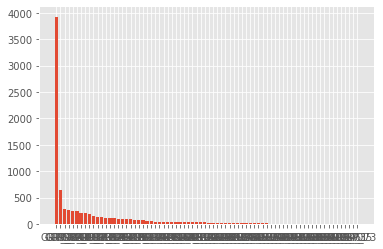

In [32]:
plt.bar(range(len(group_frequency)), group_frequency.values(), align='center')
plt.xticks(range(len(group_frequency)), list(group_frequency.keys()))

plt.show()

In [33]:
print (group_frequency)

{'GRP_0': 3926, 'GRP_8': 645, 'GRP_24': 285, 'GRP_12': 257, 'GRP_9': 252, 'GRP_2': 241, 'GRP_19': 215, 'GRP_3': 200, 'GRP_6': 183, 'GRP_13': 145, 'GRP_10': 140, 'GRP_5': 128, 'GRP_14': 118, 'GRP_25': 116, 'GRP_33': 107, 'GRP_4': 100, 'GRP_29': 97, 'GRP_18': 88, 'GRP_16': 85, 'GRP_31': 69, 'GRP_7': 68, 'GRP_17': 68, 'GRP_34': 61, 'GRP_26': 56, 'GRP_40': 45, 'GRP_28': 44, 'GRP_41': 40, 'GRP_30': 39, 'GRP_15': 38, 'GRP_42': 37, 'GRP_20': 36, 'GRP_45': 35, 'GRP_1': 31, 'GRP_22': 31, 'GRP_11': 30, 'GRP_21': 28, 'GRP_47': 27, 'GRP_62': 25, 'GRP_23': 25, 'GRP_48': 25, 'GRP_39': 19, 'GRP_27': 18, 'GRP_60': 16, 'GRP_37': 16, 'GRP_36': 15, 'GRP_44': 15, 'GRP_50': 14, 'GRP_65': 11, 'GRP_53': 11, 'GRP_52': 9, 'GRP_55': 8, 'GRP_51': 8, 'GRP_46': 6, 'GRP_49': 6, 'GRP_59': 6, 'GRP_43': 5, 'GRP_66': 4, 'GRP_32': 4, 'GRP_56': 3, 'GRP_58': 3, 'GRP_68': 3, 'GRP_38': 3, 'GRP_63': 3, 'GRP_54': 2, 'GRP_69': 2, 'GRP_57': 2, 'GRP_72': 2, 'GRP_71': 2, 'GRP_64': 1, 'GRP_67': 1, 'GRP_70': 1, 'GRP_61': 1, 'GRP_35

In [34]:
group_df = pd.DataFrame.from_dict(group_frequency, orient='index', columns=['frequency'])
group_df.head(10)

frequency
GRP_0        3926
GRP_8         645
GRP_24        285
GRP_12        257
GRP_9         252
GRP_2         241
GRP_19        215
GRP_3         200
GRP_6         183
GRP_13        145

In [35]:
group_df.tail(10)

frequency
GRP_69          2
GRP_57          2
GRP_72          2
GRP_71          2
GRP_64          1
GRP_67          1
GRP_70          1
GRP_61          1
GRP_35          1
GRP_73          1

In [36]:
#lets get the stats of this 
group_df.describe(percentiles=[0.1, .25, .5, .75, .95, .99]).transpose()

count        mean        std  min  ...   75%     95%      99%     max
frequency   74.0  113.621622  459.82399  1.0  ...  81.0  253.75  1530.87  3926.0

[1 rows x 11 columns]

In [37]:
group_df['percent representation'] = group_df['frequency'] / group_df['frequency'].sum()
group_df.head(10)

frequency  percent representation
GRP_0        3926                0.466936
GRP_8         645                0.076713
GRP_24        285                0.033896
GRP_12        257                0.030566
GRP_9         252                0.029971
GRP_2         241                0.028663
GRP_19        215                0.025571
GRP_3         200                0.023787
GRP_6         183                0.021765
GRP_13        145                0.017245

In [38]:
group_df['cumulative percentage'] = group_df['percent representation'].cumsum(axis = 0)
group_df.head(35)

frequency  percent representation  cumulative percentage
GRP_0        3926                0.466936               0.466936
GRP_8         645                0.076713               0.543649
GRP_24        285                0.033896               0.577545
GRP_12        257                0.030566               0.608111
GRP_9         252                0.029971               0.638083
GRP_2         241                0.028663               0.666746
GRP_19        215                0.025571               0.692317
GRP_3         200                0.023787               0.716104
GRP_6         183                0.021765               0.737869
GRP_13        145                0.017245               0.755114
GRP_10        140                0.016651               0.771765
GRP_5         128                0.015224               0.786989
GRP_14        118                0.014034               0.801023
GRP_25        116                0.013796               0.814819
GRP_33        107                0.012726               0.827545
GRP_4         100                0.011893               0.839439
GRP_29         97                0.011537               0.850975
GRP_18         88                0.010466               0.861441
GRP_16         85                0.010109               0.871551
GRP_31         69                0.008206               0.879757
GRP_7          68                0.008088               0.887845
GRP_17         68                0.008088               0.895932
GRP_34         61                0.007255               0.903187
GRP_26         56                0.006660               0.909848
GRP_40         45                0.005352               0.915200
GRP_28         44                0.005233               0.920433
GRP_41         40                0.004757               0.925190
GRP_30         39                0.004638               0.929829
GRP_15         38                0.004520               0.934348
GRP_42         37                0.004401               0.938749
GRP_20         36                0.004282               0.943030
GRP_45         35                0.004163               0.947193
GRP_1          31                0.003687               0.950880
GRP_22         31                0.003687               0.954567
GRP_11         30                0.003568               0.958135

## Exploratory Data Analysis

#### Distribution by group

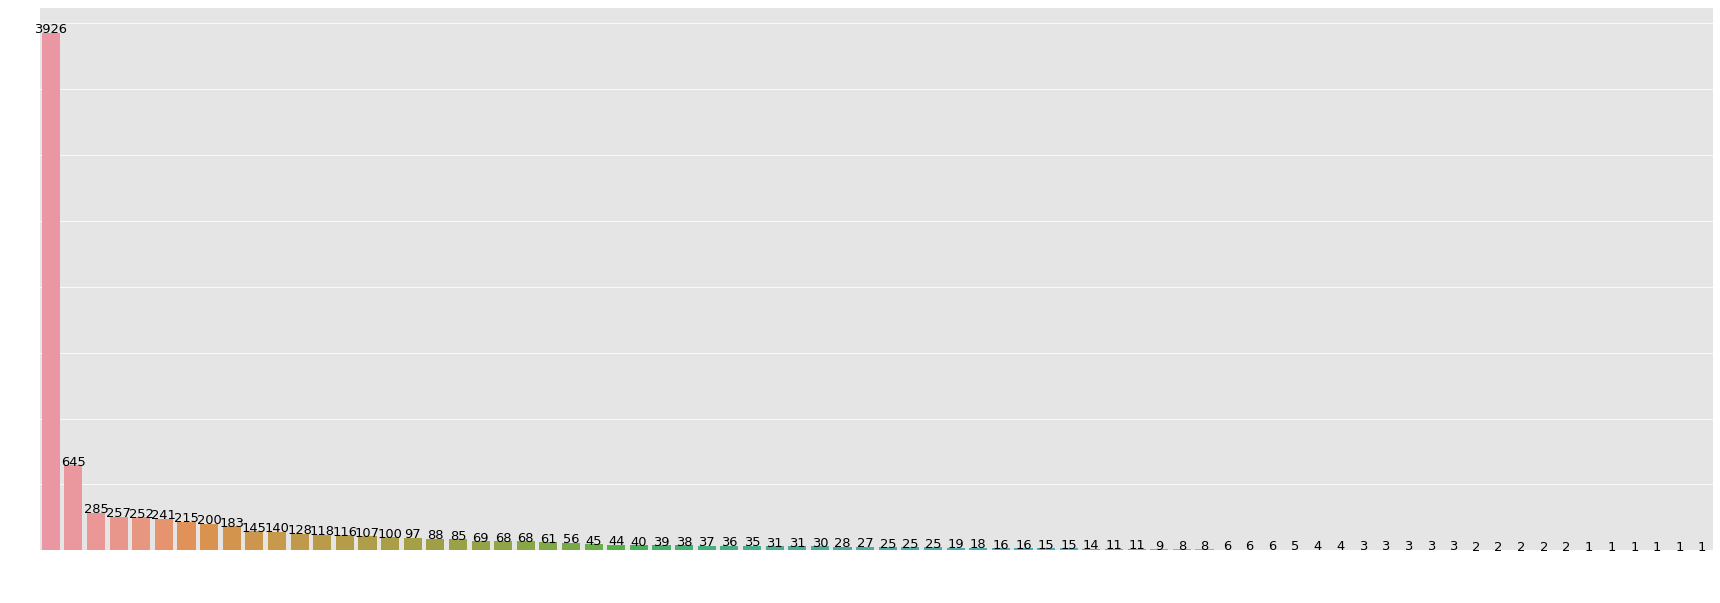

In [39]:
assgn = incidents['Assignment group'].value_counts()
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
cntplot = sns.barplot(x=assgn.index,y=assgn.values)
cntplot.set_xticklabels(cntplot.get_xticklabels(),rotation=90)
for i in range(len(assgn)):
  cntplot.text(i, assgn.values[i], assgn.values[i], color='black', ha='center', fontsize=13)
plt.show()

The data is extremely unbalanced towards GRP_0 and GRP_8 with their data occupying 55% of the available data. We have to resolve the imbalance before modelling.

#### Caller - assignment group analysis to identify any patterns

In [40]:
incidents['Caller'].describe()

count                  8408
unique                 2948
top       bpctwhsn kzqsbmtp
freq                    788
Name: Caller, dtype: object

In [41]:
incidents_freqgrp = incidents[incidents['Assignment group'].isin(list(incidents['Assignment group'].value_counts()[incidents['Assignment group'].value_counts()>10].index))]
freq_grp = (np.max(pd.crosstab(incidents_freqgrp['Caller'],incidents_freqgrp['Assignment group'])) /
            np.sum(pd.crosstab(incidents_freqgrp['Caller'],incidents_freqgrp['Assignment group']))).sort_values(ascending=False)
print(freq_grp[freq_grp>0.4])
freq_grp = freq_grp>0.4
print('Total records for select groups')
print(incidents[incidents['Assignment group'].isin(list(freq_grp[freq_grp].index))]['Assignment group'].value_counts())
incidents_freqgrp[incidents_freqgrp['Assignment group'].isin(list(freq_grp[freq_grp].index))].groupby(by='Assignment group').agg(lambda x:x.value_counts().index[0])

Assignment group
GRP_60    0.750000
GRP_5     0.742188
GRP_9     0.607143
GRP_41    0.550000
GRP_8     0.536434
GRP_6     0.480874
GRP_10    0.428571
dtype: float64
Total records for select groups
GRP_8     645
GRP_9     252
GRP_6     183
GRP_10    140
GRP_5     128
GRP_41     40
GRP_60     16
Name: Assignment group, dtype: int64


Short description  ...             Caller
Assignment group                                                     ...                   
GRP_10            res  ticket_no1558759    register   ie rj  tax...  ...  bpctwhsn kzqsbmtp
GRP_41                      bugs in to do list _operator dashbankrd  ...  entuakhp xrnhtdmk
GRP_5                      abended job in job_scheduler  SID_79cold  ...  bpctwhsn kzqsbmtp
GRP_6                                     unable to create delivery  ...  bpctwhsn kzqsbmtp
GRP_60            job HostName_1019failagain_1 failed in job_sch...  ...  bpctwhsn kzqsbmtp
GRP_8                         abended job in job_scheduler  Job_593  ...  bpctwhsn kzqsbmtp
GRP_9                        abended job in job_scheduler  Job_1148  ...  bpctwhsn kzqsbmtp

[7 rows x 3 columns]

*   There are 2948 unique callers in our data   
*   'bpctwhsn kzqsbmtp' is the most frequent caller with 788 records  
*   As we can see in above table, he is the most frequent caller for certain groups - for example, of the 128 records for GRP_5, tickets from this caller accounts for around 75%   






In [42]:
incidents_freqcall = incidents[incidents['Caller'].isin(list(incidents['Caller'].value_counts()[incidents['Caller'].value_counts()>20].index))]
freq_call = (np.max(pd.crosstab(incidents_freqcall['Assignment group'],incidents_freqcall['Caller'])) /
            np.sum(pd.crosstab(incidents_freqcall['Assignment group'],incidents_freqcall['Caller']))).sort_values(ascending=False)
print(freq_call[freq_call>0.7])
freq_call = freq_call>0.7
print(incidents[incidents['Caller'].isin(list(freq_call[freq_call].index))]['Caller'].value_counts())
incidents_freqcall[incidents_freqcall['Caller'].isin(list(freq_call[freq_call].index))].groupby(by='Caller').agg(lambda x:x.value_counts().index[0])

Caller
efbwiadp dicafxhv    1.000000
olckhmvx pcqobjnd    1.000000
rbozivdq gmlhrtvp    0.986111
fumkcsji sarmtlhy    0.984375
jionmpsf wnkpzcmv    0.958333
entuakhp xrnhtdmk    0.880000
dtype: float64
fumkcsji sarmtlhy    128
rbozivdq gmlhrtvp     72
olckhmvx pcqobjnd     47
efbwiadp dicafxhv     45
entuakhp xrnhtdmk     25
jionmpsf wnkpzcmv     24
Name: Caller, dtype: int64


Short description  ... Assignment group
Caller                                                                ...                 
efbwiadp dicafxhv  call from third party to talk to it head to pr...  ...            GRP_0
entuakhp xrnhtdmk                               prpf instead of prir  ...           GRP_41
fumkcsji sarmtlhy                   ticket update for inplant_855685  ...            GRP_0
jionmpsf wnkpzcmv            support fÃ¼r alicona  jionmpsf wnkpzcmv  ...           GRP_24
olckhmvx pcqobjnd                   ticket_no1539670   ticket update  ...            GRP_0
rbozivdq gmlhrtvp                                         blank call  ...            GRP_0

[6 rows x 3 columns]

*   Based on the caller based analysis above, we can see that all the records for callers 'efbwiadp dicafxhv' and 'olckhmvx pcqobjnd' are assigned to GRP_0. Again, we can't consider this significant because GRP_0 records account for half of all input data.
*   Consider the volume of total records, we conclude there is no significant correlation between caller and assignment group. Once we identify that certain groups are similar, we can cluster them and look back at similar analysis again.



#### Short description length analysis and its relation with assignment group

In [43]:
incidents['sdesc_len'] = incidents['Short description'].str.len()

Text(0.5, 1.0, 'Distribution of length of short descriptions')

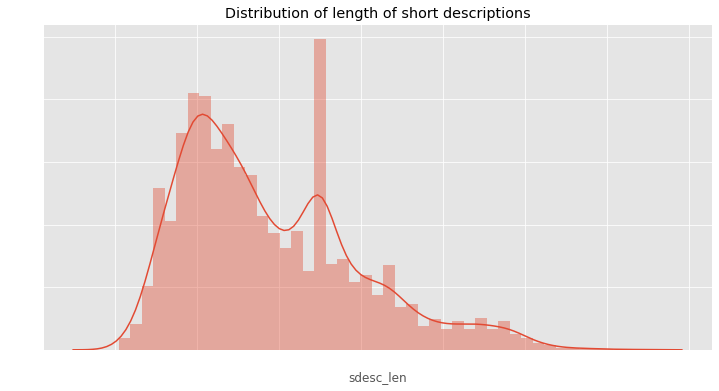

In [44]:
plt.figure(figsize=(12,6))
sns.distplot(incidents['sdesc_len']).set_title('Distribution of length of short descriptions')

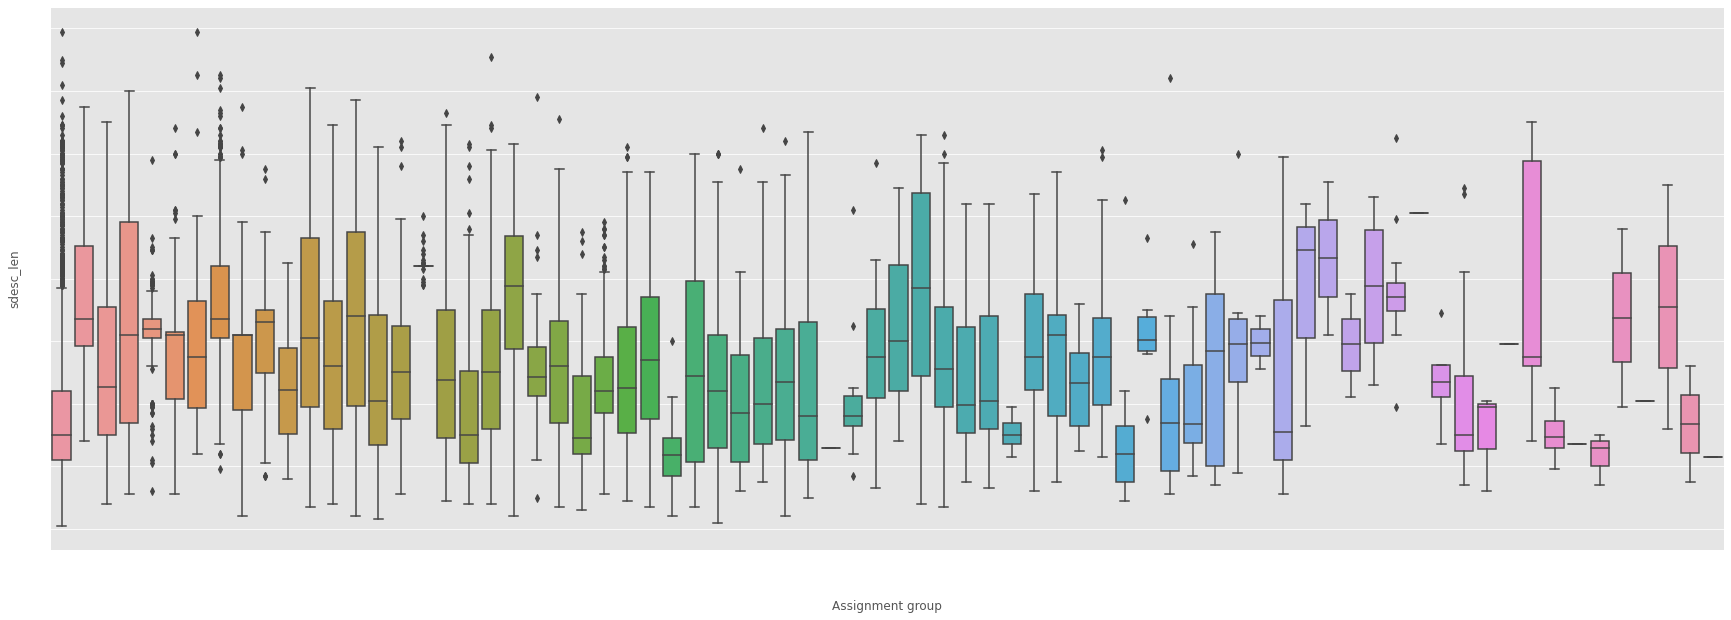

In [45]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents, x='Assignment group', y='sdesc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

We can see most of the short description are around 30 to 80 characters long with mean length around 50. However, we can see data for certain groups are either on the upper range (GRP_20, GRP_1, GRP_56), while some have a characteristic to have lower lengths (GRP_0, GRP_48, GRP_19).

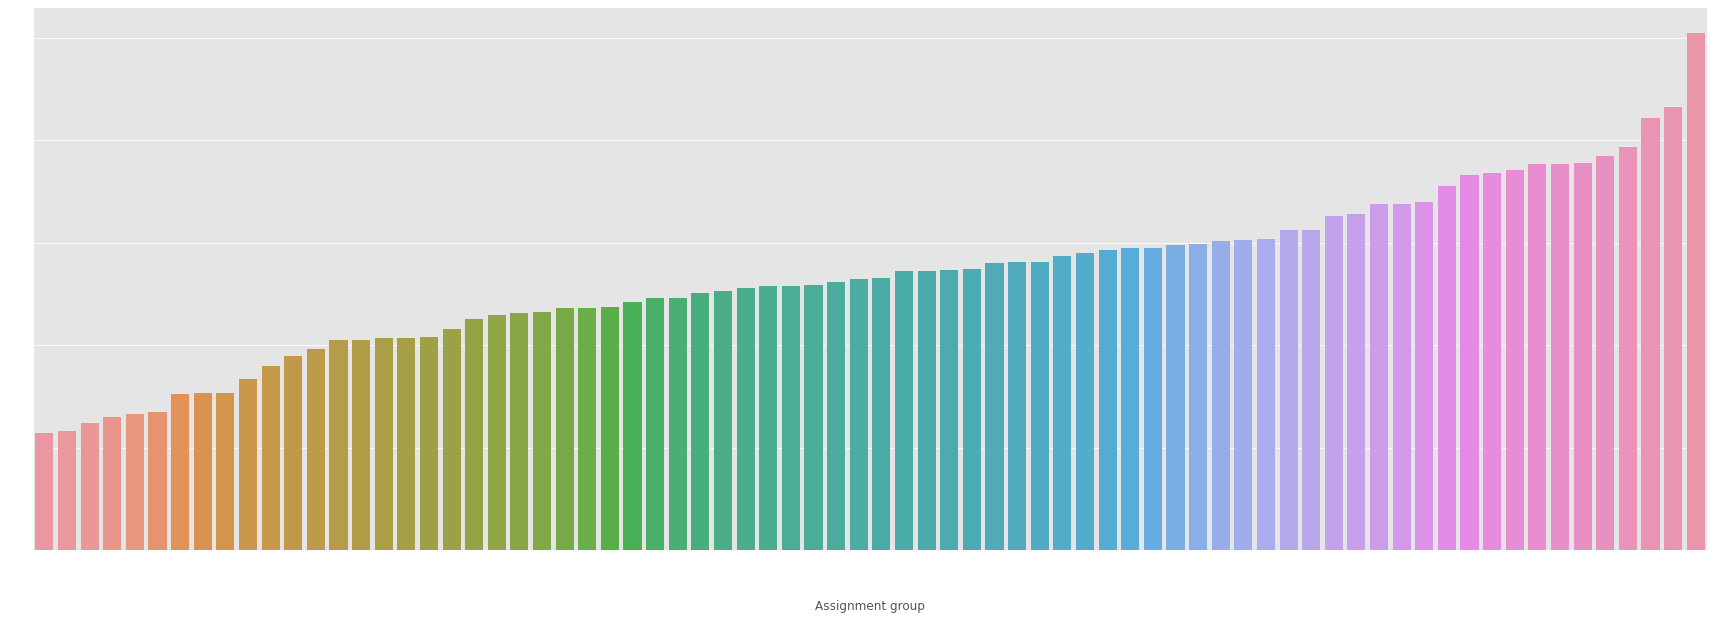

In [46]:
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plot_meansdesc_len=sns.barplot(x=incidents.groupby(['Assignment group']).mean()['sdesc_len'].sort_values().index,
                               y=incidents.groupby(['Assignment group']).mean()['sdesc_len'].sort_values().values)
plot_meansdesc_len.set_xticklabels(plot_meansdesc_len.get_xticklabels(),rotation=90)
plt.show()

Again, we are seeing a pattern with GRP_56 and GRP_43 records typically having longer lengths in contrast to most other groups having lengths below 200 characters. 

#### Description length analysis and its relation with assignment group

In [47]:
incidents['desc_len'] = incidents['Description'].str.len()

Text(0.5, 1.0, 'Distribution of length of descriptions')

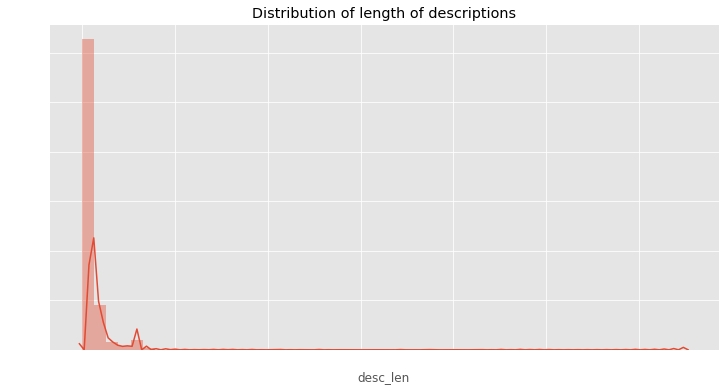

In [48]:
plt.figure(figsize=(12,6))
sns.distplot(incidents['desc_len']).set_title('Distribution of length of descriptions')

The distribution of description lengths is extremely skewed, let us try to omit the tail and focus the major portion from the right skewed graph.

In [49]:
incidents['desc_len'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

count     8408.00000
mean       205.55471
std        522.22436
min          1.00000
25%         42.00000
50%        106.00000
75%        203.00000
90%        397.00000
95%        680.65000
max      13001.00000
Name: desc_len, dtype: float64

In [50]:
len(incidents[incidents['desc_len'] > 680])

421

95% of the descriptions have length lesser than 680 characters, lets plot the distribution for them.

Text(0.5, 1.0, 'Distribution of length of descriptions')

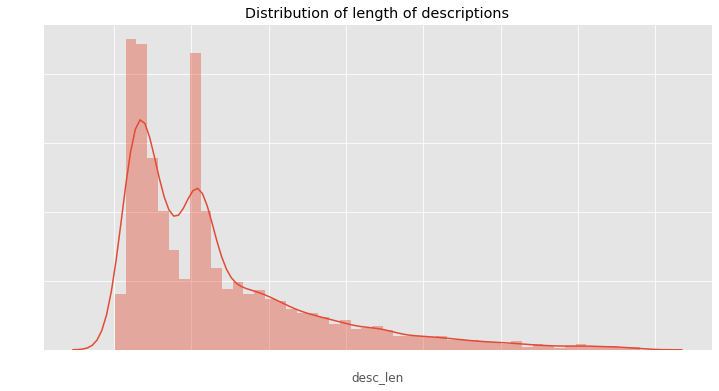

In [51]:
incidents_95 = incidents[incidents['desc_len'] < incidents['desc_len'].quantile(0.95)]
plt.figure(figsize=(12,6))
sns.distplot(incidents_95['desc_len']).set_title('Distribution of length of descriptions')

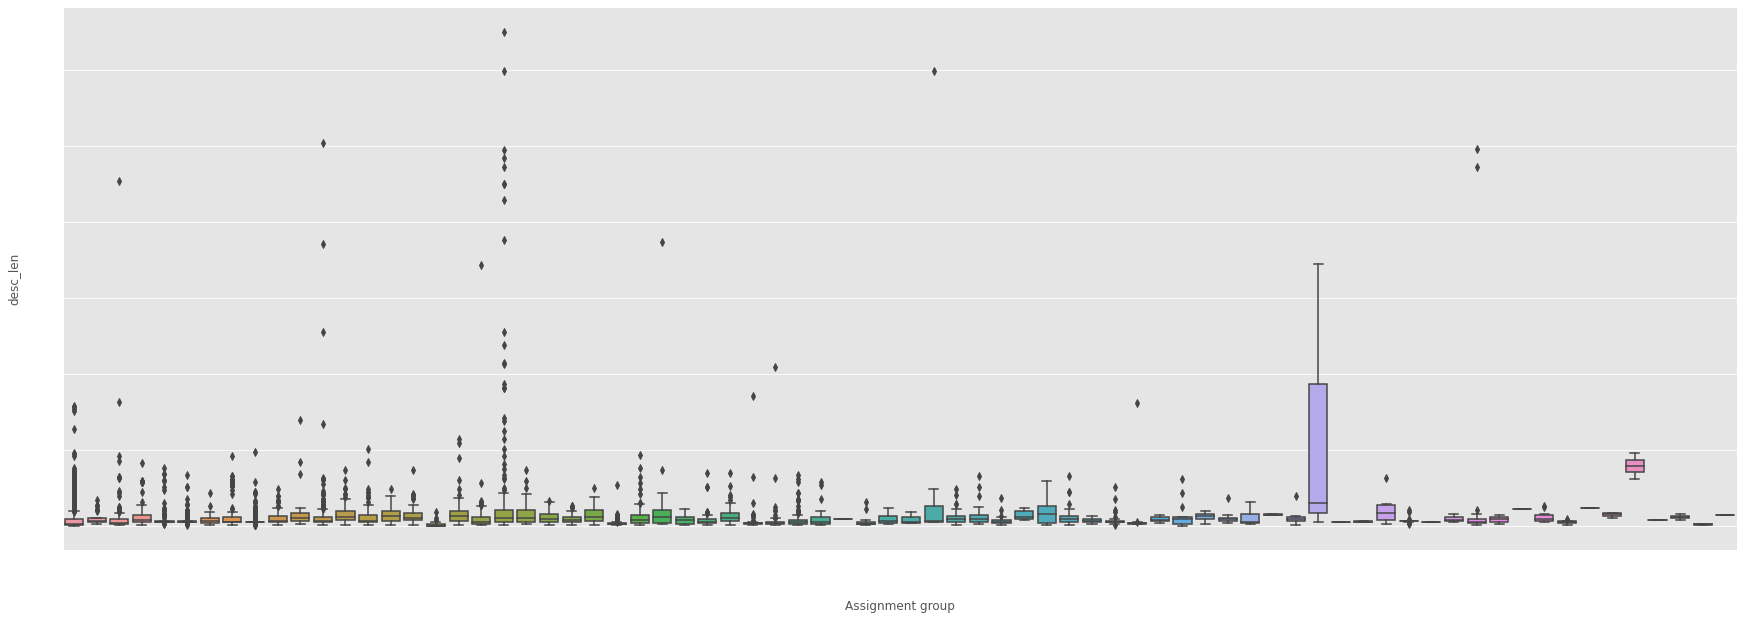

In [52]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents, x='Assignment group', y='desc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

We can see clearly GRP_56 is dominating with long descriptions. We will again try to restrict data of only particular limit.

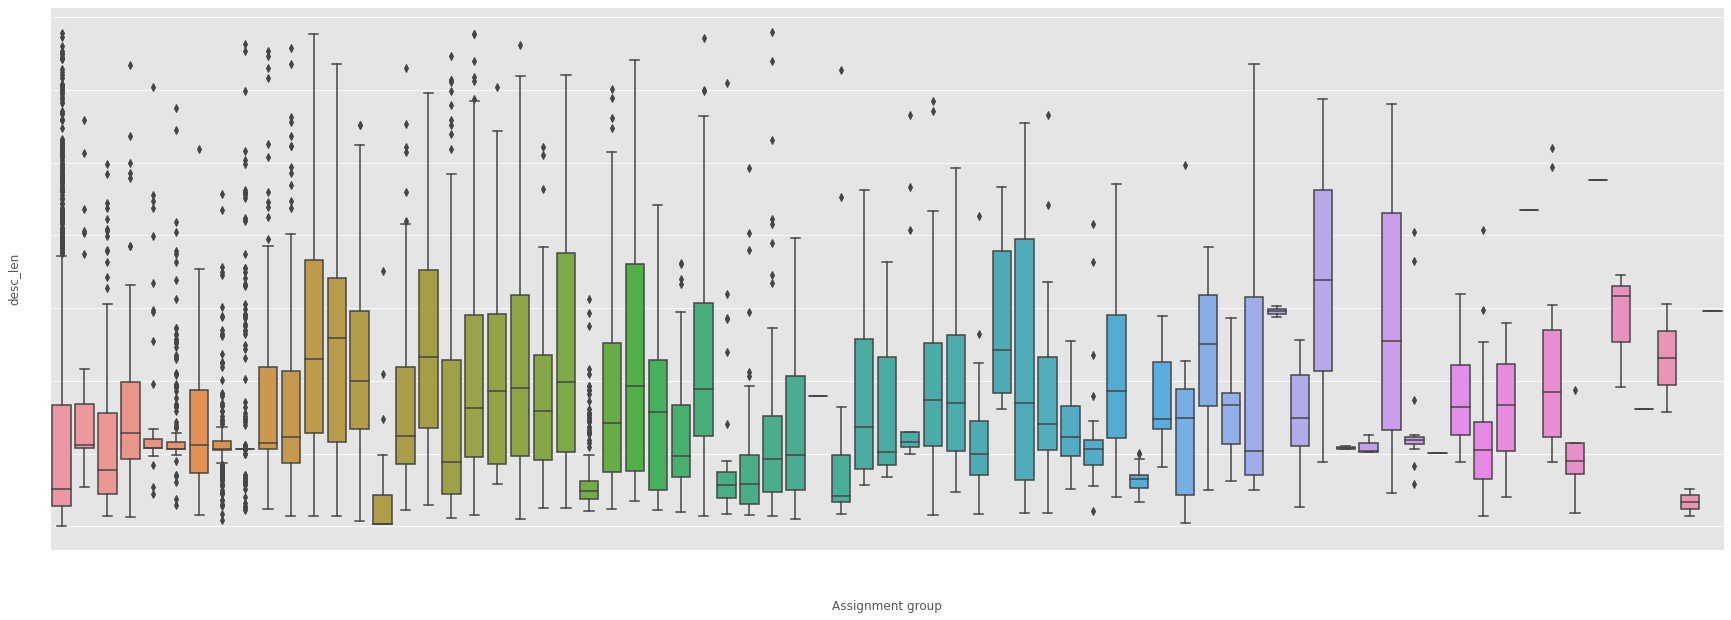

In [53]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents_95, x='Assignment group', y='desc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

Let us plot the mean lengths of description columns.

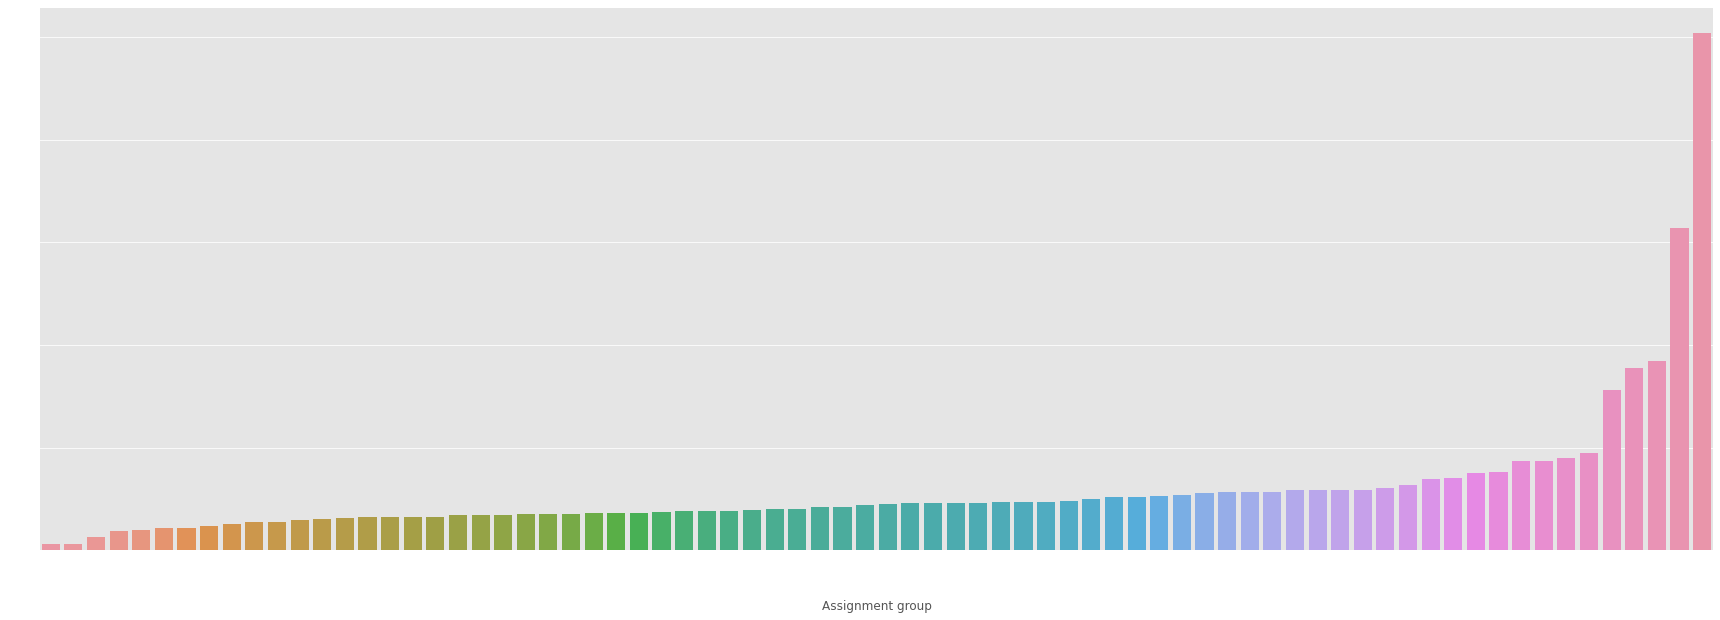

In [54]:
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plot_meandesc_len=sns.barplot(x=incidents.groupby(['Assignment group']).mean()['desc_len'].sort_values().index,
                               y=incidents.groupby(['Assignment group']).mean()['desc_len'].sort_values().values)
plot_meandesc_len.set_xticklabels(plot_meandesc_len.get_xticklabels(),rotation=90)
plt.show()

There is a clear distinction between the data of five groups which have very large description data. We will consider this significant and try to identify if the length has any relation with the content once we generate embeddings.

## Data preprocessing

#### Language translation

In [55]:
translator = Translator()

incidents['desc_lang'] = ''
desc_lang=[]
desc_trans=[]
for i,row in incidents.iterrows():
    try:
        language = translator.translate(row['Description']).src
        trans = translator.translate(row['Description']).text if language != 'en' else row['Description']
    except:
        language = "error"
        print("This row throws an error:", row['Description'])
    desc_lang.append(language)
    desc_trans.append(trans)
incidents['desc_lang']=desc_lang
incidents['Description']=desc_trans

In [56]:
incidents['desc_lang'].value_counts()[incidents['desc_lang'].value_counts()>50]

en    8016
de     296
co      53
Name: desc_lang, dtype: int64

In [57]:
incidents['sdesc_lang'] = ''
sdesc_lang=[]
sdesc_trans=[]
for i,row in incidents.iterrows():
    try:
        language = translator.translate(row['Short description']).src
        trans = translator.translate(row['Short description']).text if language != 'en' else row['Short description']
    except:
        language = "error"
        print("This row throws an error:", row['Short description'])
    sdesc_lang.append(language)
    sdesc_trans.append(trans)
incidents['sdesc_lang']=sdesc_lang
incidents['Short description']=sdesc_trans

In [58]:
incidents['sdesc_lang'].value_counts()[incidents['sdesc_lang'].value_counts()>50]

en    8019
de     278
Name: sdesc_lang, dtype: int64

In [59]:
incidents.head()

Short description  ... sdesc_lang
0                    login issue  ...         en
1                        outlook  ...         en
2             cant log in to vpn  ...         en
3  unable to access hr_tool page  ...         en
4                   skype error   ...         en

[5 rows x 8 columns]

#### Pickling the data post language translation for reuse, further preprocessing to be performed

In [60]:
with open('incidents_trans.pickle', 'wb') as output:
    pickle.dump(incidents, output)

In [61]:
with open('incidents_trans.pickle', 'rb') as data:
    incidents = pickle.load(data)

In [62]:
stop_words=set(stopwords.words('english'))
#We will remove the caller names as well along with stopwords from the description column
stop_words = list(stop_words) + list(np.unique(word_tokenize(' '.join(incidents['Caller'].unique()))))

In [64]:
def text_to_wordlist(text, remove_stop_words=True, lemma_words=True):
    # Clean the text, with the option to remove stop_words and to stem words.

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemma_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        lemma_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemma_words)
    
    # Return a list of words
    return(text)

In [65]:
incidents.head()

Short description  ... sdesc_lang
0                    login issue  ...         en
1                        outlook  ...         en
2             cant log in to vpn  ...         en
3  unable to access hr_tool page  ...         en
4                   skype error   ...         en

[5 rows x 8 columns]

In [66]:
desc_text=[]
for i,row in incidents.iterrows():
    text = text_to_wordlist(row['Description'])
    desc_text.append(text)
incidents['Description']=desc_text

In [67]:
sdesc_text=[]
for i,row in incidents.iterrows():
    text = text_to_wordlist(row['Short description'])
    sdesc_text.append(text)
incidents['Short description']=sdesc_text

In [68]:
incidents['Group id'] = incidents['Assignment group'].factorize()[0]
incidents.head()

Short description  ... Group id
0                 login issue  ...        0
1                     outlook  ...        0
2                cant log vpn  ...        0
3  unable access hr tool page  ...        0
4                 skype error  ...        0

[5 rows x 9 columns]

In [69]:
group_id_df = incidents[['Assignment group', 'Group id']].drop_duplicates().sort_values('Group id')

In [70]:
group_to_id = dict(group_id_df.values)
id_to_group = dict(group_id_df[['Group id', 'Assignment group']].values)

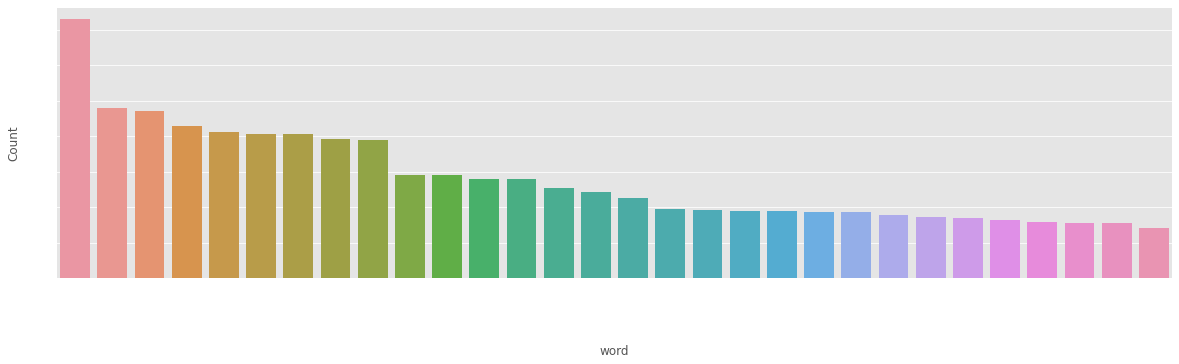

In [71]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  plt.rcParams['xtick.color'] = 'white'
  plt.rcParams['ytick.color'] = 'white'
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
  plt.show()

freq_words(list(incidents['Description']))


In [72]:
incidents['isSubstr'] = incidents.apply(lambda x: x['Short description'] not in x['Description'], axis=1)
incidents.loc[incidents['isSubstr']==True, 'Description'] = incidents['Short description'] + ' ' + incidents['Description']

In [73]:
incidents.drop(columns=['Short description','Caller','sdesc_len','desc_len','desc_lang','sdesc_lang','isSubstr'],inplace=True)
incidents.head()

Description Assignment group  Group id
0  verified user detail employee manager name che...            GRP_0         0
1  received gmail com hello team meeting skype me...            GRP_0         0
2  cant log vpn received gmail com hi cannot log ...            GRP_0         0
3                         unable access hr tool page            GRP_0         0
4                                        skype error            GRP_0         0

In [74]:
tokenizer = RegexpTokenizer(r'\w+')
incidents['tokens'] = incidents['Description'].apply(tokenizer.tokenize)

In [87]:
"""
glove_file = "glove.6B.zip"
#Extract Glove embedding zip file
with ZipFile(glove_file, 'r') as z:
  z.extractall()
  """

'\nglove_file = "glove.6B.zip"\n#Extract Glove embedding zip file\nwith ZipFile(glove_file, \'r\') as z:\n  z.extractall()\n  '

In [82]:
EMBEDDING_FILE = './glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd

In [83]:
def get_sentence_embedding(tokens, vector):
  if len(tokens)<1:
    return np.zeros(300)
  sentvec = [vector[word] if word in vector else np.zeros(300) for word in tokens]
  length = len(sentvec)
  sum = np.sum(sentvec, axis=0)
  avg = np.divide(sum,length)
  return(avg)

sentence_embeddings = np.array(incidents['tokens'].apply(lambda x: get_sentence_embedding(x, embeddings)).values.tolist())

In [84]:
sentence_embeddings.shape

(8408, 300)

In [85]:
incidents['embedding'] = incidents['tokens'].apply(lambda x: get_sentence_embedding(x, embeddings))

In [86]:
incidents.head()

Description  ...                                          embedding
0  verified user detail employee manager name che...  ...  [-0.21624695, 0.23975979, 0.033469737, -0.1661...
1  received gmail com hello team meeting skype me...  ...  [-0.15075332, -0.05970553, -0.09480174, -0.109...
2  cant log vpn received gmail com hi cannot log ...  ...  [-0.23506926, 0.050125826, -0.1719449, -0.0365...
3                         unable access hr tool page  ...  [-0.173643, -0.031263802, 0.077628, -0.098002,...
4                                        skype error  ...  [-0.11543, 0.24757999, -0.081420444, 0.2060400...

[5 rows x 5 columns]

In [88]:
inc_clus = pd.DataFrame(incidents['Assignment group'].unique(),columns=['Assignment group'])

In [89]:
for i in incidents['Assignment group'].unique():
  inc_clus.loc[inc_clus['Assignment group']==i,'embedding'] = pd.Series([np.mean(incidents[incidents['Assignment group']==i]['embedding'])],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')

In [90]:
inc_clus.head()

Assignment group                                          embedding
0            GRP_0  [-0.16335711214737503, 0.0492470646312975, -0....
1            GRP_1  [-0.15480446117631264, 0.09281953166444776, 0....
2            GRP_3  [-0.11490954599339431, 0.05135298404226165, -0...
3            GRP_4  [-0.13525782893077473, 0.02391786318813164, 0....
4            GRP_5  [-0.14163766344772613, 0.13579945775498048, 0....

In [91]:
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')
model.fit(inc_clus['embedding'].values.tolist())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=5)

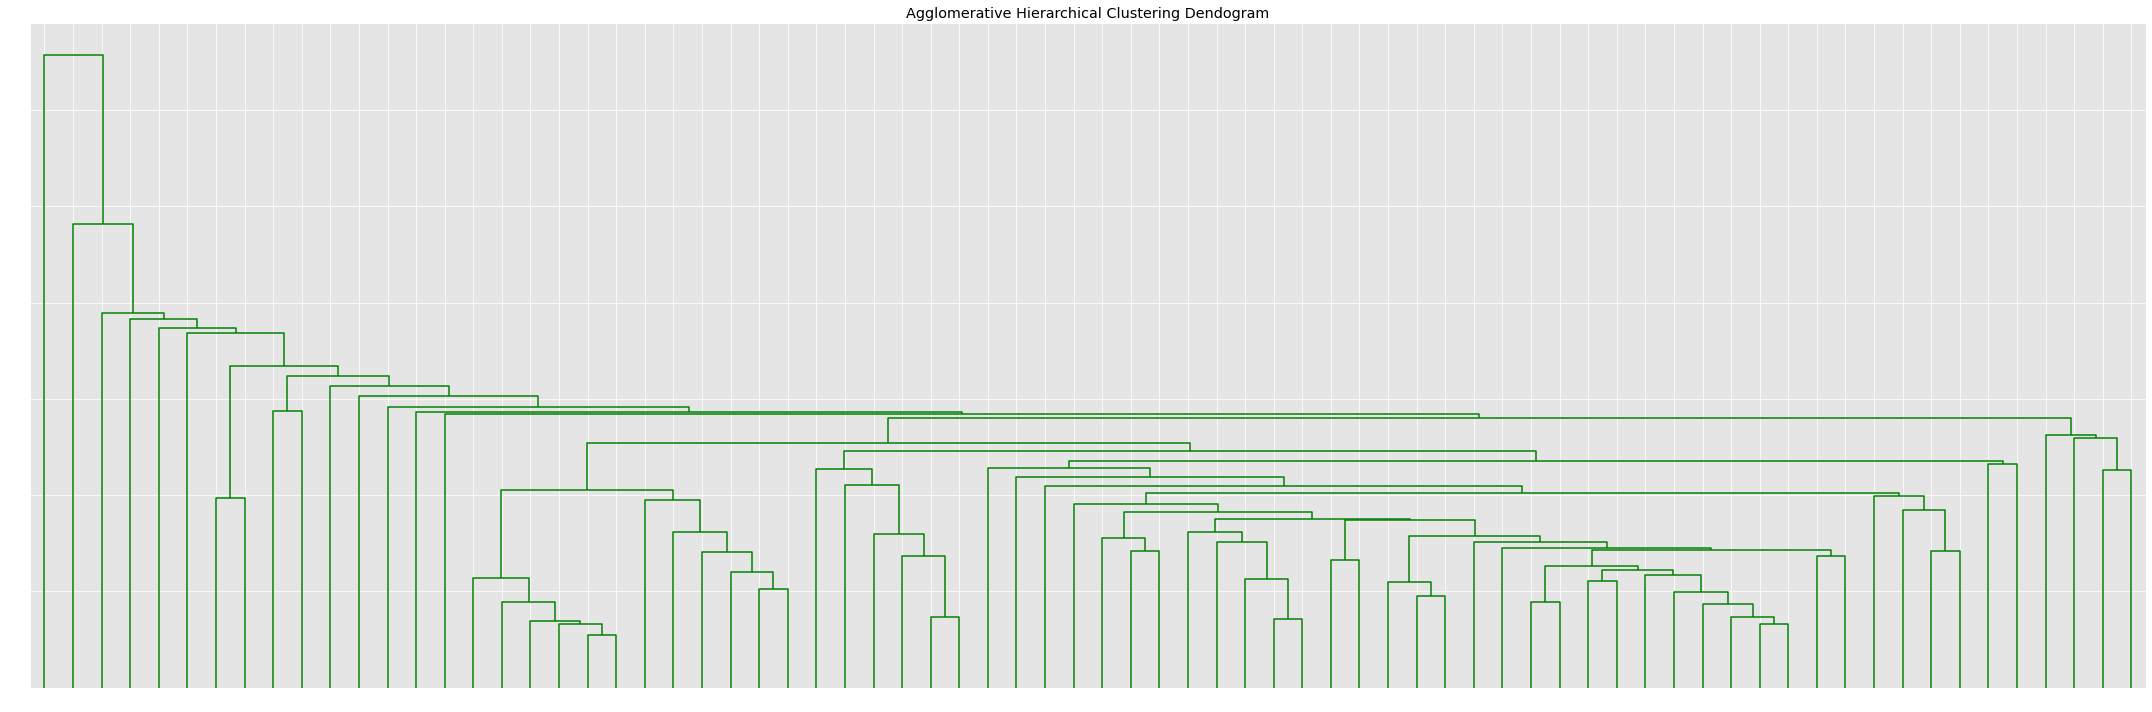

In [92]:
plt.figure(figsize=(30, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
Z = linkage(inc_clus['embedding'].values.tolist(), metric='euclidean', method='average')
dendrogram(Z, leaf_rotation=90, color_threshold=40, leaf_font_size=8)
plt.tight_layout()

From the above graph, records for specific groups are largely different from most other groups which seem to be similar. Let us choose 12 clusters for a start.

In [93]:
model = AgglomerativeClustering(n_clusters=12, affinity='euclidean',  linkage='average')
model.fit(inc_clus['embedding'].values.tolist())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=12)

In [94]:
inc_clus['class'] = model.labels_
inc_clus['class'].value_counts()

1     61
3      2
0      2
11     1
10     1
9      1
8      1
7      1
6      1
5      1
4      1
2      1
Name: class, dtype: int64

In [95]:
print([(i,inc_clus[inc_clus['class']==i]['Assignment group'].values) for i in inc_clus['class'].unique()])

[(1, array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_18', 'GRP_19', 'GRP_2', 'GRP_20',
       'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25', 'GRP_26',
       'GRP_27', 'GRP_28', 'GRP_29', 'GRP_33', 'GRP_34', 'GRP_36',
       'GRP_37', 'GRP_38', 'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42',
       'GRP_43', 'GRP_44', 'GRP_45', 'GRP_46', 'GRP_47', 'GRP_49',
       'GRP_50', 'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55',
       'GRP_56', 'GRP_57', 'GRP_59', 'GRP_60', 'GRP_32', 'GRP_62',
       'GRP_64', 'GRP_65', 'GRP_68', 'GRP_69', 'GRP_71'], dtype=object)), (7, array(['GRP_17'], dtype=object)), (3, array(['GRP_30', 'GRP_48'], dtype=object)), (0, array(['GRP_31', 'GRP_73'], dtype=object)), (9, array(['GRP_35'], dtype=object)), (11, array(['GRP_58'], dtype=object)), (6, array(['GRP_61'], dtype=object)), (10, array(['GRP_63'], dtype=object)), (4, array(['GRP_66']

In [96]:
inc_clus.head()

Assignment group                                          embedding  class
0            GRP_0  [-0.16335711214737503, 0.0492470646312975, -0....      1
1            GRP_1  [-0.15480446117631264, 0.09281953166444776, 0....      1
2            GRP_3  [-0.11490954599339431, 0.05135298404226165, -0...      1
3            GRP_4  [-0.13525782893077473, 0.02391786318813164, 0....      1
4            GRP_5  [-0.14163766344772613, 0.13579945775498048, 0....      1

In [97]:
for i in incidents['Assignment group'].unique():
  incidents.loc[incidents['Assignment group']==i,'class'] = inc_clus[inc_clus['Assignment group']==i]['class'].values[0]

In [98]:
incidents['class'].value_counts()

1.0     8190
0.0       70
7.0       68
3.0       64
4.0        4
11.0       3
10.0       3
2.0        2
9.0        1
8.0        1
5.0        1
6.0        1
Name: class, dtype: int64

As we could most of the groups fall under cluster 1 which also has most number of records associated with it. We will need to be able to differentiate between the groups within the cluster 1 to be able to provide valuable classification mechanism.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(incidents['embedding'].values.tolist(), incidents['class'], test_size=0.15, random_state=10)

In [100]:
lgr = LogisticRegression(random_state=8)
lgr.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
print(accuracy_score(y_test,lgr.predict(X_test)))

0.9817749603803486


In [102]:
print(classification_report(y_test,lgr.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.67      0.17      0.27        12
         1.0       0.99      1.00      0.99      1225
         3.0       0.78      0.64      0.70        11
         4.0       0.00      0.00      0.00         2
         7.0       0.83      0.91      0.87        11
         8.0       0.00      0.00      0.00         1

    accuracy                           0.98      1262
   macro avg       0.54      0.45      0.47      1262
weighted avg       0.98      0.98      0.98      1262



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The prediction happened very well on the majority class but faltering in the other classes.

#### Filter low data groups

252 is our magic number for 64th percentile

In [103]:
#eliminate groups that have very less representation, that is we consider 95% significant data
group_elimination_treshold = 252 #31

In [104]:
group_frequency_filtered = dict(filter(lambda x: x[1] >= group_elimination_treshold, group_frequency.items()))

In [105]:
print (group_frequency_filtered)

{'GRP_0': 3926, 'GRP_8': 645, 'GRP_24': 285, 'GRP_12': 257, 'GRP_9': 252}


In [107]:
#Lets now filter the data frame and retain only the necessary groups(Filtered)
valid_grp_list = list(group_frequency_filtered)

In [108]:
#eliminate
ticket_df_filtered = ticket_df_combined_caller[ticket_df_combined_caller['Assignment group'].isin(valid_grp_list)]
ticket_df_filtered.head(10)

Description  ...                                     ML_Description
0   verified user details employee manager name ch...  ...  verified user details employee manager name ch...
1   received from hmjdrvpb komuaywn gmail com hell...  ...  received from hmjdrvpb komuaywn gmail com hell...
2   cant log in to vpn received from eylqgodm ybqk...  ...  cant log in to vpn received from eylqgodm ybqk...
3     unable to access hr_tool page xbkucsvz gcpydteq  ...    unable to access hr tool page xbkucsvz gcpydteq
4                       skype error owlgqjme qhcozdfx  ...                      skype error owlgqjme qhcozdfx
5   unable to log in to engineering tool and skype...  ...  unable to log in to engineering tool and skype...
7   ticket_no employment status new non employee e...  ...  ticket no employment status new non employee e...
8   unable to disable add ins on outlook mdbegvct ...  ...  unable to disable add ins on outlook mdbegvct ...
9         ticket update on inplant_ fumkcsji sarmtlhy  ...         ticket update on inplant fumkcsji sarmtlhy
10  engineering tool says not connected and unable...  ...  engineering tool says not connected and unable...

[10 rows x 4 columns]

In [109]:
ticket_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5365 entries, 0 to 8497
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       5365 non-null   object
 1   Assignment group  5365 non-null   object
 2   NL_Description    5365 non-null   object
 3   ML_Description    5365 non-null   object
dtypes: object(4)
memory usage: 209.6+ KB


In [110]:
ticket_df_filtered.describe()

Description  ...                                     ML_Description
count                                                5365  ...                                               5365
unique                                               4717  ...                                               4716
top     received from monitoring_tool company com job ...  ...  received from monitoring tool company com job ...
freq                                                  310  ...                                                310

[4 rows x 4 columns]

#### We have reduced from 8500 to 8104

Reduce % = 0.04 => 4% of data we have dropped

In [111]:
ticket_df_filtered.isna().sum()

Description         0
Assignment group    0
NL_Description      0
ML_Description      0
dtype: int64

In [112]:
#Ref :: https://amitness.com/2019/07/identify-text-language-python/

import fasttext

# pretrained model from :: https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
PRETRAINED_MODEL_PATH = 'lid.176.bin'
lang_detect_model = fasttext.load_model(PRETRAINED_MODEL_PATH)

def predict_lang(sentence):
    detected_lang = lang_detect_model.predict(sentence)[0]
    detected_lang = detected_lang[0].replace('__label__', '')
    return detected_lang;

ticket_df_filtered['lang_predict'] = ticket_df_filtered['ML_Description'].apply(lambda v: predict_lang(v))
ticket_df_filtered.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Description  ... lang_predict
0  verified user details employee manager name ch...  ...           en
1  received from hmjdrvpb komuaywn gmail com hell...  ...           en
2  cant log in to vpn received from eylqgodm ybqk...  ...           en
3    unable to access hr_tool page xbkucsvz gcpydteq  ...           en
4                      skype error owlgqjme qhcozdfx  ...           en

[5 rows x 5 columns]

In [113]:
ticket_df_filtered['lang_predict'].value_counts()

en     4885
de      342
pl       29
fr       21
fi       12
es       11
sr       10
hu        7
fa        6
te        6
sl        6
nl        3
pt        3
ca        3
ms        2
cy        2
it        2
da        2
nds       2
zh        1
uz        1
lv        1
cs        1
yo        1
el        1
ru        1
eo        1
tl        1
th        1
et        1
Name: lang_predict, dtype: int64

### Filter only English -- Reduced from 8104 ~ 7388
Reduced % = 0.0883 => retained 91.17 % data retained

Compared to original -- Reduced from 8500 ~ 7388
REtained Data = 86.92 % data retained

In [114]:
ticket_df_english = ticket_df_filtered[ticket_df_filtered.lang_predict.eq('en')]
print(ticket_df_english)

                                            Description  ... lang_predict
0     verified user details employee manager name ch...  ...           en
1     received from hmjdrvpb komuaywn gmail com hell...  ...           en
2     cant log in to vpn received from eylqgodm ybqk...  ...           en
3       unable to access hr_tool page xbkucsvz gcpydteq  ...           en
4                         skype error owlgqjme qhcozdfx  ...           en
...                                                 ...  ...          ...
8486       ticket update on ticket_no fumkcsji sarmtlhy  ...           en
8488  erp account unlock name mfeyouli ndobtzpw lang...  ...           en
8489                   account locked sdvlxbfe ptnahjkw  ...           en
8496         telephony_software issue rbozivdq gmlhrtvp  ...           en
8497  vip windows password reset for tifpdchb pedxru...  ...           en

[4885 rows x 5 columns]


In [115]:
ticket_df_english.drop('lang_predict', inplace = True, axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [116]:
!pip install contractions
import contractions

     |████████████████████████████████| 245kB 6.4MB/s 
     |████████████████████████████████| 317kB 14.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81694 sha256=2d0930bbfb3047aafc051b077f5ee129e460e1a127079263312d2af3d8bdee67
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [117]:
ticket_df_english['ML_Description'] = ticket_df_english['ML_Description'].apply(lambda v: contractions.fix(v))
ticket_df_english['NL_Description'] = ticket_df_english['NL_Description'].apply(lambda v: contractions.fix(v))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
ticket_df_english.head(10)

Description  ...                                     ML_Description
0   verified user details employee manager name ch...  ...  verified user details employee manager name ch...
1   received from hmjdrvpb komuaywn gmail com hell...  ...  received from hmjdrvpb komuaywn gmail com hell...
2   cant log in to vpn received from eylqgodm ybqk...  ...  can not log in to vpn received from eylqgodm y...
3     unable to access hr_tool page xbkucsvz gcpydteq  ...    unable to access hr tool page xbkucsvz gcpydteq
4                       skype error owlgqjme qhcozdfx  ...                      skype error owlgqjme qhcozdfx
5   unable to log in to engineering tool and skype...  ...  unable to log in to engineering tool and skype...
7   ticket_no employment status new non employee e...  ...  ticket no employment status new non employee e...
8   unable to disable add ins on outlook mdbegvct ...  ...  unable to disable add ins on outlook mdbegvct ...
9         ticket update on inplant_ fumkcsji sarmtlhy  ...         ticket update on inplant fumkcsji sarmtlhy
10  engineering tool says not connected and unable...  ...  engineering tool says not connected and unable...

[10 rows x 4 columns]

### Stopword removal etc for ML models Preprocessing

In [119]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
snow = SnowballStemmer('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [121]:

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

# Apply stopwords only For ML
ticket_df_english['tok_desc'] = ticket_df_english.apply(lambda row: nltk.word_tokenize(row['ML_Description']), axis=1)
ticket_df_english['tok_desc'].apply(lambda x: [item for item in x if item not in stop_words])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0       [verified, user, details, employee, manager, n...
1       [received, hmjdrvpb, komuaywn, gmail, com, hel...
2       [log, vpn, received, eylqgodm, ybqkwiam, gmail...
3       [unable, access, hr, tool, page, xbkucsvz, gcp...
4                      [skype, error, owlgqjme, qhcozdfx]
                              ...                        
8486         [ticket, update, ticket, fumkcsji, sarmtlhy]
8488    [erp, account, unlock, name, mfeyouli, ndobtzp...
8489                [account, locked, sdvlxbfe, ptnahjkw]
8496     [telephony, software, issue, rbozivdq, gmlhrtvp]
8497    [vip, windows, password, reset, tifpdchb, pedx...
Name: tok_desc, Length: 4885, dtype: object

In [122]:
def get_stemmed_list(list):
  output = []
  for i in list: 
    output.append(snow.stem(i))
  return output
    
ticket_df_english['tok_desc_stemmed'] = ticket_df_english['tok_desc'].apply(lambda v: get_stemmed_list(v))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [123]:
ticket_df_english.head()

Description  ...                                   tok_desc_stemmed
0  verified user details employee manager name ch...  ...  [verifi, user, detail, employe, manag, name, c...
1  received from hmjdrvpb komuaywn gmail com hell...  ...  [receiv, from, hmjdrvpb, komuaywn, gmail, com,...
2  cant log in to vpn received from eylqgodm ybqk...  ...  [can, not, log, in, to, vpn, receiv, from, eyl...
3    unable to access hr_tool page xbkucsvz gcpydteq  ...  [unabl, to, access, hr, tool, page, xbkucsvz, ...
4                      skype error owlgqjme qhcozdfx  ...                  [skype, error, owlgqjm, qhcozdfx]

[5 rows x 6 columns]

In [124]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

ticket_df_english['tok_desc_pos'] = ticket_df_english['tok_desc'].apply(lambda v: pos_tag(v))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [125]:
ticket_df_english.head()

Description  ...                                       tok_desc_pos
0  verified user details employee manager name ch...  ...  [(verified, VBN), (user, NN), (details, NNS), ...
1  received from hmjdrvpb komuaywn gmail com hell...  ...  [(received, VBN), (from, IN), (hmjdrvpb, JJ), ...
2  cant log in to vpn received from eylqgodm ybqk...  ...  [(can, MD), (not, RB), (log, VB), (in, IN), (t...
3    unable to access hr_tool page xbkucsvz gcpydteq  ...  [(unable, JJ), (to, TO), (access, NN), (hr, NN...
4                      skype error owlgqjme qhcozdfx  ...  [(skype, JJ), (error, NN), (owlgqjme, NN), (qh...

[5 rows x 7 columns]

In [126]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 

def get_lemmatized_list(list):
  output = []
  for token, tag in list: 
    wntag = get_wordnet_pos(tag)
    if wntag is None:# not supply tag in case of None
        lemma = lemmatizer.lemmatize(token) 
    else:
        lemma = lemmatizer.lemmatize(token, pos=wntag) 
    output.append(lemma)
  return output

ticket_df_english['tok_desc_lemma'] = ticket_df_english['tok_desc_pos'].apply(lambda v: get_lemmatized_list(v))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [127]:
ticket_df_english.tail()

Description  ...                                     tok_desc_lemma
8486       ticket update on ticket_no fumkcsji sarmtlhy  ...  [ticket, update, on, ticket, no, fumkcsji, sar...
8488  erp account unlock name mfeyouli ndobtzpw lang...  ...  [erp, account, unlock, name, mfeyouli, ndobtzp...
8489                   account locked sdvlxbfe ptnahjkw  ...                [account, lock, sdvlxbfe, ptnahjkw]
8496         telephony_software issue rbozivdq gmlhrtvp  ...   [telephony, software, issue, rbozivdq, gmlhrtvp]
8497  vip windows password reset for tifpdchb pedxru...  ...  [vip, window, password, reset, for, tifpdchb, ...

[5 rows x 8 columns]

In [128]:
ticket_df_final = ticket_df_english.copy()

In [129]:
ticket_df_final['tok_desc_lemma'].values

array([list(['verify', 'user', 'detail', 'employee', 'manager', 'name', 'check', 'the', 'user', 'name', 'in', 'ad', 'and', 'reset', 'the', 'password', 'advise', 'the', 'user', 'to', 'login', 'and', 'check', 'caller', 'confirm', 'that', 'he', 'be', 'able', 'to', 'login', 'issue', 'resolve', 'spxjnwir', 'pjlcoqds']),
       list(['receive', 'from', 'hmjdrvpb', 'komuaywn', 'gmail', 'com', 'hello', 'team', 'my', 'meeting', 'skype', 'meeting', 'etc', 'be', 'not', 'appear', 'in', 'my', 'outlook', 'calendar', 'can', 'somebody', 'please', 'advise', 'how', 'to', 'correct', 'this', 'kind']),
       list(['can', 'not', 'log', 'in', 'to', 'vpn', 'receive', 'from', 'eylqgodm', 'ybqkwiam', 'gmail', 'com', 'hi', 'i', 'can', 'not', 'log', 'on', 'to', 'vpn', 'best']),
       ..., list(['account', 'lock', 'sdvlxbfe', 'ptnahjkw']),
       list(['telephony', 'software', 'issue', 'rbozivdq', 'gmlhrtvp']),
       list(['vip', 'window', 'password', 'reset', 'for', 'tifpdchb', 'pedxruyf', 'oybwdsgx', 'oxyhwrf

In [130]:
def get_bag_of_words(arrOfLists):
  output = "";
  #print (arrOfLists)
  for wordList in arrOfLists:
    #print (wordList)
    for word in wordList:
      #print (word)
      output = output+ " " + word
  return output

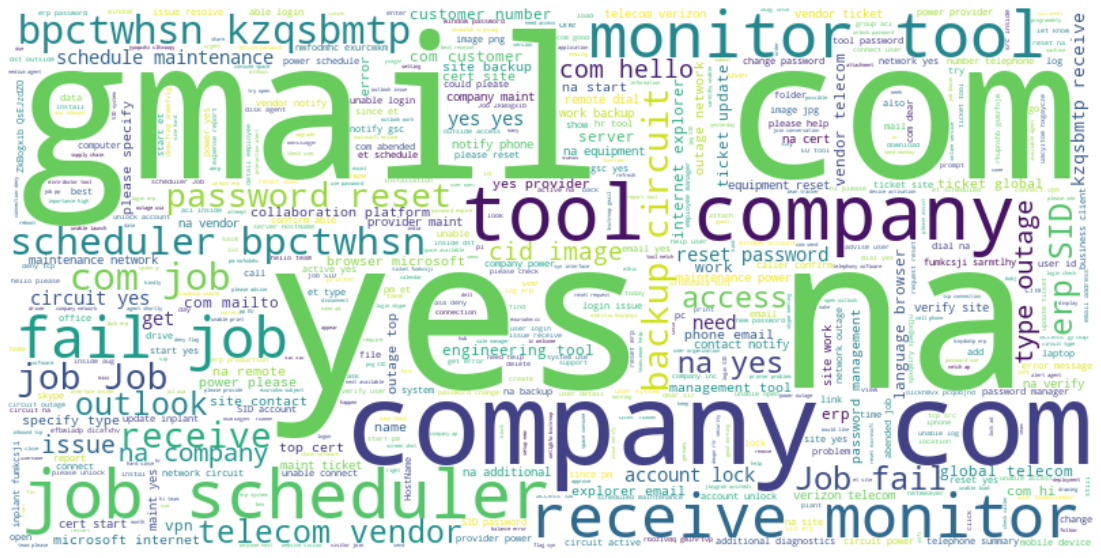

In [131]:
#word cloud for top 3 groups data
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#word cloud for overall data
stopwords = STOPWORDS

#GRP_0     3976
ticket_df_grp0 = ticket_df_final.copy()
ticket_df_grp0[ticket_df_grp0['Assignment group'].apply(lambda x : x =='GRP_0')]
wordcloud_grp0 = WordCloud(stopwords = stop_words, max_words=500, background_color="white",width=800, height=400).generate(get_bag_of_words(ticket_df_grp0['tok_desc_lemma'].values))

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud_grp0,interpolation='bilinear')
plt.axis("off")
plt.show()


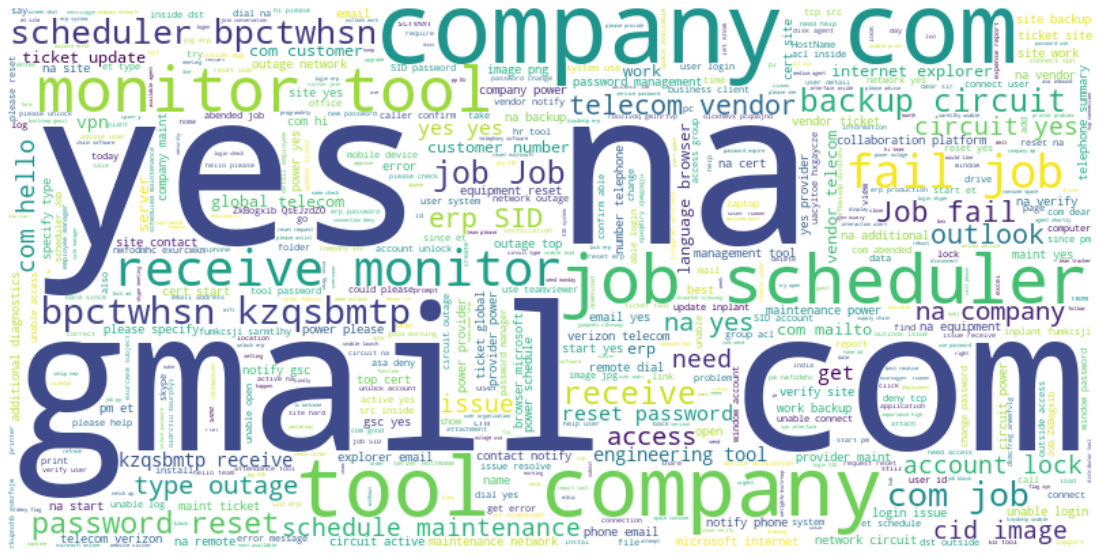

In [132]:
#GRP_8 data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABE0AAAIuCAYAAABKL/bvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOy9V6xdV5rn99vh5JxuzrzkZRRFqpRKJVWVKnSru6eme2rGHjR60GgDDsDAfvWbbcCGH+xHG5iHaXgwGHu6e6ZDdaWWqqRqlXJJlEQx3pzvPTmfs3Pww7m8InkDyRIlUeT+AVcQePZZe5199j5rrf/6vv8nuK6Lh4eHh4eHh4eHh4eHh4eHh8etiF92Bzw8PDw8PDw8PDw8PDw8PDweRDzRxMPDw8PDw8PDw8PDw8PDw2MfPNHEw8PDw8PDw8PDw8PDw8PDYx880cTDw8PDw8PDw8PDw8PDw8NjHzzRxMPDw8PDw8PDw8PDw8PDw2MfPNHEw8PDw8PDw8PDw8PDw8PDYx/kO7zu1SP28PDw8PDw8PDw8PDw8PB42BH2+8c7iSYeHg8FjutS1Kq8Ungb1daZiU3wTOYxglIAUdj7bLiui+lYvFJ4my21TDaQ5PsDzxKWQnRthdXuNu9WLnEiPslEZBi/6ONaa4mCVqFjKeBCwh9lPDzERGSIwVBuzzlKWo2rrSVWOlucT52gP5ihaynMtVep6HVU20AAQnKQoWCO6dgYI6E+JEFC2KfPHh4eHh4PP47rUtdUVpt1VpsNCt02bcNAtUwsx0ESREKyTCIQpC8SYTSe4EgiTToU3ne883i4sB2HrXaLN9fXuFwuHnjcEwNDfH9qmlhg/3mQh4fHrdi2Q6ut8vqbcywul255LRIOMDqS5rlnpkmnIl9SDx9MNMtkvl7lL65dwr0P8RgDkRh/dPQk/ZEIQdl3H3p4d3iiyQOEYumUtBbz7TzuAfdUUPLxWGqMmBxEFqW7blu1Dap6h/lWHtOx9z1GEkTOpEZJ+6P47qHtrwqqrXGttcy6kqdldpmMDDMa7kcU9j4GpmNRMeq8XbnIhlLgeHyS7/Y/A7golsZad5vXSr+hbXWpGS0c1+FKc5Ga0UCxdWzXRhZlxsODnEkc5an0adL+BH7p04e7ZXW43lrinconSIJIyh+nZjSZba/QtVQ0W8d0LFxgKJSjYjQ4lzzOsdj4F3fRPDw8PDweCBzXpaFprDRrzFbLXK+VWarX2O60aRkaitkTTWRRJCj7SAWDDERiTCSSnMr2cTLTx3QqQ9TnRxK97OyHFReXlq7zSTHPy0uLWI6N6TjYjnPLcsWyHZ4fmyDq94Mnmnh43BHXdbEsm2KpxdJyCdO0UVSDRlMlFPRx9swoZ8+MeqLJbZiOw3qrwV/NXsY5aIF7DxxPZ3lhZJx0METwC1QyPNHkAaJmdHmrPM//NfcKjuvg7qPH9QcT/G9n/wtm4oP3JJo0TZUPayv833Ov0DCUfdsOSj7+17P/gifTU/jE0Gf+PA8SoiAQlcOcSUzTMFpU9Dpz7VUGQhnkfR6Djq2w1NmkYbaJ+iKMhQeJ+yKIwq0TzS21RFGrUtEbJHwRcoEUISlI19ZY6W7xYf0am0oRAXg2e5aMmNwTJaI7JouddWpGC9XWiMghRsMDSIg0zDbrSoHZ1iolrUbTbDMVHUHGizbx8PDweBRwdyaZimlytVLkL69f4q2tNZq6vu/xtm2j2zZNXWO12eC97Q0SgSDPj4zzJ6ce51S2j4jP70UXPLQIRPw+RhNJTmSzdAxj969rGuj2/htnHo8mruuiaSamZeO6IIoCoaAPWb5/m6eO0xMbNN08cNEsAKGQH5/84M5vRVEkFg3xjWemmZrI0e5orG/WuPjJOu2O9mV3z+NzxhNNHiB8okTSH2YskqFr6ai2gWoZmO5nH+B8gkTCF2IknCEg+VAsHdU2dyMZHgUicoizyRkuNeYp63Vm2yt8PXuW0D7jQsvscLkxT9dSmY6OcjQ2hrBPitumUmAo1MdzuXN8I/s4CV8UURAxHYuVzhavlX7DtdYy/1B4i/HIIHE5eku0CYBuG8y11xgMZnkh9wTP584TloIICKi2TlGr8pcb/8CWWmalu82GUmAwlCUkBT+vS+Xh4eHh8QDhAr9YXeQni7N8VNyiYxj39P6OofP21jolpcu/Pv80j+UGSAUfrs0Rjx6SIDAUjfNfnjzN700fw3FcbNfharnEa6tL/HJpCct1vuxuejwguK7L3/zsIz65ukm7q9GXifPHP3yK49MD9+0czZbC9YUC//nHF2i21X2PEUWR/+ZfPc/pmSHC4cB9O/f9RBDA75c4MtXH6GgGXTdZWCyyvV33RJNHAE80eYCIyUFOJUb4s6lvYjgWpmPRNFWuNTe50tikanR+67Yjsp/p2AB/PPF1FEvHcGwUW+dac4urjU3yWuM+fpIHk4DoZyw8SC6YpqBV2VSK1I0WQTFwi5Bhuw4No8319gqGYzEYyjEZGd63Tct16A9m+Eb2HFPRnreJgIDjOkTlMFtqkbxapqBVWelu0xfIMBDK3tKGi4tmaxyLjfNU+jQTkSFERARBwHJsUv4409ExWmaXttllSy2R8sc90cTDw8PjEUC3bWarZd7eXOOTUv7ACJPDsF2XhqZyvVLiR/PXCUgyTw2OeNEmDyGCIBCQZfrkKH03ZQl0DIN0MNzLxHlUdss87ojrQrnaYXW9QrOtomkWqmbe93NYlkOro1GpdjBMC8O0saxPxTtRFOh0NGznwb05BUFAEARCIT+hEBiGj1gshM/nLacfBbxv+QEiLAeYjOaYjH5qGlrV24QlP1tK/TOJJkHJz0g4zUg4vftvXUvnle1LlLTmIyGayKJE0h9jJNTPSmeLmtFkXckT80VIS4nd47qWSlGvsa2WifuiDASz5AKpfdsMS0GGQjmOxcYREXajUcQdj5KxyBDDoT4KWpUNpcCR6OgtookLiAiEpCDHYuNMRUeRhE9DX2RR6qXrhAZY7mzSsRQqegPTsT6fi+Th4fHAUNqsUd6qobRV/AEfA+NZ+seyd37jQ47ruCxcXKNV7yD7JBLZGP2jWcKxh09Idl0XxTT49cYKl8sFatr+u7R31RbQtUx+vbHCyWwfM+msF23yKCFwQE0ID4/Pl0BApj8X45knpqg3umi6haIaFMstSpUW7c69C8EeHl80nmjyVeBzHOgexU2mqcgIK90trjaXuNpcYijUR8of3xU8ClqF9W4e27WZigwzEMwii/s/Kil/jJQvhiTsb6qX9sfpD2YBl4reoG129xwjizJ9wQxJf5yg5N+3nYgvRFDy07K66I6B8wiH1rpuz4/Hxdk1TBaFnmD1IOTB9vrn7ubtCoKAuHNvPQj9e9DYe71ARNz5/0f7en3w6mV+9u9+zfLlDXLDaX74r7/HH/533/2yu/Wl4zgO//5//xGfvDlLNBnhqe8/xh/+ty8ydXr0y+7afccF2obB6+srbLRbn7k9x3WpaSpztTIL9SpPDY589k56eHh4HEIkHGBmeoCZm1J+dN3k1Teu8w+/usKla1tfYu++HG54VbnuzjzoZq8Xobci6UW2HD4XuvE+x9nxqryT0aogIInenPS3wRNNPB45JqPDjLT7+bg+y7XWMk+kTzLFpxPHLaXESncLEZFjsQkGggfv7AZEP35xf6HjxushOYBLr3qP4ewNeRTpmdT6DhBmeprZjnLWUwse6chaB4fZ1gof1K4w314F4A9HXuRE7Agx35fvWN62uix1N3mt8C6ma3E8Nsk3ck+Q8seRefiqUn1WakaTa60l3ql8TNPsMB4Z4p8Ov9irNiV8caXkPDweRJp6r1pORVXQ7fsXYbjWbHiiiYeHx5fLI7xodxyXdlvj8rVNrs/l2dquoygGoiSSiIcYGUzyxPlJxkbSxA6JolRUg0KxyQcfrrK2XqFW70XyHMTgQII/+5NvkE5F8Pm8Oem94IkmHo8cSV+cgVCWpD9GWa9T1Kq0zS4xOYLhmGxrvYo4MV+YicgQ6UD8wLZE4fDoBlEQkXZ2zW3X2dc1XBAEfKK8e9x+CDfZ0D7Kggn0RPSW1WVN2eZqaxGAF4yvYbkPRspSw2yz0F7lUnMOwzZxXZcj0VHicgRZ8gao2zEck6rRYK69StVo4OA88tFUHh43aOk6q80Gimncl1KNNyh0O2y2mvetvQcBxTQpd7ssN2qUlC4d3cCwbRAgJMukgiEGozGOpNLEAgH8+/weW47De5sbLDdqBCWZFyenEAWB9WaT2WqZhqYT8fkYTyY5kcmRCoWwHYftdpvLpQJlpVedMBkMMpVMczSdIRa41dRysVblwvYWVU3leCbL8UyOgWiUqqqw2miw2W5SVzUM20YWRaJ+P32RCEfTGXKRCCH5wRCTdcui2O2y0WpQ6HRo6BqGZSEIAkFZJhEIMhyLM55Ikg2HDyxzvdZscKlYYLPVxAGOpTN8c3wCWZTuynOnpWtc2N5irdWkaxgkAkFemj5GKhjc95yu69I2DLbaLdabDUpKF9W0sB0HSRQIyTLZcITReILxRJKwz3dPJbo7hkG+02atUaekKHRNA8t2EAQI+3ykQ2GGY3GOpNKEfT7kR7j8t3DTfx8lVM2gWGrx9nuLXLu+TbHUwrJsRFHEdV2KxV5J461CkyfOjXP2zCi5TAxRvPVadToa1+fzvPH2PEvLJQACfh+SJNJoKlSqbVqtnkHtkckcuVycZCKMJImPsl71W/NIiCaabaJYOh1LR7dNTNfeKenbcxmXBBFZkAhKPkKSn7DsPzBNwsXFchw026Br6Wi2ie5YWI6Ns7OclQRht72oHCQqB/GJD24JrfuJ6dhotkHTVFFtA9Oxdxc/siARkGTCcoCEL9QTCg5Ia7mB5TiotkFBa6DbFhE5wFg4gySKWI6NZps0TQXVNjAcG9t1EBGQRYmAKBOW/ST9Efw3RXEEJB99gTQTkWE+rl/fKRtcIxIJUTeaFLUqqq0xHhmiP5ghIh+c890TQg5e3Dmug73zuiQcPAEQH8FB42FFtw3aptIzc3YtNMega2m7vw8eHh4ed0vHNNjqtO57tZOaplJSuruh3V/l+YnjutRVleVGnculAr/Z2mS5XqOiKKhWL7ozHggwHItzPJPj2ZExjmdzDMViRP23zvUsx+HXayv8cmWJmN/PdDpDS9d4Z3ODV1eWKHQ6pIJBzg8O8dL0MZ4bGaOkdHl7Y40fz8+yUq/juC5DsRhPD4/yz46fZDqdIez7VOiYr1b5fy9/wnytwu8fncF1e+mJHxW2eW9rg8ulIputFppl4pMksuEIR1IpvjE6zvmBIaZSaSI+35f2nTmuS1PTWG81+biQ52Ihz0Ktwnang2IaSIJA1B+gPxrlVDbHk0MjPNY/wGg8gV/aOw8qdjq8vrbCy4sL6LbF7x45yolsjv5IFPEOGw2O61JRFP76+lUu5LdoGwYz6SzPjoySCAT2xHbqlkVdU5mtVPiosM3FQp6lRp2WpmE6PZEqHggwkUxxtm+Ap4ZHOJbJkgmFCcqHL5lM26ahaczXqlws5Pkwv8VSo05DVdFtC1EQSASDjMYTnM7188zwKDOZLLlI5Jb740vnq/tT8JXAcV3KlQ7vX1jhxz+7iO04DPQlmBgbIBEPYZoOlVqH1bUy77y3QL3RRRQEnnt2moDfd4twsp1v8JsPVvjFa1fpy8Y5e2aE6SP9hMN+CsUml65sMjufp9PRmTk6wLmz40xOZInHgoiPsFj32/JIiCYFtcHlxgYf11dZ6ZSo6l0UW8dybCJykJgvSDYQYyKSZSY+xKnkCFPRvgPba5sqC+0Cn9TXWOwU2VTqVPUW2s6PYljyk/HHmIr1cT49wdcyU/QF4sjCw7/L3DZV5tsF3ijNMt/apqg16VoGAuyUU85yJjnGt/pPMBBMEpYPTm0BUGyduVaef7PwKhvdKmdTY/zPZ35ITAzSsXSWOkVeL1xjtrVNXmvQtXRCoo9UIMJoOMOpxAjfGzzDQCh5S7t9wTQn41NcaS6w0S2woeQZDfcz316nojeI+6I8ljh2qGACoNkGmn1w6UfNNlBsrVd/XvLjF28dGL2x6eEj5Y8zGRkiJkewXZuhUJbJ6DA+4ZH4ufXw8LiPaJZJXVPve0UJxTRoGzouX/1xyLBt3lpf42/nrvH+9iambePseF/doKIoVFWVq+USP12c41+cOM0/OXaccwODB7arWRarjTo/W5zjUqlIVVFwAa1j8trKMuvNBhOJJL9YXuQn87OsNhu70UCdqsFyo04yGMQvSRzP5vY9R01VuVIuMV+r8hdXLlHsdrDdTz2edNumaxhsNBu8t7nJ7xyZ5l+deZxTuT58X1LkouU4vL+9yV9cvcSF7S00y77Flwp6166qKsxWyry+tsLXR8b4H556loFolOBtkTKjiQTPDo/yq9VlFMtku9Pmg/wWL05MkbjDZ7Qdh4amcbFYoKZqDMWiPNbfTzIY3DeCo6x0eWVpkf90/QqrjTq249xyr+i2jWKaFLtdPspv85OFOf7s8fO8ODHFZHL/ggA3aOk6v1he5G9mr3KtXO5tpt52H2qdDqVul0+KBf529ir/1eNP8P2p6QPvjy8eAVH46v8mPMjYtsP1uTx//aML1Opdfue7p/n+iyc5MTPUu/AudLo6q2sV/vzfv8nV69uYps2JmUGy2RgB/6dzyUtXN/nkygZ+n8wfvPQYzzx5hOGh3nrHdWFsJI0kCvzmwgp+v8xAf5ypiexXWiT/MnloZ/GmY1PR27xauMLl+jobSpWGoaDYvXK7lmvjuuxGKpS0FqvdMptqHb8kHyiavF68ztulORbbRZqmQsfS0WwD3bF2BwzVMmibGmW9xXw7z/vVJf5g+Dwz8UFS/i/fc+HzwHQsLtbXeLs8zyf1dcp6i46poTkmttPbIVNtk6apst6tcqG6zLf6T/BU5ggT0cMHCwcXw7ZomyoNoxf6utAu8G55gTdKsxS1Jm1T3T2XIui0LY2upSMg8FxuZk+bKV+cI9FRolKYvFZhUymiOyaLnXVqepOEP8ZjyWNEpNBNiTF7aZgtGmYL07GQhb3RRHWzF7kCAtlA6oHw3PD4fIn7ojyWnCETSOG6Lkl/jJQvfseoKg8PD4/bsRwH1bJw73OkmrvTtmZZBCQJ6Ss6iS51O1zIb/GfZ69wrVxGEkTG00ke7x9gKBYn7PNhOQ5lpbeAv1wqopgGr64s4bhuL9UmkSSwTxRBWenyt3PXsF2XFyemGEsk2W63eHN9jc1Wk/VWk//nk4/YaDbJRSL8/tEZgrLMhfwWH+W3aek6H+a3mclkD1wUrzTqVFUFy3EIyT6+PzXNdDpDKhjEchzynQ6z1TLvb22hWSbvbW4gCgL//ZPP0B+J7tvvz5ufLczx8tICl4pFFNNkIpniRCbL0UyWRDCI7TjUVJXlRo0Pt7dp6jq/2d7k/3j3Tf7rc1/jRLbvlqiNdDDEsUyWkVgc3bIodDq8u7nBM8OjJAKHV8Qqdjtcq5TpGga26zAQjfHk0AhBeW8kzmKtyq/XVvnLq5fYareJ+QNMJVOc7R8gFQrhE0U026LUVfg4v81Ks05Z6fKfrl7GcVx+58g0Y4nkvv1YbzZ4e3Odv7p2mdVGnZAsM57IcnZggFw4QkCWMWybcrfLpVKBhWqVtmHw93PXcVyXgCQxnkzdMR3JdaGr6OSLDVY3auSLDar1Dq22hmnZCPQq1UQjIfpzMabGskxP9ZOMh5CkO89BBAEksZe60WgqrG/VuDa3Tb7UpNXWsCyHcMhPfy7OkckcZ04ME4sG8ckPxqZwp6uTLzW4Npdnq9Cg0VB6/h4CREJ+sukoYyNpTh8fIp2MEAh88RE+6+tVlpZLdLsGRyb7OHt6hKmJPvw3iSFxUeDIVB9PPjGBYViUym3e+2CZ556ZZqD/02qf5UqbSqWN3ydxbHqAXC6GfNN3MdifZGIsy/sfrlCrd2l3NC/C5DPwUIomtuuw1i3zdnmBVwtXWO9W0GyDsBxgKJQi4QsTlHyIgoDuWCiWTtNUqehtBEA+ZHHTNlXWlSrXW1ukA1H6gnGS/jAROYhPkLBdB8XWqeodtpQalVabotpCFiRCko+4HLqn3MivAm1TZbVb4Zf5y7xfXaakNUn4wkzH+kn4wvglGcd16Jg6Ra1JXm2woVQxHAvLtQnLftL+KLJ4+I+u5Tp0LI1NpcZ7lQXeKS+w1q3QH0wwGk7vpuCotknD6CKJIhFfYNcl+maCUoBcIMVouJ/l7hZ5rcK2UmKps4npWvQH04yGBwhIh/+gqrbOtlpmrr3KdHSUgOhHEAQc16FpdljvFthWS8iCxEion4w/cWh7Hl99/KKPbCBF9oAy1R4eHh53i7OTEvx5Jff10kcfjAXPvaJbFkv1Oj+en+VyqUhAkjnbP8C3xid30x6CsoztONQ1jZPZHCOxOL9YWWS73eI3WxsMRKP88xOn8Ut7Nz26psmVcok/mjnJN8cnmEgkKSldaqpKU9do6zpvra8xkUzyzPAov3f0GH5RIur30zVM3t/eZKleI9/p7H5/t89Gyt0uHUMnHQrz0pGjnBsYZCyRJB4IYDkOFUXhWDVDzB/gg+0tCt0OF7a3eXdrg+dHxxmKHey5dr9RzV4UyK/XVvgov41mmZzM9fHN8QnODwwxnkgS9Qd68x9dY6PZYiga553NdZbrNd5aX2MmnSUk+24RkQKyTC4S4bH+AeqaRk1VuFYuUeh0SAaChA5JXdlut7lULKDbFn5JYigW53RfP4GbIlRc10WzLD4u5PnlyiKL9Rqj8QRPDg3z7PAox3bEHkkUMCybmqoylUzx1sYab22ssViv8ebGKtlwmNF4bw53872iWRZXyyVeXlxgtlImG45wbmCQb4yOM5PJkgqF8EsSpm1T01SOpjO8u7nOqytLrDYbvL2xTi4cYTiewCeKh0YBLK2WuDafZ2ml53dRqbVpNBW6itETTQTw+2TCIT+ZdJS5wRQzaxWePDfBYH+CSDhwYNs3Ppcsi2wVGuSLLT6+vM7SaolKrUNX6XmzBAMymVSUxdUS65s1njw3wchgimjk8LY/TxzHYXO7wexinqtzeZZWS5QqbVptDcPs+d2Fgn6SiTCD/QlW1is8dnKE6ck+sunoF9rXrXyDre06ANNH+hgZ3mv0KssSsWiQEzNDLC2XuXR1k8tXNzl9cvgW0URVDTTNJBYLkkyECd4mAoXDfhKJXsR8V9HRtL3FKDzunodSNGkZCheqK/zN+vsUtAayINIfTDIVzXE2Nc5oOE3CH0EWRNqWSkXrsKFWmW8VeDo7zXjk4MiH0XCGk4lh2pbGTGyA6dgAY+EsfcEEIcmH6fYiXBbaed4ozbLQ6kWkvFa4wumdtJ+YeHjKx1cJ23XIqw1eK1zl9eJ1OpbGQCjJY8kxvpaeYiySISIHMB2bktbkk8Y671UWWemUuFhfA1z6AnGezk4TFYKHl9XCpWkqvFdZ4M3SHHWjy2OpUc6nJhgOp4nJQRxc6obCWreMahkcjQ8S3SfFppdGFeREYoqSXqek1bjUnGdTLRD3RRkJ9RO/i6gQAYFttcwbpQ+RBYmkP46EiOVaLHU2mGuvUDdb5IIpJiPDnmji4fEIYFs2hm6hdXUM3cQyLRy7V1JQEAREUUCURHx+GV9Axh/0Ewj57mIHSMBxHEzDQm1r6KqBadg4joMAiJKI7JcJhv2EIkF8Afmuw3Adu9eu0tEwVAPLtLHtm9r1SfiDPkLREP6AjHgXu5Y347ouhm6iK8ZOvy0c28HdKZMoiiKiJCD7JHz+T6+J7Ls/0xSlrdJpqqidnileIOQnEg8RTYYf6FBlAQFJOCze8TO0LdBLYXhwP/6h1DWVq+Ui/7i6guU4nB0Z4AfHjvNHx0/uOXYsAcczWWYyWRbrNeaqFdZbTV5eWuRb45MkAoE96S6O2xOsnhsd49nhUQKyzEQyxYfbW6w06sxVKxS7Hb43dYQXJ6Y4lu5V2msbBputFu9vb1LudmlqGo7j9KIIbrvXNNsiEw7x5NAw//LUYwzGYrdEGwzF4ownk4wnklRUhWZBo6oqvLy4wFQyxWA09oXdvw1N49drq1wuFamqCkOxOL83fYyXpo/tSV0ZisU5ls5yIptDoBcR0tA0Xl1ZYmDHjFe+SSCI+Hx8fWSM+WqFrXaL7XaLhVqV/kj0QNHEdhy22i0ulwpYjkMuHGEsnmAskbzFVt9xXYrdDh/uRABJgsDTQyP80fGTfH10bE+7Uyk4lesjFQyyUK1S6La5XCoyGI3xO0eO7onMKitdLhYLvLu5juU4nBsY5I9mTvLdqSN72p4gxclMjuFYjCs7wtBctcKv11d5afooiUDw0Kiva/N5fvrLS8wtFvD7ZQJ+Gb9PJpUMIwpCL4LMctANk5W1CosrJS5e3UA3LV545hgTo/49ZqI34+LiunDx8gblaptr83nCIX/vXAEfruui6xbFcovNfJ2PL62j6SYvPHOU6ck+RPHw4gifB6Zl025rvPfhMq+/M8f1hQKyLBIO+olFg4iigOu6WJZDvdFlu9Dgo0trbOUbfOf54zx5bpKAXz70utxPKpU2tXoXn09kbDRDPLb/mlAQYHgoSSYdQddNVtcrKOqtdgCSJCJJvX4bO2bG4k0b0LbtYFq9aP87Fa7wuDMPpWhyobbCbyqLFLQGtutwLDbAdwdO8/vD5whJ/t4PNb3wM8d1d806TccmIMm3mIbezrH4IIOhJD8YeYKkL0xA8iEJIpIg3khFYzSc5kxyhGwgzsvbn/BWeQ7VNljvVtlWG8z4Hh7RRLEM5lp5frL1EW1T5VhsgBcHTvHD0afwi3IvzG/nykxEc5xKjnI+Ncn/ef2nFNQGy50yP976iOPxYaLy4WGYAFW9w39cfYeRcJofjJznD4bPE5b8PZd1hF5eLS5fd47i4iKL0oHfZ1DycyZxlCuNRRY767xZ/oi2pXAifoSp6N2VYewLpBEEgfeql5hrr9IXSBOWg6iOznJnk7rRoi+Q4ncHn2MolMN3m6eJZw3q4fHw0W2prF7f4uq7i6xc26S0UaXTVDANC9kvE4mGiCRDDE7kGJsZZOr0KDPnJwmEDnA2ojkAACAASURBVPZ4EkUBQQRDNdleKfHBa1eY+3CF/EoZpa0iSiKxZISB8Synnp7m7AvHGTs2iCDd3SRJ7epsr5S48OoVFi+tUVzr9VkQBCLxELmRNFOnR3jqe48xcnSASPzexjHXcdlaLDJ7YYX5j1bZXCrQaSjoqoHruoSjQSKJEJmhFCPT/UyeHOHYuQlyw+l7Os9BXHl3gV//3Qd89Pp1AI6eHeO5PzjP9/74uQe6ioBPFAnJ8qFpor8NoiDgE3vm7A/wxz+U65Uyl4oFTNvGL0k8OTzMtycmDzzeL0n0RSJ8c3yCtqGzWKuy3W6x2qiTC0fIhMO3HB+UZUZjcZKB4C2VdgaiMXLhCHPVCgCj8QRjiU83ROKBAJlw7/mwXAfNMlEti8gBi/+xRJKXpo+RCAb3/S5i/gCP9w9yKtvHdrtFsdPho3yeUreL5ThfmLdJVVV4eWmBiqoQkntpTT84dpz+yP479aIgMBiL8bWhYdaaDV5bXWauWmGuWqGqKvRForufN+zz8/TwCL9YXkQuFtBtm/e3NplMJhmKxfZtv2sabLaaLDfq2K7LTDbH0XRmTx1C07F75sCNnklvSPbx/SPTnO0fOPCzBmSZyVSaF8bH+dnCPE1NZ7PVu1cmkinCNwncFwt55qplbNclIMt8c3yCp0cOnkMGZJmReILvTR7hZ4tzFDodtlpNlut1jmWyxAMHR2z05+KMDqVYXq0wPZFjerKPibEs/bkYoaAfy7Kp1LosLBX54OIqW4UGzZbKT165RH82zvBg8hZPjNsxDJutQoO1zRqRsJ+TM0M8+8QUQwMJggEfqmYyv1ziNx8ts7BcQtEMfvLKJXw+ib5cnOQ9jgv3g1q9y3sfLvPz1y6zsVUnGJCZGM3w5OOTjI+kiUaDmJZNqdzmyuwWH1xcpd3RePfCMrphkUpGmJ7IETpk/L2fdFUDRTUQRZFELIjff/DzG40ECAR82JZDs6limfYtr6dTUVLJKK2OyvpGlUw6Sjbz6fNYqXbY2KwBkM3GSCYenvXnl8FDJZo4rovt2lxqrDPXzgOQ8kf4Zv8JXug/QSYQQ+Bwl/g75Q2HJB9+USbtuoeUQ5MI4ONkYpjZ5hZvledwgbrRpWF0f/sP+ACy0ilxrblFy1SQEDmbGueFvhMk/OE9x/oAnygxEc3yVOYI71TmKWst1roVNtUaCX+I2B0EJdd1MR2LZ7NHeaHvBNlAtFeO9/bv4S7mED7Rx0ion75gmqXuJkW9Bi4Mh/oYCx9sDnczUV+Y6egoSX+c2dYyRb2KphhYroUkSDyenOFM4ihPps8Q90W/sipvb/fBpazXyKsVClqFqtGkaym75WFlQSIsB0n64vQFMxyJjpL0xQ+sRHU7jutS0WssdzfZ6OZpmB10x0AUBKJymMFQHxPhYcYjg+zInge29VH9Wu/70GrIgsQ3+77Gyfj0HVPAbrDa3eJifZYNtYDjOszEJvl231P4RN/uM++6Lh1b4YPqZT5pzB3Y1lR0lKczj5H1p+76/DdwcTFsk021yIZSoKRXaRptdKeXvy0KIn7RR1QO71z3FIPBPrKBJAHJf8eFluM6tM0u60qedSVPSa+i2jqO6yAJEiEpSF8wzXh4iPHwIGE5hHgX3iyu6+ListzZZFXZIq+WaVvdXu626CPhjzEaHuRIZBQXF/EhqB/lOr1IisvvLHDxjessfrJGvdiiVe+idjWsncgKQRLx+SRkv8zWUomNhQL1Uovx40OHiiayX6aSb/DOP1zkzR9dIL9aplFuobR7bQuiQL3YpLJdZ2upyPLVTZ548RTP/cF5ROnwHabFS2t88uYcF9+YpbRRpVntoHY0TKMX1uzzy1S262wuFpj/eI2zzx/niW+fZPz40B0jTkzDYmupyPu/uMT8x2sU1ys0Km26OyKSvbMLdiPCZGu5xNr1bfLLZRKZ2GcWTXTV4JM35/j1313g4huzNCstjj4+wZnnjnHy6SMPtGACEJB6pXLvpvTqvRD1+UkEgve93S+S9WaTlUYdURAYisUZjMaI+Q9ecAqCQECSGYsniPr9uIBhW2y0msxksntEE5/Yq1wTkG9N3Qn7fIR9PgR6QkzMHyByUxUevyQRlD6dXluug2nbsI9oItDz9DieyRKU96+yKAoCAVlmOp3majnGdrtN19QpdjvUNZW+A0SL+4luWVRVlcVaFcU0GY7FOZHNkTjAcBV2Uj0EgclkihPZHK+tLmM6DvlOm6V6jWw4snv/SYJAIhDkaDrDeCLJWrPBx4Vtnhsd49yAve/YOV+tstps9MpKAyd2RJPbr6HluMxWyhQ7HYKyj4lksle6+ZC0H1EQiPv9jMYT+CQJF5e2obPaqDMYjd1S7WaxVmWr1cIvSozFk/RFogcKZDeuS8TnZyKZIij7cOmVy15t1BmJxw8VTSZHM/zed85w9uQofbkYqWSYWCRIKORHlkQcx0XTTY5O9pFKRXjvwjJX57apN7psbNcplluMHfKb6tgOXUUnlYjw5LkJvvP8cQb6EkRCfiRJxLYdRodS9OfivHthiTffW6DVVrk2l2d8OMM3nzv2hY7lmm6ysl7h5V9dIV9qks1EefzUKN95/jh92RjRHb8Vx3WZGjc4MpHl2FQ/f/Ozj6jUOiyvlvnF61fJ/vBpgsEvpiKV67q3VC077JyCIOxGEDlOLwroZk4cH2Rjq8Ybb83z8qtXKFXaTE3kCAZ9VGsdPrq4zux8nmQizMnjQ4zcp02IR5WHSjSxXJuq3mGtW6GitwmIMsdiA5xJjjEeyd7V5OBOiwxRELnbCK7+QJx04NPBTLUNlEMqrXwVWe2WWWwXcF1IBsJMRnNMRLIHHi8JIlE5yPH4ENebW+TVBm1TZVOpMhbO3FE08YsyI+EMp5OjTESyd7WAO6wvMV+Es8kZ/KKPrqUiCxKnEkdI++8uT9gnyIyEBzifOk7an6CgVuhYPbPapC/GZGSYqegIg6G9KV8xOcLx2OSuUJM64JyCIDAQzHIudYKW2WEyMkRI+mJzR5tGh8XOGivdLTaVAgWtSu020US6STTpD6bZUPKcSkwzHh4i7jt4Uue6LrbrsNzd4HprmWutJTa6eZo7ookgCMTkCIOhHEeio1SNI6i2duhA0zEVFtrrfNS4hiRI9AczDIX6yQb2N3G7Gdt12FSKvFG+wJqyTUQOE5X3ioAuPQPkdbXAhfpVLMfGdnt/NzsQdG2Nk/EjpP0J7sU7wHEdynqdpc46s+0V1rrblPQaTbONbhs4rosoCPhFHxE5TMofJxdIMRTq4/nsEwyF+vAdEjXXtVSKWoW59iqLnTXWunnKeg3V1rFde/f77Av0RJNjsQmOxyfJBlKEpIOjwhzXoWV2WOisc6W5wFJnnW21TNtScF0Hv+Qj6YsxEh6gGK+QDaT2DVv/KuE6Lpqic/ndBd768Ye74oM/6CORjTE6NEAoEkSUBBzbQddM1I5Gq9qhU1d6wsEdws4s02Lp0jqb8wUuvjVLZiDJyNEBwtEgIKArOrVSi9JGlXqpRa3YxDItRo8OMDiZI7hPLruhmZS3arz/ymXee+UTli5vEI2HyAwmiZ8Ywh/04zgOumLQrLYprFXIr5RpVtoYmkk4FiTVl8Af3LtAcF0X13FZubbJB7+8whs/+oDCagXbsonEQ/SPZQlHg8h+GQQwdQu1o9FpKDTKLQzdwnE+W5ndVq3D6rUt3vi7D7j89jxKW2X8+DDP/ZPzPPmdM4wevTtx/Msk6vczGIkduDD9bcmEwvRFvprG5DcWHMVuZ9cvxHYcLhWLd5zDaZbFUr1GU+uladmuS1VVUKy9uf6yKBAPBPZce78k7XpPBGUfQVnGd9OiXhKEW97juC6W6+xbqSggy8QDQTKh8B3nqMOxONlwZLffFUX5wkSTrmlQUbo0dQ3HdcmEQkwmU3f04ADoj0RvMVCtKAprzSZPDX0ajSEIAj5J4kQ2x7VKmaV6jc12i9VmnVK3u693y7VKmdVGA0kQiPkDHEml9hzn7qRYrTUb1DUVFxfTcXhrfY2lWu3QftdUlYVaFd3uice6ZVFSupiOvds2wGa7RVnpzftsx+H9rU2qinJo2y1DZ6lWo2v21gSm41BSuui2fej7MukoiXiIE8cGCfjlfc1dE4Toz8VxXJdavcvVuW0s26FSbVOtdQ4VTW6k9xyZyPHk4xOcOzO2J60jlYwQiQSwLIvL1zdpd3RWNypcvr7JN56eRpDvfE/cL8qVNvNLReYWi7jA0al+vvXcDE+em9jTh1QiTF8mRjoV5crcNsb1TWqNLh9f3uC73zxJah9PkM8Dv0/C55N6qU6GhW0fPM6Zpo1l24iiQDDgQ7wtcnRyPMv5x8fZzjdYXCrR6eosLZcIBny02hr1RpdEPMSTT0xyYmaQVHLvXNbj7nmoRBPNNlntlmmaKrbrEJL8nE9PMRBM3NfKFe5OCTHLsTFdG3snvefG7qrrfhqxYjo2wk7aiOnYWM7hP4hfFW4MFnm1wZba2+lJB2IICNSMzqHvVSwDWRR3Jwi261JQm3Qs7Y7nDcl+ziRHyQVi97xrfxDP587zfO78b/Ve23XwCzLDoX6GQ/339N7+YIb+YIbv9D996HGSIHEyMcXJxNRv1cf7QUGr8JPt11lor6E5OrIgIQsyoiDulmV2dqKAttUS68o2H9av8229xrdyT3E6cRTYP8rLcm2aZpvXiu9xoX6Vil5HFiT8oo+QFEAQBEzHZLmzwbqS53JjnifSpzAd68D+jkUGGQn383HjOrZrs6WW2FKLdyWa6LZBWa+xruaxXJuhUG7HFPjWKACBnmjWH8gwHR1Ds3VUW6NrqXRtDdW+8/18GIqtcbk5z8+332BN2QbAJ8rIgrx7zV0XHBw6lkLDaLHc2UASJCbCw+QC6QNFk973VObNyoe8Wb5A02wj7VzzgNj7nDeiXJY6Gyx2egLU7w58g6fSjzEc6j/w+VNtjcXOBn+1/g9sqkV029hJk/PtipxNs0O1PstyZ5PJyDAzsUkc97MtkL9MTMOitFnjJ3/+j8xeWKbbVAiGAwxMZJg5P8mxcxP0jWTwBXwYmkGz2qG0UWXp8jqJbJzHnjt2aJQJQLvR5foHS4iiQG4oxTMvneXEk0foH+3trNYKTa6+v8i7P7/I1lKReqnF3IcrvPvyJ3zvXz67RzRxHZd2vcv7r1zijb+/wMZ8nkgizLHzkzz+wnGOnBkjkYlimha1QpPFT9Z456cfk1+rsHBxjW5bpW80zbkXjpMeSO55tl3HpdNUePfnF3n1L9+lvFnDF5DJDCaZODHMmeeO0T+aIZIIIwDthkJ5q8b63DbVfJPz3z75maJMdNVg9foWr/7Vu7z3yidoisHYsQGe/6dP8O0fPnXf0n4+b+L+IOOJ1G4azf1K6RyKxhiPf3XNqm3Xpa6p1DQV13VZbzX5D5cv8h8u31s7rguKZWHus3ARBYGQLO/ZnBF3dn8Feik8t5v791759HlwXfbsEN8g4vMR9fvvqkBAKhgidlNES8+M9ovZiGvpOhWluzv3i/oD9EUid7U4jgcCZEIhRMChJxiUup1bShTfYCaT5UQmxy+WFjBsm8Vajblq9RYxpLfR0ose2Wg1CcgyR9JphmN7ozRuzNVLSpeOYeDCborQvWK5Ll3TxL6p37brUlEVWrqGCyw1avybD9+/57Zt1+m1fQehuOdhcXfrmdGhFEM3mYZ2FJ1W5+7mJY+dGGbmSP+B92UuE+PIRB9T4znmFguUqx1W1quomkE47Ef+glLGVjcqzC4UsOxeVZ/j0wM8cXavT80NZFkiGQ9x/swoxVKTuYZCpd5ha7vOUH/iCxFNYtEg0UiQcqVDvaGg6QebszZbKopiIMsi6XQE/20eX6lkhJMzg9QbXX70k48pFJvU693d84yNZjh7ZpRvPT9DNBK4pbKOx73zUIkmhmOxrdTRrN4g4hdlJiJZor47e2XcCy4uum0x386z3CmzqVQpaS06loZqm+i2ielYWK5D3eje91KBDwo3Uo5qRgfbdVjplPi3i7/iP66+fej7HNfdKfWs9tpxXVTbwHTvLCj5RZnhUIrQXaZ8eNwfInKII9ExttQScSHKRGSI8cgQWX+KqBxGFES6lsq6kme2vcx8ew3Htfmwfo2gGOBobBy/6Nt3F7BmNPl5/tdcbs5TN1oERB/j4SEeS84wFh4kJAXpWipryjbz7RUWOxt0SyrKIaLEQDDHcKifsBREsTU21Dxr3S3OJveWn76dTbXAtlbC2hFlxsNDB6ZrheUQ38ie53zqJK7r4uCQV8tcbMzycuEtDOe3dyq/0lzgw9pVNtQClmtzJDrK8dgUU5ERIr4QIiKGY9I02xS0CmvdPA2zRdwXIxdIHZoWtdLd5O3Kx/yq+B6KrZLyJZiKjnAmcZTETnlk1dao6HU+rF9lQy1SN9r8dPsNQODrWZnh0P5l2a+1lvlV8T3WlW0MxyLtTzAdHePx5HGS/l5uesPosNBZZa69wvXWMptKkbb51U1d3F4p8cbffcDK1U26LYVENsapp6d56U9fYPTYAMFIANnXM2V1HRfHtrFMG0MzESWRUCyIP3SHSl0dnUDQx9jJEf7kf/wBI0f6iaXCu0apA+NZRmcGmDk/wb/9n/6a7eUSjXKbj1+/xtdfepzc8K3t6ZrB9kqJV/6/t8mvlukbyfDEi6d46U9fIDuUxB/shWO7rsvIkX6mHxvjay+e5s//l79m/qNV6sUmP/93bzAwliU9sFeM1FWDd39+kSvvLlArNBElkWPnJvjWP3uSr33nNOF4CNn3qfme4zhYpo2pW1iWTTgaJBS9u7F7v3Xb1fcW+fXffcA7P/0Ypa1y9PFxvvGDJ/jeH3+daOKrs9sWDwSYTKToi0So6yqadbBYfC9MpzKczu7/DD/ouPQquRi2vbuI/yytOY6z7zxNEARk6eDUwRsmvZ9lS84nSXftSRKUpVu8VQzbxrDvz/1wJ3TbRrnp3vNLEiF5/zH9dsSdKJKALKPbNoZloZj7j439kShTqRTD8Tj5dpuFWpUrpcItXjW6bVPqdlhrNqipCtlwmK+PjJEL742csh0HxbTuSwUq1+1Fkty452zXRTFNLPs+VLdye8LJ/VwvhIK+nZSTnmhnWfYeT4z9EAQY6E+QuUNVmXgsyImjA6xv1egqBl1FZzPfYHwkjRz+YhbnhVLPkFYUBAb7E2RSkTuWP5YkkVw6tuth4tguhZ2SyrnM/v4595PBgST9fXHmFwssLhc5e3oE9tF5XBdW1yuUKm2CAR9Tk31EbqtQpOkm84tFXvvH6wz0x/nW88d5/MwokiQiir1U4FDQRyQS+MKMbh9mHirRxHYdWqa6u/iWRJGkP0zgkBD1e6WkNZlr5fmwtsKmUqOqd2iZCl1Lx3KdTwdRoZelbxyyG/5VxqUnUvUEot71NhyLst6mrLfvsS0Xy7X33XW4nV5KTeiWUFiPz5+kL8bXUqfJBVK7JXWTvhhhKdgTQwQB07GYiAwxEMwSkUJcbi7QMjtsa2W21BLDof49C/mOpbCh5Pmofp2K3iAsBZmMDPOd/mcYDw+R8MXwiTKGYzIeGWQ41EdUDjPXXqNrqQf2NyD6yAVSTEZGmO+sUtJqbKpFVFsncFPEw36sdrfYVkqAQED0MRzqZyC4N71KEAQkBGK+CLGbKi3ZrkPCF/3MLh2r3a0dTxWX4VAfX8+c42xyhpQ/jk/s5dPbroNu67QtlWayjWpryKJMfzCz72d0XAfN1rnUmOej+jUUW2UsPMQTqVOcSRylL5ghuOOFYrk2iqUyHOrn/dplflO9RNNsc7ExS8ofZ2gn5ezGpNlxXRpmi4X2GrPtFXTHpC+Q5onUKZ7JnmUwmCUg9gZ83TGYiAyRC6S42JhjubOB5X41fytty6awVuGDV6/QqnXwB/1MnR7lpT99gWPnxokmIgiHVSu4y0Wf67gMTuQ4/62THD07RiQeQrplcujbTZOZfmwMpaXSrHbYXi6hdDRsy0GSP70nyps1rr2/RGmrhm3ZjB8f4ls/fIqR6f59o16C4QDRRJjTzx6lVeuwuVhkbXaL/GqZsZlB4jdNsB3HQWlrfPz6dTYXiwiiQDoX55t/+CTnv32K/vHsobnc97IQFoSeH8qNykNqV2P+4zXe+PsLfPLmLJpqcPTxCZ7/wyd46ntnSGa/uBKt9wNJEEgGgzw7NEpb11lu1j9Te7IoMpVIcTLTx/AXWK72fuK6Ls5NvgDSjm/Gmb7+W9JA7gafJHE8k2Ugsv9i6U6iwGfOQrinNfLtESxf3JbczT4MN3pyt344giDc4j3nwoHzPd9O2eAnB0f4pbZIvtNmoV6jrHRJBoL4JIm2rvNhfpuqquC4LvFAkKeGR8iG90+jdW4SOqJ+P1PJFI8PDJIK3pspZjIY5Hg2t+ubc7uIEpRlJpMpzvYPHGiOexBRv79Xnvgu+uQ4LrZtUyi1KFbaVOsdWm0NXTcxDAvTcrDt3t/SWnk3yumwiKcbSKJAOBwgEg7siWq4nWDAx2B/cvc43bAoVVoM9MXvWNr4s3LjmtebCpVaB3cnFemXb1xjdrFw6Htt26Fc7bCV7/2Wurj8/+y915NcWX7n97nepM/KzMryvlDwDbSZ7p6e7uFwyCGHbsklV6K0EdKuIqQXPUh613+g0INCoY2gpAdGSCFR4u5yyFmROzvkdI/r6R50ow08CkB5l97fvFYPN6vgqgpVMD0AWN+Igr157rkm7z3ne37f77fR6tK1v5oxyMhwmsmxLBc+WWD+1hZXb6yTy8UZvGfxodt1KJVbXPx8idW1CsmEyevnxx6S15QrLVbWKmwV6rwyMMpAPsHQYAp1H7PfIzw+Xqqz6gcBXd/ZeRgLCOi9dJsnhRf4NB2Li+UF3t+8yofFeWzfIa6Y9GnRXuSwiiGr6KKCIkooosSN+joXyneeeP/PH0IphtcrqRcQSKkmOT1OQjncKp4mKYxHskTlRz9kBUJzthfZvO5FREQ2mI6OMB4ZRBHlPWUffVqSiGzg43OzuUjNsWk4LVbbm+S09EOkScWucbu1wnqngBO4DJt5Xkuf4vX0aUxZv2/A2qclSalxDEljwypRd/aWgQmCQJ+W5Hh8koX2Kg23xZZVZsMqMqhnH5LawF0j6aX2OhtWEVmQyOsZ8npmX0+Wh/Z9z69PgqrToO60kAWJjJZiNjbGTGxs1223MwDCJLDQj2Q3uD2p0o3mAqudLVRR5XzqOF/PvMJkdOThD2gp8noGN3BZbK+x2tniTnOVYWORN/vOYkh34xEDfJbbGyy11yjbNQBmY+O8nj61U+Fz7/Xs1/swJA3X97jdXH7Ms/SrR7thsblUYvHqGo7tMDSdZ+7VCc5+Yw5JEvclTGB/Y/IHMTSd58w7x3YhTEJIsoQZMxidHWDh6irlzRqtWptO08J1XCT57n2/tVLm+id3cHreJMPT/Rx7dQJZ2f3eESUR1VCYODnMzc8XWbq+TqveYaNn7HovaWJbDuXNGgtXV6kVG8RSEabOjHLmnWMMjGcfGa18mHMiiAKqpiCIAs1am6Xr63zwbz7m4gdXqZeajB4b4J3fP88bv3Ga0WODB273eYEgCJiywnsjEyzXaxQ6bRp297HaUkSRrBnhW2NTnMzk9jVNfZ4h9DxDtscB2ykt741N8Nbw3qX5u7cFuiSjy3sPh5/laMMN/EdKMna29f2dMReEC4NPU3q+HyRRvM+nxQuCA8vN/Z5v2TbBID7g+fIg8pEobw2P8IvVZdYadVbqNa4VC5ztz6NIErWuxc+Xl6hYHSKqymAsxnQqTXSX+1no9X37mWLIMmPJFL87M8fYIQk2SRTuu1e278PttlVJYiSe4DuTM5zIHq6KSxQEdHn/+xCg1e5SLDVZWi1zZ6nIynqFzUKDai2UeTiuFxqG+j5+APYhiQBREomaGooiPbIyQVEkkgkTuScXcj2PWr2D6341NgSu5+9UuASEBMqFzxa58Nni4RoKQu+Q/bxFdvbp+tTrHRw33L7bddncqtPp2Hi9/mxs1BBFAUkUkCQRw1DRNRmlRy71paPMTPdz4vggX1xa5uLnS0iiyLGZPKoqEwQBtXqHO4tFLl1ZRUDg+LEBjh8bJBq9/x73/QACEEWRRtPi2vUNOh1np9pG6PVBVSVSyQjpVGQn4vhoGnV4vFSkCfDMMlwdP5TjfH/1Ih8Wb4YkgRbhjb5J3s7OcjIxQkaLokt33Ze9wOcvFj98KUmTgB5r3fu7LIjMxQf5zsAZXknvPrHbCwICEVnDPKC56dH3/KuHKIiokojKo/WeSTXBTHRsJ17Z9h3KTg13F/nVplVivrGET/iyGjXzvNl3dqfa4aG2lTjnUyf5oHCBQre8r0SnT01yPDHJj7Y+okmbqlPnau0WaSW+B2ni0XDbrHa2KNk1orLJ8fgkaTXxKyHpBIT7knq8HiEi9orBd09ZEPetoul6Nl/UbrBplYCAqGzyVt8rjEb2nkxqksqwmedUYoZCt0zLa7PVLbPRKTJi5pF659IPfOabi722w+/pK6njTMfG9lytHYsMstUtEy/8kqrTwDuARO95Q3G9ytZKCbunSx6bG2Tm3Pie5MOTIDuUYuLE0L6JNaIoksjEdjxMgiCUyri2u1NBEgQB5c0ai9fX8DyfVC5BvC+Ka7u4+wyygyDAiOr3+aOU16vUCg2YvStha9U6rMxv0Kp38D2fVC7Oq986Sbwv+si0ncNCFEU0U0MQYGV+gx//1S/50V9+TLdjM358iPf+yWv8xp++TTL7YlZVAOiKwptDo9yqlllrNfhia+M+X4WDQBQE0rrJmWyeP5k7xVg88egPPacQCM+JKsk7z0jb8zFkhWwk8kKNEUKJzV2Z0X6EoeW6O0kxEJI92lfkHaFJMqaiQs9Zx/Y8Wo5zoKowz/exPW/H5FSTpDB9Zo9DzZomrw4M9Xv2QwAAIABJREFUkjYMtlpNSu02P11eZCKZIqpqVC2Lj9ZWqFkWI/EEp7L9xHYx7IWwsspUldCwFkIiwfNIaNoT3yuSIGCqKooUEnhBEND1PKKq+tTvw+3qqpX1Kj/5xU2+/4PPqTctfD/oSTFCCZSuK2FMrSqjKjK1eoeV9YNXp4mCgKrKB5JySKKIrt0rsQywLDecyD9jBAF0uy6O6+1Uz4g9guCwMhRNlZFE4UAkgtV1+PLKCrV6h07Hod3usr5ZY6vYoGu7bGzU+NlH82T7ouhaKI8aG+tjaCBFOiXv9HN2up8//P1zlMpNLl9d4/rNDQbzSfrSURzXo1hqsLRUQlYk3nlzht/49ZNk+qI7fjbb37u+VIShwRTJhMGVa2t8/uXyfc8QWRYxDZVk0uS1c+O89cYUp08OI8siR7Opw+OlIk0kQcCU1R3m3Q98mm53Rz7yJGi5Xf7D+pfcaRUQEIgpBv/Z5LucT42TN5KYkvqQZMQP/ANJTl5EiAgYclhRs21O5wYehqyS1Q43ON2eHD5JEs4Rnh8ogoQpGzvVDl7gY3vurlrdmtNkwyriBwExOUKfGlaTiPuoxCVBZMjoZ6W9uS9pYso6eT1Dv56h5VlU7QaXa/OcT50gwcOl2G3P4kp9nprTICBAl1ROxmd6qTdfPXJaH2klwW17hfnmEj8vXgTgRHwKRZQPpCV/EE7gstBape40MSWDYaM/rBZ5hCrfkPSQPOpt13YtNqwCA0YGjW3SJGDdKlJzmsiCTEKJklWTRKS9y40FwmSk8cgQV+u3aD8iOeB5RK1Yp1a8K0lM9yfIDT99k1Hd1IgmTcz4/uXbghBGBN9rFuh7D7yLAmjV2pTWKviez8Zige//7+/zs+9f3L8TAbSbHaqFu8fb7dg7hNE22k2LzeUSrhMSMGZUZ3R2AO0Rvi2PA1EU0EyFxevr3Ly4wI//6gLddpdjr07wzu+9ynt/9DrR5IuZEvMgvj0+RVzT+Lc3rnBhY5WGfTATUAE4mcnxrdFJvjs1y2A09pVVKDwriEDK0EnrBmWrw0q9RqW7t2TzeUXLtql3LWzf2xlP7YVip02te/edlzQMEvrT9ezbC0ldJx+JIgrgBaEx7EZzdzPXB1G1LAqtu55VCV0nH91bwiqJIjFN43x+kJplUeq0+XB5md+fmUOTZBZqFQrtFrbnMRxPcC4/uK9kWxZEcpEoS7UabcfmdqW0a1rS40AEsmaEuKbtxAY3nadvzut6PksrJf7277/kpx/NU29aqKrMscl+zpwYZnI8SzJhYmjhs3974vzBz2/w5//Ph4faV3Dviugjt73/71/l+tK9/RRFgWPTeV47O8bs5CGrfESBXDZB/gDEeq3W5i//6gKlcgvP8/H9ANtx6bRtHNdnY6vGj392A0UOyRtREPnmu8d4560Z0qm77yHTVJmZ6ue/+pff5MLFO1y5tsb6Ro2tQh1RFDANlTOnR3j9/ASnTw4xPpq5jwza9qj55LMFPvx4nkq1zWB/knjcuMfHJsDzfNodm0KxyQc/vUG50qJj2bz+6sQj5VdHeBgv1RkLy9jjOx4mTuCx0akyHsmQ4PGN3/wgoOM5XKuvU+62MGWN8UiWs8lRJqM5NGn3geC2KezLClmQiMk6EVmn49kUu026noMqPd6E7kVBTIkwF5/kT0d/i4QSY3yfVfqXCdtGp3WnScmuUe7WaHltLM/G9h3cwMXrlQ833BYtdztyL9ipJHkQLbdN2a4REBBXosSVKKq498RK6JFrfWqCqLz/5FESJKKyyXRslLJdo9StstBepeLUSamJh763bbfDpZ4PiyoqpNUko5GBXeOGvwoci42zbm2xam3R8Sy+rN2k4ba43rjDkNHPgJ4lq6VIqAczLgsIcH2XDavYuzYCW90y3197/5HH2HBbrFmFHWNbJ3Cou637SsUDAip2jZbXQRXlMJpYNvZNuRIEAV3SyGppboqL8OJxJrSbXdr3JBKYMZ3oM4j1Uw0FVVcP5H4viPdHOD84CHZsF6tt0+2Eg/tux2FrpczWyv4RnLvBdf0wMvkeOF2HRqWF3yt3VjSFVC6xY1r7NOG5PvVyk4/+7nNuX16hvBFKw2KpCNnhNJnBFzchZhvbVzJnRnljYBhDljmV6We+WurFnbZoOQ5dN5TMSqKIKSukdIPBaIzJZJpTmX5OZ/uZSvYh7eMn8yJgu++D0TjD8QTFTptyp81KvcZGs8FA9NmbOT4teEFArdtluVZjJJ5A20eesVSrstVs7UhOsqZ5aF+Ox4WpKGRMk8FYnK1Wk2K7xc1yCcf30YNg3/tprVnnVvXusyVjmIwnU3tWcApCuCj3xtAwN8pFVhp1Vhp1Fus1yp0ON0oluq6LJsuMxBMcz2R2ZKK7tSWJIlOpNHeqFZZqVTZbLRZrVUbjCdLG4z+rt495LJEkH4lyo1yi0A7bLrZaZJ9ipHe36/LxxQUuXV2lUGqgKjLvvTXL+dOjTE9kyfaFxqbyPYSJ63p8mTpcH/wgwHEO5jHo+T7drrNTWRJWqTxa1vM0IAhhdO/24oBAaHw7Npzm/OnDSfQQBBRFOtC7NRrR+OY35uh07AMLG6YnsvcRJhCa0UYjOsdm+4lEVKYn+ylXmnS7LqIoYOgqqZTJ+GiGvr4o5gM+Yx3L5otLK/z0w3kqlTbfeHuW2el+4nEDRbm7mO37Pu22zWahwQ9+eIkb85tkMzHOnR1DffZBQS8dXirSRJMUhiNpTFlFAGzP5WZjg7n4IP164rEHCX7g0/UcynaTru+QUAxGzDQpNbonYQJQ6japOvtntb+o2D6XGT1GVo+x0CxQsOoUug1aTvepJxY9T4jKJrOxMWb38Jd4GeH4Lm23w2a3xHJ7naX2BuudAlWnTtPtYHs2Lt5OdZUbeFjevbr7+18v2wZ2lm/T8sLVwYhsYkqPvm+E3ra7SWwehCoqHI9Pcau5zLpVoGzXWO1skdXSaNJdPbMXeNTdFjfqCzScNnE5yoiZJ60mUPf5jj9LTESGKNvHKHTLLLc3Kds1Nq0SX1RvMhkd7nnMDDFk9BNXosTkCEZP4rbbsy4IApzApe406PbIj9XOJqudzUP3Lawecnaualg67NNyO3Q9m5gcIanEUIRHv2IUUSauRB5Z7fK8IpS03GV7FFVB1Z5+upeiyr2S2ieH67i4zt2yZjNmkMhESTwiLWE3DE5kiSTun7h5no9t3fUXk2QR3Xw27v1Wp8vClTUWr61SLzdRVBnHdmlW25Q3q9TLzT09YF40iIJAPhIja0Y4kx3gernA1VKRpXqVWtei5di4vo8iSsQ1jYFojOlkH+f6B8hHoj15xcuDyVSa2b4+vtjcoOO6XC0WuLixTmrcQJX29z7bnlC4vo/yiG2fNQrtFp9urNFnmKiS9NDz2/E8GrbNfLnERquBLIrkIhFykSgx7avxpZFFkT7D5Hx+kJ+vLFG2Otwol1isVZlMpoioD99bQRBguS43SiUuF7YAiCgqQ/EEY/GHY8rvhSpJnMn1MxpP8un6Oi3H5ma5hADcKBUJgFwkwmgiQT4a23eZThFFzvTnuVossFCt0Oh2ubC2Rj4S5ZW8iio+fM53jqH3u+t5BL1+PYjjmSyXCltcL5VoOw6fb24wlkjyljay77213bbnh+Mm5R5/lPu2CwK6tsOnXyyxtllDkSUy6SjfemeOU3ODe5quOq5/aH8R3w9od2zcnjfKfs9s1/VoNK0dLxBJEolF9a8sblhRZHQtlCG5nke73QUEotFn59mRSJj80z949am0tU2OzEz1MzPVf6jPtts2H350iy8urTA6kua7v3WGyfHMrpHJruvR7th88eUyN+Y3WFop7yxoHOFweKlIE11SmIhkiathBGrbs/m4eIs3+iaZjecfu/rBJ8Dx72pOJVFEl9VHvmQXWlustp/M6f55x5CRZtTMcKdZoOFaLLaKLLQKnEruYip5hBcWTbfN1fot/mbtfRZaq3S87o7cRkRAEWVMycQQ9R2SYa2ztauPyTa8wMP1Q6IFwsSbvQxmH4Qqynuand6/ncLx2AS/UD/bSYS52Vhg2MiR0e6SJh2vS7FbYaWzQdd3GNeHmItPHrg/zwK6pPF6+hQjZp6/3/wFFyqXWets0fLafFm7waXaTQxJo1/P8GbfWV5Ln2QiMrSntClM2rHvqw55XARBgIfP9rBvOwHL9T0CQqM/Q9IPJLmTBBFNVF7Yle/ggUgC4f6Ai6cGcY8B9eMg2Dal6mHs+CBf/51zvPlbZw/dlhHTicQeWO0OHq5uCW+Fp39iWrUOFz+4AkFY5WPGDMqbNa58fAtZlRmcyHHqrRnMB/v4AkNEIGdGyJkR3hkeD5/Fuyx7bt8vL+Y369E4mc2yWBvgr69fo+u5fLy6iiJKnMzm6I9EH2mq2XFdapZFLhJB/IomerthqVblb+dv8OrAEHFNe6hqomHbXNxY40qxQKHdJqnpvJofot+M7Flh8SzQZxp8d3qGm+UihXaLpVqV712/yp+cOMWxvsxD23tBwFqzwYX1VS5urAMwmUoxk+4j94gqDEkQGIrFmUgm6Y9EWGs2uFEu0nEcblXCqpWTmRwTyfQj729Fknh7eIQLa6t8vLqC7Xv87fwNEprGWCJJLhJ9ZBsN28bz/V2rR14dGORyYYv3F27T9Tx+tHCHiKIwk+6jPxJBfMRYpWXbdFyX3B4+KEEQYHc91jdrNFtd0skIM1P9DOQSD1Ug3It2u0unc7hqd8/zqTc7dKzweMV9KkW7XZetYgOnR8yoikw2E0NRv5rvkiBAPGaQSppsFepsFOrUGi+eRO9xYNsutxcKNFsW6VSEYzP9e85JJUkkEtHQNBk/CJN5Xk7jiGePl4o0EREwJJWTiSFW22VuNbZYtyq8v3kVTVJ4o286DGzb5yXj+l5YznfPYF8WxDAVR1KRBIG222WlXaLrhSZYD7Zn+y4Vu8WHxZtcra8+q8N9LnAsPsBiq8jPizdwfY+L5UViskFeT5JQjX0nnQEBXc+h7drElf3L+I/wq0OxW+Fi5Rr/bv0DtqwSfuCT1zOcSkwzYg7QpyaJygaSEJryCQiU7Rr/2+2/pOLUn0GPQonOQUhQEZGIbDJo5OjX+yh0y9xoLHIqMcPcPdttWSXmm0t4vdjwrJbiWGz8QJUSzwqCEJJROb2P7+S/ztnkHIvtNW40FphvLlF16liezbpV4EdbH3Gtfpvj8Um+mXuDpBJ7qBInILiv5DahRJmMjPBKau7QEqSYHCGvZzDuqQza7SV80OH8Qa/n8whVV1D0u6s73Y6N1e7CLr45zws0XUHR5G1PR3zPR9UVMkOHl7JIkoT4QAWMrEgYkbuVJZ7j0ap1iKUiKE952CHJIpG4ydu/e47jr00iigL/5n/5IWsLWyxcWeV7f/YPGFGdyVMjRB7hB/Oi4N4xxw4t8mJ+fZ4IpqJyKtvPf3L6DN+7fo2q1eGT9TX++/d/yGsDQzuTc01S8AKPtuNQsTpsNkMJhe25jMQT/LMTp+nbJa72q4AqSdiez6XCFv/Txx/y5tAIxzNZMqaJF/isNZp8vrnOD27Ps1SrIgkCuUiE35udYzh+yArqbTLz3n86hO9eTNV4dWCIt0ZGabsOq/U6f3frJvVul9cHh5jLZEloGn4QUOp0mC+X+GBpgS82N/CDgIii8jszxzifH3hkv7f/f7Yvw5n+PCuNOjdKRTqOS7Ed+qOcyvUzmUo9uq1e378xOkap0+b7N69T71r8u/kbLNaqvDYwxGgiQVI3UEQR1/dp2F1K7TbrzSYLtQq6LPNK/wB/OHfiofYjisrrg0P8/rHj/PX1qzTtLu8v3GGz1eT1gWHGk8leFZGM63s0HZtKp8NGs8mdWgUJgblMhj85cXrXShbPD7Bd9+7CrSRg6AqiuL/MbnmtzOpGdd9zsxuCANY2ahSKjfticB9Eo2VxbX6DjmUjigKRiMpQPon+Feg+to97oD/ByGCKzUKdZqvLymqZxZUSY8NpXuaHoiAIqJqMIAg0GharqxXy/YmHooa3o5g/+WyRja060YjG0GAK6SuQUL2MeKlIE0EQkAWJ86kJNjs11jtV2m6XTysLeIFP0WowaKZIKCZaz3ej67tYnk3T6VKym0DARCTHXGLwvnZ1SWE00kfVbtH2uiy3Slwo3cYNfPr1BJokY3shWbLSLvF5dYkvq8s0HAtFkHCeIBUiXBW8718eu62H2r63rYf282hktBgnEkN8rW+azyoLbFhVflGaR5cUZuN58nqSmKIjixJ+EGD7Lm3XpuF0KNmhB0pM1nkrO0NMfDkGtC8b7rRWuVi9wp3WCiICx2ITnE+f4ER8iqyWJqFEdyboAgJ+4LPWKTyySmPb/FdAICCM+z1YFUSYJLObseyDEAQBRZAZNvsZNvJsWkU2rCKbVomG0yKmhKtGm90S881l/CAgoUTJ6xlyWvpXbpYoCiKGpDFk9pPRUgwaWUbMPHPxCdY7BdY6BdasTYrdChW7Ts1p4BPwbvZVBvTsfZUeImLPaDB8WSqCTEpNcCZ5jIx6yOhFQUQRFeQdUikkmnfSfghwAxf/ANcogANfz+cR0YRJ9B55SqPaolZskB99eOX1eYEkSxhRnWjCpFVr06i06LSsnXSdJ61oUQ2FZCa2I4npdmy2Vsr0DSbvS955GtAMlZHZAV791klOvTmN5/pUCg1+/FcXWLy6yvVP7/DBv/klgiBw7Pw4yi7ly0d4MSGLIiOJBN+dnqXtOHy0usxyvc5HqysUWi0+i8VJ6TqqKOEFPpbr7kxYN1vNMMEFnkpYwOMirRv0maEs55P1NTaaTT7dWCOh6fiBT6nTYaFW5UphCwKYTvfxrfFJTvf3E99FmtN2HArtFlcLW9RtG9f3cLxQhrRYq3KlUNhJXrpeKvJ/XvqcRO8cyb1YYUUSOZHJMZlK3zeJVySJPtPk2+NT+H7AjxZus1Sv8dPlRVbqNUYTSSKqgh8E1Ltd1hoNrpUKWG5ITn19eJS3h0cZjB2cUJ5KpTmVzfGDW/NsNpvYXui3kTFNplJpcuajPTsEIUyWOZnNYbkubcfhi82N0Dy402G1UQ+lToqKJIp4gU/bcah3u5Q7bTaaTUYSCQb38MpRJImZdB+/PTVD27b5dGOdjVaTihUSI/lIlLimoYgSbuBjuQ71bo84aTV2jGT3IrBEQUCWpDAGWBBwHI96vYPr+bsu3G6bf355dY35ha0Dn+t7ce3mOqNDafqz8V3JmWqtzdJKmduLBSzLJZWMMDSQIhbVkZ6SjPQgGBvu49hUnouXlnFdn+u3Nvn40zukkyamsb8H2LaZatd2MXTlPvP05x2aJjM3O0Ch0GB5tcz3/+4LpidzJHqeJhBWozSaFmsbVb68vEqj0WFyIsu5M6MH8m85wsN4qUiTbZxIDFGyGyy0itxsbLDeqVLuNrlaW+VUcoQBI0VM0REFgZbbpWa32erWWWgWicgqvz34yv2kCQK6qHAuNU7BanCjsc6mVePfr39B2W4xFx8kqui0ehUol2rL/KI4T0IxyetJmq5FqdvYs79BEGD5Dg3HouVa+EGwsypcsVtsWjWsngeB63sstoqIiJg9idB2+owhqWS00BX/3gec5Tk0XYuGYxEEPn6v7bZnh8SSF5oB+gSstMskVZOorN/XtiYqZPQYsnC/PlOTFKai/fz+0HmarsV8Y5M7zS1WWiXOpkaZivWT0xMYkoLr+7Tc7s4xLbQKiAicTo1wNj1GTDkiTZ4nbL/A7zRXuFYPY7NN2eBM8hi/2f82CSW26+TKD3ycwN13CiwIAhISqiijijJd38HyujtGo/v2C7A8G8ffOxr1QQwbecYiA3xSuUzb67BhFdiwikRlEzfw2LLKLLXX8fEZMnIM6jn0A0Zgf1XQJJUBI0veyPAaJ9m0StxoLPJF9RrX6ncodCsstdepOg3GI4OklDjmPWa5oQxGRRVVRMSe74yFIWrElMgTVXqIPcJaFVVkIZygNN3OgSKEPd+j7VkvbNJYMhMjmY333OqhuFphY6HA7Llx4MkJiGcBQRSIpSLkhvtYbFhUC3WK61XaTQsjoj1xn82oTm40g9Jb9WrWO9y+tMzEySGiCfOpnhNVVxma6mdoMkcql8B1PH79P3qTWqlBo9KksFrmx9+7QDwdIZmNMdTTjj+P1+UIh0dC0zmTywPhiv/PV5YotdusNurcrlZwe34RAiEJLYsimiShKzJ9RoSBaGzXqNqvrP962P+pdJrv37jOnWqFS1ubdD0XPwiljookhTG2RoRfG5vgD47N0WeYu/a7ZdtcLRb4Py59znK9huV6dF0Hy3Vx/PtTtC4VNrlc2ESVJDRZDiOM5fDnX5w9x2AsvmvlwxuDQzv7/tnyImWrw+dbG/xyfRXP93vV2mG/I4rCcKqP1weH+OenzzIQjaHLBycuB2IxZvr6yEYiO4k5CU3neCbHYCy+q5fKXshHY7w1PEJEUfjXisLVYoGqZXG9VOTS1iaeH+AT7BjtKqKEJkkYikLOjNC3j2lsxozw2uAQmiQTUVQubq5TsTrcrpS5ViziBXfvQ0m8ex8askLWDP1p9nomiaKIrikk4yaaVqPTdVhZr7K+WSWZMDANFUkS8b0wyaVW77C4XOLipSWWV8uIonCoGGBRFLh6c4P+bJyRwRTJhInWiyH2gwDLcrg2v8Hnl1fYLDQQBBgZTHFidgD5kP5AD/bqsKOA4cEkJ44NMNifYLPY4PZiEUW5yeBAkuGBJPGYsUM2QUgouZ6P43hYXRfLsnFcj6nxLMYBfPKeF5iGytdenaBQqPPFpRX+/v0rXL2+RiJuousKENCxHMrlFtVaG8fxyPcneO3cOOfOHpEmj4uXkjRRRZnX+6aIKyZ/fuvHXK2vUXPaLLaLrHQqoXM82yui26kg4er1ZDS364pnRNb4zYHTrHbKrHXK1JwOX1SXuFpfRRLucSrurZhKgsjvDJ5DE2U+LN6kto8hrE/AUqvE+5tX+GX5Nl3PwfJsLM+h4zl0XBu7N0Es2y3+x6t/iyEp6JKCJoa/65LCieQw/2LyXaKyjnyPhnK1XeFnhev8pHCdbq/dnba9u23bvsufzf9D2LaooEnqTtvj0Sz/cuo9MloM9QHJQlqL8GZ2BgSBv1n5hI9Kt7B8h0/KC3xWWeqRL+ycb7+XwuIFPnk9gfBE07UjPEt4gUfFqVO2a4gIDBk5howccWVvw0jbd2k67R2vkv1gSDpxJUaxW6HutGi6BzFODmi4zQeMZvdHXs8wag6giQpd32HdKrDQWmU6OkrFrlPolqnaoZRoIjrCkHk4U65fBbJamrSa4JXkMX5S+IQfFy5wrXGHil3nVnOZvJ5lQh667zOyKNOnJak4NTpel/VOASd4OglfAgIJJYoh6di+Q7FbORAJZvsONbt+IILleURmMEV2OI2kyLiOy8K1NW5cXOQbf/BamGLznCKdTzJ+Yojlm+u0mxYbC0Vuf7nM7LnxnYqTx0UkYTIyk0ePaoiSQGWrzoV/uMwbv3mazEDqmVZNS7JIKhvnm3/0Br7n870/+3salRY//ZtPESSRP/3vfidcUXx+L80RDglZFDmTyzOWSPIbE1N8sLTA5cImi7UapXabjusgiyIRVSVjmAzHExzPZDmXH+RcPk9c+9UZ11s9L4s/Pn6Sub4MP15c4OO1FRZqVTquiybJ5KNRTmSy/NbULKdz/eQie3uZOL5HzbJYrtVYadR71kV71/EFQNfzsD2PBjZCT+lV7nTw/N3f4YIgcLY/PN/vjo3z06UFPtvcYKFWpdHtIosiCU1nKBbjXP8g74yOcro/T1zVDm24Kwsi/ZEobw2P8KOF25Q6HZK6zjdGx0g9RtxyUjd4e2SUY31ZPttc58OVZS4VNtloNqlZFl3PRZEkEppOfyTCaCLJyWw/rw0MMruLb8u9iCgqrw0OMZVKc6Wwxc9WFrm0tcVqo07F6mC5LoooEtN0spEII7E4J3P9vJof5EQ2h7IPeacoEjNT/WyVGqysVVjbrPK3f3+JRsvi9PFh4lGDVqvL0mqJzy6t8A8/u0a90UGSRAxJot05WAyyJAqYpka11ub9n99gfavGN742w8hgGtNQsboO1+c3+enHN7l8bS3smyxzfGaAN85NHNp8NQiC+ypsgl0kZPtB1xSmJ3L80989z1987wLrmzWu3Fjnf/hXP+D1s2PMTecZyCcxNAXX82m1u1QqLVY3atxeLNC1XSbHM/ynf/Qmhv7ikCa6rnDi+CC6rjA1keOXny6wsVFjcamE43gIAui6SiJhMjmeZXa6n9denWB0OE3E1L7SaOiXCS8laSIIAhFJ41hsgP9i+ptcra1xo7HOnV7CS9O1sH0PCNAlFVNRSSomA2aKM8kRjseHHmpTEkTSapTfGTrHgJHkQukOS60iFbuF5dmIgkhE0siZKaai/ZxPj3MmOUqx22SpXeKL6tKe/Q0CaLoWK+0yN+sb+EFIKIQ/wX2vu4CAttft7TMsiQ/L4kWiio7jew+VxLc8i7VOhZv19XvafbhtgE6PVJEEYaddSRDxe/4ju60GhxIChbOpUeKKwavpCS7XV1hulSl2GzQdC8t3kQQRXZJJKCZ9WpQhM8Wx+CCvpI6qTJ5HBISx3V4QmnsKiOiSFlYq7CNbqTkN7rRWDlQJElci9GtpSt0qdbdJ2a5Rd5pEZXPPffhB0Evu2bt660EookyfmmQ6Nsat5hKbnRKL7TUCApbb6xS6obGcKiiMmYPk9edXWrFNMW5/R2VB4pXkHHdaK1xr3CEgoGY37ol87n2uJ1WaiAxRsEpsWEUqTp3F1joxOUpKjT9ZvwSBfr2PuBJlvbO1Ixlqe9a+qUgtr8NSe+NABMvzCNVQGRjLcvJr01z/9A61YoOrF27xw7/4kNe/fZpkdveKrG34vk/gBYjy0zN6PQgGJ3Oc/cYxLvzwS1wbSKe2AAAgAElEQVTHY/HaGj/8vz8knoqSH8/sS5wEQYDreLRqbcy4gfqA5EVWJOLpKCfemKbT7FJar7B8Y52f/PUn+H7A1OnQKHzPxIogwHd9BElAPGQVgCAICJLA4GSOV3/tJOXNGhd+eImt5RKffXCV7GCKr33nLKnck93vR3h+sC2/SOoGc5ksadPk18YnaNkOXc/dqX6QRRFNlokoCglNJ6UbxDX9PgJCEUX+cO4Eb4+M4gUBOTNC/gFZxolMjvgrGr81PYsuycxl7n9fxDWNd0bH+J9/63cBGE8kiWvarjyd54cjtqiqciKbI2NGeG9sgqYTGnFKooghyyQ0ncFYjLim71sZk9IN3hoeIWtG6LiP/0yd7csQ2cObYvt8pwyDM7l+8pEovz4xRcuxcbzwXKu9Koq0YezITx5H7rrtMahJoX+DKAjhMQ6NkHyMuGVREFBEiYxp8trAEGOJJLXuDB3HxfY9fN/fqe7RZYWIopDUddKGQUTZv0JG7B13n2FwNp9nIBbj25MWHcfB9rzQWLUntdElGbPXdsowiO1TMSMIoGsy7745Q7nSpFxt0enYfHl1lY2tOj/84BqKIuG6Hq22TbXeplbv8PU3pjB0hevzm8zfOZhMJxbTeePcBL4fsLZR5dLVNbYKDUxTRZakHaPYQqmJ1XUwdIVvv3ucN86Nk9zDM2qzUOfGrU0uX1vDdj0cx8V2PKyuw/pGjfWtMCbe9wP+8m8+4YOf38AwVFQllCQpskRfOsKvvzNHMmHeVyUhCAKppMnXzk/QsRx++vE8N+Y3qVbbfPrFEvN3CjvSmyAIcF2fru3SsRyaTYtoVGN4MHUoouZ5gCAIKLLE8FCKaETj+NwAnbaN7YSpR4IQGsCqqoxpqMRjOn3pKLqhfCWR0C8rXkrSBEAWJeKqwbn0OANGkplYP8vtcBLfcrs7GtbtSoq4YpI34oyaGXL6w4Op8CUgMxcfJKVEGDCSrLQq1Jw2ju8iCiKmpJLRY4xGMpyMD2HKGhFZ583MNKooMxJJM2ymH2pbFCClRjibGkV/gnjTsUgGTVIQH3g1JxWTk4nhJ0rNyGpxIrK+5+qGKIhktBjxXhzzeDQbyqLsJk2nixO4iIQvvoiskVLDczhkphk0Uih7uIsrokROi/Ot/AmOJwZJqhFGIpkXqozuRYVAaK4sCVIvkSXA8ro4gbNDtj1YI2R5XVY6G3xRvU7Xf/TKRp+aYiwyyLXGHWzfYa2zxbXGHc4mjqFKykPtd7wuGz0vj4NVpYQQBZGkGudkfJrV9iY1p8mGVaTmNLjVWqZgVVBFhbyeoV/vO7Qx6tPE3co3DxEB+ZEJPgK6pKGId58de73+VUnlRHyK280V1q0ibc/i08oVor245/1inLevue2FA/EHtxURGDMHudlYYrWzieV3udlYJK/3MRntTZIfuJ5Vu85aZ4sNq3goudXzBEkSGZjI8tZ3X6G4VmFzqcjKzQ1+9P9+RKdhMTY3SDIXx4iGkkfP87Atl27Hpl5p0m3baKbGya9NPXW/j/2Q7Isyc3aMM+/McfkXNylv1vjsx1dJZmLMnBunf7SPaDIcoAZBGFNsWw6teod6uUm70UEURE5/fZbM4P0GsqIoYsZ0Xv+NU5Q3qtSKDRrlJh//4AucrktxrUJ2MIUR1ZFVGYIAu+tiWzatWodmrU0QhORK/2N6w0TiBpOnR3jXeo3KVp3bl5ZZur7O+//6Y1LZOMdemySZeX7Neo9weMiiSELXSTxGBcI2JFHkRDbHiWxuz22ykQjZSIRze/y/JsuMJZKMJR7tFbUtl5YEkZRukNIN6HvMzgOGojCaSDJ6gH0/KWRRJG2YpPeRrTwpgiCg5Tgs12vYrkdc0xhNJBhPpjAekY60F7ZJn+3r+LQhS9JTPy+yLDE1nuXt16cQBIGbt7eoVFvcXizgbhNVqkQsopNJRzk1N8h7b83ieT4dy2FhuXSg/UQMjbMnh0nETZZXy3zy+SLrmzVWN6pYXQffD1AViVjUYG5mgInRDN96Z46piexDJqTbqNU7XLmxzg9/chXH9XCc3k8v1vheXLmxjihuIMshWaLIIooiMTyY4vVXxsNI4wekJbqmMNCf4OtvTBMxNfLZBKsbFSrVNpuFOlbXweudI1mW0FSZiKkykE8yNpzmzPEhDOPF9LqKmBoRMzR3PcKzx0tLmsDdAfqAkWLASPHGU2gzJD/6GIkc7K2WNxLkjQTfyp/ccxtREJmM5piM7v2SfhKMRjKMRjL83vD5Z9L+vVBFmbyRJG88nRe2IalMRLNMRL/5VNo7wiEggCopRCQdU9JoeR0K3SqFboWm08aQNITeypEXeDi+y4ZV5Er9NpfqNw80Cc7paaajo/xY+oSW22als8mHxc/I6xn61ASKqOwYxW63/2nlCoVu+dCVCUklxon4FD8rXqTqNKjYdRbb68w3lijaVUxJ50R8iqQSewoGsMEefz7IJwMc32HLKgMBMSWKIshIohT6Fe1IC0NJoe3Z3G6tUOqGLvnbMpndqjs0UeFEfIovqzdYaK3ScFv8snyJuBIlpkTIaWnke1KQtr2VvMDDDTwc36HtWeiSRl66fzIbPsdGGKzf4mr9Fk7g8nn1Oik1Tp+aRJe2VxpDs2Dbd7jRWORa4w4tt4PPk0ch/6qQG+7jzd8+y42Ld3Bsh9J6jc9+fI3lmxtMnx1l6vQomYEkoixiWw7NaptaqcHyjXXaDYv8eJaJE0NfKWmiaAr9I318559/nW7H5vIvbrK1Uubf/qsfMnt+nJlXxhiczKEbKr4fYLW71EtNNpdLLN1Yp1lpMX58iKHp/odIEwi9Rs6/d4K121tsrZRYubnJ7S9X2Fouc/kXNznxtRkyg0mMqE7gB7TqbeqlJhuLRTYWi+gRjT/+r3/zsUkTgHR/glfePc7Wcgnbcpj/fJFLH94kP5ZBM1VOfm0aWZWP/E2O8CvDtnzmCLuj67lsNht8vrlBy7E5nslyIpvDVJRDS31eZIiigGmovPPGNCODaT68cIsbt7YolBp0LAdJEolFNQbzSY7PDPD261MkEwYbW3Wmx2vcXizSl4rsTg4IkIwb9OfiGLrKxGiG8ZE+Th4bYHoiy8efLrCwUqJSbeO6HhFTY2Qoxam5Id58dYJUwkRR9kvKDKtlZFlClkUM/TAERXiNH3WtRVFkfKSPgVycc6dHdqpM1rdqVGttrG54jkxdIRE36c/GmRjtY2ayn5nJHOo+/T/CEbZxdJcc4QhH2Bd5Pcuwmeda4w5Vp84n5csogsRr6VNE5Qh+4FNxQh+Nj0pfcKe1jICAIWmPrDZJKFEmIsMcj09wrbFAxa5xsXIVJ/B4JTnHuDmAKRl0/C5L7XUu1W7ySfkyASEBYB2gmmUbpmwwGhkgoyUp2RUabosvqtdYbK/RcFoMGFnOJGdJ7OPXchDsFnZ1mGSY0ES1zV+u/Hs2rRKj5gBjkSFyepqUGu+RIQJdr0vZrrHUWufjyiWW2+uIiOiSynhkiH79YWJXQCAiG7zed4qW1+Eftj6i6bb50dZHzDcXOZ04xnDPs0YSJLzAo+42KXVrbFhFFltrJNQor6ZOPiRhEhDI6xmmo6PMNxeZby6z3F7n/cIvKdt1ziXnSKlxBAQabov55hIXypdZaq8Tk02abhvvBSVOJFkk3Z/gn/03v00qm+Bn3/+UjcUila0an31wjcu/mEeSe95XQYDvB/iej2O7xNNRcqN927OnrxRGVOf0W7N4rk8safLTv/kUx3a5cXGBhSurSIqEKAo7OnPf8/FcD8d2MWMG+wmjBSGULr37T14jmjD56//1R6ze3qRVa3Pry2WWb26E56TXhu/7O+0Losjo7MBTKZk2Ihrf+pM3aTUs6uUma7e3+OnffIoR1UnlEoweG3jifRzhCEd4Nlis1bhaLNCwu/hBwGQqHUYW/6o79iuCosqMj/TRn4vj2KHkZ1uOIYqh9EdVJXRdRRIFBnIJfvvXT/HuW7OoirQraSIKAn/0O+f57rdPI4pCaJ4qixi6ypkTI8xO5XGdcF9B0NtPr2JD15VHxtdOjPTR/wev8bu/eeaxj1uWJFIJ45EGpqoqM9ifpO+9CO+9PYvr+qEEtvcqEUUBURSQJBFFlkIJkCr/o72fjnA4HJEmRzjCEXbFdkXDdGyMQrfCSmeTtmux1F6n41lcrd/uSUICLM+m6jQo2RWyapqvZ85zp7XCYmtt331IgkRWS/Gd/DsEAVxt3KbuNrlcu8mWVSIuR1BEGTfwqDstWm6biGxwPnWCO60VvqzdPPDxhAlTGlPREQrdCmW7yieVK1TtBrIokVYTTESG70uc2Qu271B3mnxauULZruH4Lm7g4vjujvTHCcJKm4X2Kn+5/AOSSgxVUlAEGVmUUQSZmdgY09HRnejjEAF+4FN1Giy01ijZNW41lzFlA11Sd2J+vcDD8rrUnRZb3TJO4DBgZHir7xXGIoO7pv8IvQqScXOItzMuQRDwWfUadbfF7eYKdadFVDbRRAVBEAkCfyfZqOV2qLtNRoNBut7DZNW2Z8rx+CQtt0PDaVNx6qx3trC8LgutFXRRBUHA9h2qdp2u7zAeGWQ2NsZ/2PiQilM/8PV8niAIAooqMzCe5df++A2Gp/u5+fkiK/ObFFbL1EtNOk2LIAj9PjRTJRI3yAymGDs+xKk3p9EjX31akyiJ6BGNY+cnMKM6EyeHmf98ifU7W5Q2azRrbZyuiyCAoioYUY2+gSTZwTSjxwY49fYM2aGHJafQu9cESOUSnHvvONFkhJufLbB4bY31hQKVzRqdpoXn+oiigGao6KZKIhNjYDzL3OuTDIxnn/gYBVEglo7yxm+cxu7Y/H9//hM6LYuLH1xFNzV+/7/8FtGEuZP0c4TDIwgCOq5Lsd2i0G7Rsm1s38cPfE5kcuQi0V1TWI5whL0QBAG25/HZxjofra0QBAEZw2Qm3cdUavdnzj8GiIKAqsp7SmEehNLzBYlF95asCYJAIm6Q4OGxjyEdtjLkYWz3Nxl/9rJnQRB2jvkIR3jaOBolHOEIR9gXA3qGV5LHKNoVFlqrlLpVVjqb3GmtIrBt0qYSkyOMmgOcTcxxMjGNJEiU7dojV4tN2eB0Ypaa08SQdBbaq1Tt0EzWDTwEwsjruBJlUM9yLDbBudRx3MDjUu3mgWs4hJ4/y7HYBLebK6x2Nllub+AFPlktzbDZT1pLoDzSQySM/q7adX5R+pzF1voOYWIHDt4DZsyFboVCt4IsSMiCjCL2fgSZgIABI3sfaSIQRgOPm0M0nTZ1t8Vmt4TdcXB9j6BXjSEiIosymqSSUuNktRQz0THezb5KVksj7eETBJBQYxyLjaOJCqZssNheo2zXqNh1Nqzizn4EQUQRZDRRwZB0hox+pqMj+xrl5vUMr6ZO0HDb3GwusGGVqNp1Nq0iASALErqkkVJizEbHOJmYZiIyzIfFz19Y0gTCwZqmq0ydGaV/LMP4yWGWrq+xtVyiWmxgtWwIAmRVRjc1jKhGdjjN0GQ/w1O5XY1XBydyvPqtk4zM5ImnogxN5x/ZD0mWyI9lOPfuHJmBJIomkx1Kh94heyCVixNLmYweG2D8xDCr8xsU16s0Ki2crgOCgKopveqMOP0jfQxO5hiZzT9kAvsgFFUmN9JHZijF6GyepRvrrN7aorRexWp38VwPURDRTBUjopHMxcmPZRk9lqdvYHedtiAInP76LPG+KIapMXV2lGhi9wH5NnkzfnwI3/PpNLu06h2EHlETHCKK8wj3ww8CqpbFSr3GnWqFpVqVrVaLht2l63n4QYB+WiGh6/eRJq7v07JtlmpVup5HQteZSKbCZMN/RJKLI4SwPY+u6+IFoe+E5wc07S4L1So/W1nieqmIJIic7c9zPJMl9Qw9VI5whCMcYS8ckSZHOMIR9oUmqczExhgws/y8+BmXa7dYbq9Td5pIgogh6fRpSSYiQ7yRPsN4JEyfGosMcLu1TNu10ER1z2BpsUe6fDP3BhORYT6rXOVy/RZb3RIdr4soiKTVOLPRMc4m53glNQfAl7WbJJQYXuCjCvKBgqtlQWI6NspwrZ/55t1EqzFzgNnoOBLigdoJCHADn47X3ZEgiYKILmhwADsUx3dxcOn69kPRzJIoElej/Fr/GwybeW41l9iwilSdOi3X6nnFBCiiQlQ2yWhJpiIjnErMMBUdwZD0A0084kqU04lZpqKjXG/c4XJtfscbpeV1cAMPWRCJyRHSapIBPctkdJhjsfFdpT/bkEWZYTPPn459l4vlK3xRu8HN5hIlu0oQBBiSRr+e5lR8hnOpEwyb/TTdDik1Qd1tYkpGz3j4xZw8CYJALBnh+GuTHH9t8onaOvfecc69d/xQn1F1hdNvz3L67dlDfU5WZJLZOK9/+xSvf/vUoT77KAiCgCRJjB4bZPTY4BO3J0oi//F/+91DfUbVFeZem2TuCa/JEUJ4vk/Hdblc2OSvb1zjx0sLbLVaD2333tg4px4wVe26LquNBv/X5S8otNuczOb4z8+eJ6qqyEekyT86NOwuq/U6DbuLJIpYrstSrcrfzd/kWqlIy7aJaxq/OTnNiUzuBX0zHOEIR3jRcUSaHOEIR3gkJEEiKkX4euYc55MnsH0HL/DCCEAEJDGsRojIBpoYrpifT55gJjqGH/hEZJOYvL9LvYjAkJEjpcZ5M3MW1/d2zEG3qxMMSe9NqOHX+/9/9t4rSK70TM98jknvbXkHoGDbsB3bkpwekkNRMxyOZhSjkHZCE7rZWIUutLrU9V5thCI2dkOr3dhVzMZKMyuNpWZoh6bJ7ibbA42GL++z0vvMk5nH7cXJLKCbQAOFykJlFs4TkZ1oRNXJgzzn/P/3v//3vd+LPBc5jwnEXWG80v3LagQEQrKfb098ld9MvrT3927JiV/2fm52xp24JRezvnH+1al/dqBWuUGHn6Dj7t/LuDtJ1BnmC+GzqKaGbuoYprGXuWO1XxSR78gEcT9EVym35OJMYI4Z7zhto7P3vVttpnufIeEQZVyiE7fk2isR+jwkRM6HTjLrn6Std9C65UpWhoyER3Lj7V5Pv+zhfzj5h3QMFZfkJO6KID/gtbCxsXn05JUmH6V2+M9XL7NYKFDrtB/4d92yTNjtZqdW5VY+T0Pt8GRyhOfGJggfoPONzXCyVanw3aVbvLu9RVvTMLqlOZV2i5amMREI8o2T8zw7Nk7ca2eZ2NjYHA22aGJjY3NfBEFAFiRCYoCQ48HadAYcvs94ddz/M1yS0yo34dfbfn+WiDNExBl64OP3PkMWZBKuCAnXw7dokwQRSXIx6R156GPci16mS++74BA74QmCgNQ1h/U9gJfLfo4L4JO9+B6gfbOExMQhfJc2Njb9p6mq3Mrn+Msb17iRy9LSNGIeL6ejMYIuN6vlIjfzuXv+viiKuGWJhNfPolBgt1bjSibNuXjCFk0eQwzTRNV1Si2FstJCMw2rnbHbw7OjUZ4bH+f1mROM+QM4bG8cGxubI8IWTWxsbGxsbGxsbB6IdL3Gx+ldfrW9iYjAqWiMZ0fHeX5snJjXy/eWFj5XNBEAWZQ4EYlwI58l12iwUMijaPdvU38cSPi8PDc+zqjfb/m5hB5ewD8ORD0enkqOonc9clTDwCGKjPj8PDUywlPJUU48xuavNjY2g4EtmtjY2NjY2NjY2DwQ13JZLqd30Q2DsMfLH5w9zz85/yR+l9UB6nJ6977HkEWBiUCQoNPFRqXMVq1K+zERTV4Yn+SF8cmjPo2BYTYcYTYc4R+f76+Xko2NjU0/eQDLQhsbGxsbGxsbGxvYqVXZrFZwShJfmZnjfCKJ27G/OkJREIi43bhlmY6uU1IUNMO4/y/a2NjY2NgcAbZoYmNjY2NjY2Nj80CUWwpFpYksipyOxRjx+ZHF/YWTAgIe2YFDkjAMA0VTMe7Tnt7GxsbGxuaosEUTGxsbGxsbGxubB0JRNRRNQxAEYh4vPuf+u3YB0DWMNvf+Y2NjY2NjM5jYoomNjY2NjY2Njc0DY5qWoatDEhG74se+fh9oqSqaoSOLIl6H46GOY2NjY2Nj8yiwRRMbGxsbGxsbG5sHwutw4HM6MEwoKgqKqu77GJphsF4pU2q1cMkyI34/TrudrI2NjY3NgGJ3zxkyTNNEMw2aqkq906Gudqh32tTVDoqqohoGWvelm9Z7r05YEkQkUUAWRCRRRBZFnJKEV3bgdTjwyA58DgdehxOvw4FXdoAgYO/99A/NMGhpKtV2m4am0lQ7NDUVRVVRNA1V19FMA90w0bvvhmkgCAKSICCJIqIgIosCTlHCLTvwyDKe7vXyOZyEXG48DhmHaAegw46q6zQ1lVqnjaJptDSVlqbR0jVamkZb01C7z7phmnv3jWGamN3nXhAEREHYu4dkUcQhSt13Eack45ZlXJJ1P7kl2VoUdceE3u/aHD53Xu+mqlovzXpv6SqqbqAbhjVGmCa6YWCapnVtRdEaI7rjvKt7Xb2ydR09Dgd+h5Ow241bkpH26UFhY9Mj5vWS9PrYrFRYyOd5IjHCdCj8wL+v6jpFpcknmTTZRgO/w8mpSBS3bIekNjYPgmmadAydRqc7X3wqnrRiBM3QPxVL6qaBiWXCfOdcIQkiblm25onuu9fhIOB0EXS5cEmynQU2QPTWEeV2i3qnQ0Pt0FCt69/WddTudbfWEtY1760fZMFa+/Wy+3wOJ77ue9Dpwud04pH3Z+r9oByH1aQ9Qw04hml2HxBrwaRoKrVOh5zSINOok27USTdqZBp1Si2lG1zrtDWNtm69VF1HEAQcooRLknDJsrVQkmT8TidRt4e4x0vM4yXutd4THh8Jr9/6eUnCKUk4JRmnJCHZi6j7YpomJtDR9b3r0NZ06mqbgqKwU6uSazYotJrklSZFpbk3AHZ0jbau0+kOfqquI4kiDknCKUrWdZQl/A4nIbeHaPcVc3tJ+HxMB8PEPV4CTidOScLdXTw57YlvIOmJG+3uvdK77h1dp9Zpk282STVqlFoK5ZZCpd2i3G5Tbil7wZKqG3QMHU3XUU0DVdfRTRMBEO8QS2VRxCPLXbHNgdch43e6CDpdhFxuQi43YZfbGgO8XmIeHy7JuueckoTjzvtQkhDAHgsegt74YI0L2t61r3ba5JoNUrUaeaVBQemNDwrldoum1qGj6bS794d1nQ1rfBBFnKKMoztmB5wuwm53d3zwEvN4GPH5mQ6Gibo9+Bzd8UG2xgeHKNnjg80DMRMMMReOsFIqcSmd4kIyyalolKDLfc+wuGdZ0tE0ss0GV7IZLqVT5JoN5qMxnhkdw+d4SG8UG5tjjGmaGKZJqxtH9mLKSrtFulFnt14jrzQpdF/FljVf9NYBnTviScM09zZMe/O6S5Ktud/tJur27q0JxvwBJgNBom4vLlnaE+J7ors9XzwaVEOno+ko3Xih1mmTV5psVMtkG3WyzQY5pUGu2aDabqNoanftodPRNUzTtOK27rV2SZYwFvN4SHh9JL1+kl4f44EAY74AcY+vu5F2e0MNDhbrid3Nu2HHFk0GHM3QyTTqXM1luZLb5Vo+w1q5hKJp6KaVhfCp3WVuB+S9xZhlsnZbfKHT3lvsCFiKs3jHSxIEHN2gey4c4WQ4yslwlBOhKDOhMBG3G1mwsxjuR8fQWauUuFXIsVgqsFzKs1mtkG82rF3i7vUzun/uTYy94NK8489GN3tIQUMQ2Lt+e9eN7rXr7hpE3B7G/QFOhqOcjSV4MjHCXCiC1w5KBw4T6zlfKRdZLhVYLRfZrFXYqJTJNxvU1U73Xrn96t0rBuan7pNPPfNddFNHM6Dd/f9qx3ruBQHE3ntXCO3dR2I3I0UWReIeH2P+AFOBIFPBMNPBEDPBMBOBIC5JPgZ7B4+enmCyUMyzUMizVCqwVMqzXatQbrXQemP7Xa57zzTT5PZ117sCioIGdxkfbo/x1jWNub1MBoKciljjw1OJUSYCwUPbYbI5XpxPjLBSKvGTtRVWyyV+tLyELIj83tlz9y2xWa+U+dnaCt+5dZNUrYoAjAcC/MbMCUJu96P5B9jYDBG6aVJXO9zIZ1ksWvPFcqnATr1KU1XRjV+fK+6MDczupHHnfNHRdWvnvztfpOrVT60DRMHKXHTJMjG3l7lQmPlojHOxBE8nxoh6PDglewn5KCgqCkvFAldyaW4UsqxVSqTrNTSzu/Yz7lxP3L7Sd8aGumZlJwtCZy8+WK/2YoNulqooEHC4GPMHOB9LciGR5HwsyZlY4sBeHpIgHovs98fyjs81G3yc2eWHq4sP9fsTgSAvj0/xdHIUv9PV13MzuwvohWKO6/ksNws5UvXq3m5jsdWk1uk8VGs+k+7DdHuFBcDdqpEFoNRSKLUUlksFgk43QZeLsMvNmD/AbDDMiXCUmVCEuMf72Nci9wanTKPOeqXUFUkKpOo1CkqTSrtFtd2i3k2fe6jP6P7X/Mz1uxu1Toe80mS9UuZSJkXM42XMH2QuFGE+EuVUOMZYINBdNNvL3keJ1m2vuVEps14ts1EpsVEtk2s2KbcVau02tW7ZXasrjh6UO49gCSvmp//yHghApd1it15loZjD73Dhdzr3shhGfX7GfQEmAkEmAyHG/IG9kh6b2/TGh51aldVKkcVinuVSkUyjTrGbPVRpt2ioHVTDeLjP4O7j+92wdqoarFaKfLC7Q9zrZdIfZC4UZT4S5WQkRtzrRRLsEp67cTmzy/u7W9wq5I/6VPaNKAiE3W6+eeI0z49OPNQx4l4vT4+M8lsnTvHO9iY38znqaoeL6RTj/gAfp3f3fvbSbopGR8XEJNtosF2rsF4us1Wt0NF1vjgxyVdnTxDzePbdtvhhUDSVxWKeN7fWWSuX+nLM50cneGFsgtPReF+Od9xQdZ1bxRz/6dplq0TkgFOaU5KIejz84ZknmQtH+nOSA4RpmrR1ne1aleWSJRV4Dx4AACAASURBVJKslIvkmg1K3bmi2m5ZgslDfpmfnS/udRyhDZVWi1yzwUIxz6+2N4l7fUwHQ5wMW7HkqUgUv9Nlz/t9QtV1ii2FhWKe6/ksK+UiO7UKBUWh3FaodmPD/fDZjbV7PYS1dodSu8Vuo8albIqk18dkIMSFuCWgzIYieGR53+uGXnbTsN8hj6VoUlc7LBRzfGfpxkP9/plonJDLxelovC+iSW/XuNhS2KlX2ayUuZLLcC2fYbGYp9RSHnk3PhNQDYNiS6HYUvb+XhJEom4P08EQc+Eoc6EwE4EQoz4/pyMxgi73Iwl8BgXTNKl22qTrdTZqZdbKRZZLRZZKeVbLJerqwwlcB0U1dCptnUq7xVatggD4nU4mAyFOhWOcjcU5HY0z1V3o+h1O2+PgENFNg0anQ7pRZ6deZbtaZa1SZL1SZqNaZqtWQdX1geu6aQKKZrUXLdwxDgA4RJGE18eYL8B4VzSZDARJen3EPF5ibqvUzyM/nv4ZPaGk3FJI1WtsVsuslEssd7NK1iol2pqOcQRXvaPrFPXe2F5GAMJuD9OBEKci1m7iqUj0DiFMRrQFlD126lV+tb3JW9vrR30q+0YSBMb8QZ6Ijzy0aOKWZU5Fo3z79Dl0w+BKNsO1bIab+RwjPj9NtbP3sx+nd1kuFWlpGrlmg1q7jWYYuGSZJ5IjfHXuJC9OTOF8VH4mplX2/HEmxVtb630RpQutJj6HwxZN7kGxpfBJNs13Fm/s+WochKjbw/OjEzS1/RsQDyq9+SLbqLNdr7JRLbNaLrJUtDbgtmoVNOPRzxYmWB5qikZOaQCW8Jr0+pgNRjgViXI+nmQuFGGyuxawS3f2T8+vcqdWZa1SYrGY52bB2jzfrdeo3zGmHiaaaVDrtKl12mxWK8iiiN/htLJiY3nOxhKcCEeYCYYJudwPHNtJgoCjm71sDGCs+6A8lqLJQWnrGsWWgv6QO4J3ohuWF0G51eKT7C5vbq3z040Vyi3loXccDxPdNKzaOaXBxUwKURBIeHw8nRzlXz37Iqdlx7EXTcxu6mNH02moKkulAr/cXufv15fYqVVR9qkAPwpMrOyTm4UcNws5frbhYCYU5vXpE3xpcoYT4eie4ZftU9E/1G5dab3TZq1S4t3UFu/ubPJJLj2QIsl+UA2DVL1Gql7jYiYFgEuSmQmGOR9P8lRihKeTo11RzoXHISMJxz+Y6mULtnWNhqpyLZfhza01fry+TEFp0nnITLPDxOR2ZuEnuTR+h5Mz0TivT5/gtakZJv1B/E5XX2qbbY4HSZ+f1+fmkCURj8PB+zvb1DttMo062h2xy+od2Ry90l+/00oB/ycXnuS1qRlm9mEie1Bcssz5WJKJQAivw0Gtc/DFyEqpyEIxj2YYtufbXdiolLmRz6GZ/Ylpwy43X5qaJeL29OV4R0Vv118zDFq6RqPT4b3UNm9srvLOzgbFlnIkm273wzDNrp9infd3twi53Dw3Os5Xpub40uQM4a5nlqO7FrCfh89H1XUUTaXYUvjZxio/WV/ik2x6INYSmmFQbrd4Z2eT93a2iHt9fHlymn948iznYwnCbjfOB1g39MzqPbKj26hk8O7rB8EWTR6Cjq5TUpS+TACVdour+Qx/s3CD6/kMOaVJvdMemhvKME3KbYXlcsGqWXsMynRMoNpu8+HuNj/bXOVqLkO6qwSrA7gguhuKprJatsoDfrK+zHMj43xt9hQvT0zjtTsY9I3VSokPUtv8ameDxVKBSssy8xx2weRedHSN9WqJdKPGOzsb+B0uZkJhnhsd55snTjPmC+B1HG/fDBPINht8sLvFzzZWWSjmyDa63jQDKITfjaamcqOQZbNa4XurC7w6Mc1vzpzkpfGpA9c22xwfHKLESxOTzITCfH0ux7s7m9zKF9islCm0lNup4FglFSM+P2dicZ4fm+DFyUmmgiECfS5xvh8C4JAkzkRinArH+Di7e9/fuR+ZZp21Solcs0HMLlf+NVYrJa7lM305lgBE3B5em5gm4hp+DxwTWKuUeGdnk59trLBZrVBsKTSPKEt5v5hAtdPmvdQ2Nws5/nLhGt+Ym+crU3Ocjyft+eIB2KiW+eX2Bj9cXWSrVqHUau27/OZRYGBSVJr8eH2FK7kMz49O8ltzp/ji2CSeB1g3SIKA3+FE0VT0IVkrfRZ7dfQQdHSd0gEyTXppWNdyWd5LbfFeapObhRylAc0uuR8e2cGEP4jH4UA65opyqaVwPZ/lvdQmn2TTrJSL5Ad09/jzsIwoddq6VR/ZUFXSzTrXchleHJ/kTCxO1O096tMcSuqdNlu1Kh+ld7iSTbNUKrBVLVNqt4YiCDoIvY5RHV2n2mmTp0mx1QRMvjE3z3EeHvTujszFTIoPUttcyaVZq5QGNmvw8zBMc68sq9xWaGkqO7UqV7JpXpmYYjYUIXQMFiw2B0MUBPxOFzMhmbDLzUQwSL7ZpNyy/Ls6mo5pmkiiiNshE3C6rK4cgQATgcCRdHSzDPDhTCzB6Wi8L6KJZhhkGnU+zuzy6uS0LZp0MUyTWqe959vVDxJeHycjUUZ8/qH+ntu6Rqml8MvtDS6mU1zPZ1mrFA/kU3JUGKZJQ+3QVDvkm000w2CtXOLZ0XFeHp9i9DHYLNkvvWfjg91t3tnZ5FI6xXK5gKJpAx0naqZBtWN16GlqKtlmnYViji9NznIyHMX1OeKJJIr4na5uWfBwrZl62KLJQ9DumvRoxv5vbM0waKhWmcQbGyu8tbXBrWLuEM7y0RF2u3kiPoJXdhzLNDyzu4DYbdS4lsvw9vY67+xskm7UB3pwe1A0wyBVr5Jt1lkqFkg3aryiTPN0Yowxf2CvtazNvTFME90w2KpVWC4VuJxN8+bWOhvVEvU+pH8PKwYmarfzk1d2IB9DXwyzG/xs16tcy2X4+eYqF9Mpss3GUZ9aX1ANg/VKmXS9zs1CjrzS4MXxKS7Ekoz5A3uLUJvHF6ckkfD5SPh8wB0lapqGyadNAAclRrBM0WN4ZQeKph448y+nNHgvtcnTydHPbb38OKGb1tixWatQabf6ckzLlHIE9xAajvd8S4oty6T/ai7D368tcquQp9yn7+coMbG6Rt4s5NiuVVkpFykqTZ4bnWA+EiPutcaH4bpq/aelaaQbNa7mMvxwdZFLmRTpRv2oT2tfqIbBdq1Kttlgo1qm3unwpalZzkTj9/RIlAWRgNM51BYOtmjyEHR0jVK7hWYamKb5wEFAT41dLOb53y+9x5Vcpm8TyVEScXl4ImGJJseJXmpxR9fZqlX47sotvr+8wEa1fCzEks+iGQY79Sp/fusqn+TS/O6pc3x7/hwJrw/ZrtO+J0bXv6LcbvF3S7f4yfoy1wvZoz6tgWHU5+eJxAhht/tYle/1xoe2rrNUKu6NDwWleSTmrodNS9fYqJb5kysXudodH353/hxe2WH7ONh8CkEQkAUB2Tm4Le4TXh8zoTBj/gBbtcqBs0XzSpMP0tv8087TjO0jLjzOaLrB5UyKnVqlb8ecDYV5KjE6dAvvnmDS0jQ+zuzy3eUFfrCy0Bdj3EGk1mlzObvLJ9ldvjE3z7fnz/H69Im97KDH8fmw7gGTXLPOT9dX+NPrl9muVz/lATVsdHSdpVKBTKPOarnIHz/5LOdiCXwO56+JmpIoEnC5hroxgC2aPASqYVBtt/Z8CR700c81G7y1tc6f37rCcqlIvdM+zNN8ZETcHp6Mj+BxHL/bqamp/Hxzje+vLHA5s0ux1TyWgsmdmMB6pcSf37rCWqXIt06d5fnRCTzHTBTrF9lmnYvpFH+5cI3VcpFcs3nUpzRQTAVDvDA6sWcKd1ywSlhU/m75Fj9ZX+FaPkOprRxLweROTOBGPke102GxVOD3T5/nbDSB2/ZCshkyRn1+XhqforBy8BLbtqaTbTRYLhWIe7wkurvqjzOqYfBxdpedWrUvx/M7nMwEw5wMR/tyvEeJ1u1G+V9uXuGdnU2WSoVjK5jciQm8l9qi0GqyWMzzB2eeYMTrO1YbKA9KR9dJNWr82fXL/GJzjd1GbWh8zu5HQ+3wbmqLbLPBH134Ai+MTTDuD37qZ2RBIOh02ZkmjxuGadLRdRpqh46u3zdYVHWdgtLkx+vL/GR9mWu5LG1dOxaDZcjlZtTvt7IRxOMzCPbqTd/YWOXnm6tcyuxSUB6fxbCiaWxVK13fE52iovD69Am8juPfHelBME0TzTC4ls/yfmqLd1ObXEynLIOrYy6q7QeP7GAmGOZsLIF0jEpzFE1lt17jjY0V3thc40Y+eyzSqx+UutphtVyk0emg6XrXJHYS7112l2weD4zumFhuKVTbbZqqimpYQoQkiLhky9Mk7HbhkR0DsduY9FqiyZtbawd+fk0sEfVKLs1sKPzYiyZNVWW7VmG9UqLShw1CURCYj8SYDYXxD3AG092od6wM8zc2V/j55hrrlTKNR9RCdhAot1vczOdodDq0NI2vzp7kfCz5WPmc1DptlksFvreywJtba2xUy0PndfZ56KZJsaWg5DP81cI1FE3ltckZJgOhvZ+RRNESTYY4FrRFk4fEME0q7TYtTftc0aSj6+SVBr/a3uR7K7f4OLN7rB6UUZ+fqUAIzzEa/JSu6eFH6R3+4tZVFksFmqp61Kf1yNFN01oYrq9QbrXwORw8mRgl6vHgOEYC2X4xTJNqu81apcgPVhZ5a3udxWL+WIig/WbMH2A2FGHUFxi6dOp70VQ7rFVK/Gpnk/968wqpWo2WPnhO94dNr2zxB6uLNNQOLkniqeQoPsdw1yzbPDimaXkWlRSFnNKgqCjs1mrkmg0q7RZtTQNBwCGKeGUHMa+XEZ+fpM9H1OMl6fXhluUjE1Aibg/n40mSXj/5ZvPAz7FqGFzO7vLsyDgX4iOPtYBYbitc63aE7IdRviSIfGFkjOlgeGi+115J/o18lp9urPCdxRuUW62+tV4eJupqh4VinmyzgWYaiAicjydxStLQXM+HRdFUlooFfrKxzN8sXqfaHp4OqftF0TR+ub2BKIiIgshvzjgIOV04JAlZFAm63EMdH9iiyUNimCaVTouWrgL37iJQabf4OLPL/3bxHXYb9aGuXbsb04Ews6HIUZ9GX8k06vxsY4V/f+m9oXQy7zc1tcP7u1ts1Sr825e+zAujE4TdnqM+rSNDMwxuFbP8h48/4JPsLpX28SizOwyeSoxwMhw9NoIJwHatyt8u3eTPbnxCUz24geSwU263+OnGKqlGnX/70pc5HYnhf8RtZG2OBhOTckvhjfVVfrSyxMXdFG1du2fKuYCAU5aYCYV5dXKa3z93ntlQBN8RZQ44RJGo28P5WIJss872ActINMPqirhdq6AaOi7p8Q2x880m76W2aPTJCF0SBb6QtESTYaGj66yUivyn6x/zxsYqygC2kX2U6KZJXmnyl7euUVCa/OvnX2HU5z/2z0m6UeOHa4v852uXH4sNFhN4e3udclvB63DwysQ0UcmDJIgEhrw8Z3jP/IgxManep5d2UWnyi801/uTqRXJK89jUrt3JVDDE3DERTTTDYKNa5juLN/jrheu2YHIHHV1nt17j//7kI364tkRBae4ZYT4u9HaNfrC6wJ9cvcSVbJp65/HLQHpQBOCpxKglmhwDo1BFU1kpF/mzG5f58foyinY8Siz7gaKpLJXy/C8fvcPb2xuUW8pRn5LNIVNutfhoN8X//M7b/L9XPuZKNo2iqWiG5dNwt5eB1VFnq1rh71eX+Z/e/gV/fes6m5X+tKPdL4Ig4JIknh+dYOIz9fcPS1vXWCuXWCoW+nK8YUQzjD2vr35k6XplBydDUaaCIYJDIshW2i2u5Hb5Py6/z0e7O7T7kG1zXKirHd7f3ebfffBLruezx7bDoKrrFFtN/vzmVX6+sdqXjKthwTBNVssl/uTKRS6ldygqTWRRJGxnmjyemKa1w3Y35bjnefL29gY/vsPD5DghAG5ZZjIQZMwXOOrTOTC9FmDfW1ngjc1VVsvFIxNMBKzaP0kQuilulkKvGyaGaRzJefVML6/k0vgcDpyixDdPnMYlSQNRm37YaIZBud3izc01frS2xMX0zmPlYbFfXJLEiM/PiXCUmMd71KdzYJpqh9VKie8tL/D29gZb1cqRGUKL9MYH0UprFsAwTPTu2HAU52WYJpVWi4u7O0RcbkRB4CtTc8c29TrgdDIRCDIbCtPRdetlWO+qrh97sV1RVRYKOf7q5nXe2lyn2FRwSCIjPj8jPh8htxuv7MAhiZimgG4atHWNeqdDrtGkoDTYqVXJNOpgWvHUPzp7/kg8sxzdsrK3tze4lNnd82F5WAzTZK1S4kYhyxOJkT6d5XCRbzZYr5TZrdcO/H2CVUb13OgEcY93KAxEq+0Wn2TTfH9lgQ93rVjhqOYLSRD25oreWKyb3fnCsLq5PGo0wyBdr/OOukHM7eW3T57m6eTYXmed44BuGqS7XXLe3t5gs1o5MpN4Aau8TRat+8AEdMNANw0M8/DugFqnzfV8lu+vLCKJIqcjcUIu11A3BbBFk4fktqfJp1V00zRpqiqrlSLfX1ngvZ3NQxFMJEFAFkUkUUS+Y0AUEOjG0d3dnd5i2xokNcNANYwDD+CSKDLi9TPq8xNy37s8aRjQDIN0o8avdjb5q4VrbNeqaIc4wQlYgZpbknFJEk5Jxtmt95NFEYco4pQkHKK0N8iphnXtOrpOW9fQjN61tAL1tqbR0rVD381oaRof7u5gmCYnwhFOhqMEnK6hzyL4PIyuwdUn2TT/380rLBRy1AfAxE0UhNvjgGCNBaJAdwwQELD+bGJimtYur9ENlHpjQW9XuN8EnC6eHRln1Ocf6q4qpmmimQab1Qpvbq7xX29eodY53HpkURBwiBJuWcLVHRucoiVOOkQRhyh9arwQBMEaC+5YvGt3jBed7rjQ0jQ6fVjA3AsTq9vYm1vrSILIVCDEXDiCW5KP3fgw5gvw3Og4PoeTptahqao0ui9FswziraD09txrmJ+ei63328/kr//94AovmUadD1M7/N3iLTTDIOR2MxUMcS6R4GwszkQgSMTt2Xv2O7pOXe2QazRYLha4VcizVCyQaza4mE4hiSJPjYwyH409cpNPWRCZCYaZDoaJejyWkHNANqtlbuZzqLreHZeP1/1/P9YqJRaL+b6NN3Gvl1cmpgkMeJZJzwx5oZTnJ+vL/N3yTVqHnJEoCQJOScYtd2PJ7vwgCd35QrodT0qiiGmC2p0j2rqGqut76wLV0GlrVozZ0rRD9V7RTaub0PdWbuF3Ool5vHtZ68dhvqi0WlzJpfnT65dJ1auHOvf2cIgSHlnG3X05ROlTMYNLlpG6oklH11ENS+RXP7ue0HVammrNYwech9q6xk83lgm6XDhFiQGe1h6I4Y1mjxgTk8pdMk1MIFWv8n9+/AEfZ3cPZXElCQIBl4uIy0PU4yHq9uBzOK0AW5RwypZaqxsmqmF1+al1OlTaLQpKk7zSoKGqBwrKXJLE+XjiWOwiVztt3tnZ5N9ffI+80jh03xmnJDHmD3AqHGMuHGE6GGbCHyTm8RJ2uQk4XZYAdpd5QzcMWrpOUWmSV5qkGzU2KmXWKkWWSkU2KuVDNxlrqB2u5jL8rxff4988/wpPxJNIx2CSuxeqYXA5s8t/+Ph9Fkt5lAExBXZJMiGXm6jHTdTtJeB04ZFvB00O0drl702GbV2jrnaodtpUWi1KLYW8otA5hE5eEbeH35ieI+oZfu+bcqvFj9eX+dPrl6m224e+W+SRHYz7A3udIqaCYSb91iI07Hbjczj3RLHPohoGiqpSbCnklQapeo2NSonVcomlUoFUvYZ+yONDtd3ivd0tBAH+zfOvMhEIHitPG4C5cJSpYJhvzhn09mpNkz2Bsq1rXRGlTa3Tod7p0FCt97raod5pd99//f8bau91sDn6MLmSTfNhagdV15FFiddn5/j9s+d5emS0K+AKe+ItWOKjCV3hyCBVr/Hu9ib/8eOLpGpVtqoVfrC8wD9/6pkj6YwiCgInIxHORRN9EU3SjTrL5QKlVouw232sdtAfhKVSgVvFXF+OJYsiSa+PL45NDHzXHM0wyCtN/uLmNX66sfJIPEyCLjdTgRDzkSjToTBTgRBjvgARt4eQy41blu8q2vUWzo1Oh2KrSU5psF2tsl4psVouslgqUGwphzoGmUBBafKjtSUE4F8//8qxiSUvZ3f53vKtRxKTg7UuHPH5OBtNcC6W4EQ4ypg/QNLrI+RyIwnir60penNVtdOm0GyQbTbYrldZKRdZKubZqlYo9SGjut7p8MbGKql6ldOROLUhLseyRZOHxOiW53w202SxmOfH68tcyqQot1oHCq9FQcDncDAVCFkDYSDIiNdH0uvH53TekakgIYtSt5zjdgpeL0ixdh2tHci2pqNoKtV2m4LSJNOsk27USdWqbNer1NrtB3rAnZLM+fjIUIsmvV3kNzZW+OHqInmlcSidjRyiSMDl4sn4CGeiCWZDEcb8foJOF36nE5/DiVd27GWc9FLX7qa2m91dyJDLxXggyGktRn3ECrzLrRbZZp3Vconr+QxLpQLZZqPv/x4TS2i6kt3l+yu3MEyDZ0bG+/45R00v0H9zc43vLt9iuVw49F2jzyIKAj7ZwVQwxJg/wKgvYHWf8PoIOF245dvZSo47SjZuZ56BQe++uZ1p1ispUDSVWqdNUVHIK01yzQbZZp3dRo1cs4mi7V8gckoSSa+PZ0cmCDqHNwvNMC3R+W+Xb/KLzTUrgDyEq++SJKIeL0/GRzgdjTMdDDPq8xNwOvE7nXhlJ16HYy/jRP6c8cEwTXSni4jbw2QgyJlonHpngrraodRSSDfqrJaLXMmlWSuXKB6C90gvEP4oneK/Ld3gt+bmORON9/1zjpJels/dMAHDMAi7DTTDt/fMaYZ+x59v7+zd7c+9zKFWd8e30m5xOZvmai5Nug+L+oOyVamyXikjiyIvT07x5elZLiSSD2wAPBkI8srkNOuVMr9YX6OgNLmSzRxJl7reczQfjnEhnuQXW2sHPmbP8PL93S1enpgmPsRx0n4wupnWa5USG9X++NRM+oOcjsQJuAa7ValuWhnLf3r9Ey5lUlQPqXzXKzsYDwR5Ip7kVCTGZCBEwuMl4HLhczjxyQ483fnC0V0X3CtzoxdLxr1eprUw56LJ7iZrm2JLYbtWYalU5Eo2zXatciibwCaQqlV5Z2eTcX+Q35w5wYjP3/fPeVQYpsF6pcz7qW0uplOHKpjIosjJcJQn4iM8mRhhPBAk1hXL/E4nHtmxl3EicPeYQTcMQi43Sa+POU3jSVWlpraptdvklQZb1Qq3inmu57NkGnWaDxETmkC2We/6wpXIK82D/+OPCFs0eUg+m2lidlP4P0rv8MbGCtlm46EUWocoEXG7mQiEGPP5GfUHmAqEmPBbi6W4x0fM48Ep3V09fhB6/hSllkKuaS2UMo0aqXqNbLNBXmmQa1oZKeV269fMiwTAI8ucjSWGeidZ0VSu5bP8YnONq7lM3wUTjywzGQhxMhxlLhzlXCzBqXCUiUCQ4EOWtAiCgCwIyKITnwPg9vevGwaKprJZrXAuluBWMcdSscBiKU9eaX6uafF+0QwrtfLNrXWibi+TgRAxj/dYpSG3NI1bxRw/3Vjhw/T2IzMrc0sySZ+PEa+fpM+/19Y72RVLEh4fca8Xt3SwVp3W7rgV5JbbCkVF6WaiNck262SbDYpKk2KrRbHVpKgolFoKqqF/rnSQ8PiYj8QY8/mH2vCr0m5xNZfm5xurLJXyfc1AEwUBjywzG4pwIhzlZHd8OBGOdgWTh0tDFwUBUZJwSBJ+Pr0rqxkGtU6bzWqFM9E4C8X83vhQbrX6mj5sGUdX+fH6cvee9RJ9TBaOe55UiLgeMsGgJ9j2yjHzXePtrWplIESTYkuh0GzikCSeHR3jbDyxr45qHoeDiUCQlyamWCzk2a5W2KlW6Ryh99uYP8ipSIyI2/PAm0efR6ml8MvtDc7Hk4+NaKLqOquVIlvVCtU+dZWbC0c4F0/gEAc7W2e3XuPdnU1+trHCTr3a1xJOWRQJOJycCEc5EY4yH41xNppgLhQh5vHidTge6riSICBJMi5J/rU5R9V1Cq0m65UyZ6NxFkvWfLFSLva9RLWpqSyXC/zt8k0mA0G8DsfAl2LdDcM0UVSNt7c3+DC9cyiblgB+h5Nxf4Bz8QQXYiNciCc5E40Tdnv2HXNJXZsHtywT+sxXrmgquWaD86UiF+JJFosFlkoF1iolWtr+GmW0dZ12N74cZmzR5CExTUs0aWna3u7/9XyGX21vcDmb3vfxXJKE1+Ek6fVxNpbglYlpvpAcYzYUxilKfa3xszJYrAyHyUBo7+8N0yTfbLJcLnAtn+FqLsNKqUBBaaJoGoqmoRlWOm7I5eZEKDK0O8mqrrPbqPM3izf4OLPbV1NPh2i11ZoOhvjK1By/MT3HU8kxRA63VlMSRfxOF+fjSc7Hk1TaLZZKBb6zeINLmRRb1f7vFCwU87y/u8V8NMarEzO4pP7eq0eFauhkmtb98e7O5qEvVATA63DgczgZ9fl5ZmScZ0fGOR9PMhMM4+h6V/T7MwVBwN/NaLhzLABoaxrZZoOlUoGFYp6FrghXbrdoaiptTbPai35m4pwNRXg6OYZ0COf8qGjrGqvlIv/lxlVuFnJ9TSd1SRJhl+UB8Y25eV6dmOFMLHHo44MsikTcHiJuD08nR8k3G1zNZ/jO4k2u5zPsNmp93elXDYOruQzv7W4zHQzz4vjUPXe7bD5Nr/yqV5suAGG3Z2DKPDq6RkfXcMsys+EI0YdoQS+LInPhCBG3B900aagqunF05UhBl6tb5hDjRj574Lmy3G7xQXqbf6w8wUzQGGoB+UFp6RofpXdIN2p9ycmTBIFTkRjnosk+HO3wUDSVT7Jp/m557cik/QAAIABJREFUgc1qua8bcB5ZJuH1cSoc5bdPnuGFsUkmA6FD36BySBKjPiu79aXxKbZrFd5LbfH9lUUWijkKitJXv8ZKu80Hu9s8NzJO1OPhXCw5dPNFS9PYqVX5+7Ulbhb6U552JwKWX9x8NMZrEzP83unzjPn8uOWHE83uh0d2MB20Sr6+MjXLcqnIr3Y2+NHqEhvVEqU+b7YMA7Zo8pAYZi/TREUzDWrtNn+zeIMPdrf3fSxREDgTjfP6zAlenZhlJhjC63Dg6qbcPyoEIOrx8IxrjPOxJL936hw5pcFCMc9H6R0+3N1hp1bF73QyH4nhcziHtv5wp17lra013txcI9dHNVgApgIhvj57im+emGcqGMbncB5Jb2+/w8kT8RFmgmEuplP8/foS3126hW72t8jgSjbNX8vXOR9LDo27/f3INRt8sLvNGxurZJqHK5iIgoBbkvnS5CxfmpzhmZFxkl4fblneK7s5ChySxKjfT8zj4dmRMdrdcp7lUpFr+QyfZNNcy2cot5RPBYlz4QhfSI4OtY/FarnEW1vrvLm91tcMLQE4HYnzW3On+Acn5ol7fHgdjiMZHyJuDy+OTXE+luSX3UDojY3VvnuevLOzScDh5MnEKJ6uEZ3NcOOSZFyyDAhWWaD4cNdU7pYRSoKA9x7eC4+SmMfLa5MzfSlFaGsaqZrlETEbCpPw+vp0loOL0jWK78cmgygIhN0eZkMRpoKh+//CEXItl+HNrTUuZnb6KpiIwAujE3xjbp6vTM8RdLrxdEXUR82Iz8835uZ5bnSCn2+s8r2VBS5nd/vqeWKYJt9buUXE7WEuFMUzZCbyqXqV7yzdYL2bidFPBCxbhN89dZavz53iqcQofofzkXWvFAWBuXCEpM/Hl6fm+JvF67yxscKtYv6RfP6gMFx35ABhYpnbtDSN3XqNn6yvcD2fpbKPlESfw8FcKMorE9M8nRxlPhJj3B/E53Acibp6u/RDxNNVLoMuy2TyRDjKlydnWa2U6Og6E90UumFSgXu0NJXr+Qw/WFmk0Gr2pebQKlly8MrENF+emuX50QlmQ2E88tF9R5IoIooiLlnmudFx/E4n474AP1xbZKta6dvkXmm3uVXI8aPVRb46e5LpYLgvxz0qWprGlVyGv1u+dejGwBP+ABcSI7w8Ps3pSIzpoBVcD0LGjuWLYtVFex1Wdp1hmgS7WVQvjE6QadbZqJZZKRVZKRfRDIMTocjQ1iSbpklL0/hod4efb672LfOiV47ztZmTvDY5wxdGxpkNhve63xwFkijiEUU8Dgcvj08TdLoY9wf40eoSBaU/4yJAUWlyNZfhR2uL/Mb0HHHP8V88HnfiXi8Jr49co0G51bLMsfeZbGKYJnlFoamqeB0OpkOhrhBzdEQ9Hl4an+JHq0uk6/UDeRhZ5VUG1/MZToajx140aaoddutVVsvFvpTmOEWJpxKjTAaCA7sRoxsGLU3jjY1VPkqn+iaw98xvvz57ipfHp7gQTzLuD3zKXPlR4xAlZKeEW5b5zZkThFxuJgNBfrq+QkvX+iaepBt1PkxvMxMK8/r0CeQhWWM01A6r5RI/21ih2FL6ujHpEK1udP/w5Bm+NDnDfNQqI3xU9O45yz/Tjd/h5FunzjDm8/PW1ga/3Fl/JKbHg4AtmhyAjqGzVinx9tYG31u+xW699kCBpigIJDw+LsSTvDwxzW9MzzEZCO4JFYOEW5YZ8wcY8wcgOUa6UaPe6SCLIm5pOG+flXKRj3ZTXM1lfs2v5WGQBJGwy8WzoxP8zskzvDQ+NTCLxt50k/D69uogddPgza11lkqFvggCmmmQadb54dqipUR7h7vN7FKpwHupLS6lU325Pz6LKAi4JJnTkRjPjI7z0vgUL49P4XM4BzqFW+juCEe7/hTzkRiGaZJq1FguFVgqFlANnacSI3gdg93l4F5ohsHNQo6P0tss9GkHxSGKJL1+nh0d59vz53k6OTowBtq98WHcHyDgdJLw+lB1nXdTW2zVKn0ZH1TDYKNa5vsrC8xH4gScLlxDOnfYWMyGI5yKxkjXaywU8pyLJxgPBB94QWeaJi1d43ouQ7bRIOz28NzYBP4jHjd8Dicnw1GmAiF2ahUqnYMu/k2u5jI8nRzjCyNjQ1dusB+KLYWbhRx5pdmXlH2XJPHC6AQT/sHtvlXrtLmay/BheoetPhnfOiWJuVCEl8en+f3T55kLRwbG30PAEk9mQ9Y5BV0uOrrOxUyKgtLsi3DS1nWu57MkvGs8MzJO2OUe6Liox2a1wuXsLsvlYl+zbyRB4EQ4ylem5vj90+cZ8weOdK3Y8007F0sSdnkIuz2ops61XGbo/UoeBDtyOSDv7mxyJZvmaj7zQD8vCQIhl5sXxyf5x2ee4MWxySPfXdkPo74ADOmGSa/d4Ztb67y/u02rT/WYQZeLC/ER/uUzX+R0JD6wbfE8DgdzoQh/dOEZnJJMsaWQbdT7oog3VJWPdne4OZ3bc3QfNnr3x883Vnhne+OhXMLvR89PaCoY4o+ffJaXxqcY9wf6/jmPgp6I0uvu9RvTJ476lA6E0fVV+OHaIldyGdp9EMwErDKYF8Ym+B+ff5URn28gxXGwaqUvxJL89194AVEU+eHqIoU+BUHFlsL7qW0Wi3lGff6BEZVtHo7z8QTro2O8v7PFh6kdzsUTnIrGcMuWOfXdxAGzu5DQTZO2ppGp13lrc53deo3TsRivz54g5D5ajzRZFPE7nFxIJNmolqkcsG2uCdwq5tmoluno2rEVC03TZLde58PdHdp92HEWsTy+nhkZY8w3mPNjr3X2n9+6ynql1JfMXQEY8fr52sxJ/ujCF0h6fY+s/GK/xDxeXh6fZswX4N99+Mtux6D+mP/u1KpcTKdYLRc5E40Tcg2ud2IvA/dyJsW7O5t9b9Ecdnt4fXqO/+7800w8Ai+b/TDmD/D6tJV19P9cvcS7qc2+ljMPIsdzBH+EbNer+6rRPhGO8s0Tp/nG3DzTwdDAph0eR6x2V0U+SG2zWin25Zhe2cHL41P8iyefZT4cG4oazKTXx2/NnUIQBP6vyx/0La3OwPIvGPMHhlI0aaoqi8U8H6VTbFQrh/IZCY+PVyan+Sdnn+RkODrQwcDjRqXd4no+y3upLXbq1b4c0+dw8vXZU/zh2ScZ8/kHfryXRZExf4Bvz59DEgT+9PrlvnVJ6Bg6P91YIeH12qLJkDPq9/PSxBSZRp2frq7w17euk27UeX12jtlQBL/z1/3OTCyD7Y1ymYu7KX6+scqVTJr5aJxvnJjnbCw+EBmKkijyTHKM67kMtw4omgDdjnZlFosFLsSTx9LTxwTSjRqXMqm+bEaF3B7OxhKM+gY3azXbbPBJLs2vdjaotQ9uFC51N1T+6fmn+PrsyaHoRuiRZebCEf75E8/glCR+ur7SF9HAxPKV+5vF6/zxE88OdJykmyaZRp2ruUzfslN7yILAH555gm+cmGfE5x/IjCuPLPPMyBgF5Sxg8vPNg7dsH2QGczQaIvaTvv90cpTXp0/wjdlTzIWjAzsZHFdKLYUfrCywWi72RQ0VBYHXJmf45onTnIslLUPHAZ/kBEHAKUnMBiO8OjHNUjHPB7vbfUuru1XIcSWb5uXxaWIe71CkVYI1SZdaCj9cW2StUuqrKzxYJVwjPqtG+WuzJ3kyMWLtygrD8f08CIN959+fVL3KD1cX2alV+1KW5ZJkfmvOut7zkSjOAfCpuR/CHaVjr03OsF4pcTGT6ku7bd0w+CS7y1OJEZ5IjBJzewb++7C5O5l6g2yjgavb9nytXKbaabNcLBDzegk6XXgdTmRJtLoLGiZtXaPeaVNQFLaqFdbLJRRVQzcNNqtl/vLmNXTT3MtIuRdnYwlem545tH+bKAicjsaZDoXxyo4DZxwapslmtcLVfJqzsQSDLZs+HJmG5W2VadTR+5BxkfD4eH50goDLPbCZFreKOd7aWqfcah04W1cAkl4/v33yDK9NzjAVCA9Mp6zPQxJFPIKDpxOjpGpVCs0mFzOpvhy71mnzzs4mr07MMO4PDKxw0tF1LmVSrFZKfc1Ojrg9PJ0Y5bXJGU6GojgHNEtN6nYLfWFsglqnzW6jzlq52JdM3UFkMK/CMcMhSkz4A3xt5iRfnz3F2VjiqE9pICjWm2TLdUoNhWTITzLkJ+A5nNrNpmrt9ryxsUpOOXi3HJckMeEP8fXZk7w0PjWwJTn3otcB6dvzVoekaqfdl4ViTmmyUMxzo5DlxbGpoRFNmmqH9WqJNzfXyPfh/rgTpygR93r5ytQcv33yDM+MjOEQBz8gepyod9osl4q8ubVG7cA+BlaGyVwowj88cZovJMeGzuMl5HJzIT7C75w6S6peY107ePq5tRtd51Yhz3KpQGxssj8na/PIuZzZ5Vdbm+SaDVRd74ohTRYLhT3TY5/DiVOWME0rw6SladTbbXp3Ua+lcrbR4N3tLRTNajl8v53qb50+c6iiiYDlATYbDDMeCLBcOnhW6natwtVcht89dQ5ZFAd+c2W/rJaLrJSKfckyEQWBUb+fF0Yn8Q5gKaNpmlQ7ba7lMlxM7/SlvDni9vBUYpQ/OHOe6WB4qDZURUEg5vHywtgkpZbCYilPU1UPnKHY1nU2qxWu57OcGNCsXMM0aaod3kttsV3rX3ayU5SYCYb5vdPnOBONE3ANhqfN5zEZCPHi+CTpRp2/binkmo2+lyoNAsPzZA4xYZebb82f5Rtz85yOxo/6dAaG65sZvvvhDd6+sca3XjjPt144x5MzY4fyWelGjSvZDOvVcl/EgYjbw+/On+XZkYmhdcUPu9x8bfYU76W22KpW+tImEGC7VuXt7Q2e6rYYHeTd5N6u5natwqV0ivVKue995yNuN8+PTvAvn/ki4/7g0AhJjxNWcJZhu9afspwJf5B/dPo8TyZGH6nLfT8Z8/n52swp3txco9hS+uZvslwu8FF6hxfGJhDN42uMeZx5Z3uTv7hx9VN/17uKpmnSVNV7dp6682q3NI3Nyv4MNEtKa18/v18EQUDAMrt9KjHKSql44IVxpisWVtotXJI8FFkED0Jv/rxZyLNUKvTlmE5JYtwf4Knk6EB+T7ppcquY41YhR7bZnw2Wc7Ek/+DEPKfCsYEv4bwX85EYTVXlx+vLrJVLB27Z3ePjTIr5SIzz3c3mQZovNMOg3G5xKZ0iXe9P/AwQ8Xh4MjHCt06dY5iixblQlD84fZ73d7eotlvHsqOOLZocMhP+IK9MTPPbJ84Mpc/DcWGhmOetrfW+pI6GXG7Ox5J8c+601VVoiBGB16fnyDcbfHdloS/HzDYbfJxJUVSaBJyugQx87sQEbuRzvLGx2rc2qz0CThcvTUzzL554loTHdyzr2Y8DH2d2+XB3py/Hinm8PJ0c5R/MzRM5YmPLg+KRZX7n5Bkq7RZvb2/05ZhbVWvXvdbu4Hc6h6alpM1tRnz+I9sAelR+OLNBSzT5b4s3MQ8om5hYnknvp7Z5dXKG0WPi6WMCbU1juZxns0/dY06Fo5yOxq1yxr4csb/ohsFbm+t9868Y9wX44tgkr07ODGwp0oMgYHVh+6PzT/Mfr1zsm4i2WLIEuaaq4nE4BuqeyDTqvJvaotxuofcxdnx2ZJzfnDkxVIIJWJ5oMY+Pb508i6YbfJJLH/Up9R1bNDlEvLKDJxIj/PbJM8yGIkOVcndcME2TbLPBrUKOhWKuL+lic6EIX5maYyoYGgrj13vRU+zPxZJcSIzwzs4WpbZy4O+opans1mtcL2QJuFxWx6UBZrdRY7GYZ7XPreJEQeDFsUm+OnOSs7HEUHhaPG5ohk622eBGIctapdSXY56PJXh5YnpouyL1EAQBhyjyheQYH6WtFu3l9sF3+Rtqh52a5fHwRHxkaDNxHmdenZxm1H80C/+Tkegj+Zyox8OJcISJQIBss3HgGv1qp827qS3OdQ1OjwMtTWO5VGCnVu1bZsGZaIIzkfhAljA1VZXtWoUruQy7fcjMFYAvjk/y7MgYiQFpQ/+wCN3OoK9MTPOzjVV267W+3BOVdpv1SonFUp4L8eRAeXtkmnXeS21RVzt9KdMSBYERr5+nE6NciCeHLl60ukM6eHVihmv5LIulAsohdKE8Sgbn7juGzIbCvDQ+ycsTUzhtD4MjwcTKMlksFSi0lAMfzyM7OB9P8KWpGVzHZBGc8PqYj8Q4HY1zKbNz4ODQxGpB/MHuNrOhyECLJiaWee1yuUitT0EfWD5GSZ+Pr85Ynje2YDqYtHWdq7kMK+XigQUBgV6bzHFeGJ04FmODJIqM+gOcicaZC0f5uA8mfyZWC+K3tzaY8Adt0WQIeWFikhcmjrcnjUd2MOIL8FRilPd3t2kfsDyt3ulwKb3D75w8w7yuD20Zxp001A4f7u6Q7YN/gYBVmjMfiXEy/GiEsf1Sbre4lNlls1qmccB4QRJEAk4nr03OcCYWPxbzhVuWmQqGOR9PslYp9SXbxDBNtmtVPkrvcCoSGxjRRDV00vUal7O7fRMGZFHkqcQo5+NJkt7hFFbl/5+9N3uOLD3P/H5nz5P7hkwgsaNQe/VWvbG5NSVKHEr0zMjyWPbMhCd84Qj7L/GFbx32jRQOR3g8skf2aDwSqYWjISmxyd6ru7r2KqCwA5mJ3Pez+uIAqK5m14LKU0AmKn8XzegG88PJxMnvfN/zve/ziCKnEknOJtNcyW+xVPUnqXRQGLbqn6HiB3OLfGdqbiSYHCOu63rO1j59cRfiCS6ms8zFEgN5EvKszEbje0KQPw+krmXx8fYmeZ98Up4XrutyJb/NfZ8n9rgW4PcXzvBadoL0kJ8gnWQ6psmvNtfY8iFiWBElzibTXEhnmIxEfbi6weFcaow3xyd9G6/W6/Le5irV7vP1pxgxoh8SWoB3p+dJ+iDs9WyL+7UK642aLxVbg0DT6PHrrVWKPnh7yKLIeCjCfDxBZkArcYrtFj9fW6bmw98voqq8nBnnfCpDWh9OX7xH8cb4JOeS/gVebDXrfJrf8sWP0C/qPS8pZqtRx/Kh7R88A9hvT88yH0v4Mt5xIQCX0hlez+aO+1J854k7pHq9Q6d79OU1sahOIDB4ztlPQ0hROJ1I80pmglw4ciIU5GHEchxapsHNUtGXTRE8eBicJMEEvD7xl9JZQopK0zT6PjWyHJuNZp18q0nTMAYyXci0bepGj1ulItuthm/jBmWF+Xic31s4w2QkeuLulZOC6dhUe12uFvPstvs3OdVkmW9PzTEXjZ+4v/lUJMrZZBpVlDAdu+9S5K5lsVqrUui0aJsmQWU4n/UvKoZt47ou2gmvoItoGm/lpvj3926yXK307XnlAjdLBc4m00NrIL9P2zTZaTW5XS75kjgWVFTempgiGwoP5PzZsy3yrSafFXb6rjIBSAdD/GBukbQeHMj32w9nkilmY3EUUew7dQ28+OH1eo1St01YVX073OuHlVqV+7WKL2054PmHTUdjnE+NkQ4O70Hb/n53MZHi0liWP797A8txfPucjpsn3nmffbHOrbvbR3EtD/H9dy9wan44o3njms73Z08xH088VdSk67o0Oj22ynU2yzWqrS6mZT924/rafI5TEynULy1aLNuha5isFCrkaw3q7R4900KWREIBjXQ0xHwmQTQYQJUfXf1iWBaVZoeVQoVys027a2I5DrIkEg/qTCQjTKVihAMq4iOMq1zXpdk12CzVWN+tUWt3cBwXTZFJhHXmM0l6pvVcHxZt0+BupcRWo07T6LeUUiCoKFxKZ5mNxX26wsEhqCjkwhFmo3GaptH3IsjFW1RtNuvstBosqil/LtRHmqbB9d0Cm806rUckPTwLU9Eo7+RmOB1PERqyqNkXiVqvy71KiZ1mo+/yWkUUSQV0LmdzA92O9qxEVc2bH2JxNhq1vl3xbdelaRqs16uUOm2CysgkfZh4f3OdzXqdqWiUyUiUsWCIsKqeuAMiTZLJhaMsxBIsVcrk2/1XTt7YLfDS2PhB5dawfma7nRa3y7uUu21fNsZhReXt3BTZAW1LKLRb3K+VKbSbfR8qaXsJQd/IzRBVBz9O9rAkAzpTkSgToQgbzXrfn5fpOFR6Xe5XKyQDOpp+/KLJ/VqFlao/PmjwIHZ6PBRGH8Co7cOSCOjMRONMR2NsNhr0fIgjHwSeeOd98PEyf/k3V4/iWh7i9KnsUIomiih6UY1zp8g8xUmC7Tj0TIvbm0V+dXuVK8ubFGstDMuiZ9n0TIuu4d1smiwRCmgosoj6g7eZTscPRBPTtqk2OyztlPn5tSVubhTIVxt0DAtFEklGgixkU7x7aYGL01my8TCa8vCf33VdTMtmq9Lg2uo2P7+2zFqxQmVPxFEVifF4lJfnJvjW+VnOTo4R0bXf6M21HQfDsrm9WeS9myt8cGeN7Yp3kh/VNabH4nzz7Cy26/pW1vZ1VHtdfr25RqXX6VvlDMgyM9E4C/EkqRPYbiEJImFV40I6w3ar4cvJEXhRriu1KouJwRNNKt0O72342yIgiyLnk2P89uwCAUU+cSdIJ4l8q8Un+S3aVv8mbiFFZTbmzQ+xIU/M+TokUTxY1FW6Hd+iBJeqZTabdaajI9FkmPjbpXv8p5VlLo5leGNikotjGaZjMUKKSlBR0CRpqJNA9hEFAVWSuJjOcKdS8kU0WaqWuV8t07FMAvJgpYEcho1GnSv5bV8EE1WUSOre/OJHK9Tz4H61ws2SP2ECiYDOXCx+ZKbGR40sSoyHIpxJptluNXHc/ttqepbFtd0887HEsbYzua6Li8tqrcKqT4lRAGN6iHdy0yfmoE0WRdJ6kFcyE1S73RdHNDkOZEkcWvV9Ihzhpcw4M9EYgadQCzs9k/uFMn/80w+5s1Ukomu8eXqaRChAvdNjaafEFys7WI7DXCbJ9y4tkEtGeXk+R0B9MH650eZXt1b5k59+SK3VJRRQycbDJMM6za5BodbkFzeW+OjeOv/smy/xu6+cZnHi4chA13XZLNf58/ev89ef3qbW7jCeiDA7FkdXFRqdHhvlGvcLJT68u8Z/+9tv8PqpSbLxh09WO4bJaqHK//Z3H3JtNY/jukwkIqSjIRzXpVBr8Mf/8QNm0gkM6/n1KJa7HX65sUqt178AEFUDfCM3TfwEboj20STPk+HjHX+iV8GLF13xKZXEb6q9Lh9sb/gmEAGk9SBnkmnOpTLIwvBvGk4yO80GH21v0vVBABgLhriczRE8we0KYVXlQjrDxzub7PZpirnPUqXsW+vkiKPDdh3yrSaVTocPNzeIBwLMxRO8NTnFNyanWUgkTpTB70tj43xe3OHD7Y2+x2oaBuuNOncrJc6nMqhDagi72ajzWWHbl4OvdDDIxVSGlB4c2M9jqVrmxm7Rl7Fmo3HOJzO+jDWopPQgC/Ekv9xcxfThbLRrWVwrFvjW5Gz/g/WBi0vHsths1n0RUfdJ6jqXx3MnqlU1qeu8NTHFpztblH0I4hgEnrjCu3RhEst+9B0vioJ3mioIfH5tnZ18Ddty0HWFzFiUZCJEOBRAUSQkScB1XQzTptnssVtusltq0mx20QMKF87neP3VWVLxEOdOj/v6Ro+KmWic17I5VEl6qlPmfK3J3352l5VCmbmxBN+9uMCbp6cJKDKmbbNWrBLSbnB9PY+mymQTEV5dmCQTCyGJ3udpOw4f3V3nJ5/colBr8t2LC1xemGQ+m9gbxyFfbXB9Pc/fXrnDL64to0gSmViEUEBBEkUc16VjWPzkk1v8+vYKkiTwB9+4yKWZccaiYRRJxLBsVgplPry7zidLm/y7X3+BKktEdI2g9kAd3ak0+LNfXeXuVomxWJg3F6f4xtkZQpqK47pUWh0+W97ii9UdNnb9U2q/TM+yKLXb3Cnv0vGh9SKqabw9MUVcCwztydCTUCWZxUSSmOZfuWi+1fTVL8QvupZFqdPmfq3sayTa5WxuqBfCLwodyyTfbnK/WvblpHRMD3I5m0Mf4pPjJxFWVM4l074u6jYadYo++MmMOFpmojHmYnHW6zUahkXbMqkbPXaaDd7fWGc6GmU+keRcKs1iMjXQm+GnwXu/CeJagFqv21dlmgts7VVpnIonh/Jz2W42WK1XfWlVAciFo1wezxGQ5YE7MHVcl45lstmo+SbwzkTjnEulT+yzAiCl68zH4kg+HR71bJv71TJ1Hw5B+8GwHdbqVardrm+V8qlAkOlIjLFgCOUEBYdE1QCX0llCJ0gIeqJocuFcjmzmcUkAAq12j1t3tlFkkUQ8yHg2xvxMmonxGMlEmHBI80QTUcB1wTAtmi1PNNnarrK6VmKnUCOgyUyMx3jnjVNo2vB9yIooMRuNczGdeeqJotLs8NHddRrtHosX0vzWS6eYyyQOHhyZWJh8tcFOpYFlOximTTKsH4gUtuOwU21wdXWbu9u7ZGIh3r24wNtnZsjGH/SGNjo9cskYq8Uqd7d2+Wx5i9cWclyYyqJrIp2eyWqxwkf31ik325yfyvKjN84zn0kS0R9sok/n0iiyxGa5xo31AldXtpkdS3A651WtdAyTjVKNX91coWOYvH1mhh9ePstLs+MH5bodwySXiFKsNVnaKfE8npHVXpetZp2KDy7nsuCVpl9IZwifkNK5r0OVRKajMaJ7wpAfxk01o0up06ZtmgTkwWlXqXQ7bDXqvlQhgecWLosir2VzLCaSJ3oxdBIoddpsNxvUfKgyUkSRdDDEmWT6sV5Rw44uK8zFEgT3hCE/5odKt0O52/ZaFaTB2zCN+HpeG89huy73KxV2Wk3yrSaldpu75RJ3yiWimsZkJMrZVJrTe6aQE+EI2VCYhK6jD+Dm+HFEtQCz0TiLiSSfFXb63izttLyo0h+dOktQUQfmufi03KuWWKlVfGnTk0WRqUiUVzLjA5k0aTsOO80GhXaLpg8GsKokMRmJMhM9ed54XyamBpiMRFF8atOzHJsvcGbNAAAgAElEQVRCu0Wt16VnWcdmQm3YFverFeqGf23d4+EwM9H4ifAy+TK6LJMLR0jpQQKy7EtV73HzxLtudjrF7PSj/Qh6PZNb93b4+MoKlUqbM4vj/N4PLvH2GwvoAeWJD8Zqrc3Va+v82z//mKX7RTT1LhfPTpKUJcQBnEAfRzygMRONMxeNP/WmaV9kMGybsViImfTDE6mmyJzOpYkENcrNDvlaA9t5sFy1bIebGwVWi1Vv0zY/yUuz4w8JJgARXePUeIrvXJin3GizUa7xwZ015jIJdE2h2upw5f4mhWqTZDjIq3MTXJoeRxQffifpaIiLM+O8XaywVb7Orc0CixOpA9Gk3OywtlslX2synohwbmqMl+cmHvo8dFXh5bkJzkyOcXtrl1Kj/7i6r7LdanDfp37DoKIwpgeZCEVORJ/2o5AEkbQeIqJqqJJEz4d4N8O2qfW67HZajIfCqAPgeg7eSdmyj21DsigSDwQ4l0ozGT5ZcbMnkbV6jc2mPxVQYVUlEwyRHdCYTL9QJenA8FPeS9Hpl65tUe12qXQ6ZENhpCHbPL6ofGNqmjdyk7RNk8/y23yytcln+W1ul3bpWjY92+JOaZebu0UkQWAqGuPV8Qnenpzi0liWiXCEgCyhSjKyKA6FaDAViXI5m+P6bqFv0WS30+ZWaZdyp01U1YYmhcjdqyq5Xiz41nYbVTWmo3EW46mBvA9Mx+FOpeRLS6KIQFwLkA2GTqQ33pcJKgopPUhQUWgYPew+K5JcoG2ZlLsdGkbvGEUTm6WavxUvk+Eo05GT5+sliSJBRWEyEuVupcSO5V8703HR9123tlHmo4/vs7ZR5vRChm994xRvXp4n8JSVIpFwgNdfnWNju8ovf3WXO0t53vvgHu+8eYqJ8eG5iQTgdCLFZCRyqInfdV0c10XAMx37qsgkCN6GTEDAcRxMy8b90hmf7bisFipUmh3Cusal2XFC2tdXQwQUmfNTGf7++jJ3Novc3dqlZ3oL32bX4N5WiY5psTCeYn48xaOUn1QkyNnJDKp8i+1yg43Sg5LFSqNNvtJEAGbSccaioUcKSNl4mGw8/FxEk51mw7eH+lgwxEwsPlQnY8+KACQCAeIBnXzLnwmuZZqs1mskAvrAiCZbzTrL1bJv40VUjTfGp0gGTl584ElkrV5ls1nzZaxcOEruBRHKREEgrQeJqioln3qUa70um80GY8EQw3VM8mIjCQIhReH18RwX0mP8Qe88xU6bK9vbXNnZ5nqxwGajhu26bDXqlDsd3t9YJxXUWUykuDye443c5F514+AniExFYryWzfF/3/yCDv2nR9V6XT7NbxNWvaqcYcAFLMfhZrnAat2f+fNCKsNiPDmwz03LsblT2aXkg2giiQLzsQTJEy6Y7KOKEuOhMPVez5cqHYBiu0Wx0yJ9TJHdPdtmuVrxpUp1n4lwZGjmgMMiCgLzsSTX9QI7Pu0pjpO+dzDbOzVu3N6m2zWZn02zMD9GOPT0D0BJEgmFNM6cynL3Xp7VjTKffr7G2cXxoRJNQOBUPMV4KHKozbWmyGRjYbYrdaqtDoVa86EqEcO0Wdut0uoZ6KpCOhp6qNrBdV0qzQ7tnkFIU8nEwiiPKBGXJJFMNISuKHQNi91668CvxjD3/t2yCQdUEiH9kWKHriqM7V1HvdOl1n6weG4bJo2ON5nEggGC2qNjCEMB7ZECT79st5qs1PypNEnrQWZOoAr8Vfb/TnFNJ64FfBRNvGjRC6nBScPaaTVZ9en+AIhpnlFwIhB4IcS1YWe9UWOr4U+lyUQociJjhr+KIAgIrktKDxJRNd9Ek7rRY7tV52U368t4I44GQRA84URVCakqiYBONhwhrQe5lMmy1aizUa+xXK2wXCmzUa9TaDUpd9oUW21WqlXe31xnJhZnPp5gMZFkPp4gqv1mIt8gEFZUpiIxTiWS3CmX+t4EtkyDD7c3OJtKD82GqW0aLFcrbDUbtH3aBF8cy3AqkRzY56bpONwtl3wRTURBZC6WGNiEID8RBAFF8lJ01us130ST3U6L3XYbjiGQ0XVdDNtmpVrxLUBAFATGQ2EmwidzDSEiMBmOEj8h93zfokmp0mJ9s4zrumQzMVLJZytRzqQjxGNBej2TpeUCjaZ//WJHgSDAQjxx6Iz5eEjn1YUctWtdlvJlfn17lVfnc6iyhGk7bJSqfLy0QatrsJBNcib3cN+8i0vXsLBsB1EU0TXlN1pq9hEFgYCqIEkiluPQMcyDckvbcekYJo7rokgSmvLoRYssiQdxqoZlY5gPyrQt28a0bRBAVSQU6dHtLKok+e4B4LouPdum2G6S98mANKkHyYWjL4xPRVTViKj+nfy1TZPtZsOXcv5+2X/o7XbaFNr+VDgJeKLJ5ewEUR8/txH+47guPdtiu9lgt+PP3z8TDJEJHV8E4lETD+gEVf/E7obRo9Dyx1ByxPEhiSJBUWQhkWQhkcSwbcqdDrdLRW7tFrlbLrPd9CpOqt0u9yolvijskNB1ZmNxLoxlOJ8aYyoaJRsKMxYMEdkTUAbh2atIEsmAzuVsjt1Ou+9NYNey+Ly4ze82T2Gk7aEwhK0bPT7Y3mC33e673UISBIKKyplEmqnwYB5KWY5D0zRYb9So+7BJlgSB6UiMuHZyUxi/jCyKpPSgr600ng/W8SSx7N8PhXbLF38OEYGwopLWg8RO6D0hCALj4bCvARPHSd93cqdjUKt1cF0IBBQ09dmGVDUZRZGwLIdytYVhDJdhjCQIzEbjjB2yZGw8HuaHr53l1kaRL1a22a012ShViYeCNDo97m7v8sGdNWLBAGcnx3htYQpNefgzfqDQu7iO+xiHPndPJHG/8jpAAGFvaeLi8rjnoZdTzoM2oYdWNF/6F1f46g+/ct37//APx3UpdzuUOh1aPqTmAMS1AJkT7lfwZXRF8TUho2db7HbavjmN94ODVxZd63Xp+pQbr4gSCS3AmUR6IE9IRzzAdDzBrNzt+GJiCJAKBk98f/o+ggAhRSXgY5tdxzSpdLs4vljLjhgUVEliPBxmPBzm3dl5upbFcqXMJ9tbfLq9xRfFPBv1GuVOh3Knw5WdbeQ90eXNiUm+NzvHhbEsqWAQWRC+tn35qImoKt+cnOWzwg5rfbanGI5X5r/eqFHrdQ+9djxqXNel2u3y3uYqVR8M9gOyzEIswXQ0RjwwmBvGrmVRbLeodLsYPni8iaLAeDhC5IRukL+KJIhEtYCviTB1o+dblcdh6doWlW6brm35IvJLokA2FCaiasgn1C9RFASywfBQtGA+Db4aDDRbPdod45mqpprNHp2OP+VbR40qSXt93oFDnxaEAhrnJsf4r771Mj/+5BZfrG7z449vIYkisiQS1BTePD3Ndy/Mc3lhEk15+NRFFASiQY2AqmBaDtX2o2OwbMel1u5imDaaIhMP6Uh7VSmqLJEI68iSSNewaHQfPSkZlk2t1cVxXUKaSjjw4MugKTJBTQEXmt0eXePRwkXXtOg95ufPguO67DQbvpwK7BPTNDIDvqDxk6AsE/TRxduwbcrdzkMGxseF47pstRrUfFj07ZPSg0xFY3veQyMGGdO22ajXaPskqIIXF5g6IaWnT0YgrCgEfDw57FgW1V73sUL9iOFHEUVmojFapkHPtrBcB8txKLSaBwKm7Tis1aqUO23e31xjPp7km1MzfHdmjrl4/NiNgoOKwiuZcc/IVpJ9Ed7vlEvcqewOvGjSsy0K7SZfFPO+bFqjaoBvT8+RHmDBuWUabDbqWD5VyUp4rRhRHyv1BhlJFIipqm8JOgBNw6BpHM9esWUaFNttHJ8OAGVRJBeOED7BFcoCnsVBTA0gCsLQV5T2vfIJaArhcACj0uT+SpEzp7JM5ZLA0xUR7H9+yytFtnZqSJJANKKjPKY9ZNAISDKTkSi6cvhIVUHw6j62Kl4ryYXpcd4+M40oCqiSRCjg+ZQsTqQPfES+jCiITKfjxEMBCtUm97Z3eXlu4mt/l2HZLOfL1Ds9wgGV6XT8wP8kqKnMZ5N8trJFqdFms1TH5evrRGqtLivFMqblMJGIkIk9eNjHghqpSAgXyFcbVFsPFsNf/WjKzTbllr9ldo7rst1q0PDJ2Togy0RU7URHDX+VgCyj+Vgx0bNtKt0OljsAlSaOy7bPotpYMMRs1DMKPu6T0BGPx7BtNhp1X0QTAQjIChFV87Uya9DRZcXXVoKOZVLrdR8yOB9xcqj3emw3G9yvVlipVtio19lq1sk3mweb75QeZDoaRRQEiu02hVaT3XabYrvNbrvFRr3G9+bmuTCWOdaqLknwUtJOxZNcj0R9MRO/U9nlbrnEtyZnfbjC58dOq8mdcolqt9N3a47X0qrxTm56oP09WqbBZrOOafe/dtn3/4lqGtqAGOI/byRBJKSovlZRNA3DN3+Uw9IyTIrtVt/3/z6yKJELR0/8/kLb20dFFI2aj1HNx0Hf39xYTGdiPEal2uLOvTwT43EmxmOkU2ECmuef8Sgsy6bdNtgtN7lydY31jTKqKjMzmSQUHB7lLSDLzETizzQR9kyLfK3JR/fW6ZkW3z4/z3/zvctoivxU8baSJLA4kWIiHmWtWOXqyjbvnJ0lGdYJfslk1bRsyo02V+5vUW62SUVDXJrJEthb7EeDGhdnsvzs2hK79Ra3NwuUG22iwcBDviPdvYjkqys7mLbNzFicuUzy4OfJcJBcMkJAlSnWWmyUapQbbRIR/aD9x7Id6p0u67s1ClV/3ZRt12Wn1fRlUyzgpaKEFPWFartQRcnXTZFhW1S6HexBaM9xXbaaDV/j4tJ6kOnoYPZkj3gYw7HZaNRoW/0vuiRRJKZ5gonsY/nxoKNJsq8nh13LotbrDf0J1IgHrbtt0xPCqt0O67Uat0q7fJ7f4VohvyeQeeJbQg8wH08wF0twMZNBRGCtVuVuucROq0mx3eJascBqrUql10UWRV7OjBM6ppN6QRCQEDifHONGvOCLaLJWr7JULdM0euiKgiQMZpn+Wr3GF7t5X76nQUUlF45yLpUe6FP25l6liR9+bKokEdcC6NLTre1PAvsHC36+35Zp0Dou0WTPz8SvZ5UsepVHoRN86CII3s4vpKrEA4GRaJIbj3Hu9Di37myzsVXhZ/9wi3qjw49+8BIzUylCj0nSabcNbt3d4S//5nOuXtugUm2TToV5+aUp4vHBLdn7KgFZZioSfSbRpNU1WNouUaq3iQUDRHWNw3QxyKLI+aksp8ZTfLy0waf3N/lkaYNEWGdxIn3w/6t3utzZKvKLL5YoN9tcmM7yzrlZggHvyxoP6rw2P8l0Ks5H99b5dHmTj++t88biNOnog0qSYr3F1ZVtfn1rFdt1uDCd5eL0g9SDRFhnJp1gIhFlu1Ln2toOH91b53deWUTc24h3DJMrS5tcX9uhUGt67Tw+4bj7lQT9fzEFQTjYFL1IiKLo68LN2K80GQDRxPbx/tgnpQeZfIGMgocZr9LEn/YcSRBIBPQX5tRwH0kUfI0H7VgmdaN7YEo+YrgxHZvlaplfb6zz85Vlbpe86gR4YLcWDwQ4nUzx/fkFvjk1w2IydfA9clyH3Xabj7Y2+X9vXedqPk+l2+Hf37pBJugZJl4YyxzTu/O4kM7wxW6ev1251/dYtV6P9b2UodPJFLo8mBvqlVqFL4o7vtSD5cIRLqYzRBTt2FuuHkfL8FM0kUkE9BdGMAFvDS2LIn42LjfNY27P6bSwfaqalgSRsaCXaHrSCSrKifA16Xu1NzWZ5M3Lc3x+bYONrTKlUpP3P1xiablAOh0hlQwTi+poqoQoiti2Q69nUa23KZWaFHYbFHcbNJpdIuEAp+YzvPPWKdKp4THeVEWJlB58bFLMowjrGmcnx5jNxLm3XeLPfnWVX1xf3vMa8RaniiwSDQaYTce5NDvOK3M5Aqpy0O4iiQLvnJ+lbRj82/eu8lef3ubGep7ZsQTxsE67Z7JdqbO0U6LS6vDNc3N8/6VFkuHgwQQuCBBQZf7zdy4iSQIf39vgT/7jR/zi+n0mEhF0VaHVM1jOl7mfL6MpMj987QyvzeeI6A++CIIgkEtG+RfffY0//Ycr3N4s8n/8/FM+XdokHtaxbIdivcnSdglNkVkcT7FVqfvxZwA80STfatLwYVIV8Ppu/ezfHwZkQfD1we4C9l7/uuO6vm64DovjupQ6Ld9MggGimkY6ODwiL3jeAR3LomH0iKgaAVk+sUZkX8awbTYbDZ9EE5G4pvvayjYMyKLkq6jq4qUSDML8MOLZKHfa3K9WuZrf4Voxz3q9xm67TbnTpmWaiIJARNM4n87wanacc+kxZmMxknqQRCCAJj1obRYQSQZ0vjE5TS4S5W+X7/KXd26z02pyZWebU4nUsYsmY8Egs9E4uXCEfKv/TVS+3eTD7Q2mIlF0H/3E/MBxXYrtFmv1GjstfyqDZ6JxXstOIIniQLe07if/+XHgo0oSiYD+Qjxn9xHwvIz8/Bs7rnuwnpSOuCW6Y3lV035VmkiCQDKg+2qsPqgEZeVEpEv2/ZcKhzROzWf4/R+8xK8+uMfd5QLFUpNiqYm+uksopBEOaSiKhCAIOI6Lado0W12arR69nmeklU6GuXg+x7e+scj0ZIKAj9UHzxvlYDI83OLZdhxq7S73tndpdg0cx8WwbHYbrYNWln0su8zSdomVYhXLdjg/nSEVCR1MGHNjCd69dArLdrixUWCr3GCzXEeRJGzHwXZcFFnie5dO8e7FBV6em3gohUcQBGRJ5NLMOF3DIqSp3NgocGeryN3tXaQ9wct2HMaiYb5zYYzfefk0c5nEgS/KPvGQzjfPzVJutvnk3gab5Rrv3VpB15SDmOFcMsriRIrNUt130aTUbdP2oXxvf7Hwn1aX2Wr6E188DGw16twoFXwd03G9E0jbcQ4qjo4DF5dKr0vHJ9FEEUWiqkZMHS43/N1Om2vFPJ/ubPGd6TlOJ1MvRAKM5TgUOk1fDBwtxyHfavDj5dt8sZv34eqGABdW61Vf2hK+jOO6GI49Ek2GBMtxqPW6bNbrrNVrrFQr3K9WWK6UWalVafR6CIJAVNW4OJZhNhZnLpbgVDLJYiLJZCRK7BGJKYIgoMoyY7JMPBCgafTYrNf56f0lVmtV1vtMrfGDgKwwFYlyKZ2l2l2lbfW3qS62W3y8s8kP5heJB/SB+g44rsvt8i5r9aovMasBWWY2Gudscmyg3ufX0bFMip2WL6JJ1zJZqVX50xtXH3nvnzS6lsVavUqh7XMbvuNi2DYBWT7SCt+ebVH3sZVUFETiAf2FOJgNKgoxLYDAYwJeh4C+/1KCIJBKhvj9H7yEpskEgyr3lgq02gY9w6Jaa7Nban7lNSBLEooqkUyECAZVLpzN8Z13TvPW6/NomjzQ6vNXkUWRRCBw6D7vWqvL9bU8P/nkFu2uycJ4kqlUjFgocPAwcRyXnmWzsVtlaafEz764hywJRIMBUpEHbTOhgMqFqQxTqSi/vLnCtdUd1nerNLoGQU0lEwtxeiLNO+dmmU7HH6oO2UcQBOIhnW+dm2MmHeeXt1a4u7VLsdakZ1oEdI3pdJyXZsd5Y3GK8UTka70+AqrMZDLKP3nzAlPJKB/d22B9t4rlOET1APOZJN+9OE8qGuTqyg7rpSrj8TC62p9Q5rgulmvTMHr0fIiHc4H1Ro31Rg3u3ux7vBcbF9NxsF2X45JDXdfFdlwavR49HzbNAhBWVSKqNnTllWv1Kn+3usT/d+cmUS1AJhQ68aKJ43oLrXqvh+nD/GA4Nsu1Csu1ig9X92Lj7v1tRr4mw8FGvcb1YoErO9t8vL3JSrVKrdc96F0f25tPZmNx3shNcnk8x9lkCk0+3NpOkSTm4wneyE3y89X7VLpdaj76UfXDeCjCmxNTfLKzRdvqT4SvdLvcKBUptFteuf6AVJu4rovlOHxe2PbWQT6QDYaZjcWZCEcGuqXVdh26tkXd6Pli/NkwDK7t5rn2ogjszxHbdTAdG82Vni5xxCcM26Zp9nxLepNFkbgWQH1BKk0io0oTD0EQ0FSZ33n3Aq9cnOLecoErX6yzvLLL9k6VSrWFtafE7wsmqVSYyYk4p09lePWlGRbmx0jEgkOVmrOPIkokNB35kCXLV+5v8Zcf3eSjexv8q+9d5jsX5pnLJL80B3ianAvUW13+4qMb/PFPP+Sz+9t8+/z8b4wnSyKJUJAfvnaW33n5NLbjHCTgiIKAJIkokoQoPn6SCagyC+Mppsfi2LZXMn0wzl4UsiKJTzwlyMbD/O6rZ/jeS6dwHG8MURCQRMG7DkFgMhnjt186hSJLfZutWo5D0zBGi+8BxHW9uFe/ekGfBW/TbNG2TEwfTo4EQSCthwgPYXzgZqM+ECe2R4lh27RMA9O2h/qk4yTi4s0Po3l7OPg3167y/9y8TscysRyvAlUUvMS/V7MTfHN6hrdyUywmkqiShCyJh14f7RNSVdJBr6rWcd2B8b7JhsK8MZ4jpCiUu0Jf6U+261DvdblWzB+ksQ0KluNwtZhnwwfRRABezmSZj8UHWjABr0qiY5oD4cU24mH2D0DcI9YWDdumaRg4PqwgJEFAk2QvaOIFaNlSJelE+EP6JpoAaJrM2FgUXVeZmkzSbHZpd02MnolpObiuiygKKLKEpsnouko0EiARDxEKakMpmIB38wdk5dClhtvlOiuFMrgu56YyzGYShAJfvwFTJIl4WEcSBZqdHob1myelXuQpaKJMP91NXquO167TzxjSnjfGl9uAvookPf7nh8F0bGq93ughN6CYe54Fx4Xh8/3hxSYGBuZU8DBsNhovnGjSsy0ahsFodhg8XNfFOOb5YcTT0zSMA3PXpB7kTDLFxUyGC+kME+EI4+EwKT1IWFX7rhr2KgS9b60uKwNTyq5JEmN6iAvpDG3LZLfT7mu8nm3zaX6Lc6mxgRFNGobB3couOy1/fKAEQeCVsQlmY4mBryZvmyatPiuIRjwfHNfFdOwjF1C9ShPDl98ri56IIB6xL8txoUrSifBu8f0daKqMlgyTSj4wcnVdF9t2HlQa9LEZH0SEvROWw974HcOk3fMm5Ud9cfa/nPlqg2Kt5fUJBzU0eTgFpueJYdtUe13fMtRH+IvtHrNoYttUe35GHwuEVXVgFvFPg+M6tPbM7Yrt1nFfzpHStbxS60E5qR7xgH0z2H5O60ccHUld5+JYhslIlLl4gjPJFGdSaU7tVZb4mxAioMsypxJJdFlmMhLxcexnRxJFwqrK6+M51urVvkUT07b5ophns1HHsG3UATCYrvQ6fLyzSbnT6XtdpYoSSV1nMZFiTA89+QXHTMs0fTWMH+EfLu7e8+LosBwHw7boWZYvv1cRRYLPcNg+rCiiNFRr5UdxJO9AEATkE7zJFwVhr13lcK8L6xrRoEa52eb2ZpFEWCeXiCKKIoKw5xLtuBiWxXs3V/h8ZRtZFDk7mSEZOdn+A8+CYdvUfN0Uj/CT4y6tNm2bmo+imiBAWFF9j5x19k5W25ZJz7L2vGC8e1rEq95SJQldltEk+ZEbFNd1sV2XlmkcpJN0LJOtRoP1Ro2WaaLLMtVuh61G45GJKEFFIaSoT11aaTo2hmXTtS1M28baF8tc71kg7lWhKZKEKnrG0EcR29u1LRpGd7QxH0Bcjn9+GPH0nEuNkQzovD01xUI8+Vw9nVRJJBuO8IOFRYKKcuzJOV8mICu8Pj7J+1sb3Crt9lW2b7kOq7UKa40q1V6XTPB4hQXXdSm127y/tU7D6N9HJqyqXEpnmQiFh6JMv20avgQKjPAf1+XID+BM26Zn276tH2VRJKjIR2nJcqyo0kg0GbGHF6sl/UbizZM4P5XhtYUc97Z3+b/+4TM+urvO/HiKZFhHEAS6hkml2WGlUGGrUqdrWEymYvzojXPMZZLP580MMabjmTwep2/GiMHFch2apumfaALPpdLEtG12Wk3e21jls8IOK9UK1V4X13UJyDLpYIhzyTTfnJrh0liWRED/2nFcoNLt8NP791ir19hs1tlq1Mm3mpT2TkW7lsW/uXGVP79z45FRiN+bmeeHC2f49vTsU11/sdXiRqnAx9tb3K9VKLZbNA3PSySoeGZg8UCAuVicM8k059MZzqfGnumzOgyGZdE0DN9M3EaMeFH53tw8tuMQkOW+vcieREhROZdKMxuLISAMVJWtKkmcS44xHYkRUhUaRn+bbAdYrpa5VSqQCf6mb91RYtg2hXaTK/ltWj6IB8mAzrvTc0OTHNOxTN9S9kYMP13bwnD6N5DfRxZFdFk59L5xWPFEE+/9DvPBle+iieu6mJZDpdKiXGnRbHUxDM/gbWYqyUQ2hqqeLK3G8+84fBb5XCbB918+jSLL3N4oUG13+eTexoHyKAh7XydB4FQ2xcJ4kpdmJzg3mSGsD5/55PPGdly6ljXaFI34WryYOsvH02yBoKz6Wka9Wqvy6c4Wv1i/z0qtSqHVpNbr0rO9/l1ZlFiv11itVbi+W+DV7ATfnzvFYjxJ6CuGtK7rUuq0+Yt7t8i3mjQNg6Zp0DHNg0eWC9R6XWqPOUgsddp0n9DbbTte28/P1+7zyc4md8q75FtNar0ebdPEdGwcx0WWRFRRQpNl7pR3Wa5WMB3nSEQTy3H2SmtHE8SIEf3gt/n1vsFiVNN+Q7yVRNHzRhvAU0oBL0L3VCLJQjzF54XtvsdcqpS5USry3enjFU22mnXuVko0fEiPkQSBdDDEW7lpoupwiCaGbWP4kLI24mRgu46vB7Ly3pz2orTnSIJ4IgxvfX0KNZpd8sU6G5sVNrer7JYaNBpdDMPCcV1+6zvnSMZDD4kmtu1gGBZbO1XaHYOApjA7nUKWn5zyMijsp9MclnhI59LMOMlwkC/Gk2zs1qg0O3QMay9lSCSoKsTDOlOpOIvjnnCiyof3T3kRcFzHS84ZbYpGfA2e47p/vgnegl7YTK4AACAASURBVFny5UHgui47rSbvb63z43u3+fXmOrosk9SDnE9lDqpZ9s1M99Nv1upV2qbJPz19joVEkpDypc2M4JkVTkaiB9UojutS7/W4VylRaLeQBIHTyTTZUOjh136J17ITZELhr/3Z/piFdouPtjf493ducrWwQ7nbQZNkxoJBJsIR9L3FgWk7dC2TpmlQbLdI6UF6Vv/xz0+DtWc2OpodRozoj81GHdtxmYnF+h6raRis1ap8Ucjz/fkF0sfclnIY9g+2ziTTnE+N+SKabDbr3C2XqPe6BBX1kRWAz5vlWoWbpaIvlZmJgM5sNM5cLI4iDk6l0OMwHQdrVLU8Yg/b8ewS/GI/bexFQdwrLtgLhR1afBFNHMfFsm3ur+zy97+6w9+/d5tiqYnzlRtsYTbNqy9NP/TfLNuh1ujw05/dYG2jRDYT47/+wzdJJkKI4uCdLPhNKKByOpfmdC593Jcy9Dgux+KoPWI4eOC47tOAAsiC9EgvkKdl33vko+0NfnzvNv+wvoIiSSwmU7ydm+LNiSkywRCO61LpdliqlvmrpTvcLZdYrVX519c/I6XrBBWFhbjXtrdf/TYbS/A/vvu7B8+onmVxq1Tkf/30Qwpr99FkmX9y+hzfn11gLp742usTER4rCnctiy+Kef7nj99nvVHDtG0iqsZkOMo7k9OcTaXJBEOokkzd6FFoNVmtVbhayPPmxCQX0kfjUeC4nnncMD+wR4wYBD7YXKdlmvwX5y4SeMbTUncvNnSlWuGny0v82c1rnE+PDZVoss9iPMn5VBpJEPoWGWq9HuuNGvdrFRbjKeQjjrR3Xe9YwWsTKvoy5kw0zoV05ki8q/zCdh1fN8kjhhvL5yCDfRHhRTn+FgVhaAohHocvM1ir3ePm7W3+w08+4/rNLerNzm8IJo9CkSWS8TCVapvbd/Ps5OucPzPBay/PMJYeDJf0EcOBg4s5Okke8Qhc9kQTH+8QSXy8oPA0mI5Dpdvhr5bv8nlhh5gW4K3cFH90/hIX01lCiooiirh4bTDn02O8Pj7J/371U/56+S6GbfGTpTtkQxHm48mHHsICXrTdPo7otfjsV6oJeGWTsig98gTwSe/u8/w2P1tZYq1exbBt5mIJvjszyx+df4m4pqPLsuf5JIDtet9Rw7LoWCZBRSWqaf18fE+N4zpYPvYkjxjxonK9WOBqPo/tuPxnp8+SDh7emL5rW7y/scFf3L3FrzfWaBnG0CbfxbQA05EYi4kUK7UqPbu/6rlSp82vNtfIBsO/0Xb5vHFcl0qvw0qtymaz7suYp+JJXh7L+jLWUWE77qjSZMQBtuP62p4jsF95MfxCwtNwUGky5PQtmvR6JhtbFX78N1e5fmuLWqNDOKQxN5smHtMplZpcu7n1yNcLgoCiSMRjQVRVplxpcfvuDqfmx0aiyYhDsV9JMDI1GfF1OHsbdr9uD0+QEPsWTWq9Lh9ubbBcKdMyDRbjSf7w7AVezUx87alr2FWJqQEuj+dYrpb5vLDD/WqF5WqZUqdNWn+wgTnwRfrKv3/1igXh8C2GrustKq/vFvh4Z4uebRNVNd6enOIfL57nbHIM6RFR6gdjHOo39oe9d72j2WHEiP5omSZ3yru4d11USeSbUzOPrFT7Ko7rslmv88HWBn93f4nP8zuU2h1Suo40pBsIWRTJhsK8MT5Jsd3qWzQpd73Umt+ePUXGDR+p74Hp2NzYLbLZqNPr09NDACKqxlwszlzs6e6PQcGrNBmJJiM8nOdQaSKLL06liScSDf+77Vs0qVTb3L6zwwefLGOZDrnxOBfOTfDyxSnG0hGuXt94gmji/W9uPEYqGWLpfpv7q7s0W/1HnI14sXDdo89uHzE8OK7XRuhnpYn4DAbQX6XS7fDexiqVboeAJDMVjfLO5AyRR5wwCoKAJsssxBOcTqT4vLBD0zTYbjbYbjYeEk2eJ47rUut2Wa6WWalVEAWBuXicNyemeDU78UTBBJ5cxeInB+05oxlixIi+SAR0ZEHkan5nr0LN68/PRaKPfM3+83mtXuPXG2v8+O4druZ3cHCZjsa4PDFxZFVnz4O0HuIbuemDubyfWaZhGNwsFdluNpiKRB/pN/U86Nk2n+Q32fKhykQSROZiCWaj8UemvA0qtuOv8eeI4cZxXV9b/5/loGqYEU/I++1bNFnbKHHl6hqGYRMOaXz7nUX+5R99g1BQQxQFKtX2U42TTkWIRYOYps1Ovka3O4r6GnE4XNczahptiUZ8HS5etYGf94coCH1FxrmuS6PX42oxT9M0SAV0JiNRJEH0ykF59ElfSFEfim+sdDtsNRtcGsseiRhhuQ4r9SrFThvTcVBEidfHJzkVTx6beeHj2J8fRowY0R+XxjLcGZ/gZyvLvL+5juU4OK7DP7/4sjcnfmVxvC+Y1Ho9/t2tG/zk3m1WqlUEYC6e4HcWTvE/XH6TyBCLJik9yOvjORIBnc1mHbOPKgXvs+pyu1xkJho78Kp63riuS8+2uLKzxXar0fd4iiTy+niO6Wj/hsFHjeO6vlYWjBhuXJ9z9/pbOQ4fgiCciE6kvkWTUrnF2kYJx3F55dIUF8/l0HX10B9OOKwR1BXsPWNYwxz1no84HJ755Ys1EY14egQ8DxI/7w/b9TYL/dC2TNbrNXqWRaHd4q+X73Fjt/hEVb5lmJQ6D0Tpnm3TMY9ObLYdl+1Gg0bPqwoUBZiOxkgO6Ini/vwwYsSI/vjG5DSyKCKLIu9vrnO7VOQ/3PE6Y393YZHx8MNpWw2jx51SiT+9fpUrO9vsNJuoksRr4zl+tHiGb8/MElbVof5+SoJASFF5aSzLbqfNeqPW13i26/J5YYdzqbEjE03qRo97lTJbzQZtH54lqijxWjbHZPjRFUiDiiD071c24uQgCv23Yn8Zx3VHSZ9DSN+iSbPVo1Ru4bouU5NJxsdjyNLhTxk1VUaRJRzHpds1se1RWdyIwyEIwjPde49DlbxI2dHDsz/CqhedeJxR2aIgeIakPskmLuydsD77g89yHLqWRcs0cFwX27bJt5rkW81Dj2U7jufpc0Q4rkut16W7178vCALJgH7kxoVPy34PsV9NQQKgSvKer40vQ76whBQFSfw6t50Rg0gqGOS18Rzgfa+u7Gxze3cX172JIom8MzXDbCwOwFajwZWdLX62ssw/rK1S7XVJ6TqvZif4/vwp3sxNMh2NDf0zVhAENEnmtWyOO5VS/6KJ43KjVGCtXsOwbZQjeH6WOm0+y29T6/X6NuUNKQqzsThz0ThRLfDkFwwYsij6alwp7t0f0gk5cT9OdEU58vlC8lk0cXGxR3YCQ0ffoolhWHS6BgCRSIBw8NkmR0EQXhgX4RHPB1EQUEXJt4lNFARmonGywdBz3Qhajk2xV6FpddFEhbFAnICo9r1AclyHrm2Q71ZwcYnIQcYCcZ+u+nAEZYVkIPgbbRttq0vdbFExG0TkEHElRFh5Pp4cnmgi+jrN2P2KJq6DYdsHYwRkmZiqkdSDh/77z8bixI9wceri0rWsA7M8AdBlBWUAW3PAOwmWJf+M11RJ5lQiSVoPEpCHJ0pzEMmFIoQVdU848QQ5wzEpduu07R66pJINxNEk5bHj2I5NyzbYbJew3IcFxICkEleCjAWGr1VgEMmEQnxvdh7bcRGA9zc3+GR7C1XyUrhkwZtrf72xzt8s3eUXqyvYrkM2HOat3BT/+MxZ3spNEVaHtyXnq8iiyMtjWX61ucbH4uaeh9Kz4eKyXq+xVq9S7nTIhp5vFLPruuRbTT7a2aRt9V9lkgjovJKZIKUHD+6JYcJLlfPvWRZRNebjCZIBfSDbV4eJs8n0M0edPyuSz+kv+y2LL0pwxUl5l/6s9PY+DVkSkaRnu4l7PQvTtBFFgUBARfK5YmDEyUcUBBRJ8m1TJIsiPzp1ht+dW2QxnvJp1N+k2Kvyf67+LZ9Xt5gOZvjnM2+wEJpAk/oTappWh5XWNn+y/BdYrs1byRn+1dwPfbrqw/N1FTtr7Tw/L1zhr7c/4Jvpl/jt7GXeSJ57Lr//wf3h34PW6tNR3XV5qFN2KhLl3Zl5/uDMhUdGAD+KoKIQ07SjO6t3vX98+e172vdgit+SIHqfqU+XF9cC/NHZi3xneo7J8Ggj3g+CwF4VmIft2uS7Vf71/V9wvbbO6cgE//3iPyIXfHybQts2uF5b43+68edUjNZDP1sIZ/n++Ev8y7l3n9O7ePFQJYkfnFpEk2VEUeTHd2/z/uYGpuOwUa+jSBI/uXubpUoZF6/64A/OnudHi2c5k0oPdTvO1yEJAnPxJLOxOAlNp9hpPflFj8F2XVZrVW6WCmRC8891brddl51Wkyv5LTo+iCZjwRDfmvLaroYRWRSQfBQ35mNx/ruXX+etiSmi6vBV3gwSx5E8I/lcce64DG3E+jPhuidCH+pbNNE0mVBQw6i1aTS7tNrGM42zU6xRrraQZYl0Moymjk7uRhyOB5UEPk5sjoskCM/1JFmzJGRRQBBcRAFUSUSTZQJSf7/TciVUSUISQXAldFkZuBNxx3WxXJueY2K61hP9QbY6u7y3+wVLzU0EBM5Epvmnk995qofZQXuOX7eHC4Zt93WaqEgSmqwgeMPh4m0epyNR1EP+/R+0nxwNgiAQkBWUPYHbxYsi7VkWkQE8PT6YH3waz8XFdkEWpIH7Xp0E9iPkTdd+6sWqKspMBBL8Xu4yVaNFzWyT71a519jBcCysURqGrwiCgCwIvJodRxQ8YfK99VXulHYptFoIgkCh2SQgy8zHE/zh+Yu8lZtiJhY/maftgoAILMSSXExn+Pn6/b6HXKlVuVrc4d2Z+f6v7zGs1qssVcs0DaNvA1RVlJgIRXglM05Qfnx12KAiiyKyr+0YXsuVKo6eF8OILPrribaf5ncCdISnwj5ILxxu+v7mRiM6Y2MRao0O6xtldvI15mfTT/1623bodE3uLRXY3qmiqTIzU0lCocFbdI8YbCTBiz30rZLA9cw1h/WLrogyaS3G98YugwDzoYnjvqS+6dg91lp5Pinf9jarkoq3HHk60UT11dPEpW2aGH34iMiCgC7LJAI6daNHyzCo9boEZAVNlgfa4UEUBJK6jr63KHZdl2K7RcMwSAefbyn5syCJ4qGrdx6H60LPskaxlM8BURCJKkHeTp9hNpwhpycIyU8+nZVFiXQgyvcyl2jbPXZ7dW7WNtlsl4/gql9cUsEgr2Qn9hIhXD7e3mS1VgW8lsNXMuP88NRpfmf+FGPBENoJ3TTuz9cL8QSXxrK+iCY7rQa3y7vUel0iqors4xz2ZZYqJe5WSr4Ii+OhMAvxJBk9NLReNZ7RsX+fte14yUSjALfhRPa5Xct2Hbq25WuM8SBjHbHn3vOi7ydXOh1hYW6M5ZUid5cKzM3mOX9mgnAkcNCf/FX27xHLsqnV26ytl7l+a4t8oU4qEebCuRyx6GAmMIwYXKS9k2+/HtIuLoZtDa1ookkqOT3NfznzW8d9Kb4hCRIhOYAkiKiijC4+femvJIi+9sF6lRUGPct65jEEQSAkK8zF4twpl6j1umw26jSM3kE6hd98WTRy8cSOZ3luS6LARDh6EBPquC4r1Qq7nRZzeyaQg9SqI4vinhDl3/zQsx94uozwD0kQSWkRfi93+dCvC8sBzkQ9k9Jit4blOIeu2hpxeJK6zndn50Dwvms/X71PpdNF3xNN/uDMeaIBDdFHX4BBZSoS43xqjJCi0LGsvio36kaP9UaNlVqFxUSKiOqvaOLuReverZS4Vyn5MuZiIsW55Jiv7S1HjSJKKD56sTiuQ8+yfA6uHXFUqJLk63rMdBw6psmLsnqw3T3RZMhv/77vgJmpJK++NI0iS+zka7z/4RJ//XfXaDQ6OE+QVPPFOr98/x7/y5/8jOX7RQDi8SBvvT5POhl+7GtHjPgqiigRUzVfS+i6toU52hQNDLIgEZaDiIKIKino8tNXpCmiSMTP+8OFpmHQs/tTzyOaxivZCcKqStey2Gk1+Dy/Ta3X9ec6v4QXu/yl3lwXeraF9QwnAIooMh+Lk9Y9g1/bdfl4Z5PlamUgFwIBSSKiqL61ZzmuS9syRy0fI0bsIeDFEf+LS6/wz85fIqDI1Hs9Nhp11hs1rBfkmD2oKEyEI1xMZwkp/Xt6VLtdfrm5SqXb8eHqHsZxXZpGj6Vque/En33OJtNcSI/5MtZxEVJUQj62FlmOQ9sy+259GnE8BGTFO5T1aTzLsWlb5gtVaWKcgFTc/ttzwoH/n733ipErTdP0nmPjnPA+M9IzmfSmyCpWdbFMu63u6Z6d7tntwYy0EiRBFwsB0oUgQBeSrnWhSwHS5UILCbPCjtnVzM7sTHtTXZZVrCqy6NP78N6cE3GMLiIzySySRRPBZGYyH4BAFzrij5MnTpzz/+//fe/L1GSSb711jE8/X2B5tcjPf32d6dksgwNBVtZKW6+dmcvx899cRxJFCsU6mWyN1fUSK6sl2h2Lqckk3377GMlEALXPavoB+x9Vkohoet92N1y6i2Kjh0qCA/qLvK3SREGXHt9QTZEkwh6tj9eHS73T+/UR1728M3GYT9dXyTYbZBsN/uLWNTRZ4dyGmPLwY+juFFbbJqoo4VW+fpInCgIhTcOzsfNuuw5L1Qpl48kFGgEBv6pyNBrnWDTO9XyW1VqV91cWGfD5eXtkHJGvrzbZrNLYiR1JTVYIerS+VZrYrkvVNGn3KJodcMBu492lBTL1J4s93/RUUiUJw7LwqyrnB1LcyGe5kcvy519e4UxyYOve81VkUeSbYxPEvM8mPW0nEQWBmOblzeFx1urdysFeqJgG768s8s2RCUaD4b62bbYsiyu5DOv1es/3MkkQiHt9jIfCDPj29sanT1H6Inht0nGcbpTzwSbcnkTYaO/WFYVmp9NzwcRmpcmLJZrs/UqrnkUTVZUZHAjxzrdP4DouV6+vsLCYZ2mlSCTsw7nnBjG7kKVQrmNbDoVinXrdpL2RmDMxFuP1C5O8fmESr64i7uGyvgOeD6ok91c0cV0qptEXJ/lejwMgbRRZaeUotWtEVD/DeoKU1k31EQQB23WoWy2ulGcw7O2TNF3ykPREOBYce+jnWI5NtdNgrrGG47qMepMEZJ1Cu0rOLFOzWtiOjSSI6LKHiBIgpcfwy/pDS64N26TYrrHeKlC3WtiujSRIeCUPKT1OyzZ5EmtOWRTxy/o9oonK48ahqKJEWNP6VmniQl+uD7/q4VQ8ySuDw1vtOZfWlkl6fZSMFofCEYIeD6oogSBgOw6mbdFot6m2zS3B42g0zpHo16c8iaJA2KMR0TS8soJp29zMZ7mSTRPVdWK6F0kUcd27cciaJONVZLSv7Lp1TSAlziQGWKyUWKiUaVkdvsisI4sihmUx6PMT8mhoG20xHcfGtC1anQ5l08ByHJJeH6cSAz2dw8dBk2VCHq1vLUO241AyWj1XGvXy+eVOg7RRpmTWadltbJyNaiwPSS1M3BMkqNxtdXXd7pTl0+IMrusyqEeQBJHVZpGa1cIjyoz7EsQ8AdqOxUIjS9GsIwoiMdXPIf8AurTdV6HjWFQ7LQpmjXKnQcMyaTvdHVVJENEllbDqI+kJEfH4UcX7px2bhtBXy4tkjfK2/08RZcKKl5Oh0cfyNekXlmPTsAzSRplyu/t3dVwLAWHDT0nBr+jE1ABh1YfvCaredjvvLy9yNZN+gncI20QTVZI2jHwdXBfW6jV+uzDPXKn40BJ3TZY5nRzYF6IJQFjTuDg8yq8WZ1mr13qqMGhaHW4V86zVaxwOx/qaSNOyOnySXiXbfDKR7EGoksyJWIKRQKivgsPzwK96+nqeTduiZLQOKhP3KALdjVmfotKyevci2aw8slwH13V3VSvzs6Bt27Q6e38Dui+NvgG/xqsvH0ISRTRN4cNLszSaJuVyA+uecpx0pko6UwW6k3dZlgj4Nfw+D+98+yQXXzvM5MTeLuk74PmhShJhTUfpY6XJ8xZNNm/MdavF5dJtfpn+lJn6CucjR/ne4AUGtOiW6GC7NjmzzJ8v/IysWcZ1HWzXoe1YJLUIb8XPfK1o0nEtlppZ/nLp1xhOmx+mXmdIi3OtMsdn5TusNvMYtom8YTB7LDDKd5Ivc9g/TEDZPtF1XRfbdVg3inxRmua9/FXWWnlMu4MueRjQIlyMncYre3gS/3BFkAkrfmJqiKgaJKj4HltyUSSJoOrZijbtVe92XZeS0aLRaW99T0/z4JNFkaBH4w+njtLstPmH2TtUTZO/unWNzzNrXBgc5nAkRkD1IAoChmVRMpqs1mrMlYvMloscjcb5FyfPPlI0kQSRoMfDWDDMcCDIdKnAjUIOfW6aRqfN2eQguqxgb7SeVE2DkUCIiVCYlP/BVSyn4klqbZPP0uvMV4qs1Kpkmw0+T6/z6tAIh8NR4npX6Kp32pSMFtlmg1uFbkvm26MTOyOaSDJBT//as+yN778XT5unwXVdHFxK7TpfVpb4IH+LW5UViu06bcfGI8qk9AgXolO8FpvieGgEjyhvCZsuLv9m4V06jsXbiRMoosLvstdZqGcIKDp/OPQKr8QOU+00+Zvlj7lVXUUUBE4Gx/iTsYtM+Qfx3yOa1DotblZX+LQww53aOhmjTN1qYTkOiigRVQNMBQb5RuwIr0SniHsC9xksurgYdpu/W/2ED3K3NpKJXDqOhV/WOBka4X849uMdE01s16HcbjBbT/Ne7hYztTUyRoWmbSIg4JEUIqqPUW+cV6NTnI1M4JP3z9zlVj7Px6srfR0z12yQaz48gterKNR7rMjYTQRUldPxJCm/n9lykUbn6ZIlobvAKhsGM6UCRyIxptSvv88/Lo7brZb8PLNGvtXseTxdlnltcITUHq8yAfAqKj5F7ctcAbqLxqLRPKg02cOoGy2+xVbrieatD8JyHJqdNm3bxnbdviY17UYMy6JhPf09cLfQV3e0E8dSDCSDvP7qYT67ssjMXIaVtRKFYmObv4koCsRjAcZHo5w8NsSrL0+QGgwRDByYvx7w9EiCsLErrqCIYs9eJN1KE5NW5/lWmrSdDr/IfMJ7uatkzRIvhaf44+G3OB4Y21alIQkSMSXIj4ffotSuUe00yJllrpRnnvgzK+06V0rT/Mz4mJrVRBIkDvuHaDsd8maFdKtI1iiSM8t8b/BVvpPcbthouTbrrQJ/v/YBHxWuU++0iKlBhrQ4iihTt1r8/doHhFU/HlF97F04v+LlVOgQ/+Pxf4EkiE+0iBLYqFRRVVRJ6rlCwAWKRota28R23Z4W4wJwOj6Ac8zFr6r89a1rNDodZktF1mo1VElCFLrZFA4utuNslDva2K6D4zhPVLL95sgYhVaTpWqZtm1zo5BloVpGu3UdURBw6ZoDOq7Lj6aO84PJI6T8gQeOpUgSZ5OD/E8Xv8m/vnqZy+k1Cq0mK7Uqxbk7qJKMtHnsrrMVPWfaFsOB0I71eMuiiC537w+b31kv2O7zqTSxXYeaZfCXyx/wUf4OebOCV/Iw7I2iCDINy2SlWWCtVeJ2bZUfDV/g5cgkIXV7olHerHG5OEexXUMVFQKKl3WjxL9f/oj5RgZVlFlu5kloIfJmlc9Lc9StFv/d0R8ypdxN4rpWWeZXmatcyk8jCAJhxUfCH8QjKpTbDQpmjQ/zt7leWaZmGbwRP8aYb7vAICDgEVW+mzzDhC9J3TLIG1WuVZZoWP339nkUlXaDd3M3+KulD6h0GgQVL0kthE/WMOw2lU6TvFljtVlEkxRS3gjjvv0jmigbsfc7iaePJt27AQEBVZI5HR9gqVrh5oZI3AvX8llOxJJMRfojmrSsDplGnblyqecWIgEBn6LyyuDQnm/Nga5nl67I6IrSbaPocTzTtikZBtYL0o6xH/FIEn6Pp+uL1oev0XZdSmaLlB1AfoJQg72IaVs0exCOdwt9fSrqusqA0q0eiUV9vHJunEqtRaNp0m7buI6LKAqoqozP6yEc0knEAqRSYVRV2tNO2wc8fwRBQBKFjXYAhU6PkwAXKBkt6p02jusi8OzTQATuppu4rkvGKPFp8Rbv576kbrU4GZzg+4OvMuUfwSfr245HRMAn67wSOYbptKl2miw10kzXnnzHsNSpc6u2hFfSeCVynCOBUcKKr7tQbNe4XVvil5lPma6tMOFLcSZ0mKga2NrNbtomv8t9wZflWVzX5dXocc5HjhBVg4iCSMs2uVFZYLa+ymIzjfuY1qGSIOKVNbxPseMsCAKCcPf66Mdit2PbVNsmFdMgqj296CsIAl5F4XgsjibLjARDXM9lmS+XSDdqVEwTcyOeThZFvIpKRNNJ+nyMBkK8NjTKsdjjR72PBcN879AUiijxRXadxWqZYqtFyWghCgKKKOJVFEIejYDHg/Y1CyhREAhstBj9F6fP89JAipv5HAuV0lYEsWlb4IIqS+iyQljTGPQFOJMc4NzAzkRhC4LQrXzQdMqGQbPHCjLbcci3mrQ2zP12asFXajf4deZLLhdmMO0O5yOTXIhOEVX9SKJIy26z1MjxQe42d6pr/D2XiXuCHJEUPOLdaqGCWcMreXgrcYJRX4x0q8x7uZvM1tNcKy9xIjTCn469SUjx8lHhDp8UprldW6Vo1ml7ra1EmpQe4aXwBEFZZ9QbJ6T68G608LTsNjcqy3xemud2dZWP83cY0qMPEE26i5SToRHGfHFadpu1VpG8WWW2/iRtIv1hrp7hemWJvFnlpcgE5yKHGPPGUUUFy7Fp2d37a9ascNg/SNIT2vFjfJb856df4rsTkzv6mbIoMhwI7uhnPksEQUAEXkoOcj2f7YtocquQY75SwnKcrhDd4z0n32xws5Cl0TF7Fq/DmsbRaJyUP7AVQ7+XETc24SIenbZt95yiaFoWuWaDtm3v6PPigP7hkWWCqta37852XEotA8Oy9nw726MwbIv6c96A7gd9Swp1pQAAIABJREFU30qQZYlgUCe4ERm8GWfWbts4jou0IZoIwu6KozxgfyAKAgndh19Re945Aah32lRNk2ang+8RJpv9QBCELeEha5b4ojzNLzOfUurUOOof5a3EWV6JHEMUxPt+P4LQ3dlK6bGNY2/i4qKKMh33yQSClm1Sagu8MnCMbyXPcTw4jrRxXC3bJKGFuV6dJ20USbcKZIwiYcWPKHQ9DopmlU+Lt8ibFQ77h/ne4KucCh3CL9+9LwzrCTrrFnfqKztmDSUKAjHdi09R+pJOs9nClW82ehJNNglrOmdUD1ORGNdiGe4U8yxXK5SM1tbiXJEk/IqHmNfLsD/ARCjCkWiMkOfxhaSAx8OpRJKk18dEOMxsqUi22aDRaSMKAh5JxqcoRHUv55KDxL2+rx1PFkX8Hg9vjo4zGYlyOlHgdiHPer1GxexOClzYqvQIeTRGgyGORGKMBcM9nrXHRxFFBnwB1uq13kUT16XWNqmaJoZlPdKEtx+0HYuMUebXmaukjTIngiP8IHWeC9EpNEnpehs5DjmzStNq88v0FT4vzfFG7RhxT5BB7e65Np0OoiDwnYHTDHujLDZylNsNFhtZWnabiOLjD1LnUEWZpm0yX89wrbxEpdPEcDpbosmoN4ZP8nA6NMaYL4Eqbq8YGPXGERG4VVlhurZG5iueJbAhaCKQ0EIkCNFxLHRJJaA8n+rTjFEha1SQBJFToVHejJ/gkD+57TWG3abYrqNLKrq0f/xMAL6zw4LJfkWg6zU1EQqjyzKtHlv51upVlqplCq0Gca8PqUdL2HSjzpVsui+pFgNeH+cHUgRVz77ZANUVhQGfj4LR7Fk06Tg2FdOgZpp0bHvHK7kO6B1dVohqmx5+vW+62a5D0Wi+EGETrY7VlzXZ8+aZ/2oFQUASBHTt8W6iruviuhyIKgc8FaIgkPIHCHo8rDdqPY/nuC5l0yDfauBTnv3iTkBEFkQsx+Zy8Q6/yHzCdH2FV6PHeWfwAq9FT3Rf98wrXgT8ssZ3B15hyj+8JZgAG54kUc6EJmlYBnWrRc4scSQwAkg0rBarrRxpo4goiEz4BreOe2t8QeBIYISj9TGulmdZbmaf6d+ziSgIJL1+/KoH6P36gG4cZLpR52j08Ss9vg5po4Xo9eFRXh8e7cuYD0KXFcZCYcZC/bmuN6/IIX+AIX+Ab45O9GXcfqJKMqPBEHeKeYp9iO+0XZei0aRktHZENKl3DFaaBW5XVwkqvu6CPnEcgbu7zpIoMqiHORUaZaGR4VJhhhuVZSZ8yW2iiSapRD1+kloITVIJKl7GfHFkUWZACzPii6NJ3d2voOIl6um2ZzVsE9PuwIagoUkqQ97oQ4/5sH+AtdAogiBQ7jRpWGZPHkA7wWYrHIDrdv2iOo691WYmCEL379Yf/ncfcIAgCAz6AkwEI6R8AeYrpZ42CDqOw0qtyo1Cnjc1L1IPIZOu65Ju1LmWy9J5isj5r5LyB3gtNbyvxAC/ojIcCDFdKmLQ28LWpSucZJp1au32vjpPLwo+RSHh9fbVF22zWnW/0+i0KRvGHs/OoW+R033Dth1K5Qbt9v5X3g7oP5IgMhIIPtGu+6MomwaZxsMN7PqJJIg4uPwi8wm/zX5OqV3j9dhJ/njoLU4GJ3bkGIBuuo0WJ6j4UB6QdiELEmElgCxIWK6NaXfYrO6tWwZrrQK2a5PwhBnQHr6wCCs+Unpsx0pVJUFgyB8gpPZvZzjXbLBUq+z5h8GLgCpJTATDfS2FzbeaFPpgovg4FNo1lpo5HNdlSI+Q1EIPjVAOKV4iagAXl0yrQrWz/Rg9ooxPvpsmJAkimtQ1PvTJnm1+QZIgogjdFZrt2jiP2U4HXQFWEWX8soYAOK6z62MHD/kHGPcnadom/3HtU/5i6X1+nbnKeqv0xFV7BxwwFgpzbmCoLxUYq7UqX2TWsXoUOiqmwVq9ykqt0rM5qU9RGQmEOBZNoPai5Owy/KqH8WC4b3+T47qs12tU98GO+4uIT1FJeH19bM9xWK/XejKJ3ivU2yZFY2fmSc+SnqXO5dUi5XKTk8eHkKTeHgj1hsHSSpEPPp7l228dY2oy+eg3HbDncRwXo9VGlAQUWUKSn/4BJQoCw/7+iibFVpPVegWX4R6LYR9NpVPnemWe9/NfstBIk/CE+UbsFBP+FP6veJg8SzySQlj1o4rKA+OERUHYKsN3cbc5iZtOm0qnju06+GWdgOx96HHrkoeg/PWtH/1EFESG/AGCfbw+cq0GS5X7Ww4O2H14JInxUBif2r+qkEyjTqYPcZ2PQ8MyKJp1XFxyZpV3czdYbhYe+NqsUWG2nsZ1Xep2q1sdcg+yIOIR5a17mkC3NXBT5FCFu9MD8Z5KFsd174tbrHVaZI0Ka60ilU6ThmXQdiwsx8bGZbmRp+1YW74JLo8bFP586KYPHaZk1rheWeZqaYF0q8SV0gLDeowxX4JxX5zhDcF3t1bMHLA7GAuEOJcc5B/nbvfc5pFp1rlRyFJvt/FI8lMLMYvVMkvVCobd+wblRCjM4XCUgOrZ1b/rJyWgqowFQ31LZLQdl+VahbLZAiJ9GfOAncOnqCS9PiSxP1d5x3FYq9eot/evaLI5U+gmJ+68qXu/6Vk0mZnLcu3GKn6/xuBAEF17uh28SrXJ7HyOS5fn+ekvr3F0auBANHkBcF2XttnhxtVlgiGdgaEwofDTL6IlQWAoECTs6XMlQXVnFsU5s8yl4k3WWnlattkVJwS527aG+9Bd5X4jCRK65NmWzvNVugsFARe27RzbroPpdN3mVVHe8j54ELIg4xGVHfu7Ntu3+llpUmy1WKlVMS1r3yVA7DdUSWYsGMLfx0qT9XqNtXp/Wr0eRcexaNkmLpA3q9Q6La6Vl772PVFPAK+kIX0l5lcQxG1tdwJsE1Du80y653+73I1DzxhlZutpblZWmG1kqHe6Ak3HtTcSmJytlp5eYxp3ipDi5Wx4HF1SCSk+5hsZ0kaZmVoar+xhKjDImfA4Z0PjjPriBGT9vhjlAw7YJOH1cTQSI6Z7yW6YgT4tVdNgqVpmtV5FVxQCT/ksu1MssNinec2JWIIjkZ2rGN0p/BsVNP2qNLFdh/lKkeIOVSYe0F98ikJC9217bvaC5Tis1qvUO+1dv5Hw1Lgupm1Ta7f3hTjUe6XJSpHf/P4Wlu3wx394jsmJp4vdu35zjZ/+6hrvfTiDbTvY1kGW+YuA67pUyk3+9f/5S06cGeWdP3qpJ9FEFAQGfX5Cnq7DdT/iTDONOvPlUneR8IwnBTmzTNVqcMw/hiiILDYy/JvFXxDxBPDK2pbHwLNmc9e5P3fxrxNedtbXQBIEUr6u502/qHfaZJp18kaDhO7/2qSZA54vqiQxEgjhV9W+3R+WaxVWqpU+HN2jcbm7cxNXAwx5YyQ8X584IggCcU/gIa/r7bfnAr9MX+WX6SvM1NPoksqRQIrDgRQJLYhX8qBJCouNHH+38gkte+9MmsKKjwvRKV6OTDJTX+fz0jyX8tPcqCzzXvYmnxZmSOkR/pup7/NS+BBB1fu8D/mAXYoqSSR8fl5Kpri0tkyuh0WzC9TaJpcza0R179OLJqU8i5XSUx/HvZyIJTgS7U8M8m6i23YUxCN1K/J6fVrYjstMsUiueSCa7EW8ikrc60ORpL5cD5Zjs1avUtsHYsLDcIFCq0nVNLDdvb+u73l27wLVqsEHH82gKhLffOMoZ06NPNZ7Hcclm6vy3kczfHhpltn5rhlkKKijqAe7Ni8C9ZrBykKeRt3AsvrTK66IEkmvnyF/gJVatefxGp0O2WaDTLNBTNOfqYHXhG+QtxMv8VJ4ilvVRT4u3GC2vsrfr32AOdjpJuc8YBd4N6EIEj5JQ0TAcNoY9sP7dzuOhWG3d9TjQJNlYrqXmO7tmxdF1TS4tLbCWyMTaLK/L2Me0H82o22H/EGSXh/pRu9tNbW2SbbZINdsENF05GeYHKGJCgFZQ0AgqYd4I36M12JHHvk+VZQJ9XlR37RNZmppPi/NkzNrHPYP8mdjbzDqjRNQdFRRRhJEREHEIyq73sfkqwiCAK6LJIjdKGXFx7nwIdJGmc+Ks3xRWmC1VeCn618gChJvJo4/70PeMVygbVs02x0CHs8jr3nbcai329wpFig0mziuS1jTOBLrpn7tJx+MByEIAkHVw9sj48yWCj2JJgD1dptLayu8nBxi/AnTxzq2TbVtslQtk+/xODySxHAgxFggTLiPLa+7BVEQ0GSZiVCYfLNBqcfEPQeXotEi26xTMlpE+pC4d8DOIdCNHR7xB6mZJvUevUhcoNXpkGvWKTQbj0wp3Is4rstqvbovWnOgD6JJLOIjNRhiebXEx5/Od9NyJJGpw0lU5cHDu65Lp2Mzt5Dj0y8Wee/DaZaWiziuw8RYjFdfOcTQ4M7FUB7w/KhVWszPZjGNu0aivdCNruwmeBwKRfoimliuQ9FocT2f5eWB1DMVTUKKn5PBCY74RwgpflwX8maFW9UlwoqfgOzleGDsmX1+P9AkDzFPEEkQKbfrFNu1rQXTV9tw6laLYrval+/+cdhM8xrw+RkNBPsmmlTaJh+trXA6MciA70A02a1sRtuOBcMM+4N9EU06jkOu1eB2Mc/5gRSy+OyqwUKqj0E9giAItOwOHknhkD/5wHaaB/FVL5JeMOwO840MGaOMKkocDw5zITZFTA1sa1Ux7DaSINJx7b0pnAA+WcMnawxqYcZ9CWJqAI+k8BeLWa5Xljkbnni+B7rDVAyDW/kcH60uMxEKc2ZgkIlQ+IH+GrW2yZ1CgU/XVrhTLHQTFFyXgOrhUCTChaFhTsYTRPX9XanjV1VeGRzmH+fuMFsu0unB26Rldbiez5Jp1LfaQp/kvbcKObKNBmYPbULQ3Xl/eSDFoN//tW24exVBEPBIMkejcebLpZ5FE4C2Y7Naq7JYKR+IJnuM7vUgMbGxtuhVNIFugk66UWe9Ud+XoonruqzVqpTM3tMKdwM93+UOjcf5xoVJmq1brK2X+eDjGRzHxetVGUyG0LTthnu27dBuWyyvFvnte3d49/3brK6X8XpVJsbivPryBD/+4TnCof39AH1SLMvGaHVo1A1Mo4Nl2bhOt71BlEQUVULTFHSvB4+mPNCU190w8GvUze44rQ7WRhuUJIuoqow/qKHrKoq6/dJwbAfD6FDM1wCBUMSL6pFp1k0aDZO22cF1XARRQFFkdK9KIKSjqvK2yXynY2E029TrBm3TYn46w61rK5hGh2qlyfJC/oHHPjQaxevzPHaFxXAgyFQkxu9XFp/gLD+cqmny0doSk+EIsWc4uZM3vUQEkXHvAHbUJmMWuVS4yZXyLB5RZUCLEJC9D0y12Q34ZZ0hPY4ueah06qy38lTadfyyd2sx5bouLdskZ5ZJG8UdX0yl/AEOhaJ8kU33Zbx62+SzzBqFVpOOY6Mc+BvsaiZDEcaCYS5n1voyXq7Z4HJ6jePReF+Teb5KRPUx5k0QkDXyRpWlRo6cWSWmBpAQt90fXdfFch1Mu9M1jBSkvvZM265DpdOi49j4ZY2UHsEnadt+4y4uGaPCSrPQl1jTnaJlt3Fdd6taZvO8CoKAV/ZwLDhEuVPnr5c+2DK+fZFYr1f53eI8/9cXn3E6OcB/JYqMBkPce9fbFOjmSiX+YeYOf3v7JiWjtdUSJwC6orBaq4ILr4+MdiOdd3EVZS9oksyhUITRYJhQPttTlUdnwwthuVahZLQY9Ace+731TptP0qt9WcQEVQ8Xh8aI6/tvsbeJIkqcjCX5LL3GTLnYlzEXq2VuFnKcG0j1ZbwDdg5VkpkMR7iaS7Pe6I+X2Vq9xkqtwpnEQF/G2004rstKrUrJOBBNADh2ZBC/X0MQ4N0PplldL/Ob39/CdV1+8M5pjhzefhEYZofllSJ//hcfcf3mKuVq90SeOJrie985ydsXj6J7lX1nKNUr9WqLO9fX+OSDaeam05QKDdqmhSSJ+IMag8MRDh8d5Mz5cQ4dHcQfuL9U0nVdTMPiyifzfPbxLHdurFEuNgCXYNjL2ESCN75zguNnRkgOhra91zA6zN5a5y//n/cRBPj+j88zPpnk80uzXP5wlqX5HEarg6YrDA6FOXF2lG//wRlSI1EU5e5UqlRocOvLFT5+7zari0Vy2QqVUoNOx+aT9+7wxaW5B4om/8v/9qece/XQk4km4YdH3T4pFdPgvZVFfjh5tG9jPg6jviR/NvpdKu061yrzfFy4zoAW4fXYKRLa7qzG8sk6I94kA3qUmdoK8411Pirc4GL8NCHx7uRqurbMzeoC6638josmQ/4gk328PlqWxUKlxFK1zNFIbF/uGOwnDoUijAVDj37hY5Jp1Lm0vsI/P3qib2M+CL+sM+qLcyY8zpflRb4oLxBbD/BHwxcIKl7ulUUc16XUrjNXzzDpTxJWfShC/4RWSRAJKz4UUaJpm+TN2rYoYpduNcqlwjTv5W727XN3gsV6Fst1GPbGCCo6X5Wbyp0GaaNM27GIqP4d85raLSxVKsyWitiuQ7HVpG1bD0wYsV2Xv7tzk5/NTlNsNbfd5V2g2enwi7nuRtvp5AB+VUXex3M/SRA4FUtyp5jvuTUGYLpcYL5SejLRpN3mcnqVco/l8rIgEvFoXEgNP9ONpOeNIomcjCVI9PGZPlcpcS2f6dt4B+wcHlFiMhwl2McwgbVaN/p7P+LgMl8t9eV+txvoeQYlyxIDiSA//N4ZZFnio0/mWFop8P7HM0iSiGF0tjxO1tMVrlxb5tfv3mJ6NkO1bhCN+LhwfoI3X5/i+JFBvF51x80hdzNWx6ZSbvKzv/2Mzy/NUcjX0DSFULgb49o2OzQaJtM316iUGng8CoPDkftEk3bbIrte5uf/4XNuXVulkK+B6xKN+3EcB6PV4doXi6yvlbhwcYpvvH2MIydSW9+D67pYtkOzYVKrNvni0hzv/eoGuUwVo9UmmgjQNjpUy03mZ7Jk01XKxQZvv3OK869N3j0Q10UQBPwBnaGxKKpHxrFdKqUGkbifZCpM4AGCTyCoP1HCSsijkfIHSeg+ymarp1JYAMO2WKlVWKiUOBR6ttUmmwiCgIJMVA3yg9TriILIlfIs/7D+EV5Z45wwRcxzd+FXaddJG0VatknHsahaTVZbOZq2ie3arLZy/D53BVVUUEQZTVSJeYKEFT+ePk76RUEgIOu8k7yA5dgsNTL83dr7zNRXiKlBREGk2mkw11ijZbeZ9A8xV+/Pjv/jkvT6GA+F8EgSbdvui2Rjuy6fplcZC4QPRJNdTlTXSfkDxDSdkmn0bAjb7HRYrpWZK5cIebS+Rp7fiygIJDxB/mT0dVzXZbae5mfrXzBbT5P0hAgoOpIg0rBMKp0GBbNO3WrxX09+F7+so/SxAMorezgVGuF3WojrlWUuF2f5v+cUUnoYRZCoWybLzTw5s4IAjHnjpI0Hp3UYdpulZp6m1U3Zadlt0kaJnFGh41jkzRofFe6w0MihihKqKBPzBIiqfvzK3RL3glljtVXspvc4FoV2jTvVNUy7gwDM1dL8NnMNVZRRRBmf7CGhhQgpXtR7Kveulhe5Ul7AxSWxcV51SUUSROqWwVqzwGw9g4DAq9EppgKD/Tuxe4BMo856vYYkiByORInrvvvmbLV2m2vZDDfyOXLNJj5F5RvDI7ycGsKvqiyWy/zDzB2KRou5cokPlpe4ODJKRN+fLQub5+dUPMmXuTSX1ld6HnO6WGCuXOLi8OO17LasDrlmg5lSgUaPrQVJn4+T8SQhj/ZMfZyeN5IgMuDzk/J1U/cq7Yd7tD0uFaObgDRXLpLyB9Bl5dFvOmBXoEoSk6FoX8MEVutVFiplDMtClaR9UzTQsW3KhsFqrUqlD61tu4G+bDtpmsLkRIK3Lx5BFARsx2HlHo8TURIRRYHrN1f5+NN5PruyiCAIjA5HeenMKN988yhHJpMEA/vzYdkLhtFm+uYan308x/pqkfHJBMfPjBKO+JAkgbZpUa20KOZryLJEKOpDfsDMOLte5pP3p3nv1zcRBIHhsShTx1OEIj5cx6VcrLM0n+f6F0t89O5tRFFkaDSKrqtI8vYHYqnQ4MbVZWzLYexQgtFDCWIJP7blkMtWmb2d5sqn87Q/6JAYDDF1LIU/qCEIArrXw9BoFFkVsS2HpfkcptFtOxoei3H+tUmGx+53YY8ng08U9OCRZOJeLyfiCa5k0z3/YB3XpdHpcCWbZmKHRBPoTrRUUeZUaIJKp07NanKlPMOH+Wt4RIWXI8fQJRVBEFgzCvwu+zk1q7vz13JMqp0GTcvAwWWxkeEX6U9QRBlZkAmrfk4ExzkTmuyraALgEVXORaaodhoogsRqK8cnxVvokooiKt2edlnniH8EURBYaPSnTeZx8SkqSa+f4UCQtXoNw7L6Mu6VTJoTsSTnB1Noknwg/u5SNFlh0OdnKhLjSjaNYff2/VuuQ8kw+DS9ysBGetezwid7OB0ep9RuEC76mNmI+70jrKOIEqIgYrs2lmMjCSJRT6DbmtPna1EVZYb0KK/FjmC7DivNAh8VbhOQuyawjutguQ7jvgST/gFWW0XKnQfvNtU6Ld7NXCdnVmnZbUzbom41N6o5bHJmld9lrxOQdZQN0eR0eIyz4Yltosl8I8sv1q/Qdjq0HYumZVJo12jZbTqOxe3qGi27gypKKKJM3BPk5egkJ4IjqPe0pHbFkRZLjTzTwjqKKKOIUtebxbEwHQtVlHkrcYJvJk8x4Uv29dzudoqtFoVWE0kUmIxEiXnvn7tVDIPfLMyxXK0gCyKHIhH+6OgxLqSG8Skq8+US6/Uan66vkW82uLS2wunkwL4VTTYZD4Y5FI4S9mhUTLOnKsvlapnFaolmp4P2GHH3xVaL+UqJotH7RtKwP8i5ge5zbr8s8h6EKAh4FZXRYIiRYIhKPtvzmG3HZr1e472VRb5/aOpANNlDyKLIoN9PTPehywotq9PzmNW2yVqtylK1zFgwvG8SGBuddvd+02r2FLO+m+jrN3Py+FC3FUOAX/z6BqtrJX7/4R1qdQNFFrl6fYX5xfxGdUqAty8e4bvfOsHEWOxgcfEQWs02N68uU8zXGEiF+Sd/+BIXv3Ucr2+7ylkq1Gk2TLx+D/6viE+25TB3J81vfvolhWyVi98+zj/5w5e4cHEKNqp6mnWD5cUC/+p//znTt9a59P4dXnv7KMOjUbzy9s+qlpt0OhavvnmUf/qTVzh9fhxZ7go1jZrBZx/PsjCToZivs7yQJ7NexucfQJAEAiGdQEjn8LHuztyXny8yc3OdpfkcA6kIL104xPHTj5e+9CgiHp03hsZYqJT6pnJ+ml7lSCTGS4lBZFHsy3UrCSIhxU9SixDzBFFFZVtVjSAI+GSdc5EjuHSNYZebGebqaxwPjqNJ3deX2lWuV+apWS2ce6K9Iurd0t17xYmw6scv60z5u+dbQECVZGKeEJZrE1IenkcvCRI+WSfpCRNUfHglbVsasyxKDGhRvjNwnkE9yof5a6y0crTsNgowpMd4M36WUW+CrFHmcvEOESXQd/HmYYiCQNijcS6RomqafRNNZitFbhVypOs1xoJhpIP72q5lwOfn5cEhbhfzPYsmAKZl8fuVBU7EEkxFos/M10YURHRJ5bsDZzjsH+Sz0hzXy0usGyXqloHr2PgVjZgeYMwX53hwhBFvbFslRdwTwLQ7hBUf4sa9ZnPcQT1MzBNAv+e36JEUIqqfYW8Uv6whCyKSIOKVPbwzeJaEJ8gH+dusNPPULaMr1qh+zoZGeCN+HJ+s8UH+FnmzRkDR79O/m3ab65VlMhstL5vokrp1HOlWiTTdiNRNb5FxX2LbOFmjwmelOdyvRBtuxi1brs1c/e49cEALM6hHmPRvbyM+FR7DxiGiLpMxKtQ7LQy7DQj4ZA/D3hjHgsN8I3aEcV8Cn7z/kkO+jpppUjVNREFkOBC4TyS0HId8q8nvlxcoNJskvD5eSQ3x7fFJwlr3tYok8dbYOOlGndlSkVv5XF8WILudkKYxFgxxKBThej5Luwevn4LRYqVWJdOoMxIIIj4ihWitXuNmIddzZZ0kCIwGQ1vzoBeBQ6EIJ2IJrvdBNAHIt5r8bH6ac8kUcd33wpzHvY4kigRUD0P+AAmvl6Vq7201juuSazX4LLNGXPfuG9GkbBp8kV2n0dk/9/W+fzPjozF++M5pZEnkN+/dZnW1xG/Lt0DoVkV4PAqpgSD/6U9e4+zpURLxx+/FfFFx3W57jCAIW+LEVwmGvd0WFlFAFL/Sf11qsDSfZ2k+RyDs5ZWLU5w+P7atckPzqoyMxzh7YYJatUWl1ODyhzMEAqfvE2gEodsu84M/Ps/hY6ltHiS6TyU1EuXMyxN8cWmOWqVJLl1mYirJTj8SorrOt8cP8dP5OyxXK31pwZgtFblZyLFWrzISCPVlURxW/fzZ6HcwnbeQRalbRv8A74GoGuDN+BnOhg93TfQkDz5J2xJYzkeOMuUfwXGdx/pbJUFEk1R0qfv9qqLCYd8w/3LyR1iujUdS8MsPrqiJqH6+nTzPN6InEQUBXfI88JgjSoALkeOcCh7Ccm0cXEQEJEFCl1RkUSalx/lfz/5LNFHZOpadIKrpvD06wZVcum/9lo7rcrOQ5ecLM/yXp86jH0yEdi1D/iAXh8f42+mbVEyj5/tD27G5Vchxu9g1+Bv2B/tynA9DEkRGfXGSWojvDJzGdp2txZCIgCiIW1UZHkm5K44g8N8e+WH3Ny4qW0JlSPXySvQwRwJDqKKEfo9Yfjw4wrgvwZ+OvUFI8eIR7+6MRlQ/F+PHOBc5hOV0f+MCXRFGFWV0SUUUBH40fIF3Bs7ilT33tVoO6RH+51N/gu06j5fwI2wKKtvvF99KnuRcZILH/TIlUcQrebYJRACTviTDepTvDpzZOq+bFQGb9y9VlNEk5YU0fTZtG8N1EimaAAAgAElEQVSy8SoyEU3Hq2zfKS+2msyWiqxWu1V8E+EI3xybQLtn/qKIIocjMaKaznXLYr1e3ze7kY9i2B/k1dQw06VCT6IJQLbZ4EouTcLrRXmEaLJer3KjkMPuUTQJe3TGg2EmwpEXZmPgaDTOmcQg//72dXqr0elSbZt8kV1nplxgKBDY12a6+5FDoQgToUhfRBOAXLPJR2vLvDE8tm+SxIqtFh+uLlHrQ0vbbqHvoomqyiQSQb791jFEUeCDS7PcutPd2dE1heNHU/zohy9x6vgQsahvm0noAfejaSpTx1NcuTzP+kqRX//jVWrVFkdODJEaiRDcSBmSJBEecioza2Wy62VwYWQsRjwZRNPVbVUSoiiieromroGQTrlUZ2kuS6t5f9+rpqskB8MMDkXuS7QRRRFNV0gMhlBUmXbb7o7xHJImNUlm2B/kSCTOar1Grtnoecy2Y3OjkOXXS3P8JyfOoovik3QNPRBJkAipj46p7VZ3SA/d1dQlT0+igygIeCQFj/ToUlFJ6Io7fvnrS6klUUL/ygLsfuQdFUs2CXo8nB8YYtDnZ6VWxexDtQHAUrXCB6tLvDk8zqFQBJ/6YplE7hV8isJoIMSxaJxmp0O5D9Vopm1zOb3GeDDCT46dAp6oq/CJEAQBVZBRRZkAT9bSEPPcv1mxWTny1cpCAE1S0CSFyAPG+rr33YsiygSVB08GFVEmqfVuzLsZDdwrqqSgSsoTn9cXB3fjn4Asive1Z6xUq1zLpjFtC11RGAuFOZlIbhOYREEgrGloioLlONQ75rYKyf1Myh/g5YEh/mb6Jo1Ou6fpUa7Z4Gp2nbdHxnnYLMJ1XQzLYrVeY6FS6rnS5HgszqFQdF/GDD+MkEdjPBjmaDTBYrVEq8fqVMd1aXY6/HZpnrju4+3RrmjyYkhQe59D4QiHQhHeXV7oy3hl0+DLXIaVWpWo5sW/x+eNjU6b1XqVm4UczX1UQfhM7ngeVebQRALLdpBkCdd1WVwuIggCoaDO6RPDRCJeFOXFueE+LR5dYepEilPnxrj84Qy3rq9Qrxksz+cYP5xkcDhCPBEkEvd3U4zE+2+5xXyNSrmJ47q0TYsbV5aolO4XEBzbZW46Q71m0GnbFHI1Op37HwyaVyWWCKB51Qcm3UiSiNerIkoCju1sxRrvNJIo4lNUziYGmSsX+yKaACxWyvx+eZHXUqNMhMLPNGL0gGeHR5IZDgSYisRYqJRZrVf7Mm61bXK7mOc3S3Nok0c5pEQe2uZ0wPNDFiXCHo0Lg8Os1Wt9EU0AbhfzfLi2xKupYQa8fjz7pNT2gAM2kUVpo6rBpe3Y2E53Ee66Lo7rslgpcyWbwXZdJgJBDoUjJLy+7QtCATyShCQIuK5Lx3FwnsPmyvMg5NGYDEcZDYRodjrUezBlLRpNbhVz1NomYY+G9JDqxnSjzlq9SrkP0Z9nEoNMhiMv1AJflSRS/gCvD41SNJo9iybQlR0/Ta8yGY5yJBpjwOs/sCrYIwz7g4wHw2iSjGlbPe8Lm7bFeqPG1WyaAZ8fv9q/dMfnwVq9ynSpPylhu4lHzubabQvbfopFrwCjw1FUVcbnVfnrv71MOlMhk6syu5DliDSA3/vwnSlFlZEfsCB/0VBVmaGRKN/7p+cIBr28+8trLM5luXNjFU3rJuVceGOK869NMnlksFv5IQrbbrzNhonRamMaHW5+uczt66s86r7s9XuwbIcHbUgoioTP73m4+ZcAgrg7FHMBeHkgxbV8hs+z6z3vsEBXEb5RyPKbpTl+eOgoh8KRfW2Etl8RBAEJkXPJFDOlYt9EE4Ci0eKvbl9nPBRmwOcn0Md4ugP6hy4rXBwa4/PMOtOlQl/uD/lWky9zGX6zNM8fHJoiKfkP7g8H7Cu8ioJXUTAti2KrtW0nsd5uM18ucTPf9c44nRjgSDR6/2/A7e62b642RHbHnGEnkEWRkEfj/ECKfKvZk2hSa7dZqJTJbXjH+MT7N3Fc4FYxz0qt2tPiTqDrRXMqnmQ8GO5hpL1JQvfyrdEJPlxbItds9KWAeq1e4/KGcPIHE1OoUv9Nuw/oPzHdy3AgSMLnI12v9WysDN20mfdWF5kMR5kIhh8qgO5mXLfbyHozn+PzzPrzPpy+80jR5PIXi0zPPZnxkSh0o4hVtevkb5oWx4+ksG2HlbUS//avL3H8aAq//+FltN984wgTY/En+tz9zNBolO/96Bwvvz7J9M11bl5dZub2OisLefLZGp99PMdLr0zw4z97jVDEh3JPEoDrurguyIpEciBEPBm8z6fkq3g0hfhgEJ///tcJgoAo7hJV5DE4FI5yLBpnyB9gtcdJwyYlo8W/u32dIX+QqK4T0Q7KuPciAnBuIMXnmTU+XFvqy6IZug+/dL3G38/cRhElfjh5tC/jHtBfVEniWCzOkWiMa/kM6Ua9L+Ou1Cr85a0vtyrRDkSzA/YTMa+XpNfHfLnEl9kMJ+JJxkNhXODDlSWu5zJ0bBtJEDg7MMCR6P2JeC5u14TbtpBE8bHSX/YTXkXh4vAYX+YyLFYfHMX9uJi2zbV8mqTXhy/0ANHEdbld7Hqx9YJPVTkSiZHyB+7zsXkRCHo0TicGOByOkm02KPWhagfgWj6Ld/Y2p+PJgwjiPUTS6+O11Ai/WJihY/bu22E5Dleyaa4PZDidGGDIv/c8P1261dZf5jN8mcs878PpO48UTW7PpHn3/TtPNGh3US0gSyKSJCKIAo2GSaNh0myYzMxlKZabqF/jZ3Li6OCBaHIPHk1B9ciEwl5CER+jE3HOrI6zuljg+pUlsusVPvt4lkBI51vfP0Ny8G5/uKZ336soEqnRKK++eYSRB8T63oskiWhelXD0IV2ye2VuIwjoisLJeJKLw2P8f3duYPVBEW7bNiu1Cj+bn8YjSbwzcRhVPNgh2IsMev0cjyU4Golzp5Tvi3Di0vW/uZJNE9F0Brw+TsYH9o0r+n5B2IiTfHlgiIVKiX+cm+7LuM1Oh/lyif8wfQsBgdeHRlH6lLZ1wAHPm/FQmMlIlDvFAp+n1/ErKsvVMq4Lv16Y42Y+hy7LHInGmIpEH7ipYDsumUadRruNIoqENX1P7qw+LZokczKeZDgQRM/1Fl1qWhbX8lnOJgYZD22vAHFcF9O2mS0VyfQoCodUjYtDY8R07wv1XW0ibVQIvT06Qa7V4JP11b6MWzENruUz/L83r/KTIyc5Eo29kAbTe41BX4A3h8f4aHWZah9EExeotU0+y6wxHgrzk6Onej/IHca0LD5aXeZWIdeXc7LbeOQMPl+oM7+Y7+uHtowOq2ulr31NvbH/TnavCIKArEgMpMIMpMKcODNCpdQkmQrzm59eZX4my7u/uMG5Vye3iSbhqJ9gSN9I3xGZPDrA2ZcndsUEXoCuD4uw0Q/d56bmzb/wcDjKW8Pj3QjEVrPnUjoX6DgOH68to8syg77uwluXlRdqt2yvI2yIasdjCV4fGmW+UsTsY4JDplnn0voKflXFI8uMByN73uBrP7H5Sz0VH2C5WuHD1WVqbbPndAkXaFkdfrM0T9DjIarpHI8lkGBX3HcPOKAXDoejnEokeX95kZVqhV8tzG3tKs4UixhWh9FQiO9PTjEaCj/Q18dyHBYrFcqmgSbLDPr9qI9If9lPyJLEoC/ARCjCgM/PQuXr58Rfx2ZyV77V9a67dw5iWhbpRo3VepVKD4sYURCI6jpvDo8R8bxYEdubCIAsCryeGuVOMc+tQo5a++lbqzZxXJdso87fTd8i6fXhkWUmgmFEQTh4XuxiorrOmcQgQ/4AJaPVN8PTm4UcieVFXkuNkNB9e8YXzbQt0s06v1qcZbZc5PFyPPcWj5SKVUVC19Ud/3fgZ9JlU0jotthsvwAVVSaWDPCDf/YyJ8+OYXVsluZzGMb2H25qJEpiIESnbbEwm6VcbGBbzn1jbv73V/89S0RRRFEkBARs28a2nk3kYMLr41Q8yUvJQYJ9fOCXTYP3Vxb5V1cvk27UsZzHjMzcZ+zkNfMsOBaN862xCXyK2vcIxflKiX93+zr/cfYOS9XyRnzpcwmUOuAhDPkDnIonORVP9q002qVr0vjz+Rn+7a0vqbXbWHv099Ere/3+cMB2JiIRXk4NcTKRxKsopOs1rmTSXMmkaXba+FSVqXCMf3bsJKkHlJh3jV9tpot5Cq0mXkVlPBTG8wKJJsLGv+PROMeivVVVd2yb6VKBfLNJ5ysRxrW2ydVcmqppbMVmPw2qKJHw+jg/kCLoeXHbDUVB5FA4wul4t02nX3Qch0yzzl/eusYv5mdoWV1z0RfxfrlXnhceSSahezmTGCTh7V9kdL7V5IvcOj+bm6ZgNHf1OdjEdV1KhsHVbJr3VhdZq9ee9yE9Ex4pX/3kx6/w7beP78SxbGNsZG87B/cLo9VmfjpLNO4nFPGhe7fvUjuOS3a9QrnUwHVdgmHvfYJTOOpj/HCSiakkq0tFPnr3Npqu8vI3JpFl6b7xcukKjbpBaiSKR1OQpGendHs0hUjMjySLZNcrrC4VOPPyxDP5rLju5U+PnSHTqFNsNfu2aC2bBp+l1/g/Ln/Inx47zYXB4T2jDPcL23WpmgaGZaHJ8p7LmdckmZFAiHfGD/PuykLfvC02qbfb/M30DZqdDj+YPMI3hkb7Ov4BvTMeDPMnR0+xXK30HAN6L7lWg/dWFrFdh//sxEsci8ZfqB11gI5jb/hX2ARUldALulO9nzgWi/Pfv3aRn87OcDWzvtX6MRYK89rQCG+NjhPVdeQHtHG0bZtCs8V0oUCp1eJINM4rqeEXsgrvWDTOsWiMn83//+y96W8kaX7n94n7yvvmTRbrruqqPqd6ZrpHMz2HNDs6VyvIkm2sIcB+YQv2Cxt+4X/AMAwDtgHbC0FewMCu1yvY0koaaaUZaY7umZ6p7p7urq77ZPE+ksw7IzIzLr+IJKtqqq8qksUiKz9oIslsZkSw4onn+T3f3/X4qYEhkXCy0Kqz2Gxw6L7NfL3X5b2VpW1HRIwlkjyXK6JKMsK+yc/ePc4USny9Nc2l8ireDm5qF5t1/vbODWzP5Q9PniVnmMjPWLSJ43m0ej26vkfOMDGe4vo5mizz2ugEt6ob265NdD/LrRb/z9WLDMcT6ENPv01tuy4fri7xry5/uCMdup5WPnNnNzqcZnQ4/SSuZcDH0Gp2OP/WdTzPx4rrpDMxdENBliWCIMRud5mdKXPz6hKJpMlLr04TSzyYP6yqMtPHSrz29VN8/68/4Pa1Zdyux/xMmWTaQlVlwjCk23FpNhzWVxuYlsZ3/tkrKIr0sW2Fd4pk2uTw8SF+9uPrLC9WOf+Tm4CA2e/O4/sBnuvz/BemyOYT2zqXpag8XyjxUmmESsdhrlHfkb/BDQLWnTZvL84hiyK1bodzQ6Mkdf3A5qVuKt+rdov5Rp279Soz9SqTyTTP5YpP/QT/y0iiSN6w+Paho8w2alQ6Dr0dTNPxwoClVpM3F2ZwPJdqx+Hl0ghp/eM3FQeFWqeDLIr7YjOU1g1eLA3zcmmEXuDvmHDW832WWg1+NDeDKkp8dWyKs8USKc04sKl8YRjihQFr7RazjToztSoLzTrHMjnOFkoD0WSfIxC1zT1TKCGLEmeLRWqdqGV33rQ4lM4wmUx9YieQqJaQwtenpnm+NMRYIsmZQglTefrniZ0mb8aYTKYZsuKUnfZj11wLgcVmg/lGfUs0CcKQerfDhbVlWu72Ut4nkynOFEqDlJE+w1acF4vRenF1o0y9tzMlBRzP43ZtAzfwERF4fWyCI+nsjkZIP22EYYjjuazabWZqVe7Wq7TdHkczOV4sDj/VookqSpzM5TmayXJ5Y42NHWqx63guM/Uqf3P7OgLw5ZEJYqr61D17YRjiBQHnlxf43t3bXNlYo7tLGQNPA8+WO3wf4vZ8lhYq3Lq2TLfjEosbmDEVVVUIgoB2q0u10kJVZY4/N8qvfPMUqczDYWLDYxlee+ME1fUm1y4tcP3KIjevLpNMmWi6QkiI4/Ro1TsEYcDRkyME/u5npCVSJsdOjXDkxBA3rixx7eI8ywsVEkkTSRYJgyiRYWwqt23RRJEkcqbF66OTbDg2a+32jvRXhyjSYs1u872ZW5RtGy8IOJ0vUDTjWIry1E10j0MYhnQ8j7bbo9nr0uh1uV5Z58LaSr9l6zq/dfgEI7Ht3ae9Iq6qnBse5edL86y0m8zukKh2P3dqVaodh4VWnZ7vcypXoGDGDkS4cxiG9Hw/Gh9uj1avy2KzyXAszul8ca8v7zPRZJkhK843JqepdjtUO86O1bfp+T7LrSZ/dfMqlY5DN/A4nSuS1U10WT4Q80MQhnQ8l1avR6PXpdpxuF5Z5/3VJS6urTDfrPOHJ88ymRw4YQ4CYr8e1EtDw7w0NPxIn5UEgaxp8genzxCEIaokkdQP7qbw0zAVhZFYglO5Aj9fmqcVPH5EyEKzwdx93u6u57Fut7lVrdD1vcc+ripJTCbTHM/kBzEmfSxVZTqd5TePnKDl9rAr6zvSdhag7brcqETpVo1eh69NHOJYJkdai5wsB2G98IIAx3Np9iJ7crXd5FplnfeWF7myvoYgCPyHJ89yIpPf60v9VCRRpGTFOZ0rcmWjzNuLczt2bC8M+OHcHVRJIqHpnMmXMGT5qSnC7AcBtuf2i+jf4K35u7Tdnanr8rQyEE2ecmIJndfeOIFpady+scL6aoOVpSqBHyArElZcZ2Iqz4vnpnnh3CGmjw0hig9PqLIsMTSa4Z//52/w4bszfPDOHa5cmGdlqUa36yLLIrGEQb6UYPrYEGdemiCZNh9K39lplH5h2z/4o6/wkx9c5f2f32ZlqcryQhVZlkimTIbG0ju6SHxpZJwNx+ZSeZW7jdqOdNPZpNHr8vbiLJfXV/mdoyf59qGjPJcrohyAcPwgDFloNvhgbYnzSwu8s7JA1XHo+B5BEBJsK2N67xEFAUNW+Pb0URq9LrONj3blPNVOh/NLC9yqVvjmxGG+M32UL46M78q5niQhsGa3+Ki8wvnlBX6+OE/bdfkPTjy3L0QTiDYHX5+YZr5Z505tY8eFs2q3w9/P3OTy+iq/feQkvzp1hOlU5kCEX/d8n5l6jfdWFjm/NM+Ha8tUOx1c38cPgwMbdTfg0REFAU2S0AyDkP3TjG+3KFoxXh0e46PyCi338UWTxWaDuea9OWvNbnO3UdtWZx4BKJoxJhKpj61P8yyTN0x+5+hJLq+vUrbbrNrtHTu2H0YRzP/31Y+4uL7Kbx0+wbemjpDVjR2vu7YXNHtdblUrnF+a4/zyItcrZWqdDn4YEIThvnO+vVgaZrnd3FHRBCIB7R9nb1PtOPzXr7zGZPLpaSaw2ZXrf/7F23y0trJjLbifZgaiyVOOaWqcfmGSsck87VaHbtfD93zCMOo6I8sihqmRylhUlDr/441/wxezpziemKCo3/PoRW2gQTdUTp4ZY3gsw1e+cYpOxyXww61jabpCLKZHtVEUic25WdMVDh0p8kd//A26XZdUJkYs9vGeoXQmxle+cZpjp0bRdIV8MYn4CSk+giAgyRJDo2ne+PZzvHjuEI7To95pcbFxh2v2LLPSHP9X8285OTvJ2dQ0x+LjyNswwBVR5PlCid87fpo/ufAe1Y6zI21mN3GDgFq3w9/ducnNygZnCyVeG5vkaDpLXNX2RUi+HwR0fZ+5Ro279Sp36lVmalWW2002HJtKx6HacXB9f18LJfezKcwdSmb4wtAoNyrrXCyv0gt2PtTQCwIqjs0P5m5zt1Hlx/N3OTc8yolMnmLfMH2aR0kQhri+z3K7yZ1aldu1DW7XKqy0Wqw7baodh0rHQRGlHRUlnwSqJPGlkQlqnQ5/+tF7UXHnHTx+lK7T5C9uXOFSeZWXSsO8OjzO0UwWXdofUSd+ENBye8w16szUKszUq9xt1FhuNan054d6t/PAv91BmScGbJ/7x/jTP9p3n5xh8WJxmJRmsOE4+OHjzZnVrsNqu0W92yGmqCy2GtyuVrZ1bZIo8nxhiIl+N5cB94jEP5nvTB+j7bp89/b1HV3vQqJooesb6/zr3gXeXV7k1eExXh4aYTqViYoJ74N7smnvzDXq3KlXmKlVmWvWWWk1t2yFltvbd7bC/eRNixPZAi8Wh7heWd/RiItWr8fF8ir/w/k3+a3DJzg3PMpYIvXZH9xFZus13l6c4x9mb3GxvEqj130m1viBaPKUIysS2XycbP6zFf7V6jrvVa4xbhaZsB727Ar9XNRUJkYqE3u065AlkmmLZPqzK0TrhsrIeJaR8eznOrYoChimxuiExuhEDi/wuVC7hVGRyDlxTmvjCIKIIalIwoPiS9d3mWkvseRskFBMXs58dtFiQRAYjiX48sgEVzfK/XSMnS386QUB8806606bhWadpVaTY5kcU6k0Y/EkQ7E4hqw8FfUsvCDAdnvUOh2qXYdap8NGx2HdbrPYarDYbESvrQbtXm/b7VifdhKaxnP5It+aOsxKu8Wa3dqxsNv7cYOozknFcZhr1Jhv1DieLTCdzjAeT1K0orQdTdrbaTro5xs3ut0tA2fDsdlwbFbaTRaaDeabdRaadRrdB9v1Ssrej+9HYdMAnUqm+fLoBNcqZT5YXabW7ezoeTqex0y9yprdZqnVYK5R51gmz2QyxWg8QdGKocvyQ/PdkyYMQ/wwoNnrUes41PppSxuOQ/m++WGh1WCl3aTd27kCugMGPCuYisJIPMF0OsNGx37sugg936fScVhsNphKpVlqNbhT255osulkGkskt3Wcg4ggRCVxT2WLvDYatXX+YHV5x4WTRq9Lc6PMYrPBSrvF7XqFY+kc44kUI/E4WcN8KgT3IAzx+07DWseh2n/dcBxW2i2WWg0WmnUWWw3WbXvHWvQ+DRiywqFUml+bOkql4+A06jvmjPXDkA3H5vzSPBDVEnypNMKxTI64qm7LifwodD2PSsfhVm2DX6wscX5pno/KK9iu+8ys+9u2xl3Xx+n0sO0euq5g6AqqGhXt+TzP72ZByWrNptfzkCSReFyPCpA+BRvKAU+egIBL9TusdqtMmEV+f+wNAkJEBFRReWAj0Q16vF+9wU/XLzJhFj+XaAJgKApTyTS/e+w0bdel2ZujvY2w2E/C8Txu1SrcqlVIaTqnckXODY3yfLFE0YoRVzV0SUaVJBRJQhbEHR33YRgSEuIF0ebHC6IvN/Bx/ejVdl3W7Baz9Vq/oGuNu40ai836rogF+4HJZIpvTE7zUXmV91YWWWu3dm1R6Pgec406c406by7MMplM8cWhMZ4rFJlIpMgYJlp/jKhiNE6kHSrGtzn/BuHm+IhagbpBgOdHr47nsuHYLDQb3K1XuVWrcLu2wXy9Ti84OJFG9xNTVU5k8/zBybO0ej0ura9tK8T9k2i70bGvbJRJaQYvFod4ZWiUM/kiedMipqrRve/fd1kUd9TbG4Zh/95Hxdz8MNiaF9wgwPV9bK/HUrPJbKPK3Xotiiqp11htt/Ae0yM+4JMJAfptyYP+/en6Pm7g71jryc2Wv13fQySaS0ThXk+Uvd58PWuI/cK4LxaHmG/UtlVMMkp72KBoxVhuNR+ocfKoyKJIQtM5kc1Tsh7N0fYskdR1XimNYrsuy60ma+32jkeoboon55fn+WBtiaxu8sWRcV4qDnMsmyNvWhiSjLppK0giorA764UXBvhbtuQ9e7Lne7Rdl9lGjdn6vfVitlGj2k+9OcgUzRi/dugI764sUO10qO+gsyUEekHAWwuz3K5VuVHd4DenjzOZjGxES1F3xT7w+7UMba/HWrvN1Y0y3797i/dXl1h/xHlqMzJqJyP7nzTbFk3Wyg0+urzA2+dvcfrkKC+cGefI9OfPXw9D8P2A7/7dBW7dWSOTtvjVr59mbDRDzNr/xREHPDphGFJ32xiixphZIKYY97W4e3BCEBCwZJ2YbKJLjzZeDEXhldIIFScq3PrDuTs79Bd8PPVul3dXFviovIwqSowlkhzN5DiRzTOZTDOeSFE0LWLqzo37EHBcj2rXYb0fHbDcarLUirwiS80Ga3Y7Co30fbz7hJWDHlHyaUiCyHAswX/xwjn+t/d/zg/nZp6IV6TV63Jto8ydWhX1ukjOtDiUSnM8U2AymWIimWIskYwKwu3Q4hgALbdHteP0Ix+a/TESeYUWmg3q3Q49398aG14QHPgNc0rTeW1kgrV+FNq7K4u7dq4gDKl1HX6yMMs7ywvossx4IsWJbG4rAmU8kSJnmDvaYSQIQ2zPpeLYrPe/lltNFvv3f6nZoOy0sV33gfvuP+Pzw24T9A3Vjufh+C7rts26bdPZRjHPTUKiKLey3WauUceQZQxZQZdlNEna8+imZxVVkni5NMq7y4tcWl977OM0ez1u1SocTmdZs9tsbKPOQFLTOVsokbdiex7x+LQzEk/w1fEpKh2Hv751jdvbjPD5NHq+z6rd4t/fucE/zt4moWpMJJKcyhc5ks4ykUgxkUiR1HQ0eefumxsEtN3eVqTpmt1mud1ksRmtFcvtJmt2O3K6BH7krOuvGft5o/x5USWJghnjNw4fx/E8frIwuyvnWW03+f7MLc4vzfNSaZgvj0zwpZFxhmMJ1B2snxiEIRXH4crGGu8sL/CLlUVuVDdwXPeRRUEBUEQJXZYje2Kf2o/bfpo2Ki2u3Vzh8rUlanUHy1QfSTQRBJAkgVarw9xChcXlGiNDKRIJfd+LJn+9+FP8MGDSKnG1OctGt04YhmS1JF/InGDIyGHJ9+qCzNtrXG/OcaMxTy9w0SWVYSPHC+kj5LUUuqRtKb1XGjNcacyy5JSRBIkJq0TX76EIEgLRYF92NvjeyjtktQRH4+McjY8B0HRtLtdn+EX1Oq/nzzJpldBEhfVenbfLlxg2chT0NO9UrrDRbRASUtIzfKP4CknF4lpzjp9vXOaF9FEOWYXuF4AAACAASURBVEOk1XupQ2+WP2SuvcYXsidQRYVrjVnWu3V+e+R1DFl7wCD7oHqTBbuMIamcy57kcn2Gj+q3qLttrtTv4hOw1Fnno9ptBATOpKb5Uu40Mdnckk5EQSQmGyQUE0N6tM2EKAjosswXhkbpeB71boerG2s43vYN048jJOoustnK1vE9Vu02l8qrxFWNmKoSVzUSqkZM1YgpKpaqYsgysihuRaFIgoDfHwdROGSIF/p0fZ+O59H1PDq+h+O5tN0etutGBrgfGeG2e+/9ttuj43n7dgLbLYR+rvJEMsVvHD4OCPzdzM1d95RsbmjcoEcbog1tx+FWtUJc1Yj3x0hMVYkp/VdVxZJVVElCFgWk/lgBgZBofARh5BHq+l5/nLg4/U5IrV4Px4vGiNP3KGyOjbbr0u71Ii/3rv7lTx+SKGIIAl8Zm8R2XRzP5cpGedeMvyAMo2fU92j2utiuy0q7yQery1v3PKFq/e/784MSbXZlcXNuiDxNW3NDGBAE4da973je1qt9//zg9+cNz6Ptudj9e2+7PRzPeyYM3kdh0wO3OZ/3fI9eEH3f3XrPxw28h97r+T69h9736PnRPdr02t4vUHV8j5VWk5V2c9vXvtmG9ru3r/OL1aWtdUUWhGidEaW+p1pCkyRUUUaRxPs82FHE29b3H/ue/PB7/Wgp4b6IlgH3UESJQ33nSVLTH9tL3XZ73KlVuFFdZ92xt/XsZg2TL49MkNS0QfTRZyCLIgUzxnemj9HsdQnDkDv16q6dbzNt1tnqWNZhodXg50vz0Rqh3L9eRHaCqShokvyALSnQtyeJ1gq/H4W2Kdp2+2vS5npgu+7WGuI8YE/2sPt2xbOKIAioksQrpVFm6zXmG3VmtxHp9Un4fWdHx/d4Z3mRuUadH8/PMBJLMppIMBpLULLipHWDpK5jKcpWROFDxwoCeoFPq9/FqNrpUHbarLabWw601Xabst1i3bFpPGZr7VO5Is/li2iSxPfu3mKptf21bC/YtmhSrdnMzW9QrdkkYgbdrve50nI22ayzEYvpCILAWrnBtRsrnD45ysjQdq9ub7lUn6HcrVLuTtANXBy/R9vrsNqt4oc+r2ZPczg2Qgisd2tcrs9wpTHTz4cM6fg9Wp5Dy7N5NXuacbNISMiiXeb96g1utRZRRRldUlmw12i4Nm7obfUw8cOAtucwa6/QCzxKegZLNrjdWuSD2k3utJd4NXsKAC/0qffanK9coaRnOBYfp+626QUubuDRcO2t4644G/xs/RJ5LcWQniHNPdHkdmuJC7VbTMWGKGhpFpw1Ltfv8lLmGONmEUvWt1JGrjTuMtNa5kRinCAM+saU0I8qufe92BdaPs7UUgSJUaPAi2mXmGw+1n0aisX5wvAo7X4hqju1yrYq2H9ebNfdCufcRBZEDFkmpmpYioqlKlHtE0FAEiUkUUB6YFMUEgRRuGTX9+l69wSSzU3xQSrW+iQRBQFLUXm5NILjeZSdNpfWV7GfYEu1ru/TdR7OcVclCVNRiCsalqpiyUpfNLm3eRbgPtFkMxzfv8/gcSNRZJ8XYNtNBEFgPJHiy6MTOF7/eW03d90wDImif1puj4VmY+t9RRQxZOXjRZO+ISwCAffmhvvv/S+LJo7nbom4A+4ReVEjIzEKQ38wvdHvh6VHAsim6OHf97P/MYJKcO/3gvvFkl8WWvwdLz78y3R9j6sbZa5ulB94XyCKslMeEE2krZ8fFkhkVElEFe+lBNwvmCiihCo/KJ5Igrg1T0XrWvSz0t90FkyLhPbstR8WBYGkrnMolWYikeKj8spjHafd6zFTr/LB6vK2RDZZECmaFi+XRogp+9uB+aTQZZkj6Sxfn5jG9X0cz2PNbu16VJ4fBtS7XerdBze0miRhKioxpS+ayAqavPkMSltdeO63JzfnufsdcB3f2xLQB7bCpyMKQrSnGBplud1i/WZ71xwPQRhSttuU7TaX19dIawbD8TgjsQQlK0ZKN0hpOpaiovTnXPG+ex6l5UZ2waZoUut2+p2gWqy0WlQ6Du42Us0EoGBavDo8xtfGp+j6Pu+uLD67okmj2WGt3CAMQ0ZH0hQLj9cmaqiUIpuxWFyuMju/Qdt+PDXraWOlU0ERJX5//BsMGzlWnA3eWv+IH69dIK0mmLCKiIhcbsxwqX4HPwz4vbGvkVJiLHXWeWfjKn+99DYZNUleSxES8k7lKtebc2S1JP905FewZJ0Pqjf40dqHNL2o8rooCOS1JL8+/CX+zzt/w/XGHIdiw0yYJd6rXGPZWedc9iTTsRESikXbc4AQ2+twq7VIUonxjeLLZNUEHb+H43dJKbFHKjhU0FMM6zluNRe4VL9DSrEi0aQvCK04G/ihz+nkIfR+tMm57Em6fo///da/wws9Xkgd4Y3iy5+Yp6dKCscS4xxLbK9l60Qixe8cPUnb7fH9uyHXKut7spnwwoCm26P5BESbAZ+PnGnxxZExBEHgTy68y0ytsufelM0NVq2zswVKB3w8J7J5LEWh2evyo7kZZhv1bRkSj4sbBLi97mN7ewZ8Pm5XK7y5cJd3Vxa2PKodN/KiOn0P30HcPIREa5DnBbtSw0cANElGk2V0We6nBsnoskJMUfmVsSleG514JkWTTaZTWU7lCo8tmjiey2y9RhCGj1xz4H5iqspILMGxTO5AtLh9kpwbGkUWRdquy5vzM1T2qJ5H5CRxnolWsE8bZ/IlvCDgYnmFu/Uqzd7u2vRBGEZFpDs2F8urD/w/EWFLBJfFqCvqpui/KdLvBpvz/UulEV4fneDF4jBLrSaGrOzK+Z4E2xZNuj2Ptt0jDCGTtkgmjMc6TiKuYxoqvh/QaDm47sHwfhW0NC+kjjJlDRGTDWKSgSLKXKjdYslZZ8WpUNTTfFC9gSxKnEufZMTIIwkipqwThCE/XHufBafMSqdCSo1xoXablBLnxdRRRswcIiLPp4/g+F3er17fOrciKpSMLOeyJ/mofpv/b/7HnE5MMW+vUdKzvFF4iZh8735FBpPPpFXilcxxxs0isiCRUCIV+nFynYeNHONmkY9qtzmdPMSQkaMbuNxpLeH4PbJaggmrhCLubb6sAMRVjT84eZaUbvDdW9c5vzy/p9c04Okha5i8NjqBLAr82bVL/Gxx7pktkvssIgDDsQT/6dlXSOsmfz9z87E3NQOefjY6NreqG3y0thqlxBJupcaGYRTJM+DRCYmiXHqBT7vXQxAiz6wgCKiixHgixZlCaa8vc0+ZTqU5mStspeE+Kpuh+3dqlW1thqZTGU71r2PAoyEKAqdzRRLP68RVjR/O3dmVNI0BTy+aLHM8m+e/eeU1/tf3f8ZHayt7ZjMGhFvz7ubTHLLZKGL30GWFsXiC3z12iueLQ6iSxFAsjqWojz2/7TU70D3Hw+lEHomYpWEYj1ekzjRUdF0hCEJa7ago5UEgJhsU9QyGpKGIUQvJvJbClHRsv0vVbZLVkqx2qlR6Daq9Jh9Wb23VO224bRquTa3XpOG2ickG5W6Nkp6hoKdRxUixS6sJ8lp6KywfoolbFRTOpg7T8Gx+vPYBb61/xNH4GC+kj5JW44gfk/KSUuIMGzk0Udl2HuuQkWXSGuL8xhXWOzUcq0TXd7nWnMOSdcbNIpq096qjIERpL1nD5PXRSVRRQpMlPlxdHnh1B6CIEmktqpDv+QExReUHs3fo+j67u+wMeBoQBAFFkihYMb45OY0uRwXNPlxbHqS3HEDcfh2R3Yi2eNbZNNYDQu6fOn0xquniP+NidELTGYsnOZzKMtus0XmMqMbNjkvbYTqd5WSuOKhl8hgIgoChKEwmUvz2kROYisKP52e4vI0CvwP2F6IgkNA0zhRK/Mb0cSRB4N3lxT2zFjfn3SeFLsmcyOb53aOnOJkrEFNVRKI6kjnDJK5q1Hawu9CTYtuiSRCE+F60yMmyhCQ9XuV1RYk+G4Yhbs8n8A/GRkQWJXRJe6BwqSxK6KJCEPp0/B5+GGD7Xdpeh6b7cOGuM6lpxswClqzjhwEdv9s/7j2BarO2iSxID9X+KOoZsmqCbuCy0lnl5cxxxsz8J0aOGJL6QATKoxCG4QMPZlqJM2LmEQSRtW6VSreBJEhca8wxYuaYtIY+tlbJXrB5FZPJFLoc5XFrksyl8uoTyUsd8HQjiSJFK8ZroxPoskzH97iyXqbi2DveXnDA08fm/HA0k4tqNUgykiBws7pBpeMMiqUOGDBg26iSRNGyeKk0zEbHfizRZDsIgKWoHEqmmUqmn+i5DxICUY2T54tDUWF5WUZA4G69StvtDVwtzwCKKJHWDb46PtVvNtHl9jYjwPYDiihyLJvj6xOH+PahI8S1e01ABKBgWaR0/dkUTURRRFZEXM/H9Xx8//EGg+9HRetAQBQ/vsrvfiQqtnOvEGcYRt6VyDsdFToNCRFCOJs6zK8Pf4nDsdGH/v7NysfLzgYPxFfdf1wiUeaXK/F2gx6216Hj91AEmbbnRIVd+5/55XMJgviZqTi/fHc2j+WHPl54bwOpSgpZNcHxxDhrnSqz7VVKeoaZ9hLPpaaYsD5/p6UnScmK85uHjzMaT/D/Xr/M9+/epN7tDjZGA8iZFq+PTTKRTPMvPnyHd5YXWGsPRLVnialUmrxpMZFI8a+vfMjPl+ZpdnuDtI0BAwZsm6xh8qXRcX6+vLCtuiSPgyyKTPRbnGeMx3OeDXiQs4USRSvGZCLFv7z4C25VN7Bdd7BaPCNMJtP82qEjqJLEv/jwHSqOc2A7VsqCSM4w+fXp4/z2kRNkjIcbdBTNGGnd4G59/6WsbVs00TQZy9TodFwq1Tb1xuMVHKrU2jRbHSRRwLJUZPnxIlaeNjpBlIIT9B8QPwxw/C5N12bclEgoFqogk1Lj+GFApdeICvX8kiyx+ZMiSiRki67fo+62t/5/N3Bpew7doLd1rk3Ob1zhZmueMbPAsfg4c/YqP9+4zLhZjNoAP2KkhySIKKKMG3hbxa1CQhpuG9t/WFiIyQYvp4/zTuUKlxsz+GFATosK21rS07soS4LAiWye/+T0C5zI5vm3Vy8y16w90e4pA55OdElmIpHij198lTfnZ/jezC3OLy/s9WUNeIIYsszzhRIJ9RwnswX+6tY15hv1QdTRgAEDtkVKM3i+METBtFho1p9oCqAmyXyhNMpIPP7Zvzzgc5PRDb48OkHBtPib2zf40dwdFlqNz/7ggANByYrzxsQhdFnhz65d5FJ59cAJJ6okMRyL80fPvcSXRyZIfUJB74Jpkdae3r3fp7Ft0SQe08nn4lSqbe7ObbC4XOX5M2Nbxb0+i81CNLNz66yuNVAUiVIhia7vfZ2LnWCj2+BaY46TiUlyWop6r8XF+m28MCCnpSjoKSRR5GRyktutRT6q3WbcLJJRE0iCiON32eg1yGupSGARFY7Ex6i7La4355iwimiiwqy9ytXmLPc/gl2/x1q3xoXaLbww4GuFFzgUG+H7K++y0qlwfuMy57IniSmP1qrXkDQSisXd9gqT1hBpJYYberxfvcmiU35IgjEknROJCd6pXOVuexlFlJmOjZDTUo/UjedJIwgCcVVjOpXBVKLq/m8vznFhbZnZRm0QWfAMI4kihiBwKJlGEgRSmsFIPMH7q0sst5rbzicf8PQjiSIJTedYNocuy6R0g7cX57hUXmW53RxEpQ0YMOCxUESRjG5yLJNjsdlgvll/IucVAFNReKE0xFBsIJrsJKokkdUNjHwJWRQpWTHeXprj6kaZerczWC8OOLosMxxL8JWxSVzfI6lpvLeyhH1AUrVSms7pXIE3Jqb5ytgkJSuOIn38/q5oRZEm+5FtiybZjMX4aIYbt1ZZWKxw89Yqi89VGSqmkGXxU4WTMAzpdD3K6w2u31plda2BpskcmsoTjx2MlnO9wGWjW+di/Q5JJUalW+dqc5ZhI8ekVSKlxAiB51OHabhtZu0V3qtcI6clkQUJx++x0avzcvo4MdlAExVeTB/hp+sXudlaIF2JY8k6y84GK06FmGwgCSJBGFJzW1EB1m6do/Exvpg7TVw2WUqu817lGm+tf8SYVWT8ETvXZLQ407FhbrUWuVyfwfY6+KHPtcYsba/zQK0ViOqtDBlZMmqcFWeDu+1l3ii8SEZ9vPbUTxpNjqIKxuJJSrEYedPi3eUFFloN6p3OM+9ZFgUBXZJJ6wZFK0ZMfbxi0PuNzeLBh1IZ8qbFVCpNzrD4YG2Z+UaNdcc+8LmrA8CQFY5mcozGkwxZcfKmyYeryyy1mjS63QPnTXpUJEHAVBTyhkXBjGEqB8MhMmDAbiEIAooo8nxhiJvVjScmmuiyTMmKcTSd27ebmqcZQRCwVJWXSiOMxBOUYjF+PD/D9Y11Vtst6oOmA8iiSFxRGYknyJsW6idsvPcjqiQxGk/wq/06H6Igcm2jTKVj71tHmyQIpHWDs4US35w8zLcPHSWmqEjiJ2eLFMxnWDQZKqU4fnSIH755jVa7y4cX57Esjd//nVdIJo3PEE2gXG7wF3/zAdduLNNsdRgqJXnu5Aip5KNFPzytDOk5DsdGeXPtAotOmYCACbPE745+leOJ8X5VEzgWHycE5HWJv13+GZVekzAMSakxJqwhjicmgCjK41zmJC3X5odrH/B/3PoLNEnlhfRRRs08VbeJJqm4gceiU+bfLb7FF3OneDF9lIRsAfBS+jhNz+bP5n7Ah9Ub6KJKVvv8AsaYWeRrhZfY6Db54dov+EvXJi6bfLX4AlPWEG748MMvIHAkNsqis065W+NIfJS0EtuJf+InhigIvDYywdl8iRuVaf7N1Y94e3GO5XZrry9tT4lSVZJ8bWKab0xOM53K7vUlPXFiisoLhSFOZQt8uLbM39y+zndvX6Pe7Q4ikp4BouKJCt+YnOaVoRE+WF3i3169yPnlhX1Z7GwnMRWFo+kcX5s4xFcnphiNJ/f6kgYMeOqRRJHni0OcX17g7cW5J3LOnGHxfGGIlK4jf0ZduwGPjwAMWXH+6dFTfGVskh/M3uGvbl7l/PLCM28vxFWVF4vDvDE+zWujE/t2c/1pFM0Y/+TQMc7kS/zphff4ycLsvk3VshSVL49O8Icnz/BicfhzzRsF0yKt64jAfnMpbVs0yaRMjkwXOH50iDt3y6yVm7z59k3Wyk1OHh9iaiJHIZfAMBQkScTzAxy7x9p6g1t3yly9vsSV68vUajaJuM6hyTynjo+QTByMB8WQNaZjw7yaPblVINWQNIp6BkvWHxCVxs0CidIX+EL2BG7gEQKKIGFIGgU9gyREiqssyrycPcGh2Ahtv4OIsJW68+Xcc6TVODHZwA8D/tvjf0hKjZFW4lvnMiSVc5lTTJgl8lqKlBpDEWQmzBL/1dHfI6XEUD4l+kQVFUaMHL8//gZtz8ELfSRBIqsmcEOPIAxJq3FMKYoW2jxvQEhGTWy1XBY/4eFSRJnfGf0KYRiSUMynorfO/ffJVFSOZnL8Z2df4bXRSd5bWeTdlUVmapU968P+JBGAuKoxmUzzXL7IqVyBI+ksOcMia5jo8ranlX3H5vhQJInj2TwpXedLI+P8bGme91YWuVnZeKYiknRJpmTF+cLwKC8Uh/f6cnadzfsvADFV7dcjiPHV9VXeXV7g/dVl7tare3uRTwgByOgmh1JpzuRLnMwVmEqmyZkmWcNEO0CewwEDdgsBKFkxJhIpSlaMlSfgnClaMV4dHsOU1QPTjOFpZOvfNgxJaQZfHZtiKpnm0voqP1uc5/L6Gsvt5t5e5BNCFARKVpyj6Sxn8kVO5AqMxhPkjKjDivwpEQv7FUEQ+vU/EvzRmZc4nS/y1vxd3l6ao+26+yJVK6XpPF8Y4msTh3ixOMx4IoksfHp2ySaKJJLUdLKmxbrd3lfpSTtQCFZhZCjNt75+iu/942Vu3lljeaVGs+mwvFKjVEySSppomowoCvhBSLfrUau1WVyusbJap9HsYOgKx4+UeP2LR8jn4ijKwdh4SYJIXDE5Eh9Dkz49LNmSDSzZYIT8p/6eAOS1FHkt9ZnnP5Oafug9WZQo6FE9lfuJiQanklOfeUxJEDFlnUOxT94MRbVqQrzAxw09mq7N3fYKsiBxNj2NJn3yoiwKIpNW6TOvY6+Q+7UMEppO1jQZjSc4mslxs7LOnVqV2UbtQNU02Gydl9ZNhmNxRmIJRhMJxuMpDqXSjCdS5E0LgYc7MT1riIJAUtOJKSqjsSR5Mwp1vlldZ6Ze5W69xprdwnnCbSR3G0kQ0GWZISvOSDzBeCLFoVSGo+ksh1KZvb68J4oiSmQMk5RukDctxuJJTmTz3KxscKdeZb5Rp+y0D9T8YCoqOcNkKBbd/7F4kolEND+MxZOkdAPxGZ8bBgx4FARBwJAVppIpjmVyuy6aaFJUc+G5fOmZdHzsBZub51IsTlo3tubOa5V1blU3uFOrstCs0+h2D0xnNgFIajp504rsyXiCsXiKyWSKQ8k0I/EkpqIc+PVC7KetHs3kMGWFghljKpXh8voqt6obrNpPn40gCgKJfp3Hs4UhXioNc7YwRMmKPZK4JQqRaFK0YlQcZ6uhyH5gR2bGZMLgja8cp153CMOQuYUKrXaXK9eXuXJ9+VM/q8gSyYTBxFiWL507zGuvHkFRpF/umjtgH+L4XSq9JuVujfVOjQV7jQmrxMnE1KdGsuwncoYVhbQWh1hrt3hvZYnzSwtcLK9Q73Vouy6226PjeftmyZP6C7kuKxiyjKWo5EyLqX5kyXO5IlOpNKasPPMiySchiWI/d3mYM4Ui9U6HX6wucX5pnivrZZbbTWzPxXZdup637+pebI4RQ1YwZIWEplEwLU7nipwtlDiRjbxFz/L4EAWBohWjaMV4uTTMarvN24tzvLeyyNWNMo3+/OC4Ll1/f80PmiRjyDKGomApKiUrxnQqy+l8kefyRUZiiUHtkgEDdoCJZBSx9ZOF2V1N3ciZJpPJFKOJQfrcXqDJMqPxJKPxJK8OjzPXqPHTxTneX1nibqNKo9vF9no4rrevolZlUUS/b72IKSqjiSRH07nInswX+xGIB2NP8DiMJpKUYlFk7lvzd3lz/i4Xy6tUOjatXo+u7+1Z2pZAFEGdUDUyusFUMsNXxid5fXSCkXjUsORxSGgaw1acGxvr+PvF+GGHRBNRFDANld/6zvNMT+X54VvXeOcXMzSaHXz/kzcDkiiQyVi8dHaCb71xisOHCliWNhBMDgiLzjrfW3mHn5YvoksqX86d4Vz2JBk1/lBL5f2OLIiUrDi/NnWEr4xNUuk4XFhb5v3VJS6srXBto4wX7A9fgaWqjMWTHM/kOZ0vcCpXZDyeIqaqyKKILIpIg4f0cyMLIhnD5KvjU3xpZJx1u831yjofrC1zYXWFm9UNNjr2Xl/mI2EpKuOJJCdzBU7nipzMFjiczqBIUjRGBvnwD6BJMqPxBL9z9CTfmjrMarvFh/354WJ5ldu1yr4pGpzQdCYTKU5k85zOFzmVKzJkxTEVZTA/DBiww4wnkpzOF1FEicD3CXfJijieyXEsk9uVYw94NGKqyvFsnulUht8+coLZRi1aL1aWuLy+xlKrsS9qn8iiSFo3OJrOcjJbiOzJbJG0YaDL8patcNCjSj4PUj+K41uThzk3NMpMvcpPFmZ5a2GWO7UKjT0qEqxJMkXL4o2JQ7w+OsXpfJG4qqKKEuI29nEJVWcoFt93914IP/3Be6SnMghC6g2H1bU6K2sNVlfrlDda1Oo23a5HEASIkoiuySQTJoVcnFIxSbGYYKiYxDI1JGn3je12r8dSu8n1yvqOHC9nmLxUHEYSH3z4rzZmCcKAISNLUok9tiK3HwnDkKZns+xsUO7WkAWJop4hpyWJP2KL4/1GEIa4vk+141DpOGw4NmW7zUy9ykKzwXKryYrdpGzb2K67a0bQp6GIIpaikjVMcqZJ0YxRsmIMxxJkDZO0bpBQNVK6TkrTMRX1QOaWPmnCMKTn+zR63a3xsW63WWw1mGvUWW41WW23WLVb1Ltd3D30KImCgCkrZA2TvGlRtKIxMmTFKZhWlIKi6ST7X/F+16RnObrk8+AHAV3fo9rpUOnYrDs2q+02d+tVFpsNlttNVtvR/LBXESiqKBFXNbKmSd4wKZgxhmJxhmPx++67RkozSGo6hix/arX8/cZSs8FCq8Ga3d7rS3lmEIGReILReJKscbBthEfBDwLWHZv3V5cIwt2zFkpWjNF4gpI1aDX8NOEFAbbbo9px2Og4rNs2S60Gdxs1lptNlttN1uwWZdveszQHXZJJ6jo5wyRvRLbCUCzOkBUjY5gk1f56oUfrhSpJ+26z/CTxgoC226Nst1m128zWa9yubTBTqzLXqLFmt3dNRNElmaxhMpFMMZVMM5VMcyiVYSgWo2DGSGk6oiBs286rdRwWW03mGrXHEgATqsZz+SIxRf3E1sbb5GP/wB0VTbY+FIZ4fkC1alOttWk0nUg0CUMkUUBVZRJxg2zaIpk0kGVpYGgPOLD4QYAbBMw366y0mqzabcp2i3XbptJxaPa62J6L47l0PK//5dL1fbwgwA8D/CDEDwOCMNzKc9ysISIIAqIgIAkiSt/Tq0gSqiihSBL6fak2uixjyioxVSWp6aR1g6xhkOtvjIpWjLiq7Ys2b9W1Oiuz66zcLfPcl4+RKSUR9+HGret5VDoOi60Gq+0W63absmNTcWzqvS6tXo/O5tjwva3XXn98BP3xEYQhfhgShFFEk0DUtUoQIgFEFEQkUUDeGicSiiSiSTKaJKHJMpokY8oKZj/tIq5qZAyDrG6SNyPxpGDGSGr6IO99h/CDANtzWWg2WGk3WWu3KTuREVzrdLbmh47n3Zsj7rv/fhD07/0vzQ+CsDVHSP35YXNuUEQRRZT6aXgyhiSjy0o0PygKCVWL5of+vc8ZJgUrRsmMYakDAXXAgAED9gLX96l3uyy26qy2y3gX9gAAIABJREFU233BpM26bVPvdWj1eg+uF75H1+uvF2FAcJ8t6Ych4X3rhdhfM0RBiNYKUXrAnry3XkRrhSHLmIpKQtNIaToZwyTTr+VVNGPkTBNLUQcCyWOyuQGvdhwWmw3mGzUWWw2WW9E930zxbbs9bNfF9lx6vte3C6L7vHmPN+/pph0giyLGfbaepShb9l7JijMWTzKWSDISS1C0Ys9izcInJ5oMGDDgs/GCgIrjsNRuULbbVDoOFScSUqodh0avi+269Hyfnu/jBj5u/xWihW0zumlzA2TICpaiYCoqlqISU1Qyuk5ajxazjG6QtyzSuoGlqHv8L7A9rr5zi5/+9fv85C/f47/8X/45Z147jqw8/WLP56Xt9vpepSYbjk2tG42Laseh2u3Q6nW38ptd3++/BniBTxCGD4hpstgfI3K/DokUbY5NRe1HikSb5JS+KaBFnZAGdWv2hjAM8YKAsm1HnkSnRdWJIpM254fm5v33fXqBtzU3bKb5bIpkm0ZSlFfeN5LUaH6IKxppXd+aGzL9qKKUrmPIg5okA3afMAwJiMQ+URAQ2b4Xc8CAZ4mgv14sNhus2i3KTpuK42xFs9Y6Ds1+bYx79qSH6wdb0SlSf0MtCQKyKPUFkfs31SoJVX9gvYgiEWMkNW23vP0DPgbHdal0HGYbNVbaLdbakYiy5rS27IKu79Pr3+8gDFFECU2W0CS5L3hFUcQFy6LUd5iOxpMUrcgpNuDjRZOBq3DAgD1CEgQyhkFC0ziSzkbKfxD0owXufYWEbGqb938PbNX/2YwoEOh7CwQQ+9/f2zwJD2ykDgxCv1vTPsjxfRQMWWE4FqdgWf1IkntjY/M1/IzxAZ9/jEQinLBlOB2kdIv9iCyKFCyLjGFwPMw9EG0WvfLA/d8M3P8888NmeK1IdM83xTXpPiF2wIAngR+GOH6PWs8hqRgYsoIiDDZgAwZ8XgSilOvReIJSLPbwWhFEwuTmOnH/6/0HEba+vWcfbDpf7v/aXCvEfuTqYL14smiyvGUbPBBV0o86vf9e9//bWv9/2Q64F30SiWWDemSfziDSZMCAAfuS6lqD1bl1VmfLnHz1CNlSCvEJ1EQasH+o2x0uLazyi7sLmKrK2fEhnp8Y2nWvWMf1KDda/P3Fm3RcjyOlLN88fWRfGZeOe4ea83163hKCIGOqJ8lZv7vXl/W56XmrtHq/oO68+Ym/o8nj5GO/jyQmEIXPH1nj+uu0exep2n//ib+jSFly1u+jykVEQXuka3+WWLRrvL8xz4+Xb/Kroyc4kx6haCT2+rIGDDjw/MPiNX66NvNItdN0SeGLhUlOp4cGz+k+oet7VLptfro6w93WBh3fJaEYnCtMcDRRIK0Nakh9DE8m0iQMQ4IgpG33sJ0uva6H5weEIaRTJom4gSwPNjb7jTAMCfwA3wvwfZ8wiPQ0SZaQFQlJHniGBjxZ0oUE6UKC4y8f2utLGfCUYvdcbq6s8/cf3SRl6cQNjefGirsumriez0bL4YdXbmP3XFzP55unjnzCMvx04vqr1Jx/xO5dRhQ0/LC1r0STIGzhuDeo2n9LiEcYuoT4wL1iiZb6AhnzO0iCBY8gmgShTdedoer8++i4oUeI98CxNXmSlPFNlDALA9HkE1lq13mnfJfvLV3lSCLPoViOorHXVzVgwMHnYnWZP797Acd3P/dn4opGQtEZs9ID0WSfUO85/Gxthu/OX+JabRXHd0mqBg23g4jAK/mJvb7EfcOOiia+H9BzPZqtLguLVRaWqlSqLTqOix8EvPziFKdPjCDL92ophP0wc7fn4wcBoiigqUoUQrSPvHIHiTAMCYMQz/XxPR/fD/Bcn16nh9Pu0nVcPNcDIJG2SGbjxNPWHl/1gP1AEIR4PQ+n3UHVVRRVfqgOSRiG+F5A1+kBIZquIilRsWjP9enaXXw/eCAdx4obyOrD01kQBHTtHmEIoiQgSiJu18X3os2NIAqomjIQ/gbsKIIAsigQMzQ0RSZuaPtKMDkIiIKBKg1hqqfwwxZ+EH0FYZMg7HG/wPGoCGgoUgFLOYXXP3YQtPDDJkHY3daxnzWWnTpzrepeX8aAAc8cW6maDNIKDjLlTos/v3uBa/U1Gm4HAMdx+dHyTXKaNRBNHoEdFU0Wl6q898EsP3v3NqtrDTpdF88LtuoNZNIWRw8VsMx7oonr+dTrDm++fYPVtQa5bIxf/fopYpaOJA2szL0g8AOqaw2uvHub2WtLLNxcobxQwWl3CfwoP3IzGfKFr57ki//keV74lRN7fNUD9gNOq8PFn17nX/33f8lX/9k5XvrGaaZOjj7wO72uy+KtFf7mX/6IwAv41n/0OlOnR9FNjdmri/zVn/yAhZvLOO3O1mf++H/6jzl57vBD52vVbL77pz+g13HJDqcpjmX52d9+yNKdVTzXJ5mN84VfO8PpLx5l9HBp1//+Ac8GhqowXczy3/3GVwlCiOnqQDN5wshSjpTxTeLaK4T4hGFA15un3vkhVfvv8YL1bRw7Q0J/DVM9uXVs1y/3j/09ev78Dv4lB5tlp8F8eyCaDBjwpIkrOgU9TqXbxvZ7eEEwEE8OIG7gs9Zp0Qu8B95vuB2a7u60Lj6o7Iho4nR6LCzW+NFb13j/whyz8+vYTu+hgoSO09tqh7iJKIrousLduXUuXVkkk44xNZHn6HSRZHIQo/kkCfyA2WtL3Lwwy60Lc8zfXKayWqe+3qRVs/Hch/Mex44NPbB5/WXsZofV+XUu/ewmQd+7r5kqU6dGGZ4qDCJUnjEUVUaSJZxWhyvnbzE0mX9INOnaPa6cv83M5QUKIxlShcRWFEgiG+PM68coTeaYvbLAnUvzzF1fxm59/Bj0XZ/yYpWlO6somkJhNIMkiwwfKtJuOKwvVXjrL96l0+6iGSrZoTSiONjeDtgekihiqCITufReX8oziyioiFIGRco88J7tXnqk+iUff2wFUUohS6mt93peEse9Oqhf8jnxw4BGr8Oq06DSa+/15QwY8MxxLj9BSjVwfJdeEHVaiTrseHQCj9vNdS5Wlmi6nYGYso+RBBFL1h5qAGFKyqBL3iOybdHE83zWN1q8+dPr/Ogn11laqaEoEqVCEl1XaNtd1srNT/y8JIrELB0QqDccGs0Ol68uUszHB6LJEyIMQtoNh6WZNd793kV+8aMr3L44R9fubfvYvudTXqjyD//mbZxWhyAIiSVNXvr6aV7/rZcGoskzhqor5IZTHH/5EHPXl1i6s0bX7qEaUWvbMAixmw6Xf3aDMAwZni5SHMsi9IWM7FCKr/z2y3TsHh/88DK9jsvcjeXPPG9ltY4gCOSGUjz/KydJFxK06zY33r/Lj//8HS68eY3CWI50IYkobj9Nx/Y63GrNo0sqGTVJTkt99oc+gc00pJZn0/JsbL9LEAaIgoAqqliyTly2kAVpkNI4YMBnIjDIlXqyhGG45e20vR4d36XtdVm2G9xqlOn4HrIgMtPa4L2NORbt+sceJ6tZFI04OT32mefrBh71nkO1a9P0urj9VuyiELVfj8kaKfX/Z+/Ngiy57jO/X+6Zd19q36uX6h0EGgCxcIG4CKQkjixpZMnWOGbCDi8vtsMTfrWf/OLwyzjCYzscDmtiwqPxhCWKMgmRIiiKIAk0lga60ei9uvb97vu9uR8/3Krqru6q3htoEPVFgMGum3lyuXnznPOd7/99Fhkjgiar9zRpFkAQhrR8Z3OF1qbjdyebgRCAQJZkdFnBUnUSmknWiGIo6q5pdXbgsdgsU3XbxFSTiXgGCYm83aBkt7ADD0PR6DVj9JgxIoqGL0LKTotcp0HTd5CQiGkGPUaUXjOG+hj6rn18cXAiPciJ9OA2IeIFPnbg0fE9OoHHz9emWWqWafnudjTxPj5/iGkGz2WH6fguq+0agQixVI2jqX4mYpl7N7CPbTwyadKxPeYXCnz/R+dot110XaG/L8lXXj7EyFCKmdk8P3jj/J77b/VTI0NperNxVtYq3JjL8eLpiUc9tX3cJ3w/YOHaKn/9v/2Mi+9M06g8vlWfWDJCsidGs9qmsFrBdTx0U8NzfY6cnmT86NDnYqK3NXEVhGwGeCEh3/PcxeZgSuxR495t44tljJzIxjn9rZNMn19gfT5PaaPKwEQPkiQRBAHNaptrH84xcXyY8ePDOxJxZFlGNmQ0QyOejmJGjfua/jhtl/GjQ/zJP/89eobT6IaGEIIXvn2K1dkcyzfWOfcPl3jhWydAe/SB54Zd4l9M/wWDZg/f6HuB3x54GYDb08ru7/kBXwTMtVa5UptjvrVKJ3AwFZ0+I8Oh+CinkodJ63FkId9Xu58ltn9LO2IPxeavCrayD+WteLy7XEs3cncrcrrbDpttSNKd93vHfgJC0ZUjK5J812NttROE3YjfrVpw6O5z++e3Yju+cTPm917YaivcvDZuu67uMbvHlbj3OYdi93u8dU7cpY197ONxQAA1z+bNtavM1gsstyqstCoU7Cbe5mTMFyF/s/QJf7P0yZ7tfGvwCP/e2DO8Prx3ObDYjNzM203OFhZ5Jz/LleoGZaeFG/poskJGj3Ik1c/LvRN8vf8QvWYcXb476SyEoOU7XKvlOF9a5kp1g4VmiYLdoO27hAhMRafXiDIZ7+HZzAi/NXCYoWiSiKLf0XbFafPn0+/yXmGeE+lB/pvj30BC4scrl/nZ2jVW21WGI0leHz7Gd4ePczjRR8NzeDs3x98sXeBqbQNDVjiWHOBbQ0f53ZETJDRz/7e8jwfG1hOjKyq6opLQuwvWA5EEhqLuU8yfc/Rbcf70wGk6vocvQtq+w1gsw++NnuCVvonP+vQ+V3hk0mRxucS5C0u4ro9labzy5YP83uvP0N+XwDI1XPf+oqx6sjGSSYv5pSIbGzU69v27Oe/j0fDJ29f55Q/OcundG7QbncfbuATRZITjLx/i3C+uUFqv4rk+q3N5Cqtl2o0O0cTTH3cVCIeOX+BG/a+xgwoZ4wiHEn+IKpl33c8LGxTsT7ha+Td3fJbQJxiOfpXh6Fef1Gk/lYinopx4+TDp/iSFtQrXP5qjbzSDLMuU1qtMn5unXbcZOzp8R+nOw8KM6CR74mQHUzuMZyVZZuTwAPnlIsXVStev5zFAEOIELmW3Rs1r3vJ3QSBCQhGiySrSfQxHym6dv9t4h0u1WXKdEp3Qvak0kZY4V7nG+5FLfLX3OV7IHMOQ9Xu2+VnCCwKqLZuLKxvcyJVYKdcoNdq4foCiSMRNg75EjOcnhjg23M9wem+H/pbjsVqu8evpeWZzZSrtDkJAfzLGs+ODDKUSqIrM7fOIUAjO3Fjk/3n3Ao7n88cvneLrRyaJGrvfOwHMFyr87z9/j2qrw8uHxvjjF0+SsEwkCfwgZKPW4F/+7F02ajuVldlYhOfGh/knX3n2/gg+36fYaHN2boWZXJH1apOm4yBLEqamkYqYDKUTHBvq41B/lsFUfI/7HLJaqXN2bpnr60Xy9Sa256EqCoOpOCeH+3l2fIjxnhTK/kRrH08QQgiqboefrFxmvVPHCTycwMd/AqvXRafJ+4VF3ly9ykyjQNVt0/ZdvDDcVry4QUDds7lRy/PW+jS/P/Ylns+OMhhJ7tnuB4UF3li+xNXaBjW3Q2tTMeOFwfYqfFu4rIU+ZbfNjXqetzam+eOJ03y5Z5zh6N5qw6bXJWPeyc9xqbLGWruGE/istmv8eOUKVbfDf3X8t/jLhXP8cuMGN+p5Or6LjcTFyho1zyahmbzQM7afaLKPfexjBwxFZTSa5j878ip/euB5QhFiKCr9VnybINvH/eGRSZN8vs7MXJ4gCDl6eIDnnhnj5PFh9M20i4h1fwP4VNIiGjHw/ZBSpYXj+PfeaR+PBN/zWZvLc+4XV7jw6+vUS80dn8uKTGYgSSobJ5qw0EyN2YvLVHK7S2d3gyRJWFGDQ18aZ/rcAqX1KiIU2C2H/EqJ8kbtc0GaCEJ80aHqzNAJihhyYk/1yK2QkJElHU2JEwoXL2xi+2Wa/jqBcMkYRz+Fs3+6oOkqmYEk40eGWLq+xvWP5nn1e6dRVEFhtcyN8wtEUxGGD/bTM/R4PCF0S8eKmxi3vI8kSUKSBIlsDFlVaNbaBH6ICMV2OdDDQojNmn2vxVqnwOXaHKvtHHW/hRN2vZ0iikmfmWHE6mM8OripSLhtNdJrcK0+zwely6x28rihj7lZkuOJgFbQoehWqbgNVFlBlzVezBx/pHN/0ig125xbWOPvL82wUqnRdj0Q3VLNIAzwwxCQWChU+Fq9xVePTDCSTt7hNVPr2Fxa3uDvL81wcSVH03ZQZAlL16h3bErNFtlYhIiuY3s+t06HJCT8IKTS6jC9UWRqsJeDvRmmBnt3PedGx2EuV+K9mSU0Rebk6ACaqtxcopM2S01Ng0jHoeN5NDoOi8UKqYhFNhbtPhT3ICdajsv19QJ/f2mG6+sF6razTeT5YYgfhAgElq7RclyihnYHaRIKgeP5nFtY472ZJS4sr1Nrd0sjJalbYrBUrDBfKDNfrPDN4wc50JshGbkbASwh0VXU+GEFx1/G8RfxgxIh3bQYCR1FTqArQ5jaGLo6sr3fvSCEjx82cPwFXH8VLywRig4IgSSpKHIUTe7D0CbQlSEU+envMx4HvCCP46/eck9suvdaRZETaEo/hjqKqU7AfSgfPytIkkRSM/n24FFaftd4MBAhJafFx+UVFpplFEnidHaMiViW9B4D+YOJXibj2T2Ps96u81FpiR8sfszl6jqBEPSbcZ7LjBLXujX9bhhQ9zrMNUqstWvkOnUEXdXZq30H9iz98UVIzesw2yiQ0CyGIyl6zRgJzUBXNASCju+Rt+ssNSustKqstWtEVQNL0eiz4qjS7t/RRqfO27lZ1to1JuNZjqUGKNotLlfWWG5VOFuU+dHSRd7NzwPw9f5DaLLKpeoaK60q840S7xbmGI6mHpg0cUOfXKfB+dISdc9mLJrhdHaMmLbvzbOPffwmQJFkIqrOgUTPZ30qn3s8MmlSrXdY36ghhGDqUD8HJ3oxdon+vBcilo5paIRhSKvt4Af3p1DZx8NBCIHTcfn4V9e4+O40uaWbSQKGpZPIxOgdSjN+bIjByV4y/UnMqMlf/69vPhBpAmBGDCaPDxOJ7xwI5VfK5FfLjE4NPpZrepKQkFEkk6Q+iRlmiWkjSNy7rEaRu/scTvwRvmjT8jYoOZdpNXOfwlk/nZBkCVVTOPzcBBuLBRaurFAvN4mno+SXy8xfWWX08AD9Yz13PDMPC0WRUZTdy24UVUFCIgy6hMnNEoZHR9u3mWuuIktnuVSdoehWsYNulHJEMZmMDfNs6giyJNNvZjAUfcckM2+X+Lh6ndVOnlCEDJhZxiODpPU4TuhRcmqsdvJU3DoXqzMYss7x5CSWYqBIT2d9e8vxWKs2WKvWURWZA30Z+uJRYqZB23FZqza4vl7gvdklbN8nauoMpuLI7Lye+XyFX1yd44fnr5KwTA72ZRjvSZGMmFRaHRaLFc4vrpOwTJq2S/8trIksS/Qn4zw3PsRCscJ8vsyNXGlP0iRXbzK9UaRpuzwzOsBET2qHKkWRZVIRk9/90hGq7Q6Vls1yuUql9WDKvXy9xfuzy/zlBxdJWiYHNq8pYZnYnke1bVNstCg02jiej+ff2U/6Qch8ocybF6d5e3oBkDjYn2E4lSBq6nRcj9l8mcVilfl8Gdf3+f3Tx4kaGuoevxEJBSFC/LBI0zlPw/mApnMe11/CFw0gRJYsNKWPiHaMuPEicfMVDHUEMO46mQ/CFl6Qo+1eo+F8QNu9jOMvEYg6QoTIkoGqpDHVQ8SM54kZp7G0KRQ5/siGrk8juqVjNm6Qo+VeoOV8TMu7hOMvE4R1BAEyBprSi6kdJmY8S8J4BV0dRZUTSNJjDUV8LJAliV4zxn9y+JXt8jUvDLhey9HwnE3SROaV3km+NXhkT2KkWxZ3Z78rhMAXIVdr6/xs7Srv5OdIaCbHkv083zPG89kxeowoqqzQCTxynTrvFeY5W1xipp7n7dwscc0kY0T4inEQuLNkrd+Kczo7Ss3tMBJNczjRy0QsS78ZJ6LpCAE1r8NMPc87uTnOlZbJ2Q0+KCxwKNHLCz1jZIzorn1LrtPgo9Jyt1xo4BCDVpK5RpGq22a2UWSlVeX/nf8IQ9F4tW+Sbw0dwZQ1/nrpAr/cuMFau8bH5VVeGzj8wP2XFwYst8r8YOljVtoVvtp3iCPJ/t9I0iQIQ0IEiiTtukhxPwiFIG/Xqbod3MBHV1RGI2miv4H3ax/72MdOPHLvatse9aaNEJDJxEgmH24FSFEVZEVGCPD98LHJ5PexO7rmrzZn/vZjVm5s7PhscLKXl7/7JX73n32dWCqKZqibq/Lw1vc/eOBjGZbO+NFhIvGdK5nFtQrFteojXcenBUUyiGsjPJv9LwGBJMlI9/HzkVCwlCxmJAMImt4KIFhp/fpJn/JTDUmSOPLCAa6eneXyu9PMXFhk5NAAuaUCxbUyX/neabKDD2+eejtcx8N1djc2tlsOQggMS0fVlHuJAR4InvCZaS4z11rZ9Ki4+V5rBTZXanOsd4ostNb5s/HvMhbdGXtcdKpcqy/ghT5DVi+v9T3P7w+/hrpJiOTsEu8XL/G3629TcMrMNJdZbK0zHh0kpj6dq/HD6QTffWaKAz1pxnpSDKU3S2jolsGsluu8efEGf/3hJWZzJd6fWeI7p6busJp5e3qeX12bR5VlvnNqiu8+M8Wx4d5tRcTVtTxvXrzBvznzMUF4pypsIBnj9MQwP75wndl8mRsbe0fQrpZrXFrJEYqQo0O9TPbuNE+T6MYMPzs+iBDQsB1mcyV+eXWOpn3/htrTGwUureQQQvCdZ6Z4/dRhjg71bhJpXW+StuuxXKoRt3Qy0Tu/47br8oMPr/D+7DKGpvKdU1P8/uljDKYSyFJX8LJYqvD9s5f4yw8u8lcfXOJAb4ahVIJ0dHeSUpJUAtGg2vk5+ca/puPNIvDpfmObfi7CJQjr2N4cTecjms5HDCf/W3R1mLtN42xvjnL7DYqtvyIIG7u06xD4DRx/hbpzhoh2nIH4f0zcfAVZ2Vt18PlFgBOssdH4P2jY7+L667d4aYmtLQj8Bra/QMM+Q0n9/xhO/nPi5ouo0tOb2KTK8m3/VnY8GYokocoy2gMamgqg4dq8l1/gVxs3kIDnMiP80cSzfGNgCnnLs2hz22PJAZ7vGeMnK5f5F5f/gZbncra4SMaI8mrfwV2f1vFoht6xON8dPkFM0zEVbduvaIvoFghOpAYZiaaJaQZ/uXAeO/RZa9eYb5RI65Fd1WZbJrX/eOI5jib7MRSVA/EezpdXqLkd1jt1Zhsl/tmhl/j20DFOpgeR6CpOyk6LpWaZ5VaF+n586F3RDlycwCeq6eiyivIQyyNeGPDDpU/4+fpVVtpVBq0k/92XfpdnM6NP4Iz3sY99PE14ZNJECMFWtrCmKqjKw5lauq6P7wfIsoRhaCgP2c4+7g+1UoPpcwsUVsvYmyk5siwxcWKE1/7wRb7ye8+R7kuiaDLyLQOdh2HmFUUmmjCJJi10U8Pd9KtplFs0Ks177P10oHvdEor0YH4RW/ttq/gl9Qtn/LoX+kYyDB3o48bHi1w6M001Xye3WCISszj20iHSfXvXlz8o7LZLrdCgtF4h2RNH1dSuYWAQsjqbw7U9hg70IckPt/p0N3SJEpkBM0OfmSGuRpCQKLpV1jtFal6TK/VZLtVmMBSNAfOmhLLt25Tcrtv5aKSfiegQpmxsG4D2Ghle6jnFQnuNC9WApt/mcm2WrJ56akkTXVXojUeJjGtYhoap7UyuGEzF+e2Th/jltblNL47WDkNXzw/I15ssFqs0bIeBVJzXjk5woC+Dod7s0g72ZXnxQIe3rs6Rq9/5nomZBhO9aYYzCRaLVZbLNXK1BplYBG1TcdEtR+l6g9zYKKLKClMDvYxldxJ6W8/MljeIKssosnzPcpzbEYaiS/BIEqamYmrqjmsCNtU5aRRZRrutn2y7HquVOpdWNuh4HqfHh/nec8cYSMYx1JtGlyOZJKdGB7m6VuCTpXWurhU41J/l+cndPYQC0aLjXsXxl/DCIhH9BFH9FLraVdwFooXjL9Owz+CFRbygQNM9T9X+OUnztzC1iV3bbToXqLR/TKX9E/ywiq70Y2lTRPRjqHIaEARhEzdYp26/jxcWsL0brDf+TwQQN7+MrvQ90D1+2tF0P6bc+iH1zjt4YRFFTm3ek5NoSg8SKqHo4PgLNN1PcLxFHH+RXOPP8cMamcjvIEvRp65UZ+/zufPvD3ruXhjwUXmZuWYRNwwxFY1vDR3l2cwIurLLMFeCuGpyKN7Lq30HeCc3R9XtsNKqsNQsMxBJYCo7VUyqrBDTujJ3Vd5d8dIdI8BkLMvR5E0CvOk5FJ3mHSbRW7BUnaFIkpRuYSoqstQljkaiKdJGhPVOHYHgQLyHkUhqO40na0RJ6xEE4AYBtu/iBN4d5/5FhxCCUAh+unqZ6/Ucvzt8kkOJPuLa3T3pdoME6LKCoPvc6bKKvG+Vuo99fCHwyKSJqirouorrBTiuh+s9nBdJpdqm0bRRFJlkwkJ/DAkW+9gbtVKTmU8WadbahEF3FVYzVJ7/xnFO/9YxRg4P3KOF+4ckS6iySiwZwYoa26RJs9amWW0/tuPs4/MDSZKwYiaDk330jWS4/tEc1UIdu+UwfKifgfEerOhOuasQAhEKfC8g8AM6LQfP9RFAp2nTqndQNQV1U7W2w5dECPLLJX71g7McfeEg8UwU1/bYmO+WB0WTFlOnJ3ck9TwuJNQoY9FBnksdod/MElVNJCSqXoPrjUWu1udZbK1ztT7PsNW3gzRxhU/L7yAQpPUEGT2xg2AwFZ0BM8uR+ATrnSLrdpHZ1iovZE489ut4XFA2CQVT2737MTWVsWy3JEWmDW/QAAAgAElEQVQg6LjeZgKMQJIk3CBgqVSj1GyjKgrjPWnGsini5k5CM24ZDKcTHOzLUrfvXIHVVYV01OL4UB/FRptcrcnV9QLPjw+jWTf7n41qk+VyjabjMNGTYiSTIGE9GSl2JhahNx4lCEOurOZJRy28IGQ4nSBm6miKsu2dshuatsN8oUy+3iKi60z0ppnsSd+RDBTRdYZScSZ701xa3mClXGOt0uD5yd3PKwzbuMJDCiWS5mvEjJeJ6CfQlf5N0qSDG6yjK0NUO2/S8abxghx1+x1M7eAdpIkQAaGwqdu/om7/GjfMYaqTJK2vEzOex1QPoMjx7WN7QQFDHaPaeYu2e5G2e5Gq/XNUJYWubJVUff4nLo6/RtM5S81+CzdYx1BHiRkvkDC/hqUdQpVTm6SJjRusYaiTNOx3qTtnaLkX0JRedGWAhPkKj2F497mBL0IuVdZYb9fQZIUBK8GhRO9do4lVWSZrRDmS6OfD4hJN36HstFlslkkbkTuIh1sTs+6FtB6hz4pvK1vs0KPlu3tQJmApKj1mdJswge7vNa1HiKhdklyV5a6Hin5zoh9RdazN8xQI3DDAC4N90uQ2CAQlt8Xl6jqXq2u80ntg0zvrISBBVDMwFBVVkkno5h0Kqn3sYx+/mXjkXjVi6aSSEVpth2KpSbXWZnT4/nOfw1AQBCHLq2UKxQaaqjDYn8Q0n+4EiM87GpUWC1dX8ZwugaFoCrFUlNPfOM7YkSfjMRJNRrBiJrVNw9l2w6bTtAmFT8vfQJE0VMkCJNywTigCZEnDkBMoskEgXNygQSBsJGRUOYKuJJBRtycE3QjSkEA4+GGHQDiEwt+WN3eNWVUUyUSTIyiSsavyo9uOT9vPE4id8noJBVW2sJTsvmrkETE42cvkiRHe+L9+Qa3YZPhgH8deOoQVM+4gMNyOR73cpLhWxul4LF9fp1ZogICla2tE4yZGxMCKGPSN9xC7pVTQsHQalTbvvHGOWrFBsidOs9rm6tlZ6qUmL75+ilNfPfJEFG6DVjd2+Gu9zxFVd5Y/HIiNEFMjLLU3WGitk7PLOz4PRYgvur4VhqzvmowjSxKTsWEu1WZZbK+z3inihPdfEvJZYMus1PY8HC/AC7qJQlvxuEEYEoQhiiQTbq4SbsELQtaqdVqOS9zUGc+m0FV119VpU9MY70lxbb2w63kYqsrpiWGurxcpNFp8OLfK0cFeYqbRjSwGptcLLJeqGJrG6clhsrFIV0XyBDCeTXFsqI93byxxbmGVcqvNarnOCwdGGM0kSUVNooaOpWu7xg3XOw4LhSpuEJCKdONH5wvlXY9VarbZIhrKzQ7Vtr3neQk8JDR0ZYSe6J8SM55HkXdOSE11gqh2Ej8o4PqrBKJFy/0Ez99AiHDHuzIUTrfcxn6HjjeNqmRJWd+iJ/qPsfSpO45vikNEjWcQhJumqDka9ttEtCnixgtIGI+1rO6zQsv9hIbzIY6/BCjEjS+Tjf4BCfMrd2xrahNY2hS6MkDHn8YPyjSd86hympjxLDLRL0T/JERXnTXXKFJyWmiyTNqIUHZazDdKd90312nsSPCxA4/VdpXj6d3HQFsR527o4wT+ZgJQQLD5jtoqwRR0I4W3SJMgDPHCvRcUdVklqVk71CsSYCoauqQgSzKW0iVIbi1d0mQZ9ZZ/+yJ8eDJg+7i/AT+k2xAIwWKzRNFpbicdPSwkJKKqgSGrKLJMQjOfWv+wfexjH48Xj0yaZDJRRkcyrOeqXJ3e4OBkH6ceICbU9wPKlRYXL6+wtFImYulMHewnEX9w2dw+7h+teof1+QKe2+3IIzGTiaNDpHuT6HvEbj4qDENDu8Uk2Hc9PMfD9su8l/sfSOjj9FnPIqEw3/gxHb9IXBvlQPx7ZMxjVN0ZFhp/R8m5jC4nGYy8xGT8d4io/bf4iwj8sE3ZuUbBvkDFuU7Ly+GFDUJCVNkgogzSY55gwHqBrHly15IbgY/tlzlb+J+oODd2fGYpPfRZp3km+5+jSU9nCcTnBQPjvRx+dgLfC1hfKDB2dIiTr0yhGXeulK3MbPDOjz7ix//ql92yCdffVi19/1/+FE1XUVSFaNzkv/gf/0Ne+Pap7X2jyQijhwc5+eoU7//0AuvzeTzHJ5qK8LU/fIEvv/4lRg71P3Jqzm4Ytvp4JfsMpnKnOmAsMsDx5CQ/XjeouDUafmvPdmRJ2lUGLCHRYySJaRZe6FNxancdoD8NcP2A6xsFLi5tML1RZKPapG7b2K6PGwS4fkCl1cH177yOMAxp2A5eEKArCnHLuCNZZwuKIhO3jD3LRk1N5bnxIf7hyizTGwU+WljhD58/AZsBFEIILq/muh4ipsHLB8fIxJ7cb743EeVrRybQVYUffHSZxWKVuXyZH318lbFsiufGh3jl8BgvTA53iaLb9nd9n2qrQxiGzOS7cc7fP3tp12P5QYDjb/3n73qvb4Wu9JON/AGmdhB51/eejCInsPSjmN4VWu4FvKCAH9Y2SZebz78flql1fo4b5BCApgzQE/sTDHV4j6NLyFKUiH6SmHGaSucneEEJx1/C9dcw1Al+E5QmTecsHfc6EiqqnCJhfo2ofnrP7VU5TUQ/Ttp6nUrnTdxgnZZ7Ecdfw1BHUb4g/ZMvQjY6dRqeTSgEFytr/Pfn3rinAiAIQ9wwoO13SWY/DGj6zp4Ta7G5zUy9wPVajtlGkfV2jZpn0/IdOpsRxFtt3tqK2EtmQld9Zyp3lnmokowsSSiSRETV71C63J5NJW7zzXoY/CaQj7fDD0Nm6wWK9qOXg0t0FT66oqJIMnFtX2myj318UfDIpMnocJpTJ0Y4d2GRtfUKZ8/Nk05GOP3s2J5xw1udR6ncZHpmg1+/e4OZuTy+H5BMWrxweoJsZm9Z5T4eHZ7j06i2tktzzKjBwEQvhqU9kYkjgKorqLeUXfl+iO8HCEKcoELV9QmEgxc08cMOXtimaF/EC1sMeC9iB2Xq7iKKZNL2c6y23kGIgCOpP8VQuh4DIT4F+yIrrV9StC/ih21UyUBT4kjIeGGLmjtH29+g5s5zUNhkjKOY6u3qKBlFNukzT2MpvfhhGyesUnFuYAdlvLAJjzg42QeYEZ3Dz03wX//P/xTfC+gbyTA6NYiq3rly0zuc4eXfeZbhg/17tidJEoqmMH70tsmXEKT6Erz4+ilGpgZo1TqIMES3dAYneskOpVH3KBd5WEiAKevE1AgxLbIr4aHKChHFJKnFqXkN3NC7a3u7/10iolgYsk4oQtqhQ/iIq2lPCkIIZnIlfnltnvOLa5QabWRJIh2zGI+m0FQVVe6aNp65sUiutvsgd0uRIkkSirz32qhE1wNkr4mAIkukoxbjPSkuLltsVBsslipk4xFihk7LcZnJlajbDof6sxwd6iX2BFWQiizTm4jx6uFxBlNxbmyUmN4oML1RYr3aoNqe5fpGgXemF3n95GGmBnt2pPiEmyodIbolONmYtae5660YSMbpT969z1XkFHHzlW6JyC4Khi3/JlXOoMpb79OQUNiEoY18C2kYhE2a7nmCsIYqJzHUMTQ5i8Tu93arbU3Ooqn92237QRnXX8VQx+A+0syeVgjhE4jOtmeMLFlE9FPoyiCytPcCkiQpaEqWuPkydec9vCCHH1Zpe5dR5dQXIpo5ECF24OEGXcUHdL0mKu6Dl/6GdAkYsQvDUbKbXK/l+WVuhqVmmaLTpO7atH13Uw0oockyiiQjSzLqA6h8ZKSuYmSP95SEtE2gPEnImyRMyWlxpbrO1do6ObtBKAQx1WA0muZL6RHGYxlid/ED8cKA9U6NS5VV5pslyk4LJ/BRZZk+M8FUoo+jyQGGIqk9rykUIXXPZrqW40Y9z1qnRst3CUWIJitEVJ0+M85YNMNkvIfhW7xe3NBnpVXham2DhWaJot3kam2dpVYZIQT/evY9frT8yR1+N6/2HuAfjT5zj2QdiaiqY8jd8py4Zj7Qd72PB0fLdyjaLRabZVZbNYpOk6bXJSmDMESWZCKqRlTV6bMSjEZTTMQyZM3oEytVC0RI2Wmz0Cix0q6S6zSouh06vocb+ASPQGBGNYMTqQH+/cnn7mv767Ucb65eZ71dwwvvP3n28Gaq1+mex2NiXHbaTNfy/P3aNWpuV7mqyQp/duB5DiZ6sdSb30XDs1lv15ltFFlr1ai4bdq+RyfwkAFNVrFUjR4jymAkyXgszaFEL5qsPPH34N3wyLOEnmycY1ODHDk8wNx8gWvX10FAqdKkJxtnfvFmIkGh2OTq9DoRS6fZcljbqHH9xgYfnpun1XbpycY4dWyYg5O9RKP78V1PEr7v02k62ylFuq6S6omjPFEvGYlbRwXdRJ6b/257G8ioxLUxsuZJ6u48Bfsiefs8gbCJasP0Ws9iKmnW2mdouEtstD9gMv47aHIceVMiKQGKpBNVB4iofZhKGk2OIUkKXlCn5Fyl6s6S63yEqaQxlcwdpEm3/MdiOPoqTlDHDRs0/TXafgE/fLAY0X3sDUVVyA6meO2PvnzPbRPZGIlsjKnTexgv3AVhKNBNjaED/Qwd2Jt0eVyQJAlVUgikEGkPhQhsrRR2VxLFJhGwfc6b5Sr3A03urnqFCLzQJ3xKCb1yq8OFpXV+cuE669UGU4M9nBjuZ7wnRSpiYekautrtFGdyJQr1O5U3kiRhqCqKLOH6AY4X7DrJgS5J4/rBnvdRkiQMTeVAb4bxnjQfLaxyba3AaCaJkoyzUCizXmtgaioH+zL0xKO7G0s+RpiaymAqzkAqvk3UTG8Umc2VmM2Xmc9XuLFRwlAVNFXm5MhN/ylF7l6PJEEmavGlsUGeHR+65zHjpsFEz91SVxRUOYGpHbjrJB5AkSLI0k2iRggfwa1koCAULTreNIFoo0gWflCi3P5bZOnu/b4brG2WrnQRhE28sIxAfK51JqHw8II8flBBCBtZjmNpU5sRwne/MlmKYWnHtlUloejQ8aaJ6s8AT/5d91kjFFvvvC5RbCgqvUaMsViGqPJgBGefFWcylr1jolV123xcXuXNtau8nZul7bvENIMhK8mBeA8xzcBSNCy1Wz6jSjIr7SpvLO+u8rodktRVEt7tm/40nu9AhNS8Dm9tXGepVWa+WaLpObihj4RExoiy0CzyjcGjHE30kzaiO/bf+i6u1Db4sLjIR6VFNjo1nMDvli8hsBSN67We7XjjoUiKiLrze/LCgIrT5p38DOfKS8w3SjR8u1u2ectkNKlZnEwPIRAMmInt8tpQiM3yrCLXahuUnBZr7Rpt30VCYqVVoWQ3t0mWLRyI9dwzslmWoN9K8FLvJEORFM+khx/KUHYfd0cQhrQDl6VmhblGidlGgaVmZZM0adH0HWzfwxchiiRhKRpRzaDPjDMaTTEey3A40cuBeA9DkSQRVXss5theGFDoNJlrlrhRy3OjXmC1XSXfaXZJk8DDCfxHKgPLGBG8wL9v0iTfafLrjRmu1XLYwf2rjF/tm+xGqT8m0qTjuyw0y/x05Ro5uwGAqai81DvOQCSBoah4YcBsvch0Pc90Ld8lTdo1qk6HduDS8T1kSUKTFSxFI2tGGbSSTMQyHE31M5XsZSSSImV8NgsCj8XTZGIsy3e+eYIfv3mRmbk8b783wwfn5hnsTxEENx+cazc2qNbbuF7A6lqFSrWNvSmvtyyNk8eH+eZrx0gkrIdO4dnH/SEMQjzH255syIqMbmo7knIeN3wvwPdvsqCaoaIZNx/BTlAmqR/iRPqfElH7yNnnCAlYav6curtMv/Uix9L/EapkIQhwgirtoIAT1rBEL7JkIaPSY57CVLKEeGSMI0goO1ZG11rvMtd4g5XmL1lvv89g5CUyHN1xrpIkoaCTMg4D4IVtmt4Ky81/2CdNPqe4T/7hsUBGwlQN2o5Nx7dxQhdd1u8YjAUiwAk9mn6nW5svApzARZc13NDHFzc7wFCw58rFzr8/nYQJwGKxwoXldWbyJYbTSf7g+RP89slDO9QSQgjcICCia7teryJLJC0DXVVp2A6VVpsg3FKe7NzWD0NqbRs/uPsA5mB/lqnBHs7OLXNpZYOTI/1YusaHC2vUOw7D6QSnRge6qpZPYfYibU6g+pNx+pNxXjo4Sq1tc2ZmiZ9cuMavri3wD1fmyMajO0gTU1PJxCKoskzcNDg+1Mcfv3hyu82HhSwZKHIcVU7cx7mrSNKtk85w878uukkW9maUrosvbBrOGRrOmQc+L4FHKD7/72MhHFx/lZDu6pwkaV2VyX0oRWTJwNhWpEiITb+YUOztUfMbBWnrf7rPd1wzeTY7wh+PP8do9MFi61Wpq2C4fRI/Wy/ys7Wr/HDpEwTQb8V5LjPKNwYOcyI9RL+VIHpL+UwoQn6Vm7lv0uRpQSfwWGqW+ai4REwz6Le6qhA78FlqllloFvmksoId+CijMi/okR3eSsFmmdSPli7wi43rtAOPkUiaw4ksMdWg6dvMNoqcKcxxubqOHXh8Z+gE47HMDj+Xludwvb7Bn8+cIdepkzGiHIr3kTEihEJQ9zrkOg2KTpPFZpmpRGPHQoEEGIrGUCSFLqu4YcDZ4gKzjQKKLPFCzzhDVhLrNlLtRGrwnp4usiQzFs0wNnn/3o37eDD4YUDdc5hvFPnxyhXO5OaZbRT33N4D7MCn4nZYaVU5V1oG4HhqgG8MHOabQ1MciGcxVe0OouxB4AY+RafFmfw8P1q6yIXyGu3g8fnHbS2gabKyw6vonvtJbCvctnyUnhYIAQW7Sd2zsRSN9XadHyxe4Ne5Web28pwS4IYBLd+l6LS4XsujSDJRVecPxk/x7aGjfCkzjKns7mX3JPFYlswSCYuvf2UKRZF56+3rfHR+AdcNWF2v7Pj2VlbLbORqCCHw/IAg6K7CaqrCb//Wcb7+lSmOTg3sEyafAhRVwYgYhI1OdwUgCHFsb1t58iRgt2zczs0XjGFq6LdI3TU5gqVmiWgDyChYSpaY1vXHSeijxLQh1M1VTlPJYipp3KCxaQ7rotI1kdXkCEl9YnP18c5HvMc8RcWZZplf0AkK+F+UweU+PjWoskqvnqbhtSm4Va7U5zmeOIB52yCt7NZZaeeoe01CIVhub3C5NsuX0lMU7DJlt769rRO6OLuU7wig4zu4oYeMjCHrT20EYrHZptLqYKgqJ0f6GMkksLSdq7qOH1BoNGk6Lt4uZIemKIxmU8QMnfl8mbl8BcffXZLacX3m8mXa7t5lTwCjmSQH+7Joqsq19QLrtQaZmMVH8ys0bYfRbJJTIwOPNOB6VMQtg69OjWNqKh8trLFRa1C4LUo5GbGYGuhB11Q2ag2WyjWCUKA8YsmlJGlI91CB3C8ELqHoILh/GfGebQkBT2kp2oNAEBCIJkJs3RMFWY7u2n/dCWmTqDKQULpthQ2EeLp9jR4XtoiOrbjvbkx4QEq36LPuTfLdii0C4Pb3569zs1worwLduNk/Hn+Obw8dYTiSwlC0bknhLdvfbl79eUHd67DcErzQM8F3ho/zTHoEXVYIhWClXeHt3Az/auYMb21M02cmOJ4cJKLeXAxoeDZ/tXiOs6VFLFXn9aHjfHf4JH1WfNPUO2S+WeKHyxf4+fo1/t38h4xEMmSNKAn9pjptw67zbn6OitPmueworw8d55XeA9vv32DT8Ha1XUWRZQasxG0GuSqHE32MRTMEIqTtuzR8m7zTQJcVXu09yDPpYZL6ztJFQ7nTJ2ofnz7WO3XezS/wFzNnydkNmt6d6Xf3g9l6kYLd5OPyCv/k4Is8mx2+a6LWvXCjXuCnK1f5yepV8p3GA6k67gV1kxTImlHGYxkOJHruvdMmDEWjx4yS7lgIIXBC/6l5/4QIinaLot0i32nyv1z5JYvNMhX3wRY7AhHS9Bx+uHSJgt2i4dl8Y/Aw6qdswvxYSBNVkUnELZ57ZoxkwmLq0AAzc3nWN6qUyk38ZrdG1PUCXC9AliTicZPenjhjIxkOH+zn5PFhxkYyWPupOZ8KVE0lGjex2w6EAZ7rUy81CbxHH8jeDiG6CUmVYoPGLRHDkbhF5BbDX1Uy0eUYyuYqpSKZ6HJX/mkoKXQ5sa0YUSQDWdIBQSCc7QF4l3VU7upmrslRdCWOIhv4YTe95/Z0h33s41FgyjqH4qMUnArL7Q1+un6Giltn0OwlplpIkkTNa3ClNs/5yjUCEaLLGgutdd5Y/zXXG4sUnAozjeXtNituncotJMoWBCEbdpGa20STFdJ6HE1+OuNGdUVBUxSEENiuTxiKHSauXhCwWqnx04s3KDR2N8XtkiZJBlNxrqzmWSlXObe4iqbKDCTj29vlag2urOa4kSvRdu5OmpiaxmAyxtHBHm7kSiwWKyiSxPX1AjFTZzSToi8Ze+Iqk41qA8cPyMYjWJq6ndIjbZpBQle27AchiizdkeITM3TGe9Ic7s9ybb3AtbU8P788w/OTw6Sj1o7tQyGwXY+1aoNM1CJuGmi7eAlBt1xR4vEMTrplaN00MwBV7sHSDhMznrtNoXJv6MoQEe0Y0ufYz6QLAdy8J13dxP1dkyRJCLGltNh6QG+29ZsOiW7dfMaIElG07QQcX4SosvJIk+Cu+k+w0CyR69QxFJWxaIZjqQEmYj07avRvhR34tPynO8FsNwjRJQ6+NXiU57Pj9Jvx7ZXcuGZgBx7vFuY2S3cKzDbyHE8NIUsKncBjvVPjw+Iida/DM+kRfm/0FIfifViKtvmcdr1RlltlZhtdM90rtTUmYllO3kJgeGFAw7fxRUBMNRmwEgxF7lQNpY0IAoEu7zTRlSUJU9G2y6wMRcVUNBRJ2vQhMUjpEdKfkcR/H7tDCMF8o8RbGzd4c/U6s40iXhjseJNFVI2MHqXXimEpXeVIIELagUe+06DitOkE3f7eCX2KdhM38PmL2bPUvA5f7h1nNHq3UtTdsdAocSY/x8/WrrPaqm6nbimSzKCV4HCyl/FYlwA0FIVQQMf3qLptZhpF5upF1js7x2+arHAgnuV0dpQD8ey2yi2hmQxE7p/wHY+m+ZPJ03x7qIUd+DvSvbr3oMWlyhpLreq26fWnBSEEa+0av9qYoeJ2uFLdoBN4hEKgSjIp3dqMUrc275ug7XuUnRa5TWJqS3EcIqi6Hc6VltFlhcl4luFIEkv99HiDxzqyHuhPkklHOTjZx9XpdZZXyuQKdaq1Np4XIET3ZaapMql0lKGBJAfGezl2dIiIpe1q/riPJwPD0kj1JqgWGwRegN12yS0VcWwXIcRjlTx5rk+lUKeSr9Np3VR1JHvipLI3JzmKZKDcUi8vS8r2IFqRrE2SpAtJkrcHlYI7jdu8sI0b1HHCGn7YIRQuoeiazgpCau7cpgxT8EUZXH4RoRkaB06NEktFGJ16MlHau8FSDU4lDzHbXOFqfZ5zlWu0/A5DVh8JLYokSZSdGjeaS6y08+iyxrHEJC2/w5XaPHPNVdq+jRt6aJJKVLUoOTXmmqsciI2Q1GJdzxQR0PDbXK3Ps2GX0GWNIat312jipwG9iSi98S4RulyucWklh6mpmJqKF4RUOzY3Noq8P7OMEAJzF3NeVZHJRCMcH+5jJldieqPIL67MYns+h/uzaIqC4/nM5EucX1hDlSXuJbSQZYmeeJTnJ0ZYLFa5sVGk3GxTaLR46eAoY9kkEX3vCb3t+TQ6Dl4YEIQhjY7DWrWO6/v4YUi9YzNfrKApSnfgrihEdA1LV1GVm/3e9EaR+UKFVNQkG41g6RqaIiNv+resVxucX1jD9X2mBnoZTMV3nIeuKvTGuwk8bddjvdrgh+evUus4jGYSWLqGIst4QUDH9am2O8zly3xlapwjg717kiYgPbZYDUmSkSSFrQm+KieI6Cfojf3pDi+U+2oLDUky+TybwHYhI6Hf0qcJBN59GQl2E1NChAg2t5c2+82nf81clnaWuwWbvhcPAmlzIjwaTbPQKJG3G6y2axTsJm3fIao+vEIqROCJgJrboR14xDWT4UiKjBHdkzCBbtxwvtN46ON+VjAUlV4zzqn0MH23ECYAMc1kNJrmVHqYotMkbzeYaRQ4khxAQ6Hp2Sw2S6y2q5iqxqFEHydTQztMVSVJIqFbTMSyHIr3Ml3LMd8ostqucDJ903vJVDR6jBiarFCwG0zX8/QYcXrMGHHV2PaV2vcS+c2BH4Z0fJcz+Xl+tnqd86Xl7TeBIsnEVJ3RWJrRaIqRaJohK0FU01EkGT8Mafkua+0aK+0qS80Ky60Kbd/b9OmxOZOfR1MUVFkmo0ewdkmj2g1bMeMfl1fvKBOKqDpDkSSv9k3yfHaUqWQffVYMU9EIhaDlu5TsJleqG3xQWOJscZGlVmVbBSLT9WJ5qXeC1wYPEX3IyX+fFafPujkW6KaC+XQCD9v3mWsUsQOPot361EmTUAjmmyWWWmUqToeW72IpGv1WnLFomtFomqFokrQewVRVQiFoeg55u8FCo8xco8Rau0bduzl3zHUanC+t8H5hkW8MHv78kibQNRTt70vQ39dlyYQQBKHAtj3CMERRZCxTR5IercZ6H4+GSMyifyzLymwO1/ZoNzosXFujVWsT+MFjSxIRQtBp2lz7cI56qYG4pfynbyRD78jNutCbg+ntv2z/P1lSdtS8dtfUdj4/AgECQjya3gpF+xJF+xNa3gZOUMUTbYLQJcQjEC6h+PytBO3jwRBLRfhH/+k3P/XjRhSTL6WnuFi7wXqnQNGpcr56nfPV6zu269Ze6/Toaf5o+Jus20Xe3HiXlU5+MyVAJaFFORgdZb61ykeVq/SaaU4lDxNTLdqBzWJrnfdLl1hub5DUYxyKjRFRn87B5HhPmkMDPcRMg4VChb86e5EP51cYSMZp2g4LpSqNjsNgMsZoJnnXQc2rh8eptm3mCmV+cXWOyys5BtMJ0hGLQqNFrtZEVWRenRrn19cX7nluPfEoLx4c4aeXprmymt9UxMCJ4QFGs3f3RsE8xCYAACAASURBVCg321xYWqduO7Qdl1rHYaNap95xcH2fuUKZNz6+RkTXsTSVpGUy0ZtmrCdF0rr5zru6ludvPrpCrtZgIBknE4+QMA0MVaXc6rBWqVNoNFFkiVcOj3HqFj+TLUR0je89e4yW4/Gj81c5c2ORC4vr9CWj9MSjmJpGrW1TbLQoNds4vk9fIsaBvk+nRr9b6mNulpKEmypBgSr3bKa9fPHGBZKkoMhxkLb63XCzxObuCqmtbUPhIHAAHwkFRYo/sGrn04YkdRNjbi1560b2Pni5lSLJHEn2c72WY63TNRW8Wl1nJJriYLx3h+/G7dgekWxOZG7dTgh2rHTLdNVyW8bdt7e5NcFablW4Uc8/8HV81oioBkORVDf+eJf7ZSk6U4l+PijOU3O76RdbE8Cq22a2UcALA0aNNFkjSmeP8gVNUkhpESQkCnbzjqSjHiPGc5kxfrZ+lYuVVfJ2g6Vmma8NHGYq0UePEdtME5Lv+t3u4/MDO/BYbJb50fIlLpbXdlCncc3gaLKfPzv4PKezozsIgtux0anzQWGJfzv7IbP1AnXP3l4afXtjDlPRmEr0cSDeg34f5ViCbhrTmfw8n1TWdnw2FEnwOyPH+A8OPE+PGbujLUNRyRgRDif7OJoaoN+K869uvLetQnNCn0uV9W7qTRA8thm5IstYst4lE4zucVK6taOE7dNCiOB67ea7UEZiNJri9eFjfG+062d0u2IWbpbjvLF8mTeWLnG+vLKj5KjstPnJ8hWOJfsZtO5tmP648KlouBVZwjK1bVfq/ffbZ49ENsbBZ8a49O4N2vUOgR/QqLS4/N4MiUzssa3Ki1BQydX55ffPUlyr7PhsYLyHgfFb6/ake5pw3Qu+6DBXf4ON9vvUvUWECIlpI2TMY+hyDFkykSWVqnuDjfYHBOLhaiX3sY+7QUJCk1S+3f8yKS3BrwrnWGyt493mM5DRk5xIHuRb/V/mUGyUidgQI5E+LtfmaAc2aS3BaKQfXdH4m5VfcK2+wL9b/Dve0H6NIWsEIqThtyg6VQIRkNGTvJQ9SUrbe1DxWcLSVF4+OIomy/z95RuslOtMbxSZ3igS0TWG0gleOzLJa0cneXd2ibeuzO1Zm9uXiPGtE4dIRkzeujrHUrHKQqHCilwjG4/w2tFJTo0OMJSOc22tcM9zixo6k71phlMJKs0OtY6NoSocG+plOH13qexsvsT//fZ5qp0O/z977xUcV5qeaT7/8Sd9JjKBhAdJkCza8q6rvdW0pFmtRmZjY6SI3YmYudjYiZ3bvZ2bvd3Lid2IGe1EjEYbmtFq5Fpt1K2u7qpiVbFYRe9Awtv09uSxe3ESIECCIACaosmnAgQKmXnyII/9v//93tdxPVw/wPE8au1OKDleK4fxypJAEoJMNMLXX5rgN/SjJM07Ba5To3nKzTafzy5RabaZK1bxfB+BQFNkkhGdEyMHefPgKG8eGGZkm2KOEBDRVX748lEO9mc4c3OWq0sFVmsNri0VQgWPphDXdV4ZG2Qyn+XESP+OSppHi0AWJpoygu0t4voVbHeegBfDg2M7JGGgKxMbShs/sOl4C/jBg2NzQ1PduQ3jVyF0dGUMeY+qnSeNhCClmuhd1YAfBMw2ShSt7WPGd0KTZN7NTXCpvMjF8iJu4POjhStEFJ2MHiXdNSzdibobRrWntDstG7IQRGStm4oj0fFDQ9T7eSwE3f79TwoznFmb2fPf8WWjShJRRb9vsVqRJJKagdJtx2m6nQ01lOW5VOw2Pj7Xayus3qzzV3Pnt11O23Wo2i3cwKPju/fEpMZVnROpQf7F5Hv8dOkqlytL/HTpCh8Xphk0kxxO9PNGdpxT6WH69CgP14TV42lgoVXhP9w8w1yzvNH6ApDSTL49dITfn3iVA/HMA9VFGT3KV/onmIil+fc3znBmbZqCFbb6uoHPxdIS/2nqLP/6xDfIyg/2N2m7NlP1Akvd9KV1TFnleGqQ3xk/fY83znaMRdN8deAgH67e5nptlXr3HOIFPjfrYZrMW7nxBy7nWcaUVUajaf7nI+/wZnaMnBm777lGQhBVdL4//FKYJEnAueL8xuMtz+ZyZYlVq07HczF2UP49Sh570WS9+iPLvZPa00SyL8bhl8eIpaKhl4nnY1sOH//kAom+GPFMjGRfbN/Vu/X41LnrS3z8k/Nc/3yaRjU0/pEVmXR/nOFDA/QNpoBHI2N1vAZV+zaLrQ+o2FMYUprR+DeIqcPocgpFRJCEGrb9NAQrrU95EWc1ezx+wvQTwaCZ5a3MCdJagoX2KlWnQafrth5VTAaMDOPRQY7GJzBkDYEgIhuk1AS27xBRDFJqnICAV1JHqTtNbjbmCKwispAICBN4ZCFxKDbC230nw/acPUZtPilkSWIgEePdyTHS0VAR0uzYeL6PoSpk41HGMikODfShyKFHief56Nu0jeiqEhrJagcYSMRYrTVodr1LkhGD8WyK4XQSU1X4H999hQA4ku+7ryu9IkukIyb/7K2TfOXIOLbroUgSx4f7t6T7bMdwOsE/efkIlrM7AzZTUzmYy5A0t7YOTA70YWoqp0bz1NodLMfZSP7RFJm4oZNLRDmQy5CNRzDUe28U1v1P8sk4EU0lG4vw6kSNctOibYe9xLoqE9U0khGDfCrOcDqxpU3ocSIQSCJKRD2O59fw/Cq2t4Tl3MZUJ5Gl/Rv1PasIVFQ5jSbnkUUCP2jTsi/jmpUH+m15fo2m/QW+HxYbZGESUY+GypWnmLBVwyCrx0iqBjWnw5XqMh+t3d6QvauSTECo9rA8h4isElMNYurW40YSgkEzyRvZceabFc4UppltlvnJ4lVqjsWJ1CA5I0ZM1Tc8ENquQ92xKNstVtp1hIADsSxfz09uXklkIRiJpskacVbbNRZbVT5am8ZQVA7GspiyutHCM9es8GlhhjNr09ScNoasYHuP3ifucbGe3nG/+yKBQBHyhj/J5ljVMG44bMMX3f9cf/u/XZUkskaMrBFjOJLaUqgCUCSZpBbhndxB0nqUq9VlpuprTDcKzDTDFqBbjQIXygu82TfO6czIjsWeHk83NdviVq3Ix2sz1OytwQxvZsf4Zn6S46k8+n0UUJvRuv5GSc3kB8PHsFyHny/f2Lgur1kNvigtcLO2hiYpJLWdizBtz+F6bY2K3cbbdG0fjCQ4lAjjjKVdTPeaiko+kuB0ZphVq7FRNAmAxVaVhVYFeH6LJgJBPpLgdyde5o3sGEOR5LYKk43nC4EiBDkjxhvZMdbaDT4vzm8okPwgoOHaLLVqlO02g89y0SQIAny/+xUE+8r6VBR5I3O9x6MnmjAZOZxn7MggtVKDaqGO7/lcO3ubZDZOJGFy9NUJEn1xdHNvUcSe62E1O6wtlvnkpxf54K/PUVqqbCTz6BGNo68fYHhygGjCpOU+mqKJ7dcpda52/UoksuYpjiT/AEUykcSdXd0LHHT53IYsvMd2BN1o0DZB0O62MnkEQYAsxbs35HJPFvsANEllNJpnONJP07Uo2zVaXnhTkFLjJNUo5l2tNBHF4EBs6J5lvZI+ioePLGTqbgsncAiCMCkgpcZ5s+84b2dOEZGNp3q76KpCPhUnn9p5UPfSUD8vDfXv+BxDVRlOqw9Ugvx3rx/f9br94NSRXT13Mwf7+zjY37fn191NfyJGfyLGq+P3bv+9IkmCVNQkFTU5Pfbk/Hx2gyIlSRhv03au4fpFbG+VmvVLJGFiqAeRdmwtCQvyAU5oUCueTtPjvRB6dBmY6lHazg3azjUs5waWcwtTPYwqb5+k4Ac2trdMzfo1rl9DoKPKOUztKJJ4uotPkhBEFI1DiSyTiRyfFeeZa5b51coUTdfmcKIfQ1YICKX7TafDwXiWI8mBe4omQggMReXVvlGabodCp8FSu8YXpXlmmkVOp4cZi6ZJaRFUScb1feqORbHTZKldY7pRYMBM8N2hl7YUTdbPoqfTQ8zUixSsBlXH4v2VmzTdDi9nRogpOrbvstquc622ypm1aXRZ5mA8S9UOo3GfFfwg9HC5331REATYvocfBEhCoGy6L5S6UakCyOgxjqcGOZa8t33wbpJdj5O7USSJwUiSvJng5fQIU/U1zpfnuVJd5na9wKXyAteryxQ7DUxF5VR6BOkJJ2n0eDQstqpcra6wvOlYkboqr68MHOTVvpEdPYTuRhICSci8nRtnvlnmfHmRgtUkIEyWWW7XOFuYI2vEHlg06XTjttvu1lbJvJlgyEzuKVHPkFWOJvv5+C4VWqnT3FDDPK/EVI3JeJYfjh4nrUV2LJjczUQsw8l0mNS1biK7zprVoNRpMbgH49yH4TEVTcBxXFoth47t4u+jRzWTjmKaT+ds6fOAJEsk0jHe+ScvUynUqRbCk5Vju3z0oy+Yu77Et37vbd794SsMHexH03e/g7ebHWauLvJ3/88vufDr66zMbs3ijiZMvvpPX2dwPPdI/ybXb9FwlvADh4Q6Tlo7jLrNrKXtVel4Fbyep8mOBDjY3iwdZwrHXcIPmgSBS0R/naj+JpKIftmr+MwgEMQUk5iyf8n8gegQA0aGNzPHuVqbpmiH8e1pLcHJ5CH69TSG/GhiYXv0eJwocoaU+QPK7Z/QcW/jekVW6/8JVR5AlbNI8oMKUAGuX0ZCR5F39pt5lkgYb2O5U7Sdy7h+mar1S1Q5Szryg22f73olWvZlKu2f4gc2ujxMRD2GLo8+sojox82b2XFKnRYXy0vYvse12irXa6tsdi1bv0X+nbHTxFSD8dj2/jvj0TTm0DHiqsF/uPkRN2trFKwmP1+63n3G5mJysGXZaS163/nir/UfYrVd53JliWKnxdXqCteqK/znW2e3LE0Qzij//sRrnEjl+Yela/uOS/0ycAKPhtPZMqO+9XGfit3C9T00WSGq6BufmS4rJFQTSUjkjBjv5A7wz8Zf29X7PqjEn9JMXu8b47W+MRqOxeXKEv95+lPOFmf4cPU2qlA4ksh/KZ4NPR6eqXqBL0pb/UJMWWUykeVosp9+Y3+quZRmcjjZz6n0EO+vTG20gbVdh1+t3OJkepDDiZ3HIW7gU7Wte1rIkppJ4gEFl7tRpfDYMOStQ++WYz9T54n9MBJJcTozTL8R27MNgyGr9BkxhiIp5pvljXQkgJpj0XSf3Gf3SIom68qSi1cWuHJtiVu31yhVmjiOt6Eu2Cv/0z9/j9defn6lSl82Qgg0Q+Xlr73E/I1lCouljeKG53qszhX5yZ9+wNmfX2JgtI+BsSzp/gRL01vNzcorVa58cgur2aFRabG2UGZ5tsDqbIG1xTKN8tae7Px4lte/c4Kjrx0gnnm0g25JaBhKEoGM7Tew/Mpdpm4+XtBhvvmPrLbPPdL3fp6w3TmanbPUrV9gu/N4fo1gPdY5CBBCw9RObimaBIGD61doWL/CdueQpQTJyG+iSOnnYib4YXkUyg8hBIasM2D0EVMiOH4YxaZKCjElgiapT7XCpEePdQQKipwiE/ktgsCl3vkQ1y+xUv8Tmp3PieqvoCsjyCIGSATYuH4Nx1vFdhfpuNMocpak+U2S8tf28M7Bpq+7f/co2Lys9Rjh3WOoh4nrb2M5U7TsizQ6n+IHFh13hqh2GkXOIVDxgzYd9xb1zhnq1sf4gY0QKjH9DdLR3+qa7T4b54KcEeNb+cMkVJ2P1qa5UVtjpV2j6XYQCHRZIapoZPQoE/EMqR38A4QQpDWTd3MHyBkxLpYXuVhe4najSLHToOnYOIGHIiSiqk5ai5A34kzE+3glM8Kp9PC2y42qOt8ePEpGj/KrlZtc765jy7WRhERU0eg34xyMZ3k3d4DT6SEC4HajxBd3mUc+zTSdDgvNCm3Xxgv8e2bRW67NtdoKTbfDaDTDkJnaaJdIaREmEzlUSWa5XWOhFbaWSUJ6qH1x82sFYWLJS6k8//LIV/k/LjS5Wl1mplnED+5/rIUeYxIy0p02op7K+KlhtV1nvrnV8zCm6LyRHQv9iPa5/wghGDKTnEwP8uHqbRzCwocTeEw3ipTt9rb7+WaCIMDynHsKiZJYb2Xbw/ogkKV7jwefYFdtvc8yI9EUL6UGtqRp7RYhBJokkzOirLRrW4omludi38dw+nHw0KOZIAioVNucOz/L2c9nuH5zmaXlKo2mtZ+unA2qXf+LHo8PSZbIDqZ47dsnaNYtfvkXn9CstfBcH6tls3hrlaXpNWauLJLKxYmno6zOl7YsY2WuiPuPV5g6P0u7YW2oVlp16573S2XjnHhnkq/+9utkB9Noukqww4Vur2hSjKR2EE2O0/HKFNrnmVZ+jNbt7Xb8Ji13haJ1CdtvYMgZOl5l22W5fpu2WwhTdnBwvCZNdwnHb+IHDpZXpGBd6prLKkhCRZMSaFIMWbozw2e5ZTp+BT9w8QOHprtMw1mEwMfxmzScBQrWRSQUhFBQJRNNSqBKkbuShB4/ftDBdheotX9G3fpH2vYXeH4d2Fphd/1yt7VpMwKBStu+TKPzAbKIoykTRLTTKPKTSeV4EZCFhCnrmD1FSY9nmLAdRSOuv40ftAGPhn0ey7mB65ew3Nuocg6pGycc4OL7TVy/guMVcLwVItopotor9yzbDxxcr0DbuY7jrRIELgEOPi6Ot0rLvojX9f9wvBXWGn+KIqWQJBPRPQ8LFHRlnKh+KowC7t5UB4GP4xewnJvY7gIBLkHg4uPgehVa9gVcP7ymeH6NYvMvUOVBZGGGyxUKAhVNGSSmv75l2RDGL8f017rn3QDLuUXT/hzXL9GyLyFLSYRQuufqJSz3Jra3giwixI33SJnfIaIe5VmKYDa65oAJzSBvJlloVSjbLdqugyRAETKmohJXDY4k+ndMzgDQZIVcV3a/bhq63K5Rcyws18HtekAZikpcMUjrEQbNRDdKOLLtMlVJZjSaIq7qZI0o881wHS3PQULCkBVSeoQhM8lLyQHSeoSWa/Nu/wFMWSWqaBxL5ZE2zbBGFZ1v5Cc5EA99lg4ncpibvKgkITgQ7+M3Ro5zIj1ITNHJm1sl6FFF57W+Uf7F4a8A8HJmGEPef2+/7XsUOg3OFmcwZJXhSGpjgFNz2sw2i1woL9DyHAaMBJOJHEp3/00oBgdiWcZjfcw1S1yrLvNxYYbjqUHiqr4l/dAPAjqew5rVIKWZRBRti9dUw7EodVqkNBNT0bYoSBRJJiJrZLoJOn4Q3FcZs44gjCfWZYW6YzHbLN23QNbjyREWJFwKnSaFuwygTUXlpeQAcfXh7nX6jAgH4n1bCiN+EFC126xZDSp2mz79/hO46ylf0l3jfMf3sO/j2XM//CCg3Y1B3owiyc+9SipnxBiLpvf9elmSNjypNuP4Hs4jHEc+iIcumliWw/Rsgb/4q8+4Nb1Go9lBliWiUR1VkZEk6Z6dbTfoem92+nEjhEDIgmNvHkSSBKWVClPnZymv1rCtsJIX+AH1cpN6eft+u9JyldJydcf3kRWJaMLk2FuHeOt7pzn93hGkx+BXo8lx0tphMvpR1trnKXeu0fEqmEoOgYTjN2i5q8TVERLaGJobpeBv329seSWWWh9i+3Ucv43jN+l4JTpeGTewqDvzzNR/giZHkYWOKsVI6ZOktcOYm4omVfsWBesCbmDh+R0sr0TDnSfAp+NVuo+1kYWOLHSiap6MfpSEOoH8BIsmQeDheRXq7V9Qbv5XLOdyGF0ppZCEThDYuH7hvq8XQkaRkwQ4OO4SNnO07LOo8mCvaLIJPwgI8DdmFfY62yUh3dfItEePZw1DHUeIbyOLCCBhe4t3jE0DhzsFW4FARggNSejIUhJdGUSR7u1jDgIby52h2PxLGvZnBEEHP7C6Xzabi8C2t8hy/d91ixc60saXQcr8HqY2ibzJXyXAo+POUW79HTXrV/hblt3ZsmzXL7Pa+I8I1C3LFsIgYbyDqb7UPZa3XgsN9SCyFAVcqtb7WM4UHWeatn11kw+X1DU1N9HlYXRljFz0D4nqrzz1BrDbockKOTlOLv9o1l0IgS6rHIj3cSD+8F5DEA5sskaMrxmTD34yoXz/zew4b2a3V0wnNIMfjp687+vXY5SPJgfu+5yEZvDewCHeGzi0q3V6EIqQCAj4h+VryELilcwouqzgBzDXLHFmbZobtVVyeoyD8SwH4tmNQYyhqAyaSd7JHaDldrjVKPCXc1/Q8V2GIyl0KTTxdAMf23Mp2y2u11Z4s2+c8dhWg+5Vq8EnhWkGzDh9eoyYoiNLEhIiHPA6bW7V1yh2msRUneFIaktR5m4kITEUSZLSTJbaVc6V5jiSGMDxvQ1DdT/wiasGmR0G0D0eLT4BNceiardpeVs9Q3RZYTSW3pOXyXbEFIMBI77ht7N+x+UFAQWrQcFq7lg0UYRERougSlvHpFW7Tc3e2+S+43ustutYd/mjxBTtoYtDTzMCQVIzyRr799mSEGjSvUbAXuDvqDJ71Dx0ZWJ+scyn525z/eYKHdtBlgWJuMGJY8P0Z+PEYwaquveb/KHB56dP+WlH1RSOvDrBv/y3f8Bf//tf8PHfn2f22tIjW34sFeWN757gh3/8DQ6dHnssBRMIJd+mkuVY6o+Iq//IUusj6s4CNWc2LEgo/eQjbzIW+w6e32Gu+XNKnWvbLqvhLHCt+md0vCpe4BCaD/r4uEBAw5mn5S7TDdFGk2KMxr6FLiUxlTumfcvtT7hW+TMC/HAZBASBFxZN/Cpr1gWKncusd/Vm9CMEcY+IkkfmyZ1E1+Xehcaf4LhzCGQUOUvc/Ba6chDbnaPY+JMHLkdXxtGUESznGm37CjH93Sew9s8ObuDR8Wwsr4MXeHsWCJuyTkp79gZFPXrcD00eIh35IXHjbWrWr6lbn9J2rmJ7y/h+gwAfIVQUKY2mDGIoh4hoJ0kYb6HJI9ss0ccPGtjeIh13tvu7nVtwAmyCwMEPGqyf0x1/BT9wkMXWVh7fb4ZpP+7Mxu92XrYTqlGCJuvnedsdC39PsE13t0CV+snF/piY/haNzifUrA+wnJs4XZWfLExUOU9EO05cf5uk+Q0UkUSIng9cj/3Tp0c5lMhxvbrC7UaRASM0u7R9l5lmidlGCS/w+cbgEd7KTRC9K6Utrhr8/vjrWK7Djxcv8+PFS5wtzjBkpsgaMXRZ6c7w11mz6jTcDv/76R8yGEmxuelqrlnmz2c+Y6VdI6mZ9Btx0noEXVJouTYrVo1b9QIt1+ad3EG+NXgUbYfJBFWSeDk9wseFaT4rzvHB6hSr7Toj0TQJ1cD2PdqezVf7J/n9idcf06fb426CIKBit+8xWYUwBSdvJh5KOQXhto+pOgnVoOF2tniTNJwOdedeVfxmdFlhIp4helfxZq5ZYa65vVL9frQ9hyuVZap3FVtyRoyBByjonmV0WSGm6kSVZ//69NBFk6WVKlevL2M7Lqap8erpMb71tZfIDySJmCqKIiPtQ2rSl366nd+fJ4QQaLpK32CK7/7hu4wdGeTSmZtc+XiK1bkiVmt/hqm54QyHXxnn5LuHOfHOJMMHB9DNu3utBbqc5LXsvwECIsqdWRVDTjMceY9ovp+Ikieq3EmA6NNPYaSz2H6dtH4ETerGIwcKMXWIsdh3yBkvh+00eN0ZehNdThFV8vh46HKKwcg7pPWj3G1FltQO8Wr2f8MPnF21EElCIaIMEFO3pl6Mxb5DWpvc9eBYk+PElCEUaf+GofvBdueoW7/G84sIoRLV3yQd/QN0dQJZJGh0PnzAEsLPT5EHUOQsgX0J253rysxfXPzAZ8Uqcb0+w63GAiW7SsuzwoJJAHv1Ung5fZTfHfn2Y1nXHj02Y6pHGE7+Gzy/Ckho8oOTMAAi2nEGpARp83vd5RxG3kYRso4QMhJhESBhfJ2IegI3qOH7bYJukTpMydGQhIksxVGkFIqU6bbvbEUSBhH1JEPJf43rle59w12iKcNdJcudIr9AIaK9RD7+r+iL/M6+l63KORQpidjmFkwgQMjIwsRUJ1GkNFHtVbyg0fWWChDISMJEkZKochZVygIP5x3Ro8dAJMH3ho7xjfwRrlSWuFkLE2sc30MSEkcSA7zaN8I380c5FM/ds7/JQpDWI/zW6ClGo2nOFmeZbhZZs+ostiuEBUEJXVIYj/UxFs1wINaHfpcxZr8R553cAT4vzVHsNJlpFLndKCAhuik9CmPRDKfTw7yVPcDL6eEtST53IxCktAjfHTyGLil8uHabptvhUmUJSQg0IZPSI7hPcMa6R3j303bte0xWIVQHRRRtT+k02yGE6CZ1qShC2vA1gdAPY7uCzWaiis7LmWH6jBhyrbDRWlPqNLlaWeHTtVmOp/NEHlAQKHdaXKuucLY4R9m+4/UogAPxPg7Ft09Iex4wZAVVkp+LSPCHLpqUy03mF8oEQcCBsSxvvX6Ar74zia6r+yqW9PhyEJJA1RQmjg2T7IuRH88ydmSQuevLFJbK1IoN6pUmVtPG7jh4jofneghJICsyqqagGSqxpEk8EyPZF2f0SJ7DL49z6NQouZHMtrHFYRa3yVD0XkWCIpkktDES2tg9j0XVAaLqvbLV9eUltHES2s5GwoacJsNL2z5mKn2MKHsxGNyetH6YtH74oZfzuHG8JVr2Z/i+ha4eIma8R8L8LpIwEELCcrZX5NyNIqWRpRQBHq631vUrePEIglBVdKMxx4XKDc5XbjDbWqbqNLD9nS/SO5HsqUx6PCFUuQ9V3rtSTJVzqHIO9Fd3/Zp1jxNdGUZXHs5rQAgVTcmjKbsr8uxt2RKq3I8q7xyF/ahYj3c31Ikn8n49XjwUITNgJvhm/giSELyVncCQVcajGa7HVlnt1PEDn6gStsGcTA0xFs0Q3aadQAiBKmQmE/2k9SjDkTS3GwUKnQZN18YPAkxZJaEaZI0YY9EMY9HMPSqRvJngW/mjjEUzrFkN6o5Fx3chCFAlmZiqkzXiHEvmGYtmHthSI4RAxdCpCwAAIABJREFUkxWOpwaJqTqDkSTFTpNm1/BWlxTSepTJ+KNNdOyxM+tx4mHM9R0EYVuMuo1p6n6QRGgoffeg3fZdbH9nE1FdlhmOpngpOcBso7ShLrE8l+u1Vf7b7AXqrsWheI6sEd1SPPG6rWjL7TqXyku8vzLFXLOM1TUuVSWJkWiaI8l+BiPJh/47n0YEoWpIecji19PCQxdNmm2bcrVNEMCJY8McOzLYiwp+xkn3J0n3Jzn93lEKS2UWp1aZvbbE/NQKpZUqjWqLTrNDx7KRZQnN1IjETRLpKPmJLGNHBxk/Okz/aAYj8vz26T1PuH4J27lFgIupnSKivYIsbW+KtxOSFO36E/jd1J0XM9bZx6flWvxq7Ry/LnzBihUmU6mSQkQ2wkSBPcauAb1I4R49evTo8cjQZYVD8RyH7ioY5M0kXxvY34SPLCT6jTj9RnxffitpPUJaDyOGHyVx1eBEaogTqaEHP7nH4ycI8Pw7Hm/rrKtD1p/DQxZOBOtmrnf5Yfg+rr+zukgSEqYs8XZunJV2jdV2IyzgEbbo/OXsedY6Db7Sf4ATqUFyZgwJQUBYlKl22pwtzvH+8hSfFmdxuu8ni1D99PX8JEeTA3uOL36WkCXpuVCZwCMomvhegOeGVcJMOkoi8WTbCno8XtK5BPFUlIOnRnG76pLADyOmgyBAiK6hrCSQJAlFlVE0BVVTkJWeYeWzgu9b3dQHH1XuQ5H3JxUUqCAUQv8Wd5uUnReDpmtxrnyVq7XbFDphlJ4mKUxEhxgxB0hqMbR9xIIeim3n4dCjR48ePXr06PHssG7YrNwVehDGQvsEjyiG1yeg47n3pCypsowm724Y/EZ2nKptMdssc6WystFSZHkuH67c5lxxHlNWiSgapqx239Oh4dhhG5BnbxRMADJ6lDeyY/ze+CuMx/afKtPjyfLQRRNFkdB1FbfVQZZFryXnOUNWZGRFRu+ph55zfIJg3T9AR7C/7R0EDkHgAAJJaAhezMJZ27O4UL1JoVNBQqLfyPCtgTeZiA6SVhPo8v56dWPK3tU/PXr06NGjR48eTxOCMFp4OxNfP/CxPLdbVHm4caUfBLS9e6N+dUnBkHY3DI4qKq9lRwkI+OniVc6XFllpNwgIaHkOLc9BEKqsFEkiCML2nLt9cmQhcTyV553+Cb42cIjRWOoeT58eTy8PvaWiUZ10OkKr3aHR7NBuv5hy/B49nmVCY0EdL7C7qQ77893w/DKeXwMkZCmFEC9mO0nHc5huLtJw26S0OCeSh/hm7nX6jcw90XU9evTo0aNHjx4vEgJBXDW2LRq4gU/ZbhNRtB1Nfh/Euq9I0+3c04oTUTQi6u4mCIUQDEeSxPKTqJKM7fu03Tmq3fSddZNiPwhVLQKBLMSG+iSu6qQ0k7yZ4LXsKG9kxzieGkAgegbezxAPffeeSUcZHc6wtFxlcanC6lqNsZG+jbaNp5XNsq+HXc/Q9BE8z99oW1lfrixLyF31zdP8efR4sZEkE1lK43lNXL+E55f39Ppwn/fpuHM43iJCKKhyHlna2aDtecUNPIqdKh3fZtIY5Z2+U2T0ZK9g0qNHjx49evR44RFCkNZMooqGhMDflCZo+x5LrSp9egRT2X/ssO251ByLhmPfozSJd6OId72+QFTReK1vhGvVFWYbJaqOhSIkEpoRtuUEAY7vIQsJQ1aIqjrDkSQH4lmOp/K8lRsjqZmoO0Rk93h6eeg7+PGRPl49PcpnX8xw4dI8g/kkRybzJOLGU10kCALwfR9ZfnhHX98PaNsOU3NFVgo1Gu0OspBIxg2GB1KMDqTQtd5gqcfTiyL1YaiHcfwV2vYl2uoxovqbe1iCi+sVadmfYdnXEGgY6nFkqe+xrfPTTECA47thWoCik9NTDx2d16NHjx49evTo8TwgCNUeWSNGnxFlzWpsPNbxHKYbRQ7G+0jr+29LrthtFpoV/G3aZNbNineL7XtMN0r8X9d+zefFBVbadTRJ5ngqzw9HjvNadhRNUrqx8KGCRBYCVZLRJQVTUYk+ghjlHl8eD680yUQ5eWyYr3/lCJeuLvDpuWkkSXDq+Agjw2nSyQi6vv8q4eOiXGtxcWqJtVKDdCLCxFCakYE0qiLvyZdluVDj+swqn19bZLlQo9poYzsuQghMXSWdiDDcn+TU5BCHx3NkktGHNYLu0eORoyojRPW3aHY+xXZnaVgfoCmjRLTXkaWdLioBrlfGcm5Qt35Bq/M5XtBClfuJGW+jyYNP7G94mpAIDc5kV0JCQpGUfaXl9OjRo0ePHj16PG+sFxUGzBgj0dSWoknTsfmiuMDrfWMMP4RgeaXd4Gp1dYvKRBESA2acjB7BUHY/DJ6qF/jR/GU+WZulYDVQJJmRaJr/fvxl3umfYDSaQukpSJ5rHri3zC2UKJWbOz6n2eowMpxm6vYqt2cKFIsNlldqHDqQY6A/QSxqIEndCKldjhvGR/tIJR+P6WEQBKyWG/zszHWm5gpkU1FOHMpz7ECeE5ODpBPmA1Uyvu9Tqrb47Mo8vzx7k48uTGPb3j3RWZIQJOIGc8sVvmlNcurwELlM7LH8XT167BdVHiCiv4GhHqHtXKVln4OGjBupoMlDdNzbG8/1/DId5yautIbvt7DdOVr2OartH+N5JRQpiamdwtReRpYzX+Jf9eWhSDIZLUnNaeL4Lk23fc9MR4+HJwgCfM/H6TjYloPdcXAsZyPpy3M9PMfDc/3wZ88n6LZQBkFw52e/e95eTwPrJoKFP4MkS0iyFBpjd79LSvh9c2KYqqkouoKqKshq7+apx95Z36dty8G2bGwr3Kcd28W1XVzH3bI/+3ft0wTdfVgOE+0kSSC638N9WELRVFRdQdVVtO53VVfD1DtVfqpVwj167ITv+3iuT6fV6R5DDk4n/HKd9etB+OV7Ydzt+vGz3h2yce7vpkLKioSkyOGxo3TP993jRdUVNENDNcL/h14r/l4ZiaY5kshxrji/8buma3O+vMhiq8pEPENE2Xs4QcdzmW2WuFBe3OJnokkyx1J5ckZs16oPy3O4WlnhxwtXWbMauIFPVovxSmaYbwxOMmgmetv9BeCBRZO//9klfvH+1fs+LoRAUSQ0TaXVsiGAlbU6P/rpRQBUVcY0NUxDRVF2n9X8v/6r7/D2Gwd3+WfsjQAoV1ucvTRHtdFmaq7A2ctzxCI6//Z/+SGvHx/dcecPggDb9fj00hx//cuLfHZl/r7P9YOASq3Njz+8SrnewnJcfuO9Ywh6J9b9sO4XE3T/CdhdJNmW3Pce9yBLMQx1knT0dwmaf0rLPk+1/TfU2j9DV0ZhUyRc276I71sEOHScWzjeMn6wPkMgMLRj9MX+B1Q5jyRezNQlTVIZjw5S6JSpu03mWiuMR4fQgqB33O+RDf+p9eM96PpIBeB7HlbLprRUprhYprhYorRcoV5q0Ky2aFbbNKstWvUWzVobq2HhOi6u44eDT8e7E6UeBHcKIqqM0i2KyIqMZqqYUQMzbhCJR4jEzY2fY+kIyWycVH+SdH+KdH+CRF+cSNIExIayUHQnDQRbJw96+8OLyZb9uuuLRhDgeT6dps3aQpG1uSKFhSKlpTLVtTqVtRq1UoNWrUW7YdFuWHRaNk7HwXM93I39WEYzVDRdRTVUNCMsiuimRiRukh5Ikh5Ikc6nyOSTZAZSpPNp0gNJ4plod18N993N+2tvX+3xNLFe6NgoGAKO7dKstliaWqGwUKK4WKK4VKa8XKFWatKotmh1rwmdlo1jh0VI13HxPT8c06gysiqHRRFD7Z7vTaJxk2gyQqo/SSqXCM/5AwlyI31kh/tI5uJIstQ7fvbIZCLHK30j/Pn05xuxwB3fZbpR4kp1mQPxPg7Gw1bv3XyG6/tCqdPkenWVS+WlLSk2pqLxbv8BBiPJXa9jsdPiVr3IrXpx43cDZpy3+yeIKVpv274gPLBoUq9brK7V7/8EcWdA6roerrd1NtV1PZrdVB0hdi9Qtzr7S+/YDeVai6VuK43XXV/TUDk8niMW0R+481u2y8JKhb//8Ao3Ztd2/b5Xb6+QipuM5dNMjmYxnsK2pacd2/VYLNdYrtaptixsz9tV2eRIPsuxof7Hvn7PMrIUI2F+F4RAbmVoWL8iwMb25tg8yrPdORyvAPj4gUUQ2IS3BioJ83skIz8kor2G9IIm5wBEFZO3MieYaS6x0F7lo+IFjsbHUc0cuvxiFpL2i+/5WK0Oa3NFVueKrM4WWJ0tUFwsU12r0ay2wplE28HpuN2b4FBd4ndn4zdmFe9WmgTcmWUEvCB8vrBd7HUzcyE2ZunX1SaSLCHL0la1iaqgaAqKqqAZCnpEJ9EXJ92fJDOYIjOYJpNPkcmnSPcniWdiiD20gvZ4/mjVWqzOFlmcWmZ5eo3V2QJr80UqqzU6bXtjhvyOyuSuWXLPx/c278/hINLzPSzPx27b4az5huJEIMsyinZHHbX5uxE1SGbj5Mf7GTiQIz+RIz/eT99wmsguFLg9ejxJWrU2a3MF5q4vsXBjact1odO2sTsOru3idLrHz6Zjx3O9MLjhLpVWQIATBLiOh912kOoWjXKze87vqk1UJTyGuuf8sCCpYsYMkrkk2eEMudE+Bsay9I9lyQ5niKWiCLl3/GxHXNUZj2V4IzvG5coydaez8dhPF64RkTX69CgJTd9Vm3NAgO17/PXcJT5cvb2lNceQFQYjCV7tGyFn7F71X+60qHeTctbxukk5PQ3xi8MDiybRiEY6/eQTMDT18RmnFspNFteqWwo8MVPn1OQg8eiDDWzXSg1+de4WU3MF6s07B7cQglTcJJOMoCkyhWqTWsOiY7sA1Jsdrk+v8v5nU+SzCXRN/VL9TYIgwPfDme+9+Ljcb1mu41Ep1KkWarTqFpKQ0EyVWCpC32AKVVOQ9hkd5no+t1aLfDazyI3lAqVGm5Zt43r+roomv/3qsX0XTa59OsXVMzeoP6BN7WFJZhMcPD3Gia8cfazvcz+EUFGVAWLGe8hSHF2ZwHJu4niLuH4BAgEE+EELghYAkkigKYOoygimepSo/i6mdhJFTj/x9Z+5Ms/Vj25QXKrg+4/vMmbGDMaODfPmD16573MMSeNQbJRXUkewfYfbjQV+snKGE4mDjEcH6dNT6JKK1DME24LvB9htm8paLZwlXAhnCStrVaprdard80u1UKNeatKqt7EfYcx9EIT/7FbBdj+EEMiKjJkwiCWjxFJRYuko8fSmnzMxktkEqVycZC5BKhcqVMyYgaz0WnueN3zPp1ZqUFgosTZXoLBQprRUorhUobRcobIa7te1Yp123dqS8LdXgiAg8AJ8b2+vk2QJI6qTyiVJ9Sc2ZtTTA0n6htL0j2bpH8+RHUoTTUaQHoGRfo+Hx2paXPz1NRZuLFMvNx78gl2SHcpw8qtHyY1m0c0vt9gfBAFWs0Npqczy9BorM2sbSpLCYpnSYjm8LpSbWJvuy/f1Xv6da4AHsJtLjABFVYgkTBKZGIm+8Lx+R4WYJD2QDIvm+RSpXIJ4t1X/RS9GqpLMSCTFPx07RdW2mKqt4XQLHdONEr9YvoEqybyVG2ckmiKm3n9CruF0mG9WOFuc4+dLN5hulLZczceiGb4zdIShSBJjm6jj+7HdFlqzGpxZnWbAiHMokSWlRdBlBVn0YoSfVx64xxw60E/benyqj/vR1/f4fD8KlQbLhdqW38UiOqcODxGL7Dw7bjsec8tlfvHpTWqNO1VHSQiGB5IcHe/nwHAfpq4yvVTixmyB6cUiluUQACvFOmfOz/Dtt46QjBqoX2Lfu+/5FJcqtJsdJFkilooQjZsomrKnIoptOdQrTVZmC8xeW2Lx1iqVQh1ZlojETfqGUkwcG6Z/JEO6P0EkbgJ7u1Cs1Zv8+sYs//XTi8wVqxiqgqEqyJK4R+6+HZWWtfMTduDqmRv8l//zb1maWtn3MnbD+LFhvvfH3/jSiibr6Mo4qpwnor1Gs/Mxln2VjjuD660Q4BLgEypLFBS5H12ZwNROEtPfQZZTX1pLzsylef7m//4Z1z+9hefucbSwBzL5FF//vXd2LJqAQBYSE9EhFtprzLVW+OnyGRbba5xIHmQ8MkRcjaAKZU/HQVyJ0G88Pz4xQRDgOR5Ws0OjEkqnyysVFm+uMH1pjpnLcyzcWKa8UuEhxpBPnLCI7FIvNqgX7x3ECEmgRzQGxrqz+Qf6GTw4QH4iR3ogRSRhYsYMzJiBHtHRjFCV2LsRe3ZY37ebtTbNSpNaqcHSrRVuXZjl9vlZZq7MU1ws4zxGVe1e8T2fVq1Nq9ZmcWp54/eqppAdzjBxaozJVw9w4OQoA+NZYqko0VQUM2ag9ZSzXxpWs8MnP/qcj/76LIuP8D7lyBsHiSZNEn3xJ140WS8a2m2bZq1NrVinMF/i9sU5rn92ixuf3aIwX6TTenRF84ciANd2qRXq1Ap1YGnjIVmVSWRiDB4cYOTIICNHhhiezJOfyGHGzY12TyOqb3hqPbHV7n7OfhDgE4Tfg9DrxfKce3wagyBsnWm5Ni3XRiLsNAi/pPBWfA9dBev0GVG+M3SUS+UlGk6HhVaFAGh7DudLixQ7TSp2i9OZ4W7BQ0WRwvcLANf3sTyHpVaNL0oL/M3cJZbbNdrenfNrnx7h1b4RfjB8bM8tNQnNIKEaqJKE052UW7XqvL9yC1WSOZEeZCiSJKrqqELadtkCkISEIiRUWcaQwkjiqKKhSQ/nJbW+lYJN2299e7ZdB8f3uHuK2Q18Or5L0+lsbD9JiI1tCr17jrt5YNHkG189wte+cvhJrMsWFOXxzWBU6m2K1a2qgaipcXSin+gDLgzlWovbC0WuT69unEyEEGiawu9//1XeffkA+UwcBDiOx/ufTfFnf3+OG7OrOK6PZbuslGpML5boS0XIpr48U9hO2+aDvz3HxQ9vIITgje+e5OWvHqUvn0Laww1QaaXKxz+5wN//x/dZml7DtpyNAc66iaJmqHzjd9/k67/zBqff23tR4IMbM/zy2m1mCxV0VeHU6AAHchmSph7O1j/guD4x3GvN2QsCDVUeJBX5LYLIDyHwAQ8vaBEELkLISCKKQAYhhd+R2LXT83NO02vzSekSC+01mm4bQ9aoOy3Olq5wrnwVWUhEFBND1tEkBWmXn9vbmVP80YHffMxr/2SpVxpMfT7D2Z98waUPrjN/fQmraW1Ip33f5yGFH08dgR9gNTrMXl1g7trindYJRSaZjTN6dIjDrx/k8GsHOXhqnKHJgS97lXvsEd/1qZebXHj/Cp/99Dznf3mF4mIZu+NsaRN7FnBsN5zdny3wyY8+x4hoDEz0c+ydw7z2nVMcfeMQ/WPZL3s1ezxinI5LtdjAdR7fJMSDWJktcOGXV/jgv33KzXO3qZeb+J630Zb2LOA5HuXVKtW1Gtc+mQqL5qZGMhvnpbcmeentwxx98xCTrxxA0ZQnrkD3ugWStudieTaW69DyHBZbVTqeu0V56Qc+a1aDmWYZVVIwZRVTUTFkBUNR0SVlX3eBipBIaSa/f+BV3MDn/5s5j92VyrU9h6lakX/X+ICMHmE8mmEykSOlG6iSjOv7VOw2N6sFZpslCp0mrn9v6/67/Qf4ztARDsb79pxmOGgmGYulSWsRCp1mt7gUULZb/OXsBf5q7mI3Znj71wsEiiRhyipJzSRvJjgYz/Jq33C3EJR4JAmLtu9huQ6W79B2Hdqew3SjRLnTxr1Leth0Oiy2atysFzBkFVNWMBUNUw63Zy8a+V4eWDRRnkOZcL3ZoVpvb/x/LKKTTUeJmTryA+Sm12dWuXxreUv1NZuK8vbpcU5NDtKfjm2oR2RJ4tihPN//ykvMr5Rx3FAyaDseN2ZWmRjKfGlFkyAIsC2Hy2emuH5uGqfjsjC1wod/+znf/cN3+cpvvrrhIL4Tty7O8fGPL/DzPz/D6lwRq2XfeyFzPBzb5eMfX6BZa1MtNnjre6cwHqDq2cyN5QJL5RrD6QR/9NXXmBzoIx0xUGR5VxeYZMTY9Xv1WK8uC1gfzovQ/0ERBgF+9+Su3DG27LGFqtPgx8sfUbZrtDwrTM/pdr76AbhBaEDacFtIuy6ZQMXZwV/qGcHpONRKDa59MsWNc7eZvTLP6myBymqVWrERFky8Z+Nm+GFZl4Gv38s4ndCctt2wWJha4dMfnyeRiZEaSDI8mWf06DBjLw0zcmQQRZP33e7Y4/FRXCxz6/wMlz+8ztQXMxQXS5RXq9QK9e6EwrO5b99p+fFpuh4LN5epF8PjeOjQAIdemeDkey8xcWKUWDLS8+t5DgiVE7XHqtzcjspajdsXZzn3swtMX5xj+fYapeUyjUrria/LIyMI1RzrJ3vP9XA6Dp//4hJTX8zw/n89QyafYvz4CAdPj3Pw1Bi50SzKI1ajzzRKvL88xc16gbptYfsutu/hdRUKXuDjBQGe71PqNCl2mhvmrBCqTD5avc316ipRRUMSErIIlbWyEMiShCbJaJJCnx7lzdwYpzPDD/QPEUJAEDAey/DbYyeJqTp/MX2eumPhBn7oNeN7lKwmbddhrlVBlcK7p/Axn4bToe2FqorN9OlRvj10mO8Pv8TJ9NC+2qJlIXg5M8w/n3yTP5/+nOVWHdsPrRfcYHcTO8KDtutQdzqsWQ1u1Qt8UphhLJbm9b5Rvj10hAEjjraLtqGma3OhtMinhVlmm2VsL9yObuDj+eF29IMAL/BpuQ6rVp2as7VtbaZZ5m/nLnFmbXpj+4XbM/xZFTKaLKPLCpOJHG9lxzmVGdrzZ/c88fiMQ55iWpa9xYskHtXJpmI7pvsEQYDr+UzNFbi5yfxVlgQDfXG+/dYRhvqT6Nqdj1SSBP2ZGCcO5elLRbE6LnbXLHduuUKt0d7urZ4ItuVQWqmycGuV0koV1w79SKyWTa3c5EGVCN/zaTUszv/qGh/93efMXF3c8fmBH7A2X+LCr68T+AGD41mGD+WJxHdXzFitNbA9j2ODOb52dIL+RAztOSzoPb2sV9D3N4vwouEHPk23jeO7qEIhpcYfyXKNZ9RE1vd87I7D8q1VZq8tMHNpnlvnZ5i5Mk9hvkS7sf/2uecNx3Zxig1q3bYeSZbQTY3cWJb8RI6hgwMMHcqTHcmQG+mjbzhNOpfsRcV+ibQbFqWlCjNX5pi+GO7bt87PsHR7FbfrafY8ESqlLKyGxepcgcWbS8xdXWD+2iIHT48zdmyY4ck8A+O5O2kiPZ45nI5DrVDHewJKE8/1aJSbzFyZ5+a5aa6fneLqmZsUFktPTwvOIyTww4nL0lKF0lIFIQk0XWX64hxr8yUIIJ1PPfKiScVu81lxjrPFuQ31weZkmQfhBQHL7TrL7e0ncASgSDKqJDNoJkjpJgfj2V2ZrgohiKk6x1P5rmJFcKG8yO16kYLVIACcwMdxLGrOg+8Z0prJeCzD6cww3x06wtHkAGk9suu/dTNu4KPLClkjRkqLULJaG0WT3RJ0l+N6Pm3PoWK3WWhVmW2UWW7VaTgdvj9yjJFIClPZWe3veC4zjRIfrt7mcmUZx/dwff+eFpydaDgdGk6H6UZp28dlIVC7BbByp81YNM0pekWTFw6r49De1EccM3XSiQg7tRb4fkC1YTG7VGZx7Y4fSjSiM5pP8dqxkW0H8Yam0peMMpRLUqq2sRttfN9ntVSn8QgNDPdKq95m4dYq9VID1w4viJIkGD08GLbnPGCWyLFd5q4vce4fr3Dt3PSWx2QlvMmXJAm3W0333PCkXFyqcP7X1zh4crTbsz+wqxsqy3ExVIXhTJJ01OwVTB4xQeAR8OhvjAQyQrx42yoiG5xOHcbyHs6Q7m7GI4OPdHmPm8APsFod6qUGa/NFPvvpBT772QWufTKFYzvPXdvN48D3fNoNi9nL88xeng9vrg2Ng6fHOPL6QY68cYgDp8ZIZGJE4iZG1EBR5d5M/2PG9/2Ngd7i1CpXz9zgV39xhulL8zQqj9c0/GmjWW1z6/wst87PkswleOmtSd74/su89p2TpAaSmDETVXshbzefaRy7257zGNUdgR9gtTtUVqrcvjDHL//LR5z/5WXW5ooPfvFzROAHdNo2M5fn0SM6EydG8d1Hb2jv+h41p0Pd7mB5j95PKQAc38PxPWqORcuxt6TX7Ia4anAyPch4LMM/LF3nVyu3uFhapOnZdDwX2/M2FDEQILoeHLKQQmWEpGDIKkdT/Xx14BBfGzjEcDS5r3YTz/dpeTYr7TpXqitcLC/h+343ThpkIaFIcmj+Cmw3jly3FQ6CAC8IcANvS7dCw+1wobzAXLNMUjPR85OMxXYOU/AJaHsODadD0308Y0kvCPA8l47nUncsOt4zqvJ6hLyQVzHX9XE2Vc5NXSUW2XkGt+O4XLq5xEqxtiV1Zyyf5tjBPPoOaT+KIjGYS3J7oRTGHPsBxWrrSzHYXadebjJzZQF7U/FIkiUmXx6lf+TBRpOtusXP/t+PmLm6SODfOfiF9P+z914xkqXpmd5zbJzwNiO9razKLF9dpnvam5meniGnZ7izQ7PkkktoIQhyF4IA6kYLSBeCriQIWAkgtVqISwpLcpYc22O6e7qnXXV57ysrvYs0keHN8bqIrKyu7jKZlbaq4gFqepAZx0TGiXP+//3f7/0EwokQfYe68AU05qcyjN2cJjObX5oglbJlfvuPJ+ja2ULrtuXV6muKjFdR6mLJOuG4ZSwnu+b7lcUokrB5uT2bRdwT5k86f4e1VgVk8fG6ZZuGxcDZYY7++AQnf3We3HyealnH1J+81feNoja41hk4O8zI5XE++uExAlE/u57bzoHX97D35Z0k2mL1Seo6Y+oWC6kMv/nbTznzm4uMXplAr+hLixBPK/l0gXMfXOLWuWE++9FxvvmvXmP/a7tp7GzY7FOrs0Jqokl+XZ0mpmlx6+wwn/zjcY6/c5bsXA5jE8fGW4FYU5ie/R0qe3wLAAAgAElEQVTI6tM73pUEkbCq8e22XTzb0MlYMcPFhSmuZlOMlTIs6CUKho7jOiiiREDxEFa9dAVi9Eca2R1toieYIKb68EjKCoqg7yZvVjk1P8qPRi5wJZOiYOmYtrXkPIl6fDRpQfxKLZ/uXodxnJpQUrUt8kaV2WqBglm9q+zJdl3yRoUfjV4g5vE9VDSpszmselSVXigyPDrP9ZvTdLTH2daVpKU5Ajy0wgNYVN5sl4+P3mA6lSMY8HDwQCcN8SCatj5p7LbjYH2hJakiS2iq8sAMS92wuDQwxdyX2s52tsTY2f1gt4QkioQDXtRFm53rQkU3MTexNrNUqJIanb9rgCdKIu3bm4k1hR+4baVYZXpkluunh2tiyCKSLPLMa7t49s299OxpR1YkyoUqI9cm+c0/HGN6eJZKUcc0bVKj80wOzpCZyRFrijz0fFsiIaayBSYzeQzLxqu69y2lqrNySvoJ0sW/W/P9JgL/iqD3lTXf71ZHEiSCyqPZQJ8EyoUKkwMpTr93gWvHbzJyZYK5iTSWadXdJWvBYqcGy7ColKqUsiX0ks7Y9SmOv3OG9v4WevZ10rWnndbeJiS5XrqzFrhuLdNj9NoElz+7wYXfXmb02iRzEwuU8+XNPr0twe2yg8xMjmpJR6+8z41Tg+x9eSf7X9tFMBpArgt6jwWWUesAth45IqZukp3N8/nPTnP+t5cZvDDC3GR6Q0qBtjKSIhFritLR14L0gMXYR6UrEOdf7/ga/6xz31eyP9YaTVLoCERp1FZeniwItc6YPllFESWCikazL8SzDZ0UTR3dMTEdB9etzQVul5EEFA9Rj5eo6iOgeFDERxeexksZTs6N8uPRi9zKz5E1KogIJDQ/zzZ0sSfaTKsvjFdWUASpNie5x3PWdWuhxZbrYDo2RavWFvnSwhRHZ4YoLzp+LNdhpLDAcLFWjpR4QEmTX/bwcuM2OgMxcsb6Rj0I1HJhuoLxB74u6vHxtYZOogfeWupaJABeWWF7aHXNOJp9If542yHebO1Dt+8surX4wrT7N05gWvU3ci5d5PylcT45epPeniS4LIkmK+HGQIoLl8bx+VT8Pg/aXmXdRJM7Lb0Wu9+ID26rZNkO+ZLO9ZEZFhYHRgK1jjvtjRE6mh78gYmigE9TkBdDZl3XRTcsbGftrXfLpVqqMje5sGS7lBSJYMRPoiWKP+R94LaZ2Rw3zgwzN5FGXywxqgkuTRz++h5efPsg8UUhxLEdWnqSlItVfvufTjBZnKnZMUs6k4OzzIynlyWa7GlvYjKTZyqT5/TwBHvaGkkE/SjS06vEryW6NUa+8t6a7zfk/fqa77PO1sR1XRzLYWZsjlvnRrh89AbnPrzE9NDME1mTvmVwwTJt5icXmJ9cYODcEA1n4wxdHOXwWwdIticQRRFBqosmq8E0LIqZEkMXRrj46TUufnyVayduYdt2XQi8B47tUMqVuX7yFnPjaWZGa2GeO5/bQeuOZkKxp8+B+Lhh6hb5dGHNRZP8QpHJm9Nc+vQaR396ipHL45QLm5fxt5WIJEIk2mKEE6GHlsk/CnHNz/Na95rvdz1RRImI6iWiemFt4uEeiOvWQmevZlL8euIaZ+bHsV0HSRBJaAG+0dLHa8297I40E9f8K96/7TrMVAq0+SJMl/MMFdOULQOXWqnOVDlPqpJ/oGjikWS2hRJsC22drmU+WaUrGH+ouPIohFUvhxMda77flbJq0WQhU2RweJaJqQUqFYOersSK2mUJgoAsC4iiQKFYJTWb59LVSbo6EzQk1ufbIcsiqixRWSyzcWy3NvC5D5WqQSqdZ2w6Q7FcyygQRZHWxgityTDh4INFBgGQJfGuGnPTsjdVNNErBpnZO6nomlcl2R7DH/YiP0Dddl2X1Fiasx9dpfqFTBaPpnDkzb3s+VrvkmACNTEl1hTmG3/0PNdODjI9Moez+HefHpljemSenUe2PfR893c0MzS7wLXpWf7+2AW+d2gX+zuaCWqeRXX3wdtrioymrI8I9yQgoCIKK/m+1WpJXRxwLVysxZ8JCIKGJPgABVF4et0Wa4XrujjUVlQEQUDaghkxjuNimxbZ2TwnfnmO3/79Ua4dH9js03oqcSyHmZE5FlJZFI/CG3/0IqpHga132Tw21JwTWQbPj/CT/+vdWuvTheJmn9ZjQ3o6w8JMloufXuPNf/kKL//z59hxeBuaz7OsLn2bhe1aVO0qlmvhLiOXQRAE/FIQSbjb2WU4BsbifpaDIir4pMDSPjcLy7QoZEpYhoXruKvKSbrdNapa0hm6OMrRH5/k3b/+iGpZv6vE+2mnpbeJxo4GpHop+qaSNSqcX5jg6MzQUiaLX1bZHmrgz7c/R7Mv9MguFkkQafGF8SRlLixMkTerjH0hlySjl5mpFNhTr9DZcqxaNMnlKqRm8jgOdLTFaGp8cGnH/WhriZJIBFm4lWJoZJbCOnZTUGUJVZWWwmB106JcNW/P+b7CzEKR89cmqH6hDl+WRfZub6G54eHv16XmVvnig0EUhU1t1WpWrcV+97WbgcerkmyPP7QO3tRNZsfT3DgzgrlYdyrJEsGYn4Ov7aLlHhkliiITb4rQ2JEgFAuQXQzSzc0VyH0hVPdBTC7ksF2HZCjAlclZRtNZkqEAzZEgIa8HWXxw6+EXd3Txav/jpa5vJF61n3jwz5b3YtcBLBy3imXPoVujGNYYjltGFIIEtBeI+b+PIrWiyu3ret5PA5Zrs2DkqNoGXkkjqW29J6le1kkNz/KT//PXXPr0GrNj85t9Sk89LT2N9OztxBfyIkr11sSrYeDsEJ//7DSf/ugE2ZncksOyzvK57TD96IefM3krxUv/7Fle/v5zhOLBhy56bBZpfY6PZ99lvDJCyXq4SOaTfPxx539Ok9bKF9/UrcI1Ti8cZbwygrMM8aUvuJsftP8ZApv7vXUdF8uwKBeqGLqJx7u67m2O43DsnTN8+o/Hufjx1bpgcg/a+ppp7Krn/2wmLnAtO8NYMXNXZ6FWf4Tnkl2EVS/yI4TKfhlZFOkIRAipGnwh+cFwLCp2PfdtK7Jq0aRaNSkUK4BLIhEkGlm5VQkgEvYR8HuwLIeFTAljHdv0+X0eQn6NXKEmzBTL+lLZzZdxHIfpuRxnro5TNe7UaHlUmT29zTQtww3jui6GaeF84eEgS+K6WO+Wi2XZ6GVj6ZwUj0wkEXqgywRgemSeiVspirny0raheID+Qz00tMXQ7hGoK4gCiioTb44Qit8RTfKZUq298TL45MYwxwfHmS+UKOkGhapOplRhYiGHR5YXRaj70xoN10WTB+CRu4n63l72613XwcXCcUvYdgbDGqekn6JiXseyZ9DNYXyeI0jio4mode5Qsip8PHuGqcoc2wLtvN26tTJi5ibSXDsxwNEfn+LKsRssTGcx9ac7yG8r0LGzle2Huusrlo+IbTsUsyXO/eYSp9+/wNVjN0kNz9YneavAdVzy6SI3zwxRLetkZrIcfusAPXs78TwkjH8zkASJgBIiYkVRRc89XuFiOhZzeoqilScoh7Fdmy+rQIqoElBCRK04Dl8VTRzXQXeqTFcmsF2LFm/7V/axWThOrczKqBiPLJo4tsPcRJrT713g2M9OM3B2mHzdqXVP2ra31EOTNx2XqUqOBf3ueWFE0ejwR1HFtckIE+Cei+eSIKKsgShTZ+1ZtWhimBblionrQjjkJeC/14Pl4QT8HryaiuM4FEr6uoakhgNeYiEf46lat5BcscpMOk9FN9A8CpJ452JN58oMT6YZHJ9fOifNo9CcCNPVEiMceHBpDtSs66WKgblYAiQItfDZLx5no3EcF8OwliyTsiLjDz98RXL0+hRjN1NLDhWAWDLEgVf6CUb8iA94T+F4gED4zt+rXKxSXqajyLBsZFGkKRykKbzysi2fp16a8yBkKY4sPVodous62E4GVe7ALf0DujlIvvoxPu0IouJBWlHZT50vU7V1LmYHGCiO42yh8ATbtsnN5bn4yVWO/uQUx35+Btu0l+4pdTYJATyaSueuNrp2151ej4JpWMyNz3PtxC0+/I+fcfPMENnZ3Gaf1hNDYaHI9RO3yM7kai6GqsmOQz14vOqWckV5JT+9gZ00ai1YzleFYMMxmKiMULByuDi0+7pRRe0rekdMTbAztI92b9di89G7yZlZxspDzFanCStRkp6mLVOy5LpQzJaolnWCK8yhcV0X13FJjcxy/rdXePf//YjRqxP1/JJ7IEoivqBGU1cDkWRos0/nqcYFiuZXWzKrkkxQVlcUQfEgbNdlXi9Sse4+jiYp+OStJyLXWQPRxDRt9MUyDa+moD3i5FTzqng8Mo7jUi4b2OvQn/w2sZCPhuidm3+2UGE8lWV6Lk9zQwivVrtYHcfl6mCKq4MpStU7dtxo2Mcz/a1EQz6UZazi2Y7DQr6MvuieEQQBTZWXgmE3A9epdQG4/fwWJaE2YLmP+8V1XXBh5NokEwOppZ8LAsSaIux/uR9vUHvgMb0BD5rvjqhm6uayV6S/e3Anr6zCKdIWqzse1gtBEJGlOBH/dzCdWWwnS9W8RqHyMZIQwqv2bfYpPtY4uBiOieNuna4CjuNQLepc/uwG7/71R5z/8EpdLNkiSJJIvCVK2476iuVKud3lIDef59Svz/Pjf/srZkbmsJ7yjh7rgW3ZTN5K8at//yEzo3P8y3/zA5q7k2h+z5YRDHyyn+3Bnff8neM6ZM0FhksD2K5Fk9bKyw3fIKiEvrJ6HPc0EPfc+7touxbXC1e4mr+IIAj0hXazN3JoU8u378J1KebKKy5Jq32XahkmJ395jnf/w0fcOjeyPuf4BODxqrRsbyLaGL5rnFxn62C7DoazNsHfjutStgxu5ubIGHc7WgKypxZ6W2fLsWrRRBRFJFnEsh0s28G2H03scBx3qdxjOcGeq6E1Gaar9e5V9am5PH/90xO8/eoeti8ONG+OzvHu59e5cHPqrtc2xYO8eriX4DJvbKblMJMu1HJTqL2/cNCLZxPb7kmSiOqR0Svm0sPNsRzuN++xLYdCtsTkrRnmpzJLP480hGjpbqChNYqsPFhAkmUJSb4jFFmmvezBaFdD7JGvLajl2NRZf7zKTirKZSrmdUr6KfyeI3ipiyarwXVdqo6xFEa2FUhPZbj48VV+/pfvM3JlvC6YbCFUTWXfq7toqtfFrxjTsEhPZfjlv/sNJ355jrnx9FKHuTrrQ6VY5fLRG/y7/+H/4wf/3XfYcbiHYHTrd9aZ01NczJ5hsHiDqBpnb/gQ3f7teO5ZxnN/hooDXMqeYaY6SW9gJztD+2nS2tbprFeO67q1luaLTRCWvZ3jUspXeOcv3+P4O2eYuDm9Tmf4ZOANaPQf6SXwGFz7TzoCEFI0vF9ye8xWilzJpjiU6EBjde71yVKWT1KDXMumyBt3HPceUaLVH6YjEFvV/uusD6uetSuqhFdT0XWLfKG61F1mpRSLVSoVA1EQ0DQFaR1dGPGIn87mKMlYgEy+jGk5FMtVzl2fwLQckosWxJl0gesjM2S/YCVMxgL0djTQ0xpfluhhWjalisF8triUiSKKApGA95FdOWuBJIt4vCqGbuHaLrZlUy5Wce7T0ada1rl5boS5yQWM6h13SOu2Rjp3tqJqD7eSuXCXKLOSiZZPrZfXPA7IUhJZTOC6FoY1iu3ULe2rxcVFt80tI5pkZnJc/uw67/3NJwxdGqVSWL/Q7jorRACP38Pel3aS7Ng6rQgfByqFChMDKT764eec+vV5Jm5O17N5NgDHdsjN5bl2fIB3//ojyvky+17dRSge3DKOky+TMzMMFm9wKXcGURDZHthFX2gPPnn5mX6WY5I1M1zNX2CsPERYiXIgcoQOXzea9GDX7kZSK88pr6htvOu6zIzOcerdCxx75wxjVyeplh5tbvC04A1o9B3uJRh9tFzIOmuJQHsgQuJL7YRnKnlOzo3SF06yP9ZKQgvUFvmXieXYFEydgfwcp+fH+Cw1yHy1tBQ2Kwsi/ZFGOgMxAvXynC3JqkUTn1clEvaSy1dIzeSYmy/guG4t4GYZF9PtifP0TI6FTAlJlohG/KgPCSRdDQGfh/amKAf6Wjl5eYxsoYJpOaRzZT4+c+u+24miwI7OJPu2tzy0zfBtKlWTuUyRfLGKtVhyJIoiiagf3zKEhvVC9sgEIj5KhSqO7WDqFrn5AvY9nB+u61LKlTn30VUWZu5MggVBoLO/hZ7dy1sVsS3nriwU8UttmJeD47pYtkO2XKFQ0SkbZq0zES6iIKBIEj6PQtinEfR4llU+VWftEAUVQVAAG9tZwHWfzAm17TpUbJ2qrSMLEprkQf5Cm0nbdajaqx8kukDJqqJvAaeJ47hYhsnA2SGO/+Is5z68VA/F3GJ4vB4SLTG693UQaVhZXbzr2oBNbViwddvArgfVss7Y9UlO/vIc7//Nx+TTRey6w2TDcOxa2Oixn5/GdRxkVWbfq7vQfJ4tFWTsug6WazNaGuRG4TJz1RS7wgfoD+2lRVt+fpDt2pTsItfzF7lVuIblWOyNHKQvuIeQElnHd/AIuO5SpslyWZjOcumz67z3Hz5i5MrEil0qTxuiKOCP+OnZ34k/7Nvs03nqEYCuQJwOf5Sg4qFg1q7fnFnlSnaad8avkDOq7AgnCSkePJKMLEpIgrhUJOG4LrbrYC2W9FQtk4JZZaqc4+T8GGfnxxks3OkyKAkiYdXLS43b2BZMbGrmZZ37s2plIhL20dwUZnxigYHBGfr7mrFtZ0V5HS4wMDjDxFQGVZVob4viX+eavpaGEN99fS/Dk2lyxcp9y1JuIwgCXo/C4d0dHNnTsezjLOTLDE3MY34ho0WWRFqSEUKPGJq7Fmg+D/GmKOnpLJYB1bLBzNg8xj1W1lzHpZApceaDqyyk7ogmsiLR2d9C586WZR3T1E2sL3RFkiQReYUDItupCSaf3hjm1NAEAzNpMsUytuOiKTKJoJ/+lgZe2N7J/o4WEsH6A2gjcdzKolDi4rgG7j06BTwJ6I5BqjLPUHGSiBqk099MXL2Tm2M4JuPlmTUQOlxS1QV027hngOBG4lg22dk8H/3D5xz72em6YLIFiSbD7PradqLJMPIKyz9d18B1SwhCAEFQ2SrdOzaCufE0H//jcX7xV7+hsozxQJ31oVrS+fxnp8nM5og1RWjra8Ef2jrPcNu1KVg5zmSOcbNwlbgnyavJt2jSljcGuo3hGMxUp/ho9tdU7DJ7I4d4LfktfNLWcxk8itPk7AeX+M3ffsKNU4PreGZPDqpXJZoM0drbhLaJ84I6d2j2htgZaWJHKMm5hQmcxYdCwdT59cRVjs0O0x2MsSfaQps/Qkz141dUFFHCchwMx6JsGWT0MrPVIqPFBYYKaSZLWWz3q5H+flmlN5TgW2272Basu0S3KqsWTZobw/Rtb+b0uVEKxSoXLo3z63iQ117uw+/zPLCtruu6zM0X+OzELa7fnCZfqBKL+tizq5VIZH1DcHyayra2BG+/upcPTt7g0sD0XS2Bv4gkiiQiPr7z6h4O9rfhX4FDJJ0tcnNk9q66aFkS6WqJElmmW2U98AW9NHUmGLoyDmWDSqnK+ECK+ckMje1xvIE79tCp4TnOf3qD7Fwe06yJHqqmsONgF42diWWV5kDtwfvFbjmKKq9oYD+bL3JpPMXPzl5jLJ0lU6pQ0mtdiVxAqgpkK1VSuQKXxmfY3Zbkdw/009fUQNBbfxBtBLo1gmGNAyKSGFx0nTx5jJdT/M3IO8zrWXyyl32R7fyLjreWwvvSepa/HfkFZXu1TptaaU5p1ftZ5Vk4LpmZLP/0f/yCaycGVhwKWGdjSLTFeObre/EGtBU7Rar6ZxRLf08w8Ceoyj4kabkDNxfTHKKqH8cwL+O4BUTBjyJvw6u9gSS1IopbM9TOqBpkZvP8/K/e59SvzlMt63XBZJMxDYvRKxP8zf/8j/z+f/8d+p7txevf/HIVx3XIGAv8du5XTJRHadbaeD7xGnG1AVlQlv19sx2b4dIAn89/SMHKsz9yhGciz+GVfIiIW87htZJMk0qxwrkPLnP0Jyfroa8rINESo3NX+12Zf3U2j9vfwQPxNqq2ScHSmShmKC9207ndXedWfp5UuYAmKSiihCQKCAiLUQQOtutiOjaGY1OxTCq2sVSK80XafBGeb+zm9zr30eoLI22xe0CdO6xaNGmIB+nrbaSlOUJqJsfI2DwffHyNcsWguzNBQyJIKKihqjKiIOC4tVa3uXyFmbk8A4MznDg1xFQqhyKLNDeG2bOzjfA6ry7IskQ4oPG1fZ3IskgiEmBkaoFMrky5auK4Dh5FJhb20dYYYWd3I68c7qU1GVm2O8IwLVLzBW6Ozi45TTyKTEM0QFsy8sjtmdeCUMxP9+42Tn9wGQDbtMkvFDn94RUUj8y2fR14vCrzUxkufHKdk+9dpFKqLq0ua34PB1/bRXNnYtn5M7l0gWL2Tkq05vcsOyW8UNW5MDbNO+euc2pogkTQx47mBPGAD02REQQBy3aoGCZzhRKTmTyfD4yhWzZ/8OxedjQl8HnqNYLrges6OG4J3RqlWP2cqnkDARlFakESnsxQs6JVJl0Yo2CV8YgKEeXutspV2+BWcZyiVb7PHh4vMrM5rp24xZnfXGR2PH1Xmd1WQZREVE3BF/Ki+Tx4fB48XhXVqyAr8uI/CUmREEUBQaxNUARRqHUTc2rlg47tYFsOlmlhVE3MqolRNdCrJkZZp1ysUi3pd7nmtgKa30NTd3KpdetKse0UVeMEHvMQICNYPhw3D66NKPiRpCSy3FH7nXDnnm9aI1T0jymX38G0hnHREQQNWbyEbc/h834bVd275QRUUzeZGpzh0386wZn3LzI9PLM1r2tZxKOpBCL+pWemx6fi8XlQPDKSLCFKYu2fKILA0nVcu5ZtjKqJXjbQyzrVsk6lWKWUq7kHtlqIs+u45BeKXPrsOs09SURJZPfzfYjy5goKaX2Oq/kLXM9fIiAH6Q/tYUdgF5rkRRSWP9kdr4xwLX+BifIo7b5u+kN7afN1Igub1xjgQbjLLM8p5cqMXpvgox9+zo1TgxQyxQ06w8efRGuMrt1tiOLWE82eZpJagGcbOilbBifnRrmanWGqnMV2XSzXoWDqS6U7K0WTFBo0P9uCCfbFWjiU6GB/rBVZqF8DW5lV36WDQY2uzgTPHuzi+KlhplNZLl6ZYHwyw+7+Znp7kjQlQ/h8HiSp1mWnXNaZnslxYyDFwK0Z5tJFJEmksz3G3t1t9HQlltr+rieiKNLRHCMc8LKtLcGpK2OMpTJk8xUsyybg89DZEmPv9mb27Wgh6NdWVGemGxYV3cBxXJLxALgQDnrZ2d1IQyyAtonhpqFYgG37OghG/eTShdokwbA59svzOLZNpVglEPEzeGmcU+9f4srxW0s13ooqE2sMs++lPhIt0Ycey3VdbNshO1egkC0t/dwf8uIPLW8FaTyd49jAGMdvjdESCfJCXxfPdLbQ3RAl5NUQBQHDssmWK9xMzXPi1jjnR6f41YUb9CbjRHxeuhrqosn9sOwMljO34u1c18XFwLLnKOonKFQ+RrdGEAU/XnUXshR/+E4eQzyiSkSLoRoyHlElrNxfHPJKHkK3AwJX+ix0wXJtMkaerxo6Nwbbshm/PsmJX5xlZmQOY5NdJoIAskfB41VrooimomoKmt9DIOIn2hQmFAsSiPoJRPz4wz40nwfVW3ud6lWQZQlRFBElCUEUcJza5NIybWzDwjIs9IpBKV+mnK9Qylco5cqUsiUyszny6SKlXLnWAcywMI1FcUW3MHUT27Q3fDIab4nRtqNlVQGwrqtjmNew7VlcV8eypwETUYyjyv1onueRlR5EgkvCiW6co1L9EN28gCy1IQr+xW0nKZZ/iChGkOQ2ZCm5Ru90dbiuCy7ML3WAeo9CpnTPPK+N5rbwp/k1NJ+Koin4Al5CiSCJ1hjheJBgLEAw5icQDaD5PageBUmtiYKSLCIgYFkWlmFjmbXrsZyvUMyWKCwUKSwUyczlSU8ukJsvoJd19ModQcWobH74rWM7VAoVjv7kVC2npzVOY2eiloO2CROKil1muDTAhdwpqnaZA5Ej7AztI6w+fPxzG9u1qdhlLufOMli8gSqqHIo+T5e/F78cfPgONguXh7YcNg2LqcEZTvzyHGfev0g+vbGCiSAIyKqEvPQ9kGoCuSwuiYq3BXJBuP1vsXOsW7sn1ERzF8e2sa07zwPLXPwuGda65RzFW6N07GpDWMcGGHVWjiJKtPoi/EH3Qdr8UZIzg5xLT5AzKlRsE922MB0by3FwcBfHw7VhnrCYCyYKArIgoogSiiiiijJeWaFBC7AjlOSVpl52RZto0J7MBcYnjTWRthviQf7w+89SqZiUKwbphSLphSKfnxzkxJnh2qoei22E3Vo3CMdxaxP1xZWdcMjLc4d6ePtb+ze8FW/Qr7FrWxM7OpPYjnPnwhcEJFFAlkRkSWKlz2rbcdnRmeTP3n52aboT9Gu0JsOEA5trV/YHvbT1NtKxo5ncfIHsfKFWLjWR5td/+xkf/MNxBEHAtmzMLz0sYk0Rdn+tl5auhmXZZm3LoZgvk53LU87fKTPwh33LDr06OTjO1ckZEiEf/9Wbz7OnrZF4wFeb+CxeW67r0hD009MQY09bI7+9OsS/fe8ox2+N0RYL09Ww/AHO00ZR/4zZ/P+94u1cV8d2ithOHhcD1zUAF0kMEPK+jiovPxzvcaLd18g3O7/BQGGMsBKgN9ixVJrzZXr8bbzReOTOPXAFuK5L2sjx04nfblqJTilX5uaZIT7/+ektUZYjqzKNHQm697TTubud9r4WWrc3E20M4wt67wyM7xog1wbJCIuf0p3/uf1YYvHhtDiQXkyQcRYHQott2W87UizDolyokJ7KMD+5wMzoHFODM0wNzZAamlqN7lEAACAASURBVCUzk72ry9hG0Hugi979navah+uWKJd/DoIIuLiuA7gIiFTEDylXfk4k8j/iUZ9BoHbvNoyLWNYIirKDWPh/QpY7sKwRSuWfUar8DN08j2L0IXu/sfo3uUbYls2531zkV//+Q7Jz+S2Tz+MP+2jf0cz2Qz1sO9BFa28TibY4oVigtgr9lWube17TX7mWFyeG7uL1fPsaLiwUmR6eZez6JANnh7l1bpjx61NbxnGTns5w4pdnkRSRP/qL38Mb3JwynZHiLa7kz5OqTLAt0M/u8DO0eJefbQdQtopczV/kWv4ipmOwK3SA3eEDBOSVBTZvNLXynAdnmuTm8pz78DK/+Kv373ITbxSKKhNviZLsSBBrjhJOhAg3BAkngoTiAfwhP4qnVg6ueBQUVUZSJFzHXRK+jYpBuVATF4u5Mrm5PAupHOmpBdLTC8xNLFBYh4BoURZJtMZo39HywDiDOpuDAKiixIvJbp6JtTGvF7mcmeJ6bpaRQprpcp4FvUzZNtBtC8t1lkQSjySjSQpxj5+kFqDJF6TdH2NnpJEOf5SI6kURJeR66Otjw5qoE7IsEon4+N1v7ae1JcrpcyPcGEhRrhiYD1i9EUWBSMhLb0+Srx3pYd+edmJRf01k2cB7hygKiKK05p1WfJpCZ0uMZOzOKoIiS2geBWWTaxcFUcAX0Hjpe4coZEtc+OzG4oTAxaia9x3wKx6Znt1tvPp7R/CHfcvqflMt6wxfnqCQLd+1+hprDBNLhh+w5R1G5jNUTIttDXF2tiSJB/yoX/68Fi8aWRJpiYToa07Q1RBjJl9krlC6x17r3Mays+jmwIq3c3FwXRO4XaogoSl9hLzfxKvuQxK3WCeANcIve9ke7KBJi6OICgH53iKoLEg0aXEORvvvK6o8CBeXqcoc70rHKK9BN55H4dJn17l67CblfGVTJpeyIhGKB+nZ10n33g7a+1qIt0QIRoP4Iz58IS++oBdVU5GVjem04TgO/rCPUDxIy7YmqqUq5UKVSrFCpVClkC2RSWWZHZtnZnSemdE5ZsfmqBSr2NbaT0glWaR7bwdde1YrUrq46ChSL4rSjyx3IiBh27OY1iCGeYNK5X1EvHg8BwFwnAVAQJG3IUsdSGIDouIFn4NunMG2ZzCtW8DWEE1sy+bYO2c4+e55JgdTmyqYyKpMc3eSnn2d9B7oorGrgWjjolMq5scX9OLxqiietXeluo6LN+AlGAvStr2ZPS/2L04Us4xcHmfg3DDDl8coLpQ2rYTHdWqta899cJm27S0888YeGto3zr1oODo5I8O57AmmK+M0aa28kHidRq0FSVj+vaZkFRkrD/P5/G+p2hW2B3dyOPYCPimwotKezcKo1pxIpm4iq/KS26cmOlh8/tNTHPv5aQqZ0voKbgKE4kEaOxK0bm8m0Roj3hwl2hgmEPXj9WtLjkLFo9T+u5idJ4jCortQXPz/wl1CuGM7SwLK7dLMWllbzYlVKVYpLJTIzGRZmM4wN5FeureX85VHFlOaOpMkWuN4fHUn9Fbk9rWuSjKyKKJJMgHFw65IM0VTp2KbGI5Vc5u4Lg4uIjWHiSgISIKIR5LxSDJeScEvq4RVLz65Fhpb5/FiTUQTQRBQZIm+3kaCAQ+JeIBt3Q3MzRfJFypUKgamVXNw1F4r4vWqhENeGpMhensa2bOzhUQ8sOJuKlsZVZFRFXnTXSX3Q/HI7Hqul+mROfKZEsNXJu4/gBRqOTA7nunimdd30ru/A8WzvMunUqxy8+wwxezdwkVDS5SG1uW5PzKlCq7r0hgOEPV7vyqYfAmvqhAL+GiOhBiYmadYrbe8exCCoCCKK7cI14QACVHwIIkhFKkZr+cAQe0lFKkZUXgyA3hlQSasBB5YlgOgigohxU9Siz3ysQzHRJPUDR9cO06tFfnVz28yeGF0w1effSEvyfYEbX3NdPS30rm7nY7+Vpp7kngDWi2/YZMQRRHRI6J4FAKRuzteuG5NeC4sFJmfXGB+Is3cxALzk2kys3lyczmys3myszly6SJ6RWc1lVeKKpPsbKBtRzOxptWKlDKSlMSrvY7meRlZbgNEHHse3TiL4+QxjMuoyu4viCYlQEAS4wiiF0GQEYQwirwDWe7Cskaw7alVntfaUC5UmB6a4fOfnuLmqSEqhY13b0myRCgeoKW3iZaeRjp2ttG9p52u3e1EGsOPlEfzKAiiUCtX0xTCiSDNPY3YloNRNejZ30n3vg6GLo4xcXOK8etTLExnNsVpVi3pjN+Y4qMffk4kGSIQ8W+I48R1XfJmjjOZ4wwWb2C5Ji1KzVE4V00xL8x8ZRsRkZinAU30Iovyktg0XRnnYvYMY+UhkloTPimA6RhMVEbueWxN9BJV4yjixt/374VjO0tZOMHYnWdepVjh5pkhTr9/gaGL6/OM8IW8RBpCJFpjRJsiJNsTNHY10NydJNYUIdoYJhgLonjkdS3dchwHvWzUnNmzOdLTmaV7eyaVJTObIzubIzOTo7BQXNZ3RRAE2vuaaWiLb6nW2nXujSiIaLJIk6zQ5N3aDrE668Oa1sFIkkh7a4zWliivvtRHaibHdCrH3HyBStXAth0kScTnVUnEg7Q2R2hIBPGs882uzr2RZImGlijPfXMfruPW6p5zZYyqiWXauI6LKNZqRTWfh0gixGvff5Yjb+7Ft8zOP47jUspXuHZ6iMJt26YAsiKTbI8vKxMFwHIcBAQ8yvIvWVEQ0BS5llfgbA278VZFlVoIaC+seDthSTAJo8od+NQDqHIHklivzwTwiAqquLpVYgEBTVKRNnjwbOkW6akFBi+OMjO68rybR0VWZXxBLx27Wjn49b0ceesAvQe7kTYpz2ClCIJQy1tpjZFojcGzvUu/S09nmByYZujiKIPnRxm9NslCKoNe1pdWNm3TWlEHF4/fw+4X+mjsbFilI0FAEDyoyl682lt4tRfv/ErpQ5SSWHYKXT+Gbc8u/crFolbC4+FOeYgAgrJYqjOK7WRXcV5rg23azI7P8/nPTnPh46vMTaQ39PiCKOD1a0SSIbYd6OKF7x5m7ys7iTVFUTa4JPl+SLKIN6Cx42AP25/pppyvcOv8CJ/+6ARXjl4nNTxHpVhZF7fUgyjlypx5/yK9z3TT0B6na3fNUbWe9wMXl4yR5rO531C0C0SVGJZjcC5z4r6uQWUxp6RRa0EWa5+pg8NoeYjz2ZNYroksKKT1WU6mP73vsRu0Jg5EniWkRLaEaAKgl3SK2fKSaGIaFrPjad77m48ZODNMOV9Zs2NJioTHq6L5NVp7m9h+sJtdz+9g+8EeYs2RZTcQWEtEsfbd8AY0mroa7vpdejrDxM1pBi+McOvsMGPXp8ikslQXXSqmbt5bUBKgY1fbhrqn6tSp8+isy5NaAFRFoqUpQrIhiG0v1tLiLtWXS5KALEnL7rxSZ/1o623k63/wNXr2tHPq/YsMXBhjdjxNuagTCHlp7m6g/3A3z31zP629jYRiy58Qm7rJQirHjTN3nCaKKtPS1UBTZ+KuVYsH4fcoOLhLjpPlYFg2s/kCqiyhKVurc8NWw+85jKb2P+LWAgLS4gqzB4H63/o2HklFlVYpmggCHlHZcNGkkClx/BfnmJ/YuG45oiTS1NXAKz94nq995yAt2xrxBrQn5jkRaQgRCPvo2dvJKz8wqRQqzI7NM3RpjFvnhrl5ZojUCsN2fQGNg1/fUxNoVomAgiJ3I4lfLZsUBR+KvI2q/imO+/AJkoCIKNTca667uS2zodYB6vKnN3jnL98nny5s6LEFUcAX8nHkrf08//Zhdj7XSygRxOP1bOk2o96ARv+RbbTtaGbwwignfnmWoz86SXYuv26hmPfDsR0+/+lJAmEv7TtakNa5FM/BwXQNinYB27XImGkKVg6B+39emuSly99LzJPAu5j547g2VbtCxa6Nf6Yq48xUpx5YrtkT2MGO4C4CchC2yPO0WtYp5e/klcyNz3Put5c5/e5F8un8mh1HlESS7Ql2P7+Dw28doGtPO/HmSK3sxqMgbkFHxtJ9fV8nr/3BC5SyJSYHZ7hx6hZXjt5k5MoYmdncVxyFgiDQubONhrbV37vr1Kmz/qyPaLKo/iuKhLJBNeZ1Hh3FoxBrDOPxeYg0BDny5j7KhQqWYaN4ZPxhL7HGME2dDWg+dUU2Qsd28Ie8vPy9w5iGBa6L6lFo7knS0de87MlQazTM0OwCw3MZrk7O0tfcQNh3f4vudLbA9alZxtM5epIxGkL++762DoiiD5H1bfP9NBHzhPnDjm+iiSrdgdZV7UtAQN0E0aSYLXHm/Qu1wd4G4PF52PfKTp77nWfY98oumrqTaH7PY+EuWS6SLCHJEp7FlVI7ESTcECLZ2UD/kV7SqQyzY/NM3UoxfnOaqVspFlLZ+7Y31vwekh0JevZ3LluAvi+CjCBouK6+6B65Gxcb163gYgM2rmvi4gDO0iu+irj4881z+rmui2M7XPzkKkd/epLMbG5Dc0z8ER/b9nfx7LcO0HdkG219LUST4S1vxxcEAUESaq2NNZW+IzLBqJ/27c0c/8VZbp4epJDZ2KywmdF5Ln12g85d7ex7dRfewPqV6YiINGtt/EH7n7Pc+jlJkGn3daNJd5y4oiCxN3yQqLr8iXFIiRBR4ktula1AtaxTypbBhWq5yrUTt/jkPx0nv1BYE+eRqim097Ww58V+th/qoW17M41dDQRjgQ0rWXtUvnxfD8WDhBIhmjob2P1CH7PjaaYGU4xdnWT48hiZmSy25RBpCNHQHscfqY9P69R5HNg6d+Q6m4qsyoTjAcLxtS2rECWReHOE13/w3JJDRJYlwokg4cTyj7W7NcmtmTSXxlP8+tJN0sUyXQ1RgpoHVZYQBQHbcdAtm2ypypXJFMdvjVE2THa3NtKZeDIDSetsTUKynzeSRxAFAVVc3YBPk1T6Q134ZR+dvuY1OsMHo1cMFlJZhi6MUs6tbzcEQRDw+FT2vNjPq7//PIfe3LcmronHAUmWCERqrZFbe5twHIdipsTU0AxjVycYuz7F9NAM6akMC9MZcvMFysXK0hwukgzTs7+TeEts1RMLUfAhilFMaxjLGkGWOhAXg5xdt4xtT2KYV3CdIpY9SdU4hYCC4+QXBZQqX5xcuri4boVa6c7mDTVs02byVooLH1/l+slbGyaYyIpEtClC35FeDn9zH899+xkijWHkFZSYbhVEUSAcDxII+2jqTuILefGHfVz5/EbNdbJB7ZqrJZ2hi6N89uOTtG5vprEzsS4huVDLL4iqcV5IvP7I+xAEAQmJDn8PHf6eNTy7jada0inlaiLZ0MUxLn58hZunB1f92Wt+D4nWGB0729j9/Hb2v7aHjp2t6yqIrTeycnuMG6RrTzvVks785ALDl8e4dX6EyZvTFLMlAlE/8eYo6jpdw3Xq1FlbHr+nd53HCo9XxeNVl51dcj8OdrUyMp/l4vg0/3TqEpcnUuxubWJ7U4KoT0MUBXTTIl2scHVyhssTM8wXSzRFgjy/vYNtyXrNaJ2NQxYlIurKg3XvRUD28WbT81RtA5+0MbXct1uR5tMFrHWeEKmaQmNnA9/7r99i1/M7CMXX5u/2OCKKYm2VMh6k/0gvtmWTnc1x88ww5z+8zLWTA0wOpDCqBpZp09zTyL5Xdq3JoFsUY8hyJ7pxgkq1BVEMo8i7EAQRyx6nqh+jXP0QsDGMCxTcAqIQx7ZTuBjY9jyuW8V1bWo94HVsZ7ZWlituzkqq67hUilVO/OIsN08NUtwgZ4Qki4QTIQ69uY+3/vw1+o70bpncktUgyRLRZJg3/sVLtGxrQlZlzn1widx8YcNK+GbH5jn13gUOv3UAX8i7BuHHdZZDtVQlvxhc/flPT3Hx42uraqsuCAKKR6alt4mv/e5BXv2DF2jva3kividfRvN7aNvRTGtvEwff3MfkzWmmh2coF6p4g96lvMc6WwPXdbEMC9OwsEwbQazllMmKtKoA+tvh+qZuYT/kfinJIprf89hkuT0tPHl3pzpPJCGvxiv93QjAP5y4yEQ6x1SmwKc3hpFEEQFwXBfLcagaFook8kxnC3/43D52tiTRHsPVvTp1oNa2OK6GcVxnw0IB5ycXGL0yjrMBq/Lt/a185794k20HuvCH6yViX0SUapPvvS/3s+1AJ7n5AqmhWa6fHODG6UF2HOph1/M7lt3J7EEocg9+77cxzEuUq+9RNY4jCD4ERFy3iuPkwdUJ+P8Q28mgG2dx3Qqi4AckDOsmun4azXMEUDDM6xjGxVp/LWljHFJfplqqMjWY4vOfnWZiILVhx23b0cLz3z3M1//kJRo7Gp6oroBQE0969nfyh3/xXTSfh7MfXCI1PPvwDdeIcq7MRz88SiQZqosmG0RursDN04Pgupz/6AozY/Or2l8wFuDAG3t4449eYPvBHsKJ0BP3Pfky1bLO3//vv+TKiUEyM7WyV1eSOfTaLho76gt7WwXXhYtHb3LqgysMXhrHH9T41p++xK4j2witwo1fyJQ59ZvLHH/3AtPDDw7X79rZyu//N9+kqTOB5n8yu1A+jjyVM8mTl0e5MTyDKAo0xkPs6EzS0bw6J8SjUCjpZAtlMvkKhmkhigKqKuPXVBqiAbyagrSJbTW3ErIk0hYN8drOHoJeDzdT84wv5EgXylQME9d1UWWJgEelMRykJxljd2sjz3S1ENDU+t/xobi4roPjlhEED6LwYKu/6zq42BjWOLadxkFHFHyociuSGH3o9nWWjyAIKMLG3qrT0xnGb0yt++pxojXGzmd7OfiNvUQaQls+52GjEQQBWZUJqDKBiJ9YY63lZlN3A7te6CPWFCHSEEJcg1VKUYrhUQ8T9P8JVf0EpnUL256u/U4IIknt+Ly/i8/7LVy3jKrswLLGkeVtOM4cunGJYvmHVPVPAAnLTmFZY2jai3iUPas+v0dheniWT/7pBFODKarljQmj7Tuyjed+5xm+9p3DtPY2oahPnvVeEAW8AY32HS18409eRlYkTv7qPKmRjRFOjKrB9RO3GHpllPa+lrpwsgGkpxa4+Mk1Rq6MMzmQwtQfzWUiqzI9ezs48MYeDn59L9v2dxJKBDe1hfxGYdsOM+MLTA3NkksXEUWBQqaEYTy6Y6fO2uO6Lmc/vs7pD64wO7GA6pFp3dZIJBFalWhiWza5dIGJgRlGr0898LWqR6FaNnDqnT+3FE+laHLu+gS/+PgKoijQ392IR5U3TDQxLZtyxWBqLsfETI6puRyzCwWquokoiXg9CkG/RkdThKZEiGQ0QEM0ULdoAT6PSncyRns8wtBsmuG5DNPZAsWqjrMomoS9Gh2JCNuScRrDgbpYskwc18Cy5ykb55DEKKrcjiq1Al+97mqvTaObNykblzHtSRy3giQE8Sg78Kq70JRtiEIAQahPgh9HcvN5podnl92p6lHp3tPBnpd30tydXNfjPCnIqrxUK7/94NpmJIiChiC3E/D9AFlqRzcvYtspwEEUY6hyH5r2ErLUDoKEqu7HtsaR5DZsawpB8FGu/BLdOIPrmgiChCQ14VGPoCq71/Rcl0Nhocitc8Mc+/npWue2dTZNKR6ZWFOU598+zPNvH6JnX+f6HnCTuS3o7XmpH0M30csG2bkcRsVYd4eabTnMTy5w49QtOna21kWTDaCQKa0q+Ld2vUhs29/FC987wvNvH6Kjv3VNBN86ddYU12X0+hQz4+lamY5uMjU8R3pmdaH4iirT0Bpl+4EO/CEvtmVjWw62ZVPMVUinshtW5ljn0XgqRZNiSWc2U0QQBLwelWxh7frLPwjXdSmWdW6OzvF3vz7DtaEZcvc5tkeR6etO8tqR7fzOi7sI+j2IIk+9cCIKAqos0d+SpL+lPtFaK2w7Q0k/xlTmf0GRmoj4v0ci+OcIqLDYGvH2BNp2spT0Y6Ry/xumPYPr6kv7EQQfIe11GoL/Gq+6B9Ce+mv2ceL2Z1zKllmYzqx7aGb/c73sebFvXY9RZ/kIgoIstxOQ2wnwgwe+VpQakaVGACQxjiTFARfdOIPtLCCJcXy+7+L1vIQst2/A2de4fQ0PXRrj4qfXGH/Iit5aEU6EePn7z/HS95+lc2fbhhxzsxEEAQTY9+ouRFHkxplBUsOzVEv6wzdeAy4fvUGyPcEzb+xFEOrjo62MrMpEkiF+77/9Ns+8sacudD2GOI67NKkXRQFBFJ7Y75woCnzxrUmyiCSt7r36Q16OfGMv/Yd6KGZLlAtVSvkK5UKFa6eHef/vj6FXjA3t7lZnZTyVoskSrku2UKZcNTbkcOlcmWMXhvnJhxeZmMlSrNz/uIZlMzg+T6Gkc2t0jt97Yy87e5pQ6vb1OuuA6cxQNi7juFVsJ4fjlO4STO7gUKweZaH4d4uCyd3XsOtWKRmnoeDSFPkLVLl9cT91HhcqhSrFbHldJz6SLBFvidDckySSDK/bcepsFBKS1EjA/8f4vW8vtixWkKQ4orjxn69jOVz69BqXj97YkOMlOxIc/PpevvWfvU5jR2JDjrmVkGSJjl2t/Om/+QH/8X/9McOXxjZkxXQhlWXwwijXTwzQvbfjse648iTjDWjsONzDd//Lt+h/tnf17dHrbAqXjw3ws//nQ4q5Ct/+05d54XcPPJHBvYIgcPD1XZQLFYavTRGK+Nj/Uh9dO1tXt19RQNUUIg1BglEftuXg2A625WCZNh/96BRG1cRdb1tknUfmybvaV4ALFCsG5aqJblg4jsv0fI75bIl8sUrVMHEcF0kU0TwK4aCXxliAeNiPbwXtHV3XrQUL3Zzks7ND3BiZxXrIgMJ1XUoVg7FUhnyxQiTkRRAE9m5vWeW7fryxHYeqaTE2n2UqmyddLFM1LBzXRZZEfB6FRMBPezxMYziI7wmsJ18PLHsB3RzExUQSI0hSFOEroaMOujVEWT9LxbiC6+poSj+asgNZSmLZC5SNM5jWNGXjImXj/GLOyeaEQG4mFVtntDRN2sghCSJJT4x2XyOKuPVvufl0gVKuvK6THlmVae9rJdYURdXq39HHndq9QkORN78kxaiaTNyYYujiKHPj6XU/nub30P9sLy99/zlatzc9lbk8oigQigfZ+8pO9h29TqVYZerW+gfvmlWT6eEZzrx/kcbOhrposgVRPAp7Xuzj5X/+HAde340v5H0s224/7VSKVf5/9t4rOK4zTdN8jk3vM+E9SIDeSaR8SVWqrmpVV3e1mRizvT29ETsbE3sxl3u/9xsxNxsbsdEz07s7M7Gmva2qrq5WGUlFUSIpehKENwkkEun98XuRIEiKJJA0CRrkE0EpCJ6T52Qizzn///7f977J2XUu/vwmjZrO6x8e2RWj+OeBIAocf2+SYNTHRjKPx+fi6NsTRLqCT/e6goAkCc2kpK8l3vnDvmZ1y1MdoUO72fN3LsO0yOQrzCxtUKw2uDmXYnE1z3quTKWqYdk2siwS8LrpTQTZN5hg32Ccod4I0ZAXRZZ2LE+z7WZbzoUby1y+nbxPMJElEZ9HxaXKCIKAaVrUNaMpBNgOlmWTLdb49Ks5/B4Xo/0xvG4VUdx7l5ZmmOSrdWbWs5yfX+FGMs1yrkCp3vw9uWSZkM/NSDzC8aFejg32sr87ht+tIkt7byD7OFh2Cd1K4jjWpp/Jg+X0DhZV7Tx14yaWU0MU/ATcHxDyfheXMo5urpApC5TtX2DZRaraF7jksT0pmlTNOudzN5gqL+ISFY6F99Pljrz4ookDpVyZWptbFhVVZvBAf2fF8QXFcTRsp4HjNMBpTTwTBBlRjD5XHyPHcaiV61z4p6usTK+hb1PN+UwQmkk5Jz88yokPDiG1MB54VVFUmVA8yOlfP0EuVWBjOYOhmW0/bi5V4KuPr/L2D04TSgSRlc6z/kVBViSGDvTx9g9O885vn9nTcfIvO4VMmcxagXpld1rvnieCIDB6sJ/Rp6ws6fDq8YKP4HeHqzNrpLJlLt9OousmluU0q0OAZj1Ks7ftyvQqPxWnGOqJ8N6pcX7wzaN0RQPsNEbSdJOphTSLq7kH/FPCQQ/H9vcx2BNBkSVyxSpTi2kWkjmq9wz4llN5rs2ucWKpn0NjPbj3YAVFulTls9sL/PEvz5Ot1NBN657fE1TQyVZrLGzk+dX0Eof6uviDd0/x2mg/UZ/nuZ77i47t1DCtDGCjyD0ocveDGzkW1cav0IwZRMGHRz1EyPvreNUTgIhHCRJwv49pZak0ztLQb2B62r/S+yKiWTrTlSVmK8uoooJf9vJe4uTzPq2WqFe1J05GaBVJkegeiuMLdq7LFxHTWscwZzHNRRy7Dlg7FgxLYhSf9wcIgm83TvGhOI5DJV/hV3/9Jes7RDo+CyRJ5MN/9Q4nv3UE9TGqT19VBAGOv3+Ylak1bn4+zcZytu1m0tVCjYVrK6zNrZMYiHYm5i8IgiDgCXr4zf/xO7z+neMdgfwlJ7WUZX1pb47nOnS4Q0c0AZLrBdLZMtWa/ogHfLO9BhwsC5LpIh9/cZtKXefbb0xwdH/ftpUfDd3kxlyKXKl238+P7e/lnZNjvHF0BI9LQRAFDMOiXGtw/voyZy/Pc322WeLqOE3h5NOLc4z2xfacaJKt1Pj09gJ//uU1SvUGhwe6meiJMxgN4Xe7EAUB3bIo1TUWNnLcSKZZzOT5P355HkUSOTncR8jbKd19FI5jYDs1wEYSg0ji/WWIll1BM+fRzCUsu4QiDxDyfIQi9dyzsiyhykMoUj8OJoaVwraf3G3/ZcZ0LHJaiYalE1NDDHl7kHc5NvhJcGiWvJtGe1eIRVHAF/Yiu/bWfexFxnFMLDtLtfYXaPpXmNbKlmBCC13WijyC1/Md4PmJJpmVHNd/dZv1hQ0atfauiAZjfiZOjzP5xn5ifZE9W2HydRRVZt+pUc58dJIf//HHmIbV9mPqms7VT26RGIh1RJMXhP79Pbz3e29y5J0D1fNx+wAAIABJREFUhLtCnevjJSe9lGV9OfO8T6NDh+fKiz+K3wWqj1nCW9cMllMFDHOOoM9F0O9mtD/2yO11w2RhNUu52tj6mSAIHBjt4d2TY4wPJh7Yx+91Y1o2uWKN9WwZ23HIFqpcn12jVG0Q8LmeecvJHe+VRlWjUqxRLdYwdBPLsLBsuy2RjeFEkIF9D6lq+Bq3Vje4sJBkvVTm7f3DvDE+yGRvYsu3RBQFDMui2tBJ5ksMx8N8MbvC+fnmn3jA1xFNtsXGcZqDWwH1AfNWyy5Q0y5uVqOAInUTcL+FJN7vgC+LUWQpBNhYVvG+ZJ29hOXYVM0apmPhkz10u6PIL0X8tYPeMDD19k50BFHA5VGR96D/w4uKZW/Q0M5Rrf89pjkHgCR2I7QYHS4KAR40jt49HMdhdbbpb1HOV9vqySOIAvH+GO//s7foH+/G7XW17VgvE3fSdAb293L0Gwf51d+cp5gpYbVZODF1i+tnpzhwZpx9J0f2pK/Mi0S4K8jk6X2897tn6B5O4OpUYb20OE7TJiC1nCG9knvep9Ohw3OlI5p8DUWWcKkyLkVGkppxWo7jYFo2um7S0E1My8Z2HFY3inx5bYlI0MtQbwRReHj8lmnZpLJlao1mybsAuFSJod4II30PF1v2DcYpluukNop8/OU0umFRaxisbZRI5yrEQj783mczMHAcB9OwqJXrVAo1NpJ5UosbpJdz1CsNtLqOaVhtKbM99Ma+lkSTrxZWmUtn6QkF+P23T7C/J07Q86AIEvV5GYyFGe+KEfV5ubqc4tLiGhM9CY4M7HycvYuIIEg4jgnYm3+aOI6NaWWoNM5iOWUkMYQqD+FS9j8wmRIEF4LgAhxsdBz2aua8g4mNg4MiyvgVDyIvg2gCpm5gme1eHRaQJAlhD3ozvaiY5iK1xo8xjNuIYhBVOYhLOYEoRhAEdUc9RBRCCMLza7fS6jpLU0mu/PJG29vLfEEPQwf7eOs3X8MX8rb1WC8j4a4go0cGGT40wMzFecr5SluPZ5kW81eXWJ1NUS3VCXZaQZ4boiQyenSYkx8eYf+psed9Om3Fsmz0hkGjqjUXGwwTy7I3DT9FZFXG7VVxe10oruZ0qyksPvlz7854vVHT0OoGpm5iGha23TyuKApIioTqUnD7XKgupWWfH8u0MDQTXTMwNl/X0E0aVY3l22vk10tb2xY2SixPp7ZNz5EkEW/QjT/kRW2hqtRxmpHGesNAaxgYmoFpWFimjWM7ODh336MsIasSLo+Ky6O29PpfR6vrVMt1yvnajtsGIz68QTcu98srAJqGhd7QadR0DM3ENC1sy96a2wmCgCiJSLKIrMioLhnVraC6FYRHzG/3Gh3R5Gv0JYJMjHSxbyhBLORDkUU03SJXrHJ7cYMbcynWsyXu6Ae3FzeIhLx89+0DeNwq8kNyvC3bplRpoG9ORERJJBH2E/C5tm3rGemL8uaxUT75ag59c6VGNyxmltL0xAL4n9HqluM4ZJI5zv3kCmd/eJnV+TSNioZlWVvVJ7SpL1lWJD761+/tuN1yroBh2Uz2JhjviuF3b//eo34PY11R9vXEyVRqZCp7s02kVQRBRRQCWI6B5VSxnbufl+MYGNYaFe0sll3G6zq55WPS4eGIgohf9lA2Xr7vnWXa2HabxS7HwdCNXYkl7dAalpVG1y8jAAHvv8Tn/W0kqYvmdd7KYEncFEyfD8mZFEs3kxTWi21PdRg7PsLJbx0lEPF3hL9HEIwFePd3TpNPFdoumgDoDZ3lqVUWri5x7P1DbT9ehwcRRAFPwMOZXz/Bme+eeN6n03bqlQbz15Nc+WyK2WvLrC9lqRbrKC6ZQMRHz1CMg6fHOfbuJAPjXU0xRRafKsjBsmwya3munZ1h+tIiq3NpcutFqqU6siLhDbiJ9YQZOdjH0XcmGT3UT7S7tdj3Ur5KcjbNwo0VUktZ0stZ0skc2VSRcq6Kod9t2/3h//UJH//puW1fLxQP8NZHx/ngd08zNNFaIEApV2VxapWZK8ss314lvZynmC1Tr2pYpoWsyvgCbsLxID0jcSZPjjBxcoShyccPHFiZWeezv/uKH//XT3fc9nt/+B5vf+8EY0ceDEl4WShmysxcWeLG+TmWb6+RXStS2ewoEADVreALeggngnQNxhja38Po4X7Gjw6iuhSEh8xv9xod0WSTWMjLG8dGeO3QIEM9EUJ+N67Ntg/LttE0k1MHB5hZyvDl9SU+uTiLadlousH6pons0X19hAIPrrQ5jkNDM7A2JwiiIBDwuXEp8rbKXcDnZqA7RFfUz2q6hGY0q1yS6SKVZ9CvfUfVvfLZbb74hytc/myK9aUs9Upj1yYz996Et6OmGwhA2OtGkSXEHRRPSRTxKApRn4e1QvOz6/BoJDGAKvXSsIvoxjyasYBbmQSgYUxR1c5j2SXAxi2P43OdpDmRuv/3YDs1bLtO0zzZhcDeLJNWRYV+TxdFvULD0slqJSz/yyEQSLKEKLVXELNtu/mwbnNFQIfWcZw6tl1CkgdQlH3I8uBzFUEel7nLiyzfSrZdMJEUifHjwxx550Dbr5OXFUEQ8IW8HH//MJ/91Zcs3Uq2f0zhQGphg8WbKx3R5Dnh9bt573fPMHlm/JU1fnUcB8d2uH1pkYs/v8G1s9Nk1gqUc1VqlQambiJKItlUkfXlLEu3U9y6MM+xdyY4+vYEsiI/UeSyaVikV3Jc/uQW1z6fJjmTppitUC3X0WoahmEhigKyIrORzLMyu87NC/OMHR7g2DsTHH93Eo/fve2cY3Vug7M/uszVX92mWqxRr2rUqxpaXcf52n21XmlQrzQe8Up3P6taubFj5Wq9qrE6n+bCx9dZmkqRWc1TylWoFGvUK5tVPKaFY9uIUrMKYn05x/JMiulLi/T94iYHXhvlrY+OE+sJt3xfblbYN8inSztuWys3dsWf6VnjOA75dIkrn93myme3WZ5OkU+XqBZrzYoT3dxaJLtTHZVazLB4a5WbX8wQjAWI94b5rX/zAUOTfdtWFu0F9va73yTgczM50s1H7x5iYjhByP/oEuP+rjBul8JapshCMkdDNylVGlybXmOsP/4I0QQM094azAkCuF3yjv38qiIRDHgY6A5TKNfRNkv/0rnKVqvP02AZFsnZdb78x6uc/dElUou7Y/IkySIenxtv0NOyAn5HJLEfo+LFxsG0bYR79u/wcGQxjluZQDNnaRi3qTQ+RRR9gEC1cZaKdg6wUKR+3MoEqjzy0Nex7AKWXQREJNGPIOxNo0+P5OJwcIzV+gZFo8J8NcnJyCQex/XClzjKqoTU5ohuy7TJpwo0qnvT8+ZF5I7VqyQmEMXwSyOYOLaDaVrMXVkkOZNq67FESaR7OMHwoUF6RrvaeqyXHdWt0DvWTc9oF4HLixQ3dp6YPC0bS1mWb61iWzaC2Ckn300Ul0x8IMab33+NgYk+5Fd0cmXbDnPXVvj8x5f5/MeXWby1BjTHtS6PSjgeQJIlbNtGq+ssTq2yvpwlny5RqzSoVRqP3Z3TqGqkk3m++MkVzv3jVWavLFGvaIiSiMfvIhQPoLiU5jFrOrVyg2K2QnI2zercBrn1IjgwcWqEWE/4kcexbRvbtJAkEX/Iiz/kxQFsyya9nKVcuNvGEu+LEE4Eth1bB6I+ugaiO7a0OI5Ddq3AJ399geRsmvrmuECURDw+F4GID9UtI4hiszWp2qBSrFPOV1lfyrI8vc7qXBqP382xdyboHny0x+R95xfxMXqkn7e+dxxTtzCNO39MUosZyoVq2/3d2k02VeTGF7P80598zu1Li5SylaannFvB43cTcvuRZAnHdjA0g0ZNp1KsU8w2qwNVt0K8N8yH//yN5/xOXgxezbvaYzLQHeb0kSFeOzi4Y9lcLOzjyL5eNvL7+bPCZRp6hVpDZ3Y5S32bVdOv+4HI0s7VEgAuRWaoN8rcSpZ8qY5l22QL1W2P1QqO49Co6Zz7yRUuf3LroYKJKInIsoQoNXswBUDXDCxzc8VIAEWRkWRx8zXvVq+YpvWAcazqUXB7XfhDHroGY/SNdbP/5EhL5xvwNAfwmXKNum7gVmSkbYw1Dcui0tBZL5TxqArePZY29Lgoci9e1ynKjV+imQtYtQoNcwYQ0IxZDGsVARc+1xnc6kEk8eGrSIaVxrQzCEjIYhzxOXocPE+8kptT0QPcLM1zvTjHjeIc7ydewyO5cInqCzyYF1Bcass90E+KZVisL2aolnbuJe6wOwg0W/QE7tzPnRf4e3oX07QoZcss3UqSWWlvJKasSBx6a4KBiV5Ud+eZsh2iKKK6RYYPDjB7aXdEk1wqz+rcOo1qA5fX9VIZwjqOg+no6LaG6RgICHgkH5KgIAovfkVTIOpn7NgQB06PE04Ed97hJcS2bOqVBr/8yy/5/MdXWJldB5oTy1DMT9dAlMGJXjxeF4Zukt8osTS1RiFT5vZXC6zMrBOM+TEeo/LZtm0yqQIXPr7O3/zHn5NZyyMIAm6fi2DER+9Igp7hOP6wF9Mwya0XWZvPkF7JUis3yKzmOfcPVynnq/xA+lZTgHiE/0f3QJTXPzzMyKH+rcoSx3HQNZOP/+RzypcWt7Y98Poox9+d3Hbx1+VR6B1JEIhsn6h2x3ellGtO6D1+Ny5305OlezBGrCdMMOpDVmVq5QbpZI6V6RTFTBmtYVAr15m+vMTP/vQcHp+LRF+kJdG0azDKO9GTHH17gnq5sVU9UynX+en/e5aZy0uUci9fizXcnXPOXlni53/xJec/vg5OU9wMhH3E+yJ0D8YIxf24PCqWZVPOV8mliqRXctTKdfSGgS/oYfTwAKFYYM9XmUBHNAFgqCfM4fGeltXfWNjLqYOD/PCTG0AzUjiZLqC12Goi0DQyauV4siQSDXlxbX5ZbdtpVp3oTyeaWKZNKVfhi3+4SnLzxn8viksh2h2ibzRBKB7A5VERBLj0yS1SCxkEobnNvmNDdA3FwAHTMKmW6uTXS6zOpzF0876SvpPvH+SN7xzn0JlxXF4VxSXj8bWWaDMSC3N7bYPpVIaLC6ucGukjHnj0jXg5W+TS0iqL2QKnxwboCXdiCLdDkXrwuc7gUY9R07/CtLPUtIsA2I6OgIosdRHyfheP8ujSZ91cQjeTCIKMKg8iiXvzc1dEhR53nPcSp7BxuFac5a9Xf863u9/gYHAM9QWNHxYAb8CN2ua0A0M3mL+6SDFTbutxOrSOJEVQlFEMcwnLytCMGn4xv6f3UivWuPrLG+RThbuCfpuQVZmT3zxC/76eth7nVWL02BADF2aZ+nKm7ccyTYtSpszclSVGjw69VCa9pqMzV7nG1cJnLNenUQSFb/f8Nwx5J/HKL/5zdGB/H+/+7ht4HlJt/apQyle5fXGBy5/dJrV8V6A9/u4kb3/vBMfemUD1KIii2Fy5N0zKuSqf/t1XnP/pNRan1ihmy49ltF4t1blxbpa//U8/o7BRwrEdor0hTrw3yXs/eJ3+sS7cXhVREptJN6ZNMVvm2tkZPv7Tc8xfX0FvGNw8P0//+A0CUT+HTj/coDfaEyIQ8d236GnbDlpN48pnU9y+RzQZPdjPWx+dQHU9+hkhiAKKKu9YdSTJIvG+CO/85inWl7Ik+qNMnhph+EAfHq8LWW0GcyAIOLZDo66TSeb50X/5hOufz5BZK2BbNrcuznPojXGOvzuJP7zztS9JYlOg8ag4ttOstLEdLMPi2q+mWb69DrycogmAoRnMXV/h2tlpcJptk4fOjPOt3zvDwdPNeZgki1vikmXZWJsmw2vzG8xeXaZWabD/xDDB2KvZbve4vPgjol0gEvTSE29dGXerCl3RAD6PC0kUMU2LYqWB+Rg9u4JASw7akiQS9ntQN9Vc23GoNQzMpxwclvMVZq8tk1nLo90TuSzLEuPHBjny1gRjRwcJRHy4vSqSLCEIkF7OkV7K4tAcQB57b5JTHxwGmhUmhmZSqzQobpSZubrE7a8WWL6dwjIt1uY22FjNIasTJPqjj7WafXKkn4VMgZ/fmuNPzl1hZj3D/p743chhoRk5XNF0VvMlri6nuLKcQpZETo8NMN7VWrneXkUUFFS5n1jg91Hr/dT0SxjmKgCqPIhLmcDvehOvegxJfPBacRwL26mjGfPNqhTBhUc9jCzFd/utvBCIgoAqKBwIjmA7NqqoMFdJ8kPrU6ZKC/R7uwnJPlySiixILSe1+mUvCVekfScugD/sw+1rb2uGuVlpsr6wQTFTJhR/8ScFrzqyPILH/SFm5f+koZ9FFCO4XW8gCJ6WIoefF5Vija9+dp1CC33pT4PLq9I1FGdgsrczgHwM+vf10DWUaN7j2ms3Aw6UC1VufTlL93DipRJNHMdBs+sUjA0yWhJFUGlYNeyXIIEuFA8wemSQg2/sR3W/yJWUT0cuVeTsjy6xkcxh6iZun4u+0S7e/f5Jjn/jAF39URDYev+O7RDtDiGIIooqk98oUcpVHkvcnb60yJXPpkiv5LFMi3hvmOPvTfLr/+27DE324Qt5kL7m4RGOB/AFPNQ3W4GmLy/RqGrc+GKG7oEIkyeHESXxgd/Tw/xWbMtGUSSUr/1c9aj4w15cz6DiThAEYj1hPvjdM1RLNXwBD/G+CKGY/6HnaVs24XiA71hvo2sGxVwFQzOpVzQ2knnWl7MtiSbNlCPhgc/PsmzkTU/LlxXHcShmK+TTJSrFZkVvKOZn37EhTrx/kHjvw71fHMfBth0iXSF6RxPoDYPQ5vepw14VTb52HXjdCsEWKx5gU510KbhdCrIkYpgWdc14LL+NVhEFAZ9H3SqBcxwH3TCxnjLdopitNPsiq9pWMI4oCgxN9vLGrx/n7d84yfCBvgduVpGuIKIkbpnaDoz3cOydifu2udNjPnVxnnhvhIue68xcWSI5l+byL28RSQR55/unCMX9LRti7e+J8/pYP4vZPFeW11gvVbieTDMQDeF3qYiigG5alOoai5k8K7kiDg5v7RvmtZF++iKdSdn2CIiCj4D7fSQhiEseRjeXAJClLtzKQXzuM0iCD+GhVRIOjmOgSN141eNIYgif6zSyuDdFk5rZYLqyhGYZVK06blElqxVI1TPMVlYY8vUQUYJ4JBey2PqEdNw/SCLRRtGEZpm1x9/6/fBJcGyHarHGwrVllm8lCb17oK3H67AzohBAlkaQxBi6fgXHbmDbeSQpsSmcyGyn7gmCG0Xet6s+RqZuUsyUuHVuuu0JLf6wj7Fjw0S6w6gvcezkbhPpChHrjeALeqmV6g+0Kj9rqoUaU1/Ocvq7x9t6nA53GZjoZez4MImBV3dxytBNNlZzXP50imqpDkAw6uPMt49w+K39D/XREEQB1aUwdmSARlVj+tIi18/NbO2/HY7djBa+dWGeqYsLW9UpI4f6ef3DIxx5a/8j91XdCn1jXbz+4WHyGyVmry5j2w7J2TSz15YpZsoEY62Pv3cDX9DDxInhlrYVJRFvwM3Rt/dz8/wc05eWyKzmgWb6TnatwPiRwZYXo15JnKYXzr0mvqpbIZwIEO8LP1LYvCMkhWJ+Qp3FgQd4ca6YXUTczPm+Y8wqiSLK4/a+Cs3WGVEUsJ1mGd7X3aWBu5G9T4gggqJIW4qn44BuWlhPmRBQKdRYmU5haHdbimRV5hu/c5q3f+PkI+O7RFlEkiXMzTz3Oxnf916Ad0ryjry5n96RBH3jXfzx//znFLMVbl2Yp1yo0juSYOLUKMGor6VViaDHxTv7R3ArMv/x51+SzJdYzhaw7/l8m8U7AqIgEPV7OTM2wH//wWn6I0HcSqf/fCcEQURAxe9+A7/7cU2fRETRQyzwB0Sdf9H0NJFijxBYXn3SWo4/mv0L0o0cDVvHdu6KnGuNDGuNJzNd/rD7DO8lTj6r03wo/ogPb9CLKIltT7yYOj9L3/4eDr65/6ErSh12D8vOYZizSFIfpn6eav0vqdX/Dlke3hROfGwXMy5LfYRD/xOS0F5R717qlQYby1lWplPo91RMtoNwIsiRdybxtLkK61VDcSmEEgG6huIs30q2PYGiVqox89U8tXL9pfHledmZeH2c8eOtTXhfVqqlOhsrOdYW7j67I4kg3/id14h2b1+pLooCXQMR3vjuMRZuJlsSTSzLplyosnBzleRcGmiObw+8Nsrx9yZbOufRwwOMHh5AdatodR2trrORLDB3I8nB18deKNHkcREEAUVV6BmK0zea2BJNGnWNarmOw97WTBCaSW/3VtFUy3XKhRqNqobL60IU6dwfH5OX94p5ChRFwqXIW2aqumnR0A28j7N65ICmG5iWjSA021oe9t2zbQfTsp64KlVAQBbF+y5+y7SferWmXm2aKZmbhlSKSybWG+bA66N0beM8LcmbF+Gmh4m1w6QqGPVz4NQoH/3he/zsz75gdS5NNlXkb/7Dz/hn/07h2Lut3fwBwj43Z8YG6Y+EuL6yzu31DCu5IuW6hu04uGSZsNfNaFeUQ/1dTHTH6QkHtlqbOrQTAQEVSQwDNs3H1Z68vQBgOTZFvUzD0rDbXpP+bJEVmWDMT7QnTHY139aV4eRMihtnbzP91QIjh/pxP0bFX4dni27coFz5T9hOFduu0MzTMTCtZUwrtWkQ++gBlq2M4zi7GyGdWc2xdHMF5ykrL1sh3BXi8NuTba/CehUJxYMMTvaxOptqu2iiawbZ1RzVYg1TN1EeYXrZ4elppnCojBwZon/fwxfaXhXy60U2kvmtv7u9KtHuED1D8R3TYaC5GDF2dABXi35hhmawcGuVUq6CYzuIkkisJ0S8L0KghdYTaM5LguFmgs3qfBrTsKiWaixNrTF+ZBBf8OVvufD43fe9D8uw7lsM3qsIgkC0O0SkK4Tb56JR1ahXNC7+7AaqS+b9336deF8Et7ezCPA47MlZjUuRcbvuiiblqka2UMPb09rNTDdMCuU6Ne2OaNLsiTNtG8uy71P2DMui3jAemHg4zp3/7IxtO/dNu0RRQHhKDVVvGBQz5a2VZI/fzcC+HiLdIVyeRw8yZFm6m5ZjO1imhWXaj/QnUVSZWF+Etz46ya3z82wkczSqGlMX55m7tsLAvh5ivY+OQLvvtSSJiM9D0OMm6vMw2RsnX2vQ0A0cp1n541UV4kEf3UE/Ya/npe5JfJloqtXCVvLGXicge3kncQLNerar3weDDzdwe1YIQtOgOhgLkBiMkUsVcKz2iSZaTWP+6hI//S+/4Pv/9tfoG+/ppJI8J2SxC5frrSffX+re9Zji3FqBpVur2G38jkLz+RjrjdA9kkDuTMIfm0DER+9o166k2Ti2g1bXyaUKVIs1wl2hth9zr+LyqIweHaJ7OI7nFZiAb0cxVyF/TwKUL+gh0hXE5VEf6g3xdVxuhVh3cwLbShWnoZskZ9epbvpRSJJIvDdCMOJruUJEEAVcXpVgzE9qKQOGhVbXya4V2i5e7hayLN33edwxdO0Aqltl5GAfB18f46tf3sS2bFbn0nz2t1+xkcwzPNnLwL4e+ka7SPSHUVQFoTNn2pY9KZr4PCoBn5v8ZolcOl9mYTXHQHdz8r5TtVKlpjG3kqFW17fKPx3HYWW9yGB3hK6of/N1BGp1nY1CZasVCJrrd5bdWrWIbTtohrm1vyCAKktPLQaYukWt1Nh6XY/PRd9YAtWtbFuuJcnSfQMfQzcxdHNbU1e3V2X0yAD9490s3EiSTRUo5Sos3Eyy7/hQy6IJND9TWRLoj4boj3YGQx1eTEKKn+/2vHVfW86zIKBsH933rAgngvSNdXP7wlwzRKWNbKxk+fQvv6B/fy+iJNI31r2j236HZ4+iTBD0/3dPvL8guBGF3THevPPszK3lWZlabXulSbgrSGIwhi/48hiLvkj4Ql4Sg7EHDBfbhuOQWclSylY6okkb8QY8HH3vILHeyO79bp8TtXKDcqG29XdvwEMw6m+5B0SSJdw+Fx6/C0WV0Orb37NMwyKTzFOvals/c3Ca3oCfTrV83otTa+j3LNwaukW5UMW2XjzR5M45mrpJo6ZTrzTQGgaGbmIZFpZlY9s2ju00/zgOC7dWKebu+lk9xnr0K82dBbCxo4O89dFx8ulmpVS90mD+RpL5m0n6RrsYOzLA5IkRRg72EekOEYr5CUR8KC4ZUXy1r+knYU+OTCMhH4mIn6W1ZqndfDLLpakV3jkx1lIM8Ea+ytkrC1Q3e6ht26FW1/nJZzfxuhQ+fGNiS9TIFmvMLGUw7okYcxzQNLOltB3LtilXta39BQRURX7qB5Rl2eiaseXDIqsywah/28x1AFkRke4RSAzNRG8YO/Z53zGZnbkSJ5sqAJCcXSc5u87Rtye23bdDh5cNVVQY9fU/79N4YmK9EQYP9COKQrs1EyzDIp8q8Gf//m+xDItf+4NvEEq0nmbW4dkgijFU8eUxcnRsh1yqwMpM6r5FiXaQGIjTPZxo6zFeZbwBD7HeaEsr8s8CB0gvZylmO5Hm7cQT8HD8G4eI7AFhStcM9Prd9kPVrTx2q56A0IzQVWS0+vatjLZlUynWMfTmE9jQTW6dn2fqwkJL85Q7OHCf36JlWtQrWtvvmU9DMVdlaWqN2atLrC1kyK4VKObK1CsajZqG3jAxDQtTN5s2AW2Omn+Z6RtN4PU3gzf+7o9/wczlZgAIDqzOpVmdT3P2h5fwBjwcfH2M1755iNe+dZhEfwTV3RFNvs6eFE26owH6u0JcuLEMQCZf5eLNFf78ny7x7okxeuKBRypsM8sbfPbVLGcvz1Op3asAw/TyBn/1syvMJ7McHu/FcmyuzazxyYVZGvrdHjvbtskUq9QaO/d/G6bFWqZEfXNbURIIBz24nnIl1rFtTNPaUnbvtBjthOpR7+sR1mrNm9h2Lst3KleiPSHC8bvb5dJFcuniY523ZpisFcqsF8uU6hp6i34x+7tjTPZ2Br0ddoeX3Vwr1hdh+FA/sqpg6Gbbo0LzIQEnAAAgAElEQVRt2yG/XuKn//WX5NcLfOcPP6B7ONH26OMOd3nZvrPppQyZ1XzbDWABEoOxjmjyFHgCbqK9YaTdMp50mhVspcz2oomDg+WY5LU0aW2ZjLZK0chQMysYTgPHcRAFGa/kI6jEiLv6GfJO4FciqOLO9ybHcXBwyGqrrNSmWW3MUzEKGI6OKEj4pABd7iEGvPtJuPoREV+aFldJkQhE/QxO9uF9xVtzoCnu3/EAhGaCy3YV1g9FaC5QtjLWtjfbzGzz/mWLpw2XaEbK2i9cNUalUGPhZpLzH19n4eYq2VSBWrmBVtcxNHPLQ9G27M0WnGalycMCODrcRRAE/GEvR9+aINYTZvryEje+mOHml3MUs82oZsu0qZXr3Lowz9rCBr/64SX2Hx/i5AcHmTgx0lJ8815hT4omfYkgY/1xXKqMblhouslyKs9PfnWLTL7CaH+MWMiH192MsrVsm7pmkC1UmVpIc2V6lfRmOZgggEtVCAc85IpVpubT5Io15lay2I7N2kaJlfXCfYaptuNQKNXIFCqUKg2Cj1CrHcehrhnMLmcobwo0kigSC/vwPGVftSAKyLKIvWkq69g2hm7teCNV3cp9ngPVcoNqqQbsvELpD3nx+O8+XCv5KpV8bZs97mLaNgsbeS4vrTGdypCt1KhqOqbVms3m908c6Igm2+LgODa200AU1B1jQx3HBiwMK4VpF3AcA1FwI0vdSGIQcRdjRzs8ezx+N/GBGH3j3SRnUjQqjbYf09AMlm4l0RsGWt3g+PuH2HdyhK7hRNPH6SWb1O8VbLuEaaVxnDKqchhBaH8cr+M0TYSzyVzbE54A4v1RuoZeniqcFw1ZlfGFPPhCHkrZMqbeXqNGx3HIrOQo5bYXTfJ6moXqDdbqC+S0NYpGlqpZpGHXMB1jUzSRcIlufHKQkJJgrT7HvsAJet0j+JVHtxY7jo3lmMxVrrNQvc5KfZqstkbdqmI6BiIiLsnLWmORtLbCgGcc2Lk9/EXBH/bRMxwnEPXviXZKQRAe+OU8iUn6pv1bS9vdezhBFAiEfQQiPtzeJ7/HBiI+eobiKC/Q7yy9kuXWhQXO/fgyU18tNsXwhoGiSoS7gkS6oviCHtxeFVmRkRUJSZIQZZGNZI61+Q3SK7nn/TZeWBRVJtIVJBDxEesN0z+WYOLECKtzadYWM6wvZcmuFSjnK5RyFZJzaTaSOTJrBdaXc7z+rUOE4gHUjp/X3hRNEhE/YwMxhnoiLKfyNHSTal3n2swacysZ+rpCDPdGiQS8yLKIYVoUynXmk1nWs+WtthwAn1ulryvEwbEezl1ZIJ2vsLCaY2H1wQtYEpvVHAICdc1gIZljPpnlyP5eROHBSUGtYbCeKTO7nNmqapElkd5EEF+LDtyPQpIl3F5XUyixnC1X7Z36HD1eF+57jl3OVyhlK9vscRfVpdx3o65XNRr39GtuR7Zc47PpRf7ii2ssZvOosoxLlpBEEYSdn0HZSmvizF7FcUwsu0jDmEISw8hSF7IYAx78Xja3LaFbK9S0K+jmEo5TQxKDuNVDuJQJVGkAUXAjCC/HqlmH+5FkiWA0wOG3JijnKrsimkCz3W95apXV2XVWZ9d58/unOPaNg0R7wngCHmRF6ognLxiWtYGmf45hLiDLY0i7IJrgOKxMp8iu5Xfe9ikRJZFoT5hoT+veWx3uRxRFZFUhGAuQTebbLpoA5FIFKvnqfdW0Xyevp7lc+ITl6hSWY6GKLhTRRUAOIwrNKgLbsdFtjaKRJaOtMl+5Ss2qIIQFxuQgwkOekQC6rZHT17mY/5j56nWqZglVdOGWfCiCiiAI2I5NQU9T1DdYqd1m3H8M3W5tTPS8iXSFGDzQj7RH7smSIqGodytLrM32kMfFNO2WWmMEQcDlVraCFyRZpHsoxsSJ4W0TLnfC7VWJ9UZeiOh0x3EwdJOpiwv87E/P8fk/XAGaBsOJ/ghdg1GGJ/voHUkQ6wltCkYuVLeC4pKRFZnLn97is7+71BFNWkBWJHqG4nQPxnj9wyOszqaZubrEzfPzzF5ZIrdepJSvUi3VWd0UopJzaWRZ5NQHh4h0h/Z8uMaeFE1EUWCwJ8xvfXCU/+dHF1jduNsiUmsYzK9kWVzN3/1yOM3qEMt+8GY3Nhjnm6f388Hp/RTLdaoNg3L14RMMn9dFyO9GkSVW1gtcvLVC0O9m31Act6ogSfd/GRdWc3x6aY5MsbrlaaLIEmP9MUKBpyuHVBQZj99NtVTHtpppOtm1wlb/5KPwhbz3lWIWNsrk1kvb7PFoTMPCaNHB++zMEp/cmt8STI4OdDOSiBD0uJuC0w77H+rveqJz3CuYdp5q4xyp4v+CLHUT9v4GUf+/REDl65KUZRepaOdIF/9XdGsN26kBTjM7RwgQ8HyTuP9f41YnEXj+D+YOT0Yg4uP0RyeYOj9Leimzq8e2TIuvPr7K3JVFzv39RT78/Xc59v4hYr2RXT2PDjtj2uto2nl04zpB//8AtN/fwAFS8+sUHrO983ERRAFv0IM/4ruvSrLD4yNJIv6wD9klwy5YjVTyFeqVRvPL8ogBgk8K0OseYb2+iFcK0OcZo9czSlhN4JX8CIJA3aySrM8yV73GSvU2FhY3S1/ikXwMeSdQRNdDD5DX03y28TcsVG9SNYuoooc+zxiTwdfodg2iim4aVpXl+gwLlWYlStnIo9n1tn4uz4pIT5jhQwO7koj0IqC65PuqrHXNaHnR7w6O49Coai2JLaIk4g16t6p4JEmiZzjOmx8d58ib+x7v5O9BEIRmpflutcptg207ZNcKfPWLW1z4+Y2tnw/s6+bt3zjJt//Fm3gDbmRFQhRFBFHYrL65+/+Fm8lO4t4T0jOSIDEQ5fUPj1Au1Lh2dpov/vEq5//pGo2ajmlYLN5a5f/+9z8kMRAlEPXt+WqT53/VPAcEQSAS9PLGsWGW1/OcvbzAcuruipVlO1j29pN5URQY7I7wzokx3jkxSizk4/e+fZx4xMfZywusbhS3Wl1EUSDgdfHN0/vp6wqxsl4gk6+QLVQ5e3mBWt3g0Hg3PfEgXreKbTssreW4NJXkq1sr6Js3WFEQ8HlUJoa7iDyli7/b5yLeH6WwUcI0LBpVjbWFDIa2vc9KOB4gGLmb4LG+nCW1sNHSMWvlxn0PGUEQWlYtb69tkMwX6Q0H+FdvnWBfd4yoz4MitbbKEfY+nmHXXsOw0tSMqxhWBgcb08ohoHDvYLC5YmdT0c6Rr/4JmjmH7TSAZnm8A9iOTrXxK8ChO/TvUKT+TqvOS4rb72bitTF6x7pZnlqlVtrdwbypmxQ2ikx9OUMxU+LiP13j4Bv7OPTmfgYm+5AVeU+scL7oOE4D26nhOBptN7+5e1Cyq3nKudaqHJ8USZaI90XxBjydKManRJREfCHvrrUFWGZzXFOv1PE8YpEpqMQ4EnqLXvcoLslDQA7jkfyoohtJlAEByzaIufqIqF14pQC3yxfRrCp5Pc2GlqTbPYT8teqqqlki1VhktnKVmlXCL4cZ8k1yJvpdImoXbsmHKEhYjknU1UvC1Ye/FGaucg3jJak0CcUD9O3r2TVz3+eNP+QlFL3ryVct1Slkyi3f8izLRq8b1Mp1dG1n0URWmiKJd7N937Zt8ukSpm7h9r4ai1GWYTF9eYm1xQ2Mzc8k2h3i5PsHeO+3ThHtDiHJ4rbPecu0tvbt0Bp3Pk9JFpBkEWVTEDzx3iRdg1EmT43wo//8CamlLIZmkksVmb++QvdAjN7RvW1zsCdFEwC3S6E/EeKD1/ehKhIXri+zsJZD081tS+dEQSDodzPcG+HMkWHOHBmmvzuMKAgc3d+HLEtEgz7mktlmJDEOHpdKbzzIm8dGiIQ8TC9ucP7GMpWNEsupPLlijaVUjkTEj8etYts2yXSR5VR+yzsFIBTwsH8oQV8ihPcp1T5PwE33YIyF6yuAjq41K02KmTJaXcf1iPafSFeI8D3JFrlUkeTsOpnVPOF4YNve1o3V/H0594oqt2yklSqW0QyLA30JvnVonK6gH3WPrHDsBpaVRTOmcTAQBS+S6EcQvv75OujmCjXtAlXtArZTQ5VHccnDyFIU0y7R0K9jWOtUtc+p699EdHkRpb1d5WM7NoZtUjQq1C0N3Ta2oogfd4oZUvz0euLP/iQfgqxIRLrDTLw+TnImxfSFuV057r1YhkUxU6aYKbM2lyY5vcbK7VXGT4zSv6+H7qE44e7QZrxeZ1L7PHAcDcfZ2dT8WWGZFvVqg2Km1KwkaCOyIpEYjO0Jo8t2I0oi/pAPRd0dEd1xmkb11WINt9/90PuDW/LR4x4m4RpEFuRNoeRrSOBXwsiCjGbXma1cQXca1KwyOX2duKv/gYF0Qd9grT5PycwCEHf1cyBwmhH/ISRB5t7aWL8cwi15EQWJVGOBhlXFaXtm2dMhigLBqJ/EQAxR2hv33VAsQLT7bhVdrdwgt16iUqzh3Wwd3Q6tprOxmm8m17Tgw6S4FIYmevBvLlJaps36UpZ8urjtGL0dCOKDPfC2ZW+28z/59WxbNmsLG3db/AXoGogycrCfgX3dzR/t8FyvFGqUOilZT4UgCCiqTLwvQjDmJ94X4fZXi9TKDfLpEoZusr7UTCPriCZ7GEkSOXVwkGjQS3c0wE/P3SaTr1CtNw1GtxymhaZYosgSXo/K+GCcb5wc492T44SDnq2L2u1SOHlggENjPaRzFbKFCrbjEPJ7GOwJo8gSpmXjUpuCTbFcp1rXKVbqXLy5suO5DvVGePvEGEG/+6kjh30BD32jiS2RwzJtqqUaqcUMA/t7SPRHH7pftCdEpDuIKInYVtNxeWVmnWtnpzn+jQOEov4HVh4sy0ar6yzdWiW9nN36udvnajkdo2GYuFWZgWiIiM/TEUyeMZZdRDeXwTFR5WFUeeiBbRwsavoF6vp1LLuEILgIut8n5P0ebmUSzVxgo/wfqDQ+wbQKVBqfo0qDKHtYNNFtg4pZJ6Plma+uktEKVIwahmPiPMGq/IHA6K6JJnfua0ffO8jqbIr5K4uYLbbTtYNStsy1T29x64sZEgMxTn37CCe/dZSJ18bxBj24fS4Ul/zI5LMO4Dg6lp0HBETBiyjeXTm17Rq2/fjtLpaVxnHaW/FxL4Zukl8vUi3W2v59lORN0STQqVR8WkRRwBvyIKu79+xuVDXK+SqxvoePZ0RBRBTUlgbCASVCt3toy+vEsDUqZhGbByfAWT1FqrEAgIBIj3uY8cAxJCQe1kwckCOM+A4RVhKUjQKa/WJ7sKluFX/ERzDq3zNidTgRIN4fRVYkLNNCq+vk1gss304xfLAPf2j76u9yvsrM5SUatdbSvlSXzOD+HqLdIVS3gt4wyKzlWZldZyOZo3+8NVHhaREEAUmRHhjXG1rTsN3je/J7o+M4VIt19M10UAGBSHcIf9i34/tybAetobORzJNZKzzxOXS4H9WlEE0EGT3cz8pMiny6BA7UKg20FhJfX3X2tGhyh/7uMNGQj7ePjzKXzLKwmiO5XqBc09B0E0kUCPhc9HdFmBjpYrg3QjjgeWSCjapI9MQDJKI+cJomaMqmmZMsiUSDHr77zkF0w+Ly7WRL55iI+Dg+0cd7p8aeOjkHIBjzM3Zk8L5eQNu2mb+xwsih/keKJqGYn0R/lHAiQGGjjG3ZLE+n+Ks/+phAxMfEqRECYd99+1SLzV65m1/O3mfWFE4EiNxTtbIdLlnGoygdsaRNWE4N08riYKNI3chS94MbOSaVxq/QzBlEwYdb2U/Q+1286gkEQcWjHiLg/gaWnaeqXaBh3MC0sw++zh4iWUtzNnuVTzYuUjZrmLaJvRlD+SQICPxazxvP+Cy3Z/TIIBOvjXHxH6+wvriBZbY/rWQ7TN0kvZzh5//fWS7841V6RhK89p3jnPjgMMOHBvA8Io2sAxjmAqXy/waCisf9TXye7239m6afp1z5z4/9mqaVxLKSiOLuGKVqNZ3UfHproN1OJLlpAut+iolBhyaCKOLxuR4/pvUpaNQ0KoXqE6WcfB1ZUHGLXsRNc3PbsTEdg4dFDlaMPHm92bbsk4KElBh+Ocx2lvWyoNDlHiSnr6PpL7ZoEukJEYwF9lTLmi/kpXsgSu9ogvWlLHrDIJ8u87M//4Lf+jff3FE02VjNc+4nVzbTJndGlET8ER/jRwZYuJlk9soyju1w+dMpwokgv/NvP9wyiW0rQtMDUXUpyIq0JVSXclXyGyXC8cBTvbZ8nyDj0Kg20Bs7C0u6bnDjizkWbiYp5XdPtN8LODjoDePuooTQNOd9kRKXnhedT4CmuarsE/F7VXxelaHeCJWahm5YWJaNIAioioTf6yIa9OLzupC3qfQQNqtSFB4+OHCpCq8dHKRa0xBFgcu3k49sCXIpMv3dId5/fT9vnxgl6HM/E/dib8BN31gX4USAfLqIoZnYlsPtiwscPD3OgdfHtt7LvTR7vCNMnBzh0i9u0ag1E3CWplb5y//9p+w/Pkz/eDfBqB/HcSjnKyRn09z4Ypbl6RTWPZnzPYNNF+dW6AsHWCuUWSuU0U0Lj+og7pEVjt3AcXQspwI4SGII+WsTIMuuoZtLaOYcppVHkXsIeX4NVR5CFJul6wISLnkcVRqg4pxDN1ex7b35MDNti4pZ47PMZT7PXmG1voHp3P3uCwgtCSeSIOKR3HS5IkRdIUZ9fe087YeiuhX2nxzl3d99g7//o59SLT7/Ab1lWFSLNeqVBuVchVK2zM2zt+mf6GXsyBDjJ0boGorj22Egu9dw7DKafgEQUOSx+/7NstI09HOP/5qOhuM0dk80qWusza23NLB+WkRJJBgPoLp3rxT+VUUQmtHDwi5WgjVqzUqT7TQTx3GwsSkbOfJ6mqKRoWaW0ew6hq1jOQYWFrZjUTEL6FazJczBwXHsh97F61aVqtlc/fYpITyyH+mBdte7CIKAKIgElSgu6cVvBYv2hAnsoSoTaFZ7x/sinPm1o/z8z78gmypSLlS5+PObdA/FsW2H4cneZprj5ufiOM1kytuXFvj8x5eZubKEVm/tviUIApIkcPiN/Wwk8yRn0mh1nbWFDJ//+DI4DkffnqB/vOuBhco7WKZFpVgjs1YgtZChUdNI9Ec59s5Ey++7GbUMka4gka4gG8mm/+PMlSWufDpFz1AMl1t9Im8bURSJ9YbxbbY/Og4kZ9MkZ9MUs2WCEf8DwpzjOBQ2ykxfXuTjPznH7LUVbGuXvLReIizTYuriApm1ApIkMrCvm1hfGK/P/cjfleM4lHIVZq4sc+v8HLn1ZuWpAPQMJ+6zZtirdESTTe70xIcDXsKB9g6078QGv3FsBJcqEwy4yearW0INOCiKjN+jkogGODDaxdvHxxjpizx1W84dVJdCOBFgeLKPXKpAZrXQ9FKZT5NeydGoaY80m+rqj3LivQPc/moBraFj2za1Up2LP7vBynSK7qEYoXgQbIditsz6Spb1xezd1R4BZFlicLKX/n09LZ3v4YEeVvIlkvkSlxZXOdTfRczvRZY6lSfPBnvTl8DZjAq+/3dv2QVq+iUMa6NZjSJ2E3B/A1m8P81EluJIYhSwsOw8tvNymNo9azRbZ7aywtXiDIu1FLIgMuzpJaIG8MkeHOBqYRrdNom5Qoz7BnBwMB2LhqVTMiqktTyGbeKXvRwPTzDq72fM17/r7+X/Z++9guPK8jS/3znXpc9EwnsPAvS2imSZNtWmunrMzrZm1bOj2dmHiX2SVhshPaz0oFe9KEIRu1qNIqSQdmYnJmZ7p3u6o2d6qk11d1U3y5BFFg1oABDe20T6vF4PmUQRRYAEWTQoEr8KFoPIvCYvk/ee853///uEEDR21XPqzaMMnrvFxOD0UzeF3Q7P9cinC4xdnWLi+jTxj2J0HGil7/o07ftbaOiqp7qxikRdjEDIeGFMC7dDyDCa1g94KHKzYO37RTxvHUWpR1UaEGJnK4iut4jrLj6Bs90as2AxP7aEVXzylSZSSmLJKHpwz8z68yKEQFGVpxpZaRUtCpnCltUgUI4FzjvrLJVmWCpNs2LOsW4vkXMyWF4Rx7PxKQsjPj6e75SrS7bBr1QRWl4J0yuLK0EljCYfXKkkkBtxxLudRF05/vVFo6o+xktfP8jtK1MUcibFXIn5iWU+fPsKxVyJfcc7iCRCKKqC7/tYRYv11RzX3h/h1sdj2KZDvDpKMVeiuMPkndbeeg6/uo+p4QWGLo6TzxYZuzZNNpVnZS5Fe38Tyfo4RlBHSln+njoetu1Qypusr2RZnlljbmwZqUoOne19KNHkDi099TR312+IJtPD81z4xSDhWJBkfZxgpDwZ9z0f13FxLBchBTWNCarq41tGHEtF0ravkerGBIoqcR2P1YU01z+8Tbw6Qtu+RoLhAIomwS+nfObWC8yOLXLjwhhXzw2j6gq1LUmWHyJy2Pf9cmS07eI4Lp7r4ToeruviOh6O5ZDPFHDuWuS9Iz7Fq1dRVIlUZOV3BUWRaLpSbmPaRhR2nfLxXMetHMvDvevYqcU0nvvpUppl2qzMpQiEdEKxIIoqURSJVMvHU1Sl0o68tZ+b5/lMDc9z/cPb5NIF2voaK3OzKKFIAD2go2plk13f93Esl2KuxOL0GkOfjDN2fYZcuoAR1KhpqqK1t55ETeSe47xo7Ikmz5COpiRNtTHOHu3i2sgsU/Mp1rNFPM8nEQ3S1lRFb1sdrfWJxyaW3I1uaBw808vc2BKppQyqpqIoslLSWthWNKltSXL0SwP8+vvnKWSKGz2anuuxMLnCwuT940kVVSFRF6P7cBstvVu0gWzB8c4mJlZS3Jpf5q/fv8wfnDrA0bYmogFjI3rsvp9Vlejq3td9ewQCpWJAt3mA6fs+jrdKrvQ+rpdBkRE0tZmAPoAQm6+pFAGkDAA+nm/uekO7J0XBKfHJ+i1WzBQSQZUe5yt1JzmS6KMlVI/ju/wv1/6cdTvL8ap+/lX3d/B8j4JbYrmUYig7ybmVy0zm59GEQk+0jYPxbqr1Jx/nuhXheIiO/S288vunMAsWY1cn8e9jmP0s8Fyf1GKa1GKaT345SHVjFd1H2zn+xmEOvtpPXXsNwXAAVVeQytOdvO0WVKWVROx/BEDKe1swhQgQ0E8TCn4DTdvZwLpYfIdC6Wd4XurBb34MmMU77TlPqdIkGcHYqzT5/FRK8Z9mS4dVsinmzC2rQTzfJWOvMpq9wvm1n7FqLeB6DopUUVBQhIoqdYJKBFXoaELD8W3miuN493muuX65KsXHAwSa0FHvU2VyB1F5r9zBe5818ZroC1nFF02E6T/ZxZFX95HPFBi/MYvreNw4P8rY4DRVdTHa+hoJRIyKiXmOqeF5CrkS4WiQjoEmYtURpobmmR1d2tExg5EA/Sc6kYrkb7JFpobmKeZKTA8vMD28gB7QiCbCJBvi6IZW9vooWuTSBdKrWUpFa2NI17m/hX3HOx/ps3cfamVqeJ4b50exTZvseoHL791i6NIEbX2NJOtj6AF9Q6zJp4voAY2zbx3l1NcObimaqKpCz6FW2vsauf7hbVLLGVzH5dKvb3D72hQDp7qobU4SDBt4rkd6NcfEzVnmJ1YoZItEqyIcPNOLokp+8Tcf7vizeK5Hei1HejVHPlPELFiYRROzaFEqWpTyJgsTy5iFT4WtufFlBj8YIbWYxgjq6EEdo/IrENKpqosRr45sO28q5Mqmqvl0gVKhfByzaFWObXH76hSWZW8sLmfXC1z9YJjF6VUiiVDlWNrGMcOxILUtSQJBfdvYb9tymR1b4uaFMT58+yqKqhCvjlDTlKCqrixkKarEdT3y6SKL06uszK1TyJYXxRS1XF11+s0jtPY2ENomhexFYm8W+YxRVYWqWJBTB9o50teMWzGfVRSJoakYuvrEBveaoXHolX0b6vWB0z0cfX2AnkOt9y3DUlWF6oYE3/rT13n7P/2GmxceLlUjnozw7X/5JboPtu44K352LY3re9TFwlyfW2L6Zxka4hEa41GiQQNV3j+W7ExPG6/u63io83yREMJAygiut47n5/H8/F2v2tjOPDnzQzwvS1A/SMg4Ctu0n+0BpmczlV8g75SoCyQ5lTzAmZrD1BgJdKmRd4qoQqkIUi4SgRQKESWIEdKpMRJ0hBt5b/kS7y1/wn+Z/jkCeCl5gKD6bPwVIokwX/nuKyzPrJJeybDyECs7z4L1lQzXzw0xfm2an//Ve7QPtDDwci8Hzu6jqbuecOLFG/QLEUBVOwAfscXjXwgVRW1AVdtQ1fYd7VNVm5Ey9tREE6tosTi1/FQ8Te6IJnd7f+3xaAghULWna9TsueVV460qTVLWEjcz5/lw5R/JO2mEENQFWumJHKUx2E5cq6lEA8uKeatgqTTND2b+wyMYte5sDCe4c6zdTSgWem5ibx8WVVP42ndPY4R0xPfPM3JlCgCzZLMyt05mLV8WBv1ydYFVsonXRDjyaj9f++5pxq7PsL6c3bFoAhBJhOg/0cm/+Le/x3s/+piLv7rB0nT5+WubDuurWXLpwsZxfb9c7eG63qY1sGDEIBR5tL+3xo5ajn1pgOXZFOd/fo18uojreBSyJcauzzA1VBZEfd/H83w816OqLkYxXyqfx1ZUvDJe+sYhLMvh7//fX2MWLTzXJ5vKlytJtE/nQGUDXhshBfVtNbz1p6/Rf6KTyVtz/OI/f7jjOMJ8tsQ73/uQK78dZml6Fc/z8T2v8nv5/HPpwqZnzOi1aWZHF9ENrdyZIEW5ykNKpBS8/OZhXvn2MfpPbC1K3fholLf/6hzz40vl6paNY3kbQpdVsjcWo1KLad774UW0uxZ5hBTIyrFrm6v4Z//9m3QdbCW2TdWXqslN1bWu45aFomyR2dGl8nUVAnwf1/NwTBfHLsc3CyHo3N/Cy28e5hvfPbPXmlNhTzR5xkghkKqCFnn6E1BFKfcTfumfnuLgmfk8LS8AACAASURBVF4aOmpp7qojHA/d16xNSEEwYnDktX6yqTxSSm5dHN/kV7Ll8VSF1t4Gjn9lP6e+foiapqodC0K/HZ7ko9EpljJ5skWTdKHEcibHxHIKQ1PLN5L7bN8Qj+yJJvdBEWE0pR7Py2I6U1jOFAGtF4CSPUrBuozjrgAuhtZNSD8GlYHk3Xh+Ec8vAQIhdAQvZjuE4zusmOuYnkWb3kB/rIOkHieg3BmwCFSp4OFj+86G4KcIBQWFgKJjSI2UlWGuuMytzAQ3MmPUB5L0xx5tpejzomgK1Y1VnP72CYrZEr/+3gdYReuxmCw+CVzbJW8XyWeKrC2kWFtYZ250gevvD9HYXUdzTyMt+xpp6W0kHAvdNy79eUEIBXFfsVOiiDhSRJBiZ6tKQkQQ4ukJebZpk1pMbwzuniS59Tw//A9vE6uOvvCtXZ8Xq2QzOzLP8szTMwd3HW/b78l0YYTR7FXW7WUkkt7IMfbFTtIS7CGmJQkoYVRZFssEAs93Md3CA73UFCE3hJZyy6WD5z+44tLHx8XZMo1ntxGKBTF2mHz4vCGEoLohwck3DhBJhLh5YYzpkQWWZ1NkUzmKBRNVVQiEDBK1UZo6a+k72sHAS110H2qjVLAIP+SKvaoqROJBeo+2oxkq7fuaGL85y+LUKivz62TWcpgFa2OSr6oKgbBBOBYkloxQ3RCnrrWa7oOt9B65NxlxJxhBnY7+Zr7+3TPUtSQZG5xhfnKF9eXMxrGFFGiaWq6EqAnS3F1HXXMSYxvRWQiBUATN3fW88u2jBCMGt69MMTe2TGopTT5bopgzUVSJHtAIR4O09DTQ1tdI37F2Dp7pJVkfJ5cuUFUbI5vKb3mcz+I5LqmlDPMTy8yPL+9om1K+7N+4HT1H2igVtn89nykyP7nM9O3FHUVOO7ZLemX7KGXLdChkS3jbzLsURdJ/ogvXdmloq2ZpJkV6JUsuU6CUNzFLNp7j4eMjZTlyOJIIbXxfmnvq6T7YSs/htnIwyO7Xcp8Kz/8ocY9tEVJgBDQOv7Jv4887RdVUGtpreOkbh9ADGnpAY3Vhndx6gVLBxLHdSg+zRA/qhKNBapqqOHS2l5e/eZj2/qaHcmLOlSwc1ycZDpEMP/wK8V7qzv1RlWoCWg+mM4FpDZNXPkJVynnsueI58qUPAQdVqSWg9RLQerbcj+ulcb0M5clXGCFezBVaz/fIOUUczyWiBmkM1KDKT7+DAtCkio+H5dkbprB3S39BNUB7uInD8V6GspPczs3QHmp6ZqLJnQHOwMs95d7XqRVGLo5RyBR3rXByB9fxSC2sk1pY59b528SqIzT3NtJ7vIveY53Ud9RQVZ8gVh0lUhVG09QXKhkCQFEaCRhnUNUuhNx577IQAYQIgdB50iMrz/OxLYdcKo/7FOKvC5kiv/ir3zzx4+zxZPDcsrfC3dzxHZkvjjNfGkcgCakxuiOHORQ/S0jd2svH9V1s37qvqawQ5TZXVepoUsfyTEyvgOU92L/Cx8d0i7je7o/1DL/AlSZ3noNtfY3UNFXRub+ZkcuTzI4usbaYplgw0TR1w+uj62ALvUfKE0/f92nqrGXgpe4Nw9jG9todXUspJeFYkAMv99DR38Ts+DJTQ3PMjS+ztpCmkCttiCaarhII68SSUaob4jS019Da10B1Q4LQ50iXS9RGOXS2j/q2akavTjN+c5rFmSVKORvXqSSFGhqhSIB4dYT69mo6Bpof2NYRjgXpPtRKY0ctN86PMn6jLAhl1/O4rlcRoXRiyQjNXXV0HWyl+1ALqq4hpaC2KcmZbx0htZShqauO2uaq+z6JVL0c51zIlmjuqnvk63E3NY0JVudSfPyLa9Q0VlHdlCBa9elzNNmQ4MDLPdS3VON5n18YLaePRvE8n/nxJRYmVwiGDerba6mqiyEVSef+ZuLVETr2tzBze5GVuRTp1Wy5Jalo4douPuW/NyOgEa0qt3k1dtTSfbC1bBy7l0a4iT3RZI/PNTlo29dEXWs1J76ynwvvDDJ8aYK5sSUyqRyKIgnHQ9S2VNNzuI0TXz1AS3c9gUdYofgnJ/fz5YFHnyy2JJ+NF8QXBU1pJKQfI1v6DSVnGLeQoWjfAiQlewjbnUGgEtZPENAGUOTWpXqOu4zjriKQKEr1jlernzf8SgWJh4cmVMJqEHl31Y0AXeq4vk/JNfF9vyyYfOafYpUeozPSjCoUFkurLJrPPsI5FAtx+PUBgmGD//t/+mumb80+lVaJx0lmNUdmdYSbH44gpKB9fwsHzu7j6FcOsP/MPhK1UVRN3UgOgHuTxJ43AoFXMYyTCIIPJXZKGUGRSRSZfOKVZa7jYlV6zvfY40HcqTT5rNDh4ZJ1UuScdDnq12ih2mjcVjABsD2LkpvfUepZQAkTUmJY3jI5J03JLWwIy9vdR3w88k56RwLLsyYUCz7SOO55IxQJ0Huknd4jO2tlBOgYaKZj4PMZuofjIfqOttN3dOfHfVyomkJTZx2NHbWc/d0BbHcNRYmiiBDycyySqZpKLBnh9JtHOP3mkYfatutgC//d//bHO35/JB7irT99nbf+9PWHPc1t+eTXN3jnb97n1//lQ974o7N87Y9e4VBlQRrg6Gv7OPravvvs4dFYnFrlvb+7wA/+/du09jXxnX/9Jme+fWzj9WR9nGR9nIOnt17o3I3caVkq3zMFUhFPta3zfuyJJnt8bnRDo6Y5ySu/e4LjXz6AWSormEIIpCrRDY1gxCCaCD9yb3hHTRVO1aMLH8Z92o32AE1pIBx4iWDpEEXrGo67RsH/BADPKyLQUZVaYqE3Cer7t92P5UxhO7MIoaGrLUi5swSO5w2BQJcaUkgc38N0rU2DbYEgrATQhILp2qxZGeJaBO0zxrq6VAmpAQSColOi6OyOAXUoFqT7aAf//H/+A37+l+9x+VeDX9iJrO/5LIwvkVnNMfjbWyTq4rT1N9NzrIO+E1009TQQfAFWWwQ6QiiUvYp2LhBpag/RyJ/ie3mkfLLitJk3d01y0x67H8+9tz3Hx8f1bDz/zmqvQJP6fSOBATL2KvMPMIG9Q1RNkNDrWLeXyTsZMs4qeTdDWNneF8D1XZZLs+SdzAP3/6wJRgIYwT1z5Bcbj6w5yGT6z2mI/AHxwEkCatOzPqkXEgEIKdGDGoq6O8SFz8PFXwzy8c+vMXFjhqr6OG/80VlOff3wsz4tYE802eMxIBWJEdSpfYIP0bCx94B+kkgZQFfbSYb/kKxSR9EaxHbLRmWa2oShdhI2ThLWj6Fukbrh+y6eb2I6E9juHELoBLX9W773RUARCjE1RNbOY7omKTtDo1/LHclQIojrEQKKTt4tMp6fZV+0A01uviW7vofjlQfpju/i+E/ex2EnqJpKrDrK4dcGcG2XYCTApXeukksVHuhttBu506+8Np9idmSeudEFJq5Pc+ODYZp6Gmjqqqexu56mrnqC0cCODay/SAgh4REqRaSMIB+inefzUCrsiSZ77Bx3oz3nbsEapFBRpYpEwcej4OawvbKwvZU7WsktsFCaYCx/HXcH9+AqvY56o5WJ/HVc32apNM1k/ib9sZNIlHuOUXRyLJamWLXmH8Fk9umjB7QXwgNqj+1xvDQFZ4yMeZmq4Ct4/hdz0eSLTjgeZP/pXhCCZEOcpu6dJZLuZrKpPNPD81x7f5jWvkayazvzqnka7N31PoPreliOi2U5OK5XSbPx79vH+qhEwwHCe2r9jrAcBx9QpEQRW+eS7/F5ECgiRjz0FqpMoiutmE45FUlTGgnqh4kGXkOR0Xtihsv4eH4JIXQ0pQlFSRA2jqNVfFFeNFShUGNUsWqlybtF5our9EU7Nl4XQlJnVBFRQ6SsLFfWR6gPVBNSAhveJz4+ObvAQmkV13cRlf92C1KRJOrivPStY8Sro/iex8ilcVbmUpui+r5oOLbL8vQqy9OrXPvNTaLJCO37W+h/qYeBl3qpa68hXhsjEg8RigWRyv2Tu74o+L4LuIC2az9PKW+Sz+6JJnvsDM/17xVxhUAVGiElSkAJUXTzrFsrrFrzZOxVQkq0HPvrg+PbmF6RpdI0Y/nrzBXHdpTQUaXX0xjsJKhEMN0ii6UpbmUuUKXXE1UT6DKAEBLfd7E8k8XSNMPZS+Sc9R2JMs8aRVX2jJFfcEx3iZIzAzjsOLZmj8dOJB7i4Nk+Dp7te9an8tgwQno5nUoIQtEAmrF7pIrdcya7hKJps7CaYWZxnVS6QL5oYdplAeVx88rRLg72ND72/T6PrOQK+D5EAwaRgL6Lpo7PEwKBTiTwCuHAGcC76+d3yva3Q6KIELXRP6M6/McIoaKpDQheTFFQlxotoTqmCwukrRwT+Vle8T7t01WEpCVUT1yLMpab5TdLl+iPtpPQosTkp/Fxs8UlPl67geXZhNQAoWcUN3w/QrEgh14foONQGz/+859x7kcXGL829axP67GRXctx44Nhbn10mx+rP6PjYBsHX9nHsa8eZP/ZPkLRIMpzYDTt+yU8P4ciq9mtQ4NypcnuX4nfY3fgV6JPt6LGaKLGaGKqMETWWeNG+jy+D/vjpwgpUVzfYd1aYaowzLX0OVbMOQQCQwaxvNJ9jxtVq2gKdtIW6meqMETaXuVW5iIFN0d/9CQNgXYMJUDJLTJXHOV27iqjuavo0kCVOvYu9jURUjw3QvEej07JmaNoTz7r09jjOcQIGgTCgXJSazSI9oi2Dk+C3TkyesqkMgXGZ1a5eHOaybk1VtMFiqaNbbs4nlc2pXkCQmprQ9WeaLJDfn1zjCtT80QMnT/78imqI+G9RJzHzKeDIPURRCmBEBqqUgPS444A86IOrAKKzr5oB9fTo0zk5xnNzZCxc4TVIJpUUYSkPdRIQ6AaTaqk7Rw/mPkVl1JDGz9bs9JM5ucZy81iew6dkWYaAzXP+qPdgxACVVeJVUd4449fpbm3gYs/v8YHP/6YYr6E5+z+CM0H4blexR8Bpm/Nkl5Oc+ODYWpaknQf6WDfyW66j3YQS0ZQvqD+SSXzQ7L5v0BTe9H1A+jaAJraDaiV1p1nz56nyR4PR6VK+K7x251qvY7wfrJOimVzjpKbZ6k0TdHNMpK9hCLUspm3Z1F0c+TdDK2hHlpCvUwXRsoVJ/dBCEGVXs8rNb8LKz5ThSFKbp7pwhApa4mADCGFxPNdim4e13eoNZoZiL/MaPYK4/nrT/CaPDqiEk0q5JOr9jWdRfL2CFlzENOdw/Gy+L6DFBqKCKOrdYS0bhKBk6gygRSbF2Zcr4TlLpM2z1OwRzGdZTy/iBQBDKWOkN5HwjiFrtQg5b1mtp7vYLtrLOS+j+2lqAqcIR44heUskrGukjMHsb0Uvu8hZRBdqaY6+GVCWi+aEr/rPAoUnUlmMn9BSO0gETxNRD9A1rxG1rpKwRrF9tLltCUlRkjrpDr4FXSlDkVuNtD3fQfHy5EufUzeHqLkzOB4WQQqmlJNSOuseIq0ot616LIVjpelZM+QsS5TtCex3FVcv4BEQ5EBVJkgoDZV9teGWmm9LDkz5KxbZM1BLHeZoj1O0ZnE820Wcz8gVfwNiticbBlQW+lI/GsUGXlhx4J7PDxGSCMQ0hGibLas63uiya7A8zwm51NcG57jk6EZbo4tsrCaoWQ+nfLI3Be4hP1pMzS/zOXJeZqrYvg+7N1/dxflB6JSrkjZ+7vBUHS6I800BWspuCVqjapNE09R8TTpjbYxkZ/janqEkewUS6VV4nq0LKRYObJOnpJrYSgafZF2uiKfz3X/SSGEQNVUWvqaCMVCJGrjxGujDF0YZWZojvXl3W9uuFMK2SKFbJHFyRW0qxozQ3NMDE7TcaCFpp4GGrvrqWutoaq+PID+ogwWXW+Jkvkhtj2MZd9A07rR1G5UpQVVbUaRDShKVeXdz+YzWaW95Jw9do5/1/8/S5VeT3fkCCW3wGxxlHVrmbS1UqkokShCJaAECasJeiJH6IkeodZoxvFs1syFBx47oIRpDfVxOPEqUa2K+eI4aXuVNXO+3G4pJIYMENOSNAZ7aAv10xHez5q5wHj+xmO9Do+LOwK5fAL3NNcrUbBHSZcukDGvUHDG8PxyRY9AVKKiXRQZImYsETOO8tm/W8fLkLNukSqeI2N+gu2t4/lWeXt88mjkrFsU7QmSwdcJad2bhI4yHp5fJGtepeTMoMkEAoWcdYOMeQXLXcbzTTy/hI8LSCLaAULa5nQSHwfLXSNVPIetr6HICK6XZ7XwSwr2OI63juuXNrxALGeRqsCr91wXz7co2hOslz5kvXSBkjOL6+URlBOXEJKcdZ2CPUZ18EtE9P3o6tZt0UV7mqw1SLr0ETlrGMdbx/edigG4X2nRlGhKFYbaREBtueva5rGcJUrOFJabwnJXcL18+ZN6OUAiRXbT8RQZLp/jM8I2bdZXsizPrJFaSpNPF7FKFp7no6iSUDRIVV05krm6MYFmbD85z2eKLE2vMDe6RGYth+t46IZKtDpCS28DpYJ5T8ua7/v4ns/H71xjaXqVcCzEya8d3LY61fd98GHo4hhjg9M4lsuJrx2kriW5cW625TA+OM2N87c3bSulJJaM0HesY8e+JqWCSWoxzfzEMumVLKW8ieu45ejogEYkHiReE6O2OUm8Noq+xfXxfR/XdlmYXGFxaoXUYppS0QQfjKBONBmhubu+HHcd21maZiBoEAgbCCEIRvbac3YFjuOSyZucuzzGLz8a4ebYwl5X3n0o+7qUbwCe5288q8qlmk8+Dmo9X0IAjYkosaCBpnwxV3P3eDHQpEpDsIaBWCc1RhVd4WZiahhZEU6EECgo9Mc6yDll35KcUyDj5EnZ5YGHAFShEtciNAZrOJzopTO8O0WTu0k2JIhXR+l/uYd3v/cB59/+hKELY2RTOWzTxveejzut7/tYRYvxwWnGB6fRdJW2/S0cerWfg6/003Osg3A8RDASQA/oIHa3gKLIanRtH667jGVfw7Q+RqCg64cx9BMY+lE0rRchwkgRQoggoDzVz2TbDpb5xYq33mN3okmdllAPVXodQ9mLzORvs2bNU3TzSCExZJCYlqQu0EZf9Dg1RiOOZ9MY7GTFnAf8iv/J1t9/KSSa1DmceJW6QCvj+RvM5IfJOGtYnokiFCJqguZQN53hA7SG9iGAaqOR+kBrRbQJbY6qf8bcEceFfLz/5j3fxnKXWC78IyuFd7CcBXSlhqDWgaHUI0UQ1y9gOvPYXgrHK6DIEHdahv1KOVHBHmU5/zaLuR+iyBBBrYOA2oIm49hehpI9Sd4eIW1+jOeXqA29iSoPst19zPWLFJ0pSs4sJWcG37cI630oIozrF7DcRUr2LKoMI8X2rbOOlyZnXSdrDlKwR9BkFRH9AIoMY7srlNwFpNBRZewezzjLXWKt+FtmM3+J55cw1AbCeh+GUo/j5yk5MxTtSTLmZVwvC0KQUKoQd30m3/fw/BJp8wJLub9nvfQhmpIkoLYSUJvRlRo8v4TlrmC5S9jeOiARd1XxKCKArtQT0Q8BkLOukTGv4jmzRPQBwlofmlK96dx1JYki9We2yLm+nOXm+dtcfvcG4zdmSS2mKeZKeK6Hokpi1VHaB5o5+voAJ944SLIxcY8w4HketukwcWOGS+8McvGdQZamV/E8n1A0SENHDce/egBFVXDtz/gn+eB5Pu9+/zwXfnaVqro4jZ21tO1rIhTdQkDwoVQ0ef8fLvGT/+9dfNejpqWKqvrYhmjiWA63Lozyvf/9J/iuh+N4WJXE0o79LfzX/8PvPFA08T0fx3GZvb3A9Q9HuPLeLebGlsitF3AsGyEERsigujFB54EWjn/1IPtP92x5bcyixdLUKhffGeTauSEmb81RyJTtFELRALUt1Zz82iEOvbqP9oFmghUx5H6E40HqWqtp29dEY2ct4R2KLU+DF1Y0WcsUuHB9irfP3WRybm1PMHkAvu9jmw7FvIlZtHAqN4dg2CAUCRAI31vm+DhxPY+AppIMh57IKsceezwJvlp/Ctf3UYWCLtV7jFzrjSSnqw8R08K8u3SRkdwUKassmmhCozFYw8F4N1+tP0VzsB5d7p4yxfshVUkoFuSr//xVBs70MfibW7z9H3/F7Mj8c9teYVsOk9enmbu9wLkfXaChvZaXv32cY28covNg665PmwgEXkXX9mHaNzDN85jWRSz7Oqb1MaZ1GSmjKEoDAeMMAf00hn4YKWt4mlUnnuNtPHv22OPzoqASVRMcib/GwdgZPN/diIYXCIQoV5xoUkeioCo6/bFTdEfK8Zeq0NHl/X27BJJ6o41qvZGjidfxfa9yDIEUAkVoqELbEEdOV3+LE1VfBSCghFDE7rnnCwFSEY+91Ndyl1kvnWcp92McL0s8cJKm6B9XBIoQVOoqfBxsdxXPd1FFlE/Tvnx8bJby/8hK4edIYdAc/ROqgmcJqK0b25ecWdaK7zGV/r9YzP8YRYQIau2oMrHNea2QLl1AEQHqIr9HdfANdKVmY3+eX8L2UgTUFqTYfgxcsCew3TU0JUlr/F8R0QdQZayyHw/Hy+HjoCtJPusdt1p4j5XCT3G8DNWhN6gLv0XMOEx5+uZjugukiueYWP93rBR/iapUEdH70e66N3u+Rc66wUrhF2TMT9CUalpjf0Yi8BKG2lA5pg84uF6BkjNPSO9B8ulnMtRmdKWeBC8DsJQLUnLmMJ0FosYRqoNfJqi1bzp3gUTw7HzYbp6/za/+9iOuvHsTVVNINsSpa6vGCOikFtOszK1x/u0r3PzoNqWiycvfPEJL72bLBLNoMze2yA/+j59y7bdDOLZDXWsNyfo4QgrWV7J8/9//lPrW6nvFRAGKKuk50s7MyAJrC+sMvj9MLBnZUjRxXY/poXkWJ1cQQOfhNmqbkwRCn15DTVcZeLmHf/Zv3qKYK7G6sM7o1SlGLo3v+LrYtsPKXIq/+z9/zsV3BrEtm/q2Wtr2NaKoCsVcibWFdaZuzZFeyRJJhOk80EK8Orp5PyWbmeF5/up//RFj16axSjax6jBdB9twXZf15SzDl8YZuzbN5M1Z3vjuGY59+cADhwx1bTV8809e40vfeRkjqGEEdo834u4exT0hHNdjZmGdf3jvOvPLGewteu41VSERDRIJGQQMFfUJVDbUJO7fe/iscF2P7FqOiZuzzE+ssDSzWi65KpTFEtdxK8o+DJzs5shr++g/2fVEzykWDKCrecxKis4euxfXK+B6aXzfQlWSKDL64I2eM+6II0Hl/gMGRSok9CiH4r3UGAlSVpaiU8LxXQxFJ6qGSOpxmoK1GMoXxyNGVBKugpFAOaY3EqChs5abH41w/dwQwx+PUsiVnpuqkzs4totju5hFi3y6QG49z/UPhmkfaKb3RDd9xztJNlah7yJjsztIEUQoTQRECE1pJxh4Hcedx7ZHsO0hbHcCxx6h4K1jmpdQ1SY0tQtd60dT+1DU1ifuY+S63hcy0nqP3YkQZZNzQ9nZSqZAoAsDfQsvjO32D6AIFQUVgwcfJ6CECCihB77veaJoT5Eq/gbbSxEzjlEdeoOYcfgzlRflZ4UiIlBpi7lzfV2/SN66ScEutyxEjcMkgmcJal2bPD6k0HH9PEnrNdLmJXL2zUpk7muILaZDnl/C9QrURL5O3DhFUGvdJI74vlvxVbl/4pjrZQmozdSGv0XUOICu1CPvEsPKYySXuytePN/B8VLkrBuUnBkMtYHa8DeIGofRlCR3Zp5SGDhGjrhxipx1jaI9TtYcpCr46oYRv+cXWCv+hqI9hqZUUxP6GongywTV9s/4p/ioMo4q40gZ3PSZpFDhrioYKYyNahYpdBQZ2vA/2S209Tfz8ptHaOtrpLWvgUgijBEyUFSJWbC4cf42V969yfAn41z8xSDN3Q33iCbrS2ne/ov3uH1lklh1lMOv7eP4Vw4QqSp/r3LreW58eJtbF0aZHp7ftO2d69dztIORTyaYGVng2rlh9r/cQ1PXvdUgru0wdGmcxalVIlVhjn5pgFgygrxLjJGqpLGzjkg8hGO7LM2sgs9DiSbFbImrv7nF1K05IvEQR780wOHXBoglwwgpymOYvMnqwjqe69O6r5Fw4t570sTNWX71vQ8ZuTxJbXMV+0/3cvjVfQQjQXzfJ7OaZfLWHL/8zx8w+MEwRlCn40Ar0aow2n0WkVRVQY0Gt67Geca8kKJJKl1gdHqF67cXsJzN/iW1VRGaamM01cWpTUaJhgwCuoryBEST9sbkY9/n58HzPJZnU8yNLTF5a47bVyZZmCyLJutL2S3LoqUiad3XsO0+zaJFeiXL1NA8nlcWpzRDrSi1MYLhnanQHbVVLGZyLGXy5E0LQ1VR9yLvdiW2O0eu9D6Ou0os+AYh4/CzPqVdjS41qo041UYcz/dwfQ/Xd9GkihRyV8UMPwqBsEFDRy0N7bXUd9TS0FlHQ2cdkzdnmB9bIrOSfe4mwp7rUcgUGR+cZnp4ntufjDN5Y5bpmzN0HGyjubeBho469IC2i6I7y2bOilKLotTi+/34fglHG8dyhrHtERxnHNddxPWWKZUmMOVldLUPTetD1w8SNL6KEE9uwuc5e6LJHns8T/i+h+nOk7Wu4fkOUeMQceNkRRi4m4oAJe8dM3p+gaw1iOUsockYMeMwwS1MURUZIqC2UhU8S94apmRPk7WuUxV8ZbuzQwiVROA0Ia37nmoSIRQU8eC5gY+HrtSSDH4JXandJJhARZD4zHTM9y2K9iSmM4vvewS1TsJ6/ybBpPyZghhKPVHjIEVnHNNdIm+PkAicBqHj+x6uXyRjXsZ0l4no+6kOvUFAbb3HcLb8DFBRldgDP9MXgcaOWoIRg4FT3TR11d3TWlbTnMS1XW59PMb44DRr86lN25tFi8XpcutJPl3g2JcP8JU/PM2+E10bCx+26VDfWkN6Jcv49Zktz6Olp57m7nqkIhm7NsXKbAqzaGEEP62gWtmlGwAAIABJREFU8D0fy7QZuTTO2nyK6qYqDr/WTzi++XkqpSQSDxGp/FwP6FTV39+Y+rNYps382BK5dIGquhj7X+7lxBsH7hEpsut5zIJFIGQQjGz+7pfyJuPXZ7j4ziBWyWL/6V6+/J2X6TveudGKXCqYdB5sZWpojsH3hxm6OMbo1Sn6jnfcU7XyReGFFE2mFlIMTy5h2p8KJlIKDF3lWH8LXz7Zw4n9rUTDgU0K3/OK7/s4tktuvcAnv77Jub+/xPUPRyhk7x+rtxOKeZPb16b523/3NlbJxvd9olVhzrx1lFNfO0Swa2eiyZG2BqZW17m9uMr4cgpFSuLBwJ5wsgsx7RFWc3+JaY+hqfV7oslDIIUs98I/Z7dmIQQIaB9ooaW3kZffOs7HP73MBz++yPDHY6RXM1hFC/c5SNr5LI7lsDy9yvL0Khd+epmuw+289OZRzvzeSWqak4Rj5Ui9O9U5uwUhJEKEykk6+gF838Lzs5jmRUzrIqZ1Bcu+QbH0KwqlX6Bp+zBqTiF5gqKJ693bN77HHnt8YfGxsd0UJae8Sh9U2wmqbQ+1D883KdhjOF6OgNZCSOu5R5i4gyojRPT9KDKE6SxStCfxfW/LlgGBiiqjBLX2LQxjd44UOpqSJKR17ngbz7co2GPYXhpFBtGVGhw3i8XSPe91vDSKDCFQcL0sprO4YcDq41VabmZxvQKaTBLVD963neh5wQjp1LdtnzjY3t9E9+E2pCLIrOUo5k183994DmfWcsyNLrIyu0YsGaHrYCsHz/Rt+q5ohkrvsQ66D7cxdHGMhYnle45TVRenobOWZEOc6aF55ieWWV/ObDo3x3HJpgpM3JihkC2yr7GLvuOd963IeFSEEGiVBRvXcSnmS+TTRRRVQdWUDZPaaCJMdJuOiNRSmpmRBRYmlqlvr+HQK/voPd6xSZQKhAwaO2rZ/3IPS9PljoUr792gsbN2TzT5IrG0lmV2Ob3pZ8lYiFeOdfHWq/vpbq0haGgvTEKL5/pM3Zrjp399jivv3WJpZpVSwXos+47EgySqI2TW8qSW0timgxEqq6tt+5po6qrb0X4OtTSQLVpYjsv/8+vzvHl4H6e7W2lOPvqDbI8ng49bcZZ/vlov9ng8SEUSrQpz+ndOMHC6l4nBaS7+4hof//QyK7Nr2E8pvexZ4NgOE9enWZ5e4bc/PM/Rrxzg5DeOcOjVAQKRBxukPVs0pIgTMM6g60cIuQuY1scUiv+IZV0H32a7pJLHheu6e6LJHns8R7heAc8v+1ypMooiQoiH9HHxfbecBIOFxECTCdjGQFegoclqBBquX8TxMmx335LCQFOS5VTAz4EioxUPk53j41aijS1MZ4Hl/E9IFc/dYxQL5Uhi1yvgeGk0JblxPcuvWbheDt+3UUQAVUYqgsluftY8HYQUaIZGOBYkt17Ac8thF0KpiCarOZamyqav9e01VDcltr1syYYEda3VW4omAA1tNQyc6mZ+bInx69N0HWrdJJqkV7LcvHCbzFqe2tZqOg+1oulPZh4aigY4dLaPK+/dZOTyBD/8858zO7rA0dcH6DrURnVj1QP3MT+xzMrsGlpAo72/iVhy61hpIQXVDQki8RALE8vMji5hPqb55bPghRRN1tIFllO5jT+rqqSxNsY3z/bT2VJNJPT8K7B3M3J5gg9+cpkLP7vGynzqsU5aFFUhkgjR3t9ELp0nnyniOC7j12dYnl2jlDd3ZCI7sZJiNVdAVSQzaxl+/MlNLo7PUB0JEw7oqFLe9xFwtL2JE527P3nkecD3nUpU4J5ococ7AlLWzpOysqTtHLZn4/oeES1EV7gFvdKO87wjhKjcF8IEIwHC8TDJxir6T3UzenWS0U8muH1louxy/7xVnvhgFS2sokVmNYdVtJi7vcjgb29x4JV+eo52kGxMPPE0sofHx/eLuO4CtjOK7YzhOBM47hSOMwUIpEwgnnDSh+t4OHvtOXvs8dzg45UrPagYhwr5COJxOS7Xx69sr7Dd7LZc0adUzGy9Smzw1gihING33ddOkajIh55u+Xi+jY9XbpsUYVQZ3VrAEVSEoiY0JYmhNm/ci/2KgS4V8+E71/hFIbOWY3FymbmxJdaXs+QzRcyShWs7uI7H3NgSpbxVFkw+s9RnFkxy6QL4PpFEmFAsuO13MxgxCMe2r7Ksa62h/2QX7/3dhXKr7vA8J79WTiISQrC+nGHw/WEK2SI9h9voOdL+xDod9IBO+0Azr/2TUxhBnfHBaS789CoT12dp6KilqauOzgOttO5rpLohsWULcWYtRy5TwC7ZTNyc5Yd//nPe/cH5e97nex4LkyvMjCzgOh659fwX2sz9hRRNckWTTO7T1pNoyKC1oYoDPY1oW2RnP6+4jsv6coZP3r3JRz+9wvxnFFIhBZF4iFAkgBHSUVSFpelV8g+RfiGEIBgN0neig8mhOdaXs3iuR3o1x9L0KusrGRrCW2fK382Ht6cZnFlgLV8kWzKZW89wadzH0FSiQQNNub/3g6Yoe6LJU6IsmhTZE03KmK5N1skxX1xlvrTMYmmNNSuD5Vq4vkdLqI7GQA2KCG0STSzPJm3lWLMyCAF1RpKYFn6uhBVFVUjUxojXROk52knPsU6G9o/S0FnH3Ngiy9OrrC+lKeXNZ32qjx3XcZkbXWRxcoXhi2PMjy+xPL1C7/EuGjrriCTCqNqzex75vl0RSlZxvRVcdx7bGcOyb2DbI7jeEkKEUGQNunYQXT+EuE/s5uPAcz28PdFkjz2eGwRqReS4c89x8H3vISf2csOYtDz+MNlu/FH2+CiB7yFQkeJ+yRyiIj583smrYLvKl/ttI9ERSFQZIaz3EjOOV6KWt0cRIQy1caMipSySaIDEx8XHwfc3G+k+b9wJqpi9vcDtK1OMfDLOzMgCZsHCcVw818P3fDzfJ5vK49jOxjZ34zgulmnjA7qh3bdVRtNVNGP71+M1Udr2NZFsSJBaSjM3ukRuPU84FsL1PdYW1hn6eAzP9WnqaaB94MnNV1StPO469Y1DRBIhrtQnmB1bZH58icmbswQiAfYd76T/VBd9xzpoH2i5x3/NKlrYJQfHcVlbTFPIlh44XqluLFecKOoXdwz7Qoomlu1iWp9WU9QkwrQ1VKEpygsTZ+v7PpbpcPX9YS79+gYTN+c2XhNSoGoKgaBBz+E22vY1UteSJBQL8ZP/+C4jlycf6liBkE7X/hbCnzEZWppZY2lmjYb2B4smlyZm+eD21MafVSlBguf7pAsP9l7JW1/ccrDHQfmB4FV+ST77wCyv9DwekcPHxve2H7S8SLi+x5qV5lr6Nm/Pn2O6sEjB3fx9PRDr5qv1LxH6TNJOwSlxNT3CBytXAfhm4xkOxXsJKLsnfu1xIYRAM1S6DrfTcbCNr/03r3Pttze58I+fcOmXg8zdXsC2nI3BzvOE67isL6V593sfcOXdGxx6dYCv/4vX6X+ph2hVBEV9OoPb8j3Cp5zi4OJ5GWxnkpJ5jpL5AZZ9A89LAQpSBlGUJgL6aQKB1zC0Q6hqyxM/R8/zcN3nrPpojz1eYBQZRBFBBALXL+D6BXysh4qqFUJFk9VIYeD5ZrmtZZsKEs+3yrHF2JXElwS7sVVFoKApSaQwUESYsNZLQ+Q76ErtQz0PpNBQRQQptI1WHc8vIkWQz8YbPzp3nh27BL/8XP3V337EuR99zMztRWJVEboPt9F5sJVkQ4JQxEAP6owNTvPTv3iPUmGrhRmx8/aYB3iS6QGNqvo4vUfbyzYI0ytMD8/Tfbgd23RYnl1jamiOZH2Cps466lqrH+mjPwyNHXU0tNdy9q1jDF0a5/K7N7l2bojRa1O8+/0lLr4zyJHX+vnjf/t71LXVENjUhVH+rJqu0tBeS3N3PbHk/RNhy6a18Q0T2y8iL6Ro4roezl0Dr2BAJxZ5dlnizwLf8ylkinzwD5eZHl7Y9FpjRy2HX+njtd8/SVVdjFA0iKarSEXy0dtXGOEhRZOgTvtAE6Ho5mu8MpdiZS61zVab+ZevneB3jvU/1HHvprvuyd+AdjOut47tzmLaExh6H7rSiCKin3l94T572Ck+tjOLj8Wueog+Iybzc7y/cpVfL10kZWWwvJ2Ld2E1iOu7TOTnyLtFmkO1JPUY3ZHWJ3jGzx4hQNEU+k500dRdz6v/9GUmBqe58t4Nhi+MMje6uOWq0PNAdi3H5V8NMjM0x8FX+zn7+yfZf6bvKUXvmbjuKpZ1FdO+jGXfxHGm8fwMnpdHCA1DP46hn0DXD6Gp3UiZQIoY8gGrn48Lwe4yy91jjz0+HwK10lLShOnMUbDHKFjjRIyBHe9DigARfYC0+TGWu0rOvEVV4OyW73X9LFnzCq6XQ1dqCGkdu7JdRQqDsN6HKhMUnWly9vBdFbwPcw9UkDJEQG3B9lJY7ipp8zIx4yiqePSIYCEUhFDxfX+jOmi3kEsXGL0yyeBvh1hfztJ3rIM//Dffor69tjyf0RSkIjdMS7eTfPSASjAcQADFXJFSfvvxm1W0thFePiUUDXL09QGmh+ZZnV/nxkejtPY1MTe6yNStOaSUDJzqpr796c5X9KBOz9F2GjvrOPs7x1mYWOa3P/qY4UvjDF0a5+/+/Od85799k5beT5NSQ7EAwYiBqqs0ddXxlT88Tdeh+49NywvyKrHk7oqmfhheSNFEUxU0VdkQTlRFlttyXqCxWC5dZPLWHJNDc+TW80D5C93QXsPL3zzM2W8fo/doO7qxuSRLMx7OoAvKE6BETZRQLIiqKzhWeQUgvZojvZp7wNZl+ptqcdxHv5EY2gv5Vd8gb10kU/wFtjODYXYRC32daOC1jdeL1iCpwg8ew5F8THucZyKY7KLFDtf3KLomH6/d5PzaIAulFVSp0hJqoM6oQpMqV9dHyLvbt7qpUiGsBoloIZbNFFP5ReYjqy+AaFJe3YkkwkQSYaobq6htraaxq54DZ/cxMzTH1M1ZZkbmSS2uP1fGsa7tkl3LkV/PU8wVSa9kmBme4/Dr+2nsqif4BMV90xokX/g+jjOF407jeuvl1U61E9XoRFXb0dR2VLUdVWlGyiRPu8RbKnIXRTTvsccenxchJIbaRNw4wbK7TNr8BF2pR1Nq0JSqShzvp7heEc+3kMJACq0S+xsiahwmUGwhY14mY35CzrpFRN+PpiQ2tnW8DAVrlLXiezhejqh+iJhx+Il7MT0KUugE1VZCWhdFZ4yiPU6qeI6q4FkCautGSxN8WklsugsVEaoKwaeJbIoIEg+cwnKXKTmzLOd/gipjhLTue2KZPd/B9bIIoSOFvm0KUblKJwL4lJw5bG9nC6BPA7NgMjU0x9pimmDEoPdYBwMv9RCtCm8kwwAbaTm2uXV7TiQeItkQR0jB6vw66yuZjfd99rmXWcuxvpS+Zx93EwgbDLzUw/t/f4nRa1PcujDKl/+rl5m5vcDU0DyKqtB/qpv6tpqn9lwVQiAUQTgWIhwLkWxIUN9eQzAawLYcLr97g2u/HeLNP3l903a1zUmq6uJ4jkd6NUsgbFDfXrtrEmdNy+Ha0CxjM6uk0oWNn9dVR+lpr+Vgb+MjXeMXciZp6CrBgEbRtAHwPB/P8x5ewP0Ck17NMvzJBJnV3IYpj6opHDrbx5m3jnLobN9jO5aUEj2gE4mHCIQMclb5C5xL5cml8jvaRyTwYpnzPm6K1iDp/5+994qRK0vz/H7X37jhIzLS+0x6skiWd13V3VXtZ7t7Z3ak2cUONAK0AkYQ5kkS9kGCIEBvetPLQpC0EoSdEWZnNTPb09O+y3SZLkMWPZlJMr0P7yOu10NkJpm0STKZlSzG74EEMiLOPffGjXPP+Z/v+3/1f8T1ijTESyhy3xbRpOlcp1D7/77EHj46vu/vmdQNy7NZqK9xrniVudoKAUljLDzA0cgYQ8EeFEHejCC5GwICETlEf6CT+doqGbNAxtw7E5PdQtEUOgc66Bzo4PCr+8mvFLj8+6tc+fQ681cWyS4XqOQq1CuNr4yA4nk+q7MZcitFFiaWKWUqnPjmUQYP9hFNhR9LeWLbuUq19teIYhhRjKEqB1HkEVTlOJp6DFkeQRS/3B0iSRaRn3IBvE2brxoBeYB44DWq1iUa9hz5xnvri/oRJDGIgIiPt5la4wNh9QiKFENAQhQ0DGWEiHacprNE3Z4mV38Hx6sQkAcQBAUfh6a9RLH5KWXzHJrcQ1g7SlA5yM6lqewcgiChSHGi+klMd4li8zSZ+q/wfJOwdgxJDG25Lp5Xp2ZfQ5P7iGrPI4syGwsaUQgQ11+hbs9QaH5EvvE7NKkLW8ujSZ3r18fD921cv0bTWSWkHkSX++4qmqhSCk3qAaBmT1IxzyEJwXWPGA8fb134Gdoi8OwGrutRKzdwHZdAKECiK4oe1DYFE9/38Vyflek0C9dWcew7zxvCiRDdQyn0oE5+rcTKTJr8WolYKoK0XmHHcz0qxRorsxkyS/l79kvVFHrHuugeTjF1YYH5iWVyK0XmJpZJz2eJJEKMHBsg3vV4q4K6jkutVEfRFVRN2SIkyYpEOBbk0IvjnP7NRVzHo5gp33aNOgeSdA+n0Ay1dR2vrjB0qI9EV0tk2pif+L4PPpgNC8d20UMakihuKU38OLBsh7MTS7z3yVWmF3Obfz883s23XzvEkfGeh6pM9FTOPgKagqGr5NfVJ8t2aDTtL7lXu0s5X2Xm8iLW+nkLooAWUHn9h8+y7/jQYzlmOB7cLO0FUCs3HshUts2j0HqIQctzhHs4xj+peL6H67rshXCTmtPg89xF0mYeSRDpC3Tyr0b+Kf1GJ6qoUHZq6NL9hcCgHCClxZEEkaJVoWRVdqH3exctoNIz2kX3SBdv/vErrM5mOP/BFT7/2RkmT02Rvc+k5UnDNm1mLs4zd2WRic+n+M6fvcmrP3rhnoZ0D4uAgiQl0bXXCehvoKonkaUBWhPvvbGbIEril2qO26ZNm51HlbqI6a/QsGfJ1H++LmycwVBG0aRuREHH9euY7hqms0ZAHmBf8n9CEo2bjFxFUsb38HyHxfK/Zbnyl+Qa76LL/ahSB7ZbpGHPYLqrIIh0Gt8nHvgasvh4F6iPSiLwJj4eDWeBsnmainkBTU6hywOIQgDXr2O7WZrOEq5Xpzv0R4TVo8ANgVsUNMLaCZLOMo5XJN94n7nSv0GXe9HlAVSpA9erY3t5TDeN5awymvjXpIzvrEeT3I6hjBLWjiJWNarmRSxnjVz9PTS5p+Wd4jfQpB5GE//tI6UBPQyyIhHtCCOrMvVKg/xaGe+mDTXf9zEbFqd+c4HPf3X+ru1EEiH6xrvpGkyydH2N62fnOPPuZV774bMEgq2oT9t0mPhsislT06QX8vd+Pgkt4X/4cD9TF+ZZvLrK5Olprp2ZpVZpsP/kCKm+xC3eITtPo2py5fNpugaTpPoSBG/xGPE8j/RClmKmFVkTSYSQbjmvWCrC0KE+hg/3ceXTKT75+RmMsM7X/9lLKKqyZcrgui5rc1lK+SojR/sJBHVk8cl8jj+VoklHPEhPR4TFtSIA+XKD5cxGrfa9MTl83NTLDZan09jrhrhGSGfoYC+Jzihq4MFTcLbDre7TtuVsHr/N4yWsv4GATNO+hq4cIKi9ctf3RgJvoSsP5x/j+z5N+xKV5vsP29WHxvf8PWMSaboWU7VFqnadnkCKlzuOkdAiKKLcihLY5jijSQoRJYQoCDTc5m0msk8bG7sXggCCIpMaSPLid09w4PkxMvNZ5q8sMXlqimtnZsivFrAaXw0x3HM9rp66jtUwWby6zLf+9E3iXVFUfedMgXXtdZLxHiSpA0lMIIjhXd8hvB+SLN02eXtcxFIRRo4NcuIbR9CDT5fn2VeFYCRA90jnrt0zbR4OQRBQpChdoR8RUIYomV9QNS/jeAWq7sT6eyQEQSWojBPRTqJKyc0oiI3ngiJ1kDK+hSZ3kq9/SMOZpeksULdnWmaxUoSw/gwx/UWi2vPoct+e90gSBZ2o9gKj8SjFxidUrQlMd5maNQmAICiIgo6hjBCQx4gHXkUWw9y8ltk4x5j+IooUJ6weo2yew3JXaThzreuDhCgoKGKMUOAQhjKKJN7d2FMSAkS0k4zE/xsKjfdpOAs0nUUazjySoCGLEXT5y6lYGYwYHHl5Hx/+x1NcOzPL6d9ewPd9OvsTSIpEtVRn8eoKpVwVTVcZ2N/D6lz2tnYEQSDRHeWH/+Vb/OR/f4f5yRX+/t/8isufXCOWCuP7Pvl0mbnLS0iyyOixAeYnlu/QoxvtAYwcHWDoXB/Xvpjlw7//nJWZDLGOCM987SBGSL/nPblwbYXCWolmzcIyLXLLRaYvzON5PuV8hYsfT+J5HqreWm9FO8Iku2PEu6Kb7VYKVT74u8/Ip0toAZVkd5xQzEDVFVzHo5KvMj+5zPzkCh29Cd7+568S79wqLgqCwPjxIb7/n3+dRtVkZTrNT/633/DFO5dI9sQJhDS8de/MwlqJQrpEaiDJf/Y//CGarsITOiY/laJJbyrKUG+Czy+1qrGUKg2WMyVypTrRUAD1Cf0yHwSzaVHMlHGd1iIzENToHe0kENaRpMdz/oomb1FhHdt54HrdrufRsGyWC2WylTqVpontusSCAfrjUYZT8Vbbrofjutieh67ISKL41FRGuhOaPI5kRDCc4yhyL7LUecf3CcgY6nNEAt986GOV6iqV5ofsdjSL5/m4jsde8Ai1fYd0M0/Ts4gpIcZC/QQk7YHLBcuCjC6pCAjYvoPtt0XGDQRRQDc0dEMj1Z+kb7ybwcP9DB0d4PCr+1meapXQW51Jk1vO06yaT7SBbDlX5eoX01RLdaymwyt/8BxDh/sxIjtjEitJXUhSJ3u5FKUkS7sWaaIFNbpHOnnxeycJJ8L3/0CbPYcki2gBte2D8wQgCioBZQhRaJmWRtRjWG4O128AXisSTgygSEkC8iCyGEW4ZQkjiRq6MogsRVHFDhrOIraXx/NNREFFEePo8gAh9eC6X8rtonOrxG+EjuC3CKmH0eSeu0Zb3AsBFV3uozf8LxAQCKmHH+q6CIKEKqWQxQiKGCekHcZ01nC8cuu6CAqSYCCLUXS5j4A8eNcyyqqcQhQDqFKKoLof013F8cp4vtW6vutihyp3YShjiPcoIS8IMqrUTdL4BprUQdNZwfHLm9daFsLoysB9Sjo/HhRdoWuwg5e/dwJFlVm8vsq5310hENJbG7dCa9E/emwQI6yzMLlM4S5+JMGowYk3D1PMVjj7/hWWp9Y4895lNENdX9PIJHtiDB7opZyr3FM02aBnJEX/eDeqrjB7eQmzYTFwoIejr+6/r2/ZhQ8nmfh8mlq5jmM51CtNskt5fM+jUqhx/sNJlqbWkNXWemv4YB9HX92/JeVHkiXCiRBLU2usTKeZu7KMrEibaTqu7eK6HgP7ezj0whgvfe/EHc1bY50Rjryyn1qpweVPr7F4fZXrZ+eYvriAJEsIAnhuy/4iGAkQSYRaPpl7xPfkYXhqRZOx/iTBgErDtGmYNsuZEheuLfPM/j6SUWPPThp3Csd2qVeb+F5LNFEDKh3dMZTHmC8uiiKieGPy4vs80CKmadvkqw2m0jnOza8ytZYjXa7StG32dad48+DIpmjSsGzS5SqLhTLDHTE6wkGC2levVOt2kaUYshRDV+7lVSMiigE0eYiAeuShj9WwLiIKKp6/u1ERvufhuXsj7cjzPWpOA8dz0SSNuBp5YMEENhIj7u3w3qZFIKTTN95N71gXL37vBOn5HNPn57j88STXz86SWcxRK9apVRpYDQtvj0QlPQjNqsnsxQVWp9Ob/R85NogWUB85R/hhK0j4voXn18G3EcXEY41O2U1Pk1YZbIXkuuFdm53F832arkXBqtL0LAxJJ6mFUcW9Py2t2g3KTp26YxJRDCKK8ZUsBf9loMkpNDlFVH/uoT4vCgqq1EHCeOP+b74DrYiUON2hP3yoz28giTqGOMxQ7M8fqZ1Wn0QkIUBYO0pYO/pIbcliCFndR1Dd98j9kkQNSexBl3seua2dRJJEpKDG6z9+nkR3jLPvXWZlLkOz2kQQWlGE4yeGefabR1B1hS/euUi1VCfeGb0tBljVFDoHknzjj1+ma7CDM+9eZmUmjW3aGJEAfWNdvPid46T6EsxcXuT6uXk6B5IEgndPsYkmwwwd6uPIy/vIp0sIwL4Tw4wc6UfR7j3+5VaLLM+s0ajeqNRjRA1Gn7lhq1BIl2+8FtKpFGtbEilCUYOXvnucaDLMwtWWYW6j2sRzPWRFxggH6B5OcfilcQ48P0rfWNcd+yLLEsmeGN/+l19rpel8NsX183PkV4tYTRtJljAiAZLdLVFp/MQQoaixxUPlSWPvP50eA/GIwdhAimP7erl0fYVK3SSdr/LXvzxDPGIQDemtajpfYVzbxaxbm3l+kiSiB7XHuiPjOO6W9AlFlR4oN38hV+Kdy1P8+88uUK43cVwPz/fx8TE0lVLjxiI9XanyzuUp/u3vTvEvXj3B20fGOdR75+iKNhuIiEII7mL8tW0EGUHQwb93+bWdZiPSZK8hIqAI0rZTcm7G8V2anoUPKIKMIjyVQ/YDIwgCqYEkiZ4YJ795lFqxzuzlBS58cIWz711i/srStk2o9xqe61GvNvj5//FbytkKP/qvvsPgkf7H4nOyHVw3g2mfx3WXCRn/KcJjzF8XdzE9x3M87KbNnghd+wri+A7Xq8v87cLvmaqucCI+yp8MvkGfsbvlNh+GS6V5frN2lrOFGd7uPs5bXccZD/d+2d1q06bNTcRSEV787nGe/eYRPHc9ClkAURCQFAlZkREE6BpI8vY/fw1VV+66+ZDsjvHK90/ywreObbYlCAKiJKJoMqIo0D2c4tlvHEFRZeT7PI+PvX6A/c+NbBYvkBUJVb//3Puf/cX3+PGffwu2WfRAkiVkTd7iPBEI6Rx5ZT9Zucl4AAAgAElEQVQHnx/DdT18byNCu3WBWufVKg+8HYFDUkT2PzfC6DODrWhv70bEtyAKiGLrOsm7+Px+XDyVM3BRFOjvivFP33qGcq3J1HyWRtNieiHLf3z3AoVynecODxA29Cc6jOheiHLrB9r6wfh4no9tuY+1+ohZNzEbN+qcq7q6rUECYKlQ5oPJWX52boJSrcFwKk5fIoosivxuYgbX87fMbVPhID2xMLbrMbmc5UhvV1s0uQ/Cumgi8GiiiYDcMiijfP837yC+57d23/fAIkcURIKyQcWpY3k2JbtGt/7ggk7FqbPayOL6LiHZICwb9//QU85GlKAkCUiSCFrLIV4NKKQGkpx86xhrsxkWJpaYOj/H9Lk5yvkqzpPkr+RDtVTnzLsX8VyPH//F9+gb736sJYnvhuutYVqnsO1JgoEfcbMB4U4j7aIRrOu6mE1rz1Tk+qrh+63S7HXXpOI0aLoW3hMSS2f7Lg3Xouo0aLo2rr/3xPo2bZ52RFFE1URU7d5zWkmW0O5jvipKIqok3nPNIsnbEz4AFFV+qI2OVgTLoxnFCqLw0Me/ra31+ZasyE9FZbuv/hnehWhI58SBPhZe3I+uKlybT1OpmXx+aZ6GaZMt1BjuS5CKh4iFAhgBFVWRvjJpO7IiEQjpmA0L1/NxbIdqsbZefWRn8X1/3aSoRq1yo1pOIKRve5J/eWmNL2aXyFbqvLZ/iBNDvQx1xGnaDqdmlm57f0jXSEVCJIIB1koVctX6HVpts4EmjxIL/hMUqRv1EUMtBUFGFHQEdjeP3HVcbNPeE9NuRZDpCSQp2RWKdpXp2hKjwT60BwjhNl2L1UaW69UFHM+lw4iS1NppAg+DpEhEkmEiyTBDh/qpFuuk5zOMnRhm9tICy9NrrM1myCzmKKbLT4SA4rke6bkMp39znnh3jK/94UsMHxu47wRxx/vhlXGcJRxnHp/He91UXUEL7E4ahOu4WE1rL2iwbdq0adOmTZsvmadSNPG8VlqHKku89eJ+fN+nVK1TqZnkijU+OD3Fuckljo53c2Ssh5G+JF3JCCFDQ5aEHRNOIkEdY5cmgLeiajLheJByvorreFgNm+xyAdt08H1/R8Uh1/VoVJvk06XNcsMA4ZhBOHZ3d+6bOTe/wmy2QG88wp+98RzjXR2EdY2FXBHtDuFjoiAQUGW6omGylRoVc3dTRZ40gtrz6Mo+BEFFEh/N9FAUgihSH77vIAq7FxnhWA5m3dwTkSa6pLIvNMhyI0PWLHC+eI0TsQMooowq3n1R6+Pj+z6W57DSyHCtMt8STXyX3kAnvYHULp7FV5dQzCAUG2Lk2CCe67EwuczEZ9e58LsrXDszQzFTplltYu5x7xPP88mvFvn5//lbwvEgkY4QXUOte2S3BH7fN8HfnSpFmqES2CHj2/vRei5aT7R5cJs2bdq0adNmZ3gqRZNawyJfqpMpVFnLVyiU64SMGxEPnu9TrjU5fXmRC9dWUGQJRZbQNQVdk9EUGXkHvD/++NsnefP58Udu52EIhHS6BpKszeewTYdapcHsxDL1ShPf8xGknZtwN6pNJr+YoZSrbAl1TvUnSfUnttXGSrGC5/uMdSYY7ogTVO8vNimiRNzQWcqXMO29v3P8ZSIKBqK08Rt4tHs7oB6mK/oXuH6VwEOWLn4YHMuhWTP3gmZCUA7wfOIIl0pTLDcyTJZn+cXKR7zZ+RzjoYF7frbuNpmuLvHrtU+4ULyO67moosy+0ACjwf5dOoOnB1ES6RvvJtWf5IXvHCe3UuTKp9c49+4lzr1/iVqpgevsDYPhO+G5Ldf89/7m98iqzI//6+8+sinsg+D7Fj7W/d+4AwRCOqHo9oT2R2WjMoHn7V3RrE2bNm3atGmzOzyVosn7p6f46Mw09aZFo2lTbZiUqlsrfXiev1lZZwNJEpFFEUkSdqR8baH85aWMRBIhRo70M3F6hka1iW05FNNlrp2bI5YK0zXYsSPH8TyPUrbCR/9whvxKcctr3YNJuge3Z/pmOg6iIBAJ6KiyvC2vGR8f2/Pw90TCxt6mVTljZ9JpJDFGQDmEj4so7k6kiW06WKazZxa3iqjQG+jgRPwAFafOTG2ZU/nLZMwCfYFODFmnZFcBKNoVPsldQBFk6m6TnFVktZFjrr5C0apgyDovJY8xHh4gKO/OLvvTwkY0hqIpKJqCEQkQigcJx4MMH+7npT94ltmLC0ydm2Pu8gKF1eKeEOVuxXM9lq6tcO79ywwd7ufQy/swwrffK46zTL35j4CMqhxD157ffM20LtFovvvAx7btS9jOzK6k4+lBnWB0d8YUy7RbKau2u+PRl2220r6ybdq0adNmr/NUiiaTM2u8+/m1B/6c63qt6i87FIlsfYkLvGgyxPgzgwTDASr5akskqjX54t3LxDrChOJBjJD+0BNF3/fBh+xykSufTXH+w0lKudYiUZREgpEAvaOddPRtL9JEESVAwHZaE9j7TWI936dpO+SrdVS5FR3UZncQBRV2ufyi1bRafiZ7ZEErCSJBOcCJ2AEsz8b2HFaaWTJmgcvyNFElTNVpVW8p2hU+zp7D9V0qdp2iXaHhmggIxNUI+8ODvJl6lv5AJ7L4ZDuP73UEQUALaPSMdtE90skRx2NhconrZ2a49sUM81eWSM9nya8VqRX3lk9Svdxg6uwsH/ztp6QGOugZkVFu8TdxvQzV+t8iIIHBFtHEca5Trf2/D3xc36/i+RVk6fFHQQVCuyeauLZLs2bSrJu4tnvfagj3w/d9TM8mZ1bIWRWqdgPLd8D3EQURRZQJyhpRJUhMDRKWjTtuzrieR9OzWG0UKNhV6o6J47tIgoghaUTVIN16HEPStowXvu+z0sxztbLMQKADXVKpuybLjTwiAh1ahO5AnKhiMF/PkmmWqLsmuqQwYKRIqmE0aev95Ps+ru9RsKpkzTJFu4bp2fi+jyJKGJJOlx4lroYw5Hv5lwmIgkjTtZirpcmYJapOE9/3UUWZkBygKxAjpoTQpbunN9qeQ8VusNosULEbND0Lz/eRBJGQHCCphUlpUXRJvevGl+/7NFyLjFm6rR8RxaBbj+N4zm3V0Hzfx/YdLhbnKNl1IorBkeggqijfsdz8RtrX1coSK80CkiByJDpIRDba43ybNm3a7EHaK8mnlHA8yOixAZI9MfLpEs2aiet4nPrNRaLJEKm+BEOHelFUGVESH0g88T0f1/Vo1k0ufnyVd/7mU1ZmM5veAKomM3yol/593cQ6tuefEQu2dk1XShVqpoWuKNwpQ2pjItK0HPK1BsuFMr3xCLHA7leVaLN7NOsmVnN3fBUehPHwALqkoosqv177lJxZouGYVO0GHq3fQ81pcKU8A4BAK4pNFRUCksax6Dhvd7/I0cg46j0WC212HkEQkBWJkaODjBwd5PUfv8jCxDKf/OwLzr57iZkLc1hNG8dyNku3f9mk57N8/JNTnPjGUUJxg0RXbMvrvm/juTl8PDxva3UrzyvjuNOAiiAoLWFlG/jY+LvkaaIbGqGo0QpN2IVL7jou1UINy7QfSTTZ8ClabuT5PH+NM4Up5moZKnYDz3fXBROdfiPJkeggJ+NjHI4MIgpbvwPX96g6DRbqWd5Nn+dyaZ6VZoG600STFLq0OIeiA3y98xgjwS6iahBpfcHu43OmMM3/OvkP/Lj/ZTr1KEv1HL9ZO4cAvJDczze6nuGZ6BDvrZ3n4+wEK40cCS3MD/te5pWOA/QGklvOyfU9inaNM4UpPs1d5Up5gaJdw/N9DEmjz0jwWsdhTsbHGAl1tUqv32EusfGX5UaO2WqaT3KTLNSzOL5DSA4wEuzia51HOBkfo0eP3yYq+L6Ph0/BqnKlvMj76QtMVVfJW2Vsz0UTFQaNFM8mxnml4yBDRgpNUm4TMzzfx/FdFuoZPspe4dPsJAv1DD4QVQzGQj280XmUhnt7OpoP1ByTv5x7n4ulOfaFevjXh/+YlBZFu8NkxQccz+Eflj7jN2tnCck6//2RP+FAuK8tmrRp06bNHqQtmjylSLJEJB7kle+doFkzuXZuDgDbcvjkF+fILBd47Q+e5fjrB0j1Jx6oNFWjZrIym+bDn5zm7O8mmLuyvMVMMRgxeP2Hz9EzvH1Ty/3dHUyt5ZjJFPjpmQm+eWScoY7YHd/r+T5n55Z599IUlabJvq4O+hLtqiNfZax6K9JkL9KpJ3iz8zn2h4e4XJ5msjLHfH2VnFnE8rZW+wnJATr1BMNGL8fj+xkL9ZPS4shie6j+stEMjcHD/ST64rz0g2eZu7TIpz87w5VPrpJdyu8Jw1Df92mUG7z31x8TSYZuE00UeZh47H8EfBR59LbPC4KBrr6Epr2CIg9u65hN8zNM65NdEU4kWUINqBjhAM2a+dhNej3Xo5yrYDWsO6Y7bZeGazFfz/B/T/+G6doqnu8TV0N06zE8fOpOk4JV43JpActziKkhDoT7kW8RrnJmhc9yk/zd4u/JmmV0SaVLixEKBai7JgWryvvpi5wtzPDj/pd4KXmAfmNrqq3tO1yvLjNRWcR0bQaMDmZraT7LXSXdLDKbPMD54iyu75HSYyzWs/xi5TTg80cDr93UjkvOLPNXc+9zoThL0a6hSwrDwU4EBKpOg6nKKsv1PNerK3y7+wTHY6O3RasAWJ7DWrPIv5t9D8u1EQWRfeEemp5N3qxwoTTHTG2NTLPE11JH2B/p2/o94bPcyPOLldN8kL5I1qqQUEIMGilUUaHmmiw18ywtf8b54gx/1P8qh6ODJLStmzYN12S+luHfzb3LRHkRy3VI6VGiSstHZ7VZ4P+a/g29gQQVp7HlswKgiQrHY8PkzDIFu8anuUneSB0lJd0+/7A8m5nqGmvNIqqoMB7qpUOL3PH6tGnTpk2bB0PY/GfneCpn4ofHuvle49CX3Q2Ge7aXmvI4EAQBzdA4+Y3DLM+mya4UKaRL+L5PMVNh8tQMjUqTiVNTdA12kOyOEY4Hya1u9SWpFGrMXVlGD2g0qk2K2QqZpTyrsxmmLy2SWSrQuMkvJtEd5cgr4xx9ZR+xVGTb/T0x1MNctsBivsSvLl5jpVRhrDOBDzQsm2rT5Npqll9euMZqqcKFhVWurWbpCAd5bqTvrgJLm68GtXKdZm1vVkhSRYW4GiUoG0SUEGOhAQpWhZpbx3RtHN8FfBRBJiDrhGWDhBqlN9BBRAmhtAWTPYEoiehBDT2oEUmESfbE6ehLcOTV/Vw/M8PVL6ZZmVr70iOeLNNm4rNrHH5lH0OH+kn2xjdfE8UouvoSAIJwuwggoCDLI2jas6jygW0dz/Nr2M4Urru8MydwDwRRQNFkIskwjuVg7YJoUspWMBuPZnSbtyqcK8xwrbJMVA1yLDbE0egQuqRuRqHUnCZps0RENhg0OrdEQfi+j4vHmcJ13l27wEI924pGiQ7QH+hAl1Us12a1WWCivMjvsxO8t3YBWZCIq2ECN6VLOp7LdHWV47ERDncMklQjvJ+5wOXSAlPVFTzf45nYCH1Gkrpj8tPlz0k3S8zXMzRcE01spbasNQu8n77AF/kpJEHk2fgYJ+OjhOQAgiBQsRvM19J8mLnM+cIMkiDSG+igU4+i3jKm1V2ThXqGlBbl2cQ4+8K9hJUAjuey2ixwqTTPx9kJPs5eIaQEGAy2xBBREPB8n7pr8u7aOT7NTlJ3LV7tOMTBSD9JNYwsSliew1wtzbnCDNcrK/zj8ikUSea4PIJ+07VZaxb55eoXXCktEJA1nk/s42R8DENS8XyfvFXhYmmeuVqa1WZhyzkIgoAiShyPjTBZXuJccZZPc1c5HhulQ4vcFmHTdG0ulubImmXiapBnYsMEZf2OqTxPGivpEpMzaS5cvTEm9HfH+O4bh1EVCUkUN1Np88UaK5kSy+kShVKdhmlj2S6e56GpMkZAJR4x6O6I0NcVIxzSUZWdj8QpVRrkijUy+SrFSoNytUG9YWPZDrbjIiAgiQLyelGIUFAjFg6QjAXp7YoSDmrI0uOJEGqYNoVSnZVMiXyxRrnapFozsRwXx2lVA5VEAVkSUVUZQ1cJGhrRsE4yGiQZDxGL6Ejig0WN3w/TciiU66ykS+TW+1WpNbFtF9v18Dwfcb1fmiIT0JX1fgVIRA064iFikQDyPaLZPc/nwtVlPjo9hbse0RkyVPq7Yrx8coRw8N5R5I2mxeJqkXc+uYplb7VEGBvs4OBoF6MD9/dwnFnMcWVqlan57ObfRvoTvHJylGg4sK3iII7jUq41WctWSOcq5Io16g0L03KwHQ/f99E0mYCmEAnppBJhelIREjGDYEC7b/vbJVuo8o/vXaJaN/E8H02VOTjaxcHRLjqTW4Vk2271eWGlwFq2TL5Up9awsNe9vsT17zZoqERDAZIxg86OMMloECOg8bC3m+f52LbDcqbMSrpEJl+lXGvSNG1c10OSRHRNIRLUSSVD9HXG6E6FUTY9LwWkB8yS2A5P5Wz82L5eeh5gwf646Ov8chfysiIxuL+HE28copAuc/qdS1gNC8/zqRRrXPr0OldOTRPtCNHZlyTeGWHtpgEDILOU5/xHV1m4tkq1WCezlCe7XKBSqN12PCOkM/7MEK/+4CR9Y13oxvYHgdHOBC+M9bNUKHNhYZXV0jVOGQGihk7NbO3Wn5tfYTFfYj5XpGHbJIIGXz80yjOD3aTCu1Nxoc2XQ6VQo1Ft3P+NXxKiIKBLKoPBbgaD3ZvmxLbn4HitB7kqykh3CV9vs7dQdYWOvgQdfQn2Pz/KvudG6f5tJ1c+ucbS9VUK6RLNW8zFdwvP9cgtF7j2xQyjx4e2iCaCoCBJ95ggCiKSlEQSU/d+301IYgeiEGS3HLoUTSHRHWtFgDxmgcp1PAprJZr1RxNkK3aDmdoaddfkiDHEqx2HeCl5uyiVNcv4vk9AUjfTaqCVlpOzypwpTDNZWSShhvlm1zOcjI/Rqd+IYihaNfqNDhbrWaZrq5wpTHMwMsBoqGuzPQ+fkl1nNNTDt7tPEpR1Gq5JzqwwWV6kaNd4NjHG8dgI6WaJifIipwvXKVl1qnYTRZVxfJ/5WoZ31s5TsCq83HGQ7/Y8x/OJfQi0BATTtcmaJXJWhc9z1zhTmObVjkMYknpbhIflOZSsGm91neCbXc+wP9y32U7BqtKjJ5iqrrJQz3KlNM8ryYP0BOKIgozpWqw08nycnWCtWWR/pI8f9r3EaKib0E0+KulmCUPSSJtFThWuMR7upTeQYMBoRbyars1iPcuHmUvUnCYn42N8r+c5jsdGNsfkmtNkONjFX869x0xtFe2W8vGSIDEa6qbf6OB8aZaJ8iLpZoHeQAJDvjHfaQk9TS6UWhE646EenokNbxG3nmQyhSqfX5jj7359bvNvJw718/KJYRLRIEhQrZssr5W4Pp/h2lyG6fks6XyFas2kaTm4rocRUAgHdToTYYb7Euwb7mSkP0lvV5RkrDWne5jnpe+3UsirdZNCuUGxXGc1U2ZxrcjSapFsoUquWN9cpFm2iwDIsoiqtESJWCRAKhGiJxVhbDDFQE+cnlSEZDyEJAqP/Bx3PY9G0yaTr7K0VmR+Oc/MYo61bJlcsUax3MC0XCynlR4qiSKKIhG4WdCJh+juCNPXFaM7FSERNUhEgyRjQQTh4a7dRpGMbKHK8lqJueU8s4s5VrIlcoWNfjlYtovrea1+ya0FbsjQiUYCdMSCdN3cr1irX6l46I79ml7I8ve/PU+t3qqOGI8YHNvfy9EDvfcVTco1k8tTq/zNz89Qb24Vv18+PowsidsSTaYXsrzzyVU+/mIaaAUwvPniPp49MnjfKFPTciiWG6xmS8wt5ZlbyjO/UmAlU6ZSa9JotsQ534eArhAyNBJRg77uGCN9SYb7kwz0xOlMhtFVGekRq7cWSnV+8tvzZPJVHNcjZGh869UDdMSDdCbDrXRH36dQqrO0VmJmMcvkTJr55Txr2Qqlaus79n2QRJGArhAN6STjQbo7Igz2xnn+6BDjQym0h0hrrTVMsoUaCysFrs6kmV7IsrhaXBdszE3RJGhoJCIG/T0xxgdT7BtOMdSb2Ly/Fbkl0O4kT6Vo0t8Vo7+rHXkgCAKSLPDCt46iajIrM2mWZzJbduw916OwVqawVr5jG6uzWVZns3d87dZj9Y138cK3jvH6P3kOSX6wG1mTZV4ZHyIVDvH/fPAFZ+aWmE7n8WnlBlt1l1K9uX4sGO9M8s3DY/zp688S1NQd/+G02VtU8lXq5b0rmtzKhomgKiqoYjsc+0kmFAty7PWDHHpxnKXrq7z71x/x8U9OMXdx4Uv1Orl+Zob+/T089/YzwDYmyIKIgIooRBCE7S/eBEEDQWW3aqBsCFZL11eBx/ubdx2XzEKWxg6MLcIt/7u+h7A+Emx8Nx3anTdzLM/mUmmBhXoWVZQ5HhvmmdjwFsEEIKYG2R/u443UUX6xepr5eoYv8tfpN5KbC3IRgahikNIixNQQrufSF0iSUEMYssb+cB9xtRXhpogy3YE4gbKK5dlU7DpRNUjZrjFfz3C9skJKj3IyPsrzifEt5qqapNBndPBMbITVZoG5WpozhSl6AvHbRBNJEAkpAb6WOsK+cO+WduJqiP2RPp6JDfN57iprzRJXygsktTCKKFOwa5wvzJBuFklq4c1rcyudepRjsWGW6jl+sXqaK+UFhoOdm6JJwaqyWM+x1iyS1CIcig7wTGxkSxtBWefZxBif5a8yV0tTc7YKo6IgEFYMhoKd9AUSXC4tcL26Sp/RwZDcufk+1/co2w2ulBdouibdeowDkX5k4avrZWLZDulchZChYdkC12Yz/NU/fM6V6VVKlTsLzKWKS6nSZHG1yBeXF1BVieePDvHt1w7y9Zf3tSI7HrCy1cYCt1q3uHRtld+fneHTczNkCzVMy7nnZx3Xo2k6lKtNVrNlJqbXAJAlkSP7enj71QO8/dpBQgENUXw4UWKjj5blML+S5+fvX+aTs7MsrRXv+RnPc7Edl3rDIlesMXfTa6IoEA0HeOZAL2+8sI+3XzmA/IBz8I1+2Y7L4mqBX304wYenp1hYKdzzM5v9atrkS3VYufGaIEA0HODIeA+vPz/G9984sh4dsLXvG8LZfNPGcT3qTYvVbBlnPTrjXte5VG6wtFa6Y+n4bLFGOl/d1rm3hKob5u+SJBIKanQmw0h3qebZKlrRiqb65Owsv/n9JBcml3DuESFpV13K1SbL6RIXr7UuVn93jBePDfEH3zxGf3eMYEDd0c01z/Mp102s9egRn5bQc+riPL/84Aqfnpu962dd18OyHUqVBvM33QvWH7p0JkOkEtvzrYQb12txtcjvPr/OT9+7SKFYv/P1sl0aTZtsvsrV2TS/++w6yXiIH799jDdf2EdHIoSmKQ91n9+Lp1I0abMVRZXZ/+wI/+p//k94999/yvmPJlmdu78Qsl1CMYPDL43z1h+/zOGXxh9aJdVkidFUnD9/6yXmc0XmckUW8yUqDRPH81AliYihM9wRZzgVZyARXRdM2jv3X3XK+Sr1ypMjmrT56iHJEl1DHXznz77OgRfGOfvORX7/09NkFnI495mMPw4yCzlmLsyTns8S74qh6vcW53TtDZKJXhR5DEncfsl5QTCQxBiuGGWnypbfC83Q6NvXw8Rn1x/7sRzbZW02Q+0RRZOEFuZYbJjP8lc5W5ym7jRZqGU4GhuiL5AkrNy7IpDtuczV1iivV2XZH+nbklZyM4akcSjSz0fZy2TMMjO1tVY02/p6XBQEQnLgRoqMIKBJCrIoIQsSCTWMIsib792o/tIySW1NXlebRVYaBURBZNBIEVfDt1WT2Tx3NURUCWJ7LiuNPHXn9qidgKTSG0gQkFTEO7SjiQqjoW6ulBeoOg2WG7n1tEao2g2ma2uYnkOnHmPQuLtXWkINMRbuQVmTWG3mWWnmN18rWFUyZglBEOk3Okiq4bvKgJ16lA4tcptossFIsIsj0SEulea5VJpjNNTFUPCGaJI1WxE8dcdi0OhkJNSN9BUWTKC1CFvJlAkHdc5NLPHLDy4zu5Sn9gCpb7btcvHqMpVqS0j59usH6XuIDVDX9firn37OF5cWSOeqlKsNbOfhU/1c1+P6fIZ602JxtcT33zzM+ND2PftuJZ2rcHZiiZ++e4H55cJdRaXt4nk+lWqTuaU8y4Olh56D54o1Llxd5qfvXmR6IUvxEcdF34dqzWR+pcDiSvE2wWSDcFCjtzPK0loRx/Ww7JawUKmb2I53z3StUqXB8lpxM7XnZrKFKpl8ZVt9zRVqlG4633jUIBE17rm+qNUtphay/OO7F7l4bYVsodqqwPqAZPJVPjg9xdW5DN9/8zDPHx2iv3vnNv4936NSa4kmrutRqjT521+f5dSFeWaX8vdv4CZEoSXQpRIhog/oA9Y0HS5cXeJXH07wxaUFiqXGtq+X63rkSzX+4Z2LrKTLfP2lfYgCyPLOjqtt0aQNoigSSQQ59MIYAgKdg0kmTk0zP7FMMVPBekiDzWhHmL6xLvadGOL46wc4+Nwo8c4IwkOKGJIoEtI1QrpGVzTEWFeSXLVOw7LxPB9ZEjFUhVQkRMzQCajtHfynhScl0sT1PUzPomrXqbtNbM/BW1+IyKKMLqoE5QAhOdBO1XnCEEQBPajTPawRioWIpSIkemKcffcSV09PU85ub3K2U5gNi/RCjonPrnPiG0fvK5rIUg+S1IGAwoOIH7LcTyDwLVT1GUTh8adB6kGNvn3daIHHn8rg2i5r89lHHlsiisHBSD9vdh7lbGGGmdoaZbvBZGWJfqODvkCSASNFbyCx7mux9Xfv+h5Zs0LDtejQInTp8btGJajr0SEbJYWzVhmXGxNPgVZ1LummCi2SIK5X7hJvK8e78ZpPK7UH36ds1ynaVTx8MmaJ99IXuF65s6fNQj3LYj2L53uU7TqWd7uAqIgyMSWIIt55zJNFiQ41jO5iaPMAACAASURBVCYqlOzaZoUegKZnk22WcHyXiBIgrt19ZzMo66S0CKIgUrLrlOwbO8c1t0nVaSAAcSWIIWt3HX/DsrEl9edWegJxxsM9BOUAs7U08/UsTddCExUEQSBtlrhcmsfybEZC3YyFeu5aAvmrQqNptxbtayUuXltmYnoNy3ZRZIlI1CAWDmDoKrIstspzWw6FUp1StbkZAeL7UK42uT7XEijCQY2Xjg8z2PuA/oCCsNlWtlC99SU0VSYc1AkZ2mafYCPSpBUxUVvfmYf1ykl1i9mlPI2mTXcqQkBXH2phW62ZXLq+wi8/uMKlays0za2/l5ChEQnrhA0NVZU3o6gd16VpOtQbFpVak1rd2vyNbPQ9HNSJR411z4cHo1Y3mZhe4+e/u8yFyWWqt6QsBgMqkXCAcFBDU26kkDiuh2na1JsWlZpJrW5uETAc1yMU0EjE7t6vcFCnJxXZPNeN+yNfrNHoiqIqd1+cFysNFleLd4w0qdUtCqU61ZpJQFfuKCZtRD/kSjVKN6XcJmMbaU537nO+WGNieo1ffzTBmSuLZPPVLd+HIosY6+dtaAqyLLUijGyXcrVBqdLcFBRNyyGTr5Iv1lBkkUbT5tVnR+nrjO6IKOB5PtVqE9OyWc6U+ej0FB+dnmZhpUBjff0nigKGrmIEVFSlNU6767+Has3Edt1Wuo4sMtATJxkPoirblxgqtSYzizl++cEVvri8wNot8yVJEjF0hWQsSNDQkCVxM1WsXG1SLNexbJfldIlTF+cxLYdYJEBzhwtEtEWTNkBLONEDKifeOEjvSIqRQ32c+d0V5iaWKabLNOsWZsPCthxcp2XS5bmtsDhREhAlEVmWUHUF3WiZJQ4d6OXYa/s59up++se7EB8xD+9mNsSTweRXJ83KB+6TGtnmLlTylT0rmni+h+XZlOwqZbtGwSqTMQsUrSpNz8Rd3zHVRJWQbBBXI6S0GBElREQJEpaNtoDyBCEIAuF4kIMvjNM33k2yN4GiKVz6aJJauY5r75b7B5QyZc69f5l9z40SvU95d0GQER5iSiBLPchSz8N28YHRDY3+fT27I5q4LrmVAtVSHcd2kR/SgDIgqQwYHXyv5zliSpCzhRlWmnk+yU60UmD0OMdiwzwTG2E01EWHFkG+6Tfv4dNwLRzfRRYkDFnb4nlyM6IgYMg6kiBiew4N17ztuSKJ4m0RHS3rPGFTJLkXpmtjujae77HcyJM1y/dNLYkowfUyv7e3LSKg3SXKZOP1gNQ6Z9fzMF17M83C9V3qroXne6iigi7e/b5QBImApK17rliY3o0Jte05mJ6NQMt/6l4G3Np66tLdiKpBBowUg8EUc7U0i/UsabNEfyCJ63msNYpMVpYQBZGRYBcDxvYju55Uag2TK1OrrK0bYPpAVzJMZzJMb1eU3s4o0XAATZXxPJ9a3WRprcTCaoHldIlcoeW/4PstY9Sp+SzvfXoNQ1fpTIbRVHlbz0hBEBAFOLqvh9nFHMvpUmtDzmiZpwYDGvFoa6e8IxYiGgmgr/symJZDpWayuFpkKV1kNdPyF9lIw7Rtl8XVIp+fn6UjFqSvK7p5zO2ynC5x5vIin1+YxXVb7UqiQEBX6EyG6euK09sZIRkPEgxorUWz72PaDtWaSaFcb0VQ5KrUGhb1pkW9YdEwbcaHUux/gKqVN7OarXBuYonfn5nZ3P0XRQFdldf7FaO3K0pHPEQwoKLIEiBg2Q7Vuklxo1/5KtV6q0+1hknTdBjuT3JorPuuxw4HNXo6I0jSjevoeh7pXIVa3SIaurNo4rgexUqdtVwZz/dRZLEVzYJA07KxHZdK1SSdr9DXFbujaOJ5Pk2rlX5ysyfKhmhyKxspTNfnM7z36VV+/dHEpljS8sWRiEcNOpMhelJRBrpjRML6psBQb1is5Sosr5VYyZTIFlpmsY7r4Xo+Zy8vYloOkiTy9qsHiIYCj+xx4nk+lVqTdL5KpWby03cvsrRWxPdb6VOxcIBwSCcZM4hHDAxdRRDXv9uqSbbQMmmtrnvOHBzruuO1ufvxPVbSZT46Pc1HX0xTvkmcEgSIhALr91iUod4EiaiBqso4rkelarKWLbOwWtg0113NlCmU6owPdWxJqdoJ2qJJm9vo6EuQ7InxwrePsTafY35ymZlLi8xNrJBbKVAu1GjUTMy6iSRL6IZKMGIQTYboG+9i5HA/o8cG6B3pJBjRER+Dg/FXEd/z90TZ0ieRcq5KbYcHx53CdG1WmlneTX/G+eJ1lhsZbM/ZNIPd+MaF9X+l9XD5Q5FRXkoe48XEESJKCGmXPCPa7BAChBMh3vijl+jf18Nf/y8/4eKHVyim7+wP9Tgo5ypc+niSH/wXb+3aMR83rUiTHrQHMBJ/WHzPp15utETZSp3IA+Rn34osSIyFehgyunir6wSXS/N8lr/KpdI8l8sLXC4v8H76It/qOckP+15cTw+502++Fe3hc/dnxb1e2wn89WOICHTpcXr0ODH13pNkWZBI6ZHN8r13avVevd7OGbWen/e6LttrSbiPbNRaeN97PI4rIV7tOEjBrLBYz3KpNEePnqDhmqw2Cyw3cvQEEvQZSeJq6L59etIpVZqcujjf8qBAoCsV5gdvHuVrz4/R1xVDlqWWCSg3viHf81lcK/L7M9P8zS/OUCjVt6TRnJ9cpqczyqHxboZ6E1sW1fdCEFrGtFem1jhzZZFIUOPZI4McP9jHwdEuetd38AVB2OwTG/3ywfV8phcy/O7z6/yHX5yhaTlb/KsuTC4z1JtopQg8YFTH+atLTM6sbQomAEFDY99wij/90YuMD6YIBW9EQd3aNx+/5fvRaKWGXL62ysWrS1yfyzI+lGJ08OEEuitTK1y+vrIlXcLQFYb7kvzLH73I4fFuIiH9nv1yPZ96w2RmMc+V66ucn1xiaj7D6ECS/cOdtx1zg1akSXSLOOB6HmvZCrV7mHTX6iaFUmMzvSkSDhBd7+P8ch7b8ag2TOaW86QSoTualtqOy1q2TH29SMYGyViQZPxOognkinU+OTPLO59c3RJdIskiiajBD75xlNeeHWV0oGPLPbZ53/s+lZrJ7GKO//DLs1yYXGr5way/5+pMGtNyGRvoYP9I533NcO+H5/uUayanLszh+z6zSzl8HzoTYY4d6OXtVw+wf6SLWDjQSke66Zb2/VZqzMJKgStTq0wvZHn2cD8d8e2PaablMDG9ys/ev3hbBJOqSLxwbIhvv36QF44N3X69/Na9UKw0+PjMDD97/xKT06s0TJtL11Z3fE3VFk3a3IYoCiBKSLJEZ3+CUMxg+FAf9UoTq2nj2A6u4+G6HoLQGggkWUJRZQJBHSOiE4wY6IaKtEP5ZJuhdcJW47zdQBCFh04pehBc18Nzd28X+quA53pYTZtipkz9EfN+HwerzRxnCxN8kDnLajNLya7SdK17Lg8cv7XrOVGeJWsWmSjN8FbXiwwFewjfdcHxeFkolTizusIXK8v8YN9+Tvb0IrfNle/JxhilaAoDB3r5k//uR/w0anDmnYuszWV2pQ9W0ya7lCe9kKV7pJNg9N7eGU8CkiRhhHRinRECIX1LSfvHRWYxR3o++0iiiSC0luKKKNChRTiZGGM41EXaLDFVWeGT7BWWGnk+z10lKGn8uP/lTd8SURCJKC0fEttzKduNzbS+W3F9j7JVx/ZcNFEhLBs7nvoRkFQMSUMURHoCcd5MHeVQZOC+56+K8h3Nbh3f+//Ze68gyc78yu93fd70Psvb9gamG34syHGcmV2ulsPdCMXyYRXB55Xe9agnxUboRYpQhPQscpdBckSRM0sOOTPAABjYBtCu2pevrMrKSm9uXquHzMqu7DJdHmigTgSiA5V5M79785rvf77zP4eabeCy/T5V7Sa26yCLEn7pcXGmCDJhpa3GM1yT+haeKeswXZuabXQSinz4pcfE27pKxcOjbhu0nO1l3etKm233FYGoGuDVxFneXZ0i2yxwqzzHm+nnmK4vM99YRRVlXohOkNIiX5tFpfWi88LpPr77ymm+eXWSVDyI7lO2PQb96QjfuDJJOKjzV7/8lNmlApbdnic5rsv92RzvfPKQ/nQEfQ8r7gFd5VsvTzLUHyUVCxLrtAgFAxo+bWtFFLSLRBkYHYjz7Zfb5sf/9O4dlnLl7nsahkm+s+KdSYb21EKxtFJmda23ZWh8KMG//cELTI6kCId8T402VmQPVZY4N94mgF55bpRq3WB0IL6vNBNoK02WV3sJ/8FMjD/9oyucm2gX1E/bT6+j9jgzlqY/FebqpWGq9RaDmQiatv24/LpKKh7CpyqIgoHreTiOR26tSq2xvSfOcr5Cofw4yTMRDdCfCuO6HksrZSzbpd40mVsqcvnMAFuFbJqWzVKuvKnNIxELkIhuJgZsx+E379/l87uLPa1VPk1hbDDOz374IucmM2SSoR1/i0hQ4PRYmv/+py/x61SY335wn9xaBc9rK2hyaxX+5lef8+/+6ArPnR3cd7Qv0FV23bi7hEdbiXj5zADfvDrJixeGSCdCBAMairxZ8ex5HigSw/0xomGd584NEgnpBPewqDH1cJmb95coV40eYsqnyfz4O22C6dxEZtvjJXsi8UiAN14cR9dk3vrAz9sfP+whrA4LJ6TJCXaEpqtoukrsC45o/vXtR5iOzXgqzulMEnkXKwr5ap3PZpcQBYGxVJyJ9B77XjsQRPHA8rfdwHVcnAOYkX0dYbUs1pYK1MuNL8Rsczs4nkvLMfm0eId3Vj/lRukBDi4BSadfTxJTQvgkDUWUkQQRD7Bdp+13YjcomVUqVp1pa5FCqwyCwB+kX+ZMaATtC4ilrJotHhULvL8wz9X+gSN5GD1LeFgo8Nlylrpl8vrQMJPxOOI27RKCIOAP65y5OsG3/uRVHMfh/X9oUivUj1xZ5jouRs1geXqVsYvVXZMmrtvEdQvYzhKuW8HzWp244hSKfApRDOJ5LmDjeRYgtlN0OHjU5tMgiAKSIpHojxGMBY6FNMnN5VmeznHqhfGnv/kpEDpKMk1SSGphRvwpRvxJ4mqQv5p/l4VGnhvlGX46+HJ3G1kQGdDjBGWdutNivpHncnR0y89vORZzjVWaTougrNPni23byrNfxNUgiQ75YTgmETXAqSdSb/YC07XItyoYnZafJ68ly7VZaq7RcFrokkZSC3f3yS9rDPkT3CzPUDTr5Frbp4xUrQaLzTUczyXlixDfoPAIKTpRNYDntX1aqnazS24/qTspWXUq1s7KRp+kMuJPMexPUTCrzNVXybcqTJUXWGyu4Zd8vBAbJ7mDB8tXEZGQzqXT/XzjygTD/VHEp5DvuqYwmIkS0DUezK5itCwWNiTJLK9WuHFviR9+8wJKp038aRAEAVmWGB9KMJSJEuooN3bX3tP+N+DXGBtMoMgStx4uky/VMTtzEMf1qFSbZFfLJGKBPZEm5WqT6hOr7bGIn0unB4gEn06YbNy/SEgnEtLxMm1fjv3GDEPb/6Va7x1XJOTjuXODRMP+3R93SSIclAgHfQykI7salyKL7RjeqJ9ytUmzZeGut+c0tydJl1crFEq9pMlwXwzLdtoJnq22GmU+W+z60zyJlumwuFKiuYEAkSSRWMRPJNzbFmSaNqvFGp9NLTC/XOyZJw1lonzz6iSvPj9GJOR76vGSZYlQQOT8ZIaWZdNotvjH393BtNrjaDRNPru9wJULw4z0x4gdcEHEdlwK5Qa6T2F0MM6br53hlefGGO6P7vjbrL/m19t+J3vB+vznzqMV7k3nelJy/D6FkYE4b1wZ58Kpvh1NZQVBQFUk+pJhXro4Qr1hcn92tRupfJg4IU2OEbVGC6NldU2QQoG2ydQJno7/+sF1Ks0WP33xHGPJGPIuSIzlUpW/fP86juvyr66c3zdpIknioSlmdoJjOyekyR7RaposPljuicn+MsByLRabOX6fv86N8gMQIK6EGfH3MR4cZCwwQEwJ45d8yKKEh4fhmFTsOjmjwHRtkZn6ErlWgZJV4zcrH5HWYqS0KH368fe/a5JMXPczEokSVE/uWTdzK/wfH33AYqXC//KH32M8FmMnMZrQ0ZNe+d5lWk2T1YU1br17F6t19ESf63pkp1corVbon8js+F7Pc/C8OrY9i2ndxDA/xrYXcd0KohhCU18iGIgjikHAxnGKOM4CCBqyNIQohjmO6GFBEEiPJIkkw6zOrx35963MrJJ9mOtO8vZaeNiug+naKKKEJEibonkH9AQJNcxvczdZaORZa/WaBqqizGSon0QhxINqljuVeV5PniWs+Hu8NWzXoWTVuVGapWI1SWghJoP9hx5lm9IiDOoJNFFmqVlgsbFG2aoTUQKblKCe52F7DrbntJN42Nyu23IsVowSOaPMoJ7omqwKgoDtOlSsBg+qS9Rsg/FAhGF/EqWzT+tpQr9bvc2qUeZRbZm6beCT1B6yyHJtlo0idyuL2J7DkN424F1HTA2R9kWRRYkVo8SKUaJuGwQkX/eUdjwXwzHJNgusmTsbO0uCiC6pnA8PstBoEyb3q1lulefItyoktCBnQoM7tCt9NTE6EOPcZB9jQ4mnv7kDRZGIRf28/uIEK2vVHtKkWm+xuFwimyvj1xVCe5ir+X0qHKCzwa+rnB5LM9QXZXp+jbz5WCHSMCxyhb2npdiOu2mbbjvYPgmP9ZaGg8BxXOwnlNCC0G4n3u9n73Zc60XxQDrCSr5Ks2XhOC65Qrs9Z7vY4exqhULpMbmZiAYY7o9htKxuDdFomm3SxLS3/Jyu0sR4bIga0FWiIZ3AEyRBrdHi/kyOuWyR2oY5qSJLnJ3I8OarZ4iGd+9Bsk5+nZvIYJo2H12fY61Ux7IdHNejWGlwb2aFyZHkgUmTdSSiAV59foxvv3yKdOJoCd11Q9/p+TUWVso9r8WjAV66PMKpkdSeUnhSiRDnJjI8d3aQd6892tTuc1CckCbHiA9vznLzQbZ7Mf3gjXO8dHHkCx7VVxeiKKIrMtP5IqX6/lcjxV2uXhwUtmljW18etcSzAKNhMn8vi3HIN8aDomY3eC//OctGHs+DuBrmvxt6k+eip0n74siCtKl48Gh72jiei+053K/O8lbuE95avYbt2dyuPKLfl/xCSJORSIS+4AV+euYMfkVF+Zq35qiSRFjVKCgKqiTteiVfkiUuvnEW27SZvbVAOV/FPeSVkCfhuR7L0znKu0jv8bwmzdY71Bt/hdH6CM9rgufg4SJJGWRpGLz25NH1mlj2FOXq/4koBgn6/x0+7VsIwt5iBvcFAfomMsQ6RotHjZW5PNnplX1vXzBrzNZzDPuTRNXAprjglmMx38hTs5tIgkhQ9vWoG1RR4UJ4mLFAhnuVJT4vTfNp8RE+SWVog4lo2Wpwt7rI26s3qVgNXoxNcDV+6nG88CEhogYYDaQ5Fx7mbnWBD9fuEVZ0ftB/BUWQesbueB45o8xqq8xYIE1Q1jeROC4eDbvFb3LX8UkKV+OnuqawBbPG3eoiN8pzNGyDtC/KhcgwqtROg4oqAS5HxhjU40xVFvi8OM2n0UdcjowS2eCzkmuVuVGe5ePCfTw8zoWHOBMa7L4eV4MM6UlSWoS1VoVb5TnGAxneSJ7vvqdht/i8NM2dygKrRpnADgk60FaoXI6Mca+6xAdr9/i4cJ/71SUkQeRseJiQrB+6CujLDEEQOD/Zv69UGUkUuHSmn2u351FkqduiA+3C98a9JRKxwIH9HfaDvmSYeMTfk8Rj2U7bB2OPakK/T8WnKd3EIIBiqcGtB1muXhxGPgYvp62gawq6pva0nJSrTa7fW+LKxWGie4yX3SsUWWIgHeXedI61Uh3H9Vgt1qk1zG1Jk3Wj3nWskyb1ptlV7DRbFtnVMg3DxHHdTUoe02orTdbbcxRZYjAdJejXNi0PrJXq/P6zmU2KnP50mFMjyY6yau8Mk9+nMpiJ8uKFYT66Mdtznt19lGNiKMkL54f2/LlPQhQERvpj/Ks3L+85Lng/aJkOs0sFcoUqTaO3zSoVD/LGlYk9tfls3Pbq5RE+vT1/Qpo8y5heXOPDm7PdC+q5s4NP2eIEB4EoCKiKjGHZtOz9kxGiJCLtMzVhL2g1TFpfsuL/y45Wo8XivSVaXzKlieGY3K/OUbHqpHwxrsTO8Xz0DP16Ep+0u4fA6dAIVbtB0apys9w2kF0y8kc88q2hSBKKJBHgRGUCbdIkpGmEVG3bmNStIAgCoXiQ8csjvPqTK3zyq+tHrpTwPI/8YoHaE9GaT8JxS1jWbWr1v8S0biAIKqpyCUlKYJq3cN0y4LBuVycKPmR5EkGQse05WtYNfNprwNFPtgRBYPTcIKmh/akH94pm1aCQLZGbyxPvi6Joe4uzzxoFfpn9GNtziCiBTqStD0WQaLk2BbPKbKOdsjIaSPNK4jTKhkhggXa61muJs9Rtg9+sXOcfs9e4X11iyJ8kKOsYToslo8jDWpaSWeflxCleTZwhqYU6LYCH1womCSKjgTT/evBV/nqhreD4+6WPuFtZJKGF8MvtVq2m3aJo1iiYVWRR5s/G3sQnqcj0Pk+Dso9hPcmjWpa/mX+PTwoPSGghbNchaxS5V12kajV4ITbBldgEYcXfJVUkQSSi+PlR/1UEBB7UsvzF7Ft8HBogrUVQRYWm02KmnuNBLYskiHw/8yKXIqM9Kg9JEBnyJ/jJ4Cv8w+KH3K0s0HIs7lQWCMo+bM8l36rwsJYFPAb0eE9k8XYY9CcZ9qf4tPiIT4sPWTMrnA8P81x0DFXa3svjqwhBgOH+2J5MIjfC71PIJEL0p8PMLRW7f29ZDnPZYjei9bgR0NtEx0Y4jkvLtPeciDiQiZBOBClXH6cBzmUL/N2/3KBpmFw+O0gmGerG7x4X+lJh+lIhihsM97O5Mj//5+s0mi2ePzfEQCaCuMs2p71CUUQGMxECG4poy7Kp1AwqtRbRDa0yruth2w65QpVy7fFxTHQSjUqVJrpPQRQFXLetdlhZqzKQiW4if0zLZmml3I3eVWSJwb4IAX1zJPm60mRdlbKOieEkQ33RfS++iqJAKKDx4oVB7s+s9JAmy/kK2dUKjuMiigc79ulEkPGhBJlkqJN+dLQwLZv5bKlDfD3+u6pIJGJBxgYTqPvw4ImEdE6NJPHrKoIgHGob9Alpcowolpss5Srd2KqG8cXc4L8ucD2Xhmnhet6BBOPH1Z7TMkxaDRPHdk4Sh3YBz/Mw6gYztxeOxddgL7Bcm5VWAcMxGQn081zkNBlfYteECUBYCTIRGGQ5Msndyixlq0bZerpa4LBQabW4sbJC0Wj2kI4vDQwyGt1+pdCwLQrNJrOlEpVWi5bjtA3gJImQqpIJhhgKh/HJcrdNwfU86qZJtlYlW61RNVs4rosoCPhkmbCmMRKJEtd1NLn92HpQWCNbreJ6HlcHBje1DS1UKsyVS5SNFi8NDJAKPC6QTMdhtV5nvlKm0GxiOQ6SKBJSVUajUVL+AIEd2pBUSSLi8xHWNNRd9JhvhKLKJAfjfOOPX2bxfpa1peKRqk0816OUK9Oo7hzJ7TjLGK13aZnXkKUBNPVlNO0Kkpig6lm0Wh89sYWKLPUjiWlsex7betjxNzkepIYTJIcS6CEfzSM2gXZsh+JKmQefzvD8dy7smTTBA8uzeVDN4nguqiijigqyIOF4Di3HwnBNRgIpXo6f4WrsVI8aQ+gYoJ8ODWB1Wn0e1Za5XZnjfnUJTVKwXBvDtRARuBo/xZvp57gYGe2qWg7bPyemBLgan6Rk1fi8NM18I89HhXvduF4BodOWZCGLEqP+dFtdt8XTOKYGeSlxmtVWmVWjwkeF+yiihOXY1J0WtudwMTLCt1MXuRgZ7WlJWjeYvRKbxHBMVFFmur7CJ4UHqKKMLEhYnk3TMQnIPl5PnuN7fc8zGkijSr1T4IQW4pvJCxRbVW6WZpit51g2igRkrasM9Esq58JDZJsFPi482PEYCYJASNEZ9icZ0BPcKE8jItCvxzkbGuy2GH1dIEsi6USQcHDvapB1z5F41E9fspc0sSyHpZXSptXq44IsS5uSe9pmpS67y316jDNjaR7OrfJofq3bplOsNPjszgKC0C6SJ0dS9CXDpOJB/N1436PFxHCSyZEU92ZWu+Oq1Ayu31lEEiG3VuXUaJq+VJhULEjQr6Ec4mKjLEsdb5vHz2XPg3KtSbHS6CFNLNuhUKpTqjQxWnbbR0qVOx4vfmzH6yqDmoaF7bhkc2UmR5I9pIllO9QbZju1qeN5oqyPw987P7Bsh0rNYClX7vqOrGO4L0bqgK0uuk/hzHia4BNKqlq91d3XSFjfld/jdsgkwwz1xTYRgEcF03JYXC5tqoWDfo1ExL9tlPTToKkyiWiAcNCHqkg9qq2D4oQ0OQasT1Ys2+mRFJ5gMzyvvR5mO26PrNH1PFyvHaVm2s5TCIX2+wr1JsulKrIooSn7P9VFSUQ+BqWJYzmYholpWGi6inCAm9/XAa7tUis1mL315SNNXDwMp4XjOYTlAMP+vp6J/m4RUYIM6xkkUcSwWpg7JDYcNtYaDf566ha3cjly9TqGbdNybP7zD360JWmyfp/L1et8tLjIPz58wFK1QrnVJkD8isJgKMy3Rkf5yemzqIEAYmcVwHFdHhUL/HZmmg8XF8nWahi2hSyKRH0+hsIR/vTCJV7o6+uSJu/OzfFPDx9guy7/6/d/uIk0ub6yzF9P3eZePs9//sGPSAUC3fvLSq3GB4sL/NPDB0wXC9QtC1WS6A+F+P7EJK8PjXAqHkfZhhAJqCqDoRCu5xJQ9j7B8Id0XviDS7zztx/y8LPZpxIaB4HneVSLdZq1Fp7rwTame7Y9T9N4G3Dw6z8m6P8ZstyW/DaNt2jRS5q0P0NGFBOAjOPkYJv0k8OGIAgEIn5SQwnSw0nm7iy29+0IUcyVuP72FKevjBOI+vdEavfpMb6Tcj3ZIQAAIABJREFUukxEDjDfzFNs1ahYDTw8NFEhqgS44B/h9eQ5zoeH6dNjW35OWPHzYmyC0UCat3M3uFGeZaGRJ9+qoEsq/b445yNDfCt1kUE9sal9xCeqJLUwUSWAKj4+b2VRIqT4iWtB/LLWbRkRBQG/pBFXg0QUf5vI6ey3JEpElAB/PPgaZ8NDXCs+5GZplpxRomo124SBrNOvxxkPZrgQHiGphbv3QUEQUASZiOJHCmR4I3WBoOTjRnmGD9buMlPL4XguYcXPeDDDt1IXuRAeIbGFcaooiMS1EH+QeZ6JYB9v525yr7pIrlWh6hroksKp0AAvxiZ4OX6afl8cWdx8beuSxlggxZ8Mv8GwP8mHa/eZa6xStZtElACTwX7eTF8mroX4aO0e0/UVgrJvy8/aiH49ztnwANdL00S0AIOdqOGvEyRRQNNkQgEf+gGKslBAIxEN9ES0WrbDcr7SVQPsF67bfhY5jovjeriui+u222Y9b72Ftv3e9eed57UVBtYWfnQ7B2BvjfOTGeaWCnw2tdhuQ3FcPK/dgvTutUdcuz3PSH+Mly6NcOXiMEN9MSIhHUWWUBQJ6YBqg+1weizFYm6Aj27OUig2sGwHj7Za4IPPZ/n8zhKD6QgvXW6Pa3QgTiSkoyrr4zrYQqAiS/Sne5UmAOVKk0KpzvgGjxyjZTGzVOiSaLIskogFCAa09nhkkf5UhKVcmaZhddN0KlUD+h9/dqNpUijX25HSnd9bUTaTNwBNw6JcbVLZYi6aSgQP3L6kKjID6Sh+n9Jz7rfjgg0WcyX8fnVXfo/bIRkLkk4cX/y5ZTtk85VNypxISCcW9h/IK0eWJOKRAPoTrW4HxQlpckzwAMtxNhkpnaAXrufRsmwerBSotx6zj5Vmi4ZpslAs89lcdsfVXctxmC+U+HRmidl8kdN9SaL+/d+wZFVG9am9QepHBNOwqBZqKH1RxGNI7HmWUcpXyD5aoV5p4HzJyEgRAZ+kIQkNREHokdrvBW0DOLETVSrvi3jZL/pDIf7Ta69TaDS4vrLCb2am+WBhfsdtHM/jN9OP+PmdKYKqxvcmTpEOBHBcl7Vmg9lSCdeDgKJ015s9oNpq8X9f+4TlWo2hcIQ/On0GSRComSYr9RozpRKqJOKTD7b/rufRsCz+8uYN3pufQxQF/uj0GWK6TtkwuJXL8f/cuE6+0eCPz53nbGJr/5jzyRRD4QiW4xDT97FqKgqoPoWJ50aZuTnP3Y8fHmi/noZWw8SoGbSaJpp/awWN65WxnUVkaQhFnkSSdjaNXYcohhAECder4B0TabKO5GCcsUvDLNzL4rhHew8orpS58fZtfvgfv0tyKL6nAiChhngtcZbno+NYnoPjud3IYJH2Na6IMn5ZQxN3LiiVTmzvD/uv8t3MZSzXwfXc9kRRkNAkhYDk23TPERB4NXGG06EBVLEd07v+/cN6kv8w9iYtxyIg+7pkS0T284d9z/Na8hyyIBFR/JvUEZIgcirYz6Ce4AeZF7E9p1tgiIKILIiooowmKeiS2r3uFUHiVKifP5/8Ia7nEVXbJGpCC/FK/AyW125tEDvbB3ZxbHySwkSwj4wvhula2J7TSedoq1F8koJf0nb0EREQyPii/GHmed5Inu+OQ+qOw4csiMT7r/JG6nz7eEm7vwecCQ4yGkjv+v1fFUiSSMjvO1BRBxDQtbbfwob5mOO6VOutAy9KNpomuUKVpVyZ3FqNQqneSWsxabYsWi0b03awbQfbcbHt9n+lWpPaAXzzNiKga7x8eRTbcfkvv7hGoVTvSQAxWhbTC2us5Kv8+v17DKQjnB5Nc/FMPxdO9ZGIBlGPYJHPr6u8eH6IP/vXr/BffnGNbK7cM66WaTG/XCRfqvHWR/fpS4Y5NZLm0pl+zp/qI5MIoR5g8VKWRJLRAOFgm/hYT7spV5s9viXQ9il5NJ+n0SnGVVliMBPB72vfP+TO/9+d1lgt1HBdl8VcuaclCqBSN8gVaj0qPUUWGci023M2otE0t/XPiIb8BAMH86IRRQG/TyHg19A0ucdbpmXalCrNPZsOP4lgQDtWT6D2dWtsum5DAY3QPtRoGyGKApGQ3lbNHOKi1AlpcgzwPLBsG7vDGH+dsZYtsTSdwzQsPNcj0R9l/OJjAyPHdak0W/zy+l1m86XuxHKpWMF2HT58OM9cvrSjmZLrepSbBmu1BqIg8vLEEKcz+1/V0XQVPXQ8NxKj0aKwXCScDCHvo5fv64S1xQLzd5dwv4SJQ4oo0+dLULXqmK7V9jbR9u6/YDgmZauG67lE1RBR9fjiKTVJYigUJu0P0LAsbuZWntpHXTNNlqo1SkaL14ZHeH14mIFgCA+PumlRaDaI+nR0Rem25liOQ9EwmCmViOk6V/r7+fboKKIg0LIdqmaLtUaDidj2yo/domaafLi0yOcry/gVhZ+cOcNzmT6CqkrTtjmbTPF/ffIxt3I5+kOhbUkTXVHQ96EwWce61Hz47AD9k5kjJ008z8NsWTuSJp5n4XkGohhBEIMIwm73z6GtMDl+kjc1lGD80gjv/b8f4Ryxh7bZNMkvFpifWiCWiRBL796EVhYlgqJOUDm434soCIiCRFQNALtPXhEEgaCyeQyCIKBKCklp8+8tiRIRMbBtwss6ceST1E3mtrsZz1bbqaLSJXT2ClEQ9zWWJ8elCDIRVSayw/FVJaXzG2yPdR+ZFaPIg2oWQYCz4SHGApkt25S+ypBEsesjcRAosoTvibmR63oYptVRZWxtCroVbNulXGtyfybH7FKBbK5CvlijWm9Rb5o0DZOWaWNtIEraCpTHKhTX8/Dcw3MMkiSRTDLE6y+Moygy127NcffRCtnVCtCuJ0zLwbSalDrKhpW1Kvdmc/z+02mG+qKMDyU4PZYmHvEfWquFJIokY0FeeW4USRT55NY8Uw+zLHZSTx6Py6FcNShXDXJrNR7MrfL+5zMMZaKMDcY5PZYmGQug7zk5tJ0kEwsHiIR0VgttX49StUmh3OstZBgW0/NrXaWJqsgMpqPdtFJFEhnIRLsmo47rsbhSpvyESqRaM1hdq3ZJYEkS8esayVgQTes9B03L7iEyNkLX5AMRRvB4zqCpMorcS5rYtkut0cI9oNpSU+VN+3WU8Fyv2x61Eaoqox2w/hEE8GkKsny485KTquwY4HkehukcmAX8KiA7k+Odv/uEaqmB53hceuN0D2kC7QgyWWz3Q5cbBtVmi6Zl4bguuUqdqmHuKNsSBQFVkkgE/Vwe7uObZ8YYSe7drX0dmq7iD/sREA7VTG8rGPUW+cUCwycmwU/F6mKB+TuLR/6b7Ac+SeNsaIwVo0DZqjPTWGIk0Ifqybue0LmeS8GsMF1vR2QO6GkG9ONboVyPE9RFEV1RUHfRN932LhFRJQnTdmha7ZWeuK4zFI70RK12t+n865NlBMCwbeqmRdLvJ+kPHFhdshE10+T9hXkKzQYv9g/wo1OniWg+JFHEAwZDYX47Pc3N3Ao3VlZwPLftwnBE/kKZ0SSpPURvHgS2aWPt0PMvICEg43k2eOuGr9vvd3v1zcV1K3iejSQmjr0QjPVFGT47gObXsC3nSFt0XNejUWsy9eED+icyeyJNTvA1hQerrQoPalnmG3nSWoTJYB9p3/7nI88qBFFAkXdvmr0dpG3SDG3b7bZ1S0/5Ds/zKNcMFpdL3JvO8fndBe7PrLKyVqWxSzNZQegQmKKAJ9Bp49nXLm2C7lMZ7o+RiAZIx4P0JcPcnV5hda1GsdKgYTw2zqw3TepNk4XlEpIkkk6EODWS5FK2yPhQguG+GOlEEE09OGHl0xQG0lEir/tJJYJkkkGmHq6wWqhRLDeoN1vdcTUNi6ZRZilXRrrXVolMdsa1bozalwzj02TEXZjarv+kiaifRDTQJU3K1SaF8mOlied5NFsWM4trNNeVJorEcH8Mf6elRpZFhjKRrvrDdT3WSjXK1SamaXfNRyu1daXJ+v7LxCN+gv7NPjJtwmgzaSKKbbLnsIx7VUXaRATYjovRsg7sWyVL4qb0oKOE24kcfpLsUSTpEHx62jHVh22YfEKaHANcz8MwbRz3hDRZepTj7Z9/3I7adD0kReQn//E73ddVWSIdDvKffvgNsqUq95fz3F5c5e8/m6LeMhlORBlLRXe8EFRJIhbQmUjHeWVimIjuO9AFqPk1/OFjiNEEmjWD3HzhJHp4B7T7iz1W5/PM3Vk88pap/SAg67wcv8jd6iyz9SWuFe7wfOQsmk9F2mCG+OQEcv2h5+LScixm60t8VryL67mcCY1wKnjwWLkjgyAQ1XXGozFCqspfT91ivlLi9aERrg4MMBGLoUkykij2kCeaLJMOBjifTPH7hXn+660bzJZLvDE8zIVUmr5gCFkUkQ7Bld+wbe6sriIJAkldR5NkjA0mt6Zj0x8McH3FZblWxXIcVEk6MjIglokSTYWP5LOfhGO7WOb28nVB0BHFGI6zguuV8DxrW7VJ+zx18LwGjruMh4Uk93PcU4pQLEDfeJpYOoJpWJhHnJ5hmw7X357i7EuTnLoyvqvJ/gm+PvA8r9MS1KbyXbyu14vl2rySusCgP4F+ACXMs4zDuI+KorBti4/jeDiOx04dQF7HG+/eoxV+8fZt3v74wSZPhXVCRBCFnjSY9j+dhT1JRFFkVEXsEARWt2XkMCBJIqGgj2+/fIorF4eZzxZ568P7fHxzjtnFIqbVrik2FpxOx9A0myvzu48fMjGc5JtXJ/jeG+cYzEQOhThZT3J548UJXjg3xFKuzFsf3uejG3M8ms/T6tQ6G9U3juOyslZlZa3Ke59OMzoY5/UXxvnRty4wmIl0FEi7u5cmYkES0ccKr3LNoFBq9HjMNAyT2aVC1+NGVWVGB2JdHxJZkhjIRAltaJlpGhbFcpNyzSAVb/t6VOst8hvac0IBH/3p8Jb1h+O4m3xtBIENXi47L0LsFpIkIT1xgruui2k5ByZNhEOYY+0FbXXSZtJEksQDt/EJQtt/5qDn+5M4IU2OAZ7n0TItHOdLWN0dM2zbbbfmPOVQSKJIOhwkrPs4P5hhailHqdHktVMj/Oi5MzsauwqCgCyK+BSZoE89MNOo+VUCx0WaVJuszOSwdyhuvu7wPI+1xSJLD1fILxafvsEXAE1UGAn08a3ki4gI3K3M8Bdzv+Rq7Dxnw2NkfHHELdoZXFzqdpOFxgofF6b4vHSPhmPwRvJ5noue3leLz3Hj26Nj9AWDvDc/x518nr+9c5uf35liNBrlu2PjXO0f2GQkq8sK/8OVK7zQ18cn2SXu5Fe5ll0i5tO5kErzvYlJziaTRH27b5NbJ9c2wvFcaqbJYrXKX92+xduzsz2vu57HaqNOyTCI636alo0kiOzTkuap8Id1/GEdURaPvM3MddwdvX8kKY2qXqZp/Iam8TaSmET3fYut2248HGeZevP/w7TuIIkxNPUKgnD8xWAw6ueFNy/ywT9cI3fE8c2O4zB/Z5FH12c598op+id25/tygq8HWq7FL5Y+oWBWMV2LslXnbmWRslVnJJDmxwMvkfFtbfL7VYfnepi2feDCznFcrG1U2/Iuiq1SpcnN+1n+9lefcefRCuYTLRWyJBKP+hkdSDDUFyUVDxKP+An4NXRNwacpKJ20nPUi89fv3+X9z2Z4MLt6oH3bDrqmMDoY5998/3m+88ppFpZL3H6Q5db9LPPZ4qa2knUsrpT4b7+7zc37Wb7/xlleujzKYObwVE6aJjPUF+Wnf3CZb16dZHGlzO2H7XHNLRUoVrb2klherfDP793tjuuV58cYHdjd3CYR8feQJkbLolo3MAwLVZOp1VusFmq0Wu1iXBDa7TFDfY+VJqIoEA76iIb9BHS1G1VdrNTJrVU3kCYGqz2kicZAKrKJtIB2gf5kC47nge04uIe4YG7bzqbnuCSJ+NTdq5i/LBBot9s9SWysmzEfFEehPD0hTY4BnkeXff06w/M8HMuhZewsI1u/8DVFRlNkIn4ffdF2Ln0soDMUj6CrxxOJBaDpGv6w/1iMYGulBgv3slgHdIH/KsN1XB58NsPSw5Uv7XEyXZul5ioODqqo0HItbpQeUDAr3Cw/JKIG0SUfiiB3E2Rsz8FwTWp2g6JZYbaepWBWutGjdyozLDRWelKltsOriUukfcdLsKw/9pJ+Pz65j4jPx/lUmtlSkdlymflKhf/24D7FZpOfnjlLwu9HFkUEQBIERiJRNEmmPxTmUqnIbLnEfLnMVH6V5VqVn124yPN9/T3EyU5zBNN1e1Qk7TEKyKJAQFFIBQKc2cKz5DwpACZi8fb4jnAiIskSiqagaAqmYx56LOxGCGJ75XQ7yNIwuvYdTPM6pnmdqtfCsu4hSRlsexoPE8dZodl6F8H8GMt6iGG+i+c2UHxX0dRXj500EQSBYDTASz94nrsfPzpy0gSv3UL54NNpbr9//4Q0OUEPHM/lUT3Lg2qWptPCcm0kQeK56DivxM8wHsgcyG/lWYbree1V5cMgTZ5Q4gpCu/iSpZ3v1y3TZm6pwD/89iZTD1d6jD9VRWJ0IM7FM/2MDyZIJ0LEIn5CAR8BXUVT5U5rxOMkmPWvunl/6UCJQE+DJIn4JRW/TyUZbbfrDGYiXDjVz1KuzMJykflskYXlEuWa0S04W6ZNbq1GpfM3x/V49fmxQyNOJFFE0kR8mkIyGqAvFWYgE+HCZB+LuTKLyyXms0Xml4uUKs2ud0XLtGmZ7XYYOul5AjCyC+IkEQv0kCZuxxdjrVwnFQ9RrjbJrVW79Zbfp5KIBgkFfN22LkFot4rFIwHi0cAG0qS97YVTfTiOS63eolRtdhd520qTrUkTVZHR1M2rK21Py7YfzmFEQ5uWvUnRIkuH4xd03BBEAZ8qbxq3bW9PjO4Wngemffi2GM8saWJaNtV6i9ViDct2EEWBgK6RiQdRVXlHdUGh3KDaOL6IUtN0mF8pdi/Mrytc12ubae2j9WQ0GUVXZAKaeuxsqi+gEYzsz5hur2hUmyxP56hXGtiWjXxA86ivGjzPw7Ycpt6/R/bhyhc9nG1Rsxv8Pn+dFaNAwWwbuK2ZZfJmievcQxIk/JIPTVIRO145pmvTdFq03Mf3ifX3zTdWmKkvYbk2juc+lbsbDw4eO2myDkEQCGkal9IZLqUzlAyDR8UCb83O8It797Ach4upNGFNQ+7cpwWhLdzuD4XoD4V4bWiI5VqNa9kl/mX6Ef9w7y6TsTgDoXCXNFknNEy3ndaxbgDodeLJa60WJaP3Pq9IIqlAEMt1uZTO8LMLF5EEcUvyxa8o6LL81P74wzhekiQeOSkrSSLKDuZqkpRG017DZ36K0Xofo/UupnkNWR7FtufxvCaWPYPX/Htct4bjZPGw0NQX8WmvoypngePrh16HP6Rz7tXTZEaTzE0tYNS3TjA4TMzcWuDG76Z49ccvogd9SIcwGT7Bsw9REEhpESpWg6Zjogoyg/4EL0QnuBwdxS9pz9xq8GHBcV0axt7NWp9Ey7S7qSjrEAUB3aciy1vfy9dRLDe4O53j959NY29YrRcEGB9K8I2rk3z31dOMDsT3VOB6HUPY44Asi8QifmIRPxdO9VOtGyyulJl6mOXW/WVmlwrk1qoUyo1uwWi0bD6/s4iuKQR0lb5kGPGQo4klSSQS0omEdM5NZKg1WiyvVrj9MMvt+8tML66Ry1dZK9exO0W/ZTvcvJ9FVWUCusZgJvrUcUXD7X2XJLGHHFpZqxIN+7ukyTpCwTbRoSjSJk+1ZCxAKh5kPttWLJcqDXKF9rYNw6LWaGFsWJgLBTT6U1u352iqvK25bcOwaJn2gUgTz/NwHBejZW/yTlFkiaBf29Iz7suM7nX7BAnVMm1aB1wQ9bw2mXZQ8uVJPLMVWbHS5JOpef72Xz4nX6rj96lcnOzj3//oCv3JcNcleStcm5rn2tTO0ZmHCdtxKVWaZHPlY/vOLyNs08Y27X0VBi+ODlBqGIR1DemY2VR/SCecDB2H0ATbtKkUaqzOr5EaThKOH19m+rMAz/UwmyZ3PnrI8kzuix7OtiiZVf5+6XfU7Pqmc8YDbM+hYtfBrm+1eReO51C161RrO7/vSbScLw9BG9E0Xujr50IqzYO1NbK1GtPlIhfSaXZqeusLBvnB5CkSfj+/eviAxVqFXKPG6UTbONWvKMiCSKlpYNg2juchdyYNhm2zUq+TrVYJbEi50WWFC6kU2WoV14ORSJSQqn6hkw3XdbEth6OOVpOVtqple0jIUj/R8P9Itf6X1Jt/h2XdwnYWuu+wnWlsZxoAUYyiqS8RDv45mnqVL4IwAZAUiVgmwvilEeZuLzI7tfD0jQ6I/GKBB59O8/DzWSafHyUY3X2KzQm+uvCJKn829mbPPV/gcLw8nnXYtkulY7Tpuh6StL9jUm+alKrNnsmYJImEAtqWBrEbMbNY4NaDLJbVS5hIkshP37zEt18+TTK292vZdg6nnWA/CPo1zo6nOTOW5kffvsjUw2V++/49/vGdKeoNs4fM+WxqgWhY55tXJvH5lH3/BrtBQFeZHEkyMZzkB984z/3ZVd768B7/+Ls7FCuNHh+LW/ezBHSVN189g/6UcQV0lWhYJ6Ar1BpmNzlpJV9lYihJqZPas77b0ZDOYCa6Zd2QiAZIxR8nEraVJm2D2UK5sSlCOBTw0Z+KIG8xvoBfJRTcOla4WG5QrRvdtJ79wHE96p1Y4ye9c1RVJhLWt1TAfJkhSSLBDQqgddQaLaoHjPD2PI9G09ykSjsonlnS5NM7C/zyndtML6xh2g4lsdl24fXg3//wRU6PpLbd9tFCnnc+fXRsY12XZ+3WlfurCsu028XBPjCWimE7btsQ8pjN9xSfQjDiJ5QIUSvVcQ7R7Gsr2KbNo+tz9E9mTkiTJ1DKlbn+uynWsgUs88trlquKCoN6moZzePnwe4Eu7f/hDJ1VDc+j5di0bIdi06ButtvqSkaTXL2GJstokozSuSYd12W6VORWLsdao8FYLNZJphGomiZ3VleZKRXpC4aYiMZROtdxyTB4WCzw+XKWoKoxEAoR1jQc12OhUuajxUVs12UoFCETeHw9jESjDIbDXMtm+Ysb13llaIj+YJC6ZfHh4iIfLS6gPDGJCGsa3584xYNCgdurOf6399/j1cEhUv4AsihQNy2ytSoeMBQK88bIyIGO49Pgui6O5WC1nu7zdFBIioyyQ5xgW6UjIYpRAv4/RlNfwLansexpHLeA5zUBD1EMI0kDKNI4inIKWR5BEHxf2Ar6+veee/UUs1MLx0KaAKzMrvLz//2X/If/+U/QQ8/ehPUEh4+2Yu6EINkOrutRrDSpN03Cwd37U21EpW6wVqz1EFOKLDGYieL37dwiky/WWFrpXbz0+1ROj6UYHUwQCe3vPlZ/QpFwnNhoUqspEqdGUgT9GhPDSf7u1ze4N53rEiem5bBaqHF3ZoWzE31dY9SjHpeqyIwPJgh85xKjAwl+8dYtbtxd6hnXWqnO7YdZzk307XhuCEK7q2AgHWV6Ya2jSrBZyVcxbYdytdGjNImEdIYykS1bV5KxYNe/BKBcaZIv1NrnabneQ5r4dZVISCcY2Fotpiky0ZBOOhGiWG5gbVAy5daqlCpN+lP7T1xrmTbzy8VuItA6REEgHPAxlIkeSvvPcUKRJQbSkU3XbanS2BQjvVc4rkeuUD30Do9nljTJrpa5P7tKrXtAHHKFKtduz/PD18/tuG213iLXias6wfHBaln7ToUJ+Q5WBB4EkiTiC/hIDcUxmybNIyZNrJbF3Y8fcO6VSUbPf4nTUo4ZruOSm1/j3Z9/RClXOdJ40YMiogT5Yd9rWN4XQ+yktIOZDRaaTR4UC3y0uIBh2yxVq9zL57Fcl9/NzbLaaKBKEgFF4RvDo1xMt6OQHddjqVrls+Us13MrqJKELIo4nkep2WQ0EuXqwCDj0ShKJ9rO8zxats29/BpVs4VPllGltpS2YVk0LIs/HJ/ghb4+Uv7Hq4Aj4QhX+weYK5W4t5Yn36wT0XyIgoDpOKQDARRJZLb0eJKsyTJj0Sjfn5jkw8VFFsplqq0WiiQh0u67t1yX4XCYdODo1QPNqkGj1jyWc1lWJdSn9N23J4MqijyKLPXhKGdRnWwnVtgEPAQxgCQmkMQ0ohj90rQbjF0cZvTCEHrIh1FrHak/DECtWOfWu3e58bs76CGdgRN/kxOcYEd4HizlyhTK9T2TJp7n4bgea8U62dVKz2uqIjOYieyoMIe2sWex0luMaarM2GCCWFjfZOS5mzG5rke+WKeyjRnrcUIURcJBH7pPIRrSuT+7Sr5YJ19s1zuu51FttFhYLjExnIQjJE16xyUQDGj4fAqhgI+ZxQLZ1UqX3FhXBcx3YpJh53Mj4FcZzERZWC7SMqFl2eSLVSzLplw1WC0+ru+iIZ2Bvq0TN+NRP6l4EFEQOimnFuVaO0FntVCj1nhccMfCfqJhfVtiQpJEwgEfY4PxtsJhA2kyu1RgOV/h/GTfXg5bD5qGydTDlU0KjFDQRzwaIBTwPXOeJqoiMdQX3XTd1hot1kp1SpVGW4myxwWJlmlTqjQoVdpiisPEM0uamLZD64kC3HZcKnUD2zlJHvkywmzZO0ZelhpNGi0LSRSIBfyoG25OLcvGA2RR2BDhdXxQdYX+8Qz5xQLNI344WqbNg89myM3lsVrWUyT1Xx/Uyw3m7ixy7Z9vUC/vrV3luBFRg/yg//Uvehj7RtVs8bCwxq+nH3V7QiVR5GwiSb7e4J36LILQbpEZjUS5mE4jCAIxXacvGCSsaSzVqjQtC1EQCKoq6UCQN4ZHeLGvn3Tw8eqOJstkAkH6QyGqay0WqhUMy8Yny8R1nVPxBN8aHeVcMklkgwlsKhDglcE2qfje/BxL1SprjSZRn4/Xh4eJ+XTyjQa/n58n0DGOFgUBXVH4w4lJBkNh3p6bYWo1T9HoIJBNAAAgAElEQVSo4HoeAUWhLxhiIBRmKHz0UcCVtSrVwtGfy7Iqo2oK8g6eJk9CEDRkKYMsPRtkQHIwzvDZQfrHM8xNLexb1bhb2JZDKVfhw19+SjQdIdEfQ/UpXxoS6QQn+LLBw+PRfJ5zE5luWspurxcPKFWbLOcrrD6x6LlOfASe0v5gWs4mRYjcMQRV9uEfZ9kO5UqT5dXKtgk2XwQUWSKdCDE+lODeTK5LmgBYltM2hv0CFp1kSSQVDzI2GKc/Fe5RhFi2S7lqdM1id0JAVxnIRLptHabZVqrUmyaVukGl1lb4SpJIJKyTSYS2NEEPB3wkIn50n0LTsHBdj4ZhspJvEzr1DUqTVDxIPLyzt2E46OPi6X5mFgs9KpWZhTXms22ViE/be8qN47iUq00+n1roMS8G6O+Y7z6LSkdNlRnpb0c/r/vRQUd5VKzzaD7P2Yk+5D2Se7V6i5nFAvVma1Oc8UHxzJIm4YCPeNjPovF4FVGVJTLxINoeJoYnOD5YLavtabIN3rs/x7WZRSK6j5+9con+6OOiJVuq4nouUb9ONKAfuwBW9an0jae498nRt3W5jkt+fo3sdI7iSpn0yOaEj68jHt2Y4+Y7d6huiIA7wdFgOBzh356/wI9Pn2V7J5+2EN0ny53/ayfn/Pj0Gb43Mdk2Z+38XRDa715XnmyELsuMRqP8+dWXsN22SeDj7QQkob3dVitFfcEgf7Th++hso4hid/XoTy9ewq8om77zcibDuVQS2/V6vlMSBWRx8ziPAsWVMuV85elvPAAEQSCcCOIP6zum53wVMHiqj5d+8BzLMzls6+hb4zzP4/O3bpMZTTF2aZiRswMIR+gTcIITPMvwPJh6kOXymQFevjy6o2nrk3Adl+t3FpldLGzyD/HrKpfODBAN7+SS1VY8iFvc113P25enVLna5HefPCRXqH5hniY7oZ3401sPCcLWx+A4oanypjqt7S2zu/a2gL9tGruu+jAtm3yxHRdcrRk4Tvu3jITadaJfV7f8VFEUCPo1BtIR5rLFTqqPTXa13CZNNrR2pOJBYk8JhEhEA7zx4gTvfPywhxBayVd5OJdndmmNU6MpZGlvbTQNw2Rhpcy1qXmq1V5y7sx4mjNj29tRfJmhKm2yMxEP4tPkntajXKHGe59OM9QX23Mb2Wqxxie35je1Mh0Gnll24fLpAco1g99+9IBq3UCRRYb7Ynz35dMM7LFvLBULkEmEj6y/z3U96obJ4krpUNnoYq7M9K3FQ/u8o8bKfJ7sDjn2i8UKU4s5BuMRWk+sEv7NxzdpmBavTY7w7XNjqPLxnrqarjIw2YfmPx45o+t6PPxslqkP7n/tSRPXdWlUmtx67y433rlzQpgcA6SOT4lP3r3KaT0BR5NltD1cn4IgIAvCvkiKx+Pc/vu2mkYLgoAiSd0WoS8KSw9XWJnZ/p54GBAEiGUibdJkhyrFdZt4Xh1B0DoeJTv/9p7n4HkmrldBQEQQgp1tv5gJuSAI9I2nePEPLvPhLz9j6dEK5jH4iJmGyedv3cIX0PjZ//QTwsnwjilFJzjB1xn5Yp2b97OMDyd54dzgrsxITctmrVjnvWuPeDSf73ktGtYZH4qTigfRnqIW8WkKAb9Kvvj4by3TYm6psCmR52koV5vceZTjv719u6cdZL+wHZdGo4UgCp342v3fQ9pJKx7ZXLmneId2S0Qsou+65cFxXOpNsxvr7DuA8nm9nWk5X2H5icWC9QhgWX76uAK6ymAmsoE0aStNlvPVHoVHXzJMPOrf1uhdEAQCfo3h/hjL+UqXNFlebauZGnskTTRNYSAd4ex4hlK12VVEuZ7HnUcr/OM7U0TDfuKRAKry9LmH53nYtsuNu0v86t0p6nWzqxASRYFQQOPMWJrRgcRTP+vLCEEARZGYHE7ycHaVu9OPwx0KpTofXZ/l+XNDqIpE9Ckqn3UUKw3uTq/w0fVZmsbhP/+f2Sf7aH8cUWwb4FQbBookkUmGuHJuiNguD+46RvrjvP7cGOl4iKOQMFi2w8palV9/cO9QSZPl2TV+9RfvHtrnHTVqpQZL09snnlSaBmv1BplICO+J1e07S6tUmi3GkrEvRFboC2iMXBhC36d52X4wc3ueqQ/u8/KPXkDza8+k/O6g8DwP07C48bs73H7vHss7nD/PAlzPxXQtGo6B4ZjYrs16gLAkSGiigk/S8Eu+ThTuyar1VxGe5+E6Lgv3l8ge8TktiALxTJTAU56LrrtKy/wUx11DU19Akc8iijv5uri4XpWm8S94no2qXERTLwFfnP9UIBJg5Pwgz33nAkajdTz3Cw+yj3J88k+f0zee5pUfvUBmNIX4Nbxfn+AET4Nh2kw9XCagq0iiwOhgnHDAt+38ptZoMZ8t8snNOW7eW9pkEDnUF+XFC8Ptz3vKNRcL6aRiQWYXC4/HY9g8mF1lZnGNTCK0Y2G8XvSvrFW5/SDL7z+d5t5Mrse/Yr8wLZvsaoWHc6uAQCYVIhEJEI34Cejqrk0+TcumVGlyf2aVO9MrFDa0MgtCOwFmZCC+a/8W23FZyVd4NJ/Hst0uEREL+wn6NZRdFP/QaQuqG9yfyTH1YJl8sXdcAb/G2GBiV6SMT1NIxoL4O7+57ThUawYLy0VKlccKw75kmHhkZ28yv64yMhDj8zuLQKujNKmQK9RoGE+QJk95hsqdFKdXnx+jUGlQqja7SU0r+QofXp8lGQvy3NlBRvpjRELbK6Msy6FaN7g7nePtjx7w+Z3FnpjsgK7y8uVRTo2kiISOry45TKzPb89P9jG7WODhfL4bR91sWcxli7z14X0cx+Hi6YEe096N8Dyw7TZx9tmdBd7/bIZsrnwkMeDPLGkSCmhcmOjjwsT+jXXWMdof59tXTzHcdzSmdoZp/f/svedzXWee5/c5+eZ8L3IkAUYxSiKp2FKr1d3T3dPTk3Y9L2ZdNVXe9ZbXL+wqV9n/gN9ube26yt61d2tmPbMzntlJnVtSq9VqBVKkmCOInC9wczj5+MW5AAlREkESIEAKnyoIFHHvPQ8PTnq+z/f3/TE+U+DSrVlGPqOSPwqL08v88q9Pb9jnbTWW7WA7LgFF3nb9xgMhjb593UQSYURJxH0MVszFiSVunx9n5tYc3cOdj1Ww2S7YlkNhrsgv/+J9bp0b/dLyru2K63k4nkPD0WnYOiWryqJeoGhWaDg6juffCDVRI6aESatxcoEUYTlISNLQJA0RYUdAeYpwbIdqocb0zTmWppc3dVuCIJDqSBK+T1tcy56i3vh7dPMjYpF/gRTuROTLRRPPM6g3/hHHXSQc+C1UZQhB2DrRRBQFoqkIL/3u88zenic/tYyzAROa+2GbNjO3F/i7f/tTosmw36Y+7S/C7Jy3O+zg50kpioTtuEzPF6nVdQzT4tXnhxjoThMM+BNgUfAnQW5rlX16vsjpixP88N3LlCvNNWUwoaDC8ECO5w/3r0tUaMtE6e9KcfbK5Go1jmHZTM4V+eTSJOGgyv7dHaiKdFd2nofr+Y4L07KpN03OXZni3Y9vceHaNKbtEAqoOK77SKGTpuUws1jiv/78AsVKg+GBNvYO5NjVl6U9GyPaWjiTRBFRXPs8sCLm2I5DqaozMpHnx7+6wsj44poShXBQoz0bY7A7s24ni2U7zOUr/MM7l5iZL/njGmxjV2+GzjY/j0K+77hcKjWd8ZllfvyrK1y/vbDGxREKqLRlouzqW9+4FFkiEtJIxkPMLZapN00M02Z8usBy6Y4Y05GNkbrPfS8cUuntSK06P3TDZmahxFKxtrrvJEkknQh/qcixgiSJnDjcz/xyhYnZArMLJTzP//1OzRb5Lz88S365yonD/Qz2ZFBkCbF13ANr9tfETIEfvnuZa7fn14hBmirTmYvzW68eoLcr9cTfY4b7c0zPFTlzaYLFQm31HDdMm7c/vOH/fi2Hw3u7UGUJSRJXM1BWrhOVms6VW7P87NfXuHp7HgT/uLIsZ0NEzRWeWNFkI1EVicCXtGJ8VERBIKAqj71V7pOGKPonQVU3tsRN8mVIikQkGSbbkyaWilDKb24OAfg3nNnbC/zk//klv/8/ffcrKZrkp5b46IfnuPbxrceyzzcD0zVZ1Au8v3Seq+VR5vRlDNfE9dyWEt7K4kBAFERkUSIoaQxH+ziW3MuRxB5iSninleVTRL3c5JNfXGR+bBFzk1tVCqJItidNNPXlD4+uV8JyxhAEBUnKIYn3s/wqyFI7stSB48xg2TfxvK1pu3k3Wkhl34khdh8dYOr6DAsTG7dQ8WVYusn86AI/+vdvYzRMvv5HL6HcpwXqDjt8VQiHVAa60ywsVSlX/Q4lvzo9wqfXpunMxenrSJFOhgloCp7nd7qZmisyOVdkcdkvu/hsqOORvT0c3ddDWzq6rs4hfV0pDgx18KN3r2CY9pqV6F+dvsXo1BL7drUz1J8jnQihqTKe51FvWuQLVSZmCtwcWyRfrFGp+aGliixx4nA/xUqD8xvQ7tzxPBYLNUrVJuevTaEqMpGQRjoRJpuOkoqHiIY0NE1GFERc10U3bWp1nbl8ZTWPo9YwV10OKzwz3MmzB3vRVPmB8mTAfx5dLtX55PIkF2/MoCoS4da4cqnWuCIBNFVGEkVcz8MwLWp1g/klf1wLrfIZ8zPj2rurnZOH+wmoyrrHJUsiHdk4k7NF6k2/bOXW+OKaBiHtWd8V82VEghq9nUnUlljTaBrcGF3w95/toMgSyXiIaDiwrpIa8MW8k4cHMC2HP/u70xim7ZfaOC7FSoMfv3eVD8+P0ZaJMdCVJhEPEmyF1debJrOLZabnS8y2BCHzM01PBrrTvPnSPvYMthENb90ixUYR0BT27mrnWy/v529+fn5NJyrTtDl9cZybYwu0ZWPs6smQSYbRNAXXcanWDebzFSbniuQLVap1A8d1iUeDHNvfw+jUEmMbuDC1I5rgiybBTexQIggCmiZ/JcsrHoRoQEORJG4vLHNlZgFNkUmF/dpLFw+PlqroulgP2CFJFIRHEq0EQUCSBDp3tZPuTD62CXw5X+H8O5c5/Op+guEAybaH7/P+pLE0s8yFd6/yzl+8T3Gh/FjcPRtN3ihypXybj5YuMdmYZ8ks0bD1e8rPPoskiDRsgwW9wO3aNC9ljtIdyhGW77/S8TA4toPruoCAJEtPXOu6JwnLtFmeLfCbvzvD4uTSF+fsbhCiJNI91EGyLfGlr/M8HdetIIltiGIcQfjyxwM/u0REFFMgyDjuErD156goigRCGode3sfC+OJjE008z3fGjV2c5D3tIyzT5pXfP0k0GUZap7V+h/WxsoLt2o6fibSTIbPtUWSJTDLCkX3d3Bxf5JPLk9SbJk3DolozmF0oEwwoyJKEh4dp+SUXnzfJDgdVBnoyvH5qmANDHesuXQkFNQZ7M3z71QP8+pORNV146k2TiZkC5WqTG2MLBDQFWRLxPA/LdmnoJpWaTrHcwLQcBMGflL/87G6O7e/hkysTXLg+/TB5smvxPBzHpem4q06HYrlBvlBjYrZAQFN8J8xdq+2+C8ah3jBWXRd3oyoywwM5Xn5uN88Mdz7U/d3zwHE9HMNa7UBUrDRYKtSYmisSUBVUtTUuBDz8cVmWQ71pUm8a6MbacUmSyHB/jpeO7+Lovp4HGpckinRkY0TDGgutS3y1YeC5HoIgoCoSmWSUWPjLFxtVVSadCBMLB1BkCdt2/Il363lTVSS62vy2uOtxdAiC77bpyMY4dWQA13H55ce3mJorYtkOrutRqxs0dYtiucnsYpmAKrcyZgQs26HWMKg1jHuCTAVB4Nj+bl46votTRwd899FTsBgvigLt2RgvHhtkuVTnzKWJ1bbiHtDULQzTplzTWVyqEgwoSK1z0z/uTap1HcO0EQSBXb0ZXn52F91tCWoNY0c02UgEgVbo0uaJJr7TREba5ImIKIloQQVR2p5ZCK7jYhk21hdYGDsTMdriES5OzvHLq6PMFqtkoiEUSWSpWkc3ba7OLBDWlAcOcBxuz7C3M/fI/4bu4Q6y3WluX5h45M9aD0bTZG50gTM/PU80GSYc34fyEC3LniQc26FRaXLxvWt89KOz3Do7uuFtwzableySy6UR3st/ytniNRzPIShpZLQEUTmEJqnIgoQoiP4DRus9TdugatcpW1WKZpm5Zh7Xc3kle4yBSBequPHXKqNpkp9aZvTSJLmeNJnOFPFcDC24vgeFHdbP0kyBy7+5wfWPb1FZfvQAwS9DVmXimSi53gyR+9iUPc/C83REMYUoBFlvwJcoRhGQcd063jYQTVbYdbiP2dt7ufT+DYoLJZxNbkG8QrVY49rpWzTrOoGQyv5Te8j1ZlB3XCePjKlbVIs1lmeLLM0USLUnyPVmSLV/uSC4w9YjCAKyJPLcM3105uK4rsfIRJ5KXV+dJN4PURRIJ8Ls7svywtFBjh3wXSbrRZZE2jMxvvnSPnTD5ML1GRaWqqttbpuGRTNvrU7YvohgQPGzVPb18O1X9tOejTGXLxMOatQbxkPp4FKrk0ssEiSgyWsEBttx172P7kZV/HDV/u4Up44Ocmx/D22Z2P3feBeiKBAOqcQiAYKaQvMuZ6TjeC1B5MECN/1gzyA9HSleODrAc8/00pF7sAVBSRLpzMXXOC1WhA5NlcmmIsSjgfvO7WRJJBRUWxkpRcrV5pq2x5oq09ORJPiA1+9Q0HdWRcMaCALnr00zOeuXD7muLyit93ca0BRS8RDd7QleOzHM0f3d9LZadj8tREK+oPn1F/YgSyLnrk4xu1jGsh2/XM/1aDTNNWVddyMIAqGAQl9XmpNH+vn6qT1IksiZSxs7V/vKiyaSKKLK0rptVw+DIAhoqrLpTpNASKVzIEswEtiWK1vNus7yXIml2dLn/nyoPc3h3g6uzizyztURfnH5lr8i791ZjJ0qlPnhp9cfeNv//PUTGyOaDHWQ7c2s6Sm+2diWw/t/e5pELk7n7nbaerN4eE/lZNZ1XJo1ndGLE7z9/77PubcvPXGCCYDlOizqRX6VP8e54jVczyMgaXQHcwxGutkV6SatJgjLAWRRxsNDdwxKZo05fYmR6hTj9VmKZoWCWeFHs78hqcZIawky2sZPEBqVJpffv85/+N/+nCNfO8Dxbxxi/6lhcj0ZlICCrEirwZZP43H3uDB1kxunR3j3v/yGUr6y6XkboWiAnr2dRNORdXR0cQGn1TVn/fcPQVBAEMHbXnlDqY4kQ8cHOfK1A3z843NUi7VNd/WsUC81uPnJbcr5Ct/777/Jye8cI9udQlbkp77t80ayEpjs2A62aVNYKDPy6Rjn3rrE+Xcu89LvneC1f/LCjmjyBOA4LnXdJBELMjyQo7Mtwd/87Dw3xxYpVRrYjouz0nK+dZ4Kgr/oKIoisiwSDqocO9DD6yeHeeHYIKLw4Flf0XCAg8MdiCJEQgHeOzNCueZPlF3HL5m9+9FOwA/TFgUBSRJRZInu9gRvvLiX104M0Z6J+W3dowFyqSjjuon3EM8sqiLTno2zuzdDqdJgLl/BcV2clTG5/rg8vHvcLEJrZ4kr4xT9sWZSEY7u9/fXwaGOh+p8o0gSbekYu3qyLC5XmVko47iu7/RyXVwPf2xfNi7BdwCKoi+cpRNhntnTyRsv7OXAUAeR0IOXmEiS0HKa3OskCWgK/d3pljtkHZ8l+gLM7ck85eraVvWqKtPTniAYePDOmZoq09WW4A+/fZTh/hzvfnyTM5cmaOgWtu3guN49+04QVtpC++54WRLpyMU5sq+bb72yn96O5EPtryeBgKbw3DN9JKJB0qkIP//1NYrlBrpp+9cG1/OvD9y1n1rnZTCg0JmN8/03DnHySD+ZZATTdPx208JDdRT/XL7yoklQU9ad/vywCAJoioQsivixUptDW2+GP/gfv03nYI5gZPudVLOji/zqbz/h7b/88HN/PpBN8a1DwwRVhU/GZpgplKnqBrbr0jQtPA8USUSRpAeux1Q3SETqGMzRMZAjFA/RKNc37ES8H82azumffIqiyfyT/+X7qJqCsI5WfU8a5aUK106P8Lf/5seMXpjEtrbXRGy91OwGHyxdYF5fxvMgqUb5dseLHIzvoi2QRhNVZFFC5I4rzPVcHM/Fcm2MnMmt6iQfLF3go+VL2J7N1fIo7YEML2WPbMqYHcdv7Xz+l1e4dXaUZHuCgWd6OfTKPvY8t4vO3e2IT4EVdCs587MLvP+3pxk5P/5YAkojyQjDx3cRvI9FGUBARRBCOM4inle/7+tXcN0Snqu3HCfb65rUu7eTb//Ja0zfnGXs8hTGA67UPgq2abMwscTf/7ufMnFlitf/6EX/d/EVzKZ6WFzHJT+9zMin41z+9TVGLoyzOLVMvdygWWliGU/m/eGriOP65Sau6xEKqOwbbOdf/tErjEwscn1sgVtji8wulqnUdXTD9l8XVIlHA3Rk4wz1Zdm/u4PeziSZZPiRmwUM9mT4g2+HOHmkn4s3ZhmdzDOzUGapVKepmziOiyAKaIpMLBIgl47Q05FiqD/HvsE2OnLxNRP2eCRIZ1uMqfkirvvg13ZFlmhPR/nD7xzntZPDzC6WmZwtMLtYJl+orebA6IaFaflNEzzXQ5JENNVvUZyKh8ikInTmfPGlvytNLhMjFtHW3S3ns0iySC4d4QdvHualZweZW6wwMecHnC4u3zUu3cK0bF988jx/QVqR0DSZZCxEJhmhIxtjd1+W/q407dmY7155SAfeSnnO5wkIQU1msDu97s8WRYGutrgf9DpXXPOzFadJ6BGcgqGAypF9XfR1Jnnjxb2MjOcZmcwzOVugVG1Sb5irJV+hgEokrJFJhOnrSrGrN8tAd5rOtjjxSBBV3X4L4htNT0eS77x6gGcP9HJlZI6bYwtMzBbIF+s0GiaO6yLLEtGwRiYZZrA7w77d7ewZaKMtHSXSch8pikQkFCAc0qjVN+be/5UUTeLRIJ25OIIAyViIxDoSkR8NXzWUW6m/9iZlMwTDGj17OujozxLchuFAgiCQyHyxlTKoKvRlknzjoMTejiylho5h2diuy19+fBHDsjnQ1cbRvg7kByzPOdjd9qjDB0ALabQP5Bg42MO1j289Nsu367jMjS3wyc8uEEtHOfmdY+T6MkgPuB+2M1PXZzj/7tVWSc4YjWrzsa0MbzS6Y3C9OkbZrJLSYhyKD/Fsaj/dwTZC8vomTQFJxXBNSlaVG5UJppuLzDQ3sYVqa1W3VqpTK9UpLJRYnisyMzLPhXev0jGYo3N3B11D7eR6MsS/5Fze4Q6e51FZrnH9zAi/+qsPufrRTZob2Hr+y0hkYxx+dT/hL2mjuYIoRpGldmx7DsuexHHySFL2C1/veSaOs4RlT+BhIUmdPIhD5XEQigbp29fNq79/CsdxuXV29LFt2/PAMizmxxc5+5ZDrVzn6OsH2X9qD1272tCe0tXCh8Xzl9GpFKosTi4xMzLP3OgiC+OLzI/nmRtdoDBfQr/r4fdhVvR32Bo8z8OyHH9C3SqJCAVVIiGVrvYEh/Z0Uqnq6Ka9asn3mzQoxCMBMskIbZko4aCK/IiLYIIgEAyodKgy8Wiw1Qa2k3JNp9H0A1Rd14VWSVFAU4iEVH/yn4qQSUZQFWmNy2WgO81vf/0Qxw704rouiViIvs4UgXWW/ouigKrKtKWjJFpzlF29GcpVv3xJb2WJWLa76vTwPG/VvSFLEsGgQiSoEYv6+ysRDaI9QLjq545LEFCVO+UuHdk4Az1pytXmXeOysSwH++5xtRwAsiwRCih+iU+4Na5YkIC2PhfIl+2vaCTAN17cy2DP2tDylVKP+7UIXkGWJQ7t7SIS1nj1+d1rfhaPBhnqyxIKPrjTZIVfL19hrDZP1dRpCialpE5bPMXLzz5Hc1Vs8hAEXzzTVJlwUCUVD5Fu/R4fZfufJZOM8Mc/OEGzaTJRz3OxNE7FapAbCpCMb/Z8+P74uT3+uZmIBRnuz1GsNKg1jNVriCgKaKpMJNgKI85ESSfCyHfFUwgCvHBsgGwqgmH6ZWXpZIT+ztRDH3tfSdFkuC+Lbg4BArGwRk97clO3t/LLURXJDxraJNFEkiXC0S/ud7/VqJqCfB+VNKyp7G7LsLstA7TsuR58ODJJuaFzfKCL33vu4GrS9ONGEATa+7PsPznErXOjj000AdBrBuNXpvjJ//1LFFXmyOsHae/LIn3m5v0k4Tguek1ncXKJMz87z8c/Osel968/8Q/Dpmsz11yi6Rh0h3IcTe59IMEEIKXGGY72sWgUGa3NUDQrFM3H10HIMmzyU8vkp5a5+uENYqkoA8/0sutwP30HuukcbCOWjhJNRQjHgqgbeFN/GvA8D8dyKMyXuPHJbX71Vx9y8b2rFBfKj2X7oViQ9v4cu48OEFiH00SSsijKAUxrBMM8iyx1omnPIoqJlgtFbJUkenheHduZwTA+wbJGEIQAqrK/VdqzfRAlkXAixMnvHWdhMs/S9PJj2/8ruLbLwniewlyR/OQyyzNFDry4h66hDlJtcdSA+pUs2fFaJQfNuk693KBealAp1JgfW2Ti2jSjFyaYuDpNKV95IlvN77AWP0jUXV0IWXlkScZDJOMhhvsfvXz6QRFFkUhIY3dflt19XywQr4f2bIz27IPlhXwRq86R++RQPW5URUaNyyTXIcJvNkJLzDlxuJ8Th/sf6jM8z0N3Leq2Tk9XksGezMYOskVeLzNaW2DRKLGolzE8k292HuONPXs3ZXv3IxkP8f2vHwLgzPJNClPzzDWbpPs04pGtF02AVVGkpyNJT8fDz9EP7eni0J6uDRvXV1I0eeX4bl45vvv+L9xgVMVXEFeSrTf6MUmSRULR4Gr2wHZDCcjrqKtfiyAISAJENHVNK7GtpL0/y76TQ/zoP/itJR8net1g7NIEf/dvf0qt3OCb/+xrxNKRbRv++3msZMF4HhgNgzym1qoAACAASURBVMlrM/zo37/F2V9cZGmmsMWj2xhcXOqOju05xJUoA+EuFPHBL7cJJcpAqANZlKhZTXTn8R5vK9imP/kvzJc4+4uLBKMB2vqyHHntAIdfOcDuo/1kutN+nam4ts78STkuN4qV43vFtfPRD8/yiz97j+unRx7rONoHcgwe6l23I0iSugloL9NsvkVT/wWOs0jUq6FpLyBJGfB8QcTzDCx7hIb+DrXaf8Z1iwQDrxPQXkAQtp97QlZkuoc7OPbGMyzPFvj1fz29JeOwDJtrH99i5Pw4fT/q5tU/PMVLP3ieXE8GWZXuWh17+s6Xu/O/VhwlrutiNi2mbsxy6+woN87c5soHN8lPLz/WMqoddtjhq4mLS94oc7U8xanMHuLi5ohU3+86yZvtx5hq5vnHmdNcKo1vynZ22Hy+kqLJVnFwdyeex2rSdH9X+j7veAAEkBSJYETbtk4TRVWQH7KuMhxQaZjW/V/4GAhG/RXc/gM9jF+eol5uPPYxzI/neevP3mNuZJ43/9mr9O7vJpqMPPZxPCye53Hzk1HO/Ow85966xOzIPNXC5nYSeZyICAQkDUmoIwoCsvhwdmJREBAFCQEBRZQfSnjZDIyGyfzYIu8X63z6zmUS2RjZ7gx9B7rpP9BD794u2vuzX9kV9OJ8iWsfj/DB35/h1rkxv7XwY2bwmV72nlj/4oAkJtDUw4RD36epv41pXaVc/XcI9f+MKMYQBd+t4ro1XLeM4xZx3AKaepRA4FVUZQ+wvZwmd7PvxBC1Yp3bFyZYmilg6ltzP7FNm5lbc/z437/N+XcuM3x8kP0v7GH/yWFCscBD3yO3O7ZpU1woMzsyz9SNWSavzzAzMk95qepnlFSb1MsNTGN73Od32GGHp5slo8ql0ji/WrzMwXgvcWVzRBNZlAgLGgkl7If/C9tzjrbD/Xk6787blL0DbeRSEaxWAGB328aVBcmKjBpQtmXXnBVUTb5vec4XcainnXJDpzed2PK+5LIik8jFOf6NQ1SWq1simhgNg5lbczQqTYymyf5Tw+x5bhe9+7rRQuq2C+z0E/E9CnMlZm/PM3Flipvnxrj5yShTN2axnrIHZVmUyWoJqlYNy7Wp202/E9QDYjgWNbuB63nElDCxTbqpPyiu46LXDfS6wdJMgRlFIhyfZvzKFNd6bpLrzZDtSZPuTJFqT5Bsi5NsSxCKBR/YbfYk4Doupu7nV0xem2H04gQj58e5eXaUylIFx358rXhFSSSRizN4uI/eveu3pQqCiiS1EQp+F0GMYBinsewRXGuq9Qr/9+Z5JoIQQJJyBIOvE9ReI6CdRBQ3xpq+WcQyUfae2M03/vhV3vnz95kbW9ySsg/P82jWdJo1ncJ8kcWpJSauzXDlNzfo2dNJ+2COXE+aVHsSWZW23bX8y/A8D9d2aVSbVJarlPIVSosVyvlK689lCvMllmYKLM0UKC6UsAz7sXWi2+Hpp1huMDldYGJ6mQN7OhnoTT+2c6hWN7h8fYb8cpXOtgTHD/c9lu3u8HAs6iXGawss6iWshwjvXS8ri1+KKCMLT44rfId7efqeXrcxXbk4XQ/Yi/zLEARhtRQnEFIJhQPb+mSUFGm15eKDZlYcH+jCtB3Cmoa0DVavw4kQz3/7KDfOjDA/lt+SSb9tOeSnl3n7z99n7MoUs6OLPPfmYXK9GWKZKKFoAOUhWsxtJJZhoTcMGuUmlUKN0YsTXP7Ndc6/c5nCfGnLVns3m4CosjvSQ14vUrUbTDcX6Am1oQjyus9Rz/MoWzWmGvM4nkNHIEN7YHNqbh8V23IoL1UoL1UY+XQMURIJRjR69nTRPdxB11AHXbs7SHcmiSbDaGGNQFBFDaqoAQVFVUB4ckoTPM/DsV30uk6zqlMt1lieK3LjzG0uvHuF2xcmtsw5pWgKe5/fza5D/STbHqwVqygECGjPIklpFHkA3fgQ257E9Wp3tRRWkKQMijJEQHsRTTmEJG2ga3KTEEWRtv4cb/7xqyzPFrAtm/nx/JbmJxkNk6nrs0zdmOXjH51j8HAfu4/0s+twP737OomlooRiQQLhAFpQQQn4IZhb5eBaEb8dy8EybWzTxtQtLMPC1C1Mw0Kv6RTnyyxM+uGtc6OLzI0tsjRTwGgaT2y49w5PBsVSg/OXp3j3gxuoqkxvV4rHpTvW6jofnBnl6o0Zjh/u2xFNtiF1W6dg1mjaBpfKE4zW59Edi5HaLHX7TkB7Qg2TUMNE5DsZH47nYroWRbNOw9YxXQfwUEWZmBIiqgQJShtToup6HrbnUDRr1G0dw7Fw8VBEiYgcJK6ECEraahcp23VYNMo4nosqymiiQsmqoTsWruciixIJJUxUCRGU7s2fEwDdscjrZUpWHcv1u/mookJE1kgoEVRx7fOr7TrojknRqtN0DGzXAQQ0SSYm+/sjcNe2dMdkUS8jCgKaqCAJIkWrhuna4LUcOXKAhBJeHaPtueSNEnXbIKVGiCmhexzXlmtTs3Xm9SIJJUxCjXzuv3Ej2BFNnmAkSSQQ8g+MWDJMJLH14UxfhiAIyIqEqsoYhvVAD09dybj/emHjs2AehkBIY+joAIOH+pi4Os38WH5LxzN2aZLpm3P8+q8/5Mjrz3Dit46y7+QQ2e6tncyU8hXGLk5y6TfX+fTty8yNLlAvN3Ad96leXQzLQU6mn+FWdYqZ5iJnC9c4nNhDUAqs+/i1PYepxjyfFK5huBZD0V6Go72bOu6NwnVc6uUmNz+5za1zYwii30Eslo7SsauNwYO99O7vonuok47BHNnutO+S2w4n9zrw/30Nbl8Y5/rHt7j8mxvcODOCXjewLQd3k8K+74sAoWiAr/83LzHwzMMfK7LUhxzsJhT8DngmrlvF9ZqAhyTGEIQQgqDid8vZvu7Gz6KoMunOJL/zr76NIAj8/E/f2x75GR44tsPIp2OMXpxAkt9HCyj0H+xh99EBdh3up2uog46BHPFMFHmr3Foe2IZNealKYb5IfnqZ+fE882N+h5v5VuCt0TDxXL/1qOe2vp7i6/0O2wsPQLgj8u2wwwq3a3P8cPYM18pT5I0KDVvHA/73q/8fQusBRBQEvt52mDfbj3EstWv1vaZrMd1Y5idzn3CpNMGCXsT1PNqDSV7O7ueFzD6GohsTOmp7NiWzzk/mPuFsYYTJeh7DtWkLJHg2tZuv5Q6yJ9aDKvj3goZj8DdTv6FmN2kLJOkPt/GzuXOM1uYwXIuUGuXrbYc5ldnL7mjnmm0JCEiiyHyzwM/nP+WdhQssGhUUQaIrmOJIcpA3O47RGUwh3fWQVrd1Rqpz/HT+LDeqMxSMGqIg0BPK8HL2ACfTe+iP3OlcOtcs8mfj76CKMj2hLFElyM/nzjHbLOB4HhktypHkIK+3HWZPtBtRgKrV4K8m3+diaZzvdj7Hy9kDZANrzQcls8654m3+z5Gf8Eb7Ed5sP3rPv3Gj2BFNnmD2PTfI//of/jvAfxhM5La3PVoQBCRZQg2omOaDWXJFYZuoJS0EQUCQBA69sp+F8fyWiyae62HqJoWFMufeusjYpUlyvWk6d7XTu7eT7j2dtPfnSLbHEcWNtwfalkO9VGdppkB+epmFySWmb8yyMJGnMF+mUqhSXqygN4xNmVDmejMce+MZ+vZ18/M//RXzY4uPra3r56FJCr2hDl7MHOaj5UvcqIzz15O/4HBymF2RbjJaEhHhnt+D4zk0bJ15fYkLpVucL96gZjc4kT7IocQQOW1zO31tNK7rwV2219JiGb1usDCe58KvrhKMBAhGAoRiQVIdCdKdKdKtcp5oOup350mGCSfCiOK9+2szWQmsrJXrrUliye8mNLnE4uQS+ZllyktVqoUaleUatVJj68SSFpnOFIdf3U//we5HEtEFQQRE8GQQVCQpgIgDHgiCDEit1zxZrLgz23ozvPSD53Edl5/+p3dxbGdbOCA818NxHd/JYViMXZpkcXKZC++2zpVogGgqQrItQSIb88+NeGj1KxgOoAZVZEXynZ2y/12S/M5Hrus7pFzHxXFcXMfBsV0sw8JomhgNA6Phf9ebJnrdoFFpUm+1Ia+VGjSqDd9VoluYTRO9YaA3DIy6gd4wsXTLb9e6ww5bQFs2yusv7eHwgS662hPI8pN3ndph88hpCV7OHOCZeD+fFke5UZ2mbut8q/04Kc3PBRQQ6Avn6ArdWXQ0HIuzhRF+NneOvFGmN5TlWNIXVGaay5wt3GZRL/M73afoDmUeyelguja3qnP89eT75I0yCTXCNzt6UESZ2WaB27U55vQCv9/9IruincSVEB4elusw1Vhiop5nrLZAbyjD7kg7NVtntL7Ae/krNB0TTVToDKWRWvdwF5earfPh8g06gkmOpnahiQplq85cs8hbC+cJSCqnMnsZjLQDUDRrfLB0jbfmz2O5Nvti3STVKK7nMtNc5sPl68w0l/ntrhOr+2NljNONJcbqCySVCEPRTg4lBmg6BvN6iY+XbyK1OvUdiPcSUYJ0BFLcFGf4YOkahxMD94gmC3qJK+UJPKAzmKItsHnPyTuiyRNMqj1Bqv3B7NdbTSQeomt3G5VCDddx193Z4fPwvPWnRAhsjvV/4Jle9jy3m4u/vk5xvvhYswvuwfPD9lbqxSevTZPIjdM+kKW9P0emK0UiFyeSDBOOhQhF/QdsrVUiISkyoiQgiiJiy/7tOB6u46+cu46LbTuYzbsesJsmel2nXm76deuLZQoLJQpzJebHF6kW6ptbuiT4jqvDX9vPy793glxPhuunRyjnK1sqmjiuS8mqEpBUwnKAqt3gTOEKS2aJm9UJUmqcgKQiCzIiAh6+FdNw/QyTJb3IrdoUC3oBSRAJSRqzzTwNR8f17n+MHYoPkdI2rhRwo7AtpzX5qt/5S8Fvlx5PR4lno8QzMWLpKOF4iEhrMhiKhwhGAmghDS2goGgrX/Lqn2VFQpTE1WPYd7f43/HurDp6rofruji2Pzm1W1+rJQa6uXp8N6o69VKdatEXToqtDkLFhRKV5erWnu+fQQuq9O3v5qUfnCDdmdqQ0jz/mikAqq9ZbyPh+mERBIFAOMCuIwNYps3SbJHrH9+ivFTd6qGtwXM9aqUGtdKdzCxBENBCKtFUhGgyQigWXBUeV84PVfOzzSRZRJRFJMk/L/D84951vdXr+cqfLdNuHf8mZrP1vSWKNOsGzWqTRrVJo6pjNs2d1fsdti3hkEY4pNHbldqaATwF18inmYQaYX+8F9dzqds6S0YZAYHn00N0h/y20wIQkBS0u4SPqUae88UxblZneD49zJHkLrqCaQRgqrHEWwvnuVmd4cOla3yr4/gjiSYLeolLpXHOFG7xfHqYY8ld7Ip0oIiyL0gsXeNCaYwPl68TVULElTsLJGWzgSyKdIcyHE4MkFTD6I7FQH2BH86c5lpliu5Qmlwgsdo0xPU86rZOVovTH27jWHIXETlAxWpysTTGreoMVyuT9Iazq6LJzeoMnxZHmW0W+Eb7EfbFeshoMVw8Jut53stf5mZ1hvcWL/PdrufX7I+CWSOmhOgKpTmR3kNcCWG4NmO1eaYaeUaqc3SHMhxM9KEKMv2RHLdrGT5evsFss0BbMElE9oPpHc9lQS+uvqcjmCLc+tlmsCOa7PBYyfWkOP76fmrlBq7jMXige93vNW2bumFRN0wsx8Fp2X/XQyocIhPd+BDNdEeSoWMDHHxxD2d+ep56pbEtViwBjKbJwkSehYk8F7jql0epEtmeNJmuNKn2BNFUhFgqQigeIhBSkRW5Nfn0Lfe25detW6aNbdkYDZN6uUFluUZluUqlUKW06If9NaqP/9+uagrpziSnvvcs+08O06zqdAzkGPl07PEO5DPUnCanly8zry9TsRpIgsiiUWTBKPDx8iUkQSIih9AkFQkRFxfTtWnYOrp7p1xAFiTCcpDpRp6J+jymZ+G4zn13c3Y4uS1Fk8/FA8e609L4HgSQJIlYJkosFSGSDBOKBn3hLxYkFA0QjAXRgiqKKiMpMpK8dpXdXSOWuDiWP0k0Gr5AojcMmlWdWksgqRVrlJerFBfK2Ka9pbkX60KAXF+Wgy/t5dlvHkYNPppg4nk2nmfieXU8zwIcQEQQAohiDEFQWhNnt/UlsFKm86Tk0sQzUfY+P4Tn+e2Ab5we8a/f2xjP81YDmPNTy1s9nB122BCqNZ1KtUkkHCAUVFEUCcdxWS7W0A0bTZXJpqMIgu9ebDRNlos1MqkIwYCK63oUy3V0w17j9kunIkQj906gPM+jVGli2w6SKKJpMvWGiWFauK6HKAoEVIVQSCUU9Cd7K9c1z/OwLId606TRMLBtF1EUUFWZWt34QnHZcV0sy6FWNzAMC7s1TkWWCAb97aiK33r8UfeHIAjYjkO9bqIbFpbt4LkegiggSyKqIhOJaKjKkxU0vREEJIWA5N8fo3IQtRXOmlSj5AJf/Mx0rTLNSG2OgKTxnc7n6QvnVt0Tw7EuFo0yb8+f59f5K5zK7COrxR/6XjheX+ByeQLLtXkld5BnU7tXs1V2RduxPZuR2hwfL93kUGKA3ZGO1ffankO7luD73SdIqVFUUcbzPJ5J9HOzOs31yjSfFkd5NfcMWqvbnYfvbjmU6Ocb7UfpCd3JztMkhY+Wb5A3KhSMOwsLF0vjjNcX6Aym+F7XCTJabNW5si/WQ8Mx/FKfxYucyuwjo92phDBdm/5wjt/qeJb+cA6p1V2yI5jkTOEWi0aZ+WZx9fV9oRxD0U7eXrjA7doc3aE0kZZ4U7d15ppFFowS32w/RlaLr+a8bAY7oskOj5XBgz10727zbfseD9RJY6ZY4aORSd69NspMsULdsNa16g7wxy8d409efe5hh/2lDDzTy2/9yevcvjCO0TSwzc1L4X4UPM/DMmwWxvPkp5b9VfnWSrzQKn3wb/j+d++u9+Hhd3/xwHVdfwLaWqn0XBfX8bZELMp0pfjuP/8Gu4/0E4oFsU2btoEcgc95UHqclMwqP5z9NRWrjuM52J6z2j3Hw7+xla0agiUgCOBrf949HXZsz6Fi1anbTVZesR4M9ykK2G3lPZQXy1SWqn6Zzt3H7Mr31tdq7lHrxim0Dua799zqMb3iPrkre2H1mG4d49sewe/o9fLvPs8rv3cSLag+8mqn61ax7JsYxkdY9iSuW0YQw6jKQcLB7yDLnYCL5zVw3QaCoCKKUZ6kfBOAaDLM0dcPYukmgbDKR/94bqe0ZIcdHjMffnKbf/jZBd54ZR/PHx2gsz1Bra7zH//iA67dmmN4Vxv/87/4BooiU63pfHJhgv/jP77Lv/qT13j2SD/Vus6f/uWHXB+Zp1Rprn7uv/xvv8abX9t/z/Y8z+Mn71xmfqFMMh5i71AH7398ixu3F6jVdSLhAHt3t3Pi+AAnjw8iS+Ka984ulPjg9G0+OjfK3GKFcFBleLCNgT5/svl5k7Zm02J6rsjb713j+sg8S4UaruvR1Z7g2SP9nDw+QH9PGkEQHnl/qKrMQr7Cex/e4tLVaeYWy+iGRUBTyKQiDPRmeOOVffR2pwiHNia49GlnurFE3dbpCCTJajEC4tqFiYwWI6aEuF6ZpuEYuHhr8j8ehLxeZlEv0xlMk9PihKS1z7NxJUxbIMEnyyNUrSbOXfOggKSQUMK+eHDX9gWgO5RlvL7Igl5as+AsgF+yE0zR8ZnSFlWUyWpxphpL6Hc9V840l7Fdh12RDoKSumZbAF3BNJ2BFLercywbFZpOds1n5rQ4veEc4l1lvpIgklKjLOplGs6dxcNsIM5gpJ1cIM6N6gz94TYGWqLJWG2eicYisiBxLLmbzCYvFu6IJjs8VhRVfqiWo+P5Iu9cuc1PLt5ktlihaVkICCiSSN00kUXRr4PDw7T9lfigItOeiNKRiNEef/gyoPsRjATo2dPJ1/7wFO/99cdMXJ3etG1tBI7tbquygocl15vhyNcOcOp7x0m2JxBFEVlTaOvLEAhv7YOAJIjElQiysDWTSE3c2q5Jm8FKPsr2lCS3jkg8zInvHOXw1w6Q600/UmcV19Mxzcs09XcwzXPYzjyuV8PzTCQxgyhE8Tz/YcbzmljWCPXmPyIIIYKB19HUA8CT8xAuSiJaUGX/C3sACEVDfPD3p2nWjJ0SlB12eExIrZy12fky9YaB47g0mhYTU8vkl2u0ZWPMLpTpaItTqTZZzFdoNE00TSGgKYiiwBuv7OOZfV2MTi5x9cYst0YXMczPXzzwgGbTZHKmwM3bC9wcXSARD3P4QDeeB0uFGrcn8uiGhabKHNzbRSioYtsOlarOD39xiZu3FxAEgRef24UiSzR1i8vXZsgXalQ+UxpcqTW5dHWGH799mXrDIJOKMDSQQxAEFpeqfHppktn5Et998xA9nclH2h+qKpNfqvIX//U0xXKDcFjjhed24QGGblFrGBRKdURRWC3P2OH+NBydglmlYFb51zf+AfUzHVzm9SIzjWUs18FwLGzXeej923RMSlaNmq3zH0ffIqaszScrmNWWiGFiuBaWd+epSBUVApK26vqAOy6pcOvvm46B7TmrwokoiITkgF8yLq59ZhVgdW612j3Nc9EdE0EQiCpBROHevLmQpBGWAzieS93RMZ0752JQUgnKGso92xJa4/bWiDqSIJJWozyXGuZKeYLJRp6GbRCUVG5WZymYNXpCGTqDSUKb1DVnhR3RZIcngqszi5wenWYsX6A/k6QrFSMVDmE5Lm9fGSEXi9CfSZCKBKk0DaaWy1R0g1Q4xMt7+hlu37xWrZLslw6c/O6zLE4uU8pXKOcrm7a9HSAcD7H/5DAnv3ucrt0dqxNFRZVp68sSDG+t0ySqhHklewxzixwfKfUJKc3Z4ZGIZ6IMHR/k1T84xcDBHgKPcNy7bhPbmaTR/Eea+rs47iKimEESMzjOPK5bxPPqsCpbCSBImNZFXE9HkpKoyjCC8OSIJiukO5IcfHkfWkjDNi2ufniLpdnCk+E02mGHJ5xIJEAmFSG/XKXRtDBMm0KpjuW4RMIaqiIzNVMglQxTqeqUKk0yqQiRsIaiSMiyyJGDPRimTS4bo1rTGZu8f/lataZTbn3W/uEO+rpTyLLE/GKZn7x9mYmpZS5cmWZXf45QUKVWN7hxe55zFycJhzROHBvgyIEeEGB+scKla9NcG5m/x602OV3g7MVJLl+f4dVTwxza10VHewJREBifWuajs6NcvTlLIh7iza/tf6T9IQDLxRoffzrGYG+GvUPtHD7QjSSK1Bt+GU+x3CARDyHLT5YzcCtZmcI7nkvZqt+zIKaJCoORdlRJXtOm+GG3tiLaV+21ThLwxYXeUJbeUHZN2cv6Ee75P02U1wgt97z6MxmSAsKXusu9u/77WRRR/sIFxS9a8kmoEU6k93C5PMFMY4nJRp6eUIax+gJWq7QoqoTuEX02mg0RTRzHxTQsLMtFFEBWZTRNfmJqm3fY/lyemWdiqUgmGuZ7x/bx2r5BelJxZktVzk/Mcri3g98+upfjA10s1Rq8dXmE92+OU6o3GWpL05nc3M5CakBl+PggR14/yNJMgQvvXsHeJh0ZnioEUBSZvv3dnPjOUZ795uE1V1lFlcl2pwlFg4ii4LsTtoCUGuN3e17fkm3v8NVADarsOjLA63/0EkdeO0jwEUvSXHcJwzxNrfG34Fkoyh4CgVPIUjeN5o8xzatrXi8IIVRlH5KYw7EuY5pX8YLmI41hK0nm4hx6ZT/Jtjh/869/zLlfXKS0VNn+eTY77PCEE41oZNIRrt2cp9E0qdUNZudLRCMBYtEAkbDGxEyBvUMdVGo6tbpBT1eSQCvsWhAE5FaOVTSsEdSUdeUaWLZDOKTxO98+wvCuNmJRf7K7f7iDyekCH50d5fZ4HtO0ASiU6nx8doxqXefUs4N8981DxCIBBEFg7+52ujoSnL0wQf0zbcyv3Zzj2s05UvEQ333zELv6sqsuhH3DHUiSyN//9DxvvXeVQ/u7CIfUh94flu3QbFrYtksmFaG3K0V3R9IXlyRpNeR/h9UK3nU9pockjaQSIaaE+P3eF4nKwc+d4IuCH8L6KJN3TVJJqBEibpDf7nqenlD2C8WEjmAKVZAx8RfoTNdGd1tOF8F3LK0IMHXbwPE8QpKGLEhrzhFhnaVEgiAgC9JqsGvFaviZcZ63Zs7fcHRqto4kiITlAKqk0BriQxUtRZUgh5P9ZLUYeaPCheIoiigx01hGExUOJQbucf9sBhuyhUqpwcfv32Ls9iLBoMqeA50ce34QLfD0WcR32BrylTqu57G3M8s3Du4mG42sZnAokoTruViOiyAIpMJB3ji4m5Cm8G9+9gHvXhtFU2SO9W9M//Qv47lvHgbPY3m2wOztBUz9KcqW2AaoAZVcd4of/A/f4tCr+5GVtZcwQRTQgirRdIRQLLS2S8sOOzxFHH51P6/90xc59Z3jaKFHt6Ra9gSN5luAQTj0u4RD30eRd4GgYJpXMbn6Oe+SkaQsWDKOM48fCvvkogYVevd184N/9S3SHQl+9p/epVqs7zhOdthhE4mEA2RSUZYKIzSaJtWazsxciXQyTCSkIUkCk9MFDNOmUm1Srev0dKYIPOIcQ5ZEwiGN3QO5e7I9opEAgYBCtaavOkeausXMQolYywkSues9oigQDqr0dqWYnCms+ayFpSr1hsG+oQ4iIe0e4aItG6W/J82t0UWWCjX6u9MPvT8CmkIuE2WwL8Pl67MsFWqMTy1zaF8X3Z0pYtGtdeFuJyRBQhRETNe+b15cdzDDbXWOaqvLTHsgeU95yQqKKN+T8fEg5LQ47YEEF8vjxJQwveEc2hcIAp8VP3THpGRWyRtl0mrUFyvw8/Cmmnl0x6A72vnIYandwQzTjSVGanM0bIOwHFiT4TLTWGa2uUxai5JWo49cNiMiEBBV9sV6uFSe4ExhBEmQaDoGfeEce2JdX/j72Eg2RDRp1A0unCzzjgAAIABJREFUX5ji1vVZQmH/hH7maN+2FU1uTeaZWbjTpaEtE6MrFyca0jbFHWOYNpPzRXTDwnE9ZEmkPRMlFg6gKjsVUuuhYVrIkkguFiERCqLKdzo1qLKE43gYtu2roJJEOhKiN52gKxnj1sIy+5ZLj0U0iSYj7D81zPf+xZv88P96i5lb85j6k7v6up3QgiqDh/v4+h+9xL6Tw8QysXvyGwRBQJAEErkYsXRkRzTZ4akjkgix9/khXvunL3Lo5X1EkhvTFcx1l7Hs20hiBlV9BlU50Ap3BUG494Fn5V4pCjEEQcL1SnhPuGgiin7GSc/eLl7+vZNEEmE++uFZJm/MUivuXEt22GE9dOYSfP3UHga606t/p7RcILn0vfly0UiAtmwUw7Co1XXyy1Vm5ktkUhFymSilcoNL12cxTct3VtQMeo7ecZo8LKoiEwlrBALKPfkTkiQiCgKO465Opy3LoVxpomkKwc+8RxAEJFkkGg2ulr14nh8s3myaOK5HIuGXxHx2nhEMqsSiQT+7pGGiKNJD7w9RFMlmovz+945z6eoMM/Mlzl6Y4Mr1WdpzMXb1Z9k/3EFbLo72EPmCTxMJNUxMDlGxGpwp3KJm68SUILbrEpY1YkpotX3t/ngPM81lPli6xk/nznIg3ktHMEVAVDFci7LVwHBMNElhf6yXqBL0M0DwsFwHy3OoWg2ajtnKBLEomjUUUUYRJGRRWi2PGYi0cTDez5XyJL/JX6ViNegL5whJGpZnU7Wa1KwmiiQzFOkke1fXH1EQmW+W+JupDziaHCStxTAci7H6AjcrM8SVMEcTg4+ct3c4OcCiUeJ8cZR/mPmY/fFesloM1/OYbOT5pHALx3N5LXeIlBpdE/j6MAiCgIjIM4l+phpLfFocRRQgIgfpDWeJyMF1u2UehQ05YwzDZnI8z8JcmXQmimU5bOe6hCu35/jNXS1Jn93fQySoEt2kFOmmbnL26hQLy9XVBOsTB/sY6suSTny1L1rrxfP8RHLlMzc2QRAIqkqrHfEdcUISRSIBjZ50nMvTCyzXHk8rSVESyfVmePF3nmdxapkzwnmmbsxgGfZj2f5TieC3Fh441Mep7z3Lq39wikgyjKx88UU/mYsTz8SYvb3wGAe6ww6bhyAKfovz44O88nsnOPLaQTJdqQ37fNdr4rpFFHkISWxbFUzuP7DWSpZnsp3v+w9CKBpk15F+0h1JgpEAn75zmZHz4+SnlncCYnfY4T5kkmEyyTDHDvSs6/WhoEo2FUGWJWp1A6gwv1hm31A7fd0pXNdjcalCqdKkVG5gmBY9nSmCj+o0kcX7Llze7UBYEUEEPr+1unDX1+f9TBTulITc876VUhHPI/gI+0MQIBLWOPXsILl0lBsj89wcXWR2vsSVG7NM///sveeTHVl6p/ectDev9+UNCgUUTANt0DPtZnq6d3Y4M8sxSy4lrkRxNQpJG4zdlT4oQrF/gz7oy+qDIiSFVlpJ5FIMkuJyDDm2Z9pNN9qiATR8Fcq7W3V9+kx9yFsFoBtAw5QF7hNRUebeyjw3zclzfud9f+/COiuVBl974fBjL5z0xXIcTPVyoTHDh+tXWTDXyKgJIORQaoCDyb5N0WQoXuLJ7AFW7BqXG/PU3fZmSV839Gl7FoqQGUqUGE/2A1EVw1W7xlRrhZrbYs1uMN1eoelazJqrvLb8CZqkkJBj9Bt5Dqejhd2eWI6T2VGuNhdYsqq0KxeZai2hSxpe6EdGrkHAQLxAv1GgdNNnMmQNJ/CYba/ihz4xWaPl2Uy1lpCFxLH0EE9kRx/a+2M81ceqXadiNzhTm2LVrpPTkgRhyLxVoelZHE4N8HL5+OeMbB8UAYwle+kzcrxTcblYn+Wl0nFG4+U7+rFsNVtyt3iuz9pqE8fxyOUTjB4sI+9hg6Gr06u8/sHVzd9TcZ0Th/q3bX9ty+X02WnOXV2g2jBJGBqyLMhl4hSyW7NKuJPcbtC43f41uioThCENy9l0cBZCIAlB2tBpuy5rLXOzbUIIZEkQ1zQs18N2d060UFSFXE+G7//LbyLJEo1qk9XZtW5u/AOiqAqF/jz/4D95iVf/8EWy5S82Oc31ZMmUttfH5l7ZuCYDAsKQLwwDvRuSEMi7VJGny+4hhMBIGjz99RN86wevcPyliW14xgZAgBAGQihEAsid+/WN6zoMLcLQRxKPVti3qimUhgr84//m2xw4Mcxrf/4Wv/z3b2K37Uei+liXLnsFXVNIpw3SqRimFaWjrFSalEtphgfzVOsmpukyt1BltdJECMFg38NHmsDnq37cjQ3PlFbbxnG9W8abYRji+yHNto3XSecTQiDLAl2LPB4bzagSzmf9H2zHo9V2QIARU0klYoRh+MDHQwiBLASHD/Zw+GAPruszu7DO67+9zFunr/Cnf/Uu+VySWEyjXNy+ypJ7naFEiefCgIZr8v7aFS7UZvFCn4QSQxHyLeV3dVnlVH6cwXiBny5+yJnqFB+sXaXt28QVnbKe4Uh6iJF4Gb2TEtNwTd6tXOaH8+8y0169Zd8X6rNcqEeVNjNqglfLJzdFE01SGE/18y8O/SP+fvFD3l+7wmtLn1D32hiyTkFLcSDZw6BRIKnc+txNyDrD8RIvFo/y88UPmWwt4QQeeS3F13uf5PnCBEPxG4UxJCGhSSq6rN52bBm9rqDLGupNwkRGTfBC8Qi9sSw/XnifC/VZ1uwGkhAMxAu8VDzGc4UJxlN9N7aFiLYlqai32ZcgSm3SJfW2qTZCCHJaksF4kZ5YlivNBQ4kehhJlO94jreaLRFNgiDAthwCP0A3VDLZeNds6CYkWZBOxlA7K+N+EGzmOO5XwiDEc31kRULagbJlxWScy0KwWGvg+D5xohtMkSX6sinOTC9ybXmNhu2Q0FRkIbAcj5m1KA1LlXd2oikkQbaU5h/+0VfIldP89f/0d1Tm17oeJ/dJPG0wfGSAf/yvvsXxFyfuORUh15PZM6KJT4DpWcyYS6zZNVqehRt+cQ7t7RgyengqN7ENreyyV1F1hXQxxXf/+Tc49Y2TDB0Z2JY+VwgDSWQ6lXIafJFoEr3u4geLhDjI8iiCR1PQG3/6AMlcgvGnD/B3//ZXXP90FrNhffE/dunS5Z5QFZmB3iy1ukmtYSIJQbmQIp0ySCVilIspJq+vUK21yXQElp0umWvEVPp6s3zw8XVWK01abXvTCyUIQtqWw9xClbZ5a0p2bzlDKqlz8eoSjZZNqRAiyzf61qWVBlPTlWghNZ8kkdAxLWfLjoesSPT1ZPidV46hqQr/x79/k7mFKofHzMdaNAHoN/J8f/A5vt7zJG7oE4YhspDIaUlS6q1VcFRJpieW47sD0fudwMMPQ2QhUCSFuKyRUuObJqlZLcHXyic4mR3FDu68cKsIqRPhcuvfkorB13siocPqpPVIQkIRMjFZJa3GMeRbMyR8AlKqwZcLhzicHsD2HUJCFCGTURMkP/OZJtKD/NcHv4kbeBRjn1+Q7Dfy/PGBf4Dtu2S1W9uYkHXGU/38sZ7G9B28wI8sEySFlGJ87vj1Gjl+MPYPcQPvttEnScXg9wZf4Jt9z2wew9shEMRklQGjwGC8+Ll2bSdbIpoISULTVSTJRpYFqirvSG7RfkGWJFIJHbWzMuj7IcvrDVrm3vW68Fwfs2mxNFNhfalGfa1Jfb2J3XZx7ciZO/B9hCRFruWajG5oJDNx0oUk6UKS3qEiqVwCbQu8bYYKWc7PL7PWbDO1ss6hHpmUoaMpMkf6Snw6v8LZ2SX+/O2PGS3lCMOQiwsrXF1eI23opI2dLYMphEDVVfrGenj2m08SAq//5TtMnZ3p+mzcI8X+PEefP8Tz3z3Fk68cJ1tKf8749U5kyxmye2AwsGpXudqc4Xx9kmVrjabXxvbdTgm5+xdNns0f64omjxHloSIHnx7lya8d45mvn6D3QPmhq+TcCVnKo6rjOM5ZbOcjVOUAmnaU2wknYRgQBOvYzmlc9yqSiKOqxxBib/qYPSyJTJyhw/2kckk0Q+Pcmxe4ePoqk+dm8LtV0naPm/MauuxrVEWmvzfLzPwa69U2xUKSRFxDVWTicY3+3izXZ9dwHI+xnhKKIiFJUYRHEIZ4XoDn+bTaDrYTLUqYpku9YaJ2KuvIsvRQC7rZTJxnTg5z7sI85y8t8Ms3LnLscB+SJFhda3LuwjzNloX/mZLDhw/2MLdY5fV3LvOrNy6wcmSAnlIKSQjmFmu899EU9YYZpdQU0yiy9MDHo960WFquMzO3RjZjkE4Z6JrSSelpsFypIyRBKqmj649vag5sTL41YrJGzz08ViUhocsSPXL2nravSkpkhKrf/1h0o0pNUU/fV1nhDdEnqyXJaskvfH9SiX0uWuVmYrLG4E2RKTcjSzIJSd5MYfoiYrJ2S5TLZ1EkmV4jd8fXwzCk6Vms2DVM3+Gp3BglPYO6A1VzNtu4FRtRVYlCKUWraeG5AZbldvN+b0ISkav2RrRDEIas10xMe29FHYRhiN12qFUarC5UWZ6pMHl+joXJZVbn11ldWKddt7BNB8/1N/9PViLRLJ6KkStnKPbnKA7mGDs+RN9oiWJ/jnxPhlhce+CQ8kM9Ra4trzG5skatbeH40f51Reb4YA/vXpvlrcvX+fN3znCot4jn+yzVmqw22jw13LftJYfvhKqr9B/s5Vs/yEMIRjLGtY+vs75U3bVyuHsdVVcp9Od44qUjvPDdUzz/nVOomvI509e7kSmmSBdTCEnsSlpUEAa4gcen9UleX/mQ99bO4wTOfc+tBBvl3XRisobpb090miRLyKqMoin4rt/tv3cRSY7MSMtDRY6/OMGpbz7Jl7/9VLQwsY0rq7Lcj659Ccc9j+28ixAxQkyESBEEVUJ8gqCF588QhCaeN0nL/A/4/gKa+gQx/VkQOytO7ySaoVEaKvDKH77I4OE+yiMl4pk4y9dXqK7UsVr7N3J0P6HFVBKZOOliip7hIvFtEhG77CyKGokEn15eoNW2OT4xgKZGaS1xQ2OoP8dv379GKhnrREdE4wHLdqmst5iZW8eyHaZn11hcruN5Adeur/DO+5PoukIspjE8mKf3ISJQMymDk0cHOTLey+T0Kq+9eZGV1QaqKlOrmyws1yjkk9Rqt3rojY0UqdbaTE2vcub8HJW1Jr3lDJIkuD67xkqlwUBvlldenKBUSD7U8TBNh5n5NX799iUyaYNM2sCIqYQhLC7XWFiuMTZaYmykSDZtfPYjdtnnhNzeQmE/EoYhASG27+IGHn4YcLW5wFRrCRA8VzhMXv9iYWgr2RLRRI+pjIyVWF2u02rZrCw3Pqe0Ps5smJUqnQFvGEZhfK7nf8F/7ixhELI0vcpbP/qIN3/0IZPnZgmCKP/ybrM93wswPRuzZVNZrHHlk2kEAiEJ+kaLnPzKEb75Ry8xdKiXRObBDIGOD5TxAp/rqwWO9JdJxqLQLVWWOdxb5OmRfq6vrnNmZpGFamPztUw8xqvHDnJsoOeB9rsVSLKEkYrx/X/5TQ4+OcIv/+xNfvGnr+OYDo9I37ZlSJJEtpzmmz94ha/+/nMMHxl4oKLuqXySdCGFFlNxzJ0Xcb3Qp2JX+dXyad5b+xQ/vPVeF4h7Ss9RJJmMmmI8OchwvJcnMuPb0l5VV6KJSCFJvdLEc7rGxbuFbmj0H+zlD/6773Dy5aOUBgsPdA/cL6oyQjz2LSzrNzjuWRz3Am3zR2jqMRzvU8LQxPOnaLb+kiBYx/Uu4fnzKMowuvY0Mf1F4NGMNLkZRZU58uVxDpwY5tV/+iI//t9+yW9/+D5TZ2d2u2mPPEIIcr1Zjr84wYvfe5ajzx2iOLh1Zshddo+N9BwhBJIkMTSQ20xpjxsaQwN5Xn/nCrquUi7eED6WVhr85u1L/OlfvRst2BJujqt+8suz/OSX55AExOM6/9UffYXf+0dPP3AbFUWikEvwT77zDK+9eZE33rnCn/31aRIJjaOH+jh5bICYrvL6O5dv+b9UMsazT41SLqX50c/O8Mmnc/z67cuEQchAX5bnnjnAV547xMShXuTO4tCDHg8jppJOxXB9n/c+vs56tYXjeMRiKqVCiuMT/XztxcMcO9xPYgtK1Xfpsp04vsu8WWHZrmJ5Ln+38D6L1jpjqT5O5ceJyzu7ULMlokkqbfDiyxNcv7rCylKNsx9d54WvHiYW07reJkTRo6oqbx6LMAwxbXfPiCZhGLJ0fZV3f/YJ7//qHDOXFllfrkdhxw+0wcjsMvRDVufXOf2zT5g6P8czrx7j2a8f58ipMRD3Zx4b11WeGOzlYE+BfMLYNAna2MbLR0YppxN8NL3ASqOFKkv0pFNM9Jc43l8mHdu9FdANkzBJlhg7OYKRMjj09AFe+4u3ufLRJK3qzlT22euUhgqc+OpRnv/dZzh0aoxCX+6+oks+SzxlUBossDi5fEtk1E7Q8kzeW/+UZWudMAxIKXGezR9jPDlEOZYnCEP+z6m/peWZHEmP8u2+rxCEAbbvsO7WmW4v8kn1MmtOnZikcSp3lEOpYXpi2zNBMJIxTnzlKP/9//4v+PS3l/jk9Qtc/nCyW2Z1hxCSIJ4yOPr8IZ58+RjHX5qg72AP6Xzyoe6B+0NBUfrJpP9bWuYPsey38fxpgmCNIGwRhhauN4nvLxHiAgJNe4pk/Pcx9JfZouHEnubmZ5amq+R7c3zrB69w9MuHOP/bS7zz4w9YmlrBbHb9TrYKVVfIlrMcfnaMo18eZ+T4EOXhIrlymkQmvu0m9F12Bl1TODRW5k/+2dfwPH/T2wOitJjnT40xMlhA1xWK+eRmVlZPMcXXXz7KsYl+Av8Oi7UiSpMf7I9C/yUh+Oarx3nx2YOoqox2m0p8Lz47xpFDvfh+QDEfrWZHAgYM9mX59j88wQvPjmE5HrIskYzrpJIxJElwbKKfhHFDkBBCEIupjAzm+YPvnuJbrx7Hdn0IQ2K6SiZjkMskkKUbxrQPejzihsahsR7+iz98kbbl4ro+YRAiSQJNi0os57OJTqWd7r3TZe8SEtLyLX5buchbq5/iBT6qpPBc8QgvFI4Qk7QdtwLZklGOEdc4fLSfp790gPd+e5WrlxZ5583LPHlqlJ6+zI6bNe01NsuTbZYUA8f18Xc5PWNj9f36p/N88No5Xv+b95m6ML+lBne26WKb61QWqpgtC7Np4bk+E88cQNWVe+60FVkmlzDIcftwwt5MioSu0ZdNUW1bKJJENmHQn0ujKzKytLvX4MbnTOWTxBI6+d4sRirGubcHuPLhJNPnZzFb9p0f+o8oiiqTKqQYPT7IsecP88RXJjh86iDJbOKhUhGEEMTTBuWhAiuzlR0XTSzf4VLjOnW3SUpNcDg1zFdLT3MgMUBWTWEHDikljht4FLQsp3JHCAlxAo+m2+ZgcpCynudM9RJz5grXWnOMJvo/Z/q1VSiqQr43S6aUojiQZ/BwP4fPXGf601kWri6zOr/WFVC2AVVXyPflGD4ywNjJEQ49c4CxE8MMHOpDSPdX2eFhEUICEujas4CCKo/iepfw/VWCsBmVFBYgRAxZ5JCVATT1GDH9eRR5sPP/jw8baVQDh/rIlNKUR4r0jJa4fnaG6YvzzF9ZZHV+DX+H+579jiQJYskYxYE8PSMlekZK9I31MDTRz/DRAQp9OWKJRzcN7HFFliXSqciD47PomkK5mLqtaalhaAwYGgO99+YzAWxWm6Hvzu8pl9KUb5PKI4QgHteJx3WG+m/vv9Bzm/9TZAklrnNg+N6u3Qc9Hooik0kZZG7zf10eXXRJ5dn8OKOJMiX9iytM7g8EuqQyHC9h5aIosryW4lCqn4PJXmQh7bjwt0WeJgqFUooXXp7AdX3eefMSv/jJGTzP5/jJIdIZI4q0kO/vA6qqjL4FJqK7TUAkkgT+DZFkM+1lFwmDkMZ6i/d/eY5f/eU7XPl4+vNvElHpRT2moWgKSuc8Sp0B/Ub53yAI8RwPz/FxbBfHujX1JAxDps7PYbVsrLZNtpSmPJhHN7YmPFAIQdqIkTb2fn6zqqsUB/K88ocvMv70AT567Rzv/vgD5q8usb5co103H+3yxCIaECSzCfJ9OQ48McwL3zvFia8cId+X27JOMJ4yKA0VkU9f/eI3bzFu4DFvrtD2LQaMMs/kjnI8c5CkEqWn2YGDIuTI+yT0kDoTTkOO/EtKsRyDRg8xWeNv537Dr5ffpyeWp6hnKW9TtImQIgf40eNDDB8d4NQ3TnL5g2uce/MSVz6aZO7KIu26SbthYredB49Ee8xRNIVYXCeRiZPvzTD+9AGe+cZJnnz5GIlMfEeqkd0JISSESGDEXkLXnsL3F3G9K/jBCmHQJgQkKYOiDKHKo8hy72MnltyOZDbB+FMJxp8aZeHaMhdPX+HMr89z8f1rVJdrNKstzKb1aPfrD4gQIjKSj+sYiRjJXILSYIGDT41y5MsHGTsxQnmkiBA7KyJ26dKly34hJmu8XH5it5uxpUhCkFLjvFx+Ys98ti2Npx0/0osWU0hlDP7DX7zLn/3b1xkaKXL0xCC9/VmSqajs7r0+90o9GQ6M754XxVbh+wHVehvbjXwCBKCryqbHyW5hWy7v/+oc7/7sEybPzd72PYqqUB7MMzLRT3m4QL6cIZGJo8VUVE3G83xcy8Nq21QWqyzPrDF/bZnrF+bxbmMouTxT4fTPz9IzXODF7zzD0HjvTnzUPYkkS5Gh4HCRl773JU7//Ue89R/e46NfncU2nUd2gC0rMslsgud/9xle+M4pjr04QSJj3HNlnHslnjYoDxce2Hz4YfBCn6rTwAk8MmqSseQAqrj580UCRUiId4dSdGk1wURqlIX8Kr9YepfztWv0xorbJprcjBCCZC7ByZePceyFCVrVFgtTK3z82jnO/OY8k5/MUF2ubXs7HkVy5QwTzx7k1O+c5Ojzh+kZKaIZGoqq7KlCIELEUZRRFGUw8t/Z6MuFQCABMjtitrLPKI8UKfRneeYbJ1mbX+f9n5/h9N9/xLk3Lz7S/fqDouoKhf4840+NcuS5Qxz58kGGJvqJJWLIqoysyF2xpEuXLl267DpbMktZmFvnb/7fd2nUTeo1k9XlOvVatFpuWx4rSzVihhZFKUj3noH0/MsT+140CYKAtulwaXqFWtMEohXdRPxGCeLdwHU81pdqvPWjD7l+YQ7fu5EWomgKxf4cJ188zPiTI/QMF0jnE8TiOlpMRdGUzWiTMAgJ/ADfD7BNB6tt06qb1FYaXPpwivOnrzJ1fg7HiioFBUFIbbXB63/zPgMHeygN5IltUbTJfkMIgazIxBISqq5y6hsnGZzo46u//xzXzlznykeTTF+YY31x/09OhSTIljOMHh/k8KmDHD41Rs9oifJQgXQxtRm5tJVEkSYllNvkK283UaqNSxAG6JJGSklsRpNA5HOkSSp+GGD59qYp7M29oyQkinqW8eQQry2/z7y5yoK5uiPt31jVlfTo2lR1lVgyRraU5smvHaOysM7qTIW5q4vMXVli4doSK7OVbvnV25DMJSgPFRg41M/YiSEGD/dHE+u+HJliGt3QdtC35N6J7kcZkKOrcu81cU8iyxKyHEVm6jGVF7/3LIeeOcDS9CqzF+eZuTDPzKV55q8u4druYyeipPJJSoN5+sf7GBjvpe9AmeJAnnQhqniWKaaIp4wdT0/r0qVLly5d7saWiCb1WpvXf3GeWq2N6wa3DAIadZNG3Xyg7Y6MlbeiebtGEAQsrNb58MIsM4vrtDvCgSwJCpk48djuiQWtWpupT+eYPDtLvdLc/LtuqIydGOaprx7hqZePMHJkgHT+/vwlgiDAc30GxnvoGSny8esX+OStS5jNyLPDsV2mPp1n8twcB44NMnBwfwtjD4sQAkWVKQ8XKQ7kGX/yAKNPDDH25AjXz88yf2WRtYV11pfr1CsNWrW9bxwrhECPa2RLafJ9OYoDefoP9jB6fIjRJ4YYPjqIrMjbahS94WmyG5EmAJthA4LPmVUJBIasIyGwfIe2ZxGTNWRxa1sTikEplkMWElW3QdVt7FTrb0FRo+igZDbB0EQ/juVQrzRZnFphaWqZxakVVmZWqVUaNNdbNKutzvc2VsvacU+Z3ULVFOKZOOlCimw5HZVgH8jTO9rxZTgyEPkZ7cEyqWFoE4QWQmgINITYPVH/UUCSJPS4Tt9YDz2jJQ5bLktTK8xfXWT+yhLz15aozK+xtlBlfalKbbWBbTqPhq+ViKJUE5k4qXySVC4RVTTLJ8n1ZCgNFugdLdPbEUwS2TjSLvuOdenSpUuXLndjS0STKCdVIbnFxkOJ5P2ZfflBgO14+H5w11Kuzmdy8V3Pp2Xa1FvWljjxhmGIH4SYlsPpc9P85I1PWau18TuDIVmSGOjJkt7FgfP6cp0L712jWTMJOiKXkAQ9w0W++v1TvPoHz5Etph5opUeSJDRdYuKZAwwe7GFkoo/GeoupT+do1UwIwXM8rl+YZ+by4mMvmtzMRnniw6fGOHxqjHbDZPn6ChdOX+XqR1NcPz/LwrVlHMvBdbzIR8b18T1/1wbbQggkWULRFFRNQdUV9LhOoS/H2MlhJr40ztHnxukdLaPtYFRRLKFTHi7Qf7AHVd86b6RsKVoNvRtSRxRpiBZu4NH2rVtKDAsECcVAlRSswGHJWqPPKGLIt05UZSGhSSoCsH0H23e27HM8DFpMoziQpziQ54mXJjbF0IWrUdTJ/NVoUrhwdYnKwjqtahvPi65T3/MJvGDzZ98P9tVquxACSZGQFRlFkVE0GUVVUGMqyWyC3tESw0cHGTs5wvhToxT6c3tSJPksfrCO611DCANVHkSS8l3hZIuQJIlYXGfk2CAjxwajhQXHY+rcLFc+nOTKh1NMnZ+hulTDbFl4jt/p2yOfMN/7fKrrbiNE9LySFRlZje6FjXQaVVdJZOL0HigxeKifwcN90dehPhKcbeIyAAAgAElEQVSZ+Jb2x12i85AupCgPF+869n1YFFUmkTHQd3HBr0uXLl12iy0RTcq9GX7wJ6/ekuKxFQwM31/ufqvt8PGlOSrVFpZze58AgOvza7f8Prtc5c2PJ7k6W3mgdt5MGIY4rk+9aXJ5ZoWZxSpr1fYt5YVVRWZitEwhm3jo/T0otUqDyx9PY1s3JmGKKvP1P3yBU68eJ53bmrYZyRhjTwzxT/7l7/Bn/+OPuPzR9c3X5ieXWZhc3pL9PKrEEjoDh/ooDRV5/nefwWzZNCoNrn0yzfSnc8xdWWB5epXlmQqtamvL78F7QYupZEppBg71MnS4n+Gjgwwf6afnQBkjEUOLqVFa1xZ7lnwRsiLTe6CHf/3v/tWWHhdZlr6weoMiyeTUFDWngelbrNhrjMR7QYomC0IIClqGuGLQ9Ewu1CfJqMnPVcdxApeWZxIQ4ocBQbg3V6GFJNBiGoOH++g9UObEy0ejiZ/r0a6bVFfqrM5WqCysU5lfp7KwztpClbWFdaor9X0RPbVBLKGTLqYo9OcoD5cYONhD/8Fe+sbK5Pty6HGtIx5GaU2ysj9W0F33AvXm/4rrXSeT/BMS8e8hxOerQHR5eIQQqJrK6PFBBsZ7eeG7z+I6Ls31FsszFeavLG5GpCxMLrEyU8Gx3L0jnAhQYxrpfJLiQJ7SYIHScJHyYJ7SUJHSYJ5MKY1maKiqEpnI32Qk32VrSWQTfPdPvsHvdMrTbhdCRAJg5jbVYbp06dLlUWdLZjGJZIyTT49s+QM9ZtzfakSzbfPBp7NcmV6h3rpz2dylyq0h7nPLNVqmg7EFqx9hGEW8OI5HtWnSttzNCBMATZUp5ZMcHeuluIuiidmyWZm7UQ5Ri6mUB/McemqE8lB+y1IaJFkimYlz9EtjDB3qZWFqhWY1miDVKw1qN6UGdfk8kiRt+koApP2AfG+WbE9UdaNZbUUVTeptGmstaqt1apUGZt3EbFq0G9F3q2VhtWwcy8W/aZU/8IPO95CQMNqfJDZXD7WYhhZT0Q0NPa6TSBvEM3GSnbDrTClNOp8kmYtSNzZCsFP5JPGUscuVQASqplAeKu74vlWh0m+UWLLWqLstpluLPJmd2CyYLQuJfqNERk1yrTnLW5UzDMZ7iCuxTeEkJGTJWuOT6hXcwCMma8TkvbnCF3mggNQRCm7Gcz1KgwUGxnuxWhZm077lu9W2sVv2Zknyzb933mO3bVzbxbU9XMeLfu5EWW18D/wg+gpCwmDjexhVKQvCTqlcgSxLCFlClqWOL5OErEiouoIW06Lr3NDQ4nrnmteIpwwSmXiUnpRLEE8ZxBIxjKROPB3dC8lcgkQmTiyu79tJoR9Ucd0rQBil6IhuWdftQggBgk7/qpHoVIjMlTMUBvIMTfTTqkbpbc1ai1atTavW3uzrW3Vz8+d23aRVN3FtN4o6dP0oqqsTgbjx80Y0l7R57YvNn2VFRtGUTYFbj2moMRWtcz8YyRjxtEEiHSeeNoinDYxkjFhcj15LGRgpg3gqtvmaZmh7uuKNF7Rx/CqWv4wb1HD8Ol5Qxw0aBKFDELoEoUeAB6EPCIRQEEJGFiqSiKGIOIoUR5XSaHIWTc6jywUUKYksdq6vljuRJhR2bJcPTRgGBKGNE1Rx/FrnHNTwghZe2MYPTfzA7JwLjzD0CfEI6TxvkBFICCEjhIqMjizFkEUMWYqhSilUKR19yRl0KYcktG61r7vgBxZOsE7TncL0FrC9Cm7QwA8tIEQgI0kxFGGgyXliShlD7iGuDqKI+LYdW9dvYPpLmO4cpr+I7a/hBW2C0CYkQCAhCRVFSqJKaXQ5T0zpIa4MoskZ5MfwWbYR2ez6dWy/gu1XcDv9m+c3cMPmTfeWR4BLdI4FAgUhFCRUZCnWOa7Jzj2VISaX0JUCsjAeu/tpi0oOyxRKdw9X3wkc12NuucqVmRXW78NHpd60qDfvLLJsFZIQ9BbSfPmJEUZ6cyR20QDVsVzqa81NQcdIxhg81EuxP4eR2NpQckVTyJUz9I2VyZXTm6JJu2HRbmz/cX+UkGQJ3dAoDxVvEQPCIMRsWdQrTaorNdobA+yGSbthYTZMzJaFY7q3DKh9LyDw/E4J7ChiYHMQrcqdQbOKbkSD40QmHuWp55Kki0lym9WU9uZkfrfQZZUDiQEuN2dYd+pca81h+hYJxUAWEjISw/FeilqWC8Ekl+rXeafyCTW3QV7LIAsJ07e5UJ/i4+olnMClN1Ygp+2/FT5FVVBUhXj69umbYRDie35H5LMwmzcEP6t5Q+xzbRdnQzyx3RviiR2lZH5WNNkQTAI/AEE0SZRuTBJvTBglND2aIMbiOnpcR49HP8fieiQSZhMdMTCBGtOQ96kwcjfC0CIIm6jKGJKU64omn8G2XRoNC8tyN1Nab0exmMIw1AcSC1RdJaOrZAo3xlNhGF3LVtPeFE9atTbNWptWrUWrZtKqtXEsJ0rp6fTvmwKK6+G7ftTmTqTApmh4k2iixjrCYSzq8zUjug90Q4sEk07fn8gkSKQNdEN7IIGwZl/E9ObwQ/vejomUxlD6SKgjSA+RLrYhkkSThxq2X8HyljH9JRy/iutXcYIablDvTCaiCUUQup2JWWeiLhRkoUWTCZFAkRKoUgZNzhFTiujyxlcOVcqiy3lUKYUs7f0Uve0iCF38wMQJanhBAzdo4gVNnKCG7a/h+NXoHATrndda+IGJF7ZuOg8eIT6R0/jGuZCRkJE2RCzJ6IgmcTQpjSqnO+cmS0wuokqZzsQvhSbnPnNe9qa4B9Hxc4MGVesTvPCLojIFmpQhb5xCEuoXWg5E4pVL25uh5U7TdKdoOFdoe3NY3ipuUMcPTEICJKF0jnMcXS5iKL0YSh8p7SAJZajzey8gPbRYGoQujl/D9OZpulM0nUla3jRtbx7br3SukY6YIyLRZGNSH7Wtj6Q6QlwdIK4MYCgDKFIcSexsxPNOEYYhIR6uX8MO1nH86F6y/VUsbwnLX8H1o/7N+Yw4HHYEYggACUkoCBQkoSFLxk2CSTrq5+QyMaWMJufR5DS6lEeTcyhSAkk82qmXj9TVI8kSybhO0tCxOt4m/sbgeZejWmVJkIzrnDjUx/dfPUE2bezqCozvRpOUMIhEk3hSZ2i8Fz22fRd8sT9HtpRm5tIiAI7p4lh7w6NhvyMkQTxlEE8Z9I6Wdrs5jz0xWWciPcq7a+eYN1dYMFdpeiY5LY0sJCQhMRjvoT9eIqnEqTg1fjj/OqfXztNnlIjJKktmhWV7nZrbRCAYjPcwEN/f5ti3Q0iRJ1aqE6HUZTcRHcHk8Z3g3YlazeTs2VmWlmo4d0n/feWVowwNFbasfHQUISVvihb7nbnmj5lt/i22f2+VwNLaBP3Jb3Eg/Z8iiXv1zYsGfBsTwgCXljtL1T7LmvU+dfsiprdwDxPQW7cY4kPo4IftaH5xBzQ5R0IdIaMdpRB7hpR2iJhSRhIaEkpn7Ld3J+kPSxgGhPibq9huUKftLVB3LtBwrtJyp2i5s1j+Cnc9kHfeAyFBNNmLfo24S2aSQCEml0iow6S0cbKxE6S1cQy5FyHUjsCwN8tb+6FF07nG2cr/QNub/YJ3S2T143xJ/zfoUo67dURh6OOFJra3wmzzRyy336DhXCa8wznxQw8/tHCDKqY3T9U+A0TCZk5/kp7E1+iNv4oqpZC4/6iejWyFEBfbX2PdOsN866esWx9j+Ut3+T8IQgcvaGGyCFwEQCARV4coxr5Ef/LbJNVRNDl7k3Cy9871/RKGfkdUtHGDBjXnU9atj1m3ztLypnD8GiF3fl59ngA/7Lw/BAK4XQiCQEFXiqTUg+RjT5LTnyShjqDJmc69pDySUSiPlGjSk0/xg+8/x7WZVSbnKkzOrTE1v8bCao1m29414URVZPpLGb7+/GFeeuoA/aUMyi6WG4ZIYNJ0NQrbDUNkRSae3t50ipih3SLKSKq0e5VNunTZRnRJZSTRy1hyAE1SOZQaisoOc+P+UoTMycwh1u06P1x4HT/0WbbWWHfqSELgBj5e6CEJibSS4GT2EEdSo7v3obo80kgijiyVCEOTMHR3uzl7jvn5dX74ww9ZWqrj3KUa1MREH4ODeR6FAflewA2aWN4SDzK5bnvzrFtnWLXeoeFcxfZX8YI2fmgRbOM17vp16sFFWu40y+3XMZRe0toRSvEXyOrH0eXctu17L+AEazSdKWr2eWrOJdreLLa/hh9YBKGF34nkeTDB5MEI8bD8KHKi7l5mqf0aqpwloQyRjz1N3jhFQonSTPY3AX4QCSGKGke5i9Bo+stUzNNMN/6atjuHE1TvKJjcDS9osmZ/SNubYbX9NkPp3yOrn3ig6zzEY836iMXWL1g238Lx1/GCB/M8CwkwvQUWWr9gzfqAcuJr9MS/RiH29ANtby9ieotU7XOsWqdpOJc2o3C8wOykL22Px1GIh+1V8IImdecSs9KPiSt9ZLSjlOIvkdLGH8l+7pESTTRVZqCcIRXXGe7Lc+JQi7V6m7Vai9X1FstrTRYrdWYWq6zXb9yEybhOOhlD3wKjSiGi6jiqIhE3dHJpg55CitG+AhMHygyUM+ja7h92RYvC5S3TgcCPlFo/uKHYbwOBHxL4N3YQ6+RLd+nyqCGEICbrvFh8kpZnktfSpNQ4UmfVZ2M1azDew/PFk7ihx6XGdZasNdp+lLImC5mMmmIwXubJ7GFOZMbJqN1IjC7bgyz3omkncZyP8YMlgqCFJO2e79ZewrY9KpUmV68u02o7d03PsR1v7xi2PgJ4QQPLWya8RxNsP7BxgnXWrA9Yt85SdyLxwgnWOxP17SfEjzw5fBOHNWy/gukt0fKuk9GOkNVPkNWPocuFR6JClR9YWP4yTWeKljtN25vD9BYwvaWOZ0yd4B7TsbaTEBcvdMFv4QDCW8L0Fmh7c6zbZ0hr42S0Y2T0Y51Ug90fqz8IAQ6mt0hMKaPwedEkDH3a3jxL7V+z2HqNmn0O/yFErJAAL2jSCiwcv0pAiJ1Yp2y8hC7n7yniIIoKc1hqv8Zy+w0q1oedqJqH60uD0MEJnUgQaoW4fh3Xr1IwnkOR4ltSMXWncYNmJ9LnPHX7Ig33Ki13Gttf3bE+Djr3U+Di0cT2V7C9FUxvkaY7SUobJ6MfIaufRJcjP6FHgf3ZI9wBIQSyEOTScXLpOGODkSuW43qs1drMLleZmlvjZ7+9eIto0ldMc/xgL6Vc8qEXhwSR2aCuyaQTMcr5FP3lDOV8CmUP5cHrhka+nKFeaWz6W7Tq5i2mtVuN2bKwzRs3dDKbIJnd76p+ly6fZ+NBfDR94K7vS6sJJlLDJBWDnliB6fYiNadJSIAuaZT0HGPJQU7lj5JRkyjSI9Vld9lDKPIARuyreN4VXPcKjnwGVTuKJJKIfTp52CrqdZPV1SaN5u5P/B43vKAdRSmENkoYv4PIEE2sbL9Ky52mZp9jsf0r6vYlnGB9Zxt8G/zQpO3N0PZmqNkXaLqT2H6FXOwkhtKHIiX23eTNDyzcoI7tr2H6SzSdq51J3AUsfwU/vHdfwd0ixMPx13D8Nar2WdaVAfKxq9h+hbR2GEPpQ5V336/xfok8SuZJB+Mg5z/3muNXWTbfZKH1M9atjx8ouuR2hHg4QZUV8w3C0EEWGiXjxS8UoMIwwAmq1O0LzDZ/xLp1Zhvu25CmO4kbNHCDGoqUIq0dRpMzW7yf7WHDs8T0lmg4V6jan7BqvkPTncIN6rvdPAC8sEXTnaTpTrJuf0LGPooVXyWjH+2Y8uY65s37q6+7mS0fCW3mpIWwqRA+qFAoBJL08AdXUxV6i2l6CimenhhkZnGds1cWNgWCQ8MlvvfKCY6O9ezrk3k/JNIGfQdKzF5dxDZdHMtlbamG50arZFt5HDauiXqlSfOm0qKF3iyF3uyW7adLl/1IXDE4lBrmUGoYPwzwAg839NAlDUWS991gusv+RJb7MfRX8LxpLPttfH+elPhjVPU4EvcacbI3PQEelqXlGvML1d1uxmNJiBeZhvpVVCmJ/BnR5EZUj0/V/oS5xo+Ya/0d2xo2+xDY/goLrZ9TMT9gIPltBlPfIa1NANHn2qv3z43jHFXas/xl1qyPWGr/hnX7Yyxvmb16zO+NkLY3S7s5z2LrNYZS36M/+S1y0glAiiqw7ZNncRA6WN4C3meEqzAMI0NZ+xxTtT+l6V5nO85ZEDqsmu/iBDUMpZ+UNoYgecdrO8Cj7lzm07V/Q9OdijyDtgnbX2Wl/TYSKiPp/5h87Jk9e89tEAkmLm7QZL71dyy0fkHNPrfbzbortr/Ksvk6q+ZvKcVfYjD5u5TiL6CIZFR0Yo8f8zux5aKJ7we0mzYz0xXWKy3aLQvP9R/IT2T4QJETT49safskSZBOGeTSBqvrrS3d9n6i0JvhxAuH+eStS5H7fsNk6vwc7bpFGIQIeQtFkyDEdTzmry2zOn9DPR6e6GN4om/L9tOly35HQqBKCkqnnGKXLjuF509h2b8lCFqEoYPtfIhbvYIk5ZGlLEIk4C5h1rLcQyb5zxFif6zc3Q9Li3UWu6LJrhGELqY3H5W55FaT4hAfL2hsGlnWnAvsh8m7G9RZaP0c26/Qm/gH9Ca+jrSng79D3KBGzblIxTxNzb5A25vF8at4YZP9cMzvjQA/NFlo/Zy2N09P/GV6E19Hk/fPAt9GpIkfmJ/5u03VPse12r/D8lbYznMW4NJ2Z5ms/d+MZf4zsvoJ7hTKv2a+z1zzxx3BZPsravqhyYr1DnF1GE3OkNLGt32fD4PlL7FunWGu+WMa7rWOQLk/CPBYtz7C9lep2mcZTv0+MaX3rl47e5kt7aFXlutcvbTIhbNzLC1UadQtbMt94JSP5796eEtFkw1lK5s0yGcSj7Voks4nOfTUMP1jZdpNC7tlU1mscvXsDLlymtJg/os3co+0GyYX3p9kfmoZs2UjKxLZUpoDxwe7lV66dLkJIcS+Wc3q8mjhuldptf+KMLTw/AWCYBXPvw6oSMKIKurcZXVIUcZIJ/7znWvwDrK8XGNhsbbbzXhsCXBoewukgoNwk7lgEHods9U3WGz9goZ7dc+Eqn8RkTHpEhXrPcLQA0JKxguoUnpPVp1wgzpV+zwzjb+m7lzG9Ja2NSJgNwnxsfxlAsvBD9qAoGh8ibg6tC+ezxuiyWcjTerOJVbNt6na53dAnIiiWirW+2T042hSjoQ2/Jl2+rTdaVbNd6hY7+3Y9RQS4PhrrFrvEFOKJNSRTrWXvXVuwzCk4V6hYr7Lcvst1qwP8cP2lqVT7QwhTlDFc9p4QRM/tCkbXyGjHyGm7L9qkFsimgRBiOt6fHpmhtd+fp7Tb13Btt37FjGFAEWRI4NQXaFZ356cyEwqRuERKN33MMQSOn1jZU6+NEGz2ub6hTnaDYsPXjtHOp8gnooRf4iyyBuhnGbTYvriAr/+q9MsTVcIgoBUJsHx58Y5cHyQbHH/5Yt26dKly6NGGNoEnTxyWcoiS/e3sipLOXjEoqOCMIqSXFltUKk0drs5jy0bkSYbk8BofBFieUusmu9wvfEXmN7CjpogbhW2v8qq9S5OUEeTsmT0Y3vSZ8EPTNruLEvt1/FDm52sfLNbOEGVNesj/NBBCAlZShCTC7vdrC8kCF0sbwk/aG8aKPuhRcV6jxXznR0UJzxsf5WK+S6G0kNcHQQEQgjCMIroWekIJm1vbkfadDN1+yIVuYey8RViSgnB3jArDcMQP7SwvCWWWq+x2P4VVfsc+zmaKwgdmu51Wu4sblDHD20KxrNoUmZPisR3YktEE9f1WF2q89MffcyHpydxnVtLHAnBPaXnqKpMNp9kfKKXoZEiJ58Z3YrmfY5s0qCQ6VYFiCdjfPuffZVapcHi9Cpmw+K3P/kYRZFJpA2e/OqRh9p+GIRMnpvltb86zW/+v/ewLQdZlin0Z/nOf/kKI0f6t+iTdOnSpUuXhyEWewFFffDIToGOJO29yd7D4HsByysN1tZamGa3DPNusSGa3JxuEOKx0P45s40f0nKn2c8TiiiK4yxT9T9nNP1PKcWf3+0mfY6Y0kNanyCu9tN25/eF0etWEOCwbp9BbhoIFIZS393tJn0hkVhRwQ2aBJ0opqY7xbp1hoZzZcfbs2Z/TEIdoSf+CrLQAdEx4V1nvvX31J1LO94miNJ0mu4US+3f0J/8Jrq8dRH2D0dI253mWu3/YcV8G8vf3lSqnSMys51v/j2OXyXEpzf+auea2B9siWjSrFu89/ZVlhdr+F5AOmvw7PPjHDzcQ6mcxnE8/q//5dfYtsvRE0P8zneeJAhCLNNhvdJiemqFTz6cprreIp7Q+PKL4xw83EtP//bkEGZTUXrO44wQAkmWyBSSvPoHzxGL6/zqL35Lfa3Fx29cpLrS4IPXPmX85DCD472UBnIkMvE7GvOGYUjgB7TqJpWFKnPXlrjy0TRXP5nm+sV5HMslZmg88cIhXv2Pnmd4oh8joe+5cLguXbp0eRyRRApVvnu1p7sj2DCzfFRwXZ+pqRVqtcdjgrhXCcIoPWdjou6FTeZbP2W5/QYtd4ZHYULhhxZr9kfEzUFUOUVWP77bTboFIQS6XKQ3/nXmmj/ulIN9XAio2Z+iSimS6ggp7SDKni/HHuL467hBFSFUFlo/o+leYzfuFT9o03SnqFjvU4idQhEGbXee+dbfY7rzncil3cHyllkx36QUf7FT3WX35iQhUQRdxXqPhdbPWTHfwvHXedSiukJ8qvZ5QgLC0KdgPIuh9Ox2s+6JLRFN2m2b85/MUq+apLNxJo7188o3jnNgvEw2n6RZN/nrf/8OYR16+7O88PJhgiDEsT3qtTYLc32UetKc+eA6qysNrk+ucnCil0Rye9SnTMqgt5Aik4yMaOKGiryHygHvBL4X4DouZtMiZmj0DhfoGS7SbtqsLdZoVtssTq8ydX6WnuEi+XKGZDaOFlNRVBlZiQbHQRAQ+AGeG2CbNq2aSXW1zvLMGtOXFlhbqmG1og4xlUuSyacIg5Dz71whDEJ8PyAMwk5ncX/0j5Y4/MzDDPK7dOnSpQuAECpCqLvdjD2F6/pMTq5Qqz2a3g37hSjdYBEvaOP6dRrOVRZbv6RuX3roVAOBhCxiyJKBJHQkoSJuMuIO8QlClyB08EMTL2gT4n/BVh+EyGehYp5Gk/Mk1BEUYdyhxPJuINDkDOX4V1iz3sf0FgnxtmlfEpJQkUUMSejIQkMIJSpXiuhMLT2C0CUMPfzQwQ/bnaiK7ZlgukGVmn2ehdbP0OQssojtoXNze2x/DdNbRAiFivl+x/z19ghUFCmBKiWRhAYIgtDBC1q4QfWhfDRCfNreLBXzNFn9OCIQUYRH69ed0sJ3H/9LaChSHEVKInWeUVHb2nhh66HS8tygQd25QtudQ5cLqFLygbf1cISEoUe1Uy59pf0mlr/1hq8CGUloyMJAlm7u72Q2KmNFfZ6DH9j4odURq7dWbHODKlX7LAIFSahIxin0fZD6tiWiiWN7zEyvYrYdhg8Uefb5g5x8ZoR4IhI9mkReJUEQ4rk+kiQhSdHf4gmd3v4cIweKxAyNH/7le/z0hx/R25+lUEpRLKW3oom3kE7EGOnP89TEAADDvXniscdrsNhYbzJzaZG1pSqVxRrLMxXiqdimeORYLguTKyxMRp2sEAJVV4gnY8QSOqquggDf9XFtD8d2adVNPNe7470Vi2tUlqq8/jfvYbZs7LaD67j4XtQZ369w8tXvPdsVTbp06dKly5YThpFX29TUKvVt8lfrcm9spBvY/hoN5yrL5pusW2dwg/s155WQhBJNGISOLOnIwkCTc2hSDlVKo0gGktCiSYSIBBs/MHGDBo6/juWv4AdmZzJh4QVmRzzYmklF3bmM2s5QMr5MUh1DEXvHf08RCbL6cRLqKE1nCjuoPNT2NiZw0ZfamcApyFIMVUqiShlUKYUiJTsCioJAJiSIjn9gdYSsVicdpYEfmh2By8YPrC0VdixvifnmT8nHTqFJWVR56+cnW4ntL1N3LgMhLW8aL7y1+IVARhYxVDmFJucx5F5iSk9HOBB4QQvLX6bpTOIE6510nweLCrG8VdbtM3hBE48GDecyVefOPh0CGVmKo4oEmlzAUHoxlDKKlIiSPIIWtr9K253H8pdxgzpB6N5xe3ciShOq0nAuEVf7d0008UMX21tmrvkTlttv0PZmtmCrYlN8jO6fDWEsjSbnUKUMihTviJIqhCHBpmDSwg3q2H4VO6gQBHZ0T3Xuu63o87ygyYr5BrqcR5ESFIxnkdD2dAbClogmnuezXmnhuB65QpKxQz0o6g0FVojIryQMAlz39h1YJpfg2IkhFubW+cVPPuHMh9cp92Uofm3rOyVNlTlxqI+Dg4XO7wqatpdLvW09H79xkf/5X/8ZQRDg+yGB7+O7Aa5z+/MThiGO5eI6HvX11o0iCmF024RhSBjc/Qaan1xmcXq1YwJ14/0PUo4aoLqyP1zyu3Tp0qXL/iIMQ2zbZXq6Qr2+/WUwu9ydKKT7Y6r2WZbbv8ELmve9DUUYGGo/+djTpLXDpNQDxNWBzkBdhk4kw2ZpVEFnjBNCJ5Q8qkwyR8O5StX+hIr1Ppa/8sCTyc9/To+WN81M/W8Yy/4zFGnviCYgECjkY8/Qduewrf+fvff6juNM0zx/4dMnEglvCBD0IinvVZryalPd07vTu2dnt8/s7O1c7Jn/Za92T9/MnpneOdPTNV2my/R0mS55kaIoUnQgCUf4NEifERnu24tIQKQkUkAiE0xQ+dOBQLjILzPii4zvifd9ntZFEwkNXekjqk0R06aIakeIqOOE1WF0JdVsf/l8fzywX4Dtu+I7n4WH5WWpuytU7AVK9g1K1g1Mb5N2CVo+Dg1/i0z9XXQlSb/yXFu22ymqzhKeb+GKWjMF6EE0uY+UcY6x2B+TNE4321Pur7IS+GGzjB8AACAASURBVMLG9rZYr/2GzfofKNk3WxqLJ+qY7jqms0bNXWar8SmP2i+anCQdfomRyHeaY+tvVhptj81H4FN3VslZH7FS/Tl1Z7WleShwKdmzJI2zxLTplp7ffjGdNdZr/0Sm/g6mu96WbcqoRLUjJI2z9OlPEdOnCSkj6EoCmq/lzrxqnusCxM45zxcenrCou8tU7LsUG9cpWFdpeNm2tVVt1n+PhERYHSGqTXaNIe9X0bb0nIbl4Hs+oZBGou9B7wtJktBDGp4nsCwnWCxLPKAmKYrM8GiS46dG+f0/XmNlKc/6SqEdw/sSkiQFQon2zRJK7se2HIq5vacBtNpKA0FL0HZVSTvwW4yy7tGjR48ePR5FrdZgbb1ItdrA8zrRjtFjr+TMCwgEDW9r1y0ysmQQVkfpN54hYZwmqk1iKAPochJNSTQrOeRd3d3cTu1R5RhhdYSkcYbhyLcp27MUGlcpWFdwhcV+W0Qa3hY56wLDznead4QfV8vAg2y/Rinjacr2LFuNT3bZGiGhyhHCyigR7QhRbYKwOkpIGUJT4kE1iRRDlaPNSh8DWdrL9XlwTarKUULqIDHtOOnwi9Qjy5TtuxQb1yg3bn2p0qIVfOGQtz4maZymzzjXlVG129Sce1juBn6zhWkbCYWEfpKhyJsMhF8hpk2hKclmhdWDz0UIH02OBUap6gAbtd+wZV1toS1O4PoVNuq/p+YsU7Znv/K3ZHRSoacZirxJyniWqDaOJidR5K+2a1CkoHUnoo5yr/z3lOxbe65AE8KjYt+l4T28famTmO4mW9YnrFV/jeVl99X+J6ERVkdIGedJGmeIaJOElEEMJYUqx3cq6XaLEAKBjybHiajj9BlPMxp9qymgfEaxcY3GPn1XHL9KoXGF5cpPmEn+Gwwl3bWtb21TDYJzRhAlJX/hBCJJEuGwDhJYpkO9bhMKayjKg78Xi4cYHkkiyxKFfJVSoddH3KNHjx49evQ4WMpli3tLeRoNt+VqyB7tZS+xpBIqYXWEhH6CpHGW/tCzxLUZDHWg5ccPFscSmhJDU2KE1TGE8RRx/RiRphhTaHwWxL3uI13GFxZ1d41i4zphdQRN7w7RZJuINkpcO0ZEnaDmLH3lIk+WdDQ5GSzY1DRhZYSINklUm2xWlIygyck2CQ7BNhQ5jEIYQxkAjpLQT5LQTxPTpskrQxQbN6i7awj2k4TlU3eWqTrzmO4GEXWiDePvDI5f+tIzVaQQIXWYkej3GY78CxL6iUcuUCUp8PyJ68dQpDAyCg2vQM1ZwhN7q8DzfIuc+RENr4DtF7/8WMikQucZjf6A4ci3CaujXxtHq8pRYtoUIWUI2yviiQaFxhX2Ul0k8DHdNRpeHk/YKHsQFfaDED4+DgXrKpv1dyg7d2m1KkpCaQqGx+gzztEfepaEfhJd6dvxgWlpu5KEhIKuJNGVJBFtEhAk9BPEtCki6jjFxnWqzmIL7ZLbCOruOhnzPfpC5+k3niOkDrY85k7SFtFElmXCYR2zbuM4LvV644FWDUmWiMVDaKqCadpkMyVGxlJfMl9VVQXdCFRb07SxrNbNfXo8Gk1XiSW7qexz7xiR7i3h6tGjR48eh5dSqc7iYg7X7VWZHC6k5gJiiOHIm4zF/oSUcb4jdy63FxQx/ShhbZx06EUWyn9Dtv4+VefevhbnQrjkrY+J6zPEtJmdx+sGZEknph8lHXqBuruKEMEc+dyjxCCkDBDXj5MOv0CfcZ6YNnXgiTOaHCNpnCKuHyNlnGO5+nM2ar/DdNf3dTffx6FiL1Jq3CSijgPdsV92g6GkGQy/xkT8R4TVsT2lxUS0UUbk71O27+L69T37bvg4VJy5r/yZhIqmJJiI/UsGI28QVod2vV1JUlDlCKPRH2K6G1TsO3usKhI4foWGV8DxKygHZEgq8DDdTTbr/0zGfI9WBRMZDV1JMRB+lfHon5AKPYsqh9s72Cbb7TxRbZKINkE6/Aqb9T+wWv0Fxca1ltomAXzRoO6ssVr51Y7nyt6qzQ6GtoxIVWVS6RjVikWt2iCbqTA1M8S2tqUoEgNDcSJRg0rJ5Na1VZJ9EUJfMF9tNBxqVasZXyvwvN7tnU4xdWaM//n//KPHPYx9MXN+8nEPoUePHj16PIGUSibzC9mH+rD16E4UKUREG2Mm+W/pDz1PSBkEOp+OKKMRUgd3ystXq7+mbN9qeXsCj3LjFjVnBV/YeyqpPwii2hQD4VdYr/0TtrCRJQ1D7qc//ALp0PPE9ZOE1eH7TCgf3/glFKLaNNOJ/4WoNsXd4l/T8Lb2lbpSd1cp2bOMRn/QxpF2FlkySOinmE78awy5NWFAlSNMxP8Uy9toxk63Z50WUocZi75FKvQMhtLfwhYkdCVFn3GOcug2WfP9PW+h4eUxnXVCBySauH6VlcrPKTVutuyJJCGTME4xEftzBsKvNudcZ5JnvwpNjjMS+S5hdZj16j+xXPkpPns35AXwhEnO/Iik8VTT42is/QPeJ20RTQxDY/xIP9lMmVKxzvJCludenIambKIoCuOTaRLJMMtLOT54e5bJ6QHCYZ1QODiRCiHYWC1w/eoyrusTCmtfElV6tI+h8X5e+7PuNrH6Og57pUyPHj169Og+HMelWKyxtlbAbaMPV4/OoslJ+oynGI/9GenQC4TUwX2Vpu8FSZJAqISUIYYibyLwaZS2sL1CyxUnjl+h7ixTd5eJacfaPOL9ockxYvoMg5HXEcInrA4HbUrqBGF1rGnm2pm73XtFkiQUySAsjZAOvYibqHCv8hPqzr2Wo3QbXpaas4gnTBS6P34YIK7NkAo9S0QdbyYV7bVCJjACjmrTxLUTFJUbmN7+TUsVKUxMm2I0+hYhdbilCoOg6kslpk/TZ5wja37AXhfujlc8MF8T2ytRsmfJmR82jV/3LjJIyAyEX2Uk+h0Gw28QVocPVJyUkJAkBV1JkNTPQDSYS+u13zSjpPeKwBVVtqzLRLVxIrEnVDQJhTWOnRzhzq0NCltVFu5msEyHcERHlmVUTWZqZpD0YJzbt9a4cXWFj969TalQp38ghiJLmHWba5/e48qlJVzHY2g4QV//wZbyPQxfCHxf4Hk+vu8H/c0SqIqMqsjIcufvYrSbaDJCtCc69OjRo0ePHg9QLlvk81XKZbPnZ3JIkCWDpHGGkegPGIu+FSwKv8YPod1se57EtKOIsEvVXiJrvkfDy7W0vaB8f52KPd9s0emeNhBZ0ggrQ4xF/yj4tzpKVJsK0le6pI3oi8iSRkQdYyz6R9Sce/jCwnQ3WtrWdhyv5WUJKcOoUncIRI8iaZwmFXr6oaaqu0GSZDQpTlw/RkyfwTT3L5qE1CGSxhmSxumddJxWCSuBeCdLRrN6Y/cn8CBid2tfj78bhBCY7lqzjW+hJYNiWTKIaUcZiX6Poci3HntVhq4k6TPOIcshTG+DonWtReGEwGTammAg/BqaHO+qNp22jCQSNXjq/AQfvH2b9dUCy0t5KmWLeCKMbsioqsL0sUHGJvsJRwyKWzV+/DcfMDaRZnQiRSissba8xeZ6iVKxjiTB5PQAYxOpdgxvTwghEELg+YFQ4guB63o0HJea6WA7Lr7nI0kSffEw8ViIsHH4RJMePXr06NGjx5fZ2CiRyZR7gskhQUImpAwzGv0BE7E/3deisB3IUhD1OZP8K2ruYrPapDUPDdPLUHUW2zvANqEpCUai333cw9gTimwQlkYZi/0xjl/FdFuNJBa4fo2yfRctFEelu0UTSVKJ6ydI6Cfbsr2oNkVCP0HWfG/f24rrJ+gPPYfchmodTUkSVkfR5SS2t9VsFdkdjl/B9g9CNHGp2HdZq/0K128l0UnCUPqZSvwlQ+E3Hrtgso2mJEhKp5mI/hme3yBvXaSVudXwspTt25QbN+kLPY0sdY8Rdnvac0Ia08eGOXZyhGjM4PTZcWLxELJyf6SwwnMvHaWQr/Krn13GdX021grkcxVkWcK2XRzbQ1Fk4skQz710lNNnx9sxvD3hej4rm0Vuzm+yuJZneaNIoVzHsl1838cXgBDomsp3XjrOG8/OcGyydTf2Hj169OjRo0f3sL5eZHOz/LiH0WNXSKhylOnE/8RA6EUUKfS4BwQE3ipRbZK08QKOV6bqLLS0nYabpeYs0S7viB4AEknjKZL6KfLWx9hegZY8GHyLmrNEn34Gurg7R0Yjqk0RUttXEbNdWRRUP7V+bErIxLRpkvrptowLgrkX145SFBb+HhJdXL+K7bWaALN7ys4dio0bNNzdR6ffT0QdYzD8GoPh1zC6LGVGkQwGI69Sceaou8vN1qO9Y7obbNR/T1Q72jWR69DG9JxI1OBb3z2NWbcZGEoEokmzbUWSJCQJpmYGef3bp3Ecj9s318lulqhWgsgqRZXpS0WZnE5z/vkpzj83RTJ1cO05NbPB4toWN+c3ubucZXm9SK5YZatcp246eP6DfY+GrnLu+AiW/XAVs1y1WFjLM3fv89LMVDLC0fE0Y4MJdO1gS45Es81IliQkuTvLJ3v06NGjR4/HyfpGkc1MTzQ5DBhKPynjGdLhFwipo13jLSFJCgph0uGXqDpLLYsmjl+l4eVw/SqKHO2qUvVDi0SzxeQEKeMcmfp7LS1ePWFRc+7tK176IJAkjbh2DEPub9v8UOUohjKAIaex/SKCVgyzZULqMBF1FF1pX2eBIhlEtAkqzvye3IRc38T1K20bxxcRTXGpYH1GsXFtT1Uw28iSTkI/xWj0B4SU4QOLR94tkiSjK330h56j7q6wWm1NNLG9AlvWFcZjGQwlhSJ3hxjelrPvdvviMy9MP/L3+lJRzj4zSSIZ5sL7d1maz1Aq1hFCYIR0hkeTnDozxsvfOkEiGUbTOvvmJ5q1t4VynbvLOd7/dIEPP1tkLVPCdvYfM9hwXG4tZPj5P1/D9YLtTQ6neP25o6QSJzoumniuh1mzKeYr1CoWtuXg2C6KqqCHVEJhg9RAjEg8jG703oh79OjRo8c3F98P2nEzm2W2tlqLTuxxcEgoRNQJxmI/JKJOdo3x6OdIJI0zxPSjKGYIT1h73oLAwfGrWF6OsKT1RJM2sG2AGtOn6Q+9QNb8cCc2eS/4wsZ01vBaTD45KLYjonUl2cZtqmhynIg2gWubeGLvoomEQkybxlCG2mrYLEsGYXVkzykynjBx/dqOuLF3o9xHI4SH45cpNa5RceZb2kZYHSUVepr+0PNdl6gVELxmCeMU/e4am7W38UR9z4bLnjCpOytU7XnC6jBheaQTg90zB372jcYMTp8b59TZMTxX4DoejuNihHVUVd6pSjkoPM/n4xvL/OyfP+OTGyv4bWxiTiejhHSVfKlGqWri+4JSxQRJ8Or5KZKxzr7BW6bNwq01/vDzy9y4tEBmtYBVt9FDGqnBOFOnRvnunz/HmeenGRjt6+hYevTo0aNHj27G83wKhTr5fJVqtbsXQj2CMvyYPsNw5HsHGrO5F3Q5RVSdIKKOUXEWaKWVwRcWdWcFXelHpWfg3y7CyhhJ/SlkSWspftgXDg0vjy9aS0c6KGRJbYqK8bZuV5XDRLUJas4SXktmpgoxbabFiOFHbVcjpA7tWVTwRAPXrxPM0fYvRD3fpGhdo+ostVzRMhB6hX7jWeQuPd9tY8hp4toMcf04FftOS2a3Pg75xiWi2iRh9Rsqmmy7akuShKQJFEVCMxRk+eAFE9fz+c2Hs/zuwh1uL2bbKphAUIEz2B/j1PQQn9xcxvY9KvUGS2sFcsUaqUSEkNGZOLzNlS2ufniXX/3nDzFrFqGIwflXj6PrCo7jUS2ZrM5n+Nv/+3e8/tZ5Xv3hOY6eHu3IWLoB3/exLIdMpszWVo2tQo1CoU6xUKNu2jQaDo7tYTdFPCEEiqKgacGHrqsYhkoiHiKeCJNIhEkmw/SnYvT3R0kmI0gSXesa32l8X+A4LtlshWy2wtZWlXLFolw2qVQs6rUGjuvhOB6u6+M6HrIioSiBUbSmKoRCGpGoQTweIhEP0dcXYWAgxuBggmQygqoqB3p+eJJoNFzKZZN8vkqxWKNUMimXTapVC9NysJofdsPF8318z28aYYMsS8hysK8URcYwVAxDwzBUwmGNaDREPBYiFjeIx8L09UXoS0VIJgJR+Js6J1rBcTwqFYvNzRL5rerOfiqXTWrVBg3bwXGC+eO4HiCChDpVRlMVdF0jHNaIx0PE4yGSyTCpVJShoST9/VEikeBCq7dLHsTzfGq1BhsbJa7fWCWb61yJdo/2kTTO0R96vlmi3n0H9fa5L6QOE9OPUXWWWmsD8W3q7hoJ0R4Tzx4BsqSiKXEi6kRLbTa+cLH9YteLJhIqEXUMtc3eELJkEFKGW64SkZCJaBPoSntv2sqSiq6kkPY8LoEvHByviipHkNpc1eWKKjnro5bStCQUFDlCKnSemD7T9ddVkiRhKGkGw69iuuu43t5FEyFcyo1ZrHCmAyNsjcda5ydJEpKy34Cp1qjWG9xb3+LdT+a5MbdOufZ52aQkga6ppPuiJKIhwiEN3xPcWtik4ey+BE2SJNLJKMcmB/jszhq24+F6PqWaxcpmkZGBRMdEk+W7m1x+9zblQo1nXjvOzJkx+gYT6LqK67hUinXW7+X5+A+3uPXpEsl0rG2iSb1us75R5NatdSrlXb4JSRLPPzfFiRPDbTkZ+L6PaTrkchWyuQq5XIVcrko+V6FctqhULSoVi2rVwrKc5mI+WNB7nodoLhZVVUFR5B3xJBLRiUQMolGDaFQnHg+TTEZINReJwb+j9PdHicdDqGp39Fe3G9f1qNdtNjdL5PJVCls1CoVAjCoV65QrFvV6g1rNxjRtLMvG8/zm6xt8SFJzIS7LKKqMrquBcBLRCYd14jGDZDISLML7oqT6owykYwwOxkmnYxiGeijjvjvJtm9RoVBja6tGfivYN+WySalkUmoKJbVag3q9gVl3aNhuYMTtuNi2h+8LhPCbn4N5IEmfCyf3C4kP7jONSNggGgs1F+0GsWiIeCJEMhEhmQwElUhERztgP6dupV63KRRqZLJBO0ihUKdQqO3ss2qtQb1uB/vKdHAc94F5BOzMI1WRUTWlKWbpRCI60aYImeqL0tf3+blpcDBOeiBGMhHZ2b9POo7jYVkO1aq1MweCfwefKxWLrUKN5eUtstnWRZP33rvD6moBuUteU01XGRlOcvLkCIOD7b3T/DiRUEgap+kznuoaH5OHYSgDxLRpJOSWRBMfB8vL4XX54vywIUkyqhQmph2l4eXxvL2JJgIXx6/gCwch/AOPuN4NEjKqHEZXUm2vxlIkA0MdaEGc2B6cQkQdQ5MTbR2XJKlocqKlVjaBhyfqKLTXQ8MXLg2vSMG62jQe3huKHCZpnCGqHWn769UpdCVFf+h51uu/wfI29/z3Ap+6u4blZnD9Gqp8cD6nD2NXR1RwkbZ/j4+9osjBRWC7EUKQK9Z45/I8n91dI1+q7/wsEtLoi0cYGYhzbHKA0YEEffEIdcvm3sbWnkQTgL54mOnRfhTl85Op53osrm1x/Mggg6nOuAKvLeZYnF3n1DNH+JP/9TWOnR1/4MJYCEGlWMf3BdcuzHP32jLwWlseu1ZvMDu7zt/+7UcsL+8+vuvf/bvvcfToYMteNkIIPE9Qq1mUSiYbGyXu3Nng7twmCwtZNjZK2Pbuj+Ogv/3r+/AURSIc1hkZ6WNsrI8jR9JMTw0wNpYiHg8RjuhEwjq6rhzaRX4QxU1TCGlQKplsbpa4dWudufkMy8t5MpnKzkJut9v0fQ8HDxpQq311ObwkgWFojI31cfToICdODDNzdIiBwTiJeJhY3EBVFORvqLmxEALH8TBNm2q1QaVisrSUZ3Exx8JiluV7eQqFGlajFaO2YB6AwPM+X3h+HZIEqqqQTscYHk4yNhrMjfGJFIMDCRKJEKGQRiikYxiB+PJNQAiBbbvUaja1mkUmU2ZhMcft2xssLmbZ3CxTrVp7jLoVeJ6PDfCIa35NU+hLRjgylebEiWGOHRticiJNMhkmFgv2x/3vU4eN7fO/26xoc5pVg9v/rtUblIr1oBouVyHXrIrLZitsFapYltOWiOHf/Ob6/jfSRqJRgxdfOEoyGX5iRBMJGV3uI67NEFWPPO7hfC2GkiKijYMktxQ04gsHxy8geqJJ25HlEDFtmlLjBntvyBP4ohGIJvg8nlvAj0aWdDQ5jiqH2+6HI0s6htLf4nalQHRR0qhye1vOJBQ0OY7UQl2AwMPzLZD9thavuX4N012j6iy01KqiyfEgLUcZ6Epx7qtQ5SgJ/QS6nEKW9BZa4ASuX8F0N7G8HLHDIppYpkM+e/BO8rF4iP6B9r/J+75gPVPiv78/S7Hy4FXmiakhvv/KSd58boZ4NISqBG1D67kyf/OLj3nkVelXkIyFmBxJod53Mer6PqubRcrVzjlum/UGvid47o2T9D3kNTRCGudenmFxdp1q8fG7f1uWQ91skNRaO4FuCyYXLszz/gd3uXlzjXLZ3KlsCBZ/7Sd43AYLC1mWlnJcuDCPqsr098c4dmyIs2fHefaZI4yO9hEOd6Nx0+5wXY8bN9b4+NICn322zMpKAdf1dl7bTr2+QgTHxtJijuXlLd5//w6hkM7Jk8O8+OIMr79+nP5UFKNDVVvdjhCCbLbCtesrfPLJElevLlOvN7BtF88TQVR6h/bNw8cUCCyZTJlcrsLNm2vNShWJZDLCxHg/J04Mc/r0KMeODTEy8s3wVPJ9wdpakU8uL3Hx4jz37uUpleq4rr+zn9rcJbqD43hBVVixxrVrKxiGSjod57nnpnj99eMcPzZMItFtRpq7R4jg/J/NVtncLLGxUWJjo8jGZpGNjRLFoollOc1zlY/wBX6zMuug50eP/SFLBn2h80S0sS41Q3wQTY4TUoZaNpYUwsX2ivgtmG32eDSKpBPWxvaVziFwAiPZLjTpVaQQutKP1IFMZLlZ0dHKtmVJR5dTKHKkJXHjUUgoqFIMuYUKNCF8PGG2VBH2KEx3g6J1vSXvHABVjpEOvYAuH55rpe2Woog2TtVZpOFlW9qO6W5QtReJaVNtHuHe2dWROnd7g//8H97p9Fi+xMuvn+B//NevtH2767kyd5dz5ArVZl84RMM6MxMD/MV3zvPsqXEGUrEdwQRAU+WWVEdNU4hHDaJhg3LVwvV8PE+QLVap7+KObasYIZ1IPBT4tAjxpfLr7a8918MIaYRjjz/OyTRt6jWbZGL3osn2AmNpKcf16ytc/nSJtbUimUyZUsncU+XDfhCCpjgTLE4AbNsL7vyXLQxdJZmMHCrRZLu6ZGVli1uz61y7tsLy8haZTJlisY5ptnbybxXPF3h+cNe40XC5dWudbLbCpUsLnDo1yvnzE5w6OUokon8j2g1KpTr37uW5enWZO3c32dgo7bR4+L7fscX3Xvh8Qfr5PNyeF2trBS5/ukR/f4zh4QTT04PMzAwyPp4iET+8i/cvIoSgUrG4e3eTz66tMDeXYW21QC5fpV5v7KqarZ1jcd2ggs62XRoNF8tyuHt3k+mpAc6cGeO556ZIpSJd20LleYE/1cJClkymHLQzFWoUinUqFQuzbmNaNqbpYJk2puVgmjaO4/XEkScEWTLoM84277p2/7lelnRUOYoqR/E9Z88LMoGH41VajHXt8SgkFDQpuq+FuxBu2xfZ7UKRQuhyCjpQBRO0wURbao9TpBCGmkZGbfscliQZRTZo5TkLfDzR2EnQaRcNL0vFudtSSpMiRQgrI0TUCZSuSwh7OJIkBb416gSGkmpZNGl4eUy3tejidrOrs8RWvsqlD1uLR2oVSYKRDiW6rGfLLKzld1ptJAnSfVF+8MpJnj8zwchA+/rFFFlG1xT64iHyxSqu5+MLwVbJ7KhoMjSeYvzoIPM3Vpk6OUKiP4p+3514x3YpbdWYu75KOGowdWK4Y2PZLZbpUK/vvkBy27zvzp1Nrl5d5urVe9yaXce23a5YMNq2y9ZWlWQihKLIh8p80bZdKhWTu3MZbtxY48aNVW7f3qBeb+B5j//F9X0ReHSUTBYWsqytFdlYL7K+XuL48WHGx/qIRo1DcUG9F3zfp9FwWV7Oc/vOJjdvrnHzxhrrG0UaLbbfHDRBu0RgbspqAU1TiMVCTE5uMjU1wJEj/YyNppiaStPfHyMUOpwVREII6nWblZUtZm9vcP3aCrdm18lkyl2xr4QIDILX14usrxdZXs6zsrpFJlvm5MkRpqcGGBoK3gu7aR45jkc+X+X99+8wv5ClWKxTKtUply0aDacnjDzxSChyiIRxGr3NqRudQpIUZMlAleM4fnXPCychPFxhtrTg6vFoJOSg2mEfvjgCr2tFE1k20JVER1o6gkqCcEttSUqztafdZqvBuGRkSW+xXUoEFV1tXEQI4WN5OarOQkvHia70EdEm0OT4oYscl5AJqyNocutx17a/1ZInSifY1auvaQrJvl3c/ZfAbrhYpoNoVjeoauBLoigyktwsTpSkwM+g2TbhOEGJvwRomko8EUIPafT1d6Z/KbNVYS1T2vlaVRVGBxP84LVTJKLtr7hQFJlUIoKhq9Sb5cHlmkXD3v+Fs+/7lPJVXOfBiRiNhxgaT/Hur64wMplGUWTiqQhS87WvVyyW5zJcevsWM0+NM/PU+L7Hsl9My6ZW3131gut6lEom8/MZfvLTT7h1a41Cof71f3jASFLQZnby5EjXV5lsv0dYlk0uV+HOnU1+8ctPmZvLUC5bj/7jx4gQcO9entXVAleuLvOtb53kjddPMDMzuCOcdNOir1Vc16dWs1hbK/C7393kwsX5PXkGdSuO4+1UC1y9ukwsZjA1NcBf/qsXOX9+8tCJJkJsGyU3WFrK8fY7s3zwwV3W10tf/8ePkUKhTrG4xPXrqzz//DTfeuMkL798lHg8jKYpXTOHbNslm6tw4eIC8/Pd46rf42CQGhRJwwAAIABJREFUCFoCYtrUoTFEhM99Fhpk8ffoniEQCOG0/e53D0CSUaXIvtpXhPBAHFzF4F6QJQ1VjnfEb0VCQSHU0ra323M6IwJIQdteC0JRMMd8WjIfegieaNBw85jOOoK9HyeGkiaqHTk0XiYPImEoA2j7iLu2vSKWm0EIH3i81/O7OlonjqT5Hx7RJiNJQUWFLEvcvrnGxffvYpo2kYjO0EiCyekBUukY4YgRXHzJEnbDoVIyyWTK3JvPUdiqIkkS0zOD/Kv/7VUmjqQZHO7MG+JWuU62UN35Op2McGQkRaLpYdJuZEkipGso2yagQtCwHTx//8q0Vbf5m//rv7O+lN/5niQF5+96rUFpq8p//X9+xy/+v/eJ90XQQxpOw6VeMakUTTzXIzWYoJh//BGLpulQf4gZ6BfZ2qrx/vt3+IdffMrGRmlX5pSPA8PQSKWiTEz0H5oknWvXV3nnnVk+/HCOSsXcaTfqdjzPJ5ut8OtfX2V+LsObb57ie997imj0yWjXKRZrXLy4wC9++Slra0Wq1e4VsvZDrWYzN5fBbsZSH0Yy2TLvvXuHP7x9i5WVLeq7FIMfN0IEosTly0usrxW5eXONv/iL55mY6McwDtcdrh5PJpocI6KOo0it3eF+XEiSgipFgzvre16PCQKr5+5cmB9mgkqTcEv+F9sI2rnEbi/bRrAdEU0kCVnWaMW7IBBNkh3xWgEJCaVVB6Fm5VD79qjprmF5m805vHcMJU1UnaQbY9W/DgmpafbbehGE41dpeFt4wmomQD2+tdSuroIGhhO8+d3TD/25aP7vnd/dJLNZRjNUnnlhmjPnJ5iYSpNIRgiFNVRVQVYClchr9lSb9QblosntW+vcuLJMPlfhxpVlJo6kiXfIlM5s2FTNzxfniWiYwVQMRZY7sriSJAld+zw5RQCO6+O1oYxYCPAc74FKE0lqZmSHVEYm07iOh9x8br4bVPToIZ2+tIKqKfheUK3yuLFM+2sXF7btksmU+f3vb/LRR3OsrBSw21Cx0ynS6Rjj46mu9QfYxvN8SqU6Fy4scOHiPLdurZHPV7qizWkveJ5Ptdrgzt1NbNsll6/y3e+cPtQmvLbtsrlZ5u23b3HhwjwLC1ksy0Uctp2zS3RdYWgowcBAnEi4vRGJnSTwC/G4fn2VCxfm+fjSAqurBUyzOwXdh7FtvLy2XsRqOFgNhzfeOMHTT0+S6nv87vU9vtlocpyoNoksaYdKDJead79bMYMVzZaBXqVJ+wn2i8phXJDuBhktSKfpSJWCBCi00nsuSSqqEuuQmAPB2FrYp4K2t8GZ7joNL//1v/gQNDlBWB1p2Uj68SKhyXEUaT9dHD6esLC9IoaSRnmMEfO7WslFowbRo4MP/bllOWyuFVlayFLYqjFxJM133jrLuWenGBiK7+qN7cjRQXRN4Z3f3+TjD+c4enyY/nSMdAci8hq290BrTCSkdaQt536CFoH7v27PKVrVFM6+NMPEzNC+tjM0lmrDaPaHaToPjZ2F4Djb2CjywQd3efudWRYXs13hr/EohocSHJlMd7WfieN4bGwUuXp1md/+9gbzC9nAb+IQU6lY3JrdIJevIknw8sszHD06SDRyeBbh0Dy3bpZ47707/OHtWebnM0+8Z0M8HuLc2QkGB2KHprrB83xM02Z2dp133rnNpUuLrK4VHvew9oVtu2xslCiXTWzbxXV9XnhhmljUODRVcz2ePFQ5TlSdQG5z4kbnkZrVDK35LAjht9Vnocf9tLjAPgRIktqsyurE85No1WBWRkWVox1qOZG+8HkviGYLTTsrTTLYXqvXAxKaksBQB+iEmW/nkVDlaNOYt3WEcLC9LXQlCTy+6/i2vOtUyiYfvnuH+dsbhCMaL71+nJffOEF0D4ksR48PUa2Y5LIVfv+P17hyaZHB4URHRBO36aOyjaoEZq2dOmcKIR5w7pckMHQNRdn/hacR0vjBX7607+10A6ZpP1Q0CVovyly6tMjf/tcLVCrWoVg8Dg0nOHKkO83qttNxSqU6H344x09/+gmbmVLXC1G7xXU9NjdL/N3fXaTRcNE0lWMzg01T3u6/QPJ9QS5X4dKlRX783y5SLJpPbHXJ/fT1RXn55RnihyRBRwiBadrcu5fnv/yXj5id3aDyBLVO1es2H3xwl0KhRixmcPLECMlkeKdyskePg0STY4TV0Y4YSHYWCUlS9nED5ck/9/doPzIqshSiUwucVsUYSVJRpQidFAKknf/vde60Ozknh+235mkmo6LJcXTl8EQNfxFVjiJL+xM6fOHQ8LaIiIk2jao12nK01qsNPru8RKlkMjiY4NRTY6ja3gWB9GCcmRPDKIrMwt1N7i22Fk/0deiqjK5//obrej6O63fsPckXgqrZ2Ik3liSJiKEFMcY9djAt56HtOfl8lffev8NPf/YJ1WrjUAgmsiwxNJRkbKw7RRPfF9RqDf7hF5/yT/90jWyu8sQIJttsJ4T8/vc3+NnPPuHevXxXt3PdT7lscunSIj/7+WUqFesbIZjousLAQJzz5yeIRg9HVZBlOXz22TL/4f99l9t3NqntIQHssOC6HnNzGf76r/+ZTy4vdaXpdo9vBoocRJV2xguhR48nC0lSUOVQ17V2SCgoUmsmsocNy81ie8WW/lZTEk1xqbv2314I/GUU9vMc/GaliS8e7/V7W6R623ZZW9nCMm3CEZ3+gdjnpqd7IBzRSfZFkGSJrXyVwlatHcP7EoauEdY1zKZ5qNVwqXboQtf3ReD2X6hiNoLHkyWJRDSE0UGfC98X1ComCzfXyKwWKBdr2FYQo/VVS6+JmSHe/NNnOjae3RB4mjy4HzzPx7Ic3nn39k4Ched1vxmaLEsMDSYYGIh15eIvqMIo8/bbs3z00Twrq4W2G74qikQkYhCNGoRCGqFQ4GukyBKyIn+enuV6WJaz055VrzfaWoUshCCfD5JZDEPjRz96honxFIbRnaks28/98uVFLlycZ22tiOu295iXpCCpLBzWiER0QiEdXVcCQ29F3onIFr7A8wWu42HbLo2Gi2nZmKaDabbf3HR4KMmxmUESiTCy3N0XCb4fVBBe/HiBt9+e5datder19gq6siyh6yqxWIhwOJhDuqaiKHJgkivA84N51LCCfVOv21SrVluPGSGCipN79/L89rfXEULw6ivHnshY7x7djSKFMZSBfUXE9ujxTUFCQZZaM2vtJJIkB9UHT/D7hxBBq4/tbeH6rYVtaHK8Get8OF+n7esDCRkJBUFroofAwxHVxx7t3ZZVu+f5VCsWrusFbsr76VFrHhemadPoUCJKNKQTjxpslYO7ZeWaRa5YxRcCSdDWi0Cr4ZAr1tgq1bGd4GBRZJmhdKyj/gqVQo25m2u884tP2VzZolYx8Vz/oXern371+GMXTUzLoVa371swCypVi1u31nn33dvcvr3ZkmCi6+rOoj0U0tB1BU1VdqKwZVnaiaX1fR/PE83PPrbtBTHaDYdGw8GynAdarR6GLMscOZJmIB1D7aKKou39n8tV+fTKPX79j1fJZMo0GvtTb2VZIhTSiMVCxGKBUBKNGiSTERKJMLGYQTisBws+VUZRJDxX4HnBYrzWXOiVSialUp16zaZas6hUgg/X9fYlpAgh2Ngo8fbbtxgaiqPIx5mc7EfpQFrWfnFdj2KxzsWLC9y6tYbr7v9NIhLRd/ZJJKwTbn4di4WIx0NEIzpGSENVZBRFQVGDeXF/LLzVrASr1RtUq8F+aTTcnXkRCF+BoNKqADd5JM2pU6NduV/uRwhBo+EwN5/hnXdmuXRpoS1pRrquEonoxOMhYlGDSNQgHg/R1xclFjN2BC61KWwJwPd8HMfFNB2qtQbVikWhUKNas6jVgnlVLps0Gs6+K8lc1+fy5SXCYZ1kMsIzT08eeByxqsokE2HOn5tgIB1r67YdN4i/zmTKLSceHT8+TKov0jViUiiscfz4MLE9tEt3LxKKHEaTk9+IO9TfVILrFIEQLj4uvnAQuAjhBR/4QcKJ8Jv+E35gkiuCz9ueFEFE6Vd/vf37nmjQ8HI4LbZPdDuBOKF1nTgRiDmtGSMfFgQ+njBx/AqeaO36wBceNWeJTP3dNo/uYKm5K/v6eyE8PN9qzuHHR9tKHbYPe8tyKJfqjE6kEGL381QIsEyHcino2w8uODozmfoSYdJ9UZbWA2OerXKN5c0ijusia2rbLnaEEORKNW4vZbBsZ2fRp6oyU6P99MU7dxGzcGuN3/74Iu/88lOGJ9IMT/TTl44+dIcMTzz+FpLtRVmw/8HzBKurBf7Tf3qfpaUcjcbuRbTtBCFJknYSbCYn+pmYSJFOx0iloiSTEaJRIxBRmulGVvNurWXamKZNLldlc7PE+nqR9Y0iKysFtrZqmOa2uCO+cjGvqjJHZwbpb/NFfTvwfcFn15b55S8/ZXW1sO8745IUCCYTE/2cfWqcM2fGOHFimJGRPnR9bwuqwFDTYWVli9nb63z22TLXrq1SLNZwnP0JJ57nUyzU+cnfX8LQVYaHE12XqCMEVKsWly4tcOfO5r7bIGRZQpYlJif6OXlyhBMnhpmZGWJ8PEUiEW75XOf7gZCSy1VZ3yiyulpgdbXA4mKWlZUC+XwVz/MfOUe+iqkjaU6fHm1pTAeJEEEE9E9+cokrV5YplfZnnLx9vkqnYxw/PsS5sxOcOjXKxEQ/fX2RPVXdBCk+PplMifn5LDdurvHpp/dYWytQrTb23ebVaLh8fHEBx3aZOTpAMhk5UGPYSMTg+PFh/v2/f6vt2y4W67z33m1++rPL3L272dI2/uqvXuON10/0zHI7gIyKIhmo8uHwO+rx1QSCxedf3fddtgN8feHieGUcv4Ttl3D8Mq5fxfPreMLC8xvBZ9HAEw2EcPBx8MX2h/254OLbzZ/ZzZ+5+Nj4vtMUZJymsPLkIaEg04WVJjTFnCdY/BTCxfaKLUcNA9TdZeZL/5H50n9s48gOHwK/K2LX2yKaaJrC4HACy3JYXy3wyYUFpo8N7zlmdXV5iysfL+I6Hom+CPFEZ0SFkYEEkyMpPrkZKF+27bGZr/DR1SWePjlOfzLSlsfxfcHiap53L88/kNajKjIzE2n6E+15nK9ic2WLjZUtXv7uU7z5o2c5cnwY5RE+M5EuaCHxfYFju9TrDcJhnTt3Nnj7D7MsLeV23QogSZBMRjh+bIhTp0Y5enSQ9ECcWNTAMFQMQ0PTFFRVDlpFmm0I2wJLJCITCqn4iTC+7zM62sepUyM0bBe7EbQnbBVqrK8VuXcvz73lPKurwSLxfhRFZmZmiHR/d4kmQsDFi/N8+OEcS0v5fQsmU1MDnD83wdNPTzI+kSIeCxGNBlUlWgu+RrIsEQ5rHDnSz8BAjGeePkKhUOP2nQ0uXVpkdnadSqX1O/q+EBSKdT7+eIFkMsL3vvdUy9vqFKWSyR/eniWXb62cc5vx8RTnz0/w7DNHGB1N0dcXIRLRCIX0fafSSJKEpikMDMRIJEJMTw3QaLhYVtBiVSjUWF8vsnQvz72lHKtrRSoV86HiiSxLjI+nGB9PkUx2/4Lo3r0c7713h+vXV/ctmKRSUY4fH+LFF44yPT3AwEA8qAiK6BiG1tINQkWRm9sJcezYEN/59mmWlvJcu77CRx/NUSzW99WOVzdtFhay/Pznn/KDH5xlogtE9x5PPrIc2md0ZY9uwRcNGl4e013H8jI0vBwNb4uGV8D2irh+ORA3hNusMnEfqC7ZqTBpVpfsVJQI0fz68+/z0N9pf1JK1yFJSJLaZZIJzXE92cKyj4PjFx+7D8eTgcD3ncceu94W0SQc0Tl5ZozCVo1cpszliwsMDic4c26CkbEk4Ue0obiuh1m3uTu7wUfv3uHOrXVcz2d8op+R0c64BY8OJJge60fXFBzXwxeC7FaVX79/k2jEQNeGie2jdWY7leTG/AYXr99jbjkXGM0CIUNlpPn4nYw5rpZNzFqD1394jpPPHGH0SLpjj9VOHMejVDKpVCyufrbMx5fmHxlDvE0opDE0lOD48WGmpwaYPNLP+FiKoaEEkYi+67t+wR3dhyvfQgStYzNHBzl5coRcrsJmpsT6eom1tSLr6wUqFYtEIszoSLKrSqIbDYd8vsr7H9zl5s21lsvPNU1hIB3nqbNjnD41yokTIxw5km6LD4UkSTteKJGIsVMlNDgYZ2Q4ydHpAT67ttIU0lpr33Mcjzt3NkkkI5w4MczgYIJQqDv8TapVi9XVAnNzmV0d919EkiR0XQmErGeOcPbsOEenB4hGQy2JWI96HEmSMAwZw9CI3xdytu1DVCjUOJWtkM2WyWYrZLMVNjdLbG6WyeYqO1VlAKqqcPr0GGPjqT2L7QdNoVDj+vVV3n3vNvl8raX2KVmWMAyN06dGOH1mjFOnRjl+bIj+/ti+j8XteHvD0DAMjWQyzOgoDA4mGBlJMjnRz9XPlrl7d5PNzXJLj+F5PvmtGu+9d4eJyX6iUYNUKrqvcfc4fAjhY3o1yk4Ogc9o+FhHH0+RQvtOYehx8Li+ieMXsdwslpuh4eexvQK2V6DhFXCalSSOX8X1a7h+DU/sT4zuESAhN5Omuk42afpcPLlsV5oI0RmriW8SAoEvHB63wNmWq9NYLMRzL8+wOJdh9sYac7Pr/MrzyWcrnHpqjPRgfMc/YrscXPgC1/Wo1xrkMhU+eGeW61eXyW6WMQyVE2dGmZoZbMfwvkQ6GWV6rJ/J4T5WMyUs26VUNXn/ygLjQ33IEhwdT5OIhvYcT+o4HjXTJles8vsLd/j4+j1K9/W6pxIRzh4fZXQgSTjUudYA4Qd3G/uHk+j7vKt8kDRsd2eRdeXKPRYWco/8fUWR6euLMDGR4tzZCV559RgzR4cIh/WOtHBKUuAPEYnojDZFPcty2NqqcvPmGjdvrZPJlAmHNdLp2L7v6LcLIQSlksmlTxa58ukSGxut9e+GQhpjo308/fQkb711jsnJdEeNbrcrGiYm+hkbS3Hs2DADgwnefXeWxcVcy1UnuXyVGzdWuXBxnje/dQrDaF9b3n7Ib1WZX8hSKtVbMvKMRnWmpwd5663zPPPMJIODiQ6M8tEoirzjn7JdgWDbLvl8lbm5Te7c2WR+IcvmZplKxaRet1EUmfPnJhgdSR74eHfLthh+dy7D5ctLzM5utLQdVZVJJiPMHB3ke997imeeOcJIB5/39nHd3x8llYrw1FPjjI6liMdu88nlRXK5aksVZ5YVeLpcvrxEOh2jry/ywOP1ePLxEZTdPHO1TxHiIEQTA0XqrpbKHl/GFy6esHD9Ko5fwXKz1N0VqvY8FXuOmrtMw8vhi/abiff4IlJX+v9Izf+6UcxpF0K42H4Jv0Xz0x73IfymieyTIJokwrzyxolA9MiU2VwvcefmGnO3N4jGDAaGEgwOJYjFDLRm1K9lOhS2qmQ3y2QzZTzXx/d9dF1lbLKfZ1+cZubEcDuG9yVUVWZiuI8fvnaKv//dZ1j5CkIEbTr/7TdXmFvO8v1XTvGt52aIR0Ooyu4ndaFi8tmdNf7h7WvMLmQoVB70JBgfSvK9l04QjXT2jT8SM4glwhRyFZxDErEKUK83mJvL8M67t1lYeHTktCRBLGbwne+c5jvfPs3x48OoqnLgqRuGoTIy0sfQUII33zwVGDJWTdJd5GfieT6rqwV+/OOPyWRba/uQZYmxsT5+9KNn+d53zxCLhQ70tZYkGBvr48//7FnGx/v45S+v8OGHcy23GGUyZX72s085dXKUdDqGsod53imymQrz85mWnpMkSYyNpfg//u23OHZsiHi8e9pcNE1heDjJ4GCCV145RqPhsrSU58qVe1y/sUo+X+X06VEGBrpnznwRIYLKyPfevc3lT++1vJ2+vgjPPjvF//5v3mBgII6uH6ywqigSr716jJGRBEPDCf7u7y62XHUG8NFH8wwNJjh3dqKrTK97dB4hfEpOlsXaNRDwrcG/7OjjSZLavGveo5tx/TpVZ56ceYGc+RFVZxHHLzVNHO9rm+nRcaQd0eTxX998kSddYPfxcLwyotee0xYE4sloz5Ek0HSFH/zJ0yQSYd793U0W5zO4jkelbNGwXHKZMqoiI8ufO/7bTuATYTeTO/oHYpw+O8EP//Rpjp8aRW1jOfmD45VI90X51vPHmF3MYjsuhXJQCmjZDjfnN8kX6/z+4h3Gh5IM9cfxfUH9Pl8N3xes58p8cmOZ5fUi5brFRrbMWq7MerbERr5C7QvRqSemBnnp7BQnpgY7GjcMcPTMGJurBT76zXX6+mOomspAF9/F3WZjo8QvfnGFfL76wOv9RQxD5czpMb797dOcPTfOyHASXX881QLb5fCyrCBEcKc9FFK7yghwbi7DxYvzZDLllrwMohGdyck0f/EXz/P005M7gslBvt6ftx2onDkzRsNyUVWFt9+ebWl7tu2RzZb59Mo9YrEQ09MDbR7x3ikUaqyuFloy65yaSvPSSzMcOzZENGp0VWTv53MkaH9TFJmpqQFSqQjPPz+FbXuMjvYhtxBVf1CUy4EXzt27m1QqrZWOj4728cbrJ/j+959iYDCOrqkHLDwGj6UoEmOjKV5/7QSu4/P2O7dYWSm0tM1y2eTu3CZXrt7j/LnJrqmu63EQCFy/gec7+0tN3CUSSlfeNe8Bjl/FdNbJW5coNa5Tc+7R8LewvQKuX285arRHO+iea4FvFj6+sJ9Yk+FvIm0STYIJOX1sEFmWiEQNZm+ssrFWpJCvUi6b1CoWrufviMuSJKEbahB5OR5mcDjB9LEhnjo3wbMvTRMK6x1dkIUNjcnhFN958Tiu5/HJzRVqzUSUUtWiVLWYW8mRTkZIJSJoqoJ5X3qL5/ssrG5RqTUwdJWaaZMtVClVTawvxLcqikx/Isyr56d56ewRkrH23QF2Gi6fvHebavHBipZSoUYpX2V1Ict7/3iV1cUs6eEEuqF95es6ONbH068eb9u4WqVet1lcenhLTuCjoPLMM0d4/fXjvPrKMVKp7on1laRgf3dLZGoQjepy69Y6n1xewmohxjsU0pieHuT733+K55+fJp2OPdYFuSRJpPqinDs3geN4rKxssb5e3LPHyXZs7CefLDI21sfkZP+BC0H3jwWgXDHJZistVZpMTaV59tkj+0rFOShkWSYWM4jFDMbGUo97OF+L43hkMhX+8IdZ1taLe26dClqWdF595RhvvHGC48eHH9uxtk0konPkSJp/8S9OsVWoYlkOuVz16//wC7iux+JijgsX5jl+bLiZRNbdx1+P9iAAx7fxhIt8AG0zkiQ/8eaRhwkhPDzRoGLPUbbvULZnKTVuUHOWsP3i4x5eDwCkrosb/qYgRNOHY5+JdT26h7beElJVhZkTw0wcSfPcS9Pcur7G/O0N1lYLFLaqNCwX3xMggaLKxOMhBoYSjE3289S5CY4eH2Jg6GB68CVJQtcUvv3icWzXo1K3uXsvi2nZeM0Fi+8LsoUa2ULtS3/v+4KVzSIrm49+Y9BUhXQywjOnxvnWczOcOjrU1ufRaDj89scXWZnPPPB9SZYRvo+iyHz20RyffTiHHtaIxkLIzcSY+3nmtRNdIZp8HeGwxtTUAG+9dY7nn58mmeieFoRuxPcF2WyZ2dl15uZai9AcHkrw/AvT/PEfP42ud8+CaHAwzvmnJ1jfKPLb395oqUJDCLh1a50zp8d44flpEo/xeHJdn1qt0VIVg6JIjI+lOHG8My2N33QqFYvFpRyXP13adZLX/USjOidPjvLd757h1KnRrhFVQyGNkydHePnlGcplk62t1trdNjdLXLlyjz966xzhcGBA26P7sH2LulsJYuLlKIby+fnO9KpY3pevdR6FKxwq7haOsNA4ANEEpemD0ONx4/kNbL9I3VlmvfYbsuaHVJ35xz2sHl+iOz1NvhkI/Cc4zvqbSEfqaDVdYfxImqHRPl7/9ik8z8f3Ba7j4TVFE01TUBQJWZb/f/be6zmuNE3v/H3HprdIJDxAGHqWIavILtNd0z07TmqNNCNpNatZxehib3b/no3YWN3sbsRKqwhJITs9o+nu6enq7rIsRxYNSIKEBxJAJtLn8WcvEmSRXYbMRCYMeX5REWSRzIMXiTzme773fZ52/KsqH8o4g64pvPPaLEPZBP/pF9f47PYqpUrz6S98RkYHk7z96jT/6IcXyGXiSD1WfCVJkB1KYttPdrcI9tLuPf/RQvJh4sU3PXOkjrCXwEMURWJkJM1f/MXbzM3miR+hZJqjim27fPTRfRaXdtrnXofIssTlKzP86IdnjmTbfTYT4+//vZdZuLdFsVjvakFrGDYrK0Xm5ze4dOnEoXmbNJomhmF1tWiNRHSSyQixWJAs0Q8WF7f55OoDLMvpeNOo7QWU5n/+8zeZnMwema64x7n46hS7pSY3bqxTq7U6/gw6jkd5t8m1ayuEw9qx6B56EVlvLXC19NeoQuNC6h2mYy89+ru7tavcqPymo+P5vkfZ3qbq7BAJ93/D63k3jjxO1O0lCs1fsFr/S0x3B9cL0m4CAh7H3xvPCfx7nh/6sgoSQqAoeyLIYxu33mML+MNuTYavxopiYZ2TU4P8sz+4yOkTeb68u86dpW0KxRpeF21VmiozmInx0twoL58a5dzMEIPZOKoi9/x71nSVH/2jSxj7MPIDSByDuMi52Tw/+tFZZmfyxOMHa0J6HGnHNzf5/Itl1tc7b5XVNJnz58Y4e3aEfD556OfrN6GqMqlUhJdfHqe4l2DUDSurJb78cpVXXpk8tC4Ay3Sw7c53JNqGyCFCYe1Ie4IcR3zfp9Wyuf9gmy+/XMV1O//5jI1lePXVSaamBvZSvY7eeRSN6pyYzvHapSnee/9eV+Jjo2ly9ZNFpqcHA9HkiNJyqqy37iCQORG78MTfVewdVpq3Oz6m41s4XhCp+SLg++1FYKH1a7ab71EyPqNlr+FxnH9QlZzeAAAgAElEQVT+AoGMj0uwuA3oLT6+7x66eWlA7zjQreP2IvfoPTBKkiAZC/HSyRGyqQjj+RQnxrZYXCtSrrWoNUzqLRPDtLFdr90543rtLhlZQlVlNFUmHg2RjIXIptqRxi/NjXJiLMtAqn+ChKLKzF0Y79vxjwrZbIzzF8a5cmWGZDJ8ZNrbjzL1usHCwhbLy8WORz6EEESjOleuzDAzPUgodDTb7R8KtBcujLG0XOTOnc2uFrbb2zXuLWxRrbZIpSKH0vXW7sjrpo1ToCgSciAi9oX19V0WH2xT2Kp23GUiyxKzM4O8dmmKeDx0JAUTaNc5OpLitddOcO36CoZhdzzqZpoOd+5sUihUMAyLUCiIhj1qhJX4XiywICI/2RliewaWZ5BUB0ioWVTp6Z2c7fScHarOt/uQBTwf+L6L6RYpGZ+z3vjv7BpfYLhbT39hz5CRhY4kNGShIYTa/hUFIWQk5L10pbZZsEBGCAmQvvZnj//q+y6WV6Fi3sTyujPDDggIeDHoq2ji+z6+/5XJYadim5A48J3T0cEUo4Mp3nzlBIVinQdrRRbXiqwUyhQrDRotC8O0sSwHVZUJ6xqxiE4qHmJqNMv02ABTIxmGBxKH2glhWw6O7SJJAkVTvlFk8D0f02ib38qKjHYExy+gvZN+9swoL780wdhY5rDLORb4PhSLda5efUCtZnS82NM0mVwuzqVLUwwdg9Sl6elBpqYGiMV0qtVWx99vs2lRKFRYW9tF11Xi8YMXTdqTc91cM9pmv7bjPjGKF7A/Ht67bt5cY3m52NXYVDwe4uTJIc6eHe1Dhb0lk4lx7two2UyMarWFaXaWduG6HsVinfWNMqVSg5GRQDQ5agyFTvBO7s8AiClf7wYKyzGmYy9zMn6ZpPr0NDHHt5mvfch89aOe1xpwNHh4T7G9KrvmNe6W/xUNexXX790Y+1e0uz4koTwSQx7+vyR0NDmDJiVR5TiqlECV4igigiTpKCKEJMLIUltYkdCQJPXR72VJQxJq+8/3hBdJqNheg13zGnd2/w8sMxBNAnqJhBDqvnyYxEMx8AX3pZGkEJLQDv196Osq2bFdTMPBMOz2DmqHK5lQRCORjPSpuu9GUWSGsnEyyTAX5oaxHbe9E+z7eF47L1rQ7lKRhIQsC1RFRlMVNFU+dLPq5XsFFuc3iCcjzL00Tnog/rV/YxoWH/78Jq7jMjw5wJmLUwdf6FOQpHZazhtvznL27Mhhl3OsKO02+PyLZZpdjG4NDiZ4/bVpksnIsejqkWWJoXySubkhPv98qeN0E4Bm0+bWrXVyuQTx+MH75YRCKmoXMeu+3zYqbbUsfN8PBJMe4nlwe36TtS7G22RZ4qUL40xODqD2OWK+F0iSIBLROXNmhEq1xcZGd+kXa2u7rK2VgxGdI4gmhcloQwBI35BCo0gaSTVHWsuTUnNPPZ7jWySUATQpMGR/nvF8k83G37Fc+4/U7aU9n4ZeI5BFmKg6TlSdIKKMElaGCSt5dDmLKiX2Fo8Pu0TanSKIh0ane78K8Zj3zVe/b98Xn/yzo9j5HvD8IBBIQoV9LPQj6hhhZQRderHvp6qcIqGdRBaHe6/p6ZOc5/lsFSrcv1NgeXGbcrFBs2nhPNwB7XCj7uXXpvjDP361lyU+M5IQSKqMqspEj+HzwPqDbT779R2mTg0zPjMI3yCaeJ5Ps2aweGeTSqlxJEWTeDzE+fNjTE1mD2Uhe1zZ3W2wtrZLoVDBtt2OX5/LxXn11UkikaPpwfDbCCEYGIgzMz3I9esrXYkmrZbFrdvrvPrqJJDqfZFPIRTSULXuLsmmabOzXWNzs8Lw8MHX/jxiGBaFQpWNjV3qdaPj18uy4Ny5UcbGMsfCf+lhnPvJk0PM39ncl2iyvr4LnOhtgQH7RhLSd0YDS8iE5BiapKNIz9Ap5IEuR5DF0RcFA7rBx8eh0HyXQvNdatZdPN/syZEFErIUIapOEFUmiKpj6EoeXUqjyal2F4kUR5WiyCKC/OjzePSvpQEBbQQy++k0EcTUKXLhN0hoJ3ta2XFDEtredeFwQ0t6cqd7OIazdH+b658v89lH91m4s8lusd5xi+/j6CH10EST405pq8rKwhbjM4PfqlUJSRCK6hQ3KzhW9z+nfpJKRXn77ZMM5OLHouPhqLC5WWZ5uUir1blBWyikkh9MMjMziNblIv4wyGSiTE5lu/6cGIbFwsIWtbqB5/kHvtBVVZmQrqCqcsdCl+f5rKzucufOJkNDKSDoONkvjYbJ/Pw6pVKj45+HokgkkxFOnMiRzR79ZLKHqKrM9HSOVKr7nYJCocrmZhnX9Y6E4XvAs5HVRpiKniejDaOIZ03hEmhSCO0Z/E8Cjh+OZ9By1tls/oJd8xqO31kk9TchCR1dzhJWhokooyT0k8TVWWLqFCElt9dNElwzAo4/QkhIQm97TXSJJqeIa7Nkw6/1sLKAbumRaAKW5fCzn1zj17+4xcZaey5QkgSyIrUvgF1cA4NFcveYho1tOQxNZAmFv3nHSJYk0rk4Pj71Do1CDwJZlshkoly5PBNEqXbI6mqJ5aXuzPkGBuKMjKRIHtJoXLckk2FGR9Jdm7halsvGRplazcBx3AMVjIQQyHLbfDeZDFMs1jv2ZXnwYJtPP1viypVZdL33SV0vGrWawbVrKzQane+sRiIak5NZBgbiR9ZE+ZtQFJmxsQyJRBghRMdmsADlcoNisY5lOei6euijqgHPxtnkW5xKXEGVdKRnbCcXQqBLEWJqGs/vvKMx4Oji+z6Gu81m8xeUjE8x3e19HlEgoRCWhxiMvMlQ5HfJhF5pez4EF4mA5xIJSdL35cPhehaefzQ3tV9EerIqqFVbXPt0iVtfrrKzXUWIdqrL5IkcI2MZEskwitr5Q/zZC2O9KO+FxKdt9Oo63rc++PqA57WTgPwjKFANDiaYnRkkGtUDAa1DNjerrG9UunrtyEjqWI54KIpMJKKTzcYwTburLreHBrrlSpPBXOLpL+gx6XSU0dEMpVKj4wVrudzg1q11/uan13nje7MMDh58/c8TjYbJnTuFrjyBYrEwp04OEw4fH8EE2mbEuq6QTEaIx0NUq52L6b4PjYbFxmaFsdH0sepWe5GRhYrcoeGghMxQaIq4+qcde9YFHG0836Ru3We19t8w3dK+jxeWhxiMfp98+AfEtBNoUgoRjHUFPMdIQkGTUkj7+Jx7vonvH+dI7+eLnlyxGnWTL64usrVZAR/yIyneeuc0UzODZHNxwmEVSe7cHDWV7l9U7/OOHlJRNYX1xR1OvTzxjf/Gcz2213ZxHJf4EXyvh4aSTM8MIstSsBPxjHieR6NhsrNTo1zuzt0+n0+Szx/9xJzfRgiBpikMDiYolbofDXz43h2GaJLJRBkfz3DjxmrHaS2O47G5WeFnP7uB5/lcfHWSiYksEKTpdIphWOzuNtgsVLC6GF2MxXRmZo5uVPe3IUR7nCaZCJNMRroSTQAaTZONjTL5wUQgmhwTpC5ayIUQ6HIEXT5eXYkBT6duL7JrfE7TXsGj+51ugUxSP0cu/AaDkbeIq9MoUjy4JwU890goaHIaQffPAbZXx/U791QL6A89eZoxWhZ3bq9TrxkkUxHOvTTOj//xawzmE10bGx4lfN/H83xcr52e89AkRJYlZEk6kiZ/qWyMZCbK/BfLzJwbJRIPEUuEkRUZz/UwmiZb67vc/mIZ3/fJHcFY2cHBBFOTuaC9uwMcx6NQqFLabWCa3anTuYE4udzXjYOPA4oqMZCNoesq0N2Cr1RsUCkfzrhaNhtjcjKLqsq4rtfx5m2jYXLjxhpCCEzDxnE8crk4kYjW9djSi0il0mJrq9rVaA58NZ7T/hweP+LxEIlE9z4VzaZFYbOCcy4Y2QgIOE60Oxw9KuYtSuZneHS/yy2QianTDEV/xHD0d4mpk70rNCDgiCOEii5n9hJ0usHH9mo4/tGzT3hR6YmiYVsOW5sVTMPm1NkR3vqdM2QH4ihdxGceRVzPx7QcGi0Ly3ZwXQ8hIB4JEQlr6EdQGBqezDI+O8hf/r/vE42FsAyb85enSaSjtBomi3c2uPp3t/ngZzc4/cok02dGD7vkrzGQjTM29mLHbHWKbbssLu50vUMMkM5ESKeP586hLEskkuGuonsfUqk2u0pL6QW5XJzZmTzRqI5ltWPOu+HLL1dZX9/l5q11/uEfv8rsbP7YedQcJjs79a5ihh8SDmsMD6fQtON5DwxHNCKR7n2kDMNip1jrKsUqICDgMPFxfYuadZeKeWtfR1JEhKnk/8hg+G3CykiP6usDfnCdCug97fGc9D5EE7C9Kq4XiCZHhZ6s9j3fx7ZdPN8nGtMZzCeQ5ePpmm87LuvbFe4ubbO8scv6doVyrYVh2biuj+f7+L6Ppiq8/eo0Vy5McmI0e9hlf42xE4Nc/uE5Vu9vs3Rng+V7m/zlv46g7O1gGw2TRt0gP5rmtXdOc+bS1GGX/AghIJOJkU5Hjl17+2HzcESjUe98h1yWJVKpCLFoCFk+nos9WZKIRUP76qqo102arc59LHqBLMtkMlEuvz7Nxx8/YHun1vWxqlWDL79cZWuryuxsnvPnx7hwfozBwcS+RKUXgUqlyU6X730sFiKViqBpyrG8BwKEdHVffiyW5VKptPC8YDFyHKlY21TtHepOBce32XNJ+87XxNQMJ6IXDqS+gP7h+TYV8xZNZx3X7/4+GFaGyYXfIqO/gi5nj/C10Mf1bfxAOAnoMQIZVY4hSxEECn4XY262W8bx6vh4gAiSpQ6ZnogmkhCoqoIkBIoio4eO38Ni07BYLZS5s7zNwvI2i2sltkp1dsp1Gi0L57d2fHVNYXo0Q9MY/tZj1pomK5u7LK1/ZaKViocZH0qTz8T7unCJxEOcODPM7//Ty9z6bIn1xR2qpQZG00JWJGLJCJMnhzj58gQXrsyQGjg64xhCCHIDcRLJcGAA2yGu67JZqNBodieaZDJRQmH1SI6cPQuSJAiH1X19bhp1k1YX5p+9QJIEyWSEN96YY2mpSGm30XW3ieO4lMtNyuUmxWKdjY0y9+9vMTU5wPh4huHhFJlMDCECz5PfplJpUSzWu3ptLKaTTISRpON77dI0ZV9eJJbpUKm0cN3AHPS44PkedWeX5cYttswlKvY2hlvHecbkhpHwbCCaPAd42FSt2xjOFtDdvUcSGjH1BCOx3yesjiIf4UhqHw8Pc29RGhDQO4SQEEjoUhpFimF7nXevun4L26thu3VUKd5VEm1A7+iJaKKoMulMlGbDxHZcWi27q6jCg+ZhjbWGyeJ6kd98/oBff3aflcIulrX/WeyWYXPtzjp/+e5N3L0dt4mhNG9fnOYHF2f6KpoIIUhmYrz9Ry9z8qUJ1ha32Vwq0mqaqLpCJpdg9ESOkakBtCM2dy+EYGAgTjx2dG+0RxHf93Ecj62tCs0uRZN0OnIkx82eFbEn4Mr7EH0aTZOWcTiiCUA0qvPSS+N89PF9NguVrhfvj1Ms1ikW61y/vsLwcIoLF8a5cH6M2dk88XiIaFRD19UX3vfk4T2hWmtRKnX3vkciGrH48b52ybK0r8+CZTtUq0GnyXHCcOust+7xfvE/UzTXcH2nHT8s5Gfa3YzIR2fjJaB7fN+hat3DdItdH0OXMyS0k2RDFxG9WWb0Dd/3cL0WPoH/UkB/CCk5dDnVlWji42F5FUx3B1WKEagmh0tPrmZ6SOXETI5yqU613GRtucjkdG4ffsEHh+t6XL25zE9+dZNPbq60PUs6TK34NjLJCCFdpVhpUG208D2far2FJMFrZ8dJHJAoMDCUJJ2Lc/bSCXzfRwBCkpBlgXQEOzmEgGw2SizW/Uz9i4rjuOzs1Gm1Ojdvk2VBIhE51mkXD+POxT5EE8Owuk7e6QWSJIhGdb7/9kkadYO//cX+5sofx3E81tZ2KRSqvPfeXQayMS5dOsHFi5PMzeVJpY5eitZB4/tQq7bY3W109fpwWCMaPd7XLlmW9tWtZdsuzabZcQJUwOGxaTzgVvV9No37yEJmIDTGcGiaiJJEQnqqcJLRvr3rNuD44Pk2NWsB09vt+hgJ7TQp/cK+UkMOCh8Hy9vF28coUkDAdxGS82hSGljs6vW2W8FwNomqEx1Fwgf0np6sjuLxEJffmmPpwTYbq7t89N49Tp0bZXAoeaQXYI7r8e7Ve/ztx3e5sbBBq8u0kW9DlgS5VJSZ8SxfzK9heR6VusH91SI75QbpxMHs6kuydCTFkW9DCEE8HiYU0g67lGOFZbV3dw3D7mqkwzBsrl9foVSsE0+E+1Bh/7Ftl1Kpzvo+TDwdx+t6JKYXtGNfYXY2z6uvTrKyWuLBg+2emWp6no9lOTiOi2HYNFsWN2+tkc8nmZzIMjObZ3IiSy4Xf+Hivn0fanWDRtPCtrvbeVxdLfGTn3zB558v97i6g6NSaVIoVLt+vee1fc6OQ8dpQJtdq8Cm8QCB4GL6D5iKniepDiALdU8w+e7rgCYdb6EwADzfwvaq2F51XyJCTJ0irs0ci3uH5zuYTgnP7+3zf0DAQ8JKHk3OdP16092hbi+RDb/ew6oCuqEnK/ZwVOfMhTHOvzLJpx8uMH9jjb/7mxucuTDG2ESGVDqKqilHyieh2bJY3Srz7qcLXLuzzu5jaSMCUFWFdCJMLKIT0hQ8z2dhdQergwdpIQTZVJTZ8Rw37m1i2S6241KutVjbKjM0EEfXYvv6PmzL4bNf36Feae7rOAPDKV763uy+jtErhGibKer60RXcjiLmnmjiON0t9h7GFe9nsfQ8cNiiyUNSqQhnz45SLjcxDZvCVrWnHTCe52MYNuvrZdbXy9y7V+Du3ST3FraYmMgyOppmMBdnYCBOOh19lKZyDJ6Du8b3feq1FkbL6jju+SGVSotKpcXdu4XeFneM+Eo0OexKAp6Vplul6VRIqANMR19mKnYe7Qh7UQT0HtczMd0Snm/SnZ+JQBYhwsowYSXf6/L6gudbtJwNXO9wEvMCnn/Cygi63H1giOHuULcf4PsuCIVgROfw6MmqVJYlYvEwL12cpFSs8cG7d/iP/98HLN2f4ZXXTzBzMk88EUZROtu1DIc14sne73j7vs9OpcFvPrvP5/NrbO9+NbuuqwqxiE4uE2NuYoCRwSTpRBTDtPm///OHWHZn0U+peJjJ4QyK8lWnh+N6LK2XmBkfYCC1P9HEbFn85N+8z/LCkw/ognaqkWW01XNJklDU9vvv++2xJHdvca2HNV7/nTNHRjQBseexEIgmnWBZDrWaEbTE7xPXbYsmD3fJD3O3bGIiSyikUio1+PSzRTY2yj3xW/omWi2bpaUdlpZ2UBSJdDrKmdMjnDs3yuxsnpHRNCFdRdcVVFV+Lk2afd+nXjcxrcMbz3oeeOiv5O+lzR2HHecXHdez8fHJaiPE1HQgmLyAuH4L09nBe0bz399GIKPJaTQ5gyId/VFP3/dxfYOms4rrB7GuAf0hrA4TUgYRqPh03tFkuiUa9hKu30LyVYR4sb3nDpOerEpr1RaffniflaUizbqJHlZp1Ew+eu8uX3y6iK4rRKI64bCGqj2738CVt+b4x//8jV6U+ASe57OxVeFv3p+nXHvyQjk3leOdS7O8+fIJkvEQqiIjSxKbO1X+7V9/Ah2mUCZjYSaGUijS46KJy2qhTLW+f2VbUmTGZwfRHovmFaItZDUbJvOfL+O5HslsmPxICj2iYxk2uzs1tjfKCCGYOz/Ghcsz+66lVwjR9skJYlE7w7ZcavVANOkFvufjed6hJ6BIUtsU+c/+7HsMDMR499155u9s9v3rOo5HqdTg46v3+eLaMolEmKGhFC+9NMaF8+NMTg6Q7IOgfdj4PtTrxqF62jwv+L7/SHwMRJOjjyQUVKE/No4T8KLh+Ta2X6Pb1BwhZELKIIoU6W1hfcLDxvHqtJxNXD/oNAnoD4qIEFYGiSgjNJ2VjpOaPN/EcHeoWndIaKfR5GSfKg14Gj0RTXZLDf76v3xGpdykVm1hNNueCq2m9Si6U1HabvySLJ75AWpqerAX5X2NQqnGwsoOG9uVR+M2kZDG5Eiav//9c1w8M8bwQBL1sc6YcEjt6sFPU2USsRDRsEalYeC6Hp7ns73bjjLeL5qm8IO//wqtxmNpKQIKyyXuXFtmOxfn9R+eZfrMMLFkBFmRcR2XVsNkZ7PCBz/9kmg8jKwcrV1jVZGPlQ/LUSDoNOkdvt8WVw87NVYIgaJIZLNR3nxzjmQywvAnD/ji82Uq1VZff9au69FqebRaNvW6SbncZGenxvXrqwwNJRkfzzA9Pcj4WIZ0OvpcdJ74vk+9YWIFnSY9od1pcthVBDwLUSVJVEmxa21ieS0830MSx/+cDnh2fFw8v/v4XYGEJiWRxfHwo7PcInV7Edc3geBCFdAfhJDQ5UHi2iwtZ72L88vHdqvstD5qm8oGosmh0RPRxLYcNtfLGHujIJGYToT9m4L1K/5yY7vKg7USxmMPxplkhB++PseVC5OM5Hr3gZRlCV1TSMbD7FQatFwP1/MpVZo9MZ5VVJm5C+Nf+/MP6zewLYeZc6O8+QfnmTk39sSixvM8artNarsNdgoVtte7d0rvB7IiHSkPnONAkFjRS47OYq9tDCuYnBwgHg+RyURJxMPcubvJ+nqZarX/bcWu61GrGdRqBg8ebBON6gwNJZmbyz8STnJ7/ieRiHZso4t936fZDESTXnFUzqGAp5PVhxkKT3Gr8gHrrXtElSQpNY8slKBT6AXB9709A9juTlyBhCLCxyI1B6DlbFK17rS9IgIC+khYyZPUT7Pdeg+6MB12vDo7rY/Jhi8T8UeRxPE4x543emMEG9E4c36057P2I2Ppnh7vIYVijdWtr9I1FEViKJfg733/LMlY71vOZVkinQijqwotw8b3fCp14wnRptdsLBVZubfFH/3zN8gMJr+2CyxJEqGozplLU/zNv/uIezfW+lZLpwgEsiQFu1wd4rgehuEEiRXPMZlMjMuXpzl9ephf//ouv/rVHW7cXMWyXFz34Iw3Gw2ThYUtFha20HWFsdE0Fy9OcfnyDOPjGRKJMKoqI0nP3ll4FPB9MAynZ0lFAQFHCdd3cLxv7nBNqXnGwqe5Vf2Qm9X3cH2XM4k3iMgxhHh65LAkZNQgQedY4+N17WfyEHEMRLb2M5JP01mnat7uurMmIOBZCcmDJLXTyCK0NwrW2cOa4zcom9dp2Esk1Fl0pXtj2YDu6Ylokh9K8S//1x/1fLEWifbnBrxbbT5h/ppJRJgYSpOIhlD60GIuCUFIVx8d28fHtJ2+JnRYpk3z8ZGdb8L38Vwfs2UdrYW2+Cp2NeDZ8T0/WOy9AAghiMVCvP32Sebm8ty5u8m7786zsLBFuby/FK1usCyH1bVdSrtNPvzoPtMncly4MMZrr0+TG4gTCh2vHZGHI5QBAc8bhdYiX1Z+9Y1/5+NhuA3S6iBlq8BHpb/kVvV90lqekBxFFRqCb38+yuqjXMr8fr9KDzgAhJD2drC7e/jy8XF9C98/+s8hllelbi1Ss+7RrYdLQMCzokgRwuoICf0UFfMWtlfp+Bg+LjutjwnLQ+SVH/ShyoCn0RPRRNMVhkf70xXSD5qGRb35laCQjIXJZ2IostwXhVwIgaYqj0wlfb89SuF5/btQhyIakixx/aMFRqdyJFKRJ8xiHdulutvk5qcPaFQNMrlE32oJOBg8z8dx3KMlgAX0nLbPiUwqFSEcVkmlImSzMe7d2+Lu3U3u3NmkXG5idxCPvh98H0zTwTQdyuUG1WqLwlaF+TubzM7mOTmX3xstCh+Dkbv2OdTPa3NAwGFRcXaYr330rX/v4+P4Ni23juPbNJwyZauAKulIQv7ObpMJ92wgmhxzBPsTTcDH9Vp4XSSEHCw+ZfM6Nesujn/wGw0BLx5CyGhSioHQZQxnqyvRBKBsXiemTpDUz6DLmSBJ54B5ITNdTdvBsL66qEfCGok+jOU8jnTAnRO5kTRD41luXn3AQD5JZbdBIt02gvVcj2bdZHOlyBe/uUs4qjNxcujgigvoC57n4Thu4Gf2AqHrKvl8knw+yexsntmZQfKDCZaWixQKFcrlJo2GeWBjO74P5XKTcrnJrVsb3LmzydK5MV66MMaJEzlyuQSxmH5kTWN9H1wn6DQJeD6RhYwuPz3ZJKakOj52MJpz/BEoyCLcdXqSj4ft1fC68Gw4KDzfwfWa7LQ+pGYvHHY5AS8QihRlIHyZovEJDXsZn85H4VrOOrvmNRLmaQbDbyITOfLjcM8TfRFNHt/pbv927/994DHx4LB+0LbtPkrNAVCVtllrv1L2fP/h7mX7fRACdE1B7mM0x+z5Maq7DW5+cp9//69+QTQRZmAoSTQWwjRtyjt1ipsVZFXmx//iLS59/1Tfagk4GDzPx3W8QDN5QRnMJRjMJXjzzTnu3itw9ep9Pvhggfn5zSeuPwfJ4uIOi4s7/PpX87z++gl+//cvcOrUMNGojhCHdw/4LpxANAl4ThkKTfOj/J/35dgROehWPe5IQkOVEl3vXvu+i+WVcT3jSEaN+76P67doOIuUWldp2MuHXVLAC4QshUmFzhNVJ6hYt7DcUlfHqZi3WKn9J5LaGcKKjkCmbwvYgCfoX6eJD8WdGluFKsWtGoZh4boe2YE4514eRw+pyPLh/JBVVUZTFYy99BrX9dqt7D59+dx5vk+9ZWE7baFGCEFYV1H7mDCRzMS4+PYpUtkY1z9cYO3BNrVKk3rNQNUURk7kuHBlhgtXZpm7MEbuGI1XBQQEfDejo2kSibO8/PIEa6u73Li5xq1bGywubh/Y2M7j1Bsmn3yyyOrqLufOj/LG92Y5e3b02PmdBAQcZyJygtHwXF+OLb2YjcvPFbKko8npvUVY5/i4GM4mllvC801kEepxhfvDx6VuL3Gv/H/RdDYI2nIDDh7BQHvSYccAACAASURBVPgKhlNgs/m3XR3B8RpUzTs8qPxrxuN/TFI/3eMaA76Nnt/lGnWDwkaF+ZtrrK+U2NmqUa22sK32nPjc6WGm5/KomoL82HW51bRYXy2xvlICAXOnR8jlE31p49ZVhbD+lWhimA6N1jc7yu8Xz/OxbIed3fqjtBxJCBLRULu7pU9oukImnyCWDJMeiLO9UaZebWEZNooqE4mFSGVjTJwcIpYIo/axloCDQZLEvs4XVZXJ5xPEoiEU9cWekxwZSR8D/41vJxLWiIQ1spkYI8NphoZTnJwbYmWlxOpqibW1XbZ3ajSeZhbdI1zXY7fcpFozqNZalHebrK+XOX9hjNGRNOoR+rzJsoS0jx3STDpKOhMlHNZ6WNXxI5kMEwqrgaH3EUKRVJRjEgcbcPBIQkeXM8hCByQ6N0j1cX2DllvAcLeIShN9qLJz/D1xpGbdY6v5LiXjM2yvdshVBbxoPBx7S2pnaIQWKRmfY3vljtObfFwst8RW69dochKQSOonH32VgP7R05Vyo27yYGGLTz5Y4Fd/e4vCRgXTeHK2UVEkLLMdu/s4luVw99YGv/zZDVzX48f/+DUiUY1E8unzt50SCWnEwjq71RYAtaZJsdLA9318v7ct46btsFttsVNuYO75qEiSYCAdIxLq70O1LEuEozonX57g5MsTj31/R7MtPmB/SJJAUeWuFym6rnL27CgTE1nisaO1Q3TQTE0NHGvR5CEPDWNTqQhnTo/QaBjcvr3BzZvrLCwU2NisUK8b1Osmpmn3fSzFdT3W18tsb9dYXNqhVjN4/fIJxkYzaJpy6O+5EKCoEtI+uiBHR9OcPz/G0FCyh5UdP0IhlXgsFNxrAgKOCZJQUaQ4qpxAdrS9aNTOadiL1Kz7RNXxvT85vGuAj4/vexjuFtut9yg0/q7rsYiAgF4QUYdIamdI6WcpGp/g+q2Oj+Fh07CX2Gz8AhAoUoSQMoiEdizvub7v4+PgeHVc30QSGrqcOeyyvkZPRZP7dzf56U+u8fO/uoZjex2leMQTYWzb5f7dAtVqi8npQXKDCRIXei+apBJhsqkoK4UyAMVKg5XCLo7rogqlpztjxXKDu0tbmJb9yIxRkWUmR9KkEv01n/0mXMdFliXEIY1GBfQPSZJQle4ToEIhhTNnRnjt0gny+Rd7Pr0def18nSOyLEgkwrz22gkuXpykVjNYWSlx9eoDPvt8iQcPdmj1qePut7Ftl/v3tymVPmJ5eYc/+7PvMTSUQtcPu+NNoMjyo6SzbhgZTXP5yjTnzo72sK7jyVE1/A0ICPhmJKESVkZp2Ku4bneiSdm8QVSZZCj6To+r6w7XN1ir/SXrjZ9Ste4cdjkBAcS1WUZjP6ZqzeO6nYsmD6lY8zh+A9PdZTr554SVYcQxHJX0cbG9GsXWVRr2ImFlmLH4Pzjssr5GT95Zx3Gp1wze/flNPv3oPo7joYcUZk8NMzaRRVFlfvnTG9Sq3/7BEEKQzkQZnchS/XKVtZUimxtlzlwY60WJTzCUTTA+lOLz+TUATMuhsFPj4xsrnJsZIp3ojVDjeh6L6yV+8/mDR6M50DaenRkb6NnX+TaMlsXmcpEvP1pg+V6BcrGOZdiomkIsFWFwNM1Ll2cYn8mTyET7WktA/2l3mnS/SPH9difAw0jbgOeLhyKQLLfHuBKJMNPTg2QyUV5//QSFQpXFxR3uLRRYWiqys1Pra+eJ7/tUqwaff7GMaTn8wz++yMzMILFD7nJSVRl5Hx0vnufh+wTnUEBAwLFCIJCEQlybpmbdxXS3uzqO6ZaoWvMUW5+Q1M+gSIfzfOn5NjVrgY3Gzyg036Vpr9D5yFFAQK8RqHKSlH6WfOSHbLd+Q9NZ6/JYHi1ni63mu9juLvnoD8mELhJWBntaca/x8XE9g6azSs26R9W6Q81awHC3UESEwchbh13iN9IT0aTVsLj95RrzN9fZ3amTHYhx+c1ZTp8bY3gsjW25XH3/3lNEE0ikIgyPprlzc53tQpXiTn9mDodzCSZHMmiKjO22UyW2d+v8zfu3iYY1dFUhso959IdjMHeXtvn01gp3lrZxnPaFWtcUcpk4UyMZktH+LQ6quw0W5zd5/6fXWZrfoF5t0W6RbLvdFlZ3WZzfpLBc5NIPTnPm0gkGXvB28uOOLEvoutr1iIPv+5img+sFDxUvAooiE4/LxOMhRkczTE+bTE/nmJ3Ns7JaYm2tRGGzwmahQqXSwjQ7j8d7Gq7rsb1do9lcJBEP43k+Z8+OoOuH47sgBOi6gqx0Lz46todt9f69CggICOg3EioJ7TRF+RNgvqtjeL5Jzb7PWv2vkKUIMXUKRervJuGTX9/F9spUzNvstD5sCybOKp5/MJ2UAQFPQxYaISXPcPR3Mb0SllvG8RtdHcvzDZrOGrZXw/YbtJx1ktpZYtoUmpRGPgJx8J7v4votLLeE6RYx3B0Mp0DDXqFpL7d/dTbwsYko47hed11u/aYnokmt1uLj9+9R2qkTjmjMnhrmn/6LtxgcSqCqCjtb1WcyGo3GdAZycYQkqJSbVMvdtyx9FwOpGFMjWfIDcQrFGpbtsltt8cur9xgbTKIqMhPDaaIhDUnqrE3fcV0M06FSa/F3H9/lw+tL7Fabj/4+FQ9zZjrPyGByX8LM09hY2uHDn9/g5//hKvnxDJNzQwxPDRCOaJiGzc5mheW7m3zws5sYLRstpAaiyTFHVWWike7nGT3Pp9W0cJ2DT1cJOFwkSRCLhYjFQszM5DFNm52dOjdurHLt2goPFnfY3q7RapkYhoPr9k5Y8zyfet3gb39xk3BEI5ONMjGeBQ7ee0kIQTisoe3DGNuynL4ITAEBAQH9RgiVhDZHWMkjUPGxn/6ib6DlbLDe+O+E1REEgqg62XfhxPMdXN/AcktUzHnWG39FsXUVyyv39esGBHSDLEJkw5ep2Q9oORtUzVsdm8J+hY/tVdhqvkvFvElaf5mh6DvEtTl0OYciwkiSjoSCEP0Zm/Xxaf/n4PkOnm/h+Taeb7VHiJwdavYCVesuVWuehr2E43UnFB0WPRFNjJbNvdsb1GsGUzM53vj+SVKZaMftyaGwSjwZRghBs2Fi9Gm+XlUkxvMpfu+NU/y3X95gq1Rv77JbDv/h59dYWC3yw9fn+N5LU8QiOkoH/h/laosbC5v89Xu3uLmwSbH85AdidDDJj16fIxrur/L34PYGN67eZ/bcKH/yv/wOJ1+eQFElhBDtrHrHo7xT49/9n79gfXGHax8scOV3z/W1poD+ousKiUS4604Tz/OpVltYViCavOhomkI+nySTiXLlyiyFrQrz8xt8/PEDbt9eZ2en3tOv5/vQaJh88ME9NFXhL/7i7UNJXRFCkEiE9uWt0mpZB5ZKFBAQENBLBBIheYCoOkFYGaLprHR5JB/bq/Og8m8wnAIj0T8kG77Y01p/G9ursmt8wUbj5xSNq1huCdcPrsUBRxeBxFD0h4DLHXsVx6vjs79ncHMvWadoXCWqTpDSz5MJvUpSO0tYGexrFLiPg+kWaTkbNOyVtim0vUjTXsF0dvCw9gQVB5/jt7nUG08T26VUrGNZDvFEmJHxTFeGlLIso2ltI1bHcXH6tOMthGAgHeX7F2e4u7SDaTlU6u1WoGrd4PrddYrlBr/5/D7DuSS5VBTH9Wg9lgTkeT6FUo1rd9Yp7NSoNU22SjU2tqusbVdY2dyl1jBwHtuRnR7LcunsOKemBvsaNwxQr7Ywmxbf+x/OM3pigEQ68sTPw/d9FFXmwpUZioUKu9tB/NpxR9P2J5q4rkel2sIKRgteeNq+NgJF0QiFvvpsTU0OsLZW5v79LW7Pb3D//hatlkUHnt/fiu9DoVDlxs01PvtsiZMnh4jHD9bfRAiIxcP7Gg9qBqJJQEDAMaX9nCiT0E6RDp2nWe9WNAHw2tGozV9jONuUzS9J6eeJaZOPJWPswz/KtzDdEg17+ZEnQt1epGmvYrrFZ1qUSUIjJOdR5QS2W96Ht0RAQGc8XJPpcpZs6HVOJGqs1P4zLbfA/rx3PDzfbI/JWQt7nVc30eQMIXkAXckRkgfQ5AyalECRoihSFEloSEJFIPMwctzHw/c9fNx254hn4mLieC1cr4nt13C8OrZbw/Iq7TEjr47jN3C8Bo5Xw/La/8Z7DgTMnqzcPc/HaNl4roeuq8TjIUQXCzff9x8ZD0p9Tq+IhDSmRwf4/sVpbMfliztrtAwb3/cpVZqUKk1u3t8kl46RTUZQVeUJ0eShyWuzZaNrCvWmxVapxm61Sct8sp1RlgTJeJjXz0/y2rkJMsn+m2IJAWpIZXAkhR7++siGEAJZkcjk4kSi+qHs6gb0Fk1XSSTDXSd/uK7H7m4jGC0IeAIhIBxWCYeTDOWTTE8PMjMzyPhEhvn5DMvLRTY2KhSL++8+MQyblZUiv3z3NgMDMaJR/UBjiIUQJOIhQqHuRZNGw6JWO5rzuAEBAQHPQkybJq2/xHbzPex97H77uDSdVUy3RNNZpW7fJ67NEVFGUeUEqhRHERFkKYRAQQgZgYxA2htVcPd2pm1c38T1W3uLsTqmu4vhbNKwl6had2k6q9jes28ASqiElRGGo7+LJDTKxvVANAk4cGShEVUnGI79Hoa7w07rQ5rOKm0Pyv3h+k2aTvPR51oRsT3xJIsmZ9rn3zeIJu0RHn9PMPHw98Zt2uegiesbj85D26vjeDVsr4LlVo9lB8mz0pt2B0FbJBHtB2whia60Y8tyaDZMfN9HD6l9jZ8UQqCpMr/3xmkc16NSa/FgrYhlu3h726ae51Mo1igUv34R9jyfpfVdltZ3v/PryLJEMhbiwtwIP7g0w/nZ4b58P79NPBUhnYtTKzcxjbagJT0W/+h5PrblUi7W0UIq6Vz8QOoK6B+6ppBIRFC6NLF0XY9isY6xJx4+b5G7Ab0hGtWZm8szM5Pj+2+f4pNPF3n//bt89tkSzaaFZbkdxc3/NqVSg1/9ap633pwjn0/uS8DoFEkSxONhQiEVIeiqg6ZeN6hUW4/eg+A8CggIOG5ElCGS+lkS2mnK1g0cb3+iuOs3qVrzVK15FClGSMkTV6eJKONE1GF0eQBZhFGkEJLQESj4vo2HheO1sL0qllvGcLdo2us0nVUa9vKeSNLNrrxAl7NkQq8ynfxzTKeE49bYav16X99nQEA3KFKEmHqCyfifAh4bjbYI0Qvh5HEcv47j1Gk6yz097otCT1QJWZZIJMO0Giatls1uqcnoeOc/6Mpuk/XVEp7rk8pEiCXCvSjvO9FVhXcuzTKYjvNffvkl1++usfsdKT+dMppL8sbLU/yDd84zkksiHdAD9PSZEUqFKu//9AYDwyliiTCJ9FcdLkbLYn1ph/f+5jrZfJKXvjd7IHUF9A9FkYhGNBKJMKVSo+MxG8dx2dmp0WyaeJ6P3IGXT8CLhxCCeDzElcvTzM4M8v23T/JXf32d+flNKpXm0w/wLbiuR6NhcvPmOgMDcWZmDjY6LxRSiMdCRKM69Xrn7aS1WovybgPX9ZDl/hiuBQQEBPSbqDLBVOKfcXv3f6fuNejVAs7xmjTtFQy7gCSuIoSCJBT2Qo95cmTHf2JEwPcdPGw838b3bbodY1BElMHoD5iM/xNUKYmshtGVHAJ5354SAQHdIJCJa7NMxP8UTU7zoPJv9jx5gkTLo0JPRJNQSGXyRI5apcV2ocrtG6ucOjuM1kGnSKNusLy4ze0baziOy9BwisF8f9NchBAIAelEmHOzQ+iazNzEADcXNllYLbK9W+9qx1RVZAbSUc6eGOKlkyNcmBthfCiNpnbu89ItRtNmd7vG9vouf/1vP+DTX82TSEdRdQXXdmnUDHYKFR7c3qDVMJFlifu31vntm+I7/+AiwxPZA6k5YH8IIVBVmXw+wdZWtWPRxPfb3V7lSpN63SCZPLiIwIDjhxACWW6n7ui6SiIRJhTS+PjqAz79dJHFxZ2uj+26HrfnN5idHTxQ0UTsjYUmkxEymVhXoonjtEWfYrFOOh3dVxJPQEBAwOEgUOU4qdB58pHvQ9Onbj/o0bG9tj8CVq830p+KQEYREUZif8hQ5EdE1UkECrKQ0OUMIWUQw9kKhJOAA0cIgSxCxLRphmibxG40fk7TXm2fKwGHTk+e5iJRnfOvTLC8uENxu8r1z5Y599I4UzODxL+jW8T3wXEc6lWD+VvrXP9smfXVXYSAqZkcoxOZb31tL5EkiXQiwuvnJ8kPJJgcyXDj3gYP1kvU6gb1lknTsLEsB8f1cD0Pz/ORhECWJRRFQlVkYmGdWEQnk4wwNZLh4plx5iZy5DKxA/k+HqdWbrJTqKBqMkt3Nlm+VyAU0dBDKo7tYrQszJaNpivUyy3uXl/9xqjZV948GYgmxwhFkRkeTvHg/jblcue7/b4PxZ06xWI9EE0CnhlVlUmlIrz22gli8RCapmAYdlcdT9D+HC4tbbNZqOA4LrIsHeiYSyoVJjcQZ3m52NXrG02TlZUS0ageiCYBAQHHEklo6PIA+cjvYHt1LK+K5XZ3TTwKCBRCyiAZ/WVGYn9IUjuNIj1co8hoUoqoMt42kfUD0STgcFClGAntJJqcAmCn9RF1+wG2Vz3kygJ68jQXS4R4/c1Zrr6/wNpykdtfrvKT//gJv/fjVzh9dgTLch51bHiej227WJaD5/tUyk3u3Fzjv/77q9y5tYHneUSjOifPjjA1fbBt2QATQ2kmhtK8c2mWzWKNhZVt7q8UWdossVNuUG+atPYEFFWViYQ04lGddDzC9HiW2fEc0+MDjOaSB2pg+Nt4noeiykye2p+HinaAfgIB+0dRJIaHUkRj3UdabxYqbBYqTB/C+RdwfHnYeXL2zCiJeBjTsHnv/bsUCt3d6Le2auxs12i1bGL7+Dx3QzIZYWAfPk/1usm9hS0mpwaIxQ42ASggICCgV0hCIRu+1BZN3DKF5i/3ujAOuEVk3wg0OUU2dIlT6f+t7aEiPXlf0eQUUXWSXfNLCHb2Aw4RWQoREeNMJ/8lEXWC1dp/Yde8vpdAc9zOveeHnogmqqqQyyd44wenMAybG18s88mH91l6sMPQSNtPo1xqALBVqPLf/+vnCCEo7zbY2qyws1WjVKxjtCzSmSh/8MevMntyqK9GsE/9nhSZoWycVCzEuZlhTMvBdl08r53w4/k+kgBJSMiyQJEldE0lrKvoe7HJh8mFKzNMnhza93EGhlI9qCbgoFAUmbHxDPF4935AGxsVNjYqPawq4EUjl4vzJ39yiVKpTrPZfZpMudJic7PC9HTuQD12MtkYQ0Pdj4fW6wZ3727y1ptzPawqICAg4HDIhF7Z8x3xKBmfY3nfHYJwtJCIqKOMRP+Q4ejvosu5ve/lSVQpRVSdQhIKbrAuDTgCKFKEfORtosoIheYv2Wy+S9NeCcbHDomeqBKSJNB1lZdfm8R1XSRJcOfmGssPtilslIlEdVqttmq7W6zz0W/u4XoezYZJo2Zgmg6SLBibzHLx8jRvvnOKXD75RNrLQSNJAl1T0DWF/jqr7A/f9zGaFooqoz7WBp5IR58wfg14MVAUifGxDOlUO0XHcTo3kNraqrCxvkurZaHr6qF2TAUcP4QAXVcYGUlx6bUT7JabXLu20tWxGnWDYqnOiRO5Hlf53WTSUYaHU2iagm13ngbUaJjcv79NudJkaCiBqgYjOgEBAccXVU6Q1M8ykfgnaHKGkvEJdXvxsMt6KpqUJqGfYjD8Ftnw68TVaWRJ++Z/K6eIqhNIPQoWDQjYD0IIBDK6nEHWQ8hSmLAyQsn4gop1k6a9+lyJJwIZTU6T1E4RU08cdjnfSE+vDOOTAyiKTCikEQqrbK6XqVZa1KotfK/90NlqWiw92G5/cUVGD6sk01EyAzFeee0Eb75zium5PIoi97K05xbHcbn35QrhWIjBkfQjoaRcrNOsGWTzCVRNOVQBKuDgkGWJgYEYA7k4sVioK1+TSqXFxmaFzc0Ko6PpwJMhoGMeGqq+/NIES0tFbtxYw3U7F/CaLWsviedgt/1isRCDuTjZbIxisd6xL4tpOhQKFTbWy4yOpMgcgq9VQEBAQK8QCHQ5TT7yfRQRRpViiKZCy9nA9Vv4RyrhQyALHV0eIKmfIR95h8Hw22hyCiG+/VlYkaKElTyKFMfyqvh07scVENB7BIoUJaWfJ6pMEtdm2GrmKRmfY7gFLLeC63efWHiYCBRUKYYqJdDkLHF1ikz4Ikn9zGGX9o30fDU0NJJiYDDBpTdm+PTD+3xxdZG78xtsru1imjaPNuwExJMhxicHOH1+lDffOcXEiRzR6MHOrh93zKbFf/hXf0cqF+etP3yJ13+n/UH78qMFbn+2xB/9T99jYCiFHv5mZT3g+UMIwfBwitHRdFeiCUCxWOf69VWy2VggmgR0zehomtHRFLGYTrXaotMwMtO0qdfNjl+3X4SAWDzEqVNDfP75cldmto7jMT+/wdhYOhBNjhP7na096A9rQMABkwldIqpOkNLPsVD5f6hbizh+47DLeoRAIayOMBb7MfnI7xBXp3kyxvjbXiejSDEi6iiWV8b2gjHlgKOFIsXIhi6T0i9Qt++z0fhbtpu/oWLd5rh5nQhkVClGOvQKudAVsuHLRNVxJKHxLOfrYdDz1ZAQAkWRSCbDXLoyzdyZYZp1E9OwMQ0b23HBBz2koocUwhGNaCxEKhMlHNYONCHhecD3fWqVJqlcnMhjgtPW+i53r6/yzo8N3NxR2gEI6CcPz5/R0TTj4xlu3Fjr6jhbW1U+vnq/nYYSCwUjOgFdIQTE42FyuQT1utlxt4njtI3DD/phQAhBPBbi/Pkx7t4tdCU+ep7HF9eWmZvLc+rUMJIkgvvbEUcIkGWBtI+fk2W52LYbdMsGPLeI/5+9N2uOI0vT9B7f3WNfgQACO8GdySSTzLWyspaurfdpjU13j81oJN3JNGb6AfoB+gG60ZhMMsk0pjaTTVt39XT1dFeVKquyqrqqciGTOwliIXZEALGv7uGbLiIAkkkykwQBEiTjMcDCSIS7n3CP437Oe77v/QQBRYqR0M+jSxnK1iWK5gXK5mU6Xg2eU9SJKsYJq4dJGudI6GcIyqOoUuJLo0vupVvyVSWkTNG0l/uiSZ8Dx/YYQkIjqEwwGv5TUsbbNDtLlK1LVK1btJw1XL/9nFv6IAIyqhghqE4QVqYIqVOElEk0KYEqxlCkKKKgPnZ/fR7syxKyIAgoqkwyHSaZDu/kgzuO2x00+3RTRg7oINLzu2avjuPheR6e7z9xTvvjoKky6h7kum837d4Wmq0O9UoTx/H2pe19DjbZ4TgTEyk0Te5Vr3qy7RsNkzt3tlhY2CQQUInF+uWH+zw5giBgGAqxmLG7BXzf30ntfNaEwjonT2b5+c9vks9Xn9gfyPN8NjYqLNzZYmOjQjYb36eW9tk7BGRZ4mnGbJ2Og227GLv34u7T58AjCSqilESTEmhygoAySlQ9TtNepuWs0XZydNwSHg77JXpLQgBVimFIAxjKMAF5lLA6RVg9TEgZQxQUnnTFWhRUwuoUJfPivrS5T5+9QBAkFCGEIoYwpCHCyhRBZYy4/jotu9v/TDeP6RTpeGUcr8GzXHySBB1ZDKGKMVQpjirF0aQkupTGkDMY8hCGPIQuDyAgHUgt4GE8k7j77ZOhKDLKAapg6/fEkLbl0DY7tHuDHdtx6Nhut2JOT+jx9kF4ODSaJjvwdDazgiAQihiYrQ65lRJDY0lEScRsdXAdj0a1RbXUxLa+PLxcUWWCkf4o72UhlQoxNppkYCBCLlftrdY/Po7jUSm3uHBhkXgiSCSiI4oHV/3tc3CRZQlNU3b1UBRE4blFOQUMlcmJNMPDcdbWyruKNmm3bebm8ly7tkomE0WSxBdmcPAqIoigKvJT3etM08b6iuftq4wuDxBRD9Nxn9zcOaRMokqJpzq+7/s4vkvdbtF0TWzPwcNDRCQo6yTVKJKw9/1UElQC8gi22kB3nyyCQRQUVCmBLB6sxYvuORIIKmMElFHSxtdodOapdK5RtW7SsO9guzVc38T1O3h+B9938HHxfBdw8fG5O5nr7k+451UQJARBRkBGFCREFERBRRQ1dClNUBkjoh4hrr2GoWRRxKdLhRQFjbB6uOep8Hjj/q5Xyv5FlglISGKAsHoIRQw/0bYBJdurFLQfzx0BUZC7pp3+ky0qBJUxREF/+nTILyGgjBF1S0+0TUidRBbD+3o99xpJVJHENLqcJsXb2G6dlrPa7YOdBZrOCqaT3+mHvm/j+Q4+Tu/Vxfc9wLunP9773b+nPyKCIPaEDnGnX3Zfld6viirG0OUBAnKWgDLavUfIWTQp+UKPgV55swKz43B7aZPLt9e4vbhFrlCjVGvSanfw/e2vjb8vAt2//9cf8GffPv1U+xAlkcxYglufL/OT//djirkqRlBjeTZPs25y+XfzrC5soWpfrlYNjiY4/41jT9WWPgcHQRBIpcOcOzfBL35xa1cTPtOy+fU/32ZiIsXUZBqj74vTZxdsR+3tRneWJLFXFez5PGRlWeTkiWE2NnYnmgDMzuaJhA3efXeaYFDrp20cYERBQNcVpKcwTm82OzvVAvs8yHj4XzIa+uPe4PzJEHqT5qfB9T0qdoOPNi9ysTzDeruI5XYwZI2zsSP8m/HvEVaCKA8pSfs0GHKGI/H/vica7OKzIyKJB3thSxI0ItpRwuohsqE/xPUtmp3FXvTJKi1nDcst0XHLdLwqjtvEw8b3HbopPRKi0Jt80RVGVDHSW6VOoIoJdHmQoDJKSJlEkcJIgtabwMkIPP29VRJ0YtoJwuohfP/xFpsk0Xjq7+WXt8kgoh7hbPp/fmLDXVFQkASd/XiGCogoYoTXUv/TY5+ru+2Se+3av8W444n/Ec9/MgFbEKSd79SLiiKGiKhHCCtTPYHSwfVNWvYKTWeVtr1BxytiuZa6vgAAIABJREFUuSUst0zHreB4TTwsPN/G82x8bHy611jY6ZcasmggiQFkIYgihlGlWDfaTEqiSWl0eQBDHkIWg4iCsrO90BNaXnQOnGjiuR6maeO6Hooioe/TRK3WMFlYLfCLz+aYXymwVW5Qb5q0LRvLdndV6eFJsZ2nLxWlqDLvff80vg83Lyzyi7+7gCiJlAt1mrU2v/3JVdTHKBt7+t3pvmjyEiEIAqlkiPPnJ/nss0Wq1dYTT1o9z6dabXHx80WSqRDvf+3I/jS2z0uN2e5Qq7V2lSaoqhKGoTwXzWR7NeTEiSy3Z3PcuLGOt4tUoXa7w+JSgX/8pyt88xvHyGRie93UPnuEJImEwzqKsvvB3dZWjXK5ydhYcg9b9vIgiToS+nM7ft1p8ZPcx1yrLgDwXuoUsiDj+i7ZQJqgbCB9IT/L8z22rApVu8FUMIssPvn3QxAkZOFgRYrsJQIC3R8ZBBkRH9kPIKkqASWL47VwvRaub+H5HTzs3oR2O4W8O0XrllkVAbErkvVWriVBQ0RFEnVkIYgshhAFec/9D7rHV3qpPQeDbptkROnJokz2m+1II0U4mEbnshh83k145nT74XZESHeK7/s+CiFkwSCgjOBobbxeP+z2RxsfB993u6Kc790n7Hb3JfTEDwkR+b6+ud0/JUHv/orGjlDysnHgRJNGw+LzTxYoFRuMjCd5893pPT9Gy+wwv1rgv/zqOh9fXaJQae5qMHwQkGSJ6ZMjOLZLPBWmmK/SsRwWbqxhdxyGJ1KEIgbSV6xuDo48Xchrn4NHMKgzNTnA1GSaRsPc1Up5twJIjmg0QHY4ztBQDF0/OIOJPgcbx3Gp1dsUCo1d3WN1XSEc1p+rj/rwcJypyQGGhmKsr5d3JT4WCnU++ugW6XQERZFJJg/mIPNVR5K6JvZPI5rk81WKxcYetqrPXuH7Pi3H5GJ5BsdzORmd5IP0WVRRpuM5GJKGJj24UFd3Wtyur7De3mIskEF+CVZM95vtyZsihVE4WJP9Pn1eJbriloQiRVCIPO/mvNAcONGkWm7yDz+8yNzMBh98+8S+iCabpQYXbqzwo19ef2AALAggiSKSJCIKPdV7n0bsyh6EaYuiQChqcP4bxzj3wVF8z6fVsPjr/+3nfPLhdf7Ff/cBo4cGMEJfvrLTDxl/+VAUiVg8wBvnJiiWGruKNoFuJZ1Ll5ZJJkN8+1vHyWRiTzWp6PPqUK+bFAoNisXGriJNgkGNRDz43HJgBUEgEFA5dGiA10+PsrlZe2J/IIBWq8PMTI7f/mYWQ1d4440JNE1+oXN7X0YkSSQSMXrXZnfVg3P5GltbdRzH7XvYHDB8fCyvQ84scjQ8zqnoFMci41+53aZZ5kbtDiutTf5w+GvPoKV9+vTp0+egceBEE8/3sUwbz92/yI+ZxU0uz6w9dECkqQqJaIB0PEQ4qKEpMrIk7osZYTb9dCawD0MQBQIhjVDUIBg2MIIaRkgn+BWiyX6aMfV5fqiKxDtvH+LOnS1mZ/N0OrszKMzlKvzDP1wiEFB55+1DjI72Q8/7fDUzMxssLRZ2HckXCukkk+HnPvGcmkrz9tuH+M1v56jV2rv+PB9/Mo8oCQSCKidPjPTFxwOGKHZFsnBIR9fVXXmT5HIVVlZLlEpNkskQktR/th4UbM+h7Vq4nociyKji40VNrrY2KViVfW5dnz59+vQ5yBw40cT3uqLJfnqK5Is1VvN3H4CCAOlYiLdfG+fQaIpUPETAUFEVCUncjjjZ+3YMP2XlnC+yPbEQJIFUJsrE0SGMoI4sS4hPYWzX58VFEATi8SDHjw+ztFTg0qXlXe3HcTzK5SY/+9kN2q0O7747zfT04HOfzO4Wy7IpFhssLhbIZuMkkyFCXyUs7hOdjkOt1mZ5pUg4pDOcjRMw1Bf23EI3LafV6vDZhUXm5jd3tY9QSCeRCBGN7rJc8R4SCGiMjiZ5551DfPbZIoVCfVf7aTY7XLmyiueB2XY4ejRDPP5i5l27rker1WFxcQtRFMhkYsRigacyUX3eCL3o0ng8SCxq7Eo0cRyP1dUSly+v8P77h/sG2o/A9T1qdoPZ+iqLzQ3KnRq27yILIkHZIKFGORmdZFBPYEjaznZt16JgVbhevUPOLNJ0TADiapjp0AiToWHS2l3foKrd4FJlltXWJiWrxpZVoemazNSXaThtfrV1GYC0HudoeIw3E8cBmG+scqO2SK5dYq6xwka7iIfH/zr3N8i9yhq6pHI0PM7J6CR1u8UvNi9yKjbFodAIaS2G53v8LH+BxeYGYSXAnwy/jy6pWJ7NWrvAz/Kfcj5+jKORcQRgvrHGSk+gaThtfHx0USWtxTgcHmUsmCEk328GO1tf4WL5NqOBATJ6gpZrca26QKVTx/M9IkqQydAwp6JTRJW7aYFt12KllWemtkzOLNLxbBRRJqFGORGZYCQwQER5Me9Nffr06bMfHDjRxPN8LMvG20fRpN60qNTbO/+OBHWOTg7yBx+c5NBIinBQe6EnLABj04OomkIkEUTur2a+sgiCgKJIHD2SoVCoc+fOFo2GtStR0nV9bt/O4Xs+nY6LadqMjiYJh/UDP1HyPA/TdKhWW5TLTTY3a6yslFhY2ORb3zpOIKA+N9HEcVzK5Ra//e0coigwOZlmKBMjkQgRiwUIBjUEgRfmnuQ4HsVSg8uXV7h2dZXNzdqu9pPJREmnwgfCQ0eSRJLJEN/8xjG2tuo0mybttr2rfW1u1vjsszvgQ73e5tjxYTKDUWT5YKdy+L6P6/rUai0qlRbFYoONXJW5uTyDAxHefVclEjGQXoLHTTodIZkMs5F7stKw22ysV/j0swUOHx4gk+n7QH0R3/cx3Q4XyjPcqN5hyyrjA47v4vsgCSK6qDBkJO8TQEy3w1JzgwvlGW7XlzHdTi9i2GellWfTLFHqVHkrcZKwEkARZVzfo263KHVqFDpVqnYDz/ewvA5Vu7FjeCiLEm3X3DlW2+1Q6dQpWBXKnTot10QUBApWBaknmhiSStZIY3sOxU6VT0o3QIC4EialRnF8l09LN7hcmWXISPF+6jRpLU7TMVlqbvCLzYsMGymOhMfo+A5XqwustPI0nBaO5+L5/o6YsdLO893Bt5gIDt3nu5IzS/ymeIVDZpYBPY7tuay08jSdNrbnEFYCaJLC4dAoKHdLLt+sLXK5MsdcfQXX9/DwwfeRxA22rDLnE8c5Fh4nrLy85rV9+vTp8yQ8lmji+/6u8tGfGL+7emWZNq63f6KJ7bh07qlcMzwQ5ezxEV4/kt2XNJznwdSJLFMnss+7GX0OCGNjSUzT5sqVFW7d2qBWa3/1Ro9gdi5PfrPGncUt/viPznDkSIZQ6G7FiYMw8due4Lmuh+t6mJZNPl/l1q0Nrl5Z4dbMBvl8FUEQOPXaCIed/a+W9Sg8z8c0bS5fXmFuLk84rHPkSIYzr49x8mSW8fEUmiYjy1LXa6l3jzoI5/lefN/H83zq9Ta3bm7wV3/1W/L52q4EOkHopsQMDh4c07JQSOPNN6e4dWuDQqHB0lJh1/uq1dp8+PMbrK6V+PrXj/Ltbx8nGgmgaTKiKByIa7v93N/uQ52OS7vd4dZMjuvXVrl+fY3Z2RyO6/H1rx/hjXMTsItSqgeRoaEoAwNhuL677bcKdS5fWuLkiSyKIjM0FEUUD7aw/Czx8KnZTf7z2q9wfY8TkQnOJ44jixINu03OLDLXWEUXtftK/xatKh8Xb/CjjV8zERjibPwo48EMvu9ztTrPlcocC811QnKA16KHiKohwnKAtxInOB2bxnQ7rLRy/Ie5HzIdGuGd5ClORCYB0CSZoHQ3imMsMEhUCeJ4Hj/Nd6vtKKLMfzPxBxhSV2AXBYGwbBCUDcqdOoN6gmqnQcNp4/oebdei0qnjeN0ImrX2FiE5QMtpU7Qq6JJGVAkRlHWqdoOSVSWiBDkRmWBQT+D7PjfrS1wo3eJH679hxBgkrkYY+IJZre25LLXyLDTXSWsx3ogdJalFMV0Ly+sQkA00qSvcOb5LzWny49zHzNZXGNTjfJA+Q1wNU+rUuFqZ58P8BSzXJiTpHI9O7vfXoU+fPn1eCB5LNOl0HBo186vf+JT4vk+l3Nx3T5OArhAyVKqN7mfSFJmg3g+h7fNyMzwc4y//4m3+9//jI27ftnCeQihoNEyuXFkhn6/y2qkR3nrrEKdPj2IYyoGY8LXbNps9YefOnS0WFrbI5So0GhbtVgfTtPH9g2nl02xa3Ly5ztJSgQ9/foNUKszRI0McPjzYjUI5oBMw3/dZXS3x61/f5te/vk0uV92VaSqAKIqcOJE9kN45H3xwlFarQy5XwbJ25xG0zdJSgVqtzZUry7z37mHOnBkjm40fCGNux3Gp1y3uLG6xeGeLhV4/ajRMWi2LdtvG2ceI0OdJNptgaPjpSkNXqm1++HcXEASBd9+dJp3uVxDZxvZsak6TpmMyEczwevwwJ6NTCHR97WzP4YP0GWJqGFm8O0y9XJnlVm2JhBLlL8e/x1hgEENU8YEj4TFCssEnpRv8aP2fGTZSRNUQkiARV8P4vo/l2bQcE1EQMSSNpBph2OjeYwRBQOLufTUo6+iSiu/7ROQQqqiiSgoZI0lQ2o5KFJCEbgq3IWkM6UlyVpGm26btWiy3cuiSynAgTVyNstrqVt9pOG1KnTqDepyApCMgEJaD/PnY7yEgoIryzufOBtLElBBzjVU2zAKlTpUBPX7f+XQ8hxWrzHcH3+L99OsM6ylkUcLzfTx8JISdFKe63eI3hSustjaZCg7zp9kPGAmkUQQZx3c5HB6lZNdZbuW4VJntiyZ9+vTp0+OxRJPF+S3+yw8v7HdbwIdqpYW5y7DnxyWTijKWiXN1bgOAZrtDufbk5VhfdHzfx3M9PvvoFu2mxTf/5I3n3aQ++0S3CojGoUODfO1rR3Ddbinh3eJ5Ps2mxfJykXarQz5f48qVZcbHU4yMJMhkosRiwV71iD38IPfg+3e9MyqVJuVyi1K5QanYpFjqVmwplRoUi01KpQbNpvVClBb3PJ9Wq0Or1aFUapLP19jcrHHr1jqpdJh0KszgYJR0OkwqFSaZDBEIaMjy8xFSarU2GxsV5uY3mbm1zq1bG6yslnZtOmwYKiPZOGNjSSIR46s3eEZsi4GZTIyzZ8fJb9b4+ON5THP3zyvLctjcrFGvmzSbFrdnc4yPJRkfTzE83E3RCgS0fe1DAO12h3q9TbncpFTq/hZLDUrFRq8vdftQqdTcV7+xg0I8HiCTiZFMhiiXm7u6b9i2y9pahQ9/foNarc2bb07uRI0dBGH5eSIJEkFZJ6XFKHfqXC7PIiIyEhggqUZJaA+PMFtp5ak5DcaDGcZ67xV75zKsBJgMDjPfWON69Q7FTo2sm0aTVMRetIoPKKKMAIiCiCLKDy0xvN3G7TQcuedtJyKgispDtwnIGoN6Yscrpe1aLDXzBGWDgGwQlgOstTdpuyZN16Rs1xnUEgRkHUEQkAWJQT3xwH5VUSFrpJEFiaZj0natB94jCAK6qDESGGAiOHSfB8wXabkmN2qLuL7LkJHiUCiLLmmIgoCPjyCIjAYGuF69w1p7C8dzkYSDnTrYp0+fPs+CxxJNNtbK/OMPP9/vtjwzpkaSnDo8zMJqkXbHplhtcmetyNpmhXQ8hKYqB3IFes/xwe44fP7r21RLjb5o8pIjSSKhkMY77xyi2bSoVk3y+cquympu4zgeG7kquXyNS5eXOTQ1wKHpASYm0gwNxQiFNAxdRdcVNE1GUSRkWUKWxZ00hO3B2HY6gO93PUjuTa9xHBfbcbE7Lrbt0uk4WJZDq9WhWm2xtVUjv1kjn6+Sy9UolRpPNZk9KGwLKEtLRZaWioii0BUVRuJkswmyw3GGhmIkEkGCIQ1DV3rnunu+VVXes7Qp3/exbRfLsmm1bVoti0bD6gomc3muXVtlaamwa6+PbRLxIO+8M83gQARNO3C2W+i6wvT0IN+ybAqFBouLWzSbD05kHpdtAfLGjXVmZ/Ok02GOHM4wOZUmm010RTHj7nVVVRlZFnvpWt3+003ZEoBu/9lOlXJdb+fVcVwcx6NjO9h2ty9ZHQfLtKnV2hRLDbY26+TyVXK5KoVCnUrl1VtMgK5wl8lEmZ4e4PLllV3fSxzH5erVVaqVFo2GyenToz1BOUAo1DNpf8qUYM/z8TwPx7l7n3Ts7n3Stt2usW0iiKErByKCCbr+ITElzPnEMa5VF1hortNw2owFBskGBhjSu14mQdlAEeXucwGfsl3H8T2G9CSqqOwIJtvE1QgpLUbDaVG1G5he55GiyF5jSDpDRoqWa9F02tScJkvNHGE5SEQJIghwuTxHu/f3cqfOmdhhgpKOj4/n+1TtBnW7RdMxsT0bFw/P91lq5RAAx3dw/AdFS1EQiathYkroSwUTgI5ns94uYHsuVbvB9drCfX9vux1ajknLManZLWzfQRQUBF6FQXGfPn36PJonHpEKAvsb094b8O0nxyYGaLU7XLq1ytJGmVK1xdXZdX76uxm+8/ZRhgd6qxfdn/s4aGr7F8/Vk7TP75V3bjctrH2O7ulzMBAEgcmJNF//+lFc1+Nv//bCriMC7sX3u74c12+scf3GGqIoEA7rZLNxxkaTjIwkSKfDxONBotEA4bDWm9DLOxESjnNXILEsh3a704u4sKjW2lQqLUqlJuVSk61CjXy+RqnU3JP2vyhsT7BnZnL3RQrFYgZDQzFGR5Nkh+Nks3EGB6OkUqG7FU2Ehw97v3jLeNjtd9vbolpts7ZeZmmpwPz8FjdvrpHLVWm1nrzKyMOQZZGh4Ri///unSSQObuWGZDLE2bPjtE2bv//7z7l5c/2pxMdtbNtlfb3C+nqFX3x0C8NQSKXCjI0lGe1FcKVS4W4fiugEDBVFkVAUGUFgRyBxXQ/LcjBNm3bbotXqUK+bVKotyuUW5VKTQrHO5ma3H7XbnRciCutZkhmMcO6NCWZmck8lwPq+z9JykZXVEj//xU3OnZvgzfOTHDs+TCwWQFW+MAzrjTu+6vu0/ex3HK8XKWRSq7WpVtuUK00qla7ptSiIfOObxxgfSxIOHwzRREAgKOn82cg3OBYe59PSDT4t3eR3xWvoksbR8Djfy7zF8cgEsV7FF9f3sD0XAQFD1h86iVdFGb0nkphuh47rwDPy4A1IGsN6EgFoOG0KZoXlVo7XoocYDQ7QsNustTd3RJVKp86A3o008X0wXYsrla4vy53mGgWrStu1sH0Hx3N7JrkP/1KICASVrsD0Vbi+R8s12bLK/CS3xU9znz7yvePBDJbbQRFkXhK7vz59+vTZNU8smhw9kWXy8AAPygl7QC8959PfzO46F/5xkCSRIxNp/v1ffp1//PUNLt5apVBp8vcfXePWnTxHxgc4NJokk4wQCxuEAhqGpiJJB/Op4Toenud1K6Woj39Jfd/HattP5W3R58VkdCTO++8foVZt89lnd9jaZQnVR+F5Po2GxeJigVyuyuXLyyiqvBNlsm1oKtxTznt7hdz3wfc83N4KajfixMW2e6vltkvHdrFtB9vuf3cBGg2LpaUiuVyNK9oKmtqLMlElNE0hHNYJBTWMgIbRi1pQVRlJEpEl8b5oH8f1ulEIlo1p2bSaVndCVje7fjCW3ZuMd6NN9lK0OnZsmPfeO0wiETwwq+KPwjBU3jw/Sb1mIggC16+v7fkxttN3qtU2s7M5VKUbOSTdE60lCgLC9oxmuw+xHYHg3xe11Y02cXFsD9tx6HS6UVt9weRBkskwp14bZejnNzFN+6kj1zzPp1Jp8cknC9y8uU4wqBGLBkkmQ8RiRjc6TJdRZAlRFHtRQt1r5zi9qCDLoWPZWB1np/+Zpo1tu73rezeiaPs1kQhy9o0xHPfpPFr2AwmRydAwKS3Ke6nTrLe3uFVfYr6xxv+9+I/8+ejvcSZ2mLgaRhIkVFHGx6fZK8f7RSzP3klf0SUNVXp2kWqKKBNRQ4SVAB3PIW+VWGtv8UH6DGOBDJtmCdPrkDOLFK0qru8xpCcISjpr7S1+V7zGbwpXSahhzsWPkdGT6JKKIsosNXP8n3d+xF6Mu6Wen0taizMRHOJUdOqR790u9/zFiJ4+ffr0eRV5oieKJAkcOTHMB985sT+t8WFtpciVi4v7KpoIgkAkaHBqegjf90nFQ1y4scL1+Q0aLYvVfIUbC13BJKir6JqCpsiIkrATgbIXvH1qnONTmafaR8dy+Od/vEKlWGdgJM77P3gdgGufLHDl47kv3db3fJp1kzs318mMPphL2+flJRDQGB9L8t3vnkSSRS59vsTqWnlPj+G63o43R5/9pTtJevi5FkUBXb83vUPaifARxe2JN4DQNQ70fNxemH9nWzxp27TNzr4JrKIoMDgY5dwbE5w9M4b6BOLv80KWJRKJEOfPTwDdx8Ls3CaWtXdRe57nY1ndyXJtd5Wb++wSTZPJDEZ4860pWm37qaolbWPb7o5nDHRTvUIhnWBwO2JIQpIkBKH7fN7pj66P43TTqhz73r7Z/b8vi86VJKH7ngMmjG0LtSHZICQbZPTkTlqOJqr89crPWWxuMB7MkNAiCEBCjbDS2mS9XcBybTzZQxTuejmVOjW2zAohOUBUCaKLX56q8riIgtQzqXV5VIUoURBRRYWkGsV0O6y3C7Rdi7gaIa12K9mE5QAb7SJVu4EhqcTVMKqoULSqXKnMUXeavB6b5s3kCVJqFE1SsT2Hlrt3hRi2PVKWmjlSWpRz8WM7Pi9fRJOU3t/6okmfPn36PNHIVNVkRsaTnD47vl/tIRjS0A2F1lPkiD8ePggwnI4yNdIiV6hxYz5HvWlRb1osrBYfutVeloMMGdpTiyaO7XDx1zOsLxY4dnZsRzS58vEcf/W//IRQJIAki3dXIu+lV5a11TD7oskrSCikc+bMOL4PsiTSsV2KxcYrYfT4KnGvsexBRJZFIhGDc+cmeOONccbHU8+7SU/ExES65zMi4Xo+y8vFp/I46XMw2DbPfu/dw6yvVSgU6nt+XbcjWApPr8e8UNieQ9u1aDhtZEFCFRVkQUQURAb1BKOBQQTA9Cws764IOREcYqWVZ6WV505zDQ+vV/7Xp+mYLDTWKHWqHAplSaqRnTK7T0tA0npGrG02zQqO6iELIj5dfxZVkJFECRGBQT3BllVhyyqjiypRJUhQNrrVdYwkObNI2+mKKQFJRxYlTK9DqVNDlzSGjBTDegpJELF9h5xZZKW1iSiIeyJdBGSdU9EpcmaJhtOm6bZJy3HUnjji+i4dzwYExN416dOnT58+TyCaCELXgHDbVHC/EAQBTVO6Ofj7SMd2yZfq/Kcff84n15dZy1fxHiMpvRvGvDcrNo9zvK9CVmTeeP8IU8eHGRi5X/gIRQOc/+AY4XgA+SHXbTvS5Ppnd566HX1eXE6fHiUSMYjGAvzt316gXm/viT9Dnz6PQzhscOrUCH/2L944kCWGH4dMJsZ3vnOCaNTgR/9wiUuXlvfdm6vP/qMoEtPTA7zxxjiFYp1Ll5afd5NeCmp2k5n6Ep+VbhFXw2QDA0TlIK7vstjMcaU6hy/AkJ4iqd6tpPN67DAFq8Kt+hJ/tfxTzsWPMREcAuBSeZar1TlUUeEPht4joUb3rL0DWpygbDDfWOPHuY85Fh4jrATxfZ+4GmJQTxAWg0iCyKAe505znZxZZDQ4uGPMqokKo4FBblQX8fE5EZlE6gkS3fLHUeYaq9yuLxNXwkSUIHmrxOXyLFer82iiuicCRkQO8rX0aW7UFpmpL1NcrPJu8jXSWgxJEKk7LdZam4DAZHCYDwbOPPUx+/Tp0+dl4AlEE9CfgWiyHUou7qNoYlo21+Y2+E8/vcTc8haFShPXezFX1xVF4vS70zgdF1W/f1UlGg/ywR+dITkYRX1IFQrX86gWm1SKjWfV3D4HEEkSGRqK8cHXjxKNBvjVL2eYub1xYCMT+rw8ZIfjnD8/yXe/e4rBwdi+i+X7xXZVo9OnR1FVmZFsnF/96jb1htmP3HqB2a7udeZM1/S3UGiQz1f3NX34VUARZUJyAMuzuVpd4PPybXx8ZEFGEkRCSoB/PfZdTsemiSnhne1iSoi3kifQJIWr1QWuVOb4vHwbgW7Ex4nIJCciE5yKTRGU9T1r71Qoy1uJE3Q8m1u1JW7Xl5EFiYgS5L3kKcJKkLASRBREBvQEsiDh+h5jgQyapHYXA0WVUWOA69UFJEFmUI8j9koajxhpvpd5CykvstjcYLmZ750HgxFjgG8NnOPzym0M+enTjSRBJCQF+IOh9xgLZLhdX+a3havYvgN+9zwaksbh0ChxNfzVO+zTZ5e0HZsfLl3lammDmGrwb6bPIQoCV0sbfLy5xKbZIK4GeC0xxDsD4wwFInQ8h1uVTX6VW2C50U0pHwpEOJPMcj41SkwzHjjO9vLFerPKYr3EQr3IeqtG2WrRdDrYnosiSoQUjZQWJBuM8noyy0gwSlh5dJ+7Xs7xD8s3WG5WeC2e4b3BSU7GM+TaNW6U89ys5FltVmk5HXzfR5cVklqAw9E0J2MZjkTTXU+yR2QvbLe7aDZZbpSZrW2x3qxRMJvUbQvbc5AEkYCsEtMMsoEoJ+MZDkWSxLXAY10D1/do2BZXShvMVDdZbVQpWy0sz/nKhX1ZFBkNxvgfTnyNqPrgeYducEDJajFT3eRGOc9yo0zDtrA9F1kUiSg6o6E4x2IDnIpniKj6jpj8KLbMBldKG/zNnSvoksw3h6b54/GTO+dqtlbgSnGNtVaNasfE9T00SSamGowEoxyPDfJWemxXWSOPJZqk0mHe+8ZRUgMRMsPxJz7IkyCIApq+v5EmK7kKF26s8Om1JUzrwS+GIAgosoihdUv0ST2zvb0mqD99KTxREkllHjR4C4R0BkcTTB4bJpYKPdQg1nM9askWkViA+itaWrJPl0AVv/KeAAAgAElEQVRAZXQ0QTDYLVubTIa4cWONza1a3yi4z56jaTLj4yneeKNbSeTo0cyepj4+DyRJJJkM8dprI4RCGsGgxpWrq6yuFKnV986ToM+zJ50Oc+b1MWq1Nh99dIuNjQqW9epU7dprdFFlUE/wRvwom2aZptvuTlwEiaCsk9biTIdHGNQT96XYqJLCiDFAQNKJKmHyZpGmYyIAUTXERHCIieAQiXuiU+5FEkQSaoQfDL3DiDFAWnu88WxUDXIiOokiyqy0Nntmsz4hJUBaj6OJ3bGcKIiMGAO8kzzF4fAoR8JjhOXu5MWQNY5FJmh7HWRB4mh4fKfaTVQJcTI6ied7rJsFGnbX6DaqhpgOjhBTQyS1KEFJZ/ALbR42Unxz4A10SWVA/+o0a0EQkAWJw+ERgrJOSouQM0u0HBOfbkRMRAkyHsiQ0V/MyL8+Lwau73G7usVv8ovENYP3M1PcqRf5eHOJC4VVSlaLsKKz1ChRs03+dPwUtyqb/GJjjl/m5sm1avhAWg+x2CihSTKn4pkHBIN6x+TTwgo3ynnmawVWmxW2zCa1jknbtXE9F0mUCMgKMdVg0Ahzu7rFm+lRziazDBjhh84BS1aLz3r7bTkdoqqBJAj8KrfA5dI687Uim+0GbdfG9/2difv1cp75RJG302O8mR4jICsPHfv4vs9nhRWuljaYrW6x3CizaTaoWCZNx8LxXERRRJcUIorGgBHmZiXP2WSW9wYnGTBCaF9iht1xHe7US3y8tcTnhTUW6t321m0LAbA9F/sLJc4FQBJFApJKRO0KSs4jgg5qHZM79RKfFVa4Vtpgvl5ko1Wj5XRwPQ9JFAnKKplAhOvlHLerW7ydHmMsFCeiPlr0Nh2blUaZD9dnUUWJoUCE77tHWWtV+Xhzmc8KK8xUNtk0GzRsC9f3UUWJsKJxKJLC9X3eTI/tKt3xsUST0YkU/+rfvoduKCRT+6s8K7JEajBCs2ERCu/dSsG9zCxtcvHmKq173PBFQUBTZUIBjaChEg7qxMNGt8qELO2LiDO4j+cyM5bk+BsTBCMGkvyItgtdgSoSP7ilPfs8O2RZYmAgwre+dZxsNk44rHPp8jKFQp12e/9MQJ8XsiwRDKrPJB3wyxG6ZqyvQE1HWRYJBjWGhmJ885vHeeftQ4yNvVwD80ikm240NZUmlbrOJ58uMD+Xp94wsW3vpUrbEQTQdfWe1N2X8zssSSKjo0n++I/O0GxaXLy4yNpauS+c7BJVUhiUEgw+xiT/i2iSypCRYsh4cu8jWZQYMpL8t5N/+ETbCQgMGymGv+KYkiA+8n2GpHE4PMrh8OhD2xVXI3wwcPaR+54KZR/6/4dCWQ494m9fhioqOyLT88BxPZpti0a7g+N6qIpEPGR0zZDF/Xsee56P43m0zA5Wx8F2XRzX20lJFoTufECSRBRJQlUkwoa2qzGC63k02x0a7Q624yBLEvGwgabK+/oZDxrFWpNm7zoDRII64cD9ERwN2+JaeYOPNrpiiCSIRFSdWsfk461lCmaTI5EUP16b4ePNZdquTUwNULctVpsV1ls1hgNRoqr+gGhS7rT5++XrfLK5RNFsoUsyuqwQVFQiqo4IuL5Px3Mo9KI6LhZWdyJZfm/4MIoofemiTslsca28wVqryn9euka1Y2JIChFVJ4qO63tYrsOm2WC9VWWmusl8rcCgEWYinMCQH/Rf8vH55cY8P16dYaknCumSgiZJBJUQIgIePh3XpWF3yLfXuVpa50Y5j+f7/F72MGk99Mh2b7YbfLQxz3+c+4zNdoOA3G3vuB4nJGuYrkPNNql1TBq2heN7KKLEoBFmLBRnOBDhSDT9UGGm7djM14v8/dJ1/mn1FiWrhSbJBGWVpBZEELpRKLbnslArMlPZ5Lf5O5SsJt/LHuNYbOBLBZ+d47g2ddti02zw8415frR0nfl6AU2UUUSJuBbA831crxtRUzAblK023TiefYo0CUd0po9mEAQBcZ/L7kZiAb73h69TKTXJZPcnqiVXqLGSu79SSMBQOTye5ttvHuHkdIaBRBjpCyVR9xpD2xuTsodx9muHee2tKfSA+sj2CwJousKb3zqO2e6nYvTpoigSR45kGB6O8/bbh/jol7e4cGGRzc2Xp3yHLIsMDIQ5fXqMyYk0odD+CLSPgyQJBAIquq6gKNJLHfqfTIZ4661DfPe7JxkbTRIIPH203UFEFAWCQY0f/OA1Tp0a4dKlJX78k2vkchXa7b2rrvM8EUUBVZU5eTLLqVMjpJJhpH0eHzxPJEkgGg3wl3/xNpnBCD/78AY3b24872b16fNCUm20+eXlBX52cZatSpPxwTj/7vvnmBhKEDL2purRw+g4DlvVJh9fX+bWcp6VzQrFWguz0xVAVVkioCskI0GGUhGms0m+e+4I0dDD0w++jLZl8+urd/jw4hzL+TLpWJB/9/3zHB8fJBJ8fmOOZ83f/PIqv/h8nkK1WzXsT752ku+9eYShwbsRYRvtOn995wppPcifjJ/iaDTNfL3IDxevslAvsdKs8B9u/Zai2WIinOAPR48TkFV+sjrDL3PzlDttLhRWOBXPcDoxfN/xDUnhZGyQ2eoWsiBxPD7IifggY8EYCS2IJsnUOiZztQIXC6v8OreA43tcKKwgiQJvpceIqgbyl0wGV5oVClaTtmMjCHA+Ncq7gxNMR1KICFQ6bW5VN/nHlZvk23UqVpsrpXV+ujbDD0aPcySafmCfAgJTkSRDgQhlq9Vrd4bJUIJBI4QhqzTtDqvNCldK6/wyt0DFarNQL/J/zX7KkWiamGo8svT6z9Zn+cnaDPl2AxH45tA03x89xplEFkkUsF2PO40S/7Ryk/9v7TabZoOkHuS/mniNbw8fZiQYQxa76UFfZKa6yX9ZvsFf37lM27UZNMK8lhji/cEpBowQiiDScDqsNSt8uD7HrcompU6b/2fuIqIgEpAVDj/knHwR1/dZb9X45cYC//H2p5iew8l4hvOpUbKBKIokYToOW2aDG+UcKT3I0Wia3S7wPJZoIooiovpsVFHdUDh8fAi746Lr+yMqtC2bpnlXJIiEdE5ND/EX3z/LyGCMeCSwI2i8qOHimq6iPcY9WRAFJo4O9fPu++wgCN3JUCwmcvRohkhE58TxYW7cXOfWzXXym7UX0u/EMBTS6QiTEykmpwYYH0syOBhhaDiO9hDPn2eFqsqk02H+4s/f5vqNNWZubTA7l6fZtF6KfmkYCgMDUU6dGuH4sSEOTQ8yko1jGOpLG12z7YURCGiMjia66W9jSW7cWOPWzQ0WFjapVFsvpOFyKhViZCTB5GSaQ1MDZDJRMpkYwaD2wj4vHwdBEBBFiEYDvP3ONPF4kIsXl7j4+RJb/TTGPn2eiHKjzY8/vc3s6hYtq4PZsfn01gqhgLZvosl6ocrl+XU+vDjHRrFOud6i0e5g2c7Os1YUBWRJZKNYI1+u4zguXz89xW5shduWzS8uzXN1YYNa06TcaHNhZpVYyHilRJOW2aFUb+2IJs22tRN1sk3HddhqN/hXk6/zfmaClB7icDTNnXqJWsei1Glxs5LnzdQY384e5p2BcWRRouXYVG2Tn6/PstyoULJaO14g20+jsKLxfmaK4UAUD5+MESauBQjJKprU9VHqeC7TkRSHwkliqs6vcncodVqsN2vMVLc4ER8k9gjfDuhGylieQ0BS+POps7yZHmWil2YiIGB5DtORFNORFH81d4HLpXXqtsXvNpd4PZl9hGgCZ5NZoqpBxWozFIiQ0AzCio4hdyuOOZ7L4WiKY7EB4mqAX+bmWagXybfrzNULDAejDAXuT1d0PY+m0+FmJc98rYgiipxNjvDNoUOcS410I0HoxmIEFYWworLZrvNZYZWW3eFKaYNvDE0/1D/G832aToffbS7xUW6etmtzIjbIt4cP87XBSTKBMIakIAoCtufRjA0yHUnxs/VZ/m7pOg27w2/yi6S1IIciKQS+eh5+o5yjaVvENINvDk3zRmqEjBEmIKtIgoDje5iOw3uDE2iiTEoP7jom9vnNFB6BLEvEE6F9PYYoCkj3DNaT0SDHJgc5f3LsS015Xja2P2c/PafPwxBFkWg0QCRiMDQUIzuSYGw0yeLiFmvrFTY3a1SrbTod+0BO/jRNJhzWiUYDxOMB0ukI2WycifEUExMp0unIvhtbPw6S1E1ZOXdugqGhKONjSSan0uRyVQpbdUrlJrVqm47t9Kp3HXy6oluAdCrM0HCMyYk0p06NMD6eJBw29i167yBiGCrZbJxsNk4mE2V0NMncbI7llRKbmzVKpSb1unkg03ZEUSAU0on2qmvF4wGy2ThjYykmxlOMj6fQNAnxFQk1FwQBSRLIDseJhA2SyTDxeJDZuTxra93radvugbwf9ulzkDA7DvPrBeotE9fzqbcs1ou1+9Lm9wrf9zE7DlcXNvjxJzP85toirucjCKDKMrGQgaZ00y88z8d2XdqWjWW73TnBLo9rOy6LGyXKjTau69FoW2yU6tTb/ZL0X0QURHRZ5lQiw3QkjSJKpPUQhyNpZiqbFKwm1Y7JdDTFudQImZ4QcDia4lA1yYfrs1Q7bep21+tDFkS2BxqaJHMonGI8FEcSxEemfaT0IFFVRxAErpXzFKwmDdviTr3IRCj+paKJ43tEJJ3TySy/lz3M8egA+hdSblJ6kJFQlCuldVabVQpWk9naFkWriet7DzVAHQnGyBjdz6pL8kPnpwmCDBhhPN9nsVFivl7Ech1Wm9UdseVebN9l02yQa9ep2SYxVedscpijsUHS+t35d9cryuBkXONobIDFRpmleolr5Q2qnTa+7z/QHsdzma8VuFraYKleRhNlPsgc4rvZI5yIZx48cUaIoWAE03V2fE3mqgWulnNUrDYRVf/SCB+AgtlEESX+bOI1fjB6jOlI6ivNZHfLgRNNngXRoE48EqBlVgGIhQ0yyfDO6uDLgN1xcBwXVVMeabDo+z6u6+G5Xtf89iFmsX36CEI3LP3M62OceX2MXK7KzMwGn11YZHY2R7HYwDJtbMfFcTw8z3vmkwZJEpEkEVnuvqqKTCIZZHw8xZHDgxw7NsToaJJo9PEcxZ8129E9ExNpxsdTfOc7J7lzp8DMzAY3bqwxN5+nXG5hml1vGdfd/vWf+2R7eyIpSSKKIqGqMol4kCNHhzh7dpxjR4cY7hmIvyS31ydm+/47OZFmciLN198/wp07W1y8uMS166ssLhYwTRvbdnEct3tffsYCmSgK9/UjWZbQdYWxsSSHDg1w9EiGo8eGiMeCqP1nBeGwzmuvjXD48CC3b+f4+ON5Pvl0gUqldc+1fLYeNl1vpLv3QUnqCt+aKr8ywlafFwNJFAjoKs12B993UWSJgK4i74O/mOf5bFUa/O7G8o5gIgoC4YDGYCLM9HCKaEhHkkRsx6VpdtgsN4gGdU5MDKKpu4t6FwQBQ1dQJAnf81EkiYCmoMjPf7HmoKFLMiPBKBFFRxHvnp9BI0Si51EiANlAlOF7RICIou+IGa7vY7kOpmsTuqfSlCgIqJKEylef97CicyaZJax0U05sz2Oz3cDyvtq/KmOE+f2RY4wFYw8IJtD1PAorOtORNKOhHJtmg5LVpt6xsF33Af9JQRBQBOm+8/EoVFHkeGyQtNEVPXx8Sma3OtAXsT2PfKtO2+kKlLIoMR5OEH2E+er2eU9oBnM1j6LZxHS7RVSkLwzqLNfhk83lHT+YqKrzjeFDD42k2UaXFCbCCd5Kj7HcqFCzTTZaVZYaJY7GBpDFL0/j1iSZkVCMfzl5mowR2TfBBF5R0WQim+ToxABrm13RpG11qDfN3frCHEjmb6yxvljgzHuHCccCDxVEXNdja71CIVdB1WSOvj7+HFra50UjmQxx/vwkJ05maTZM1tcrzM1tMjeXY2WlRKHQoNl6Nisp22JDOh1meChGNhtnZCTB6GiCZCpEMKChaTKaphyIqJInYWQkTjod5vz5SayOw2a+xtpaiZXVEhsbFTY2KhQKdWq151uZJRTSSKfDjIwkODQ1wORkmuFsjHDIwDAUtH30bnpR0TSFqakBhoZjfOtbx6lUmszPbzE3l+fO4hbra2Vq9WdXrlhRJCIRg8GBCNlsgpGRbj/KZuOEQjq63u1Dmia/sGWh9wtNUzhyJMPISILvfe8Us7ObzMxsMHN7g+XlIq1W55lcx65AYpBORxgejjE0FGN4KMbISJzJqQECxsvpH9TnxSQWMvj9t47y4cU5yo02k0MJ3n9tksHE3hdIsF2Xi7fXWM5XcHtidCxk8IO3j/IH7xwnHg7seBj6vo/n+ziuhyQIGJpKaJeVLgO6yrfPTuN7sFaoMpQM8+7JcUbTD1a8fNVRRImEFkT+grhryEo3woLu5DqoqOj3VNRSRBH1HlHB8T3sR1Rzebx2iETVrnAjAB5dIcZ9DPE7phmcS40Q/JIyxQAxVSei3BUoLNeh7ToPFVoeFwGBsKKhi91z5fvQ8Vwc/yEeeb6P63v4vUQmAQFFlL6kSqyAJIqIPTHCo1tZx/E9JO6/Xrbvcau6ScFsElJUpiMpwor2lUJGQFYZDER2rn/D7rDYKDMRTjzUM+VeMoEwZ5LDhGTtARFnr3klRZPp0RRvnhrnzlqR9a0am6UGt5e2yBVrJKNBtJdgFW1xZoNL/zzL1LEhjKD2UNHEd32qxTqXfzOLqil7JpqEghonTmT5r//t16g3nnxCJ0siExOpF26S+6qgKBKKIhEMaiTiQeLxIMPDMU6eylKrtqnV2lSqLcrlJtVqm2bTotXq0Gp1Xy2ruwrref5OxITXC5XdXimVJAFFkVEVCbUneui6SiDQ/Q0GtW7qTcQgHDEIBTVCYZ1I2CAS0YlEDAxDfSEneNtRCaoqo6ryjkltPBZgeDjG0aND1BsmjbpJo2HSbFn/P3vvFRxXlqf5/a7Nmz4TiYQHCBAkQVNksXx1dXX3dE9PTY+LmR0nabUTEzERuy8rhfSsmNCLXqUIvWljQxEysbMx2l2teqane0z3THWZLsMqVhUNSILwHkhvbl5v9HAToANIkIWyja8DhSaQuPfcc9053/n+34fetmjrNh096mPLcjAtF9t2sW0P1/V3VQw7fR8EUb+HYUgYRiqQyLdBjOq65Ug5EovJqKqCpskkElGUbioVI52Ok8slyGbiZLpf+XyCXC5JKhWlDXxdlHuHDVEU0DQFTVPIZuL09qbo6UkxeaKPRt2g1TJptgzqdYNGw6DdNrv3UHQfmWZ0D/m+j+93FYPdgWJ0DqPzqMgiiiqjqlKX9FB276FEIjqPO+cundJIpmLdeyi6j9LpOLJ8dB73w45RfDweGTnncglSKY2xsR6eeeYYjYZBtapTq+s0myatpoHe2blHo/vT21Xo7ajGIuXWznMwUnDJu8TVznUTPQc10imNdEbbjblOJmPRz9Jx0uno55r29fUPOsJXE7lUnO89e5LjQ71Yjks+FefEcIHkZ+Bl6Achi5tVaq3IU0MAzk30c/HEMJNDBRR572SUTysSi8cUvnXhOKN9edqGRSoe4+x4/wPJMUeIVBhJWX1gci0LYnfCLhCXlQcm94Ig3PPvHdJrL/hBQMMxWTeabBltaraB7tqYvovjRySAFwZ4gc+yXu9SCiE+ATziWlAEkYyi0R9PozxC1ReTZGLSnfmNHwb44f5ETxAGdDyX9U6DLaNNxb4Tl+z4/i6B4YcBH1RWdpsasLfqWxJFemKJ3TIlPwwomzqGt3dpXEhI1erQdm1EQSAhRUSWfN+5CrtpOGudJi03ijBf0mv8mxvv7Kti2UHbtVk3mrvKGDfwaTrWwcgqNc5YMv/IhKPDwKGzA0EQ4rk+um5hWy5ed4D+JEilNQrFw2ed+3pSXJwaplLXuXxjlbVSg9mVCq9/MMvp8X76C2lSiRhaTEaRJURB/MrJymulFiuzW5iGszuYvh9hGGJbHqtz28jK4V0K8bga+UYce/xIwCN8tbAj/85mE4yPR/I7x/HodGzK5Tb1RodWy0TX7WiC39mZ8EXGa54X4HdLegQxevmJkogsiaiqHKlEdicJ0SQvldJIpzVy3f1mMhrw2aVcfdHYOa6dCdHAwB1LuiAIcF0/mpC1zN2+NkwH04i+W5aL4/i4rtf97u9OsoMgJAzC7orDnf6XpIg0iak7/a8SjyukktouKZXNJigUUiQSKvKR3PiJIYoisZjI4GCkDoDo2WwYDrWaTrXWodHodO8hm06XKHOcO6U8nucT+NFZ3ImvliQRRZZ2lVYxTSERV7ukl0Y6HREmuVySTCaOqspf23vo88BOmVpvb5re3jSnTkVkZKPRoVrtnsd655571DIdHNfH3ynJ6taIS6KIJN8plVIVmXgiinaOx7vnMRWRxNlsvEvWxJD3mfwd4QhfNsRjCqdGi5wafXRCxqdFEISUGvqul4ggCJwaLTLal0N9yNj3095KqixxfKjA8aHCp9vQLwFEQSAmyYj3yf0FQWDnf5Fp632/v+u/EHEb95dE7kzAl9o15loV5lqVKO3G1Gm6Fpbv4gchARHhEoQhumvvbo/7/t9eULtxuntFB98PSbij2tht8x7bD8OQpmOx1mkw364y2yyz0mmwbbSp2wam73YJl6jNISGGe285zl6t3okN7o0lScgKtu9xtbbJiWwvRS1JqquUCQHLcymZbWZbFcqWTlxSmMz0klG1B2Kzd+KPm46J5UflTGudJmud5iP75H5EEc3ugcpb45JCIZZ4iFLm8HCopEngB1iWS6PWYe72FqXNJu2WieN4ED6SqHsAZ86P8J3vnz3MJgLRTXhsMM+/+K0XGOrL8k/v3+bK7Q3+t//wNi89dYynp4Y5OVZkqJghk4oy1XcGIod5SmRZ+kzqNw8MASRZ7K5yfT1iMI/wxWNHIZE/Mhj+zLEz4e7rU+jryzz6D47wlYAgCLsk2ejo0YD7q4gdFUpPT6QiOvlFN+gIR/glRRhGRrO2e8eXojeTJHOk+PjSQCBSlTxs3htZ8j7eLGyHAPmousZfzn/MR5U1dNdGFkVEIhWLKkqkldhuKZAqysw0S7Tdg5eZq6K0b7TvkyDsltDcbG7zV0vT/Gx9hoZjIgkikiAgCiKKKJFUVNKKiibJxCSZ1U6Dkqk/dNuKKFGMR+lEtxol5toV3tiaYyiZoRBLMpkpICAQErJptHh9Y47L5VXKps5wIst3Bifp1R4c3/tBgOk7eDuqVyKDX1m8nwp7NNR9TG/3gixKaJLyuSwYHCppsrxU4dIvZnnvrds0Gwau40WryE+ocZMk4TMhTSzHo6mblOs6vh9QzKcYLGaYWylzdXaDudUK8ZiCqkjIskRMlYmrkepE6krXhUOQuv7Wt87x8oXxT39ATwjP9Vme2cTUbQoDTxKodoQjHOEIRzjCEY5whCN8eeF695pry7L0lSzf/fris5nwVqwOH5RX+Le33mVFb+AGPv3xNK8OHOdcvp/RZJ58LI7cVX8IQlQO8z988BOu17cOvB9REB5QyXwatF2buVaF//P2B3xSXafjOaSUGN/oG+fpwhCT6QI9sSSqJHVJFIEQ+Dc33+FvVm4caB/fHzqF6bmU5nU6ns1fLV/n/dIyRS1NUlEwPZeqZbBttilbOgPxDC/1HeN3xs7uJvrcjUjlc+ff+ViCCz1DfHfoBL2xx1tETSoqQ4kMmUeU9QDdWOLH2vwT41BIE8/z6eg2774xwztvzrAwu43n7mE+8whIkkg8oVIopsnlExT7P5uJ/HtXFrk0vYJu2HQMh3rboNEyCUNod2zanXvZRbkrc5YkYTeS+DAYrefPjn3qbeygstlgZW6bhZsbAEx/uEizqvP6X10m15tGvc+MMQgCrI7DzY+XABieOCqlOcIRvu4IQg/Dq7BpfEzLXd33c0XtHIPxi8hi4pdC7r+iv03FugUIZNUxitoZMurIF92sIxzhCEc4wqdAEIS4no8f3EuaiIc0jj/CwfCono40JI+vJHkUFttVXt+YY7ZVwQt8zuT6+fWR0zxTGGYkmaMnliDRLakRBIGgm8ATlx7fW+cwL6eK1eHv1m4xXd+iZhsMxNP81thZnusd5Xi6QFFLkpTV3es4DEO8MCD7kFjk+zGayvErQ5M4gcdfL09TtQzqtsmK3EARxd1y0aSs8nL/OBd6BnmxOMZIMrdnos9OnPNOmYzcNdW92DPEaOrxzI8jJY14oOSgzxOHQprYlsvSXIkP35tjbmYTSRIZGMqRzsTRNIUgDJm/vYXvh+RyCQZH8oRhlN7i2C4d3aZR7xAEAZlcnIvPjzN+vI9TZ4cOo3kP4KOba/x//3j1wJ/3/ADvM3C/v1sq+GlhdGw2lit88s5tDN2mtF5Hb5lcfmMGJSYj3seoh10TToCnXznB1NOHR+D8ssPxfXTLZqXRxHrIOT5eyNOTiCNLX66HwpcFTdOi0jEo65F521A2Q386SUz+6hs1Pw6ims6QIIyuJUGQEHgyc84g9DG8KqudX7DWeY8AnzD0Cbn3+XYm9wf0alPIxPnaRIo9BOvGJWaaPwJgLPlNNCl7RJoc4QhfY7Q6FtVWh0rTACCmSOTTCUb7nizZpKmbrJQaOK5PEIYkYgoDPWkySe2REbNhGOIHAa2OTdu0MW0Xu+v7BZFPkdyNq00nYqQTGjHl8f1r2oZNtdWh2uwQhFDMJhkuZpG7pt2eH2A5Lk3domM5WI6H5/vdNkTG0jFFJqmppBMxkt1Umf3aEYQhbcOiVNdpPCIUQJUlBgppcsn4Y4cxBEGI7Xo0dBNjx1y5O253PJ9G26TVsXZV7yGwtFUjnYiRSe69kq3IEr3ZBCMHSLppGRaVRodqy3jo5yRRYKCQIZ+KEz+kVLkwDHE8n1bHQjcdTMeNfJL8AEGITD+jOGeFbFIjqakP9XF5FIIgxLCde/a3c53Kkogqy7v9moyrXRXAF0NQBWHIkt9oShkAACAASURBVF7jUnkF1/dJqzEuFob5w4mn6YklHkjqif4miLxCHttQ4vAQhiEVq8M/bcxSt41dH5H/4vgzDCbS96QH7f4NUQqP/xjJQTFJZjCeYSrbR0K+jSSkyMfi9GpJ/DBAESXSisZAIs35/CBP9QwylsoDe48KJUEgJikkZAVZEPGCgJZrockKGTX+tRhJHsrso92yuPSLWSqlNoSQyyd57bcv8uyLxxkdL2CaDn/+3/97zI7DN797mj/717+K74d0dIut9To3rq7y859Os7leJ5GI8eIrJzl5ZpBsLnEYzfulwPBEkXQ+weiJfmavrfL+z6axDYeh8V6SmTjyfUk0kiQST8UYO9HPUy8cZ2Sy7wtq+dcPLdPio7VN/ufX32Klvr8B0v/0m9/n16ZOkIsfkSZ74eZ2mR9eu8EPr90E4F+98gL/5TMXGMoevjn0lx0BPpbfICQkJmWQhRhPQmYIgoAixkkqRdLKIE7QwQl0vMAm5PHVgUc4whGO8FXEzEqJH793kx+/G71fBnrSfP/5k/x3f/jtJ9re9NI2/8v/83O2am0c1+fEcC9/8tpzvHR2jEL24dL0IAwxLIcPZ9a4Mr/O7dUyG5UWumETEpmm5tIaU6N9PHdqlOdODTPYm3nseM259Qp/+/5NfvTODTwv4HdfPcd/88++SSapIQgChu2wvFXn7WuLTC9usVpu0tRNwjAkHlMoZJIM92Y4O97Pc1OjnBsfeOjquucHTC9t8x9fv8LbVxcf2rZiLsWf/uB5Xj0/wXDx8VTmruezWWvx5pUFZlbKNDomjbZJQzfRDRvL8e6xCQjDkH/308tdZcPeKGQT/NY3zvLf/v6rj9z/7FqFH751nb97/9ZDP5fQFP70By/wKxcnD80c1g8Cas0O791c5erCBgsbVbZrOrphIUkiSU2lmEsxNVrkpbPHeGpi4FPFOnu+z8JGlUs3V7gyt8HiZo22YSOIAplEjP6eNM+eGuHl7r5kSdwtH/m84YcBdTtKywEYTeY4kYnMTveDG/jULQMv+OLGQ34Y0vZsFts1AMbTPZzO9TGUyNwTr3w3gq5prOUf3J/SCwM+rq7zv8+8z4bR4tdHTvPPxs/z6sAE3WwA4I7Z7kHOoCKK9MfTrHWadFyHxVYNyzs8gcAXjUMhTSzLYXGhhNGxGRjK8fzLk3zzV6Yo9meJx1Uc20OWJYIwxPdDFEVClkGWIiVKb1+G0fFe3vqnm3x0aYG//L/e5o//5BWefm4cLf5k+egPgxZTyKYeXSf1WSN2iIk1oiiQysQ5fmaIgZEe2nUDx3L53u89x8BYgXjyPsMrISJOtESMdDZ+JFM8REiiSCqmMpjJYHs+huNiui6ufy93vZdb9hHuICRKn9hdHQrDX8o+80Kbmj3HQvunEMJk5vv0xE4iC4//DBORSSkDTGV/j/HU9whCjxCfijXDhvEhG8YHn8ERHOEInw5B6KO721TsGWr2HB2vhOsb+HgICMiCSkzKkFFHKMRO0aedQxYfbfLoBiYdb5u51j/QcjdIyn1MZX6TpNKPIh5c5nyET48g9ClZ06x13qdsRZPPp3J/SF/8HDHp8E2uxwd7GB/oQRCiSNpKq8NqqUGprpNPxx+pDrkbte7fbtXa2K6HKAjk0nEunBgkFX/4dbhZbfHJ7DpvXFlgtdSgoZt0LAfb8XYVzrbr0bEcGm2LW8sl3vhkjhfPjPHN8xOMFLOPNX4LwkgtEIQhluPRNh1SCY1rcxu8c32J92+uUGsZ6Ka9qzQJ72pDqd5mq9YmndB4amLg0TvsvsMf5W0YhMETv+Nd36dc17k6v8n1hU3cbqKY6we7qVQPNCt8+BgsCMMDJXdE2woPdIx+cPBtPgpBELJWbvDu9DLv31hmtdykbVgYdqQ08fwAwfOxXR/ddCg1dK4vbnF8qMBLZ8d49fwEudTBx/5BEDK/UeH1j+e4PLPGdq1Ny4hUUV5X1WK7Hi3DZrsWnYsLxwf57VciX0pV+fwXB90g2DUlhUhZoUoPV2g1HZuPquvo96XQfJ7wwwD3LtJGESS0rsnsfm13A58b9S3KVufA+5ltlrlS22DTaNGrJXm+d5QLPYNR7PMTTAmjRTmJM7l+lvU6860qNbvDzcYWvVqSgcRXf8HzUGbtruOzvdnEslzGJ/s49/Qog8P5O4SHAIoiEQYhnuvtusqLqoyiyqTSGqm0RrtlsbleZ25mi+ufrNLbl2Hy1AEeyo+J586OktAOn4x5XJw8dnhRa4IgoCgySlYmnU0wcrxIdavJyGQfwxNFEl8CkuiXBXFFZjSf5ffOn6FmGNiej+V6zJTL3C5VWG+2v+gmHuErBD+0qdmzlMzrKGIc23+RIHyyVRBBEFGEBDn12P2/oeEsf/rGHuEIhwzH79By11jWf0HFukXLXcf06/ih3S1ZE5AEBVVM0qudJiZmKGpnDrRtLzCpWrOsdz6k4SyTVoYoaqdRpdQRafK5I8T061TsGdaNSwCMp75NITz1mewtl4ozUswyUsyxUW3huD6leoeby9tcPDlM9jFIk7Vyk8XNKpYTraj2ZJOM9efoy6f3TUh0PZ9SQ+etq4u8fXWRawsbGJYLQqQsKeZTaN2FNdv1aHYs6m2TSrPDZrVFrW1iuz7fOHfsiWN7bdeLykqaHV7/ZJ53ry+xsFFFFMXdUiBJFLAcD8vxMG0Xw3LpzaWA/SdwOxAFgYGeNK+cG6cnncD1fBzPx+2Wkyxu1uhYzqcufxcFAa1bDmVYD052PT9gbr2Cbjq7pMX4QJ5sKo66z3nOJDVGDliq1ZdL8cLpUWKKhOP6u8dpWA6LmzVahoXrHV6Jv2E7bFXb/OPlWd69sczsahnDdpFEgWQ8xkBPgpgiE4Qhpu3S6liUGzqlevRVaxt4XsDzp0cPXI42s1rm7asL/OPlWVa2GziejyQKxFSFYi7VLakKsWyPWtug3jaoNaMJ/Ea1dWjH/jiQBAFZFKNSkTCg4zp03DvXwP3Xr+m5rOj13bKYLwqiIKAIEooo4QU+lu/ScuyIVOz6jNwNx/comTpvby+yqtcPvJ+q1WHbbNPxHOKyQkCIH4Z4QYD0hCVVMVHi+eII0/UtFlpVDM/lja0FcrE4aWWChLx/ys0OnWh5kVrmIPHNnzcOhTTx/YB208BzfTK5BMNjBST5zotCQEBRZYIgxHG8PS/YVFrjxNQATz83ztzMFrem1xgd7/1MSJOXL4x/oak1nwcGx3pxLI9EOv6An8kRPltoisJoLsto7o7ENAhD/mb6FrbnH5EmR3gs+IFN3Z7H9puf6UTuSGt2hC8bwjCk45VZ1t/mVvNvMP0qkqCiSVk0IYsoSN3PBQShh4CIKBx8oOWHLoZXwQ0N/NDBC00sv4kfHlzifISvJhRZor8nzVMTA9TaBq7nU9cNPpxZ48RwL5mE9khjx52x7OJmjbn16u7PR4pZpkb79p2QR/4lFpdurvC379/ixtIWYRiSisfozSYZLGQY68+T7qpUdNNmo9pivRwpYVqGzbWFTSzHJQxD+nvSpOIq0h4eDQ9Dx3SY36iysFHh/ZurVJo6w8Us2aRGIRtF8sqyRLtj0+yYNHUL3XI4e6yfod5Hq38kUWCsL0dPJsE3z09gWE5EvNguy9t1fvjWNdbLzU9NmiiyxGBPhm9fmOD88QfnDKbt8u9/9nFXFREiCHDx5DBTo0XS+8QOxxT5wGVCQ70Zcqk4L5wexbDc7jE6lOo6P3zrOgsbVVzv4PG1D4PvB5TqEdn2N+/eYL3SQhIFcimNYi7NcDHLUCFDOhHDDwIabZONaou1coNK06Cum1yeWcO0XBRZIp+OP1QN5QcBpu3y7vQSP7s8u3udJzSV3mySkWKWsb4cqURsN9p5eavORrVFqaHzw7eukU5qu4Ti5wlVkskoGrlYnKplULZ0VvUGm0aLXCyOIkoIRGUqhueyqje4VF7h3e0lrMD7wsZEcjdKuFdLUrU6NB2TFb3OWqdJXzyFJitICPhd/5VtQ+dqbZN3t5fZNvUDp/hIQkQoQVTac622SV6NM5zMRn1z12ZEoujgmCSTlFXSSgxVfFC1o0oSF3qGOJvr52Zjmy2zzTvbi+RUjbSiMZbKo0kyiiDeY2DrBj6272P6LobnkFZiTGa+fAElh0KahF0yJAhCVFUmmdbu6UhBgJimRCZTpntPrdTdKBTTHD/ZjySJbKzV2d5qHEbzfilx+pljnLwwgqzIiIcQj3yEIxzhi4EfOtTseeygRYrDJ5GPcIQvK0JCWs4at1s/wfYbiIJERh3mZPo1cuo4qhTJfb3AxPAqqGKantgk0gGJE0VM0KudYbVzCUfSSSn99GpTn0k5yBG+fCjmUjw7NcIHM6u0DZt62+TDmVV++xsHUypBtCCyuFljYeMOaTI+kOfMsf194izHY2m7zl/+0yeslhoEQYimyjw/NcIPXjzNxRPDxLU7K7JhGBIEIZdnVvnbSzP8/OM5PD9gYaPKezeWGe3L8o1z44+toN6qtXn72iJX5tcREHh6cogfvHSaC5ODpBMakhj5GIRhpEopNzpML20x1JtlfCB/oH1IkkgmoZFOxKKSmC7R1JOO8+Yn85TqOtifjqSUJZHebIJ8enTPEplWx+In791kvSKAHy3knjnWzyvnxilk9/ZOFIjMbw8CSRRJJWIk42oUuRpGhT/lhs4vri2yVm6A+eTHdzc6lsP00jZ/8bPLNHWLMAzJJuO8cm6c3/rGWSaHC2iqHE1IuyXOHdPmg1ur/NUvpvlkbgPPD7ixvM3Q9BK92SQvn7tfeXoHtuNxY2mbyzNrLG7eucbPHuvjtRem+P5zpyIj4W5XhSHohs0715f48Xs3mV7coqabfFGV1QPxNGdz/bxbWqZmG7xXXiapqLw2MsVQIoOISN0xuFLd4Gfrs3xcXSMUIC4p2F/gUlJW0Xi2MMK7pSXqtsF0fYv/Y/YSrw1PMZUtEpcV2o7NdGOLtzYXeX1zFsNzdyOInQN4skxmCkxmelFECcf3+PHKDf5hbSbySrrv0DVJoVdLMpHq4YXiGN8ZPM5wMvuA04mAQFrR+M7gJA3H4i/mL9NyLH60PM3V2gbfHDjOyXQvvVoSVZJxAo+6bbJptFhu17nR2KIQS/LdoRNfX9JEEAVUVcYyXXzfx7W9e24QQRRIJGNIkohludTrHTJ7mJPGNIV0WkMQBTq6jaEfDjP7ywhZkR7o3yN80Tgir47weHADg45XxvAqeMHR8/AIv1yw/RYdv4Tp1Qnw6VEnGUu+wnjqOyhicpccCfDxAgtRkFHFJAIHe/cpYpx8bIJnCn+KG3RQxCRZZbRrtHyErztyKY3TY330pBPU2ya241Gqt1nertOXT5FPPzyMwPUCVkp1NqstdNNBANKJGKPF3ENTV5a3avz84zlKtTaO65FLxTlzrJ/fe/U8p4/1kU/FkfZQCF+YHMJyPVzX453pZVzPZ2mrzs8/WeCp44NoqvJYi2Slho5hOQgI/OCl03z7wnGODxXIp+O7iTo7SAQK8a4foKbKB0p/2fn76Nu97ZIl6dAW9HbSWfbjOFRFfmBFXBZFVEU6FG9BQehOHe/bhyJHx3gwC82D4cbSNu/fWKbRNvGDkP58mudPj/BH33ua0WKO5B6Ko5gi88LpMXQzKl26PLMWESdL2wz0ZHj+9GhEkO0hrdIthzevLLBabuAHIbIkMjFY4FeeOcErT42T6fol3v23MUXm5XPHUBWJhm6yWW19IUoTATiVK/LayBTz7SplU2e90+RvV2/ySXVjN2rYCXzqtkHVMihqKX5j9DTXaptMN7YORD58Fu3uT6T5g4nzbFttpmsuDcfkzc15ZptlMoqGLIq4gU/DsahZBiDwx8cvUrM7XO+WxjwKoiDQE0twItPL7WYZO/Cwg73Pky7YtByLkqkz365wu1niV4dP8q2B4wgId93r0dU+me3lN0ZPIwjwTxuzlEydxXYN3XV4R4mhSTKiIOKHIU7gYXouHc+h6ZhIgniPp8uXCYdCmkiSSDoTxzAcLNOl2TAYGunZ/b0oCuTyCTRNpqNbrCyWOXl68IFJ/Q6bTgiO4+G6X85OO8IRjvDVgu23MLwKhlfB9tv4oU1IgICIIibQpBwJuZeUMoDAw43C6vYCDWcZ22+hiHF6YifJxyYeun8/dGm7GzSdZUyvjiQoDCaeJS73IAnqriGd6VXpuCWcoIMbdDD9OnV7sZucE8UFr3Xep+WuI+0xsVPEOGllmJx6DFVKfbpO+xTwAwfTr9PxSlh+AzfoEIQuICIJKqqUIiEVSCr9xMQ0gnBwWXkQeph+HcMrY3o1nN1tR94WipggIfeSlPvQpBxw+HGHhleh6SzTdjcJQh9VSpFWhsirE8jikX/UYcENOth+i4BoJTotD1DUTu8dBy09XuIGgCjIaFKWwcTFT9vUI3wFEVNk+nIpjg8VqDY7lJsdOpbL7dUyY/35R5ImjutxY3GL7bqOHwTIksixgR6Gi9l9Sx4c12Npq86lm6sYtksYwmAhza88M8n54wNkU/uXYPZkEpw/PkirY/HR7Dqe59NoG9xaKbFRaZHSIrXDQWHaLqIg8OypYV49P8HFk0No6t5kiCiKJDT1S+EH+MuIMAxxXJ9bKyWuzW/iB9GY4fhQD6+en+DMsf59E2pkSaQvn+L5qREqzQ6fzK7jByFb9Taza2W2a216s8kHop5dz6feMrgyv0GttRPNLfPimVGePjHEYGFvRZ4siQz0pLl4YohnTw3zzjWXzdoXU5bep6V4sTjGhtHiSnWDZb1O2eqw2okqGWRBQpNlCrEkZ3J9PFcc5QcjpxEFkW1LZ8PYPwHzs0RGieKRf2PkNHk1zlyrQsXqUK5t4IchkiCiSTI5Nc5IMsfZfD+/OXqG280Sddt8KGli+x6bRovLlVU+qa0TEiX0pJQYSVlFuTuhJwwJCLH9iFgqWzq3GtE+NFlhIl1gKJFBFu6dz+fUOGfzA8QkmayqcbOxzXqnSdU2KJs6TuDjhwGiIBCTZBKSSlqNMZwb4GJhiJPZw/P8PEwcCmmiKBKFYoZGvUNHt9nebHLqzNDu7yVJpNifJZnSaDVMrn+ywsBQjnhC3ZW/hWFIR7epVtqE4eEZJh0BHM9Hdxx020YSRfLxOAlViWrJggDT9aLVi8CPSCshYiAlQSQmS8QVGU15+KpCGIb4QYjluViuh+P7XffxiHwXBQFVltBkBU2RD2wytCNYsl0P24u+vCDA3zFEImI2JTGqt1MkkZgso0gSkniwyj7H87E9D8vzcO9rtyyK3XbLxLt98HknDYVhSNOyMJ3oHAkI9CYTaHusnuyHjuOg2w52N/oro8XIaNpu/92PIAhxAx/TvdPnQfclLQoCsiSiShJxRUGRxAPXUkfXSYDR3a7r+/hdOa0kCKiShKYoJBQZeFAi+DiInPh9bL8dGala1ymZ12g5a1hBkyD0kASVhNxLPjZJf/w8Q4kXSEgFZDG+65dwPzaNj5hp/oi6s0BS7uNCz794NGkS2JTM68w0/5qyNY0qpvj2wJ/TLz6NJKndCz2kZs+zrL9Jx91G97YxvApOcGew0XJXaTVX991PUu7nePp7xLK/87mTJjuyay800d1tytY02+YVavYCHXcbN+wgCDIxMUNKGaConWEw8RyF2Ek0KfdIsiqqfbUwvWp321ep2rO03U3coIOAiCqlSMp9FLUzDCSepTd2hricRwylxyJmHgYn6FC2bjDX+lvWOpFhZSF2kvH0d0nLg0ekySHCCy3cwNr9tyqliUsHKws4whEeBUEQiCkyFyYHWdmuU252CIJoBf7seD9TXYPVvZ5LYRhiOi5X5jcpN3QgmiyePz7IYG9mXz+UtmGzVmqwsFElCEMkUWC0L8e3L0wciPDoz6c5Nz5AJqFh2i6uH/lWzK9X6M+nHos0gcjw9LUXpjgx3LsvYXKELx5BENLQTZa2aqyWo4m8JIqcGi3y3NTIgYZKY/15To70ktBUOpaD4/pUmh1ur5ZIaMMPkCaG5bBVb7NZbWHaLgJRbPJLZ8YYeYTfiyAIpJMa33xqgtnVyp6kiSgI5GNxhpIZvCAgH4t3PTbuIN4tCxlL5SloyV11yA4kQSStxBhLRsquvBpHvGsbqiQznurhX51+mTc3F7hUXtklFiAyG+2JJZjK9vHNgQnO9wySkmNM5YostKuI3W3Ke0T9apLMQDxN27WJS9F2DoK43D2mbpszqhYl1twFWZTIKBp/dPwiJ7NF3t5aYLq+Rc02cQMfVZTIxeJMZnp5oXeUV/rHySgaASGL7RrLep1CLLmburODIAyp2yY/35zjPy1eZVmvMRBP892hk0xl+xhIpEnKd54hO54jLcfidrPCh5VV3tleZNtsc722xZXqBr1acs/+yaoazxSGOZUtMl3f4sPKKrcaJUqmTsu1cAMfRRTJKHGKWorRVI7T2T7O9wwyktz/+pJFadcfxfE9ivHoOD+PmdmhkCZqTGZsosDGWo16TWdpvsQ3vn3H8VyWJcbGe8nmEqytrPLmP97g5JmhbmpOl1UPYXWpzOX35nFdn2QqRiJ5xGgfBlYaDX48PcPf3JihJx7nX3/rZb49OY4fBKw3W1xaXuOjtQ2Wag3alh3FF8dUepNJTvf18o2JMZ4dGXroPoIwpKx3+Ghtg8tr68yWqzRNCzcIUCSJfFzjZLGX58eGeH50mHw8HtXNHRAz5QqfrG0wvVlirdmiZdk4fhQ3GVcVCok4A5k04z15nhrsY7K3QDG1fxb73VhtNLiyvsXH65ss1eq77Y7JMv3pFKf7enl2ZIiXx0dRJOlzL7JxfZ//fGWatxaWWa03UWSJ//G17/L82DCKdDAZ+ruLK/z4xgxX1reQRZE/euYp/uvnLhLfR5pquC5rjSa/WFzhxlaJtUaTlh2Vh6RUlYFMmqm+At86Ps7xQg9p7WBy9hAo6x3eWVrh8mp0zTUti5CQ3kSSU8UCz40O8+rxY7tk25MiJMD069xs/Gc2jcu0nDX80MYPPUICIMQPXTzHouOWKJnXWGy9zrn8HzOQuIj2BCvXnwYBPlX7NgvtnxGGPkHoEfDVIpADPNY7l5hv/5SSeQ0vtPFDhzD0oz4PPfzAwfIb1O0F1jsfMJx8iTO53ychF5DYf9Ae4lEyrzHb+ltK5jWcoI0fut3Y5AAQ8D0X22/RdFbYMC7TH3+a8/l/TkIuPFFE815Y71xiof0z1jsf4ocO/dp5JtK/ymTmNRTxYIOmIxwM0fm943cgIiHsQ2Ye4QhPAlWRuDg5xIe3Vrm+uIUfhMysltmotPD9YM8yGYgMMnXD5sbS9u4qvCKLXJgcZGifFXiA9UqTrXp713sjl0ow0JOhJ5NEOkC5iiQKJDSVod4MbcOiZdi4vs/SZp1zEwMM9R78vaVIIvlUnKeOD9KTOUqL+jLD8wOWtmrUWkY3QQWKuSQD+TS55MHOnSyJpBMag4UMy9t1bCeKkZ5brzI11k/+vkTYZsdirdTYNepVFZmeTILBQobUARRHcVVharRIJrn3u1eTFP7kxPP80cRFQkLikkJKuXcsebEwzMlskX95+mVEQSSn3rutnBrntZEpXiyOAZBWYqTv24YoCCRlle8MTvJS3zHcrsoBIg+OaMFOJi4pxLpj/BeLY5zLD+D6PglZJak8eLzn84P8+TO/hhP4iAgHTnt5umeIk5le/uzUS0BELtxNVNyNuKTwbGGEM7l+bN+LFnUJERCilB0xiiOOywoiAmdy/RxL5fnnJ54lLikPtNvwHOZaFf5i7iPWjSZnsn38wcTTfHvwOFk1Iq3uJYmj6g+fkGd6o3bMtypsm20qts5Ms8y3BycferwJWeFCzxBT2T6cwMMLuzHgXX/TnUV6RZRQRQm1axS7H4paktdGpnipb4wwBE2Wd41pP2scCmmSSMQ4fW6Y6SurbK43WJjdRm9bxBMqsiwhyxITJ/roH8xx49oaWxsN/vo/XOL6Jyv0DWRRFIl6VWf+9ha3ptfxvIDBoTx9A5/vpOXrCtcPaJgWq/UmVd2gbdlUOwY3tkr8/a05bpcrbLXaXSLCRyCqxYzLDUzH4VhP7qGkSVnvcHVjizfnl5gtV9lu69RNE9uLzIFFUUSTJdabLWZKZT5cXudXpyaZ6ivSk9j/Ye8HARvNNj+7Pc+VjU2Waw0qHQPdtrE9f3fQIYsia4rMfKXGtY1t3lta4ffOn+V7J4+TjO39IPKDqE/emF/k8uoGc+Uq27pOy7J32y2JIpvNNsu1BtNbJS6trPHa1AlOFAsk1c+P0BMEgf509DZbaTSRBIFbpTIj+XsTevbCjppovlrjo7VNNlttJgs9JBQVZZ/B4O1ShUsr67y7tMJao0m1Y9C2bRwvKpdTZIm1ZouFao3prRIvjI3wzYljTPb2IO+jOAnDEDcIuLS8xpvzi3yyvsl2u0PLsrA9n5CQrZbOerPFbKXKje0S/enUpyJNGs4Sy/obrOrv0HY3EAWZvDpJLjYRqQ8EBT900N0t6vYCbXcdx9e53fwRbmAwnvoOsqgdmkLhURCRGEo8jyreUYg4QZuGs8xy+w280CKjjDCUeIGMOoIkPHgNKmKcjDKCJvU88LvPGgEey+03WNLfoGRew/RrZJQRsuoxMsowqpQiCD0sv0nbXadi3aLtrrPWeZcgdDid/T3SyjCSuPfAY63zHkv6m2wZH2P6NZJyH1n1GFl1DFVMEhJiBy10d5OKNYPubnUn3T6ns78bGYSKT37f2n6LbfMqi+1/omxOAyH98fMcT/8aw4kXiEnpR25jP/ihS8ct0XRXabkbmF4VLzDxQy9S0gkxFEFDk7IklCIpuX+3Tx8Gx+/QdjeoO4vo3jaW18QPbURBQhGTxKUesuooPbHjaFLPPSt096PtbrLYfoOOt01aGWIgfp6e2Elsv0nDWaVuz9PxyrihSRgGSIJMTMqSw0qUDgAAIABJREFUUYbJx8bJqRMI3D8g2+nbNtvmNXRvG9tv4QUmbmBi+BWazh1l1ZZ5Fctv7kloxuUeBuMXGU6+sGf73cCgYs0w1/qHfY8xLvdwPP090srgYxFglt+gas+z1P45khhjMH6RY6lXu79r0nLWqNpzGF4ZJ+h0+0fZVUbl1GMUtbO7fWN6dZb1t2i6q2SUYcaS30QQRErmNFV7Fttvo8lZitppCrFTxKUevNCias9SMqfRvW1EQSYtD1CInaKonX7kte8GBrpbomrfvus82CCAIiSIy3kyyjCF2Ck0KYd8wHspDAM6XpmaPU/DWcby63ihjYBITEyTVofIq8fJq8cQERH4fNP+JFFksDfDSDFLPh2n3jZpGzar5QYrpQYTg3s/S+ttk5nVMg3dxPV8EjGF0b48w737l+YAbNd0qs07cab5dJyeTGLfaOL7IXSVnrlUHLVb4u4HAdV2B+sxDVWT8ViUvKM9fvLOET5feEHAWrlJy4iUd4IgUMylyKS0fYm9+xEpqyTyqTjr5SY2kdK63NBxvQftEDqWw3Zd31UZx2MKfbkUmiofyCRXEkXy6QSpeDTedO9LSYqUJg9/zsZl5aFkhCSKpMUHiZK7EflsCKSU2AOkzH5IyCqJfYiMHWiygvYEsbg7x1R4xOd2/EEe1Qf3tEmS0SR5X9VLxeow09imZOq4gc9wMserAxP0x9P3luXsgYSk0J9IMZjI0HRMbN+j5Vq7KuP9j0EgLouHFiEsixJpUXroOf+scCikSTyhcurMEP2DOYyOQzyhEvgh4Y6cXxIoFNOcOD3A/OwWM9MbfHRpkaWFMj2FFIoqU6u0adQNTMNBVSVOnRlk/Pj+7uNHeHwEYYjpulQ6Ha5tbvOTG7d5b2kFSRQpJBOMdCfgru9jOC4N03zA2Op+VDsGn6xv8qPrt3hveRXX98nF45wsFtDkqHzE8wMMx2Gj1ebjtU1my1U6rstvnQ15emhgX5VCWTf4cHWd//fKNGuNJpIo0JtMMprLEpMlREEkDEMsz6PjOLQsm/Vmk5phUOkYDzXr3tY7XF5Z54fXbnJru4ztefQkEpzoLZBQFSRBwOsSKyW9w/pykxtbJfwg4Pv+JBeGBiLVyedQqiMKAmcGiowuZ1FEETcIuLVdZqqv+EjSJAhDSnqHtUaLst5BAE73FxnLZx9QqTi+z3Zb5435JX52e56rG1ukYyq9yQRjPTk0SSbo9nfDNFmpN1ms1tludbBdj6SqUEwlickPPla8IODmVomf3Z7nH2/Ps93WycU1hrIZehIJYrKE6/u0bYe1Rou1RpMz/X0YzpO56ptenbI5zWL7dVrOKjEpS682xXDiRXpiJ4jLBaQuadJ2NyiZ19kyP6ZkTrNlfoIixkkpA/Rp5/YkJw4b0XUk0BubohA7ufvzjldmw7jMmv4uXmiRkAsMJ19kIH4BRdxPSSUeqvHcQeAFFrq7zbL+FtvmFdzAIKeOM5J4mWL8XJfYSBHgYXkNms4ycSnPtnmdlrOG4+tklTHEpEJGHb5n25E/So3VzrtsGB9iBU3SyjBDiefpj18gFxsnJqYJCbD9Fi1njYTUy7Z5lba7wZL3OhllCEWMk4uNH/CI7u0/06tTsW8x1/p7ts0r+KFDT+wEx9O/ynDixQfafFAEYeRT03AWqVgz1JwFWs5aFIMbGPihB4KALMRQxDhxKUdaGaIQO8lE+nt7kiZRWVpA293slqXdoGbP03Y3MP0GfmAhdA1TE3IvOfUY/fGn6I2dIR8bRxZiexKFlt9gtfMuVfs2hdhJJEFFFhOUzGm2zWtU7Vl0bws3MAlDH0lQ0OQcWWWUXu0MQ4kmhdgpVDH1wHPTCTqsGe9TtWZ3j90JDAI87naVb7orNN2VPfsyq4wSE9P7kiaRr9AmS/obBKFPgHeXSilCRhmlT3uKuFR4LNLECQzq9iK3Wz+J+kVQGUm+hOlV2e6WkpWtW3S8Eo6vE+IjCSoxKU1OnWAk+RJF7Qw7150bGKwbl9kyr1DUTpNVRtG9bVY771KyprG8Jpqco+ms4qQMjiVfpWROs9J5h3XjEm13E1FQyChDDMQ3UKUk6e49cD/CMED3StTsOcrWTcrWTdruBpbfvEOaiAkSUoGsOkpTW6WonSWnHiMu7292ulMeWbPn2TavsWVepe4sYHp1vNBCQCAmZcgqoxS10xjxC7iB8bk/u0RRIBWPcWwgz1hfjnrbxA8C1koNbq+VGR/s2bNF5UaHqwubmLZLCGRTcZ6aGCCfjqPsEzUMUNdN2sadkjPb9VjcrPH3l2YO3OZa26Da6uB40bUbBCG6cWdh46BIxBQKmcS+JqBH+PIgCAIqzQ6G1R0ThWA6LjeXth/rnlnertPqWPhBdO14fnDPv++G5Xg0dWt3gVJTI6XJQQk2URSIqTLxmIqqyLi+c+B2HuGzQcMxWes08UIfSRDIxTRG9kjB2QvRAo6ALIq7ZMgv21PjkMpzFEbHi0ydHabYn2XqbFR6s8NECoKALEtceOYYzYbJ2nIV2/aolFqUt1u72xElgURSpdif4eILE5yYGjyM5h3hLvhhyEypwlylxk9nZhnKZHhudIjzg/0MZqKV0pZts9ZoMb21zdn+vl0y5W6E3Ui16a0Sf3drlr+7NYsiiUwWenh2dIhXj49TTCWRRQG9OxH+h5k5rm9uU9E7/Ocr0yRVlVxc49xARI7d/9KeKZV5fXaB2XIFURQ429vHtybHeXZkiEIyQUyW8XyfSsdgtd7gdrnK7XKFQiLBRE+O1D4qE9f3ubq+yb/78BOub5UgDBnryfHSsVFePjbKcC6NJst0HJebWyXeWljm8to6lY7Bf/zkOn4QMpTN0J9OPVaJ0ZNCFASO5XOM5rNktBhVw+TmdpmLw3VeHh/d15cEIrLixlaJ9WYLLwiQRJGnBvsYy997TsMwRLds3pxf4ic3Zri5XSapKpzpL/KNiTGeGuynN5HA9X3KusH01jZ/d2uW9WZ0nbRsi4FMmm+Mj9KfvndSFIQhhuPyo+kZ3l5YotTWUSWJM/1Fvnn8GM+ODJFPxNEth/lKlQ9W1nljfpF3l1bw9niRHwQ1e44t8xMaziIg0Ked40TmBxxLf/uBz2bVMQqxKXKxcZrOGpbfpGzdRG3/lJw6jiYon9uAUhDuXWkVkRDvWXkVuquxMqJwKI/vQ4Hp11k3LlG2bmD6NdLKMJPpX+N4+tdIq/eq1DLKMAXtFH3xp/ik+n+zrP8cy6+z0P4pmpwnrQzeM2l3Ap0N40NK5jSGVyYu9TCe+g6TmV8jH7tXFhoRCqcoameYbvwnbjd/jBt2WNbfRJPzZNUxHm0Me+d3YRgShC4Ve4b51j+wrL8ZeQppp7slOT9A3Ze82h87KzO232LT+Ihbzb+mYs/ghy4CIpIgR9+7qpsdhY7p1SIlit9gMPEsWfYwRCXECXRWOr9gvvVTKvZMdB0JMoIgI3cnzl5g0nCWqNqzrBsfciz5Kmdzv09WHUVCfWgf2X6bur2AG5jMtf6OhrOCKERu+JKgEAoyYeijuyXa7iZl6xYla5rnC/+SQuzEA0RkELp0vBKGX8UJOkCkmgoJ8EMHP4wG26KgIAvqnuk4qpRCEvdfeRKR0aQcBW1ql5Rxgw6u38ELrXvIk08Dt6uSsf0W650PmGn9hKp9u6uy6X6FIkHo0/GqiIKC7o7vuz3bb1O2b7HYfp2OV44IB0Gg45VZ0t/EDtoUYie53fox2+Y17KAdqegCp6tuqZGUixxLfYvsfQa6QRjgBSbrxiXmWz9ly7wGgCQoCIKELMaAkCBwaAWrNJxFVvRfcDz9q5zIvMaQ9Oy+XkQBHrbf4nbrx6zo70TqFyREQUEUFAQEnMCgZN2gas+zbnzIaPIVgvCLCQAYH+hhaqyPK/ObAKyVm9xaLvH9504hiDzwTis1dK4ubGK7kU9YbzbJc1MjJB9RtmDa7j1JIqulBqulBn/19vUnbnvYnUB7/uNdw4oskoh9fu+3Izw5ghB009klxoIwZG6twtxa5VNt1w8CDNvdkzRxPR/TcXffV7IkkdRij516FFMkVEWiYz36s0f4bOH4Ph3PIQxBFkQkQSQIQTrAKfWCAMNzqVg6ju8T02SyavxTKcK/ajjUUfdrv/M0vhegxRWSSQ3xvrPQP5Tj1V85TTIZ4503brEwV6LV6NaCqjKDQznOXhjl298/y+TJftTYUe3yZ4Gfzy1STCV5ZeIY/9WzFzjWkyOp3inXCIIQx/f5wZmTxBVlz1KUIAxpWTZvLyzz7uIKiiTywtgIv3PuNN8YHyUVU5FFCUEAPwg5Vezl7EAff3P9Fn/x0RVMx+UXi8sUUwnODvTtyVZuttrMVqqEwPFCD79++iS/e/4MCVWJmE6iHPrhXIYz/UW+c2IC0/UIgcJDyn5ubpe5tLLGTKmC5/u8MDbCa6dP8P1TkyRVFbWrIAnCkLFcljMDfby90Me/fecDTNfj8to6xXSSP3n+IvHPSdIqCgJj+Vy3Lcus1BusNJrotkMqpu7L9npBwNWNLTaaLWRRJKPFOFXspT997wq15XmsNpr88OoNlmp1BjIpXhkf4w8vPsVoLoumyMiiSBjCsZ48p/t7eWVijP/1jXf4ZH2TapdQGsykH9i2bjvMVqp8tLbBVksno8U4M9DHn730HGcH+nbPp58OGctH/T2YSfMPM7PMVh4dm7YXytYNKt2JiiqmGUw8S3/86X0/H5PS5NVJxlLfYq3zDoZXpWzdQne3kEUNRTiq934YDK/Civ4WdtBCFuJklTEmM6/tWyYkIpOS+xlIXKTjbbNlfkzVnqPhLGH5TxOX7/yd7bdY1t/C8KtIQoyUMshE+ruklP1KBgUScpG++Hma7irrnfdoOEvU7QVMv0Zc6mE/h+GoTli+yzcjZMP44P9n702f5DgTM79f3pl139X3hcZ9EQTJmSE1p2YkzVqjXYUkKza0u7YVdsQ6wp/9T/ibP9vriP3gsOyQdiVbK2lGx8xIpIY3QYIgbvR91X3mnekPWV1Aow90AyDI4fQTAYJNVr+VmZWVme/zPgf3O3/LSu9tQnzKxhVmk9+L7FtPnZMS4uNxp/3XPOj+lIb9AD90UcUYKWWCon6WuFJCESLiwAm69LwKTWcRP3CZiH9t30BUJ+hzo/mfWO69RdNZQEAkp81TMs6TU0+gS2m80KbrbVKzbrPafw836LLc+wW23+Zq4b8npYwdqLDqeRVW++8S4OEFFkX9DKOxK6SUCSRBxglNOs4qS7236LobOEGXmnWb5d5bSIJCXj+5Y7y4XOLVwr/HCywCHk6a284qK723udv5GwAmY19jJvkt0ur0rm2SBRX9gJBYWdQZMS6RVicIw4CAAMtvUrFucKv1l7TdlQM/scMixKfrbrLae4dPm3+GHbSHRF5cKSKi4Ic2lt+kbt8nJufIaXP7jtdyl1jouqhigsn06xhSlqazwP3u32P5Ler2XT6o/u/UnQcUjXOMGi8hCzp3Oz+hat3EC0zW+u9T0M/sIk1Mr8aa+QG3W/+FhnMfWdRIq5OM6JdJqZOoYpwg9Oh7FSr2TTb613AG50qAN1DKzOx5fex7NW62/py1/of0vei7m9NmGTGukFVnUERjoNC5T8W6Sd2+gxP83Y7g6xeJ7ZBMWRLx/YBKs8e9tRqdvkUipu1QZvZMh/Vam4X1Oq7vI4kCxUycSyfGnljF67hRAPrzxqB48kgQBAFREp8pcP0YLwZhGGK73pGJsScPHC2m7nXuBEGI6/lsuy9EUUCRj66wliXx0PazY3y+MGSFjGogCGD5HlWrx1KvwWQ8g/KEvLAHnRpvbS6w1mtj+R55Pc7JdGFfW/5XEc+FNNn+/uQLB3u6NU2hPJbha2+cpDSSprrVpt+z8f0ATVfIZOOUxzLMnijtaNY5xvNF13Y4Vy7xe5fOc2msTELTjswU2p7Px2sb3KnUaJoWCU3l+6dO8NrUBGPpvUPQ4qrK5fERPl7f4MOVddZabe5V62x1uuTjsV12EXvAcgPEFIV8PLZrQj7EYIExDEP8MOSg3pxrq+tcX9/E8jziqsrXpif4tbnpPbc7piroioLteXywvMb1jU2WGi3eW1rlt06fpJxK7GlHeZ7YvkFNZTNcGC3z5v1F+q7HarPNvWqNC6NlxD0CYb0goGM73NysUOn2SWoqF0dH9rTQbHZ6fLiyznKjhe35zOVz/Oj8GU6XCnuSZglVIRczuDoxRq3X536twa1KlaVGk9OlAtlHSKt6v88HK2tUuj0c32cqm+G3z53mbLlIIRHf8UnFVAVDUfjBmXnuVGssNlrDxp/DIAwDvNCi7a7Qc7cQBYWsNktSGT8wc0IUZAw5y2jsZarWDXreFrbfpOHcx5Bze8rajxHBDx1Mr07duYcXWCSVUbLaHDG5uKciALZlnlqUZaDNsWF+OGjdWaPjrg1JEz90B5PLe7h+j5icJ6eeIC6X9yUsorFV0uoUBe0Uq7238UKLrrtBy1lCM9JIB+QmSIKKiITtt6nbd7nf+Ts2zI8J8Sjrl5hL/jqjsas7iJ2jIlphv86a+QFNe4EAj6w6w1jsKiX9HAllFFVMIAkKEOKFDk7QxfQaBKFLRptB38MaYfktqtYtVvvv0nQWkUWDEe0lZhLfJKfNE5MLyKJOEHo4QYe8Nk9anWKx+3NazioV+zMWuj9lJvHtAxuh3KCHHzoIgshs4tuMxl4eEjKCIOGHDpbWIqmMca/zt2yan+AEXTbMa+S0E7tIE0lQSSsTux7cRWRq9p3hz5qUJq1MU9BO77ldB4mFRUFClRI7LE2mV8f0G8h71Hc/C+rOPYJulEczk/g2ZeMCycFnKgiRysQN+hHBIerE5RL7zVwdv4sltpnP/CZl4yKamCSrzdB0F6lat7D8VmTjMc4zGfs6o7EriMhYfhsvsKhaN2k4D7D9NsPkPcALbJrO4kAptIgqJinp55lJfmuQi5RGEjTC0McJeuS0ebLqLLfbf4Xp1alaN7nf+XvOZ34/yn56ZPsdv0vTWWC598903Q0UMUZOm+Nk6ofktBMYUg5JVPACh5w2R1qdYqkXp2rdwva/GNIkYaiM5VPMjeZY2mpiOR7VVo8bi5ucnxkh80gV8PJWk8XNBuYgQ2Qkn2S6nCWbNJ44gRDFnaL2VFwjm4yR2Scs8zBQZInpkRyp2FHP4189ef0vKwSixbPtR3UByCQNcoPMkKdF3NCYGclh7NGc9HgYf6S8fAp27hhfGhQGRIchKTi+z61WhT+59xFvlGeYTmTJajE0SSYEHN+j5zk0bJOFbp2Paqu8s7VE33NJqzonUwUuZkdfSADrlwUvXN+t6wqjE1lGJ7IEfoDvB3hegKrKiJL4pAiNYzwHZGMGZ0eKvDE3hSJJTyWtsjyP95fXWG9HCoZiIs7LE2OMpfefmKqyxHg6xYWRMp+ub9F1HLY6PZYaLVK6vos00RV5GOTasR3W2x1Wm22KyTiyKO653YIgIO+zP0EY4vkBNzerLNSbKJLIeCbF+dEyM7n9VyhjqsJUNsO35mdYbbd5UGuwWG/woN4goWufO2myjdFUMiIxNBXTcVlrt/lkfZMz5eKeLTp9x2W50WKl1aZj28zmsnxjZpK0oe9aKVhvd/hgZZ2+6xJXFWZzWa5Oju+7OiCKIroocqZc5MZmhbvVOh3LZrXVptbr7yBNGn2Ta6sbmK6LLIqMpBJ868QMGUPf84FNkyVOlwrM5rJcM9bZ6HQPfYwCPEy/MQgb7KOKCbLqLLqceWKgqywY5LWTwyBWP3RoOg8o6KeB8qG34VcNTtDD9OvYflSDGJMLpNWJfUM/H0VCGSGpPMwD6XtVOu4qJeMCEFlITL+O5TcIcNGlDBltJpL3P2HsuFQgpUR2HAix/AZtZ5mifv6AldUoP8QPbRr2fe62f8xa/3380CarnmAu9X0m4l8noYwc8ujsRhgG2H6Lhe7PaNj38UIbQ84xlXid2cT3yGsnntAQs/8T67YCpOUs4gU2GX2G+dRvMB57bVf+RIw8SWWMjDqD6dWx/Dam32Ch+4/D8N79wkMDPCQUMuo0M4lvMxp7aVcGSEIukVYm6HoRWWX6dRrOAj2vQhAGkR968BlGf+9uJovsag//a/Q74r514F8W9NxNwtBnNvldTiS/T06bf/ptFgQUMcZ4/BVSyjiiIKPJaXLaPF13k7a7guk3KOsXKBuXSCqRrbmkn6Xh3GPLuk7fq+EGPYIwGG5H369Rs2+z3v+IkJCycYm5gYLq8e9WnCIpdZyUOk7VvkMluEHPq7Lce5uZxLcHwbAPJ+x9v0rNvkPTWSIIXdLqFJOJ15lJfAtVijP8AkqQUErE5SKqGKfrbmD5zac7Ts8IWZIopBNcnh+j1u5jOR7tnsV7N5eZKGR2kCZ3V6ssrNeHP0+P5JifKByqzU6V5R2ZJ4V0nAuzo5ydfvoMv+3AzWLmxdbMH+MFQhDQVXlIygmCwGg+xaW5UaZHnr6GXVNksskYyT0IN0kU0RR5OC8LghDH8QiOyJp4QYjnHzMtXwbktBhnMmUu5ca43lhnpdvkL5duULN6zKcLlPQEMVkhJFKitByLLavLZ40NbrcqVKweKVXnamGCV4qTTCUyv1LU6xdqihclEVES2aPJ6RifI+byOU4WC0892Q/DEMfzuLlVod43iasqM9ksuhIFhQYHSE81RSafiA09kV3HYbkZqRN4rG60GI8zlc1wt1Ljfq3Oz+4+IKGq/Itzp0gbOsrA/gP7Z3o8Cj8IaNs26+0OTdMirWtcHCtTiMeeSBylNI1XJ8f5LzduA9B3Pa6vbzGVzRzYAPQ8kTF0JjNpJrNpFutN1lodrq1t8LsXzxHK4a5jUO/3+WB5la4d5QFkYzrfmJkk9VjwbhiG1Ho97lSqeEHARCJNKZkYWKseFcvvRtrQd2THbHV7VHt95osPc8E7tsO9Wh3b80hqKiPJBCOp/cm17cTw8XSKsXTqSKSJH7p03U3cwByMJRFXSqiHCHWUBIWEMjLMfIjGWscdZCwcY2/Yg8n2NjQxiSHlOYzmW5fS6FKGh8RGi7730KNtB53Bz9EDlyLGicvFQ01AVSmJIecGNr4oG6XrbR2YXRHVD6p03XXa7ip32v8fAEX9PHPJX+dU+kcD9cfTI8DHDBqs9N6l79WigFp1itPp3yEhjxyirWnv4xqGIV13g+XeL3CCPooYI6vOMpf83r6KH0lQSSqjjMZepudtsdJ/h5p9m5aziKVfIC4W990KXcpwIvk9strsnqGpgiCiSnEy6mxEzJh1LL+J5bcJQveFBCx/URAFmbhc4mz6d0kopWcieVQxTkIpo4jxYY6RiEhSHkWTUuACCGTUSeJyYfh7upRGFaPrbIg/rP8WB1aahv2ALesGAR6yoFE2zjOVeH3f7ZAEBUPKMRF7FdOLCJeet0XbXRlcNx/eV9ruOhXrM8JBrWdWnR22ke11/hpynsnE69zr/C1dbxM36O96zYtANmnw2pkp3r25TK3dp92zeOfmMt+9Mk8YPiQd7z1GmsyN5Tk5sf935VEYuoL+yKp+PhXn6qkJfvv1c89vR47xlYMoCMSNKFAVBq2K2SSvX5jhjYv7qwKfBYosomvy8NnS9Xy6ljNs03kShtldjofjHl4xfIzPD5okM5PM8cenv8b/dusXvFdZYsPs8J8XPzmQCtvOTkwpOhdzo/y7k6/wcmHiwMa9ryK+PEmCx3hhKMRjB2Z+HAauH7De7tCzHULgveVV/ue/+Bu0A1LjASzXo2la9JxoIu/5Pj3HHaZzP4qzI0W+05vl2uo6LdPibrXO//nBNf7+zn3Oj5a4OFrmbLnERCZ1qBUex/NZabYwvUhSq0gSY6kU8T1kiY9DkyXGM2n0AdHkeD4rrRZ958Wmgad1nTdmpmmbNludLov1JhudLhNSCkPZuR/VXp93l1fpOQ5pXWMik45acB4jy0Kgbdmsdzr4QcBqq8X//eEn/PzegyduT8dyqHQfkgqW62E9ZqexXI+tThfXD0gldXKxw7VSpAyNtH40yXIYBrhBn3AQJiggIosxRA4z0RUQkZAEBRGZMAyiBo/w+GZ/EPzAwQ8eJryJojqYHD0ZUeipgiSow8BPL7SH/z8I3UFIZ3R9kAQZWYxxGEJm59g2fujiBSYHKTVCgmF2SNNZ2DHW8wrejRp+VqPzFJ+4XGYsdhVVjD/Tio0XWph+na67QRB6pNQxsurMvoTJo8iqM6TVKVb67wBRvXDbXSWu7D8RVMQYJf0imri3HXMbqhiPJvcDBIPPQZK+uqRJTC5R0s8PPtNnU8VIgoouph6r4hWQRSMKbEWMcpfE+A4iShQUpEfO2SD0dlzLeu4GbWdlUMU5iiHlEJ/wSCgIEjG5MLQrhmEQZdb47R2EjeU16LhrQIAmpojLRWJS/sBjISKRVidpOotfGGmSjOmcnSlTSCdYq3WwXI+ljQbr9Q6zo3l0VabRMVmrtWl2TURBIBXXmS5nGc0f/D3YRimbIJd6xL7a7lPvfDH7e4xfHkiSwHghPVSEhGFIpdGl3bef8JtPj5iuUkwnkAaLnKbtslXvHDpXJQzB8Ty6po31lE2Ix3j+MCSFi7kR/qdzv8bH9TU+rK3yoFOnanXpuDaO7yEKAoooE1dUsqrBWDzNiWSBM5kSZzMlxuNpNOlXj0L41dvjYxBT9w53PSz8MMQe1Py6g8TthmnSMM2nGsvxgz17vvOxGFcnx/g3V1/i/ZU17lSqLDVarDbbrHc63N6qMpVdZSaXYS6fYyaXZTyT2rdNJqoQNochbJIokDF01EN88SVRJKGpaLI8rCNu9E3szyHQ7SCkjUgt8ouFJVZbbep9k+vrmyQ1dQdpYrouG+0uNzcrWK7HqWKe08W980k838dyvSglHTDdKBR2udk68vZ5QbAjhd0PAhzfoz8gxnRFPvS5ZygKhnLUvPnlAAAgAElEQVTUS1RIGPo8GmsmID2xOhse1v4KiMPXPz7WsyBSOHz1JKohwQ71RmShONxE8WFtnTAc69H2jDAMhwRY9AviY5PHJ48tCiJ+OBj7QN1UNLGs23dxgg520EEVE7iBSc/bomLdoKifJ6WOH6mO9nHYfmdAbEQPkYacITdolHmWFgvbbw/rXKNxc8SV8qHGjMslYo9MentelZ63te/rBSQUKT5QGBxMkMmCukOFEOAPqoS/utClVNRCJD57M4koyChibBehtt2wJCCiiMbAsvbwuyEI0o7vyvb3dPt61vfr9LzKwLveY6X39g6V117wQ4+uu07Pqwz+SxBlp4Q7J25O0KXvVQkJh2oy+YBmo22rVlwuRtlTX9D8SpFFMgmDE+N51mot1qpt+rbLwnqd+fE8pUySO8sVaq0+rh+gqzInJwqM5pN7ZkLshfF8ilL2oY2m2uqxXmvT6dvEdOXQda7H+NWCLElMj0S5ORDdG9frbbYaHXqW87m0ICVjOmP51PCctByXSqtLo9OnmI6jqQc/nzmez1q1Tde08Q+pTjnG5w9ZFEmrBheyIxSNOCdSBbbMDm3XwvRcvIF9VhZFNEkmIWtkNYMRI8VoLEVBj/9KNeY8iudCmvheQL9v026ZiKJAPKGTSGqDer3DjRGGIe2WSbPeIyQkk4kTT2goT/hSHuPoUJ4xydoPAmzPG0r0FEkkqWnkY7EjjzuTy5IzjD0fFFRZYiaX5d+8+hKT2TT/vLDMpxubNE2LarfHSqPFWwtLFOJxroyP8tr0BC9PjDGeThFX1V3bEoQhlusNL94CQkSCHKI+bTsrRZFERFEkDENMd++ats8TcVXhwmiZcjLB3WqdnuPw3tIKp4r5HZaXaq/PcrPJ1kAFMpPPcm5kb8+06we4vj+czsdUhYyukzaOHkw3nk6ReIQUCcIQLwiGSiJZFFHkw50jivg05+mg/eTR2li8Q9WJRsRdGL02DEFgMPl/9ptDSEjwHAmYLxOiidtDkuRx4uMgRNXlD0mX7VrWnWPLj7z+ycTHzrFDgvCRsZ+w6h8S0HZX0KUMOfUEMblA1bpJ36uy1n+fhDzKTPLbpNTJp7bpuEEf028MzwVFjJOQy8+sZLEHRM82VDGJLh1u9VuVEoMsHxEIsIM2lr8/aSoJCooYRxVjT7SeCIKEuOO4h1/J78GjUMTYwBr27BPgSP2m7iJNtvNeBEFEErRd77XrqhUOrnFhZNdxgu6gqSak71d40P0pD7o/PdK2hYAf2kMFy/Y1NKpcjmyVqpRCOVQtt4AqJZ+hkerZIQgCsiRyfnaE+2s11qptAO6sVDk7XSJpaHzyYJ1mN1og0hSZKyfHKWUSh37WLeeSjBXSpOI6nb5Fq2extNXgzkqFM1MljOMK4GPsAVkUmShmGMklSRgqXdOh3unzYKPO4kadM1NlYLdN+1mQNDTGimniukrXtHH9gEbH5N5ajWImwUju4PIP03a4vrBBo3v0BdVjfP7QZYXpRI7pxNOH2v+q4bkwEv2+zWfXV3jzH26iqDJXv3aCK6/OoumHf2DwvYCP3n3Aj//yGkEQ8L3fusRLV2colg/30HeMo+DZY3tCHq6Z5+Mxvj49yb+8eJZC/DAPRw+hyRJpXR8Gvj4OSRBIaio/PHuKN+amWao3+cf7C7z5YJE71Rody2Gr0+Unt+/y9tIKJ/I5/v0br3FxtLwjjHQbez1IHgXhjj1/8ZBFkYyhM1/Mc69WZ63V4Z2lVX7zzM42ivvVOre3orpeEZjNZTk7srfU/vEpzHwhx/dOnuDXT5048vYlNZXUAZYaQTg8BSEIwpHZbEEQd3j/QwLcwDykxSYkwMMPnSjoUtBQxNhzsmWE+KG9UzXxFYEkajvUBn7g7rDrHIQQHz/08EMXCBEFdcekSRIVZNEYXrGCQ1hsHo4dEIQufugQEiAKCso+mQoPIaBJqSgQM/ldkso4b2/9r6z136PvVfi08ScYcgZNShKTD5dh8Dgim5A13AdJUKJWlWe8KvuBjR88XPGXBBXpkK0w21YmWVCj7IvAwQ/3l32LgvzcG2e+ShAFaXB8nscERozI2wPCi8UjkTMhXmDhB+5zIK9CwnCnUjQgsgGFA3JTFlQk8XD2SFnQnpsN7mkhiSIXZ0f44PYK795cBuDeWpXVapupcpaP768PJ4G6OiBNsgdPHh9FXFeZKWe5MDvC+7eWsV2fe6t1/uznn/A//svX0VXluBDhGLsgCJCKaZycKDI/XuCju2uEIVy7u0Y2EWN+vIgsH9QbeXTEdIWRXJLJUoauadPu29iux8+v3Wc0l3wiadLp2/z8o3tsNQ6fS3eMY3yZ8VzuTpbpcPfWBndvbWBbLp7rc/7yBJp++JU4URLxg4BWs8/WepORsSzFUvKYNPkSQhZFdEVB2r6zhxENU04mGEsd7fMSBQFJFB6O9Ri2WXNZEkjpGicKOTIxnW/MTrHcaHG7UuW95VUWag3alsWdSpX/+O6H/OGVi3xnfg7lEaWCJArENXWYPh6EIT3HwTuEWiQIw8hq4vn4foCoCJGa5QVLabePx7mREjc3qyw2mmx2uiw1WlS7PQqJiLS6X6tzp1JFEgRmchkmMimS2t6THFWWUWVpEMUZiSxiqsJkJn3k7ZNEYccxkUQRRZKQBAE/DHH96BgeBm7gD61Uh35/VJKPhLmGoU/f3TqUR94PXXre5mBCG00ME3IZRdhpxYgUdNuTeO9QREgQBphefRhQ+1WCLqUxpIcrFU7QwfRrPFpvuh9sv4XlN9gmEHQpRUx+GCKsislBVkJ0TrlBn75XOZSSxfE7mF5tODHUxAQxuXTg6r+IRFadpaCfJavOIok6p9K/jSiILHb/ETfsc6/9Y0DgROo3kAX9EMGtjyN8TPkkfC4rywLhkQjKnTh4Mr1tCznGfhB4PoTJ5zPeo+S/gEhOm6NsXCKrzh1pHFEQSSmTpNSHDVi7zxzhUISgwJfjvBIEKGYSTBQzFDNxKs0eW40uS5sNJgppFjcb9C2H5KCqdSSXxNAO/6wrCAJzY3m+f/UkD9ZrVJo9Wl2TD++s8h/+6h1ePz/DhdkRyvtMSP0gwLRdNuodFjcaNDp9NFXmu1fmSRjHROZXFdvX6Itzo2w1utxZqWDaHluNLm9ef0AQBLx+YYaTE0Vyqb3to54f0OnbrNfbLK7X6ZoOxWyC77y09wKZIAgkDI1vXZ6j2TVp9ys4rs8n99cpZeLIksSVk+PRYtgj9xDH87mzUuFnH93n04VNOr3DLaIc4xhfdjwf0sRyWbhXoVbpIEkivh9EE+kj3ONFUSAW00imDO7f3mTxfoWNtS+meu4YB0MUhEghYuhsdXtYnke110cWRQxV+dzKp2RRJKlrJHWN6WyGk4U8p4p5ZvNZ3llc4drqBkuNJh+srHF+5GFI7DYUSaKUSAxbg7wgoNbrYx0i1dvzfep9M7IlDbalmIjvClV9UThdKjCTy/DmAxHL87hXq7PSbJONGfQch6VGi/V2B1kUOTdSYjyd3jcsVxZFYqpKUtfo2DZty6bnuEOP9rN8nqIgoEkSKV2nbUcBwG37cMFlfcelf8TwMFGQ0KUMMSmPIsbxQ5eGs4DttwjD4MAJrheY1K07OEG0KiIJKml1OvLYP/oeyANrRogXmJGSIfRhn4rdMAwJQoe2uzIc+9AQhME2b2eshAPC4Mtjb9i2IhhSDttv0/dqtJ2Vgc3pYEKg627SddeGPxtSnoQ8+sjYBoacIybn6XsVLL9J01kkCF3C8GApct+r0nKX2T5WmpQmpYwfTHIIkdJElzKoUpIwDCnqZ7H8BpbfYt38gLp9F62XxpBzjMVeQcY4EukhCtIOa08Y+vjhswdKi4K8Y5U+GKh4DoPI9rQdFBruGmtPHK+GH4gvbw2jMMg/kYY/a2Kaon6OyfjXjjxapGh6JIB2aLGLaPjovHoyyRnCwML4Yi2vj0MQBAxNYbKYZm40T6XZw3I8HqzX0VWFZsfE8wPy6RjnZkZIxfQj20jzqRiXTozx7csn+OdPF1mpNNlqdnnrkwfU231uL1cYyUdkjCJFLYFBEGK7Pqbt0u5bwywUzw+YKmV448IsvJgiv0PBDwI8L1ok8Xwfzw/w/AB/8PdypUnfcoYWZ88PqLR6LG818f0QWRKRBlZyaWDV1QaVu+IhLNUvAkEQ4vk+jufjetv7NtjXIKDa7NHtP1yYC8KQWrvPcqWJKArIkoQsCsP9lKWo4leWpH33cTSf5OVT4yxs1Hn35jL1dp/lrSZ9y6Xa6jE7mqeYiWNoSnRehtGzruP69C2HZs+i0uqyXm0jSyKXT4ztS5pApDZ59cwkt5crVJpd6h2TervPuzdXsF2f5a0m2aSBpjwsSai2etxarvDpg3VczyeXimO73tDWdoxj/LLiucz4HMdnfbWBZbmMT+aYnisiKUdPjE9nYoxPZPnkw0WqW23q1WNJ15cRgiCgShLjmagOtmPZrDRbtCwb1/dRD9Fk8zy2IW1EuRvnR8tMZTIoosRio0nXdlioN1ioN3aQJqokMZZKktI1FFHE9X0Wm006tv3ECZjpejyoNegPCBZNlpnOZfa1FX3emBw04aR1jXrf5G61xv16nbMjRZabbdbbHTq2Q1JTuTw+ylh6fxmlKAikdY2xdIq7lRq1Xp/NTpe+42Io8jOvghuKwkgqgVlz6Vg21V4fx/ejh58Dxm72TRrm0VYoBEFEFnTS6iRJZYSG/YCm/YC2s0pR7+5o8XgUQehh+U3WzQ+x/BYCEpqYJKvNDWs7tyGL+lB94oYmlt/CDjpo4t7KHD+06HsVWs4Sjt/Z8zX7YTvPYHv+5YcOdtD5wicWj2K7ijSvn2LL/JS+V6XhPMD0auhSds9q2Yj8cWk492nY9wfjaCSUEZLK2PB1oiCjSWkK2ik2AhPTb9Cw79HzKsiivmf+QRhGE7WWu0TNug2ESIJKXC6RVqcey9c4GNG1LsGIcYUQn7a7Qt+rsmVdByAhj5JSJ1CEw89WJEEdBMlGH6ofOthem5hUeCZrgiLGdgTUuoF1aGWTHzp4gT0MaJVFA/kI+3SMXyIIg3BeQYtawgjwQgsRCV1KP3zR0wwtCAjIQyLFD+3ICnSA1eshQrzQGlj1vnhMljKcmynz7s1lgjBkYaNOq2viDpSS5WySl06OPTEMcy+oisxYPsW/+uaFIZlQaXYjVUvzPm9dXyCmqeTSBjFVRRQEXN+nazq0exZd0x7S5qP5yCbxZcsJMm2XjVqHartH33KwHA/b8aK/XY/NRodqq4/rRfcy2/G4tbSF6/kU0nE0RUZXZDQ1+qOrCpOlNPlUDOMLeu56HLbrsVFrU2336Jrb++gO97HRMdlodLAHz42+H3B3NQpbXlivoysKmiqhbe+nIjNRylBIx4nre++jriqcnCjwB9+5jO14XH8QZYas19qs19qoskTC0MilHiEyXJ+OadPqWVi2OzxT5sbynJspH7iPmiJzYrzAq2cmqbX7fHB7BdNxWdios1pt8eYnC0yXMyRj0b24a9osbTXp9C10VeH0VJGEobFR6xyTJsf4pcdzIU0CP6DbMfFcn1hCo1hOHSpc83HohkIqE0MUBMy+g2m+2DrXYxweqiRxrlxiodag1utT7fW5sbFFIRZjPPPiLVUXRkss1Jv86cefAtC1nV1tPqIgENNUJjNpCok41W6PT9Y2qPT6BGG4r0UIoG3bvLO0QmswiTcUmbPl0pErcZ8XZFFkIp3i3EiJXywuc7daZ6HexPZ8rq9vUu31kUSBhKZyfqREOZk4cLxCPM6ZUpHFepOe47DSbHFjY5PzI2Vih2wF2A8JTeNEPsdaq03bttlod9jqdCkm4kPVz15Ya3VYa7Wf6j1L+gVazhJ1+x5WECkE4kqR6cS39ny97XeoO/dY6r6J5TcwpCx57RQpZXxYr7kNXcpiDJtGQprOAlvmdSbjb+w5dstZ4UH3Z5he7citIbKoo0kP60adoEPTWWAiPPqK8OeJuFxkJvEdWs4yHXeNprPI3fZfM5f8AUl1bNfrAzy63gYb5kdUrJsISGTUGTLqDIa8M5RMF9PMJL5D213FtOt03DUedP6OE6kfkNX2WiEL6XlbbJrX2TQ/ASClTJJVZwcNMUe/NxlyjrLxEqfT/4o77b+k5SxRsW5wq/XnnEr/NgX9zKHHUsQ4Mbkw/EztoEPbXSWtTQFPL683pCyGlB3+bPstTL9+qN81/QaW/1DZaUgZYvJxONxXF5GiypCz9LwqXXfjwODfo0IRYxhShq63heU3dwQU74swxPZbXxoL40QxzdnpMrIs4no+tVafRsfEDyIVxEguycXZEdSnWCAEUBWJmZEc//rXrzBVzvIXb37K0mZjoMwI6JgWPcsZ5oBF1tmQINxJj6iKTCquIx7ZJvj5Ynmzyf/z02t8cGeVTt8iDLfDuSMLcBAE2I8E85u2y/u3V7h2bw1JEAdB7MKwDVFVJP7wu5f51uUTzI3lD3zvF4WtRpc/+YdrfHB7hVq7/8j+hdE+hiGO60XqeyI1zSf31vlsYRNRFIe2lmgfI3Xa7377It+7Ms/Z6f3JjLiucWaqxP/wo6/z43dv8Xfv32FpK7p+O54/sNJYwztdpOIKCYOd546hyYe2dH3z8hy6puB6Ph/fX8e0XVzPp9Hp0+5bwwWwIAzx/YBUXOfC3Aj/3Q9fY3Gjzs+v3T/awT3GMb6EeD7tOX5Av2fj+QGappBMGU8ln1M1hVhcA0HAslxs68ux4nCM3TAUhW/MTPHJ+gb3anUs1+WvP7tNXFVI6geHgW5ftHsDm0bisayNMAyjKmIvsiEYypPT5DuWQ8d6qEpQZWlHBS88vDm9NDHKg3qDjXaHaq/Pu0srjCYTXB4fZS+0LYu7lRr/cOc+9X6frGEwX8gznc08M6HwtBAEgfF0ipfGR3lveZW2ZbHR7rBYb3JtdZ1ar0/GMLgwWiYXi+1rzdnGZCbFN2YmefPBArbncr9a5z99fIOkpjGdy+w6lo8iJJJ/diybuKrsIkLycYOrk2O8v7JGy7LZaHf5fz+9xe9cOMNYOrVrCmu6LncqNe7V6kOS6qhIazOUjZeo2/doOPeomJ9G+SZelZw2jyHlEAUFP3TpumtsWZ+y0f9wMHEUyeunmU3+OooY32XnSCnjZLU5hI5EiE/Nvs2d9l/hBiYpdWJIcrhBj6azwEb/GuvmBwiCiCgow6rZw0ASVHQpS0Iu4wUmfa/GWv89EkqZgnYGQ84jCTJ+6A3DRVUpiS6mkcSjrMY9W6OJJqUZMS6zaXxMELqYXo17nb/FCbqU9Auk1ElUMUFApOhpOUus9d9j04xer0lJZpPfI6+d2tXGokhxSsZFytZlnKBLz6uw2P05btCnbFwmo82giglCAmy/TcddZa3/PpvmNbzQQhI0phJvUDIuPrHpZT+IgoQh5ZhOfJO+VyEMfbruBiu9t4nJRSRBI6vNHmosfWATikJXLXpuhQ3zGqOxK3tWyx4WsqhjyHmSyig9t0LHXaflLBGE/qCV6ABVl7NE210d/pyQyyTlva+Hx/jlxvb5lVBGSCkT9LwKdtCm7a7SclYHFrZnew9dSpNQRuh5FSy/Rd+rYvktNDG5rz0uJKTtrg4yjr546KpCKZvgzGSJ++s1uqZD4EfXyMlShumRLHFDe+rqTUEQUGSJkXyKb12eY7yQ5vZKhYWNOiuVFluNDn3bHRILkigS0xQSMY1swqCUTTJZSjM3lufURJH4ETIEXwS8IKBrOjS7Jp3+k5VGIZEiwnH3tnKpsoRpu3j+l0dl6QcBPStScBxWReF4/oG5bn3LGZIs+0EUIxJpspTht752hvmJAndWqixuNFirtgbqHjd6nzBEliTimkwqppNLxRjJRuGu8xMF5scLB77XNmK6ysW5UQxV4eP769xa2mJps0G11cN0Ilunrimk4wZzoznOzZS5dGKUE2N5PN8nnfjiWrGOcYznhecTyBCG+F5U0ymKArIsHS3QZABRFJCVyL/puf4TLxzH+OKgShInizleGh9ludHiTqXGJ+ubZAwd1w84WcyT0rWo0ncQAmp7Hqbj0hmoQIIwZDyd4tLYyK7xLdfl+voWy80Wo6kEGcMgqWnEVAV14PH1g2jMlmXx8domH61tAJEKo5SIM7qPuuL8SIkHtQa3tqpsdbq8u7SKLsu4QUA5kSCuKUiCiBcENEyTO1s13nywxN1qnSAMOVsu8sbcNLmY/kQyYgfCxyal4fAfT4VSMsHZcomkpg0tNR+vb3Bjs0LTNBlPp3hlcpykpj7xwS4Xi3F+pMTVyXHeX16l0usN65wvjY0Mg2S3vdueH2B5Hj3HoWVZdO1IFfbS+CijqZ12lqxhcGl8hKlsmrZlUev1+dtbd8nFDC6NjVCIx9BkGS/w6dgOK40WP7u3wGKjSfCUx0eX0hT1s5jJ7xJ2QtruChvmNUy/QU67+whp4tBx12nYd2m7K4iCREE/w0T865SM83vWyhpynpw2T8m4QN2+S9+rsml+hBdYpNRxNCmNgIgTdGk5i3TddfzApmxcpm7fpfPI5PRJEAUZXcowFnsFNzBpucu0nEUWOj+laT/AkAsD0sTFC2wU0aConyevn0JiJ2niBRaW36DlLOMNmnyiDAGPun1/x3a1nEUedP4BXUohCDIi0rA6NqPNEpeLO6wksqiRUEaZiv8aQeizbn5A03lAELq0nZVdpEnbWaFifYYfOiSUEcrGJcZjr5JQdq+uSYJCXCkxEf86fuiw0vsFbXcFv+fS8dbJ2DOoYpyQcECarFG1PsMJesTkPCX9POOx10ipE4c+7ntBFjXS6iST8dcHlao/p+ttsNp7G0WMoUsZNCn1RGJGEQ3icpm0OkXg3MfyG1Ssz6hYNyjp59Hl7IHEyXaVsvBYgKwoyMTlIiX9Isv+W5GVyXlA3b5LWp3a00IUhD5u0KdqfUbDXkBAHGS/TBBTnq4d6Bi/HEgrU+S1k2yY1/BDl5p9h7X+BxjJDLJoPOE8jrKV/NBFFrRdREhcLpJV59gyP8UPbdrOKhXrBqPGlT1bhdzAHJB8K9j+06kLnzckSaSUTfDDr51hYbNBz3w48Z8q57g4N3rkLJO9oKsyk6UMo/kUc+N5lrearA4yTvpWRJoEA9JE12SSxjZpkmCilKGUSZCKH25CmkvGuDQ3iu8HBEFAIZPgzHTpaM8xh0QmYXD19ATZlIFlP/sCqCSJnJoqkYofXY2nyhLfOD/DVCmL5/sIgsBkOTO0rzwtEjGNl+bHScV1uocghg6DCzMjZJJPtkZuZ+/MjxcYL6Q5OVFkabPBWq1NrdWjb7sDAipSRumqQiqmkUvFKA9Ik/wBNqDHIQoChXScTEJnNJ9ifjzP0maT2oA0EQUGpInO7GiOE2MFJoppRFFgLJ/i6qmJ4Zzu/Nwo6UOes8c4xpcJz4U0EUQBVZMRegK+52Pb7o4KusMi8AM81ycMQfgShT0dYzdEUSChaXxzboau7bDR7tJzHX5y6x7X17f42vQkJ/I5cnEDRRJxfJ9G32Sz02Wx0eTWZpWxdIofnj21izQJgb7r8ZNbd/mL658xX8xzulhgOpdlJJkgZeiIgoDjeTRMk7uVGm89WOZutYYkChQTceYLeWby2T23fSqb4dWpcRbqDX52b4E7W1Ua/T6LjSZfn55kLJ1Ek2X6jsvNrSr//GCJT9Y38YKAQjzGK5MTfP/UCVRp99fH8wNs38NyvWjtPnwoqW1Z1o4VhpZlsdXt4Xj+DhmqKES2Glk8eHU4behM5zOMp1P0HZeNTpe3F5dZrDcwHZdiIs4rU+PE1CffFFVZYiyd4vcvn8dyPd5eXGG93eE/vP0+F8dGuDw2wmwuS0yVCQDTcan3TVaaLe7V6tR6fU4WC5STiV2kSVxTmcvneGVqnKYZqXY+Wd8kCEPu1+q8ND5K1jAwXZfFRpOPVtZ5a2GJuKqSj8XY6DxdtlFaneKklCYMfZZ7b9F0Fqjbd6haNweZIFG7i4CIKMgoYpy4XORU+keMxV7ZN/9EFjWy2hyn07/DZ80/jbJKgj5r/XdZ7b89eJWAiIQoKCSUMqOxq5xI/YAbzT87EmkCoIoJ5lLfp+/XcIIOTtBj0/yEDfMaD0m36P22yYm0OgXSzowV22+zZX7KzdZ/pu9X8QIbL7DxQ2tQEfqQpF7rv8da//1BXaiGJOjIgoYsaFzM/RGTiddRH8vfEJCYTLyBOAjJXe2/Q9+r0XU3CHr/9MjxFhAGYahxuchY7FXOZ3+fuDyCLO7/QDwWexVJ0AjxWe29g+23WOu/x0rvbSDYMbaIjCHlKBsXuZT7IxLK6C6b1dNiNPYyXmjRddepWJ+yZV1HFGRSyjgl4yLqHuqkRyEKMoacZSL+Gk7QpeEs0HSWuNP+G0CgZFxAFlQEJB4R5g8qlKNQzQAfTUwhP5YXk1BGmIp/g4r12cAmtcDd9k84mf4tksoYEjKCIA6uTT5O0KPpLLLe/4iWs4gkaBS1M6TV6UfyLY7xVURWnaakn+ee9HfYfouadQtRkMlqMySV0eg8RkJAGFxlgsE56BOEHl5oRuo6ZWJX/XRCGaGgn+Fe5yeDc2yBhc7PSCsTGHI+CqJFiM7q0KPjrrPSe5uut4F3qPyTF4NyNsl//b2XXsh7yZLIVCnDVCnzub3H9EiW6ZEsv/PG+c/tPbYxWcrwhy/o2D0Jhqbwx//itec+bimT4Pe+fem5j3tUGJrCibE8J16AbUmWpOF5dFiMFdKMFdL8V9849zlu2TGO8fnjuZAmkiSSTBl02ha9rk1ls03wFCqRXs+mVu0QBgG6rqAdocbtGF8M5vI5fnj2FIai8KfXPmW93WGj3eHHt+6gShLSwLcZhoM09SDA9X1sz6eYiB8oSAqBju3w6cYWdyt1VElClqLw0O2phB8E2L5P33EJwpB8LMYfXZwN+HEAAA7TSURBVL3M12cmMeT9z59zIyX+7SsvIYsibz1YYqvb460HS3y0so4sidED3UAd03cjEjAXM/i3r77Ed+bnyBrGntu+3u7w7vIqf3/7HpbnYXsRgWK6Hi3T3NEc83+8/QF/du0GhiqjyQq6LKHJMsVEnP/m1StMZtMHZn4AJFSV16YnqPdN1lptmn0T0/WIa1Gw63wh/8QxthFTZK5OjOP6AWld469v3sH1A25sbHK/WkORpJ2+1TDEHSTHG4MVm/0+Tl2W+b1L5yPJrm2z2upwt1pjrdXmrz+7gyQIBESVxEEQUk4k+M2zJ2maJv/x3Y8Otf27Efn2T6V/RFE/z5Z1nQ3zI9rOMpbfJsBDFlQMOU9GnaGon2c8/gpxuYwqxg8c2ZCyTMS/gSFlWet/wKb1MW1nBTfoASGyYBCT8xT1c4zGXqZsXEIRY4Nxj0YGS4JCSpnkfOYPKGinWOm9Q8tZxPKbeKGDgBi1zEhZctoJksrYrkkMQICLHURKDNNvEIYRcfRo/ehOhHihg++7QG9o8bCD9r41ywIiI7HLJJQRxmKvsWF+SM2+Q8/dxA37iMioUpKEXCKvn2Y09jJ57RQxKf/EEFQBgYJ+mrhcYMx4lQ3zI6r2LTruGm7QR0REkeLE5CJ57RSjsSsU9XPEpcKAyHk+EBAp6RcQsgLvVxu03VVq9h0+afxfXJWS5LQTu2qqH4cupjiR+g3a7ip9v4btd1jtv0fX3aSgn6KonyMmF5AHJJET9AYKnVV6XgVRkKLzQT+1Y1xDylA2LjIee4WV/tv03C3udn5M368xarxEXptHl9J4oUPX26Bi3mSp9+aQyIvJeU6nf5vcIa1GXw2Ej/37lytQ8/OCLOrk9XnOZ3+Pm80/p+ttUbFu8E+b/wtjxsvktZMklBFkUSfAww36WF6DjrtJ01nAD23SyhQXsn+ALJZ2jB1lQs1TNi6yZd2g79VY7r+NH3qMx14hq82iiHHcoE/TWWTDvMZy758JQg9Z0PDC44rSYxzjGMc4xpcLz4U0UTWF0YkcjVqPaqXD7RtrvP6t0+i6inBItUgYhlQ229y7tYHvB+TycTK5gycux/jioSsy09kMPzg9TyEe49ONLe5V66y127RNG9O18Achq4aqkNZ18vEYY+kkL0+McWVid0ikACQ0ldemJujYNkuNJvWeSduyadsWrh+ZNiRBQJNl0rrGbC7LXD7L+ZEyr01PMJZOHqhUiikKc4Ucv3f5PCcKOa6vb3G3WqPS7dGyLPwgRJEk0rrGmWyGE4U8l8bKXJ0cZzyd2leW23VsluoN3ltexQuCYfWcFwQEj6mvqr0+tX5U1SyJIvLgTykR53cvnhsGpO0HgYekyXvLqyw1mhHpEIZMZ9PMF/LoB2SRPA5RFIlrKpfGRoipCicKeT7brLDcaLLV7dEetCNBVN8cUxVKiQTlZJzZfJZXpyYYS++tzhAFgXIywW+enidnGLy3tMaDep1Kr0+11wMgqWmMppKcLhV4bXqCc+US7y6tIArCrmN3GETqHQlDziIKpzDkHHn9NLbfwg9sQgIEQRpaK2JykaQyOrCiHCy7FgUZTUxS0M+gS1nKxoWIiBlUx0bKlRgxuUhCLhOTC4SEzKd+i4J2BklUyGpzByorHu6HiCxopNRJFDFGWp3C8lt4gUWAH2llBAVZ0NHlDGllckeLyjY0MU3ZuMSV/B/jBU+/mls2Lu3ZWrOtilKEGCllHFVMkFLHML06TtDFD10ERGRRG4ahJuSRQ1latsdXBANJGUEWjYiY8V/F8TuDnBgBSYyaaWJSnrgygiFln5jnATCT+C4ZNSIKksooaXX6wO3QpBRF/Rwv5f9bbD9qM1LFOAm5fCiCRhyobOaS30MSVJZ7v6Dv1Wg6C1h+k7p9f6BYkYBw0G5jYfsdAlzicmnPRhJRkDGkLCdSP0AUZFZ6b9Nyl9nof0THXSMm5aJJcOjjBN2oHtpdQUCiqJ9lJvktCvoZVGn/tq1fNoRhgB102DKv03Ae4IceQejihy5u0KXjbtDzKgBYfpPPWn/OUu9NFDGOKET14qKgkFLGGDVeGpyvX0zV/POEIIjE5ALT8TfwAovl3i9oOPdpOcv4oUPVvo0qJpCEqGEnsgBaOEEXy2+iiDE0KU3AbgJVFGQSSpnT6R8RErJlforlNVgzP6DjrmPIWaRBppTlN7H9DrKgMx5/lbpzd6CiO8YxjnGMYxzjy4Pncuc3DIVTZ0dZul9ha7PFnZvr3P5sjVNnx0hnYgcSJ9s2nvXVBndvbbB4v4Lvh4yMZymNHMuDnweSmsrpUoHvn4qaJk4XCyT1p29peBxxTWW+kGM8neRMucitzSqLjQb1vknfcfGDAGkwIc/GDMrJBDPZDCcKOYqJPYgxQcBQFK5MjJIxdO5Va2x1ezTMKDvD9T3CECRRxFBksjGDyUyaU8U8Z8sldEVGEg+e9AqCQFxVhyTIqWKRG5tbrLXadGwHPwhQZYmcYTCZTXO6VOTSWHmH2mIvGIrCeCbFy3uQQYdFStdIHCKHBCLS6my5yK/NTpM1HtoPLoyWuTRWfqpIyWIiTsbQOVUs8Mn6JverddbbHRqmObQXqbJEQlMpxuOMZ1LM5rIDkmbvS4ogCCiDxqVSIsFkJsOtrQrrne4wEDht6ExlMpwdKXF5bARNlmiaFj84PY8fBMwX8gcG0h4ETUqiSclDh3UeBtuTZ01Kkefkk18PjMWuMha7+lTvp4gGijrx1NkcqpQgJ82T0+af6vePAklUiYtF4p9DLoYoyMTkPDH5+UmRR2NXGI1dOcI2SBhyjtnk957q/QRBQEJhxLiMJGhIgkrNvovp1bCDDjX7DkEYheuBgDiwM8miQUwqkFVn9yTGom1TKOnnCUMfWdBYNz/C9Ou0nGVqYTSugIgkKCiiQVIZJaVMMB57henEN4nJua8EKbCNkADH77Daf5+l3j/hhy5+6OAHDkHo7pj0O0GX5d5bCEhDsmS7Pnc0dnlw3ONfmeMTkbDTzCa/iyLGWO9n6HqbUZuYdw8/dAjxic7BiECSBQNVSpFWJslp83uq2gA0MclE7FUsv4Ei6NTt+1h+k6p9k8DyEBCQBA1NSpFSxvn/27uT3jiuKwzD3701dPXM5iBSHGTaUqLBkmwrkwTDAAMoWRjIyjDgnbcB/JO8zD6rAFkYAayFJ9iJAwEORMQZaYkE2RzEZg+sriGLatKiUiIpuemE9vtsSKDBy+IlwUZ9de45E8EVzZVvKW0lWune1fel4gcAcDoM5Z2/XAn00o3n9NlHf9P9pXXdX9rQ7377R/3qDaMXXzonv+BkT30P3ARm/R7iOFEcJfrwzqI++/hLbW60ZYzR/AsTmj33/zFW7LSbHanrrRvX9daNkzt7aYxRyc+qFPIauz7VWoOPk9WKJqsV3Zyf++YXeIipWlVTtapeO//kp8vHNT/a0PxoQ2++fG0IV3Y0z3E0Xi7rndduDn3dsXJJCxee18KF4QUN1lqdqVZ0+2JFty/mjYs96Ob83In//oH/Fc+WNF16RWeCy1rt/UUr3btq9ha13V9SGLcVp5GsceXbsgKnppo/q7HCRU0Vr6vi5v+fzSqsjM6WXlaj8Lxmej/WUucTNXuLavWXFSZtudbfn+JzJriqufLPVPPnchsf768rK9f6cm0x+9z4Os5Rsyyg8eUOGtFaeceeEJT1G/L2v9Yx/v6o5uNKlSpO+wrjlrrR1iOvGFnjH7pa1kMmUl8d9eJtxWlfeTfzZhAquCYYBC57zVGftS+bGex1INcGcvTYJLhBDyPHFuTZolwb5FTHmQN7Z42bW3FljaOxwgXVvVnNlW9pqfOx1nv39DC8r268qSjuyFhHni2r6DRU9aY1VrigieCKJoLL/9VXZ/+7GyvXBPph7XWNFy7pq/YnWu5+rlZ/Wf2kLWMclZxxTRazRs2z5aznxIPun+TbspI0zq75mfcQAIDhMUc0bD1W1B/HiXZ7ff3m3Tv64P17Wl15qFK5oOdemNClF2d0+dqspqZHVK0XVfCznKbTCbW+1tK//9nUF39e0peLy1od9EKZmh7R27/+uX5y67yC4tOMzQQA4DRJlaap+klHYdJRlHazKghlkw8ebVbsGD+rOLIlOcY/8lhTMhhFvZvsKEq6itNQiZL9m/y99Qq2mgUShxxL6yfdQW+anoyMPFtWzZs+8ihbGLfVix8OxnlLJXc0awaq/Jv4R2UTnx6qE61LkgJ3REWn8VRNfbMR9rtqR81vNJnFd8oqu2dyp8XESajdpKV2tKo0TeU7FZWcMXm2eOT+5ImTUDvRqvpJR8ZYFWztQAXQ3pGjXrSV9QoynmrezIF9iZNQ3Xhzf+8q3qQCp/7EKpk0TRSn2c8RJV1FaZg1iE6TQRD39d+gawN5pjiodnr8gdjj66aK0p7CeEdh0h5Ur2Q97/aqnXxblW+zaXftaE2dqCkpOypXcKrfmcoeAMCpkPumNpTQZM/nn/5Dd977Qh+8f0/b210VCq5Gx6s6O9NQfaSooOhn44glhWGkdqun9WZLD5Y2tdPqZaOpZhu6/fp1vbpwSdNzY88yuRgAAAAAAOBp5KYPQ43vr1yfVT+M1Gnv6q/3lrWxvqPlrzb1YGnj8CszRtV6UdMzDV175ZwWfnlVjdHDJ6sAAAAAAACcpKFWmqRpqjhO1Fxt6Q+/v6sP7yzqX39fUxhGT74AY+R5Vj+6eV4Lv7iqn776AxVLvozRkaW7AAAAAAAAQ3Dyx3OkLDgJw1gbay0111paXdnSyvKWNpo76rRDRf3snHYh8FStFzU+UdPZ6RGNT9Y0PlFTvVGStYefkQUAAAAAABiibyc0eVQcJ+q0d7W10db2dle7vb7iKFEqyfcdlcoF1eolNcYq8jwre8SYWAAAAAAAgBPw7YcmAAAAAAAAp0BuaEJpBwAAAAAAQA5CEwAAAAAAgByEJgAAAAAAADkITQAAAAAAAHK4R7zO3F8AAAAAAPC9RKUJAAAAAABADkITAAAAAACAHIQmAAAAAAAAOQhNAAAAAAAAchCaAAAAAAAA5CA0AQAAAAAAyPEfa1nKpuYa97gAAAAASUVORK5CYII=     661
ticket_df_grp8 = ticket_df_final.copy()
ticket_df_grp8[ticket_df_grp8['Assignment group'].apply(lambda x : x =='GRP_8')]

wordcloud_grp8 = WordCloud(stopwords = stop_words, max_words=500, background_color="white",width=800, height=400).generate(get_bag_of_words(ticket_df_grp8['tok_desc_lemma'].values))

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud_grp8,interpolation='bilinear')
plt.axis("off")
plt.show()

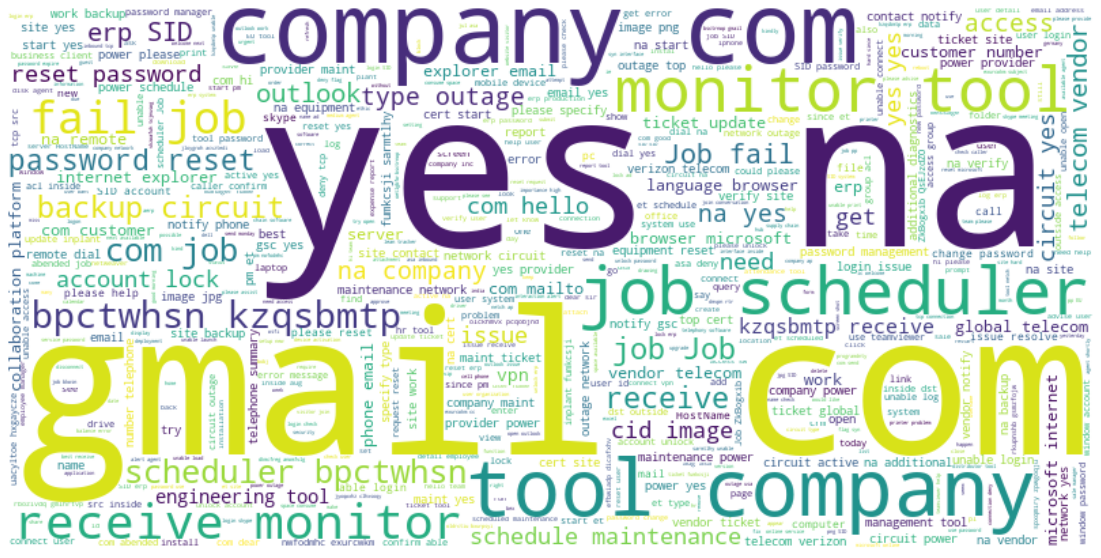

In [133]:
#GRP_24     289
ticket_df_grp24 = ticket_df_final.copy()
ticket_df_grp24[ticket_df_grp24['Assignment group'].apply(lambda x : x =='GRP_8')]
wordcloud_grp24 = WordCloud(stopwords = stop_words, max_words=500, background_color="white",width=800, height=400).generate(get_bag_of_words(ticket_df_grp24['tok_desc_lemma'].values))

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud_grp24,interpolation='bilinear')
plt.axis("off")
plt.show()

In [134]:
def make_sentence(list):
  output = ""
  for i in list: 
    output = output + " "+ i;
  return output

ticket_df_final['ML_Description'] = ticket_df_final['tok_desc_lemma'].apply(lambda v: make_sentence(v))

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
short_desc_tfidf = vectorizer.fit_transform(ticket_df_final['ML_Description'])
print(vectorizer.get_feature_names())
print(short_desc_tfidf.shape)

['aa', 'aab', 'aad', 'aaefe', 'ab', 'abap', 'abba', 'abbc', 'abc', 'abd', 'abdhtyu', 'abe', 'abend', 'abended', 'abeoucfj', 'abf', 'abff', 'abgebildet', 'abgrtyreu', 'abholen', 'ability', 'abjpdkcu', 'abl', 'able', 'abort', 'aborted', 'about', 'above', 'abrechnungs', 'abrurto', 'absolutely', 'abtknpew', 'abyfsqod', 'ac', 'acb', 'acc', 'acccount', 'accdb', 'accees', 'accept', 'acceptance', 'acceptingâ', 'acces', 'accesible', 'acceso', 'access', 'accessible', 'accidentally', 'accidently', 'accompanying', 'accomplish', 'accont', 'accord', 'accordance', 'accordingly', 'accound', 'account', 'accounting', 'accout', 'accsess', 'acct', 'accurate', 'ace', 'acess', 'acgyuna', 'achghar', 'achghyardr', 'achthyardk', 'acl', 'acmglkti', 'acqpinyd', 'acquire', 'acrobat', 'across', 'act', 'action', 'activate', 'activated', 'activation', 'active', 'activesync', 'activex', 'activity', 'actual', 'actually', 'acuvyqnx', 'acvztedi', 'acxedqjm', 'aczyfqjr', 'ad', 'adapter', 'adbfe', 'adbyhglu', 'add', 'addi

In [136]:
#Since english we remove non ascii
import re
ticket_df_final['ML_Description'] = ticket_df_final['ML_Description'].apply(lambda v: re.sub(r'[^\x00-\x7F]+',' ', v))
ticket_df_final['NL_Description'] = ticket_df_final['NL_Description'].apply(lambda v: re.sub(r'[^\x00-\x7F]+',' ', v))

In [137]:
vectorizer = TfidfVectorizer()
description_vectorizer = vectorizer.fit_transform(ticket_df_final['ML_Description'])
print(vectorizer.get_feature_names())
print(description_vectorizer.shape)

['aa', 'aab', 'aad', 'aaefe', 'ab', 'abap', 'abba', 'abbc', 'abc', 'abd', 'abdhtyu', 'abe', 'abend', 'abended', 'abeoucfj', 'abf', 'abff', 'abgebildet', 'abgrtyreu', 'abholen', 'ability', 'abjpdkcu', 'abl', 'able', 'abort', 'aborted', 'about', 'above', 'abrechnungs', 'abrurto', 'absolutely', 'abtknpew', 'abyfsqod', 'ac', 'acb', 'acc', 'acccount', 'accdb', 'accees', 'accept', 'acceptance', 'accepting', 'acces', 'accesible', 'acceso', 'access', 'accessible', 'accidentally', 'accidently', 'accompanying', 'accomplish', 'accont', 'accord', 'accordance', 'accordingly', 'accound', 'account', 'accounting', 'accout', 'accsess', 'acct', 'accurate', 'ace', 'acess', 'acgyuna', 'achghar', 'achghyardr', 'achthyardk', 'acl', 'acmglkti', 'acqpinyd', 'acquire', 'acrobat', 'across', 'act', 'action', 'activate', 'activated', 'activation', 'active', 'activesync', 'activex', 'activity', 'actual', 'actually', 'acuvyqnx', 'acvztedi', 'acxedqjm', 'aczyfqjr', 'ad', 'adapter', 'adbfe', 'adbyhglu', 'add', 'addin

In [138]:
def create_bag_of_words(X):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = 'english', ngram_range = (1,3), max_features = 10000) 
    train_data_features = vectorizer.fit_transform(X)
    train_data_features = train_data_features.toarray()
    
    # tfidf transform
    from sklearn.feature_extraction.text import TfidfTransformer
    tfidf = TfidfTransformer()
    tfidf_features = tfidf.fit_transform(train_data_features).toarray()

    # Get words in the vocabulary
    vocab = vectorizer.get_feature_names()

      
    return vectorizer, vocab, train_data_features, tfidf_features, tfidf

In [139]:
vectorizer, vocab, train_data_features, tfidf_features, tfidf  =  create_bag_of_words(ticket_df_final['ML_Description'])

In [140]:
bag_dictionary = pd.DataFrame()
bag_dictionary['ngram'] = vocab
bag_dictionary['count'] = train_data_features[0]
bag_dictionary['tfidf_features'] = tfidf_features[0]

# Sort by raw count
bag_dictionary.sort_values(by=['count'], ascending=False, inplace=True)
# Show top 10
print(bag_dictionary.head(10))

                       ngram  count  tfidf_features
9073                    user      3        0.248153
1005                   check      2        0.209816
4826                   login      2        0.176593
5974                password      1        0.067191
5977         password advise      1        0.169442
5978    password advise user      1        0.171399
9091           user employee      1        0.140190
9092   user employee manager      1        0.140190
7005                 resolve      1        0.107604
2159  employee manager check      1        0.151569


In [141]:
sorted_by_idf = np.argsort(tfidf.idf_)
feature_names = np.array(vectorizer.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['com' 'receive' 'company' 'tool' 'gmail com' 'gmail' 'password'
 'company com' 'reset' 'erp']

Features with highest idf:
['usa grind' 'image jpg bc' 'subsystem ac' 'subsystem ac line' 'sid ab'
 'neerthyu' 'lbcqfnie' 'ihrem' 'subsystem' 'hostname team business']


### Visualizations

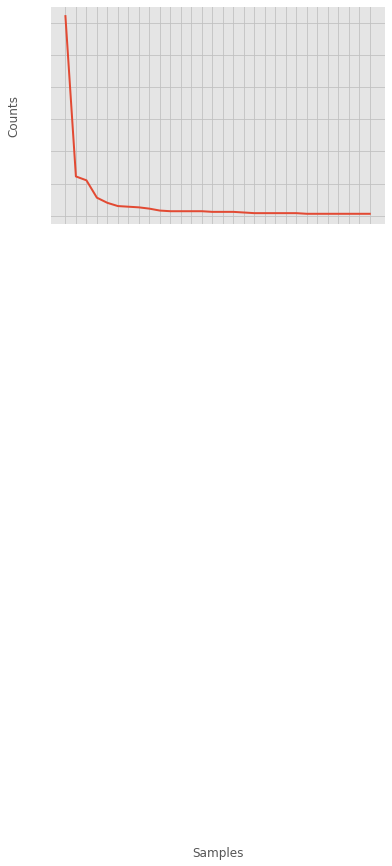

In [142]:
#nltk
import nltk
count = nltk.FreqDist(ticket_df_final['ML_Description'])
count.plot(30)

In [143]:
final_doc = ticket_df_final['ML_Description']
all_documents = tuple(final_doc)


In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(4885, 9807)
  (0, 6080)	0.30503731321964994
  (0, 7563)	0.30503731321964994
  (0, 6835)	0.15251477528309304
  (0, 3857)	0.11158153968854416
  (0, 23)	0.1345134159368934
  (0, 653)	0.07440795957748536
  (0, 3307)	0.15930492458972753
  (0, 7914)	0.13314918224970254
  (0, 1329)	0.1664618235895706
  (0, 1018)	0.17675217407761418
  (0, 4676)	0.2502972543807647
  (0, 8038)	0.1343918814802742
  (0, 119)	0.1731004351744457
  (0, 5924)	0.09523440020396387
  (0, 6828)	0.1021036640659707
  (0, 299)	0.19996985244231788
  (0, 89)	0.17427544475330844
  (0, 3695)	0.07472202805869704
  (0, 7918)	0.2526020028058433
  (0, 1149)	0.29738668933444096
  (0, 5278)	0.25958109675048
  (0, 4861)	0.14775400633252667
  (0, 2273)	0.17122649431466389
  (0, 1740)	0.1731004351744457
  (0, 8469)	0.35172373704729765
  :	:
  (4881, 2768)	0.09339619722498842
  (4881, 56)	0.19830126300188683
  (4881, 2368)	0.18339081118030495
  (4881, 1278)	0.06426741130308934
  (4881, 3058)	0.08111330565795906
  (4881, 5278)	0.229579520

In [145]:
data_text = ticket_df_final[['tok_desc_lemma']]
data_text['index'] = data_text.index
documents=data_text

print(len(documents))
print(documents[:10])

4885
                                       tok_desc_lemma  index
0   [verify, user, detail, employee, manager, name...      0
1   [receive, from, hmjdrvpb, komuaywn, gmail, com...      1
2   [can, not, log, in, to, vpn, receive, from, ey...      2
3   [unable, to, access, hr, tool, page, xbkucsvz,...      3
4                  [skype, error, owlgqjme, qhcozdfx]      4
5   [unable, to, log, in, to, engineering, tool, a...      5
7   [ticket, no, employment, status, new, non, emp...      7
8   [unable, to, disable, add, in, on, outlook, md...      8
9   [ticket, update, on, inplant, fumkcsji, sarmtlhy]      9
10  [engineering, tool, say, not, connect, and, un...     10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [146]:
from gensim.parsing.preprocessing import STOPWORDS


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [147]:
from nltk.stem.porter import *
import gensim


stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 5].values[0][0]
print('lemmatized document: ')

print(doc_sample)


processed_docs = documents['tok_desc_lemma']
processed_docs[:5]

lemmatized document: 
['unable', 'to', 'log', 'in', 'to', 'engineering', 'tool', 'and', 'skype', 'eflahbxn', 'ltdgrvkz']


0    [verify, user, detail, employee, manager, name...
1    [receive, from, hmjdrvpb, komuaywn, gmail, com...
2    [can, not, log, in, to, vpn, receive, from, ey...
3    [unable, to, access, hr, tool, page, xbkucsvz,...
4                   [skype, error, owlgqjme, qhcozdfx]
Name: tok_desc_lemma, dtype: object

In [148]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 able
1 ad
2 advise
3 and
4 be
5 caller
6 check
7 confirm
8 detail
9 employee
10 he


In [149]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(4, 3),
 (11, 1),
 (20, 2),
 (21, 1),
 (27, 1),
 (30, 1),
 (31, 1),
 (37, 1),
 (39, 2),
 (40, 1),
 (77, 1),
 (83, 1),
 (99, 1),
 (111, 1),
 (135, 1),
 (220, 1),
 (332, 1),
 (337, 2),
 (361, 1),
 (367, 1),
 (368, 1),
 (369, 1)]

In [150]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 4 ("be") appears 3 time.
Word 11 ("in") appears 1 time.
Word 20 ("the") appears 2 time.
Word 21 ("to") appears 1 time.
Word 27 ("com") appears 1 time.
Word 30 ("from") appears 1 time.
Word 31 ("gmail") appears 1 time.
Word 37 ("not") appears 1 time.
Word 39 ("please") appears 2 time.
Word 40 ("receive") appears 1 time.
Word 77 ("a") appears 1 time.
Word 83 ("get") appears 1 time.
Word 99 ("erp") appears 1 time.
Word 111 ("happen") appears 1 time.
Word 135 ("of") appears 1 time.
Word 220 ("note") appears 1 time.
Word 332 ("same") appears 1 time.
Word 337 ("printer") appears 2 time.
Word 361 ("print") appears 1 time.
Word 367 ("give") appears 1 time.
Word 368 ("immediately") appears 1 time.
Word 369 ("some") appears 1 time.


In [151]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.15187921076866953),
 (1, 0.21270163057217722),
 (2, 0.21089615902021902),
 (3, 0.19860449268013716),
 (4, 0.060408814130561886),
 (5, 0.21650963364295658),
 (6, 0.34703770380147597),
 (7, 0.20070779797601324),
 (8, 0.21089615902021902),
 (9, 0.20801815157059214),
 (10, 0.18974420348652352),
 (11, 0.06088625392537508),
 (12, 0.11694798880725163),
 (13, 0.27521327756400354),
 (14, 0.17208403756344107),
 (15, 0.28969638332990993),
 (16, 0.09207617777660285),
 (17, 0.10252549844864042),
 (18, 0.17935826461935567),
 (19, 0.14979923222766556),
 (20, 0.22589075079980328),
 (21, 0.09889197081341697),
 (22, 0.37669140757983594),
 (23, 0.17265328016747153)]


In [152]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [153]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.053*"to" + 0.038*"the" + 0.030*"be" + 0.027*"com" + 0.025*"gmail"'), (1, '0.047*"password" + 0.034*"the" + 0.028*"be" + 0.026*"to" + 0.025*"reset"'), (2, '0.078*"no" + 0.066*"yes" + 0.061*"na" + 0.025*"on" + 0.024*"be"'), (3, '0.052*"be" + 0.027*"not" + 0.026*"to" + 0.020*"in" + 0.018*"a"'), (4, '0.048*"to" + 0.038*"job" + 0.027*"in" + 0.026*"the" + 0.026*"from"')]
Topic: 0 
Words: 0.053*"to" + 0.038*"the" + 0.030*"be" + 0.027*"com" + 0.025*"gmail" + 0.025*"i" + 0.021*"from" + 0.016*"and" + 0.015*"receive" + 0.014*"in"
Topic: 1 
Words: 0.047*"password" + 0.034*"the" + 0.028*"be" + 0.026*"to" + 0.025*"reset" + 0.021*"tool" + 0.021*"com" + 0.020*"in" + 0.020*"from" + 0.018*"company"
Topic: 2 
Words: 0.078*"no" + 0.066*"yes" + 0.061*"na" + 0.025*"on" + 0.024*"be" + 0.024*"site" + 0.024*"circuit" + 0.020*"power" + 0.019*"ticket" + 0.016*"company"
Topic: 3 
Words: 0.052*"be" + 0.027*"not" + 0.026*"to" + 0.020*"in" + 0.018*"a" + 0.017*"on" + 0.016*"the" + 0.012*"this" + 0.012*"server

In [154]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

In [155]:
!pip install pyLDAvis


     |████████████████████████████████| 1.6MB 4.5MB/s 
     |████████████████████████████████| 552kB 20.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=df92b15d76f0191059a8b09aa2fc975a08bfc2ae8403f2bf697a3e267f482d14
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=96ba86646d83bfaaa0795e2b47d549b04a1a2e5e21c3e435f5a971423505193b
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


#### LDA

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

In [156]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

In [157]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [158]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(70, 5)
(5, 70)


In [ ]:
df_lda

#### ClusterMap

ClusterMap helps in finding the pairwise correlation of all columns in the dataframe. Any na values are automatically excluded.

ClusterMap clusters both columns and rows and adds dendrograms to show the clustering of similar keywords in this case.

Hierarchical clusters help to order data by similarity and displays similar content next to one another for even more depth of understanding the data

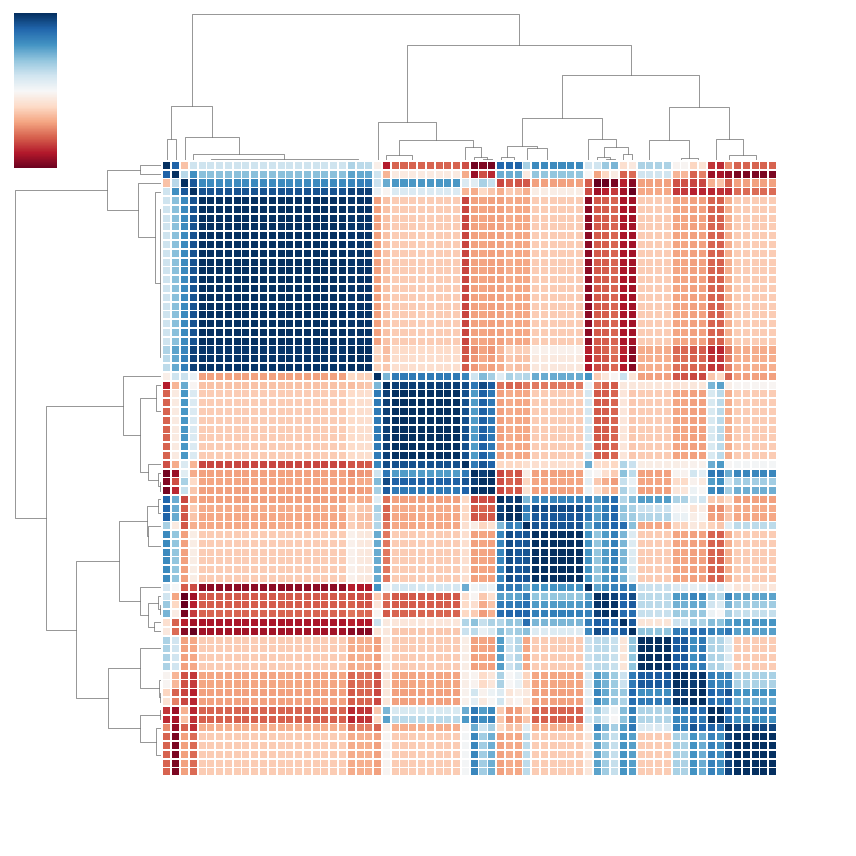

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

## MODEL SELECTION AND MODEL CREATION

### LOGISTIC REGRESSION:

In [160]:
# fitting logistic regression
#ref :: https://pythonhealthcare.org/2018/12/15/104-using-free-text-for-classification-bag-of-words/

from sklearn.model_selection import train_test_split
X = ticket_df_final['ML_Description']
y = ticket_df_final['Assignment group']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [161]:
vectorizer, vocab, train_data_features, tfidf_features, tfidf  =  create_bag_of_words(X_train)

In [162]:
def train_logistic_regression(features, label):
    print ("Training the logistic regression model...")
    from sklearn.linear_model import LogisticRegression
    ml_model = LogisticRegression(C = 100,random_state = 0)
    ml_model.fit(features, label)
    print ('Finished')
    return ml_model

In [163]:
ml_model = train_logistic_regression(tfidf_features, y_train)

Training the logistic regression model...
Finished


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [164]:
test_data_features = vectorizer.transform(X_test)
# Convert to numpy array
test_data_features = test_data_features.toarray()

In [165]:
test_data_tfidf_features = tfidf.fit_transform(test_data_features)

# Convert to numpy array
test_data_tfidf_features = test_data_tfidf_features.toarray()

In [166]:
predicted_train_y = ml_model.predict(tfidf_features)
correctly_identified_train_y = predicted_train_y == y_train
accuracy = np.mean(correctly_identified_train_y) * 100
print ('Training Accuracy = %.0f%%' %accuracy)

Training Accuracy = 97%


In [167]:
predicted_y = ml_model.predict(test_data_tfidf_features)
correctly_identified_y = predicted_y == y_test
accuracy = np.mean(correctly_identified_y) * 100
print ('Test Accuracy = %.0f%%' %accuracy)

Test Accuracy = 93%


In [168]:
#confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_y)

array([[920,   8,   0,   0,   4],
       [ 15,  36,   0,   4,   0],
       [  4,   0,  22,   0,   0],
       [  0,   2,   0, 129,   7],
       [  9,   1,   0,  35,  26]])

In [169]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_y, target_names=valid_grp_list))

              precision    recall  f1-score   support

       GRP_0       0.97      0.99      0.98       932
       GRP_8       0.77      0.65      0.71        55
      GRP_24       1.00      0.85      0.92        26
      GRP_12       0.77      0.93      0.84       138
       GRP_9       0.70      0.37      0.48        71

    accuracy                           0.93      1222
   macro avg       0.84      0.76      0.79      1222
weighted avg       0.92      0.93      0.92      1222



Observation: Train accuracy: 97% and Test accuracy: 93%

### RANDOM FOREST:

In [170]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 

In [171]:
tokenizer = Tokenizer(num_words= 10000)
tokenizer.fit_on_texts(ticket_df_final['ML_Description'])
maxlen = 300 

In [172]:
ticket_df_final['Assignment group_ENC'] = le.fit_transform(ticket_df_final['Assignment group'])

In [173]:
X_M1 = tokenizer.texts_to_sequences(ticket_df_final['Description'])
X_M1 = pad_sequences(X_M1, maxlen = maxlen)
y_M1 = np.asarray(ticket_df_final['Assignment group_ENC'])

print("Number of Samples:", len(X_M1))
print(X_M1[0])
print("Number of Labels: ", len(y_M1))
print(y_M1[0])

Number of Samples: 4885
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   

In [180]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_M1,y_M1, test_size = 0.3)

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics

clf = RandomForestClassifier(max_depth=15, random_state=0, class_weight="balanced")

In [182]:
clf.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [183]:
y_train_pred=clf.predict(X_train_2)

In [184]:
print("Training Accuracy:",metrics.accuracy_score(y_train_2, y_train_pred))

Training Accuracy: 0.9564200058496637


In [187]:
y_pred=clf.predict(X_test_2)

In [190]:
print("Testing Accuracy:",metrics.accuracy_score(y_test_2, y_pred))

Testing Accuracy: 0.8867667121418826


In [189]:
print(classification_report(y_test_2, y_pred, target_names=valid_grp_list))

              precision    recall  f1-score   support

       GRP_0       0.92      1.00      0.96      1111
       GRP_8       0.89      0.25      0.39        64
      GRP_24       0.75      0.39      0.51        23
      GRP_12       0.98      0.58      0.73       191
       GRP_9       0.48      0.74      0.58        77

    accuracy                           0.89      1466
   macro avg       0.80      0.59      0.63      1466
weighted avg       0.90      0.89      0.88      1466



In [ ]:
# FINDINGS: RANDOM FOREST TRAIN ACCURACY:95.64%  TEST ACCURACY: 88.67%

### MODEL WITH KNN:

In [191]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore

In [193]:
NNH = KNeighborsClassifier(n_neighbors= 5 , weights = 'distance')

In [195]:
NNH.fit(X_train_2, y_train_2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [197]:
print("Training score", NNH.score(X_train_2, y_train_2))
print("Test score",  NNH.score(X_test_2, y_test_2)) 

Training score 0.9564200058496637
Test score 0.8540245566166439


In [198]:
# make predictions
expected = y_test_2
predicted = NNH.predict(X_test_2)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1111
           1       0.43      0.23      0.30        64
           2       0.29      0.09      0.13        23
           3       0.80      0.57      0.67       191
           4       0.47      0.74      0.58        77

    accuracy                           0.85      1466
   macro avg       0.58      0.52      0.52      1466
weighted avg       0.85      0.85      0.84      1466

[[1069   15    5   20    2]
 [  42   15    0    5    2]
 [  21    0    2    0    0]
 [  19    4    0  109   59]
 [  17    1    0    2   57]]


In [ ]:
# FINDINGS: TRAINING ACCURANCY:95.6% TEST ACCURACY: 85%

### MODEL WITH LSTM

In [199]:
# Capping the maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 15000 #15000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250 #150
# This is fixed.
EMBEDDING_DIM = 100 # TODO REduce to 50 ~ 75
N_CLASSES = 5#34
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True,char_level = False) 
tokenizer.fit_on_texts(ticket_df_final['NL_Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10540 unique tokens.


In [200]:
X_nl = tokenizer.texts_to_sequences(ticket_df_final['NL_Description'].values)
X_nl = pad_sequences(X_nl, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_nl.shape)

Shape of data tensor: (4885, 250)


In [201]:
y_nl = pd.get_dummies(ticket_df_final['Assignment group']).values
print('Shape of label tensor:', y_nl.shape)

Shape of label tensor: (4885, 5)


In [202]:
from sklearn.model_selection import train_test_split
X_nl_train, X_nl_test, y_nl_train, y_nl_test = train_test_split(X_nl,y_nl, test_size = 0.25, random_state = 42)
print(X_nl_train.shape,y_nl_train.shape)
print(X_nl_test.shape,y_nl_test.shape)

(3663, 250) (3663, 5)
(1222, 250) (1222, 5)


In [203]:
from tensorflow.python.keras.layers import Embedding, Dense, LSTM, GRU, Dropout
from tensorflow.python.keras import Sequential,Model
from tensorflow.keras.layers import Embedding, SpatialDropout1D,Input,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, 
                            input_length= MAX_SEQUENCE_LENGTH, trainable=True)
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences) 
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 100)          1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 1,617,893
Trainable params: 1,617,893
Non-trainable params: 0
_________________________________________________________________


In [204]:
model.fit(X_nl_train, y_nl_train, epochs=20, batch_size=100,validation_split=0.25,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
28/28 [==============================] - 35s 1s/step - loss: 1.0486 - acc: 0.7343 - val_loss: 0.7330 - val_acc: 0.7544
Epoch 2/20
28/28 [==============================] - 35s 1s/step - loss: 0.5261 - acc: 0.8431 - val_loss: 0.4572 - val_acc: 0.8734
Epoch 3/20
28/28 [==============================] - 35s 1s/step - loss: 0.3403 - acc: 0.8810 - val_loss: 0.3683 - val_acc: 0.8777
Epoch 4/20
28/28 [==============================] - 34s 1s/step - loss: 0.2619 - acc: 0.8922 - val_loss: 0.3263 - val_acc: 0.8974
Epoch 5/20
28/28 [==============================] - 34s 1s/step - loss: 0.2116 - acc: 0.9232 - val_loss: 0.4208 - val_acc: 0.8908
Epoch 6/20
28/28 [==============================] - 34s 1s/step - loss: 0.1746 - acc: 0.9301 - val_loss: 0.2947 - val_acc: 0.9094
Epoch 7/20
28/28 [==============================] - 34s 1s/step - loss: 0.1355 - acc: 0.9414 - val_loss: 0.2964 - val_acc: 0.9138
Epoch 8/20
28/28 [==============================] - 34s 1s/step - loss: 0.1187 - acc: 0.94

In [205]:
scores_training, accuracy_training = model.evaluate(X_nl_train, y_nl_train, batch_size=100)
print('Training Accuracy :',accuracy_training*100)

37/37 [==============================] - 3s 77ms/step - loss: 0.1307 - acc: 0.9405
Training Accuracy : 94.0485954284668


In [206]:
scores_testing, accuracy_testing = model.evaluate(X_nl_test, y_nl_test, batch_size=100) 
print("Testing Accuracy: ",(accuracy_testing*100))

13/13 [==============================] - 1s 74ms/step - loss: 0.2890 - acc: 0.9034
Testing Accuracy:  90.34369587898254


In [ ]:
# FINDINGS OF LSTM MODEL: TRAINING ACCURACY: 94% AND TEST ACCURACY: 90.34%

### WORD EMBEDDINGS:

In [207]:
# Find the minimum and maximum count of words in sentences:

from nltk.tokenize import word_tokenize

# Separate the json into sentences and labels
sentences = []
labels = []
for index,item in ticket_df_final.iterrows():
    sentences.append(item['NL_Description'])
    labels.append(item['Assignment group'])
print(pd.DataFrame({'sentence' : sentences[0:10], 'label':labels[0:10]}))


                                            sentence  label
0  verified user details employee manager name ch...  GRP_0
1  received from hmjdrvpb komuaywn gmail com hell...  GRP_0
2  can not log in to vpn received from eylqgodm y...  GRP_0
3    unable to access hr tool page xbkucsvz gcpydteq  GRP_0
4                      skype error owlgqjme qhcozdfx  GRP_0
5  unable to log in to engineering tool and skype...  GRP_0
6  ticket no employment status new non employee e...  GRP_0
7  unable to disable add ins on outlook mdbegvct ...  GRP_0
8         ticket update on inplant fumkcsji sarmtlhy  GRP_0
9  engineering tool says not connected and unable...  GRP_0


In [208]:
word_count = lambda sentence: len(word_tokenize(sentence))
num_words_min = min(sentences, key=word_count) # the shortest sentence by word count
num_words_max=max(sentences, key=word_count) # the longest sentence by word count
print('Minimum count of words in sentences ::',len(num_words_min))
print('Maximum count of words in sentences ::',len(num_words_max))

Minimum count of words in sentences :: 29
Maximum count of words in sentences :: 6065


#### APPLYING KERAS TOKENIZER

In [209]:
# Splitting the dataset into Train and Test
training_size = round(len(sentences) * .80)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [210]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Setting tokenizer properties
vocab_size = 10000
oov_tok = "<oov>"
# Fit the tokenizer on Training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [211]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_features = 10000
maxlen = 300
embedding_size = 200
ticket_df_final.fillna(0, inplace=True)
tokenizer.fit_on_texts(ticket_df_final['NL_Description'])
X = tokenizer.texts_to_sequences(ticket_df_final['NL_Description'])

X = pad_sequences(X, maxlen = maxlen)
#y = np.asarray(ticket_df_final['Assignment group'])
y =  tokenizer.texts_to_sequences(ticket_df_final['Assignment group'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y)

Number of Samples: 4885
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   

In [212]:
# FINDING TOKEN SIZE:
num_words = len(tokenizer.word_index) + 1
print(num_words)

10542


In [213]:
# Setting the padding properties
max_length = 100
trunc_type='post'
padding_type='post'

# Creating padded sequences from train and test data
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_label_sequences = tokenizer.texts_to_sequences(training_labels)
testing_label_sequences = tokenizer.texts_to_sequences(testing_labels)

In [214]:
# USING EMBEDDINGS FILE TO GET THE WORD EMBEDDINGS:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [215]:
# CREATING A WEIGHT MATRIX OF EMBEDDED WORDS FROM TRAINING DATA:
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [216]:
# CREATING THE MODEL:

# TRYING TO FIT THE MODEL WITH A BATCH SIZE OF 100 AND VALIDATION SPLIT OF 0.2

from keras.regularizers import l2
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalAveragePooling1D,TimeDistributed
from tensorflow.keras.models import Model, Sequential
from keras import regularizers
from keras import optimizers
from tensorflow.keras.layers import BatchNormalization

# main model
input = Input(shape=(max_length,))
model = Embedding(num_words,200,weights=[embedding_matrix],input_length=maxlen)(input)
model =  Bidirectional (LSTM (100,activation=None,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
model = (BatchNormalization())(model)
model = TimeDistributed(Dense(100,input_dim=64,kernel_regularizer=l2(0.08),activation='relu'))(model)
model = Flatten()(model)
model = Dense(100,kernel_regularizer=l2(0.0008),activation='relu')(model)
output = Dense(34,kernel_regularizer=l2(0.0008),activation='softmax')(model)
model = Model(input,output)

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 200)          2108400   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          240800    
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 200)          800       
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 100)          20100     
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

In [217]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
batch_size = 100
epochs = 5

# Converting the lists to numpy arrays for Tensorflow 2.x
training_padded = np.array(training_padded)
training_labels_padded = np.array(training_labels)

# integer encode
label_encoder = LabelEncoder()
integer_encoded_training_label = label_encoder.fit_transform(training_labels_padded)
print(integer_encoded_training_label)
testing_padded = np.array(testing_padded)
testing_labels_padded = np.array(testing_labels)
integer_encoded_testing_label = label_encoder.fit_transform(testing_labels_padded)

print(integer_encoded_testing_label)

history = model.fit(training_padded, integer_encoded_training_label,epochs=epochs,batch_size = 100, validation_data=(testing_padded, integer_encoded_testing_label))

[0 0 0 ... 3 2 2]
[1 4 0 3 0 0 0 0 0 0 0 0 0 3 0 1 0 0 3 4 4 4 3 3 3 3 0 3 1 3 0 0 1 4 3 0 3
 1 0 0 4 4 0 0 4 4 1 0 0 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 4 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0
 0 0 0 0 2 2 3 0 0 3 4 0 3 3 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 4 0
 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 4 0 0 0
 4 0 4 0 0 0 0 1 1 1 0 0 3 0 0 0 0 0 1 0 1 1 1 3 0 4 0 0 0 0 4 0 3 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 4 0 0 0 3 0 0 0 0 3
 0 0 0 0 0 2 0 0 2 0 0 1 0 3 1 1 1 0 1 3 0 0 3 1 0 0 4 0 0 0 0 3 0 3 0 3 0
 0 0 0 0 0 3 0 4 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0
 0 0 0 0 0 3 0 0 0 0 0 0 0 2 0 0 0 0 4 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 3 3 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0
 0 0 0 3 0 0 0 4 3 3 0 0 3 3 1 4 3 0 3 3 3 3 3 3 3 0 3 0 1 0 0 3 4 4 0 3 0
 4 0 0 

In [218]:
#Training accuracy

acu_train = model.evaluate(training_padded, integer_encoded_training_label)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acu_train[0],acu_train[1]))

123/123 [==============================] - 3s 24ms/step - loss: 0.8222 - accuracy: 0.9194
Train set
  Loss: 0.822
  Accuracy: 0.919


In [219]:
#testing accuracy
acu_test = model.evaluate(testing_padded, integer_encoded_testing_label)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acu_test[0],acu_test[1]))

31/31 [==============================] - 1s 24ms/step - loss: 0.9565 - accuracy: 0.8762
Train set
  Loss: 0.956
  Accuracy: 0.876


In [220]:
# ACCURANCY SOCORES FOR BI-DIRECTIONAL LSTM:
# TRAINING ACCURANCY: 91.94%
# TESTING ACCURACY: 87.62%

In [221]:
# IMPROVEMENT ON TRAINING ACCURANCY: 92.1%
# IMPROVEMENT ON TEST ACCURACY: 

### EVALUATION OF MODELS:

In [222]:
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

In [229]:
print (style.BOLD + 'Initial Model Summary with 34 Classes' + style.END)
result = pd.DataFrame({'Srl#': [1], 'Model': ['Logistic Regression'],'Training Accuracy %': ["%.2f" % 94], 'Testing Accuracy %': ["%.2f" % 74] })
result.loc[1] = [2,'Random Forest',"%.2f" % 93.80,"%.2f" % 59.88]
result.loc[2] = [3,'KNN',"%.2f" % 93.26,"%.2f" % 54.84]
result.loc[3] = [4,'LSTM',"%.2f" % 58.9,"%.2f" % 57.0]
result.loc[4] = [5,'Bidirectional LSTM (with Time Distributed)',"%.2f" % 90,"%.2f" % 54.9]
result.style.hide_index()

Initial Model Summary with 34 Classes


In [231]:
print (style.BOLD + 'Tuned Model Summary with 5 Classes' + style.END)
result1 = pd.DataFrame({'Srl#': [1], 'Model': ['Logistic Regression'],'Training Accuracy %': ["%.2f" % 96], 'Testing Accuracy %': ["%.2f" % 94] })
result1.loc[1] = [2,'Random Forest',"%.2f" % 95.40,"%.2f" % 87.50]
result1.loc[2] = [3,'KNN',"%.2f" % 95.30,"%.2f" % 85.00]
result1.loc[3] = [4,'LSTM',"%.2f" % 94.10,"%.2f" % 90.76]
result1.loc[4] = [5,'Bidirectional LSTM with Time Distributed',"%.2f" % 91.38,"%.2f" % 88.96]
result1.style.hide_index()

Tuned Model Summary with 5 Classes


INFERENCES: 

BEST PERFORMING MODEL:  LSTM MODEL.  

*   34 groups used with 94% of imbalanced data. This will be leading to overfitting
*   5 groups which are top 5 gives us good model accuracy, considering 64% of data.

